# Deep cortical machine learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.478661329283648 -2.9493425635769253
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [15]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [16]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [17]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [28]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    Qs_labels = tf.concat(axis=0, values=[targetQs[1:], tf.zeros(shape=[1, 1])])
    #g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * targetQs[1:])
    g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_labels)
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                     labels=reward*tf.ones_like(Qs_logits)))
    # d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits[:-1],
    #                                                                  labels=tf.reshape(tf.nn.sigmoid(targetQs[1:]),
    #                                                                                    shape=[-1, 1])))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR + d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [29]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [30]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [31]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(20, 4) actions:(20,)
action size:2


In [32]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [33]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [34]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [ ]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossR_list, d_lossQ_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:126.0000 rate:0.2520 gloss:0.0400 dloss:1.4015 dlossR:0.7106 dlossQ:0.6909
Episode:1 meanR:134.0000 rate:0.2840 gloss:-0.0004 dloss:1.3863 dlossR:0.6943 dlossQ:0.6920
Episode:2 meanR:124.6667 rate:0.2120 gloss:-0.0639 dloss:1.3590 dlossR:0.6671 dlossQ:0.6919
Episode:3 meanR:119.5000 rate:0.2080 gloss:-0.0571 dloss:1.3606 dlossR:0.6691 dlossQ:0.6915
Episode:4 meanR:125.2000 rate:0.2960 gloss:-0.0530 dloss:1.3703 dlossR:0.6785 dlossQ:0.6918
Episode:5 meanR:117.3333 rate:0.1560 gloss:-0.1236 dloss:1.3225 dlossR:0.6339 dlossQ:0.6887
Episode:6 meanR:118.5714 rate:0.2520 gloss:-0.0920 dloss:1.3522 dlossR:0.6616 dlossQ:0.6906
Episode:7 meanR:108.0000 rate:0.0680 gloss:-0.1839 dloss:1.2683 dlossR:0.5841 dlossQ:0.6842
Episode:8 meanR:99.0000 rate:0.0540 gloss:-0.2075 dloss:1.2480 dlossR:0.5663 dlossQ:0.6817
Episode:9 meanR:90.2000 rate:0.0220 gloss:-0.3295 dloss:1.1450 dlossR:0.4814 dlossQ:0.6637
Episode:10 meanR:83.4545 rate:0.0320 gloss:-0.2218 dloss:1.2307 dlossR:0.5504 dloss

Episode:90 meanR:40.8132 rate:0.0400 gloss:-1.4791 dloss:0.5450 dlossR:0.1915 dlossQ:0.3535
Episode:91 meanR:40.4891 rate:0.0220 gloss:-1.5886 dloss:0.5117 dlossR:0.1382 dlossQ:0.3736
Episode:92 meanR:40.1828 rate:0.0240 gloss:-1.6189 dloss:0.4919 dlossR:0.1412 dlossQ:0.3506
Episode:93 meanR:39.8830 rate:0.0240 gloss:-1.6949 dloss:0.4688 dlossR:0.1381 dlossQ:0.3307
Episode:94 meanR:39.5579 rate:0.0180 gloss:-1.6678 dloss:0.5006 dlossR:0.1237 dlossQ:0.3769
Episode:95 meanR:39.2500 rate:0.0200 gloss:-1.6756 dloss:0.5064 dlossR:0.1296 dlossQ:0.3768
Episode:96 meanR:38.9588 rate:0.0220 gloss:-1.6991 dloss:0.4808 dlossR:0.1325 dlossQ:0.3483
Episode:97 meanR:38.7449 rate:0.0360 gloss:-1.5375 dloss:0.5388 dlossR:0.1792 dlossQ:0.3596
Episode:98 meanR:38.7273 rate:0.0740 gloss:-1.3741 dloss:0.6582 dlossR:0.2786 dlossQ:0.3796
Episode:99 meanR:38.5500 rate:0.0420 gloss:-1.2806 dloss:0.6401 dlossR:0.2173 dlossQ:0.4228
Episode:100 meanR:37.4000 rate:0.0220 gloss:-1.3140 dloss:0.5983 dlossR:0.1665 d

Episode:182 meanR:48.4300 rate:0.1580 gloss:-1.4472 dloss:0.8037 dlossR:0.4498 dlossQ:0.3539
Episode:183 meanR:48.0600 rate:0.0360 gloss:-1.4668 dloss:0.5535 dlossR:0.1827 dlossQ:0.3708
Episode:184 meanR:47.8500 rate:0.0280 gloss:-1.5406 dloss:0.5340 dlossR:0.1573 dlossQ:0.3767
Episode:185 meanR:47.7800 rate:0.0220 gloss:-1.6566 dloss:0.5211 dlossR:0.1352 dlossQ:0.3859
Episode:186 meanR:47.7800 rate:0.0700 gloss:-1.5647 dloss:0.6039 dlossR:0.2603 dlossQ:0.3436
Episode:187 meanR:47.8500 rate:0.0540 gloss:-1.4501 dloss:0.5849 dlossR:0.2256 dlossQ:0.3593
Episode:188 meanR:47.8800 rate:0.0400 gloss:-1.4555 dloss:0.5601 dlossR:0.1930 dlossQ:0.3671
Episode:189 meanR:47.8500 rate:0.0280 gloss:-1.5483 dloss:0.5057 dlossR:0.1554 dlossQ:0.3504
Episode:190 meanR:47.8000 rate:0.0300 gloss:-1.6986 dloss:0.4653 dlossR:0.1508 dlossQ:0.3146
Episode:191 meanR:47.8000 rate:0.0220 gloss:-1.7750 dloss:0.4567 dlossR:0.1243 dlossQ:0.3325
Episode:192 meanR:47.7800 rate:0.0200 gloss:-1.7556 dloss:0.4763 dloss

Episode:271 meanR:47.5500 rate:1.0000 gloss:-1.2355 dloss:2.3589 dlossR:1.9476 dlossQ:0.4113
Episode:272 meanR:52.1300 rate:1.0000 gloss:-1.1805 dloss:2.3058 dlossR:1.8761 dlossQ:0.4296
Episode:273 meanR:56.5000 rate:1.0000 gloss:-1.0848 dloss:2.2209 dlossR:1.7607 dlossQ:0.4602
Episode:274 meanR:61.0100 rate:1.0000 gloss:-0.9806 dloss:2.1316 dlossR:1.6380 dlossQ:0.4937
Episode:275 meanR:65.1600 rate:1.0000 gloss:-0.7848 dloss:1.9724 dlossR:1.4181 dlossQ:0.5542
Episode:276 meanR:69.6500 rate:1.0000 gloss:-0.7158 dloss:1.9177 dlossR:1.3429 dlossQ:0.5748
Episode:277 meanR:74.3100 rate:1.0000 gloss:-0.6267 dloss:1.8486 dlossR:1.2489 dlossQ:0.5997
Episode:278 meanR:78.7500 rate:1.0000 gloss:-0.5327 dloss:1.7772 dlossR:1.1534 dlossQ:0.6238
Episode:279 meanR:83.5600 rate:1.0000 gloss:-0.4581 dloss:1.7220 dlossR:1.0808 dlossQ:0.6412
Episode:280 meanR:88.1800 rate:1.0000 gloss:-0.3559 dloss:1.6461 dlossR:0.9851 dlossQ:0.6611
Episode:281 meanR:92.8500 rate:1.0000 gloss:-0.2635 dloss:1.5786 dloss

Episode:360 meanR:272.7700 rate:0.2420 gloss:-0.1919 dloss:1.3052 dlossR:0.6344 dlossQ:0.6708
Episode:361 meanR:273.3100 rate:0.2700 gloss:0.2283 dloss:1.4843 dlossR:0.8338 dlossQ:0.6505
Episode:362 meanR:273.2000 rate:0.2260 gloss:-0.2106 dloss:1.2913 dlossR:0.6201 dlossQ:0.6712
Episode:363 meanR:269.9800 rate:0.2780 gloss:0.1218 dloss:1.4355 dlossR:0.7607 dlossQ:0.6747
Episode:364 meanR:267.9900 rate:0.1740 gloss:-0.2433 dloss:1.2570 dlossR:0.5858 dlossQ:0.6712
Episode:365 meanR:268.6700 rate:0.1560 gloss:-0.2918 dloss:1.2238 dlossR:0.5645 dlossQ:0.6593
Episode:366 meanR:269.3500 rate:0.1840 gloss:-0.2534 dloss:1.2553 dlossR:0.5886 dlossQ:0.6667
Episode:367 meanR:269.9000 rate:0.1480 gloss:-0.3056 dloss:1.2122 dlossR:0.5553 dlossQ:0.6569
Episode:368 meanR:270.9800 rate:0.2620 gloss:-0.2449 dloss:1.2928 dlossR:0.6322 dlossQ:0.6605
Episode:369 meanR:270.1100 rate:0.1480 gloss:-0.3134 dloss:1.2086 dlossR:0.5511 dlossQ:0.6575
Episode:370 meanR:265.8800 rate:0.1540 gloss:-0.3366 dloss:1.1

Episode:449 meanR:69.8200 rate:0.2520 gloss:-1.4173 dloss:1.0083 dlossR:0.6520 dlossQ:0.3563
Episode:450 meanR:69.5600 rate:0.1800 gloss:-1.1302 dloss:0.9198 dlossR:0.4756 dlossQ:0.4442
Episode:451 meanR:70.4000 rate:0.3300 gloss:-1.1602 dloss:1.1675 dlossR:0.7350 dlossQ:0.4326
Episode:452 meanR:70.3200 rate:0.1660 gloss:-1.1273 dloss:0.9030 dlossR:0.4541 dlossQ:0.4489
Episode:453 meanR:70.3200 rate:0.1620 gloss:-1.0882 dloss:0.9068 dlossR:0.4471 dlossQ:0.4596
Episode:454 meanR:70.2100 rate:0.1840 gloss:-1.1234 dloss:0.9348 dlossR:0.4847 dlossQ:0.4501
Episode:455 meanR:70.2300 rate:0.2280 gloss:-1.1234 dloss:1.0033 dlossR:0.5569 dlossQ:0.4464
Episode:456 meanR:69.6200 rate:0.1680 gloss:-1.0368 dloss:0.9338 dlossR:0.4570 dlossQ:0.4768
Episode:457 meanR:69.3300 rate:0.1560 gloss:-0.9965 dloss:0.9288 dlossR:0.4404 dlossQ:0.4884
Episode:458 meanR:68.9200 rate:0.0780 gloss:-0.9727 dloss:0.8134 dlossR:0.3221 dlossQ:0.4913
Episode:459 meanR:68.4900 rate:0.0680 gloss:-0.9033 dloss:0.8339 dloss

Episode:539 meanR:48.8800 rate:0.0520 gloss:-1.1665 dloss:0.6877 dlossR:0.2499 dlossQ:0.4378
Episode:540 meanR:48.7200 rate:0.0600 gloss:-1.2200 dloss:0.6793 dlossR:0.2585 dlossQ:0.4208
Episode:541 meanR:48.2900 rate:0.0620 gloss:-1.2327 dloss:0.6777 dlossR:0.2607 dlossQ:0.4170
Episode:542 meanR:47.6400 rate:0.0460 gloss:-1.2306 dloss:0.6503 dlossR:0.2292 dlossQ:0.4211
Episode:543 meanR:46.9500 rate:0.0380 gloss:-1.2210 dloss:0.6393 dlossR:0.2137 dlossQ:0.4256
Episode:544 meanR:46.3500 rate:0.0520 gloss:-1.2944 dloss:0.6352 dlossR:0.2337 dlossQ:0.4015
Episode:545 meanR:46.4500 rate:0.0400 gloss:-1.2642 dloss:0.6274 dlossR:0.2121 dlossQ:0.4153
Episode:546 meanR:45.8000 rate:0.0400 gloss:-1.2793 dloss:0.6213 dlossR:0.2104 dlossQ:0.4109
Episode:547 meanR:45.1800 rate:0.0480 gloss:-1.3579 dloss:0.6046 dlossR:0.2190 dlossQ:0.3856
Episode:548 meanR:43.9700 rate:0.0320 gloss:-1.3716 dloss:0.5701 dlossR:0.1807 dlossQ:0.3894
Episode:549 meanR:42.9600 rate:0.0500 gloss:-1.4556 dloss:0.5758 dloss

Episode:631 meanR:36.2100 rate:0.1640 gloss:-1.4125 dloss:0.8205 dlossR:0.4586 dlossQ:0.3619
Episode:632 meanR:36.2700 rate:0.0360 gloss:-1.4740 dloss:0.5486 dlossR:0.1814 dlossQ:0.3672
Episode:633 meanR:37.0100 rate:0.1800 gloss:-1.6244 dloss:0.8212 dlossR:0.5172 dlossQ:0.3041
Episode:634 meanR:37.7200 rate:0.2800 gloss:-1.4651 dloss:1.0546 dlossR:0.7103 dlossQ:0.3443
Episode:635 meanR:37.0000 rate:0.0180 gloss:-1.4428 dloss:0.5445 dlossR:0.1349 dlossQ:0.4096
Episode:636 meanR:36.4200 rate:0.0200 gloss:-1.4989 dloss:0.5258 dlossR:0.1364 dlossQ:0.3894
Episode:637 meanR:36.0900 rate:0.0580 gloss:-1.4531 dloss:0.5946 dlossR:0.2339 dlossQ:0.3606
Episode:638 meanR:36.4800 rate:0.1340 gloss:-1.3404 dloss:0.7780 dlossR:0.3953 dlossQ:0.3827
Episode:639 meanR:37.2900 rate:0.2140 gloss:-1.3820 dloss:0.9265 dlossR:0.5580 dlossQ:0.3686
Episode:640 meanR:38.9900 rate:0.4000 gloss:-1.4080 dloss:1.3008 dlossR:0.9417 dlossQ:0.3591
Episode:641 meanR:39.5600 rate:0.1760 gloss:-1.3052 dloss:0.8675 dloss

Episode:724 meanR:46.0900 rate:0.0980 gloss:-1.5136 dloss:0.6610 dlossR:0.3215 dlossQ:0.3395
Episode:725 meanR:46.1200 rate:0.0940 gloss:-1.5426 dloss:0.6414 dlossR:0.3122 dlossQ:0.3292
Episode:726 meanR:45.8100 rate:0.0380 gloss:-1.4601 dloss:0.5555 dlossR:0.1881 dlossQ:0.3674
Episode:727 meanR:45.5100 rate:0.0280 gloss:-1.4308 dloss:0.5522 dlossR:0.1661 dlossQ:0.3861
Episode:728 meanR:45.2100 rate:0.0180 gloss:-1.3763 dloss:0.5609 dlossR:0.1430 dlossQ:0.4179
Episode:729 meanR:45.0600 rate:0.0240 gloss:-1.3838 dloss:0.5630 dlossR:0.1607 dlossQ:0.4023
Episode:730 meanR:44.8600 rate:0.0220 gloss:-1.4247 dloss:0.5481 dlossR:0.1505 dlossQ:0.3976
Episode:731 meanR:44.2200 rate:0.0360 gloss:-1.5161 dloss:0.5354 dlossR:0.1784 dlossQ:0.3570
Episode:732 meanR:45.2000 rate:0.2320 gloss:-1.4985 dloss:0.9484 dlossR:0.6143 dlossQ:0.3341
Episode:733 meanR:44.4000 rate:0.0200 gloss:-1.3018 dloss:0.5859 dlossR:0.1587 dlossQ:0.4272
Episode:734 meanR:43.1500 rate:0.0300 gloss:-1.2975 dloss:0.5998 dloss

Episode:814 meanR:40.4600 rate:0.1160 gloss:-1.4984 dloss:0.6977 dlossR:0.3606 dlossQ:0.3371
Episode:815 meanR:40.6200 rate:0.0680 gloss:-1.4317 dloss:0.6173 dlossR:0.2567 dlossQ:0.3606
Episode:816 meanR:40.4100 rate:0.0460 gloss:-1.4458 dloss:0.5704 dlossR:0.2066 dlossQ:0.3638
Episode:817 meanR:40.4600 rate:0.0420 gloss:-1.4302 dloss:0.5685 dlossR:0.1986 dlossQ:0.3699
Episode:818 meanR:40.5400 rate:0.0380 gloss:-1.4208 dloss:0.5652 dlossR:0.1901 dlossQ:0.3750
Episode:819 meanR:40.5600 rate:0.0320 gloss:-1.4457 dloss:0.5462 dlossR:0.1733 dlossQ:0.3729
Episode:820 meanR:40.5600 rate:0.0340 gloss:-1.4757 dloss:0.5389 dlossR:0.1755 dlossQ:0.3634
Episode:821 meanR:40.5900 rate:0.0380 gloss:-1.5117 dloss:0.5333 dlossR:0.1823 dlossQ:0.3510
Episode:822 meanR:40.5300 rate:0.0240 gloss:-1.3999 dloss:0.5524 dlossR:0.1573 dlossQ:0.3951
Episode:823 meanR:40.0800 rate:0.0360 gloss:-1.5084 dloss:0.5324 dlossR:0.1778 dlossQ:0.3546
Episode:824 meanR:39.7200 rate:0.0260 gloss:-1.4867 dloss:0.5276 dloss

Episode:907 meanR:57.9300 rate:0.0180 gloss:-1.4779 dloss:0.5727 dlossR:0.1426 dlossQ:0.4301
Episode:908 meanR:57.8900 rate:0.0200 gloss:-1.1125 dloss:0.6664 dlossR:0.1920 dlossQ:0.4744
Episode:909 meanR:57.7800 rate:0.0280 gloss:-1.1948 dloss:0.6420 dlossR:0.1980 dlossQ:0.4440
Episode:910 meanR:58.1200 rate:0.1380 gloss:-1.4102 dloss:0.7753 dlossR:0.4082 dlossQ:0.3671
Episode:911 meanR:61.5800 rate:1.0000 gloss:-1.2856 dloss:2.4022 dlossR:2.0055 dlossQ:0.3967
Episode:912 meanR:63.4700 rate:0.5860 gloss:-1.1648 dloss:1.5971 dlossR:1.1617 dlossQ:0.4354
Episode:913 meanR:65.7300 rate:0.5000 gloss:-1.1297 dloss:1.4449 dlossR:0.9984 dlossQ:0.4464
Episode:914 meanR:69.5600 rate:0.8820 gloss:-1.1493 dloss:2.0825 dlossR:1.6427 dlossQ:0.4398
Episode:915 meanR:71.5900 rate:0.4740 gloss:-1.0775 dloss:1.3956 dlossR:0.9324 dlossQ:0.4632
Episode:916 meanR:73.5900 rate:0.4460 gloss:-1.0715 dloss:1.3514 dlossR:0.8864 dlossQ:0.4651
Episode:917 meanR:76.0000 rate:0.5240 gloss:-1.0377 dloss:1.4669 dloss

Episode:996 meanR:82.8300 rate:0.0860 gloss:-1.2292 dloss:0.7416 dlossR:0.3104 dlossQ:0.4312
Episode:997 meanR:82.5700 rate:0.0200 gloss:-1.4560 dloss:0.5810 dlossR:0.1531 dlossQ:0.4278
Episode:998 meanR:82.7500 rate:0.1080 gloss:-1.1908 dloss:0.7897 dlossR:0.3534 dlossQ:0.4363
Episode:999 meanR:82.5100 rate:0.0160 gloss:-1.3692 dloss:0.6007 dlossR:0.1469 dlossQ:0.4538
Episode:1000 meanR:82.1900 rate:0.0180 gloss:-1.4219 dloss:0.5713 dlossR:0.1469 dlossQ:0.4244
Episode:1001 meanR:82.8100 rate:0.1720 gloss:-1.0489 dloss:0.9338 dlossR:0.4603 dlossQ:0.4735
Episode:1002 meanR:83.6200 rate:0.2020 gloss:-1.0213 dloss:0.9878 dlossR:0.5065 dlossQ:0.4814
Episode:1003 meanR:87.6000 rate:0.8200 gloss:-1.2240 dloss:2.0282 dlossR:1.6129 dlossQ:0.4153
Episode:1004 meanR:89.7600 rate:0.4540 gloss:-0.9789 dloss:1.3599 dlossR:0.8665 dlossQ:0.4934
Episode:1005 meanR:90.8800 rate:0.2480 gloss:-1.3374 dloss:1.0080 dlossR:0.6213 dlossQ:0.3867
Episode:1006 meanR:91.4800 rate:0.1700 gloss:-1.2635 dloss:0.873

Episode:1084 meanR:51.8200 rate:0.7440 gloss:-1.4492 dloss:2.0271 dlossR:1.6784 dlossQ:0.3487
Episode:1085 meanR:53.2000 rate:0.3060 gloss:-1.4953 dloss:1.1166 dlossR:0.7760 dlossQ:0.3405
Episode:1086 meanR:53.7300 rate:0.1360 gloss:-1.4392 dloss:0.7662 dlossR:0.4049 dlossQ:0.3613
Episode:1087 meanR:54.1100 rate:0.1180 gloss:-1.4902 dloss:0.7251 dlossR:0.3712 dlossQ:0.3539
Episode:1088 meanR:54.6200 rate:0.1380 gloss:-1.4503 dloss:0.7769 dlossR:0.4137 dlossQ:0.3632
Episode:1089 meanR:54.6700 rate:0.0380 gloss:-1.2642 dloss:0.6287 dlossR:0.2097 dlossQ:0.4190
Episode:1090 meanR:54.6000 rate:0.0480 gloss:-1.2315 dloss:0.6607 dlossR:0.2347 dlossQ:0.4260
Episode:1091 meanR:54.5900 rate:0.0340 gloss:-1.2841 dloss:0.6167 dlossR:0.1986 dlossQ:0.4180
Episode:1092 meanR:54.3500 rate:0.0240 gloss:-1.2753 dloss:0.6060 dlossR:0.1763 dlossQ:0.4297
Episode:1093 meanR:51.5700 rate:0.0260 gloss:-1.2907 dloss:0.5992 dlossR:0.1795 dlossQ:0.4197
Episode:1094 meanR:50.1100 rate:0.0280 gloss:-1.3120 dloss:0

Episode:1175 meanR:53.8000 rate:0.1560 gloss:-1.2810 dloss:0.8467 dlossR:0.4384 dlossQ:0.4083
Episode:1176 meanR:54.2600 rate:0.1300 gloss:-1.3766 dloss:0.7653 dlossR:0.3883 dlossQ:0.3771
Episode:1177 meanR:54.4000 rate:0.0640 gloss:-1.3087 dloss:0.6635 dlossR:0.2593 dlossQ:0.4042
Episode:1178 meanR:54.6300 rate:0.0800 gloss:-1.3059 dloss:0.6934 dlossR:0.2911 dlossQ:0.4023
Episode:1179 meanR:54.8900 rate:0.0820 gloss:-1.3112 dloss:0.6960 dlossR:0.2949 dlossQ:0.4011
Episode:1180 meanR:55.0700 rate:0.0560 gloss:-1.3270 dloss:0.6446 dlossR:0.2420 dlossQ:0.4026
Episode:1181 meanR:56.1900 rate:0.2700 gloss:-1.3026 dloss:1.0483 dlossR:0.6526 dlossQ:0.3957
Episode:1182 meanR:56.8000 rate:0.2740 gloss:-1.3901 dloss:1.0495 dlossR:0.6794 dlossQ:0.3701
Episode:1183 meanR:60.1800 rate:0.8500 gloss:-1.2358 dloss:2.0898 dlossR:1.6756 dlossQ:0.4141
Episode:1184 meanR:57.0600 rate:0.1200 gloss:-1.2821 dloss:0.7751 dlossR:0.3690 dlossQ:0.4061
Episode:1185 meanR:55.8400 rate:0.0620 gloss:-1.2840 dloss:0

Episode:1265 meanR:49.9100 rate:0.3480 gloss:-1.2146 dloss:1.1933 dlossR:0.7728 dlossQ:0.4205
Episode:1266 meanR:51.5800 rate:0.3740 gloss:-1.4913 dloss:1.2590 dlossR:0.9200 dlossQ:0.3389
Episode:1267 meanR:56.3900 rate:0.9900 gloss:-1.2523 dloss:2.3551 dlossR:1.9477 dlossQ:0.4074
Episode:1268 meanR:57.6400 rate:0.2800 gloss:-1.1791 dloss:1.0789 dlossR:0.6473 dlossQ:0.4316
Episode:1269 meanR:61.2100 rate:0.7320 gloss:-1.2807 dloss:1.9041 dlossR:1.5055 dlossQ:0.3986
Episode:1270 meanR:61.7200 rate:0.1260 gloss:-1.2119 dloss:0.8030 dlossR:0.3804 dlossQ:0.4226
Episode:1271 meanR:62.1300 rate:0.1080 gloss:-1.1985 dloss:0.7766 dlossR:0.3490 dlossQ:0.4275
Episode:1272 meanR:62.5300 rate:0.1120 gloss:-1.1787 dloss:0.7899 dlossR:0.3575 dlossQ:0.4325
Episode:1273 meanR:62.4400 rate:0.0400 gloss:-1.1789 dloss:0.6701 dlossR:0.2267 dlossQ:0.4434
Episode:1274 meanR:62.4600 rate:0.0400 gloss:-1.1847 dloss:0.6665 dlossR:0.2257 dlossQ:0.4408
Episode:1275 meanR:61.9100 rate:0.0460 gloss:-1.1788 dloss:0

Episode:1352 meanR:59.3300 rate:0.0300 gloss:-1.3388 dloss:0.5889 dlossR:0.1827 dlossQ:0.4062
Episode:1353 meanR:59.3500 rate:0.0300 gloss:-1.3748 dloss:0.5728 dlossR:0.1785 dlossQ:0.3943
Episode:1354 meanR:59.3400 rate:0.0240 gloss:-1.3276 dloss:0.5839 dlossR:0.1692 dlossQ:0.4147
Episode:1355 meanR:59.3800 rate:0.0260 gloss:-1.3313 dloss:0.5840 dlossR:0.1740 dlossQ:0.4099
Episode:1356 meanR:59.3700 rate:0.0180 gloss:-1.2976 dloss:0.5904 dlossR:0.1559 dlossQ:0.4345
Episode:1357 meanR:59.2700 rate:0.0180 gloss:-1.3203 dloss:0.5851 dlossR:0.1533 dlossQ:0.4318
Episode:1358 meanR:59.2900 rate:0.0240 gloss:-1.3932 dloss:0.5625 dlossR:0.1613 dlossQ:0.4013
Episode:1359 meanR:60.3400 rate:0.3180 gloss:-1.4693 dloss:1.1386 dlossR:0.7925 dlossQ:0.3461
Episode:1360 meanR:56.0600 rate:0.1120 gloss:-1.2114 dloss:0.7789 dlossR:0.3561 dlossQ:0.4228
Episode:1361 meanR:55.3000 rate:0.0380 gloss:-1.2687 dloss:0.6281 dlossR:0.2098 dlossQ:0.4184
Episode:1362 meanR:55.2000 rate:0.0240 gloss:-1.3545 dloss:0

Episode:1445 meanR:67.6000 rate:0.0380 gloss:-1.1555 dloss:0.6765 dlossR:0.2265 dlossQ:0.4500
Episode:1446 meanR:67.6600 rate:0.0320 gloss:-1.1940 dloss:0.6516 dlossR:0.2079 dlossQ:0.4437
Episode:1447 meanR:67.7800 rate:0.0440 gloss:-1.1767 dloss:0.6784 dlossR:0.2351 dlossQ:0.4433
Episode:1448 meanR:66.0100 rate:0.0360 gloss:-1.2381 dloss:0.6390 dlossR:0.2101 dlossQ:0.4289
Episode:1449 meanR:65.5500 rate:0.0280 gloss:-1.2673 dloss:0.6132 dlossR:0.1883 dlossQ:0.4250
Episode:1450 meanR:65.0100 rate:0.0240 gloss:-1.2702 dloss:0.6100 dlossR:0.1784 dlossQ:0.4316
Episode:1451 meanR:64.9000 rate:0.0260 gloss:-1.2630 dloss:0.6138 dlossR:0.1846 dlossQ:0.4291
Episode:1452 meanR:64.8600 rate:0.0220 gloss:-1.3518 dloss:0.5782 dlossR:0.1627 dlossQ:0.4154
Episode:1453 meanR:64.8300 rate:0.0240 gloss:-1.3496 dloss:0.5790 dlossR:0.1685 dlossQ:0.4105
Episode:1454 meanR:64.8300 rate:0.0240 gloss:-1.3558 dloss:0.5769 dlossR:0.1678 dlossQ:0.4091
Episode:1455 meanR:64.8000 rate:0.0200 gloss:-1.3621 dloss:0

Episode:1534 meanR:45.7600 rate:0.5240 gloss:-1.1480 dloss:1.4892 dlossR:1.0494 dlossQ:0.4398
Episode:1535 meanR:45.7300 rate:0.2640 gloss:-1.3487 dloss:1.0386 dlossR:0.6538 dlossQ:0.3848
Episode:1536 meanR:45.6300 rate:0.1600 gloss:-1.2331 dloss:0.8591 dlossR:0.4419 dlossQ:0.4172
Episode:1537 meanR:44.9200 rate:0.0820 gloss:-1.2871 dloss:0.7002 dlossR:0.2953 dlossQ:0.4048
Episode:1538 meanR:44.4200 rate:0.0660 gloss:-1.2738 dloss:0.6759 dlossR:0.2654 dlossQ:0.4105
Episode:1539 meanR:44.3000 rate:0.0440 gloss:-1.2658 dloss:0.6406 dlossR:0.2223 dlossQ:0.4183
Episode:1540 meanR:44.0700 rate:0.0480 gloss:-1.3018 dloss:0.6324 dlossR:0.2263 dlossQ:0.4061
Episode:1541 meanR:44.0500 rate:0.0520 gloss:-1.2603 dloss:0.6552 dlossR:0.2391 dlossQ:0.4161
Episode:1542 meanR:43.9500 rate:0.0300 gloss:-1.2676 dloss:0.6132 dlossR:0.1916 dlossQ:0.4216
Episode:1543 meanR:43.8000 rate:0.0360 gloss:-1.2716 dloss:0.6219 dlossR:0.2048 dlossQ:0.4171
Episode:1544 meanR:43.7200 rate:0.0340 gloss:-1.2852 dloss:0

Episode:1622 meanR:53.9600 rate:0.0640 gloss:-1.3659 dloss:0.6386 dlossR:0.2544 dlossQ:0.3842
Episode:1623 meanR:53.9500 rate:0.0240 gloss:-1.1612 dloss:0.6472 dlossR:0.1944 dlossQ:0.4527
Episode:1624 meanR:53.9200 rate:0.0260 gloss:-1.2076 dloss:0.6328 dlossR:0.1917 dlossQ:0.4411
Episode:1625 meanR:54.2300 rate:0.0960 gloss:-1.3977 dloss:0.6908 dlossR:0.3194 dlossQ:0.3714
Episode:1626 meanR:54.2800 rate:0.0480 gloss:-1.2568 dloss:0.6479 dlossR:0.2319 dlossQ:0.4160
Episode:1627 meanR:54.4400 rate:0.0500 gloss:-1.2344 dloss:0.6626 dlossR:0.2387 dlossQ:0.4239
Episode:1628 meanR:54.2900 rate:0.0660 gloss:-1.2109 dloss:0.7005 dlossR:0.2722 dlossQ:0.4282
Episode:1629 meanR:53.8800 rate:0.0820 gloss:-1.2506 dloss:0.7132 dlossR:0.2983 dlossQ:0.4149
Episode:1630 meanR:56.1000 rate:0.4740 gloss:-1.2990 dloss:1.4328 dlossR:1.0370 dlossQ:0.3958
Episode:1631 meanR:57.0500 rate:0.2320 gloss:-1.4084 dloss:0.9622 dlossR:0.5982 dlossQ:0.3641
Episode:1632 meanR:61.8500 rate:1.0000 gloss:-1.1148 dloss:2

Episode:1715 meanR:80.1300 rate:0.1320 gloss:-1.0379 dloss:0.8775 dlossR:0.4019 dlossQ:0.4756
Episode:1716 meanR:75.7600 rate:0.1260 gloss:-1.0566 dloss:0.8594 dlossR:0.3889 dlossQ:0.4705
Episode:1717 meanR:76.0000 rate:0.2540 gloss:-1.0442 dloss:1.0606 dlossR:0.5864 dlossQ:0.4742
Episode:1718 meanR:76.5400 rate:0.1660 gloss:-0.9477 dloss:0.9626 dlossR:0.4566 dlossQ:0.5061
Episode:1719 meanR:77.5300 rate:0.2180 gloss:-0.9988 dloss:1.0199 dlossR:0.5286 dlossQ:0.4913
Episode:1720 meanR:78.0200 rate:0.1180 gloss:-1.1096 dloss:0.8402 dlossR:0.3765 dlossQ:0.4637
Episode:1721 meanR:78.1500 rate:0.0480 gloss:-1.1367 dloss:0.7074 dlossR:0.2498 dlossQ:0.4576
Episode:1722 meanR:78.0600 rate:0.0460 gloss:-1.1456 dloss:0.6977 dlossR:0.2441 dlossQ:0.4536
Episode:1723 meanR:78.0500 rate:0.0220 gloss:-1.1911 dloss:0.6416 dlossR:0.1862 dlossQ:0.4554
Episode:1724 meanR:78.1200 rate:0.0400 gloss:-1.1095 dloss:0.7054 dlossR:0.2389 dlossQ:0.4665
Episode:1725 meanR:77.9600 rate:0.0640 gloss:-1.1189 dloss:0

Episode:1804 meanR:56.9000 rate:1.0000 gloss:-1.2960 dloss:2.4134 dlossR:2.0181 dlossQ:0.3954
Episode:1805 meanR:57.3100 rate:0.2180 gloss:-1.3153 dloss:0.9508 dlossR:0.5567 dlossQ:0.3941
Episode:1806 meanR:57.6000 rate:0.0760 gloss:-1.4328 dloss:0.6472 dlossR:0.2775 dlossQ:0.3698
Episode:1807 meanR:57.4600 rate:0.0320 gloss:-1.2969 dloss:0.6092 dlossR:0.1933 dlossQ:0.4159
Episode:1808 meanR:57.5200 rate:0.0380 gloss:-1.3540 dloss:0.5975 dlossR:0.2000 dlossQ:0.3976
Episode:1809 meanR:57.5500 rate:0.0300 gloss:-1.3085 dloss:0.6011 dlossR:0.1880 dlossQ:0.4130
Episode:1810 meanR:57.2200 rate:0.0240 gloss:-1.3456 dloss:0.5802 dlossR:0.1684 dlossQ:0.4118
Episode:1811 meanR:57.2000 rate:0.0180 gloss:-1.2246 dloss:0.6256 dlossR:0.1700 dlossQ:0.4556
Episode:1812 meanR:57.2100 rate:0.0240 gloss:-1.2946 dloss:0.6004 dlossR:0.1756 dlossQ:0.4248
Episode:1813 meanR:57.3200 rate:0.0460 gloss:-1.4653 dloss:0.5862 dlossR:0.2117 dlossQ:0.3744
Episode:1814 meanR:57.3900 rate:0.0580 gloss:-1.4429 dloss:0

Episode:1893 meanR:72.8800 rate:0.2880 gloss:-0.9543 dloss:1.1274 dlossR:0.6238 dlossQ:0.5037
Episode:1894 meanR:77.3000 rate:0.9980 gloss:-0.9737 dloss:2.1225 dlossR:1.6253 dlossQ:0.4972
Episode:1895 meanR:80.7100 rate:0.9040 gloss:-1.0434 dloss:2.0396 dlossR:1.5646 dlossQ:0.4751
Episode:1896 meanR:80.7900 rate:0.2040 gloss:-1.0653 dloss:0.9801 dlossR:0.5103 dlossQ:0.4698
Episode:1897 meanR:80.5500 rate:0.0700 gloss:-1.0510 dloss:0.7786 dlossR:0.3015 dlossQ:0.4771
Episode:1898 meanR:80.2600 rate:0.0180 gloss:-0.9638 dloss:0.7397 dlossR:0.2241 dlossQ:0.5156
Episode:1899 meanR:80.0700 rate:0.0200 gloss:-0.9397 dloss:0.7543 dlossR:0.2357 dlossQ:0.5186
Episode:1900 meanR:79.8900 rate:0.0220 gloss:-1.0152 dloss:0.7215 dlossR:0.2234 dlossQ:0.4981
Episode:1901 meanR:80.8600 rate:0.2260 gloss:-0.9744 dloss:1.0380 dlossR:0.5391 dlossQ:0.4989
Episode:1902 meanR:85.5300 rate:1.0000 gloss:-0.8651 dloss:2.0352 dlossR:1.5036 dlossQ:0.5315
Episode:1903 meanR:85.3500 rate:0.1120 gloss:-0.8794 dloss:0

Episode:1981 meanR:78.9800 rate:0.2080 gloss:-1.2063 dloss:0.9506 dlossR:0.5254 dlossQ:0.4252
Episode:1982 meanR:79.9100 rate:0.2040 gloss:-1.2207 dloss:0.9410 dlossR:0.5202 dlossQ:0.4208
Episode:1983 meanR:79.6800 rate:0.1580 gloss:-1.3135 dloss:0.8350 dlossR:0.4413 dlossQ:0.3937
Episode:1984 meanR:75.4900 rate:0.1620 gloss:-1.3457 dloss:0.8347 dlossR:0.4508 dlossQ:0.3839
Episode:1985 meanR:74.4200 rate:0.0560 gloss:-1.4321 dloss:0.6134 dlossR:0.2367 dlossQ:0.3767
Episode:1986 meanR:73.0500 rate:0.0300 gloss:-1.3951 dloss:0.5726 dlossR:0.1780 dlossQ:0.3947
Episode:1987 meanR:72.4200 rate:0.0240 gloss:-1.4212 dloss:0.5580 dlossR:0.1603 dlossQ:0.3977
Episode:1988 meanR:71.9300 rate:0.0340 gloss:-1.3545 dloss:0.5958 dlossR:0.1917 dlossQ:0.4042
Episode:1989 meanR:71.4200 rate:0.0200 gloss:-1.4583 dloss:0.5535 dlossR:0.1474 dlossQ:0.4061
Episode:1990 meanR:76.3200 rate:1.0000 gloss:-1.3151 dloss:2.4299 dlossR:2.0410 dlossQ:0.3889
Episode:1991 meanR:76.9100 rate:0.1340 gloss:-1.2013 dloss:0

Episode:2071 meanR:36.6800 rate:0.1560 gloss:-1.5951 dloss:0.7696 dlossR:0.4567 dlossQ:0.3129
Episode:2072 meanR:37.2300 rate:0.1340 gloss:-1.5324 dloss:0.7307 dlossR:0.4018 dlossQ:0.3290
Episode:2073 meanR:37.3900 rate:0.0800 gloss:-1.4980 dloss:0.6209 dlossR:0.2812 dlossQ:0.3398
Episode:2074 meanR:36.9000 rate:0.0200 gloss:-1.3518 dloss:0.5542 dlossR:0.1556 dlossQ:0.3986
Episode:2075 meanR:35.5600 rate:0.0420 gloss:-1.5986 dloss:0.5207 dlossR:0.1876 dlossQ:0.3331
Episode:2076 meanR:35.4600 rate:0.0200 gloss:-1.5991 dloss:0.4960 dlossR:0.1279 dlossQ:0.3681
Episode:2077 meanR:35.2500 rate:0.0240 gloss:-1.6493 dloss:0.4826 dlossR:0.1363 dlossQ:0.3463
Episode:2078 meanR:35.0600 rate:0.0240 gloss:-1.6674 dloss:0.4780 dlossR:0.1351 dlossQ:0.3429
Episode:2079 meanR:35.0300 rate:0.0900 gloss:-1.6134 dloss:0.6164 dlossR:0.3031 dlossQ:0.3132
Episode:2080 meanR:36.5500 rate:0.3760 gloss:-1.6473 dloss:1.2848 dlossR:0.9881 dlossQ:0.2968
Episode:2081 meanR:36.8200 rate:0.2620 gloss:-1.6218 dloss:1

Episode:2160 meanR:28.3900 rate:0.0500 gloss:-1.7091 dloss:0.5004 dlossR:0.2026 dlossQ:0.2979
Episode:2161 meanR:28.4900 rate:0.0440 gloss:-1.6950 dloss:0.4903 dlossR:0.1875 dlossQ:0.3028
Episode:2162 meanR:31.4900 rate:0.6300 gloss:-1.7334 dloss:1.9307 dlossR:1.6602 dlossQ:0.2705
Episode:2163 meanR:31.8700 rate:0.1020 gloss:-1.6431 dloss:0.6345 dlossR:0.3323 dlossQ:0.3022
Episode:2164 meanR:32.0900 rate:0.0780 gloss:-1.5954 dloss:0.5914 dlossR:0.2745 dlossQ:0.3169
Episode:2165 meanR:32.3300 rate:0.0800 gloss:-1.5606 dloss:0.6045 dlossR:0.2804 dlossQ:0.3241
Episode:2166 meanR:32.4500 rate:0.0520 gloss:-1.5601 dloss:0.5452 dlossR:0.2145 dlossQ:0.3307
Episode:2167 meanR:32.4300 rate:0.0360 gloss:-1.5476 dloss:0.5183 dlossR:0.1759 dlossQ:0.3425
Episode:2168 meanR:32.3800 rate:0.0300 gloss:-1.5339 dloss:0.5118 dlossR:0.1620 dlossQ:0.3499
Episode:2169 meanR:32.2400 rate:0.0240 gloss:-1.4775 dloss:0.5224 dlossR:0.1507 dlossQ:0.3717
Episode:2170 meanR:31.7800 rate:0.0200 gloss:-1.3894 dloss:0

Episode:2252 meanR:73.8500 rate:0.4760 gloss:-0.9127 dloss:1.3824 dlossR:0.8662 dlossQ:0.5162
Episode:2253 meanR:76.9500 rate:0.6480 gloss:-0.9192 dloss:1.6115 dlossR:1.0973 dlossQ:0.5142
Episode:2254 meanR:77.3300 rate:0.1180 gloss:-0.9001 dloss:0.9143 dlossR:0.3933 dlossQ:0.5210
Episode:2255 meanR:77.4600 rate:0.0680 gloss:-0.8852 dloss:0.8553 dlossR:0.3282 dlossQ:0.5271
Episode:2256 meanR:77.9400 rate:0.1300 gloss:-0.8861 dloss:0.9369 dlossR:0.4110 dlossQ:0.5259
Episode:2257 meanR:77.8600 rate:0.0220 gloss:-0.8227 dloss:0.8188 dlossR:0.2728 dlossQ:0.5460
Episode:2258 meanR:78.6900 rate:0.2000 gloss:-0.8789 dloss:1.0294 dlossR:0.5026 dlossQ:0.5269
Episode:2259 meanR:78.5900 rate:0.0160 gloss:-0.7420 dloss:0.8504 dlossR:0.2794 dlossQ:0.5710
Episode:2260 meanR:78.5000 rate:0.0320 gloss:-0.8529 dloss:0.8194 dlossR:0.2825 dlossQ:0.5369
Episode:2261 meanR:78.4300 rate:0.0300 gloss:-0.8629 dloss:0.8106 dlossR:0.2759 dlossQ:0.5347
Episode:2262 meanR:77.2400 rate:0.3920 gloss:-0.6246 dloss:1

Episode:2345 meanR:58.2600 rate:0.1540 gloss:-1.3036 dloss:0.8292 dlossR:0.4337 dlossQ:0.3955
Episode:2346 meanR:58.2800 rate:0.2420 gloss:-1.2764 dloss:0.9981 dlossR:0.5957 dlossQ:0.4024
Episode:2347 meanR:57.5300 rate:0.2280 gloss:-1.2476 dloss:0.9768 dlossR:0.5656 dlossQ:0.4113
Episode:2348 meanR:58.0600 rate:0.1740 gloss:-1.4056 dloss:0.8485 dlossR:0.4807 dlossQ:0.3678
Episode:2349 meanR:58.4800 rate:0.1040 gloss:-1.2961 dloss:0.7382 dlossR:0.3373 dlossQ:0.4009
Episode:2350 meanR:59.3100 rate:0.1940 gloss:-1.4156 dloss:0.8833 dlossR:0.5212 dlossQ:0.3620
Episode:2351 meanR:59.5300 rate:0.1180 gloss:-1.4005 dloss:0.7327 dlossR:0.3648 dlossQ:0.3679
Episode:2352 meanR:57.4400 rate:0.0580 gloss:-1.2947 dloss:0.6540 dlossR:0.2478 dlossQ:0.4062
Episode:2353 meanR:54.4700 rate:0.0540 gloss:-1.3012 dloss:0.6449 dlossR:0.2389 dlossQ:0.4060
Episode:2354 meanR:54.3600 rate:0.0960 gloss:-1.4081 dloss:0.6985 dlossR:0.3220 dlossQ:0.3765
Episode:2355 meanR:54.1500 rate:0.0260 gloss:-1.3941 dloss:0

Episode:2442 meanR:36.6100 rate:0.0760 gloss:-1.6300 dloss:0.5737 dlossR:0.2710 dlossQ:0.3028
Episode:2443 meanR:36.5800 rate:0.0180 gloss:-1.3523 dloss:0.5465 dlossR:0.1481 dlossQ:0.3984
Episode:2444 meanR:36.3200 rate:0.0300 gloss:-1.6405 dloss:0.4837 dlossR:0.1537 dlossQ:0.3300
Episode:2445 meanR:35.6500 rate:0.0200 gloss:-1.5213 dloss:0.5110 dlossR:0.1343 dlossQ:0.3767
Episode:2446 meanR:34.5500 rate:0.0220 gloss:-1.5420 dloss:0.5053 dlossR:0.1385 dlossQ:0.3668
Episode:2447 meanR:33.5200 rate:0.0220 gloss:-1.5851 dloss:0.4947 dlossR:0.1349 dlossQ:0.3598
Episode:2448 meanR:32.7800 rate:0.0260 gloss:-1.5398 dloss:0.5071 dlossR:0.1504 dlossQ:0.3567
Episode:2449 meanR:32.4600 rate:0.0400 gloss:-1.5887 dloss:0.5140 dlossR:0.1834 dlossQ:0.3307
Episode:2450 meanR:31.6800 rate:0.0380 gloss:-1.6368 dloss:0.4955 dlossR:0.1753 dlossQ:0.3202
Episode:2451 meanR:31.2200 rate:0.0260 gloss:-1.5496 dloss:0.5027 dlossR:0.1493 dlossQ:0.3534
Episode:2452 meanR:31.1300 rate:0.0400 gloss:-1.6285 dloss:0

Episode:2531 meanR:43.4800 rate:0.7200 gloss:-1.3603 dloss:1.9238 dlossR:1.5488 dlossQ:0.3750
Episode:2532 meanR:44.4900 rate:0.2500 gloss:-1.1601 dloss:1.0331 dlossR:0.5955 dlossQ:0.4376
Episode:2533 meanR:45.2400 rate:0.1820 gloss:-1.0432 dloss:0.9602 dlossR:0.4864 dlossQ:0.4738
Episode:2534 meanR:45.2200 rate:0.0240 gloss:-1.1484 dloss:0.6506 dlossR:0.1972 dlossQ:0.4533
Episode:2535 meanR:45.2100 rate:0.0260 gloss:-1.1696 dloss:0.6453 dlossR:0.1978 dlossQ:0.4474
Episode:2536 meanR:45.3000 rate:0.0420 gloss:-1.3064 dloss:0.6152 dlossR:0.2135 dlossQ:0.4017
Episode:2537 meanR:46.2300 rate:0.2120 gloss:-1.0703 dloss:0.9935 dlossR:0.5275 dlossQ:0.4661
Episode:2538 meanR:48.2800 rate:0.4380 gloss:-1.2469 dloss:1.3550 dlossR:0.9445 dlossQ:0.4105
Episode:2539 meanR:48.8600 rate:0.1400 gloss:-1.2917 dloss:0.8072 dlossR:0.4067 dlossQ:0.4005
Episode:2540 meanR:48.9800 rate:0.0560 gloss:-1.3570 dloss:0.6255 dlossR:0.2382 dlossQ:0.3872
Episode:2541 meanR:49.0300 rate:0.0320 gloss:-1.3820 dloss:0

Episode:2622 meanR:50.0100 rate:0.1460 gloss:-1.5091 dloss:0.7653 dlossR:0.4277 dlossQ:0.3376
Episode:2623 meanR:50.3800 rate:0.1340 gloss:-1.5086 dloss:0.7387 dlossR:0.4010 dlossQ:0.3377
Episode:2624 meanR:51.2900 rate:0.1980 gloss:-1.4784 dloss:0.8814 dlossR:0.5373 dlossQ:0.3441
Episode:2625 meanR:51.9000 rate:0.1600 gloss:-1.4997 dloss:0.7957 dlossR:0.4571 dlossQ:0.3386
Episode:2626 meanR:52.4300 rate:0.1720 gloss:-1.4968 dloss:0.8210 dlossR:0.4828 dlossQ:0.3382
Episode:2627 meanR:52.6200 rate:0.1100 gloss:-1.4568 dloss:0.7007 dlossR:0.3472 dlossQ:0.3534
Episode:2628 meanR:53.0000 rate:0.1140 gloss:-1.4553 dloss:0.7075 dlossR:0.3555 dlossQ:0.3521
Episode:2629 meanR:53.4200 rate:0.1060 gloss:-1.4494 dloss:0.6943 dlossR:0.3386 dlossQ:0.3557
Episode:2630 meanR:53.5400 rate:0.0800 gloss:-1.4418 dloss:0.6458 dlossR:0.2835 dlossQ:0.3623
Episode:2631 meanR:50.7000 rate:0.1520 gloss:-1.4775 dloss:0.7829 dlossR:0.4380 dlossQ:0.3450
Episode:2632 meanR:50.1800 rate:0.1460 gloss:-1.4233 dloss:0

Episode:2710 meanR:43.8500 rate:0.1140 gloss:-1.4981 dloss:0.6985 dlossR:0.3567 dlossQ:0.3418
Episode:2711 meanR:45.5600 rate:0.3620 gloss:-1.3843 dloss:1.2256 dlossR:0.8561 dlossQ:0.3694
Episode:2712 meanR:46.3800 rate:0.1880 gloss:-1.4725 dloss:0.8612 dlossR:0.5153 dlossQ:0.3459
Episode:2713 meanR:48.0600 rate:0.3600 gloss:-1.4578 dloss:1.2261 dlossR:0.8782 dlossQ:0.3479
Episode:2714 meanR:48.6300 rate:0.1380 gloss:-1.4647 dloss:0.7613 dlossR:0.4136 dlossQ:0.3478
Episode:2715 meanR:48.5100 rate:0.0460 gloss:-1.4931 dloss:0.5577 dlossR:0.2059 dlossQ:0.3518
Episode:2716 meanR:48.3700 rate:0.0220 gloss:-1.3239 dloss:0.5736 dlossR:0.1688 dlossQ:0.4048
Episode:2717 meanR:48.6700 rate:0.0860 gloss:-1.4274 dloss:0.6625 dlossR:0.2986 dlossQ:0.3639
Episode:2718 meanR:48.6200 rate:0.0180 gloss:-1.3244 dloss:0.5687 dlossR:0.1527 dlossQ:0.4160
Episode:2719 meanR:48.5600 rate:0.0200 gloss:-1.2575 dloss:0.5978 dlossR:0.1712 dlossQ:0.4266
Episode:2720 meanR:48.9300 rate:0.0960 gloss:-1.4863 dloss:0

Episode:2800 meanR:46.7100 rate:0.1160 gloss:-1.3373 dloss:0.7491 dlossR:0.3652 dlossQ:0.3839
Episode:2801 meanR:47.1600 rate:0.1140 gloss:-1.3972 dloss:0.7236 dlossR:0.3577 dlossQ:0.3659
Episode:2802 meanR:47.1800 rate:0.0960 gloss:-1.4220 dloss:0.6800 dlossR:0.3189 dlossQ:0.3611
Episode:2803 meanR:47.2300 rate:0.0740 gloss:-1.4584 dloss:0.6222 dlossR:0.2699 dlossQ:0.3523
Episode:2804 meanR:47.2400 rate:0.0560 gloss:-1.4326 dloss:0.5945 dlossR:0.2320 dlossQ:0.3625
Episode:2805 meanR:47.1100 rate:0.0360 gloss:-1.4855 dloss:0.5398 dlossR:0.1812 dlossQ:0.3586
Episode:2806 meanR:46.8400 rate:0.0300 gloss:-1.4959 dloss:0.5272 dlossR:0.1655 dlossQ:0.3617
Episode:2807 meanR:46.5800 rate:0.0260 gloss:-1.5123 dloss:0.5135 dlossR:0.1537 dlossQ:0.3597
Episode:2808 meanR:46.3300 rate:0.0780 gloss:-1.4902 dloss:0.6206 dlossR:0.2776 dlossQ:0.3430
Episode:2809 meanR:46.3800 rate:0.1360 gloss:-1.4119 dloss:0.7620 dlossR:0.4011 dlossQ:0.3609
Episode:2810 meanR:46.3200 rate:0.1020 gloss:-1.5440 dloss:0

Episode:2893 meanR:39.7900 rate:0.1000 gloss:-1.5592 dloss:0.6493 dlossR:0.3274 dlossQ:0.3219
Episode:2894 meanR:40.1200 rate:0.0920 gloss:-1.6696 dloss:0.6081 dlossR:0.3097 dlossQ:0.2984
Episode:2895 meanR:40.1600 rate:0.0300 gloss:-1.5163 dloss:0.5200 dlossR:0.1633 dlossQ:0.3567
Episode:2896 meanR:40.1800 rate:0.0260 gloss:-1.5693 dloss:0.4945 dlossR:0.1486 dlossQ:0.3458
Episode:2897 meanR:40.4000 rate:0.1000 gloss:-1.5489 dloss:0.6510 dlossR:0.3277 dlossQ:0.3234
Episode:2898 meanR:40.7200 rate:0.1160 gloss:-1.5310 dloss:0.6907 dlossR:0.3635 dlossQ:0.3272
Episode:2899 meanR:40.6900 rate:0.1040 gloss:-1.4677 dloss:0.6816 dlossR:0.3365 dlossQ:0.3450
Episode:2900 meanR:40.2900 rate:0.0360 gloss:-1.5602 dloss:0.5135 dlossR:0.1754 dlossQ:0.3381
Episode:2901 meanR:39.9000 rate:0.0360 gloss:-1.6083 dloss:0.5004 dlossR:0.1721 dlossQ:0.3283
Episode:2902 meanR:40.5300 rate:0.2220 gloss:-1.4239 dloss:0.9413 dlossR:0.5829 dlossQ:0.3585
Episode:2903 meanR:40.9500 rate:0.1580 gloss:-1.5518 dloss:0

Episode:2981 meanR:40.6900 rate:0.2660 gloss:-1.5205 dloss:1.0252 dlossR:0.6953 dlossQ:0.3298
Episode:2982 meanR:41.8500 rate:0.2580 gloss:-1.4209 dloss:1.0180 dlossR:0.6599 dlossQ:0.3581
Episode:2983 meanR:41.9100 rate:0.0340 gloss:-1.5668 dloss:0.5085 dlossR:0.1705 dlossQ:0.3381
Episode:2984 meanR:42.0000 rate:0.0680 gloss:-1.5100 dloss:0.5942 dlossR:0.2601 dlossQ:0.3341
Episode:2985 meanR:41.7500 rate:0.0240 gloss:-1.4491 dloss:0.5314 dlossR:0.1552 dlossQ:0.3762
Episode:2986 meanR:41.0200 rate:0.0360 gloss:-1.5599 dloss:0.5152 dlossR:0.1764 dlossQ:0.3388
Episode:2987 meanR:40.7000 rate:0.0200 gloss:-0.9492 dloss:0.7540 dlossR:0.2634 dlossQ:0.4905
Episode:2988 meanR:40.7000 rate:0.0240 gloss:-1.4504 dloss:0.5316 dlossR:0.1552 dlossQ:0.3764
Episode:2989 meanR:40.7100 rate:0.0220 gloss:-1.3950 dloss:0.5466 dlossR:0.1558 dlossQ:0.3908
Episode:2990 meanR:40.8100 rate:0.0520 gloss:-1.3848 dloss:0.6064 dlossR:0.2355 dlossQ:0.3709
Episode:2991 meanR:40.5600 rate:0.0220 gloss:-1.3981 dloss:0

Episode:3069 meanR:49.5300 rate:0.1520 gloss:-1.4375 dloss:0.7893 dlossR:0.4354 dlossQ:0.3540
Episode:3070 meanR:49.6700 rate:0.1100 gloss:-1.4305 dloss:0.7041 dlossR:0.3475 dlossQ:0.3566
Episode:3071 meanR:49.7300 rate:0.1060 gloss:-1.2548 dloss:0.7593 dlossR:0.3501 dlossQ:0.4091
Episode:3072 meanR:49.6100 rate:0.0300 gloss:-1.3944 dloss:0.5571 dlossR:0.1777 dlossQ:0.3794
Episode:3073 meanR:49.2500 rate:0.0180 gloss:-1.2490 dloss:0.5948 dlossR:0.1685 dlossQ:0.4263
Episode:3074 meanR:49.0700 rate:0.0380 gloss:-1.4074 dloss:0.5679 dlossR:0.1945 dlossQ:0.3733
Episode:3075 meanR:49.5100 rate:0.1580 gloss:-1.4082 dloss:0.8076 dlossR:0.4463 dlossQ:0.3613
Episode:3076 meanR:50.2600 rate:0.2300 gloss:-1.4267 dloss:0.9515 dlossR:0.5962 dlossQ:0.3553
Episode:3077 meanR:50.7600 rate:0.2120 gloss:-1.3178 dloss:0.9345 dlossR:0.5457 dlossQ:0.3889
Episode:3078 meanR:51.1000 rate:0.2360 gloss:-1.1438 dloss:1.0195 dlossR:0.5759 dlossQ:0.4437
Episode:3079 meanR:49.5100 rate:0.0780 gloss:-1.3032 dloss:0

Episode:3159 meanR:41.0000 rate:0.0220 gloss:-1.5365 dloss:0.4952 dlossR:0.1423 dlossQ:0.3530
Episode:3160 meanR:41.0000 rate:0.0200 gloss:-1.5235 dloss:0.5057 dlossR:0.1358 dlossQ:0.3699
Episode:3161 meanR:39.8800 rate:0.0240 gloss:-1.5332 dloss:0.4986 dlossR:0.1500 dlossQ:0.3486
Episode:3162 meanR:39.0800 rate:0.0220 gloss:-1.5068 dloss:0.5048 dlossR:0.1454 dlossQ:0.3594
Episode:3163 meanR:38.5700 rate:0.0220 gloss:-1.4474 dloss:0.5252 dlossR:0.1555 dlossQ:0.3697
Episode:3164 meanR:38.5600 rate:0.0180 gloss:-1.3465 dloss:0.5534 dlossR:0.1563 dlossQ:0.3971
Episode:3165 meanR:38.5600 rate:0.0380 gloss:-1.6067 dloss:0.5026 dlossR:0.1796 dlossQ:0.3230
Episode:3166 meanR:38.3900 rate:0.0200 gloss:-1.4255 dloss:0.5300 dlossR:0.1527 dlossQ:0.3773
Episode:3167 meanR:37.5300 rate:0.0180 gloss:-1.5026 dloss:0.5062 dlossR:0.1332 dlossQ:0.3729
Episode:3168 meanR:37.2700 rate:0.0860 gloss:-1.5587 dloss:0.6180 dlossR:0.2965 dlossQ:0.3215
Episode:3169 meanR:36.6000 rate:0.0180 gloss:-1.4907 dloss:0

Episode:3247 meanR:44.6400 rate:0.2020 gloss:-1.2874 dloss:0.9250 dlossR:0.5278 dlossQ:0.3972
Episode:3248 meanR:43.8400 rate:0.1340 gloss:-1.3983 dloss:0.7624 dlossR:0.3973 dlossQ:0.3651
Episode:3249 meanR:44.7200 rate:0.2700 gloss:-1.3015 dloss:1.0507 dlossR:0.6576 dlossQ:0.3932
Episode:3250 meanR:45.0600 rate:0.2400 gloss:-1.4204 dloss:0.9739 dlossR:0.6158 dlossQ:0.3582
Episode:3251 meanR:44.9100 rate:0.1020 gloss:-1.3765 dloss:0.7046 dlossR:0.3318 dlossQ:0.3728
Episode:3252 meanR:45.1100 rate:0.1060 gloss:-1.4105 dloss:0.7037 dlossR:0.3404 dlossQ:0.3633
Episode:3253 meanR:45.3400 rate:0.1320 gloss:-1.4275 dloss:0.7518 dlossR:0.3938 dlossQ:0.3580
Episode:3254 meanR:45.8300 rate:0.1900 gloss:-1.4478 dloss:0.8691 dlossR:0.5180 dlossQ:0.3511
Episode:3255 meanR:46.3800 rate:0.1560 gloss:-1.4833 dloss:0.7905 dlossR:0.4485 dlossQ:0.3419
Episode:3256 meanR:46.4400 rate:0.0520 gloss:-1.3285 dloss:0.6259 dlossR:0.2343 dlossQ:0.3916
Episode:3257 meanR:46.4200 rate:0.0200 gloss:-1.4854 dloss:0

Episode:3335 meanR:59.1500 rate:0.2840 gloss:-0.9839 dloss:1.1304 dlossR:0.6474 dlossQ:0.4830
Episode:3336 meanR:59.5300 rate:0.1000 gloss:-1.1611 dloss:0.7794 dlossR:0.3427 dlossQ:0.4366
Episode:3337 meanR:59.5600 rate:0.0340 gloss:-1.2715 dloss:0.6154 dlossR:0.2019 dlossQ:0.4135
Episode:3338 meanR:59.3200 rate:0.0320 gloss:-1.3246 dloss:0.5901 dlossR:0.1906 dlossQ:0.3995
Episode:3339 meanR:58.7400 rate:0.0240 gloss:-1.2981 dloss:0.5867 dlossR:0.1752 dlossQ:0.4115
Episode:3340 meanR:58.1100 rate:0.0240 gloss:-1.3131 dloss:0.5821 dlossR:0.1725 dlossQ:0.4096
Episode:3341 meanR:57.3600 rate:0.0300 gloss:-1.3196 dloss:0.5878 dlossR:0.1870 dlossQ:0.4008
Episode:3342 meanR:56.6900 rate:0.0440 gloss:-1.3485 dloss:0.6028 dlossR:0.2143 dlossQ:0.3885
Episode:3343 meanR:55.4500 rate:0.0860 gloss:-1.1521 dloss:0.7566 dlossR:0.3177 dlossQ:0.4390
Episode:3344 meanR:55.3700 rate:0.1440 gloss:-1.0757 dloss:0.8819 dlossR:0.4192 dlossQ:0.4627
Episode:3345 meanR:55.3900 rate:0.1380 gloss:-1.1778 dloss:0

Episode:3426 meanR:54.0200 rate:0.1540 gloss:-1.2904 dloss:0.8309 dlossR:0.4327 dlossQ:0.3982
Episode:3427 meanR:54.9200 rate:0.2020 gloss:-1.2882 dloss:0.9212 dlossR:0.5243 dlossQ:0.3969
Episode:3428 meanR:55.3500 rate:0.1040 gloss:-1.2295 dloss:0.7593 dlossR:0.3447 dlossQ:0.4146
Episode:3429 meanR:52.3400 rate:0.0860 gloss:-1.2563 dloss:0.7157 dlossR:0.3091 dlossQ:0.4066
Episode:3430 meanR:51.5700 rate:0.0880 gloss:-1.2596 dloss:0.7177 dlossR:0.3117 dlossQ:0.4060
Episode:3431 meanR:51.9200 rate:0.0920 gloss:-1.2804 dloss:0.7174 dlossR:0.3181 dlossQ:0.3994
Episode:3432 meanR:52.1000 rate:0.0700 gloss:-1.2415 dloss:0.6932 dlossR:0.2787 dlossQ:0.4145
Episode:3433 meanR:51.8400 rate:0.0960 gloss:-1.2916 dloss:0.7214 dlossR:0.3259 dlossQ:0.3955
Episode:3434 meanR:51.6400 rate:0.1140 gloss:-1.3248 dloss:0.7453 dlossR:0.3589 dlossQ:0.3864
Episode:3435 meanR:50.9700 rate:0.1500 gloss:-1.4967 dloss:0.7770 dlossR:0.4368 dlossQ:0.3402
Episode:3436 meanR:50.8400 rate:0.0740 gloss:-1.3954 dloss:0

Episode:3514 meanR:45.8300 rate:0.0520 gloss:-1.4999 dloss:0.5622 dlossR:0.2191 dlossQ:0.3431
Episode:3515 meanR:45.8000 rate:0.0440 gloss:-1.6768 dloss:0.4944 dlossR:0.1911 dlossQ:0.3033
Episode:3516 meanR:45.2900 rate:0.0260 gloss:-1.6967 dloss:0.4576 dlossR:0.1416 dlossQ:0.3160
Episode:3517 meanR:44.9400 rate:0.0280 gloss:-1.6911 dloss:0.4645 dlossR:0.1480 dlossQ:0.3165
Episode:3518 meanR:45.1000 rate:0.0520 gloss:-1.5991 dloss:0.5327 dlossR:0.2151 dlossQ:0.3176
Episode:3519 meanR:45.2800 rate:0.0640 gloss:-1.4811 dloss:0.5957 dlossR:0.2485 dlossQ:0.3472
Episode:3520 meanR:44.9000 rate:0.0980 gloss:-1.4535 dloss:0.6744 dlossR:0.3244 dlossQ:0.3500
Episode:3521 meanR:44.1200 rate:0.1020 gloss:-1.4298 dloss:0.6886 dlossR:0.3322 dlossQ:0.3564
Episode:3522 meanR:44.7100 rate:0.2740 gloss:-1.4966 dloss:1.0395 dlossR:0.7050 dlossQ:0.3345
Episode:3523 meanR:45.9700 rate:0.3060 gloss:-1.4767 dloss:1.1102 dlossR:0.7693 dlossQ:0.3410
Episode:3524 meanR:46.5800 rate:0.2040 gloss:-1.4462 dloss:0

Episode:3603 meanR:43.5200 rate:0.1880 gloss:-1.3742 dloss:0.8779 dlossR:0.5052 dlossQ:0.3727
Episode:3604 meanR:43.5500 rate:0.0360 gloss:-1.5645 dloss:0.5127 dlossR:0.1767 dlossQ:0.3360
Episode:3605 meanR:43.5300 rate:0.0180 gloss:-1.5028 dloss:0.5102 dlossR:0.1334 dlossQ:0.3768
Episode:3606 meanR:43.5100 rate:0.0180 gloss:-1.4659 dloss:0.5160 dlossR:0.1395 dlossQ:0.3765
Episode:3607 meanR:43.1700 rate:0.0700 gloss:-1.4656 dloss:0.6136 dlossR:0.2643 dlossQ:0.3493
Episode:3608 meanR:43.1800 rate:0.0200 gloss:-1.5579 dloss:0.4922 dlossR:0.1382 dlossQ:0.3540
Episode:3609 meanR:44.5300 rate:0.3280 gloss:-1.5196 dloss:1.1588 dlossR:0.8295 dlossQ:0.3293
Episode:3610 meanR:44.5900 rate:0.0300 gloss:-1.6263 dloss:0.4833 dlossR:0.1572 dlossQ:0.3261
Episode:3611 meanR:44.5700 rate:0.0240 gloss:-1.6271 dloss:0.4736 dlossR:0.1415 dlossQ:0.3321
Episode:3612 meanR:44.3100 rate:0.0200 gloss:-1.4398 dloss:0.5284 dlossR:0.1480 dlossQ:0.3804
Episode:3613 meanR:44.0700 rate:0.0460 gloss:-1.4684 dloss:0

Episode:3693 meanR:42.5700 rate:0.0200 gloss:-1.3771 dloss:0.5490 dlossR:0.1608 dlossQ:0.3882
Episode:3694 meanR:42.8500 rate:0.1140 gloss:-1.4903 dloss:0.6998 dlossR:0.3573 dlossQ:0.3425
Episode:3695 meanR:42.8000 rate:0.0240 gloss:-1.3437 dloss:0.5718 dlossR:0.1842 dlossQ:0.3877
Episode:3696 meanR:42.8900 rate:0.0420 gloss:-1.5570 dloss:0.5272 dlossR:0.1925 dlossQ:0.3348
Episode:3697 meanR:42.8700 rate:0.0200 gloss:-1.5409 dloss:0.4952 dlossR:0.1373 dlossQ:0.3579
Episode:3698 meanR:44.7000 rate:0.3880 gloss:-1.5406 dloss:1.2948 dlossR:0.9707 dlossQ:0.3241
Episode:3699 meanR:44.6800 rate:0.0260 gloss:-1.5218 dloss:0.5088 dlossR:0.1544 dlossQ:0.3544
Episode:3700 meanR:44.6600 rate:0.0260 gloss:-1.5123 dloss:0.5092 dlossR:0.1570 dlossQ:0.3522
Episode:3701 meanR:44.5800 rate:0.0260 gloss:-1.4291 dloss:0.5377 dlossR:0.1661 dlossQ:0.3716
Episode:3702 meanR:45.2500 rate:0.2000 gloss:-1.2794 dloss:0.9227 dlossR:0.5207 dlossQ:0.4020
Episode:3703 meanR:44.5300 rate:0.0440 gloss:-1.5353 dloss:0

Episode:3784 meanR:33.9000 rate:0.0300 gloss:-1.7436 dloss:0.4532 dlossR:0.1500 dlossQ:0.3033
Episode:3785 meanR:32.1100 rate:0.0260 gloss:-1.6285 dloss:0.4726 dlossR:0.1468 dlossQ:0.3257
Episode:3786 meanR:32.5200 rate:0.1760 gloss:-1.5595 dloss:0.8196 dlossR:0.5010 dlossQ:0.3185
Episode:3787 meanR:32.1200 rate:0.1500 gloss:-1.5750 dloss:0.7610 dlossR:0.4474 dlossQ:0.3136
Episode:3788 meanR:32.2100 rate:0.1800 gloss:-1.6214 dloss:0.8196 dlossR:0.5186 dlossQ:0.3010
Episode:3789 meanR:32.2300 rate:0.0260 gloss:-1.6472 dloss:0.4681 dlossR:0.1486 dlossQ:0.3195
Episode:3790 meanR:31.7600 rate:0.1380 gloss:-1.5447 dloss:0.7396 dlossR:0.4179 dlossQ:0.3218
Episode:3791 meanR:31.9100 rate:0.0840 gloss:-1.5169 dloss:0.6299 dlossR:0.2963 dlossQ:0.3336
Episode:3792 meanR:31.8500 rate:0.0200 gloss:-1.6242 dloss:0.4704 dlossR:0.1381 dlossQ:0.3323
Episode:3793 meanR:32.4400 rate:0.1380 gloss:-1.6348 dloss:0.7277 dlossR:0.4266 dlossQ:0.3011
Episode:3794 meanR:31.9800 rate:0.0220 gloss:-1.3330 dloss:0

Episode:3876 meanR:41.4800 rate:0.0980 gloss:-1.4018 dloss:0.6894 dlossR:0.3248 dlossQ:0.3645
Episode:3877 meanR:41.7800 rate:0.0800 gloss:-1.5117 dloss:0.6204 dlossR:0.2854 dlossQ:0.3350
Episode:3878 meanR:41.6300 rate:0.0540 gloss:-1.6841 dloss:0.5160 dlossR:0.2152 dlossQ:0.3008
Episode:3879 meanR:41.6600 rate:0.0260 gloss:-1.7022 dloss:0.4591 dlossR:0.1400 dlossQ:0.3191
Episode:3880 meanR:41.3300 rate:0.0220 gloss:-1.6786 dloss:0.4646 dlossR:0.1309 dlossQ:0.3337
Episode:3881 meanR:41.0500 rate:0.0220 gloss:-1.6889 dloss:0.4606 dlossR:0.1302 dlossQ:0.3305
Episode:3882 meanR:41.0500 rate:0.0320 gloss:-1.7659 dloss:0.4477 dlossR:0.1564 dlossQ:0.2914
Episode:3883 meanR:41.1100 rate:0.0420 gloss:-1.6968 dloss:0.4889 dlossR:0.1839 dlossQ:0.3051
Episode:3884 meanR:41.3800 rate:0.0840 gloss:-1.5519 dloss:0.6179 dlossR:0.2917 dlossQ:0.3262
Episode:3885 meanR:42.3800 rate:0.2260 gloss:-1.5240 dloss:0.9372 dlossR:0.6077 dlossQ:0.3294
Episode:3886 meanR:43.4400 rate:0.3880 gloss:-1.5621 dloss:1

Episode:3966 meanR:38.3500 rate:0.1260 gloss:-1.4352 dloss:0.7548 dlossR:0.3967 dlossQ:0.3581
Episode:3967 meanR:38.0800 rate:0.0160 gloss:-1.4602 dloss:0.5159 dlossR:0.1384 dlossQ:0.3775
Episode:3968 meanR:38.1100 rate:0.0600 gloss:-1.6329 dloss:0.5454 dlossR:0.2386 dlossQ:0.3068
Episode:3969 meanR:38.3000 rate:0.1120 gloss:-1.5865 dloss:0.6801 dlossR:0.3653 dlossQ:0.3149
Episode:3970 meanR:38.2800 rate:0.0180 gloss:-1.3658 dloss:0.5503 dlossR:0.1561 dlossQ:0.3942
Episode:3971 meanR:37.9600 rate:0.0220 gloss:-1.3792 dloss:0.5574 dlossR:0.1732 dlossQ:0.3842
Episode:3972 meanR:37.6200 rate:0.0240 gloss:-1.5412 dloss:0.5043 dlossR:0.1497 dlossQ:0.3545
Episode:3973 meanR:37.6000 rate:0.0160 gloss:-1.4447 dloss:0.5234 dlossR:0.1357 dlossQ:0.3876
Episode:3974 meanR:37.6300 rate:0.0300 gloss:-1.6240 dloss:0.4840 dlossR:0.1578 dlossQ:0.3262
Episode:3975 meanR:37.4900 rate:0.1160 gloss:-1.4452 dloss:0.7164 dlossR:0.3646 dlossQ:0.3518
Episode:3976 meanR:38.5900 rate:0.3180 gloss:-1.6107 dloss:1

Episode:4057 meanR:46.9300 rate:0.1900 gloss:-1.3545 dloss:0.8844 dlossR:0.5066 dlossQ:0.3777
Episode:4058 meanR:46.0700 rate:0.0220 gloss:-1.4115 dloss:0.5375 dlossR:0.1578 dlossQ:0.3797
Episode:4059 meanR:45.6000 rate:0.0360 gloss:-1.4606 dloss:0.5458 dlossR:0.1871 dlossQ:0.3586
Episode:4060 meanR:45.9400 rate:0.0980 gloss:-1.4404 dloss:0.6783 dlossR:0.3232 dlossQ:0.3551
Episode:4061 meanR:45.6500 rate:0.0260 gloss:-1.4914 dloss:0.5165 dlossR:0.1610 dlossQ:0.3555
Episode:4062 meanR:46.0100 rate:0.0940 gloss:-1.3773 dloss:0.6892 dlossR:0.3171 dlossQ:0.3720
Episode:4063 meanR:45.9900 rate:0.0260 gloss:-1.4947 dloss:0.5173 dlossR:0.1593 dlossQ:0.3580
Episode:4064 meanR:45.5100 rate:0.1260 gloss:-1.3324 dloss:0.7656 dlossR:0.3813 dlossQ:0.3844
Episode:4065 meanR:46.1000 rate:0.1400 gloss:-1.3226 dloss:0.7956 dlossR:0.4087 dlossQ:0.3869
Episode:4066 meanR:45.9400 rate:0.0940 gloss:-1.3806 dloss:0.6895 dlossR:0.3192 dlossQ:0.3703
Episode:4067 meanR:46.1100 rate:0.0500 gloss:-1.4235 dloss:0

Episode:4151 meanR:39.9600 rate:0.5980 gloss:-1.4893 dloss:1.7396 dlossR:1.4032 dlossQ:0.3364
Episode:4152 meanR:40.0300 rate:0.1280 gloss:-1.3015 dloss:0.7843 dlossR:0.3905 dlossQ:0.3938
Episode:4153 meanR:40.0800 rate:0.0300 gloss:-1.6804 dloss:0.4682 dlossR:0.1532 dlossQ:0.3150
Episode:4154 meanR:40.0800 rate:0.0280 gloss:-1.6435 dloss:0.4729 dlossR:0.1510 dlossQ:0.3219
Episode:4155 meanR:40.0300 rate:0.0240 gloss:-1.5687 dloss:0.4894 dlossR:0.1474 dlossQ:0.3420
Episode:4156 meanR:39.6700 rate:0.0200 gloss:-1.6105 dloss:0.4772 dlossR:0.1297 dlossQ:0.3475
Episode:4157 meanR:38.8500 rate:0.0260 gloss:-1.6240 dloss:0.4752 dlossR:0.1492 dlossQ:0.3259
Episode:4158 meanR:38.8800 rate:0.0280 gloss:-1.5896 dloss:0.4880 dlossR:0.1559 dlossQ:0.3322
Episode:4159 meanR:38.8600 rate:0.0320 gloss:-1.5794 dloss:0.5018 dlossR:0.1660 dlossQ:0.3358
Episode:4160 meanR:38.9200 rate:0.1100 gloss:-1.2494 dloss:0.7697 dlossR:0.3600 dlossQ:0.4098
Episode:4161 meanR:40.0700 rate:0.2560 gloss:-1.3126 dloss:1

Episode:4243 meanR:39.1900 rate:0.1760 gloss:-1.6419 dloss:0.8064 dlossR:0.5101 dlossQ:0.2963
Episode:4244 meanR:39.3800 rate:0.0560 gloss:-1.7089 dloss:0.5138 dlossR:0.2223 dlossQ:0.2915
Episode:4245 meanR:39.4100 rate:0.0320 gloss:-1.8157 dloss:0.4408 dlossR:0.1553 dlossQ:0.2855
Episode:4246 meanR:39.4500 rate:0.0280 gloss:-1.7978 dloss:0.4333 dlossR:0.1444 dlossQ:0.2889
Episode:4247 meanR:39.6500 rate:0.0620 gloss:-1.6557 dloss:0.5446 dlossR:0.2436 dlossQ:0.3011
Episode:4248 meanR:39.5900 rate:0.0880 gloss:-1.6001 dloss:0.6185 dlossR:0.3068 dlossQ:0.3117
Episode:4249 meanR:39.7800 rate:0.0580 gloss:-1.6942 dloss:0.5213 dlossR:0.2293 dlossQ:0.2920
Episode:4250 meanR:39.7800 rate:0.0220 gloss:-1.5645 dloss:0.4935 dlossR:0.1472 dlossQ:0.3463
Episode:4251 meanR:36.8900 rate:0.0200 gloss:-1.4894 dloss:0.5187 dlossR:0.1481 dlossQ:0.3706
Episode:4252 meanR:36.3400 rate:0.0180 gloss:-1.4663 dloss:0.5295 dlossR:0.1605 dlossQ:0.3689
Episode:4253 meanR:36.4600 rate:0.0540 gloss:-1.6641 dloss:0

Episode:4337 meanR:33.7000 rate:0.0680 gloss:-1.5939 dloss:0.5705 dlossR:0.2557 dlossQ:0.3148
Episode:4338 meanR:33.8700 rate:0.0720 gloss:-1.6141 dloss:0.5715 dlossR:0.2625 dlossQ:0.3090
Episode:4339 meanR:33.8800 rate:0.0460 gloss:-1.7432 dloss:0.4831 dlossR:0.1931 dlossQ:0.2900
Episode:4340 meanR:33.7400 rate:0.0280 gloss:-1.8052 dloss:0.4358 dlossR:0.1424 dlossQ:0.2934
Episode:4341 meanR:33.4800 rate:0.0220 gloss:-1.7205 dloss:0.4446 dlossR:0.1313 dlossQ:0.3133
Episode:4342 meanR:33.3100 rate:0.0720 gloss:-1.6101 dloss:0.5747 dlossR:0.2666 dlossQ:0.3080
Episode:4343 meanR:32.7700 rate:0.0680 gloss:-1.5914 dloss:0.5697 dlossR:0.2549 dlossQ:0.3148
Episode:4344 meanR:32.6000 rate:0.0220 gloss:-1.7775 dloss:0.4348 dlossR:0.1284 dlossQ:0.3064
Episode:4345 meanR:32.6500 rate:0.0420 gloss:-1.8211 dloss:0.4553 dlossR:0.1839 dlossQ:0.2715
Episode:4346 meanR:32.8500 rate:0.0680 gloss:-1.5962 dloss:0.5686 dlossR:0.2548 dlossQ:0.3138
Episode:4347 meanR:33.7600 rate:0.2440 gloss:-1.6064 dloss:0

Episode:4425 meanR:33.1500 rate:0.1580 gloss:-1.6303 dloss:0.7747 dlossR:0.4739 dlossQ:0.3009
Episode:4426 meanR:33.5600 rate:0.1120 gloss:-1.6081 dloss:0.6708 dlossR:0.3626 dlossQ:0.3082
Episode:4427 meanR:33.7400 rate:0.0740 gloss:-1.5266 dloss:0.6107 dlossR:0.2802 dlossQ:0.3305
Episode:4428 meanR:33.1000 rate:0.0220 gloss:-1.5870 dloss:0.4878 dlossR:0.1505 dlossQ:0.3373
Episode:4429 meanR:33.0700 rate:0.0180 gloss:-1.2893 dloss:0.5982 dlossR:0.1897 dlossQ:0.4085
Episode:4430 meanR:33.0600 rate:0.0200 gloss:-1.3439 dloss:0.5744 dlossR:0.1808 dlossQ:0.3936
Episode:4431 meanR:33.6100 rate:0.1320 gloss:-1.5950 dloss:0.7195 dlossR:0.4071 dlossQ:0.3125
Episode:4432 meanR:34.2100 rate:0.1860 gloss:-1.4650 dloss:0.8582 dlossR:0.5146 dlossQ:0.3435
Episode:4433 meanR:34.5800 rate:0.0920 gloss:-1.4160 dloss:0.6836 dlossR:0.3228 dlossQ:0.3608
Episode:4434 meanR:34.2400 rate:0.0220 gloss:-1.5270 dloss:0.5058 dlossR:0.1490 dlossQ:0.3568
Episode:4435 meanR:34.2500 rate:0.0220 gloss:-1.6391 dloss:0

Episode:4513 meanR:47.9300 rate:0.1880 gloss:-1.2957 dloss:0.8962 dlossR:0.5001 dlossQ:0.3960
Episode:4514 meanR:47.6500 rate:0.0260 gloss:-1.5887 dloss:0.4919 dlossR:0.1491 dlossQ:0.3429
Episode:4515 meanR:47.4200 rate:0.0260 gloss:-1.5641 dloss:0.4970 dlossR:0.1516 dlossQ:0.3454
Episode:4516 meanR:48.4200 rate:0.3000 gloss:-1.3519 dloss:1.1030 dlossR:0.7236 dlossQ:0.3794
Episode:4517 meanR:48.0700 rate:0.0280 gloss:-1.5685 dloss:0.4956 dlossR:0.1605 dlossQ:0.3350
Episode:4518 meanR:48.5300 rate:0.2180 gloss:-1.2877 dloss:0.9519 dlossR:0.5536 dlossQ:0.3983
Episode:4519 meanR:48.4300 rate:0.1340 gloss:-1.3542 dloss:0.7757 dlossR:0.3983 dlossQ:0.3773
Episode:4520 meanR:48.0300 rate:0.0340 gloss:-1.5255 dloss:0.5230 dlossR:0.1749 dlossQ:0.3481
Episode:4521 meanR:47.3200 rate:0.1060 gloss:-1.3322 dloss:0.7284 dlossR:0.3452 dlossQ:0.3833
Episode:4522 meanR:47.2600 rate:0.1300 gloss:-1.3094 dloss:0.7845 dlossR:0.3908 dlossQ:0.3936
Episode:4523 meanR:46.8500 rate:0.0320 gloss:-1.5513 dloss:0

Episode:4605 meanR:35.2700 rate:0.0220 gloss:-1.7088 dloss:0.4563 dlossR:0.1420 dlossQ:0.3143
Episode:4606 meanR:35.2400 rate:0.0960 gloss:-1.6282 dloss:0.6247 dlossR:0.3214 dlossQ:0.3033
Episode:4607 meanR:34.8100 rate:0.1060 gloss:-1.6511 dloss:0.6430 dlossR:0.3447 dlossQ:0.2983
Episode:4608 meanR:33.8000 rate:0.0440 gloss:-1.6845 dloss:0.4935 dlossR:0.1922 dlossQ:0.3013
Episode:4609 meanR:33.2000 rate:0.0300 gloss:-1.8030 dloss:0.4342 dlossR:0.1480 dlossQ:0.2862
Episode:4610 meanR:33.1800 rate:0.0280 gloss:-1.8290 dloss:0.4261 dlossR:0.1435 dlossQ:0.2826
Episode:4611 meanR:33.1600 rate:0.0240 gloss:-1.7281 dloss:0.4464 dlossR:0.1383 dlossQ:0.3081
Episode:4612 meanR:32.5300 rate:0.0280 gloss:-1.7981 dloss:0.4356 dlossR:0.1463 dlossQ:0.2893
Episode:4613 meanR:31.7600 rate:0.0340 gloss:-1.7251 dloss:0.4652 dlossR:0.1685 dlossQ:0.2967
Episode:4614 meanR:31.8100 rate:0.0360 gloss:-1.7785 dloss:0.4521 dlossR:0.1658 dlossQ:0.2863
Episode:4615 meanR:32.1500 rate:0.0940 gloss:-1.5919 dloss:0

Episode:4695 meanR:27.3400 rate:0.0440 gloss:-1.7214 dloss:0.4855 dlossR:0.1940 dlossQ:0.2915
Episode:4696 meanR:27.3500 rate:0.0240 gloss:-1.6906 dloss:0.4628 dlossR:0.1470 dlossQ:0.3158
Episode:4697 meanR:27.2100 rate:0.0280 gloss:-1.8171 dloss:0.4319 dlossR:0.1487 dlossQ:0.2831
Episode:4698 meanR:27.1100 rate:0.0920 gloss:-1.7082 dloss:0.5995 dlossR:0.3165 dlossQ:0.2831
Episode:4699 meanR:27.3600 rate:0.0880 gloss:-1.7417 dloss:0.5906 dlossR:0.3136 dlossQ:0.2771
Episode:4700 meanR:27.4900 rate:0.0460 gloss:-1.7324 dloss:0.4907 dlossR:0.2058 dlossQ:0.2849
Episode:4701 meanR:27.3200 rate:0.0620 gloss:-1.7868 dloss:0.5141 dlossR:0.2449 dlossQ:0.2692
Episode:4702 meanR:27.8300 rate:0.1200 gloss:-1.6917 dloss:0.6671 dlossR:0.3815 dlossQ:0.2856
Episode:4703 meanR:27.6100 rate:0.0260 gloss:-1.7428 dloss:0.4447 dlossR:0.1477 dlossQ:0.2971
Episode:4704 meanR:28.4200 rate:0.1960 gloss:-1.7395 dloss:0.8498 dlossR:0.5760 dlossQ:0.2737
Episode:4705 meanR:28.9300 rate:0.1240 gloss:-1.8707 dloss:0

Episode:4784 meanR:29.3100 rate:0.0500 gloss:-1.7018 dloss:0.5042 dlossR:0.2108 dlossQ:0.2934
Episode:4785 meanR:29.8000 rate:0.1320 gloss:-1.6358 dloss:0.7042 dlossR:0.4053 dlossQ:0.2989
Episode:4786 meanR:30.1000 rate:0.0820 gloss:-1.6211 dloss:0.5964 dlossR:0.2908 dlossQ:0.3056
Episode:4787 meanR:30.4000 rate:0.0940 gloss:-1.6600 dloss:0.6102 dlossR:0.3157 dlossQ:0.2945
Episode:4788 meanR:31.1000 rate:0.2240 gloss:-1.6566 dloss:0.9220 dlossR:0.6288 dlossQ:0.2932
Episode:4789 meanR:31.6200 rate:0.1520 gloss:-1.5797 dloss:0.7638 dlossR:0.4490 dlossQ:0.3148
Episode:4790 meanR:31.8200 rate:0.0800 gloss:-1.6493 dloss:0.5803 dlossR:0.2829 dlossQ:0.2974
Episode:4791 meanR:32.0600 rate:0.0720 gloss:-1.6064 dloss:0.5755 dlossR:0.2664 dlossQ:0.3090
Episode:4792 meanR:32.4400 rate:0.0940 gloss:-1.6539 dloss:0.6128 dlossR:0.3164 dlossQ:0.2964
Episode:4793 meanR:32.6700 rate:0.0900 gloss:-1.6249 dloss:0.6098 dlossR:0.3065 dlossQ:0.3033
Episode:4794 meanR:32.7200 rate:0.0660 gloss:-1.5235 dloss:0

Episode:4874 meanR:30.9100 rate:0.1200 gloss:-1.7549 dloss:0.6557 dlossR:0.3861 dlossQ:0.2696
Episode:4875 meanR:30.9600 rate:0.0380 gloss:-1.8169 dloss:0.4522 dlossR:0.1721 dlossQ:0.2802
Episode:4876 meanR:30.8700 rate:0.0200 gloss:-1.7601 dloss:0.4369 dlossR:0.1254 dlossQ:0.3115
Episode:4877 meanR:30.7500 rate:0.0320 gloss:-1.8371 dloss:0.4291 dlossR:0.1512 dlossQ:0.2779
Episode:4878 meanR:30.7800 rate:0.1120 gloss:-1.7225 dloss:0.6459 dlossR:0.3668 dlossQ:0.2791
Episode:4879 meanR:30.8500 rate:0.0680 gloss:-1.6246 dloss:0.5632 dlossR:0.2576 dlossQ:0.3055
Episode:4880 meanR:31.0000 rate:0.0560 gloss:-1.7374 dloss:0.5095 dlossR:0.2264 dlossQ:0.2831
Episode:4881 meanR:31.0000 rate:0.0300 gloss:-1.8683 dloss:0.4273 dlossR:0.1521 dlossQ:0.2752
Episode:4882 meanR:30.9400 rate:0.0300 gloss:-1.8649 dloss:0.4258 dlossR:0.1515 dlossQ:0.2742
Episode:4883 meanR:31.1200 rate:0.0760 gloss:-1.7030 dloss:0.5635 dlossR:0.2771 dlossQ:0.2865
Episode:4884 meanR:31.3500 rate:0.0960 gloss:-1.6351 dloss:0

Episode:4968 meanR:29.1400 rate:0.0180 gloss:-1.5042 dloss:0.5143 dlossR:0.1531 dlossQ:0.3612
Episode:4969 meanR:29.0000 rate:0.0180 gloss:-1.5689 dloss:0.4885 dlossR:0.1389 dlossQ:0.3496
Episode:4970 meanR:29.0700 rate:0.0340 gloss:-1.8114 dloss:0.4425 dlossR:0.1608 dlossQ:0.2817
Episode:4971 meanR:29.0300 rate:0.0180 gloss:-1.6595 dloss:0.4639 dlossR:0.1334 dlossQ:0.3305
Episode:4972 meanR:28.4700 rate:0.0200 gloss:-1.6925 dloss:0.4536 dlossR:0.1286 dlossQ:0.3250
Episode:4973 meanR:28.8400 rate:0.0940 gloss:-1.5988 dloss:0.6291 dlossR:0.3170 dlossQ:0.3121
Episode:4974 meanR:28.3500 rate:0.0220 gloss:-1.8507 dloss:0.4160 dlossR:0.1230 dlossQ:0.2930
Episode:4975 meanR:28.2700 rate:0.0220 gloss:-1.6989 dloss:0.4519 dlossR:0.1372 dlossQ:0.3147
Episode:4976 meanR:28.2800 rate:0.0220 gloss:-1.8660 dloss:0.4119 dlossR:0.1232 dlossQ:0.2887
Episode:4977 meanR:28.3100 rate:0.0380 gloss:-1.8174 dloss:0.4481 dlossR:0.1741 dlossQ:0.2740
Episode:4978 meanR:28.1500 rate:0.0800 gloss:-1.5310 dloss:0

Episode:5058 meanR:27.3600 rate:0.1380 gloss:-1.6518 dloss:0.7238 dlossR:0.4279 dlossQ:0.2959
Episode:5059 meanR:26.2500 rate:0.0360 gloss:-1.8332 dloss:0.4445 dlossR:0.1701 dlossQ:0.2743
Episode:5060 meanR:26.0600 rate:0.0260 gloss:-1.9351 dloss:0.4061 dlossR:0.1370 dlossQ:0.2691
Episode:5061 meanR:26.1000 rate:0.0300 gloss:-1.9733 dloss:0.4025 dlossR:0.1449 dlossQ:0.2576
Episode:5062 meanR:26.2000 rate:0.0500 gloss:-1.5966 dloss:0.5374 dlossR:0.2157 dlossQ:0.3218
Episode:5063 meanR:27.1700 rate:0.2380 gloss:-1.6852 dloss:0.9524 dlossR:0.6675 dlossQ:0.2849
Episode:5064 meanR:27.6100 rate:0.1640 gloss:-1.5195 dloss:0.8033 dlossR:0.4741 dlossQ:0.3292
Episode:5065 meanR:28.1700 rate:0.1300 gloss:-1.3948 dloss:0.7614 dlossR:0.3964 dlossQ:0.3650
Episode:5066 meanR:28.5800 rate:0.1020 gloss:-1.5598 dloss:0.6594 dlossR:0.3395 dlossQ:0.3199
Episode:5067 meanR:28.7800 rate:0.0580 gloss:-1.5132 dloss:0.5776 dlossR:0.2412 dlossQ:0.3364
Episode:5068 meanR:29.1400 rate:0.0900 gloss:-1.4915 dloss:0

Episode:5149 meanR:32.7100 rate:0.0280 gloss:-1.7542 dloss:0.4466 dlossR:0.1514 dlossQ:0.2952
Episode:5150 meanR:32.5300 rate:0.0180 gloss:-1.6191 dloss:0.4761 dlossR:0.1379 dlossQ:0.3382
Episode:5151 meanR:32.3800 rate:0.0180 gloss:-1.5874 dloss:0.4805 dlossR:0.1343 dlossQ:0.3462
Episode:5152 meanR:32.4200 rate:0.0380 gloss:-1.7556 dloss:0.4627 dlossR:0.1780 dlossQ:0.2847
Episode:5153 meanR:32.5400 rate:0.0420 gloss:-1.5453 dloss:0.5304 dlossR:0.1982 dlossQ:0.3322
Episode:5154 meanR:32.8600 rate:0.0920 gloss:-1.5587 dloss:0.6364 dlossR:0.3142 dlossQ:0.3222
Episode:5155 meanR:33.0300 rate:0.1000 gloss:-1.5622 dloss:0.6475 dlossR:0.3284 dlossQ:0.3192
Episode:5156 meanR:32.8300 rate:0.0440 gloss:-1.5316 dloss:0.5398 dlossR:0.2057 dlossQ:0.3340
Episode:5157 meanR:32.2400 rate:0.0360 gloss:-1.5805 dloss:0.5124 dlossR:0.1862 dlossQ:0.3261
Episode:5158 meanR:31.7100 rate:0.0320 gloss:-1.7282 dloss:0.4595 dlossR:0.1617 dlossQ:0.2977
Episode:5159 meanR:31.7100 rate:0.0360 gloss:-1.7459 dloss:0

Episode:5240 meanR:32.9600 rate:0.0340 gloss:-1.6674 dloss:0.4750 dlossR:0.1677 dlossQ:0.3073
Episode:5241 meanR:32.9600 rate:0.0200 gloss:-1.6185 dloss:0.4775 dlossR:0.1446 dlossQ:0.3329
Episode:5242 meanR:32.5100 rate:0.0280 gloss:-1.7660 dloss:0.4432 dlossR:0.1517 dlossQ:0.2915
Episode:5243 meanR:32.4900 rate:0.0180 gloss:-1.4740 dloss:0.5247 dlossR:0.1556 dlossQ:0.3691
Episode:5244 meanR:32.0800 rate:0.0160 gloss:-1.5389 dloss:0.4942 dlossR:0.1299 dlossQ:0.3643
Episode:5245 meanR:32.0600 rate:0.0240 gloss:-1.7539 dloss:0.4391 dlossR:0.1402 dlossQ:0.2989
Episode:5246 meanR:32.0200 rate:0.0160 gloss:-1.6340 dloss:0.4681 dlossR:0.1193 dlossQ:0.3489
Episode:5247 meanR:31.2200 rate:0.0400 gloss:-1.6951 dloss:0.4840 dlossR:0.1855 dlossQ:0.2984
Episode:5248 meanR:31.4800 rate:0.0700 gloss:-1.7138 dloss:0.5445 dlossR:0.2585 dlossQ:0.2860
Episode:5249 meanR:31.4400 rate:0.0200 gloss:-1.6108 dloss:0.4786 dlossR:0.1384 dlossQ:0.3401
Episode:5250 meanR:31.4600 rate:0.0220 gloss:-1.7348 dloss:0

Episode:5328 meanR:25.5800 rate:0.1040 gloss:-1.6528 dloss:0.6349 dlossR:0.3398 dlossQ:0.2951
Episode:5329 meanR:25.9600 rate:0.1040 gloss:-1.7202 dloss:0.6214 dlossR:0.3431 dlossQ:0.2784
Episode:5330 meanR:26.0300 rate:0.0700 gloss:-1.4773 dloss:0.6159 dlossR:0.2726 dlossQ:0.3433
Episode:5331 meanR:25.9100 rate:0.0200 gloss:-1.6466 dloss:0.4666 dlossR:0.1392 dlossQ:0.3274
Episode:5332 meanR:25.2600 rate:0.0180 gloss:-1.4278 dloss:0.5608 dlossR:0.1806 dlossQ:0.3802
Episode:5333 meanR:25.2600 rate:0.0200 gloss:-1.5936 dloss:0.4999 dlossR:0.1600 dlossQ:0.3399
Episode:5334 meanR:25.3200 rate:0.0580 gloss:-1.5249 dloss:0.5721 dlossR:0.2365 dlossQ:0.3355
Episode:5335 meanR:25.2800 rate:0.0240 gloss:-1.6104 dloss:0.4896 dlossR:0.1603 dlossQ:0.3293
Episode:5336 meanR:24.6700 rate:0.0220 gloss:-1.5933 dloss:0.4845 dlossR:0.1483 dlossQ:0.3362
Episode:5337 meanR:24.6700 rate:0.0220 gloss:-1.6542 dloss:0.4615 dlossR:0.1390 dlossQ:0.3224
Episode:5338 meanR:24.4300 rate:0.0340 gloss:-1.6861 dloss:0

Episode:5418 meanR:29.4700 rate:0.1180 gloss:-1.4996 dloss:0.7159 dlossR:0.3777 dlossQ:0.3382
Episode:5419 meanR:29.2400 rate:0.0300 gloss:-1.8296 dloss:0.4289 dlossR:0.1503 dlossQ:0.2786
Episode:5420 meanR:28.9900 rate:0.0300 gloss:-1.8171 dloss:0.4358 dlossR:0.1543 dlossQ:0.2815
Episode:5421 meanR:28.7800 rate:0.0320 gloss:-1.7719 dloss:0.4499 dlossR:0.1612 dlossQ:0.2886
Episode:5422 meanR:28.5000 rate:0.1100 gloss:-1.4911 dloss:0.7074 dlossR:0.3660 dlossQ:0.3414
Episode:5423 meanR:28.3400 rate:0.1200 gloss:-1.5118 dloss:0.7254 dlossR:0.3891 dlossQ:0.3363
Episode:5424 meanR:28.1100 rate:0.0220 gloss:-1.7656 dloss:0.4336 dlossR:0.1261 dlossQ:0.3075
Episode:5425 meanR:28.3100 rate:0.1100 gloss:-1.4262 dloss:0.7291 dlossR:0.3683 dlossQ:0.3608
Episode:5426 meanR:28.6200 rate:0.1060 gloss:-1.3111 dloss:0.7562 dlossR:0.3621 dlossQ:0.3940
Episode:5427 meanR:28.4100 rate:0.0300 gloss:-1.8186 dloss:0.4304 dlossR:0.1492 dlossQ:0.2812
Episode:5428 meanR:28.0900 rate:0.0400 gloss:-1.9065 dloss:0

Episode:5510 meanR:23.2900 rate:0.0320 gloss:-1.7724 dloss:0.4466 dlossR:0.1602 dlossQ:0.2864
Episode:5511 meanR:22.3500 rate:0.0300 gloss:-1.8343 dloss:0.4348 dlossR:0.1557 dlossQ:0.2791
Episode:5512 meanR:22.3700 rate:0.0280 gloss:-1.9862 dloss:0.3958 dlossR:0.1439 dlossQ:0.2519
Episode:5513 meanR:22.4100 rate:0.0320 gloss:-1.9069 dloss:0.4227 dlossR:0.1569 dlossQ:0.2658
Episode:5514 meanR:22.1400 rate:0.0500 gloss:-1.9002 dloss:0.4623 dlossR:0.2086 dlossQ:0.2537
Episode:5515 meanR:22.2100 rate:0.0560 gloss:-1.8388 dloss:0.4854 dlossR:0.2256 dlossQ:0.2598
Episode:5516 meanR:22.7100 rate:0.1180 gloss:-2.0107 dloss:0.6167 dlossR:0.4020 dlossQ:0.2147
Episode:5517 meanR:21.6700 rate:0.0340 gloss:-1.9581 dloss:0.4098 dlossR:0.1563 dlossQ:0.2535
Episode:5518 meanR:21.4100 rate:0.0660 gloss:-1.9629 dloss:0.4841 dlossR:0.2510 dlossQ:0.2332
Episode:5519 meanR:21.4500 rate:0.0380 gloss:-2.0540 dloss:0.4011 dlossR:0.1704 dlossQ:0.2307
Episode:5520 meanR:21.6000 rate:0.0600 gloss:-1.9889 dloss:0

Episode:5600 meanR:21.3100 rate:0.0460 gloss:-1.7994 dloss:0.4668 dlossR:0.1941 dlossQ:0.2728
Episode:5601 meanR:21.4600 rate:0.0540 gloss:-1.9305 dloss:0.4624 dlossR:0.2170 dlossQ:0.2454
Episode:5602 meanR:21.4100 rate:0.0320 gloss:-2.0289 dloss:0.3923 dlossR:0.1515 dlossQ:0.2408
Episode:5603 meanR:21.4200 rate:0.0220 gloss:-1.9182 dloss:0.3991 dlossR:0.1212 dlossQ:0.2780
Episode:5604 meanR:21.4100 rate:0.0200 gloss:-1.8728 dloss:0.4082 dlossR:0.1138 dlossQ:0.2944
Episode:5605 meanR:21.6200 rate:0.0620 gloss:-1.8851 dloss:0.4928 dlossR:0.2439 dlossQ:0.2489
Episode:5606 meanR:21.6400 rate:0.0240 gloss:-1.7986 dloss:0.4454 dlossR:0.1502 dlossQ:0.2952
Episode:5607 meanR:21.6400 rate:0.0220 gloss:-1.8605 dloss:0.4162 dlossR:0.1317 dlossQ:0.2845
Episode:5608 meanR:21.8100 rate:0.0540 gloss:-1.7962 dloss:0.4899 dlossR:0.2210 dlossQ:0.2689
Episode:5609 meanR:21.7000 rate:0.0200 gloss:-1.7406 dloss:0.4404 dlossR:0.1303 dlossQ:0.3101
Episode:5610 meanR:21.7500 rate:0.0420 gloss:-1.7299 dloss:0

Episode:5697 meanR:22.5900 rate:0.1020 gloss:-1.6898 dloss:0.6261 dlossR:0.3389 dlossQ:0.2873
Episode:5698 meanR:22.5300 rate:0.0180 gloss:-1.6090 dloss:0.4759 dlossR:0.1369 dlossQ:0.3390
Episode:5699 meanR:22.4800 rate:0.0220 gloss:-1.7734 dloss:0.4331 dlossR:0.1326 dlossQ:0.3005
Episode:5700 meanR:22.4200 rate:0.0340 gloss:-1.7832 dloss:0.4508 dlossR:0.1696 dlossQ:0.2812
Episode:5701 meanR:22.2400 rate:0.0180 gloss:-1.5659 dloss:0.4936 dlossR:0.1440 dlossQ:0.3496
Episode:5702 meanR:23.2100 rate:0.2260 gloss:-1.5171 dloss:0.9608 dlossR:0.6216 dlossQ:0.3393
Episode:5703 meanR:23.2000 rate:0.0200 gloss:-1.7054 dloss:0.4487 dlossR:0.1327 dlossQ:0.3161
Episode:5704 meanR:23.2100 rate:0.0220 gloss:-1.8183 dloss:0.4217 dlossR:0.1288 dlossQ:0.2930
Episode:5705 meanR:23.3400 rate:0.0880 gloss:-1.7506 dloss:0.5854 dlossR:0.3111 dlossQ:0.2743
Episode:5706 meanR:23.3700 rate:0.0300 gloss:-1.7905 dloss:0.4381 dlossR:0.1526 dlossQ:0.2855
Episode:5707 meanR:23.4000 rate:0.0280 gloss:-1.8860 dloss:0

Episode:5794 meanR:25.3400 rate:0.0240 gloss:-1.6851 dloss:0.4726 dlossR:0.1559 dlossQ:0.3167
Episode:5795 meanR:25.9500 rate:0.1540 gloss:-1.7803 dloss:0.7436 dlossR:0.4809 dlossQ:0.2627
Episode:5796 meanR:26.0000 rate:0.0300 gloss:-1.7559 dloss:0.4566 dlossR:0.1653 dlossQ:0.2913
Episode:5797 meanR:25.5800 rate:0.0180 gloss:-1.4455 dloss:0.5377 dlossR:0.1611 dlossQ:0.3767
Episode:5798 meanR:25.6500 rate:0.0320 gloss:-1.8288 dloss:0.4397 dlossR:0.1648 dlossQ:0.2750
Episode:5799 meanR:26.1300 rate:0.1180 gloss:-1.4216 dloss:0.7442 dlossR:0.3792 dlossQ:0.3650
Episode:5800 meanR:26.2900 rate:0.0660 gloss:-1.8393 dloss:0.5064 dlossR:0.2497 dlossQ:0.2566
Episode:5801 meanR:26.3600 rate:0.0320 gloss:-1.8621 dloss:0.4306 dlossR:0.1579 dlossQ:0.2727
Episode:5802 meanR:25.3700 rate:0.0280 gloss:-1.9750 dloss:0.3933 dlossR:0.1385 dlossQ:0.2549
Episode:5803 meanR:25.4400 rate:0.0340 gloss:-1.9626 dloss:0.4109 dlossR:0.1609 dlossQ:0.2501
Episode:5804 meanR:25.5000 rate:0.0340 gloss:-1.7598 dloss:0

Episode:5888 meanR:23.5300 rate:0.0240 gloss:-1.8917 dloss:0.4084 dlossR:0.1319 dlossQ:0.2765
Episode:5889 meanR:23.5800 rate:0.0400 gloss:-1.8627 dloss:0.4414 dlossR:0.1788 dlossQ:0.2627
Episode:5890 meanR:23.6700 rate:0.0360 gloss:-1.7761 dloss:0.4558 dlossR:0.1749 dlossQ:0.2809
Episode:5891 meanR:23.6400 rate:0.0620 gloss:-1.7939 dloss:0.5071 dlossR:0.2410 dlossQ:0.2660
Episode:5892 meanR:23.8400 rate:0.0640 gloss:-1.7834 dloss:0.5152 dlossR:0.2448 dlossQ:0.2705
Episode:5893 meanR:23.8900 rate:0.0340 gloss:-1.8931 dloss:0.4283 dlossR:0.1606 dlossQ:0.2678
Episode:5894 meanR:23.9200 rate:0.0300 gloss:-1.8267 dloss:0.4333 dlossR:0.1549 dlossQ:0.2784
Episode:5895 meanR:23.3300 rate:0.0360 gloss:-1.9770 dloss:0.4109 dlossR:0.1634 dlossQ:0.2474
Episode:5896 meanR:23.3600 rate:0.0360 gloss:-1.8853 dloss:0.4335 dlossR:0.1697 dlossQ:0.2639
Episode:5897 meanR:23.3900 rate:0.0240 gloss:-1.8220 dloss:0.4251 dlossR:0.1317 dlossQ:0.2934
Episode:5898 meanR:23.5900 rate:0.0720 gloss:-1.7854 dloss:0

Episode:5978 meanR:21.5300 rate:0.0220 gloss:-1.6508 dloss:0.4703 dlossR:0.1469 dlossQ:0.3234
Episode:5979 meanR:21.2200 rate:0.0400 gloss:-1.6323 dloss:0.5077 dlossR:0.1958 dlossQ:0.3119
Episode:5980 meanR:21.5500 rate:0.1040 gloss:-1.8613 dloss:0.6005 dlossR:0.3541 dlossQ:0.2463
Episode:5981 meanR:21.5700 rate:0.0360 gloss:-1.7084 dloss:0.4764 dlossR:0.1808 dlossQ:0.2956
Episode:5982 meanR:21.6300 rate:0.0620 gloss:-1.7592 dloss:0.5162 dlossR:0.2425 dlossQ:0.2737
Episode:5983 meanR:21.5300 rate:0.0420 gloss:-1.8556 dloss:0.4452 dlossR:0.1842 dlossQ:0.2610
Episode:5984 meanR:21.2500 rate:0.0200 gloss:-1.7254 dloss:0.4619 dlossR:0.1466 dlossQ:0.3152
Episode:5985 meanR:21.1400 rate:0.0200 gloss:-1.6180 dloss:0.4873 dlossR:0.1526 dlossQ:0.3347
Episode:5986 meanR:21.0800 rate:0.0200 gloss:-1.6599 dloss:0.4778 dlossR:0.1491 dlossQ:0.3287
Episode:5987 meanR:21.0400 rate:0.0200 gloss:-1.9227 dloss:0.4005 dlossR:0.1149 dlossQ:0.2856
Episode:5988 meanR:21.0100 rate:0.0180 gloss:-1.6654 dloss:0

Episode:6072 meanR:20.9700 rate:0.0280 gloss:-1.6751 dloss:0.4646 dlossR:0.1530 dlossQ:0.3116
Episode:6073 meanR:20.9300 rate:0.0380 gloss:-1.6996 dloss:0.4859 dlossR:0.1848 dlossQ:0.3011
Episode:6074 meanR:20.8800 rate:0.0200 gloss:-1.6897 dloss:0.4568 dlossR:0.1380 dlossQ:0.3188
Episode:6075 meanR:20.8500 rate:0.0200 gloss:-1.9489 dloss:0.3930 dlossR:0.1150 dlossQ:0.2781
Episode:6076 meanR:20.4400 rate:0.0200 gloss:-1.6620 dloss:0.4759 dlossR:0.1493 dlossQ:0.3265
Episode:6077 meanR:20.4000 rate:0.0320 gloss:-1.7256 dloss:0.4582 dlossR:0.1613 dlossQ:0.2969
Episode:6078 meanR:20.3800 rate:0.0180 gloss:-1.6425 dloss:0.4730 dlossR:0.1394 dlossQ:0.3336
Episode:6079 meanR:20.3800 rate:0.0400 gloss:-1.7444 dloss:0.4742 dlossR:0.1866 dlossQ:0.2875
Episode:6080 meanR:20.1500 rate:0.0580 gloss:-1.7153 dloss:0.5207 dlossR:0.2345 dlossQ:0.2862
Episode:6081 meanR:20.1000 rate:0.0260 gloss:-1.6882 dloss:0.4792 dlossR:0.1659 dlossQ:0.3133
Episode:6082 meanR:19.9700 rate:0.0360 gloss:-1.8787 dloss:0

Episode:6163 meanR:20.3000 rate:0.0280 gloss:-1.9005 dloss:0.4146 dlossR:0.1422 dlossQ:0.2724
Episode:6164 meanR:20.2700 rate:0.0260 gloss:-1.9289 dloss:0.4013 dlossR:0.1352 dlossQ:0.2661
Episode:6165 meanR:20.3200 rate:0.0420 gloss:-1.9678 dloss:0.4242 dlossR:0.1839 dlossQ:0.2403
Episode:6166 meanR:20.5700 rate:0.0700 gloss:-1.8249 dloss:0.5292 dlossR:0.2681 dlossQ:0.2611
Episode:6167 meanR:20.3900 rate:0.1200 gloss:-1.9221 dloss:0.6398 dlossR:0.4052 dlossQ:0.2345
Episode:6168 meanR:20.5100 rate:0.0460 gloss:-1.8387 dloss:0.4671 dlossR:0.2008 dlossQ:0.2663
Episode:6169 meanR:20.5200 rate:0.0300 gloss:-1.7067 dloss:0.4642 dlossR:0.1634 dlossQ:0.3008
Episode:6170 meanR:20.6000 rate:0.0540 gloss:-1.8858 dloss:0.4724 dlossR:0.2213 dlossQ:0.2510
Episode:6171 meanR:20.5100 rate:0.0500 gloss:-1.7706 dloss:0.4866 dlossR:0.2103 dlossQ:0.2763
Episode:6172 meanR:20.5700 rate:0.0400 gloss:-1.6830 dloss:0.4896 dlossR:0.1904 dlossQ:0.2992
Episode:6173 meanR:20.5100 rate:0.0260 gloss:-1.7964 dloss:0

Episode:6252 meanR:20.3400 rate:0.0860 gloss:-1.7052 dloss:0.5891 dlossR:0.3045 dlossQ:0.2846
Episode:6253 meanR:20.4100 rate:0.0320 gloss:-1.6729 dloss:0.4715 dlossR:0.1647 dlossQ:0.3068
Episode:6254 meanR:20.4800 rate:0.0300 gloss:-1.7756 dloss:0.4398 dlossR:0.1531 dlossQ:0.2867
Episode:6255 meanR:20.4300 rate:0.0280 gloss:-1.7165 dloss:0.4578 dlossR:0.1570 dlossQ:0.3008
Episode:6256 meanR:20.5600 rate:0.0420 gloss:-1.7065 dloss:0.4827 dlossR:0.1895 dlossQ:0.2932
Episode:6257 meanR:20.6300 rate:0.0520 gloss:-1.7997 dloss:0.4852 dlossR:0.2167 dlossQ:0.2686
Episode:6258 meanR:20.5700 rate:0.0220 gloss:-1.7493 dloss:0.4406 dlossR:0.1344 dlossQ:0.3062
Episode:6259 meanR:20.8800 rate:0.0960 gloss:-1.8343 dloss:0.5816 dlossR:0.3284 dlossQ:0.2532
Episode:6260 meanR:20.7600 rate:0.0180 gloss:-1.7286 dloss:0.4388 dlossR:0.1208 dlossQ:0.3180
Episode:6261 meanR:20.6600 rate:0.0200 gloss:-1.9396 dloss:0.3946 dlossR:0.1159 dlossQ:0.2788
Episode:6262 meanR:20.7200 rate:0.0460 gloss:-1.8250 dloss:0

Episode:6349 meanR:18.9100 rate:0.0240 gloss:-1.7969 dloss:0.4315 dlossR:0.1407 dlossQ:0.2908
Episode:6350 meanR:18.8800 rate:0.0680 gloss:-1.8922 dloss:0.5067 dlossR:0.2609 dlossQ:0.2458
Episode:6351 meanR:18.9500 rate:0.0860 gloss:-1.9413 dloss:0.5423 dlossR:0.3098 dlossQ:0.2325
Episode:6352 meanR:18.6500 rate:0.0260 gloss:-1.8710 dloss:0.4173 dlossR:0.1410 dlossQ:0.2763
Episode:6353 meanR:18.6000 rate:0.0220 gloss:-1.8232 dloss:0.4204 dlossR:0.1308 dlossQ:0.2895
Episode:6354 meanR:18.5900 rate:0.0280 gloss:-1.8474 dloss:0.4274 dlossR:0.1505 dlossQ:0.2769
Episode:6355 meanR:18.6700 rate:0.0440 gloss:-1.7784 dloss:0.4819 dlossR:0.2022 dlossQ:0.2798
Episode:6356 meanR:19.1200 rate:0.1320 gloss:-1.6935 dloss:0.7062 dlossR:0.4180 dlossQ:0.2883
Episode:6357 meanR:19.1100 rate:0.0500 gloss:-1.9291 dloss:0.4506 dlossR:0.2076 dlossQ:0.2430
Episode:6358 meanR:19.1500 rate:0.0300 gloss:-1.8359 dloss:0.4399 dlossR:0.1612 dlossQ:0.2787
Episode:6359 meanR:18.8500 rate:0.0360 gloss:-1.8804 dloss:0

Episode:6440 meanR:22.6100 rate:0.0960 gloss:-1.7129 dloss:0.6100 dlossR:0.3276 dlossQ:0.2825
Episode:6441 meanR:22.7600 rate:0.0540 gloss:-1.6782 dloss:0.5185 dlossR:0.2225 dlossQ:0.2959
Episode:6442 meanR:22.6800 rate:0.0440 gloss:-1.6974 dloss:0.4919 dlossR:0.1976 dlossQ:0.2943
Episode:6443 meanR:22.7100 rate:0.0340 gloss:-1.8909 dloss:0.4217 dlossR:0.1597 dlossQ:0.2620
Episode:6444 meanR:22.7700 rate:0.0300 gloss:-1.8728 dloss:0.4173 dlossR:0.1481 dlossQ:0.2692
Episode:6445 meanR:22.8200 rate:0.0300 gloss:-1.7703 dloss:0.4439 dlossR:0.1503 dlossQ:0.2936
Episode:6446 meanR:22.8600 rate:0.0720 gloss:-1.6830 dloss:0.5609 dlossR:0.2683 dlossQ:0.2926
Episode:6447 meanR:23.1700 rate:0.0860 gloss:-1.6876 dloss:0.5871 dlossR:0.2979 dlossQ:0.2892
Episode:6448 meanR:23.3000 rate:0.0460 gloss:-1.7686 dloss:0.4721 dlossR:0.1955 dlossQ:0.2766
Episode:6449 meanR:23.4100 rate:0.0460 gloss:-1.8738 dloss:0.4501 dlossR:0.1935 dlossQ:0.2566
Episode:6450 meanR:23.2900 rate:0.0440 gloss:-1.7767 dloss:0

Episode:6530 meanR:21.2400 rate:0.0340 gloss:-1.8311 dloss:0.4532 dlossR:0.1723 dlossQ:0.2809
Episode:6531 meanR:21.1000 rate:0.0280 gloss:-1.9166 dloss:0.4106 dlossR:0.1435 dlossQ:0.2671
Episode:6532 meanR:19.8200 rate:0.0420 gloss:-1.7557 dloss:0.4798 dlossR:0.1933 dlossQ:0.2865
Episode:6533 meanR:19.7800 rate:0.0360 gloss:-1.7916 dloss:0.4516 dlossR:0.1749 dlossQ:0.2767
Episode:6534 meanR:20.0300 rate:0.0840 gloss:-1.9230 dloss:0.5396 dlossR:0.3047 dlossQ:0.2348
Episode:6535 meanR:20.0100 rate:0.0260 gloss:-1.9162 dloss:0.4097 dlossR:0.1392 dlossQ:0.2704
Episode:6536 meanR:20.0000 rate:0.0220 gloss:-1.8073 dloss:0.4446 dlossR:0.1478 dlossQ:0.2968
Episode:6537 meanR:19.9500 rate:0.0200 gloss:-1.6539 dloss:0.5049 dlossR:0.1712 dlossQ:0.3337
Episode:6538 meanR:19.7900 rate:0.0200 gloss:-1.7261 dloss:0.4621 dlossR:0.1475 dlossQ:0.3146
Episode:6539 meanR:19.5200 rate:0.0200 gloss:-1.7359 dloss:0.4518 dlossR:0.1399 dlossQ:0.3119
Episode:6540 meanR:19.1300 rate:0.0180 gloss:-1.7672 dloss:0

Episode:6619 meanR:22.4200 rate:0.0200 gloss:-1.5436 dloss:0.4985 dlossR:0.1499 dlossQ:0.3486
Episode:6620 meanR:22.3100 rate:0.0280 gloss:-1.6982 dloss:0.4811 dlossR:0.1726 dlossQ:0.3085
Episode:6621 meanR:22.3000 rate:0.0300 gloss:-1.7171 dloss:0.4637 dlossR:0.1645 dlossQ:0.2992
Episode:6622 meanR:22.5400 rate:0.0720 gloss:-1.7960 dloss:0.5351 dlossR:0.2702 dlossQ:0.2649
Episode:6623 meanR:22.4600 rate:0.0480 gloss:-1.7665 dloss:0.4834 dlossR:0.2043 dlossQ:0.2791
Episode:6624 meanR:22.4300 rate:0.0440 gloss:-1.8339 dloss:0.4577 dlossR:0.1917 dlossQ:0.2660
Episode:6625 meanR:22.4500 rate:0.0320 gloss:-1.9649 dloss:0.4034 dlossR:0.1536 dlossQ:0.2498
Episode:6626 meanR:22.4600 rate:0.0420 gloss:-1.8284 dloss:0.4552 dlossR:0.1882 dlossQ:0.2670
Episode:6627 meanR:22.6700 rate:0.0880 gloss:-1.9347 dloss:0.5461 dlossR:0.3134 dlossQ:0.2327
Episode:6628 meanR:22.8600 rate:0.0880 gloss:-1.8460 dloss:0.5582 dlossR:0.3071 dlossQ:0.2511
Episode:6629 meanR:22.9100 rate:0.0460 gloss:-1.9283 dloss:0

Episode:6708 meanR:19.3300 rate:0.0340 gloss:-1.9060 dloss:0.4267 dlossR:0.1673 dlossQ:0.2594
Episode:6709 meanR:19.3500 rate:0.0240 gloss:-1.8914 dloss:0.4120 dlossR:0.1355 dlossQ:0.2765
Episode:6710 meanR:19.3100 rate:0.0260 gloss:-1.8859 dloss:0.4154 dlossR:0.1412 dlossQ:0.2742
Episode:6711 meanR:19.3600 rate:0.0740 gloss:-1.8165 dloss:0.5400 dlossR:0.2784 dlossQ:0.2616
Episode:6712 meanR:18.9600 rate:0.0220 gloss:-1.9395 dloss:0.3954 dlossR:0.1179 dlossQ:0.2775
Episode:6713 meanR:18.9300 rate:0.0320 gloss:-1.9794 dloss:0.4027 dlossR:0.1555 dlossQ:0.2472
Episode:6714 meanR:18.9100 rate:0.0260 gloss:-1.8785 dloss:0.4137 dlossR:0.1396 dlossQ:0.2741
Episode:6715 meanR:19.0800 rate:0.0580 gloss:-1.7791 dloss:0.5077 dlossR:0.2348 dlossQ:0.2729
Episode:6716 meanR:19.0400 rate:0.0320 gloss:-1.8205 dloss:0.4400 dlossR:0.1620 dlossQ:0.2781
Episode:6717 meanR:18.8700 rate:0.0260 gloss:-1.8153 dloss:0.4378 dlossR:0.1495 dlossQ:0.2883
Episode:6718 meanR:18.8400 rate:0.0320 gloss:-1.7854 dloss:0

Episode:6797 meanR:19.8400 rate:0.1080 gloss:-1.7613 dloss:0.6383 dlossR:0.3638 dlossQ:0.2745
Episode:6798 meanR:20.1800 rate:0.0940 gloss:-1.9587 dloss:0.5603 dlossR:0.3325 dlossQ:0.2279
Episode:6799 meanR:20.1600 rate:0.0420 gloss:-1.9367 dloss:0.4301 dlossR:0.1817 dlossQ:0.2484
Episode:6800 meanR:20.1500 rate:0.0320 gloss:-1.8197 dloss:0.4352 dlossR:0.1580 dlossQ:0.2772
Episode:6801 meanR:20.2700 rate:0.0480 gloss:-1.8751 dloss:0.4599 dlossR:0.2041 dlossQ:0.2559
Episode:6802 meanR:20.3000 rate:0.0440 gloss:-1.8555 dloss:0.4530 dlossR:0.1919 dlossQ:0.2611
Episode:6803 meanR:20.3000 rate:0.0720 gloss:-1.8670 dloss:0.5181 dlossR:0.2692 dlossQ:0.2489
Episode:6804 meanR:20.3300 rate:0.0600 gloss:-1.6433 dloss:0.5478 dlossR:0.2432 dlossQ:0.3046
Episode:6805 meanR:20.8900 rate:0.1360 gloss:-1.7828 dloss:0.7042 dlossR:0.4373 dlossQ:0.2669
Episode:6806 meanR:21.0700 rate:0.0660 gloss:-1.7838 dloss:0.5250 dlossR:0.2550 dlossQ:0.2700
Episode:6807 meanR:20.8400 rate:0.0360 gloss:-1.6958 dloss:0

Episode:6885 meanR:22.7300 rate:0.1600 gloss:-1.2788 dloss:0.8881 dlossR:0.4911 dlossQ:0.3969
Episode:6886 meanR:22.8700 rate:0.0520 gloss:-1.6258 dloss:0.5359 dlossR:0.2247 dlossQ:0.3112
Episode:6887 meanR:23.0400 rate:0.0620 gloss:-1.8150 dloss:0.5015 dlossR:0.2389 dlossQ:0.2626
Episode:6888 meanR:23.0900 rate:0.0440 gloss:-1.8074 dloss:0.4650 dlossR:0.1937 dlossQ:0.2713
Episode:6889 meanR:22.9100 rate:0.0340 gloss:-1.8076 dloss:0.4371 dlossR:0.1623 dlossQ:0.2748
Episode:6890 meanR:22.8700 rate:0.0480 gloss:-1.7371 dloss:0.4853 dlossR:0.2032 dlossQ:0.2822
Episode:6891 meanR:22.9800 rate:0.0560 gloss:-1.7427 dloss:0.5096 dlossR:0.2297 dlossQ:0.2799
Episode:6892 meanR:23.5200 rate:0.1360 gloss:-1.7455 dloss:0.7108 dlossR:0.4354 dlossQ:0.2755
Episode:6893 meanR:23.7200 rate:0.0680 gloss:-1.7931 dloss:0.5226 dlossR:0.2571 dlossQ:0.2655
Episode:6894 meanR:23.6800 rate:0.0300 gloss:-1.6567 dloss:0.4744 dlossR:0.1639 dlossQ:0.3105
Episode:6895 meanR:23.6800 rate:0.0520 gloss:-1.7997 dloss:0

Episode:6976 meanR:23.6400 rate:0.0460 gloss:-1.8836 dloss:0.4555 dlossR:0.2006 dlossQ:0.2549
Episode:6977 meanR:23.5800 rate:0.0180 gloss:-1.6670 dloss:0.4565 dlossR:0.1243 dlossQ:0.3322
Episode:6978 meanR:23.5100 rate:0.0220 gloss:-1.8059 dloss:0.4298 dlossR:0.1360 dlossQ:0.2938
Episode:6979 meanR:23.2900 rate:0.0220 gloss:-1.6045 dloss:0.4961 dlossR:0.1610 dlossQ:0.3351
Episode:6980 meanR:22.8100 rate:0.0200 gloss:-1.7152 dloss:0.4521 dlossR:0.1365 dlossQ:0.3156
Episode:6981 meanR:22.6400 rate:0.0180 gloss:-1.7205 dloss:0.4434 dlossR:0.1225 dlossQ:0.3208
Episode:6982 meanR:22.5500 rate:0.0180 gloss:-1.6989 dloss:0.4599 dlossR:0.1365 dlossQ:0.3234
Episode:6983 meanR:22.4600 rate:0.0240 gloss:-1.9275 dloss:0.3983 dlossR:0.1282 dlossQ:0.2701
Episode:6984 meanR:22.2400 rate:0.0180 gloss:-1.7084 dloss:0.4522 dlossR:0.1317 dlossQ:0.3205
Episode:6985 meanR:21.5400 rate:0.0200 gloss:-1.7303 dloss:0.4513 dlossR:0.1397 dlossQ:0.3115
Episode:6986 meanR:21.3800 rate:0.0200 gloss:-1.7764 dloss:0

Episode:7064 meanR:20.4100 rate:0.0200 gloss:-1.5585 dloss:0.5151 dlossR:0.1657 dlossQ:0.3494
Episode:7065 meanR:20.4900 rate:0.0480 gloss:-1.8305 dloss:0.4660 dlossR:0.2002 dlossQ:0.2659
Episode:7066 meanR:20.3900 rate:0.0240 gloss:-1.6245 dloss:0.5035 dlossR:0.1737 dlossQ:0.3298
Episode:7067 meanR:20.0100 rate:0.0180 gloss:-1.5119 dloss:0.5218 dlossR:0.1565 dlossQ:0.3653
Episode:7068 meanR:20.1100 rate:0.0520 gloss:-1.8309 dloss:0.4798 dlossR:0.2174 dlossQ:0.2624
Episode:7069 meanR:19.9200 rate:0.0180 gloss:-1.7675 dloss:0.4334 dlossR:0.1197 dlossQ:0.3137
Episode:7070 meanR:19.8700 rate:0.0260 gloss:-1.9171 dloss:0.4087 dlossR:0.1423 dlossQ:0.2664
Episode:7071 meanR:19.9400 rate:0.0360 gloss:-2.0299 dloss:0.3979 dlossR:0.1590 dlossQ:0.2389
Episode:7072 meanR:19.9400 rate:0.0200 gloss:-1.9489 dloss:0.3953 dlossR:0.1112 dlossQ:0.2841
Episode:7073 meanR:19.8900 rate:0.0320 gloss:-1.9535 dloss:0.4126 dlossR:0.1550 dlossQ:0.2577
Episode:7074 meanR:19.8800 rate:0.0500 gloss:-1.8942 dloss:0

Episode:7155 meanR:21.0100 rate:0.0560 gloss:-1.9212 dloss:0.4623 dlossR:0.2198 dlossQ:0.2425
Episode:7156 meanR:20.8300 rate:0.0160 gloss:-1.7605 dloss:0.4322 dlossR:0.1069 dlossQ:0.3252
Episode:7157 meanR:20.8600 rate:0.0280 gloss:-2.0117 dloss:0.3895 dlossR:0.1401 dlossQ:0.2494
Episode:7158 meanR:20.7500 rate:0.0160 gloss:-1.8125 dloss:0.4217 dlossR:0.1068 dlossQ:0.3149
Episode:7159 meanR:20.8100 rate:0.0620 gloss:-1.8104 dloss:0.5006 dlossR:0.2371 dlossQ:0.2635
Episode:7160 meanR:20.8000 rate:0.0180 gloss:-1.6575 dloss:0.4649 dlossR:0.1354 dlossQ:0.3296
Episode:7161 meanR:20.8400 rate:0.0320 gloss:-1.7820 dloss:0.4442 dlossR:0.1618 dlossQ:0.2824
Episode:7162 meanR:20.6300 rate:0.0300 gloss:-1.9229 dloss:0.4131 dlossR:0.1517 dlossQ:0.2614
Episode:7163 meanR:20.6300 rate:0.0200 gloss:-1.7824 dloss:0.4286 dlossR:0.1267 dlossQ:0.3019
Episode:7164 meanR:20.6700 rate:0.0280 gloss:-1.6794 dloss:0.4672 dlossR:0.1570 dlossQ:0.3102
Episode:7165 meanR:20.7000 rate:0.0540 gloss:-1.7806 dloss:0

Episode:7243 meanR:19.7400 rate:0.0420 gloss:-1.8583 dloss:0.4461 dlossR:0.1851 dlossQ:0.2611
Episode:7244 meanR:19.4700 rate:0.0300 gloss:-1.7005 dloss:0.4625 dlossR:0.1617 dlossQ:0.3008
Episode:7245 meanR:19.3800 rate:0.0320 gloss:-1.7599 dloss:0.4516 dlossR:0.1630 dlossQ:0.2887
Episode:7246 meanR:19.4100 rate:0.0340 gloss:-1.7138 dloss:0.4697 dlossR:0.1744 dlossQ:0.2953
Episode:7247 meanR:19.5600 rate:0.0680 gloss:-1.8646 dloss:0.5100 dlossR:0.2595 dlossQ:0.2504
Episode:7248 meanR:19.7700 rate:0.0980 gloss:-1.9248 dloss:0.5726 dlossR:0.3394 dlossQ:0.2332
Episode:7249 meanR:19.6400 rate:0.0460 gloss:-1.8596 dloss:0.4515 dlossR:0.1918 dlossQ:0.2597
Episode:7250 meanR:19.7000 rate:0.0380 gloss:-1.8659 dloss:0.4362 dlossR:0.1734 dlossQ:0.2628
Episode:7251 meanR:19.8200 rate:0.0640 gloss:-1.9052 dloss:0.4879 dlossR:0.2439 dlossQ:0.2440
Episode:7252 meanR:20.0300 rate:0.0620 gloss:-1.8160 dloss:0.5025 dlossR:0.2400 dlossQ:0.2624
Episode:7253 meanR:20.3800 rate:0.0900 gloss:-1.8253 dloss:0

Episode:7334 meanR:24.2400 rate:0.0620 gloss:-1.7561 dloss:0.5179 dlossR:0.2420 dlossQ:0.2759
Episode:7335 meanR:24.1400 rate:0.0500 gloss:-1.7948 dloss:0.4776 dlossR:0.2087 dlossQ:0.2690
Episode:7336 meanR:24.2000 rate:0.0300 gloss:-1.6518 dloss:0.4779 dlossR:0.1664 dlossQ:0.3116
Episode:7337 meanR:24.3100 rate:0.0400 gloss:-1.6760 dloss:0.4906 dlossR:0.1905 dlossQ:0.3001
Episode:7338 meanR:24.3600 rate:0.0360 gloss:-1.8176 dloss:0.4428 dlossR:0.1686 dlossQ:0.2742
Episode:7339 meanR:24.5000 rate:0.0480 gloss:-1.8235 dloss:0.4673 dlossR:0.2024 dlossQ:0.2649
Episode:7340 meanR:24.5200 rate:0.0380 gloss:-1.7673 dloss:0.4557 dlossR:0.1760 dlossQ:0.2797
Episode:7341 meanR:24.4000 rate:0.0500 gloss:-1.7688 dloss:0.4846 dlossR:0.2106 dlossQ:0.2739
Episode:7342 meanR:24.4600 rate:0.0420 gloss:-1.7747 dloss:0.4651 dlossR:0.1877 dlossQ:0.2773
Episode:7343 meanR:24.4500 rate:0.0400 gloss:-1.7870 dloss:0.4560 dlossR:0.1814 dlossQ:0.2746
Episode:7344 meanR:24.5200 rate:0.0440 gloss:-1.7315 dloss:0

Episode:7422 meanR:24.3700 rate:0.0960 gloss:-1.7830 dloss:0.5919 dlossR:0.3282 dlossQ:0.2637
Episode:7423 meanR:24.3500 rate:0.0360 gloss:-1.7184 dloss:0.4635 dlossR:0.1695 dlossQ:0.2940
Episode:7424 meanR:24.1900 rate:0.0220 gloss:-1.5997 dloss:0.4835 dlossR:0.1455 dlossQ:0.3380
Episode:7425 meanR:24.3400 rate:0.0560 gloss:-1.6640 dloss:0.5279 dlossR:0.2292 dlossQ:0.2987
Episode:7426 meanR:24.4900 rate:0.0580 gloss:-1.5392 dloss:0.5769 dlossR:0.2447 dlossQ:0.3322
Episode:7427 meanR:24.5700 rate:0.0920 gloss:-1.6659 dloss:0.6110 dlossR:0.3164 dlossQ:0.2946
Episode:7428 meanR:24.5900 rate:0.0380 gloss:-1.8214 dloss:0.4446 dlossR:0.1731 dlossQ:0.2715
Episode:7429 meanR:24.5500 rate:0.0200 gloss:-1.7494 dloss:0.4388 dlossR:0.1192 dlossQ:0.3197
Episode:7430 meanR:23.6900 rate:0.0200 gloss:-1.6143 dloss:0.4823 dlossR:0.1494 dlossQ:0.3328
Episode:7431 meanR:23.5200 rate:0.0200 gloss:-1.7774 dloss:0.4287 dlossR:0.1263 dlossQ:0.3025
Episode:7432 meanR:23.4600 rate:0.0180 gloss:-1.6807 dloss:0

Episode:7513 meanR:22.9600 rate:0.0180 gloss:-1.7704 dloss:0.4338 dlossR:0.1202 dlossQ:0.3136
Episode:7514 meanR:22.9000 rate:0.0520 gloss:-1.8597 dloss:0.4684 dlossR:0.2127 dlossQ:0.2557
Episode:7515 meanR:22.7300 rate:0.0280 gloss:-2.0208 dloss:0.3829 dlossR:0.1362 dlossQ:0.2467
Episode:7516 meanR:22.5400 rate:0.0240 gloss:-1.8414 dloss:0.4180 dlossR:0.1359 dlossQ:0.2821
Episode:7517 meanR:22.6800 rate:0.0720 gloss:-1.8866 dloss:0.5146 dlossR:0.2693 dlossQ:0.2453
Episode:7518 meanR:22.5600 rate:0.0320 gloss:-2.0145 dloss:0.3916 dlossR:0.1503 dlossQ:0.2413
Episode:7519 meanR:22.5600 rate:0.0300 gloss:-1.9281 dloss:0.4084 dlossR:0.1504 dlossQ:0.2580
Episode:7520 meanR:22.5800 rate:0.0520 gloss:-1.8138 dloss:0.4825 dlossR:0.2158 dlossQ:0.2667
Episode:7521 meanR:22.4200 rate:0.0420 gloss:-1.8458 dloss:0.4556 dlossR:0.1914 dlossQ:0.2642
Episode:7522 meanR:22.0500 rate:0.0220 gloss:-1.8294 dloss:0.4192 dlossR:0.1268 dlossQ:0.2924
Episode:7523 meanR:22.0800 rate:0.0420 gloss:-1.8946 dloss:0

Episode:7608 meanR:20.1400 rate:0.0480 gloss:-1.9392 dloss:0.4444 dlossR:0.2013 dlossQ:0.2431
Episode:7609 meanR:20.0100 rate:0.0260 gloss:-1.8440 dloss:0.4279 dlossR:0.1481 dlossQ:0.2798
Episode:7610 meanR:20.0800 rate:0.0360 gloss:-2.0102 dloss:0.4030 dlossR:0.1662 dlossQ:0.2368
Episode:7611 meanR:20.1600 rate:0.0420 gloss:-1.9337 dloss:0.4282 dlossR:0.1829 dlossQ:0.2453
Episode:7612 meanR:20.4600 rate:0.0940 gloss:-1.9601 dloss:0.5567 dlossR:0.3298 dlossQ:0.2270
Episode:7613 meanR:20.5900 rate:0.0440 gloss:-1.8551 dloss:0.4565 dlossR:0.1945 dlossQ:0.2620
Episode:7614 meanR:20.5100 rate:0.0360 gloss:-1.8651 dloss:0.4441 dlossR:0.1781 dlossQ:0.2660
Episode:7615 meanR:20.5600 rate:0.0380 gloss:-1.8738 dloss:0.4426 dlossR:0.1798 dlossQ:0.2628
Episode:7616 meanR:20.7200 rate:0.0560 gloss:-1.8191 dloss:0.4886 dlossR:0.2261 dlossQ:0.2625
Episode:7617 meanR:20.5800 rate:0.0440 gloss:-1.8156 dloss:0.4713 dlossR:0.1995 dlossQ:0.2718
Episode:7618 meanR:20.5900 rate:0.0340 gloss:-1.8024 dloss:0

Episode:7700 meanR:22.9900 rate:0.0820 gloss:-1.7640 dloss:0.5645 dlossR:0.2938 dlossQ:0.2707
Episode:7701 meanR:23.1800 rate:0.0580 gloss:-1.6248 dloss:0.5442 dlossR:0.2369 dlossQ:0.3073
Episode:7702 meanR:23.4000 rate:0.0640 gloss:-1.7122 dloss:0.5313 dlossR:0.2473 dlossQ:0.2839
Episode:7703 meanR:23.5300 rate:0.0480 gloss:-1.6620 dloss:0.5134 dlossR:0.2127 dlossQ:0.3008
Episode:7704 meanR:23.6100 rate:0.0340 gloss:-1.6576 dloss:0.4829 dlossR:0.1760 dlossQ:0.3069
Episode:7705 meanR:23.9600 rate:0.1280 gloss:-1.8294 dloss:0.6694 dlossR:0.4163 dlossQ:0.2531
Episode:7706 meanR:24.1600 rate:0.0620 gloss:-1.7276 dloss:0.5212 dlossR:0.2389 dlossQ:0.2823
Episode:7707 meanR:24.4500 rate:0.0900 gloss:-1.8102 dloss:0.5750 dlossR:0.3162 dlossQ:0.2588
Episode:7708 meanR:24.5400 rate:0.0660 gloss:-1.7344 dloss:0.5320 dlossR:0.2512 dlossQ:0.2808
Episode:7709 meanR:24.7300 rate:0.0640 gloss:-1.7519 dloss:0.5166 dlossR:0.2417 dlossQ:0.2750
Episode:7710 meanR:24.7200 rate:0.0340 gloss:-1.7694 dloss:0

Episode:7789 meanR:21.7400 rate:0.0680 gloss:-1.9666 dloss:0.4844 dlossR:0.2553 dlossQ:0.2290
Episode:7790 meanR:21.7600 rate:0.0420 gloss:-1.8997 dloss:0.4381 dlossR:0.1852 dlossQ:0.2528
Episode:7791 meanR:21.8700 rate:0.0540 gloss:-1.8634 dloss:0.4713 dlossR:0.2178 dlossQ:0.2534
Episode:7792 meanR:21.8800 rate:0.0620 gloss:-1.9212 dloss:0.4807 dlossR:0.2408 dlossQ:0.2399
Episode:7793 meanR:21.8100 rate:0.0500 gloss:-1.8794 dloss:0.4652 dlossR:0.2112 dlossQ:0.2539
Episode:7794 meanR:21.8000 rate:0.0320 gloss:-1.8116 dloss:0.4427 dlossR:0.1647 dlossQ:0.2780
Episode:7795 meanR:21.8300 rate:0.0340 gloss:-1.6450 dloss:0.4908 dlossR:0.1754 dlossQ:0.3154
Episode:7796 meanR:21.4600 rate:0.0180 gloss:-1.6258 dloss:0.4785 dlossR:0.1402 dlossQ:0.3383
Episode:7797 meanR:21.0700 rate:0.0160 gloss:-1.6367 dloss:0.4690 dlossR:0.1282 dlossQ:0.3409
Episode:7798 meanR:21.0200 rate:0.0220 gloss:-1.6607 dloss:0.4807 dlossR:0.1589 dlossQ:0.3217
Episode:7799 meanR:20.8300 rate:0.0300 gloss:-1.8046 dloss:0

Episode:7880 meanR:20.1400 rate:0.0340 gloss:-1.9028 dloss:0.4269 dlossR:0.1669 dlossQ:0.2601
Episode:7881 meanR:20.6600 rate:0.1240 gloss:-1.8762 dloss:0.6555 dlossR:0.4115 dlossQ:0.2440
Episode:7882 meanR:20.6000 rate:0.0320 gloss:-1.8617 dloss:0.4275 dlossR:0.1601 dlossQ:0.2674
Episode:7883 meanR:20.5200 rate:0.0220 gloss:-1.8858 dloss:0.4045 dlossR:0.1253 dlossQ:0.2792
Episode:7884 meanR:20.2400 rate:0.0280 gloss:-1.9211 dloss:0.4118 dlossR:0.1475 dlossQ:0.2643
Episode:7885 meanR:20.2600 rate:0.0380 gloss:-1.8062 dloss:0.4539 dlossR:0.1800 dlossQ:0.2738
Episode:7886 meanR:20.4600 rate:0.0960 gloss:-1.6620 dloss:0.6341 dlossR:0.3347 dlossQ:0.2994
Episode:7887 meanR:20.0800 rate:0.0360 gloss:-1.8918 dloss:0.4286 dlossR:0.1690 dlossQ:0.2596
Episode:7888 meanR:19.9800 rate:0.0300 gloss:-1.9350 dloss:0.4096 dlossR:0.1513 dlossQ:0.2582
Episode:7889 meanR:19.8000 rate:0.0320 gloss:-1.9017 dloss:0.4260 dlossR:0.1636 dlossQ:0.2624
Episode:7890 meanR:19.7200 rate:0.0260 gloss:-1.9005 dloss:0

Episode:7972 meanR:21.9900 rate:0.0520 gloss:-1.8374 dloss:0.4797 dlossR:0.2173 dlossQ:0.2624
Episode:7973 meanR:22.0800 rate:0.0520 gloss:-1.7911 dloss:0.4853 dlossR:0.2159 dlossQ:0.2695
Episode:7974 meanR:22.2000 rate:0.0400 gloss:-1.8634 dloss:0.4371 dlossR:0.1765 dlossQ:0.2606
Episode:7975 meanR:22.2800 rate:0.0360 gloss:-1.9210 dloss:0.4191 dlossR:0.1649 dlossQ:0.2542
Episode:7976 meanR:22.2100 rate:0.0340 gloss:-1.9971 dloss:0.4065 dlossR:0.1567 dlossQ:0.2498
Episode:7977 meanR:22.1700 rate:0.0240 gloss:-1.7921 dloss:0.4320 dlossR:0.1347 dlossQ:0.2973
Episode:7978 meanR:22.2000 rate:0.0240 gloss:-1.8945 dloss:0.4026 dlossR:0.1291 dlossQ:0.2736
Episode:7979 meanR:22.4000 rate:0.0600 gloss:-1.9257 dloss:0.4751 dlossR:0.2352 dlossQ:0.2400
Episode:7980 meanR:22.4000 rate:0.0340 gloss:-1.8667 dloss:0.4370 dlossR:0.1696 dlossQ:0.2674
Episode:7981 meanR:22.1100 rate:0.0660 gloss:-1.9553 dloss:0.4850 dlossR:0.2528 dlossQ:0.2323
Episode:7982 meanR:22.1100 rate:0.0320 gloss:-1.8314 dloss:0

Episode:8065 meanR:20.2200 rate:0.0440 gloss:-1.9392 dloss:0.4297 dlossR:0.1868 dlossQ:0.2429
Episode:8066 meanR:20.2200 rate:0.0540 gloss:-1.9448 dloss:0.4583 dlossR:0.2198 dlossQ:0.2386
Episode:8067 meanR:20.2700 rate:0.0280 gloss:-1.8641 dloss:0.4234 dlossR:0.1507 dlossQ:0.2727
Episode:8068 meanR:20.1700 rate:0.0260 gloss:-1.9771 dloss:0.3918 dlossR:0.1322 dlossQ:0.2596
Episode:8069 meanR:20.1700 rate:0.0680 gloss:-2.0001 dloss:0.4850 dlossR:0.2607 dlossQ:0.2244
Episode:8070 meanR:20.3800 rate:0.1040 gloss:-1.8445 dloss:0.6079 dlossR:0.3560 dlossQ:0.2519
Episode:8071 meanR:20.5300 rate:0.0580 gloss:-1.9049 dloss:0.4814 dlossR:0.2353 dlossQ:0.2462
Episode:8072 meanR:20.4300 rate:0.0320 gloss:-1.8902 dloss:0.4286 dlossR:0.1645 dlossQ:0.2641
Episode:8073 meanR:20.3000 rate:0.0260 gloss:-1.8216 dloss:0.4293 dlossR:0.1450 dlossQ:0.2843
Episode:8074 meanR:20.3600 rate:0.0520 gloss:-1.9056 dloss:0.4566 dlossR:0.2114 dlossQ:0.2452
Episode:8075 meanR:20.4700 rate:0.0580 gloss:-1.8050 dloss:0

Episode:8154 meanR:19.7700 rate:0.0640 gloss:-1.8588 dloss:0.5012 dlossR:0.2463 dlossQ:0.2549
Episode:8155 meanR:19.8900 rate:0.0460 gloss:-1.7268 dloss:0.4947 dlossR:0.2067 dlossQ:0.2880
Episode:8156 meanR:20.0500 rate:0.0600 gloss:-1.8862 dloss:0.4904 dlossR:0.2411 dlossQ:0.2493
Episode:8157 meanR:20.0500 rate:0.0400 gloss:-1.8749 dloss:0.4451 dlossR:0.1845 dlossQ:0.2605
Episode:8158 meanR:20.0700 rate:0.0360 gloss:-1.8875 dloss:0.4291 dlossR:0.1688 dlossQ:0.2604
Episode:8159 meanR:20.3000 rate:0.0740 gloss:-1.9563 dloss:0.5083 dlossR:0.2765 dlossQ:0.2318
Episode:8160 meanR:20.4200 rate:0.0520 gloss:-1.7324 dloss:0.5081 dlossR:0.2239 dlossQ:0.2843
Episode:8161 meanR:20.4900 rate:0.0540 gloss:-1.9112 dloss:0.4665 dlossR:0.2190 dlossQ:0.2476
Episode:8162 meanR:20.3900 rate:0.0360 gloss:-1.8184 dloss:0.4460 dlossR:0.1720 dlossQ:0.2740
Episode:8163 meanR:20.5300 rate:0.0560 gloss:-1.7797 dloss:0.5017 dlossR:0.2297 dlossQ:0.2720
Episode:8164 meanR:20.8300 rate:0.0820 gloss:-1.8888 dloss:0

Episode:8242 meanR:21.8400 rate:0.0580 gloss:-1.8861 dloss:0.4804 dlossR:0.2327 dlossQ:0.2477
Episode:8243 meanR:21.8900 rate:0.0480 gloss:-1.7678 dloss:0.4767 dlossR:0.2005 dlossQ:0.2762
Episode:8244 meanR:21.9200 rate:0.0500 gloss:-1.7038 dloss:0.5121 dlossR:0.2179 dlossQ:0.2941
Episode:8245 meanR:21.7700 rate:0.0200 gloss:-1.5605 dloss:0.5023 dlossR:0.1560 dlossQ:0.3463
Episode:8246 meanR:22.1400 rate:0.1020 gloss:-1.8421 dloss:0.5949 dlossR:0.3447 dlossQ:0.2502
Episode:8247 meanR:22.0900 rate:0.0280 gloss:-1.7569 dloss:0.4510 dlossR:0.1575 dlossQ:0.2935
Episode:8248 meanR:22.1000 rate:0.0680 gloss:-1.8437 dloss:0.5083 dlossR:0.2540 dlossQ:0.2543
Episode:8249 meanR:21.9600 rate:0.0440 gloss:-1.7641 dloss:0.4778 dlossR:0.1993 dlossQ:0.2785
Episode:8250 meanR:22.0000 rate:0.0500 gloss:-1.6423 dloss:0.5267 dlossR:0.2218 dlossQ:0.3049
Episode:8251 meanR:22.3300 rate:0.0940 gloss:-1.7205 dloss:0.6082 dlossR:0.3268 dlossQ:0.2814
Episode:8252 meanR:22.5000 rate:0.0800 gloss:-1.7761 dloss:0

Episode:8339 meanR:22.7100 rate:0.0160 gloss:-1.6280 dloss:0.4662 dlossR:0.1239 dlossQ:0.3423
Episode:8340 meanR:22.7100 rate:0.0600 gloss:-1.7447 dloss:0.5240 dlossR:0.2430 dlossQ:0.2810
Episode:8341 meanR:22.3300 rate:0.0200 gloss:-1.7887 dloss:0.4276 dlossR:0.1269 dlossQ:0.3007
Episode:8342 meanR:22.1500 rate:0.0220 gloss:-1.7820 dloss:0.4354 dlossR:0.1387 dlossQ:0.2968
Episode:8343 meanR:22.0100 rate:0.0200 gloss:-1.8145 dloss:0.4180 dlossR:0.1206 dlossQ:0.2974
Episode:8344 meanR:21.8600 rate:0.0200 gloss:-1.8245 dloss:0.4168 dlossR:0.1210 dlossQ:0.2958
Episode:8345 meanR:21.8400 rate:0.0160 gloss:-1.6940 dloss:0.4497 dlossR:0.1188 dlossQ:0.3309
Episode:8346 meanR:21.5000 rate:0.0340 gloss:-1.9558 dloss:0.4077 dlossR:0.1570 dlossQ:0.2507
Episode:8347 meanR:21.4700 rate:0.0220 gloss:-1.8526 dloss:0.4147 dlossR:0.1267 dlossQ:0.2880
Episode:8348 meanR:21.3000 rate:0.0340 gloss:-1.8009 dloss:0.4415 dlossR:0.1644 dlossQ:0.2771
Episode:8349 meanR:21.1700 rate:0.0180 gloss:-1.4891 dloss:0

Episode:8428 meanR:20.9800 rate:0.0720 gloss:-1.8704 dloss:0.5168 dlossR:0.2663 dlossQ:0.2504
Episode:8429 meanR:20.6400 rate:0.0200 gloss:-1.8674 dloss:0.4074 dlossR:0.1182 dlossQ:0.2892
Episode:8430 meanR:20.6100 rate:0.0240 gloss:-1.8304 dloss:0.4276 dlossR:0.1420 dlossQ:0.2856
Episode:8431 meanR:21.0300 rate:0.1300 gloss:-1.7139 dloss:0.6955 dlossR:0.4135 dlossQ:0.2819
Episode:8432 meanR:21.0500 rate:0.0260 gloss:-1.6860 dloss:0.4696 dlossR:0.1595 dlossQ:0.3101
Episode:8433 meanR:20.9600 rate:0.0200 gloss:-1.4937 dloss:0.5223 dlossR:0.1617 dlossQ:0.3606
Episode:8434 meanR:21.0800 rate:0.0480 gloss:-1.6861 dloss:0.5079 dlossR:0.2118 dlossQ:0.2961
Episode:8435 meanR:21.0800 rate:0.0480 gloss:-1.7279 dloss:0.4928 dlossR:0.2071 dlossQ:0.2858
Episode:8436 meanR:20.8900 rate:0.0280 gloss:-1.9402 dloss:0.4033 dlossR:0.1432 dlossQ:0.2601
Episode:8437 meanR:20.9100 rate:0.0260 gloss:-1.7240 dloss:0.4468 dlossR:0.1461 dlossQ:0.3008
Episode:8438 meanR:21.1500 rate:0.0700 gloss:-1.7155 dloss:0

Episode:8526 meanR:19.4300 rate:0.0500 gloss:-1.9670 dloss:0.4424 dlossR:0.2069 dlossQ:0.2355
Episode:8527 meanR:19.4300 rate:0.0220 gloss:-1.7429 dloss:0.4437 dlossR:0.1386 dlossQ:0.3051
Episode:8528 meanR:19.2600 rate:0.0380 gloss:-1.8981 dloss:0.4301 dlossR:0.1746 dlossQ:0.2555
Episode:8529 meanR:19.2700 rate:0.0220 gloss:-1.9058 dloss:0.4044 dlossR:0.1279 dlossQ:0.2765
Episode:8530 meanR:19.3000 rate:0.0300 gloss:-1.9929 dloss:0.3982 dlossR:0.1486 dlossQ:0.2496
Episode:8531 meanR:18.8600 rate:0.0420 gloss:-1.9752 dloss:0.4231 dlossR:0.1840 dlossQ:0.2391
Episode:8532 meanR:18.8700 rate:0.0280 gloss:-1.9343 dloss:0.4138 dlossR:0.1506 dlossQ:0.2632
Episode:8533 meanR:19.0000 rate:0.0460 gloss:-1.9287 dloss:0.4462 dlossR:0.2000 dlossQ:0.2462
Episode:8534 meanR:18.9300 rate:0.0340 gloss:-2.0798 dloss:0.3888 dlossR:0.1587 dlossQ:0.2301
Episode:8535 meanR:18.8000 rate:0.0220 gloss:-1.9894 dloss:0.3855 dlossR:0.1212 dlossQ:0.2643
Episode:8536 meanR:18.9100 rate:0.0500 gloss:-1.8019 dloss:0

Episode:8620 meanR:18.3500 rate:0.1420 gloss:-1.8190 dloss:0.7076 dlossR:0.4516 dlossQ:0.2560
Episode:8621 meanR:18.5000 rate:0.0460 gloss:-1.7401 dloss:0.4857 dlossR:0.2014 dlossQ:0.2843
Episode:8622 meanR:18.5900 rate:0.0380 gloss:-1.7542 dloss:0.4655 dlossR:0.1788 dlossQ:0.2867
Episode:8623 meanR:18.5900 rate:0.0200 gloss:-1.8064 dloss:0.4217 dlossR:0.1202 dlossQ:0.3015
Episode:8624 meanR:18.7800 rate:0.0560 gloss:-1.8791 dloss:0.4710 dlossR:0.2210 dlossQ:0.2500
Episode:8625 meanR:18.9100 rate:0.0460 gloss:-1.8042 dloss:0.4679 dlossR:0.1988 dlossQ:0.2690
Episode:8626 meanR:18.8000 rate:0.0280 gloss:-1.7866 dloss:0.4365 dlossR:0.1507 dlossQ:0.2858
Episode:8627 meanR:18.8300 rate:0.0280 gloss:-1.8129 dloss:0.4324 dlossR:0.1511 dlossQ:0.2813
Episode:8628 meanR:18.8100 rate:0.0340 gloss:-1.8064 dloss:0.4367 dlossR:0.1613 dlossQ:0.2754
Episode:8629 meanR:19.2100 rate:0.1020 gloss:-1.8504 dloss:0.5978 dlossR:0.3480 dlossQ:0.2498
Episode:8630 meanR:19.1900 rate:0.0260 gloss:-1.8090 dloss:0

Episode:8711 meanR:24.2700 rate:0.0440 gloss:-1.8049 dloss:0.4666 dlossR:0.1972 dlossQ:0.2694
Episode:8712 meanR:24.2000 rate:0.0280 gloss:-1.6539 dloss:0.4732 dlossR:0.1593 dlossQ:0.3140
Episode:8713 meanR:24.1600 rate:0.0580 gloss:-1.7045 dloss:0.5257 dlossR:0.2373 dlossQ:0.2884
Episode:8714 meanR:24.0600 rate:0.0260 gloss:-1.5278 dloss:0.5222 dlossR:0.1785 dlossQ:0.3437
Episode:8715 meanR:23.9900 rate:0.0300 gloss:-1.7090 dloss:0.4562 dlossR:0.1574 dlossQ:0.2988
Episode:8716 meanR:23.9700 rate:0.0580 gloss:-1.7186 dloss:0.5127 dlossR:0.2285 dlossQ:0.2842
Episode:8717 meanR:23.8900 rate:0.0360 gloss:-1.7577 dloss:0.4591 dlossR:0.1741 dlossQ:0.2850
Episode:8718 meanR:23.8900 rate:0.0440 gloss:-1.6627 dloss:0.4968 dlossR:0.1964 dlossQ:0.3005
Episode:8719 meanR:23.7800 rate:0.0340 gloss:-1.6670 dloss:0.4822 dlossR:0.1766 dlossQ:0.3056
Episode:8720 meanR:23.3800 rate:0.0620 gloss:-1.7930 dloss:0.5040 dlossR:0.2384 dlossQ:0.2655
Episode:8721 meanR:23.3600 rate:0.0420 gloss:-1.7435 dloss:0

Episode:8802 meanR:24.2900 rate:0.0480 gloss:-1.7122 dloss:0.4949 dlossR:0.2067 dlossQ:0.2881
Episode:8803 meanR:24.2100 rate:0.0380 gloss:-1.8381 dloss:0.4414 dlossR:0.1738 dlossQ:0.2676
Episode:8804 meanR:24.3200 rate:0.0540 gloss:-1.7741 dloss:0.4960 dlossR:0.2236 dlossQ:0.2725
Episode:8805 meanR:24.2300 rate:0.0380 gloss:-1.7807 dloss:0.4657 dlossR:0.1848 dlossQ:0.2810
Episode:8806 meanR:23.8900 rate:0.0160 gloss:-1.6489 dloss:0.4640 dlossR:0.1249 dlossQ:0.3392
Episode:8807 meanR:23.3400 rate:0.0200 gloss:-1.6911 dloss:0.4640 dlossR:0.1448 dlossQ:0.3192
Episode:8808 meanR:23.2600 rate:0.0160 gloss:-1.6654 dloss:0.4569 dlossR:0.1212 dlossQ:0.3357
Episode:8809 meanR:23.1500 rate:0.0160 gloss:-1.7040 dloss:0.4472 dlossR:0.1178 dlossQ:0.3294
Episode:8810 meanR:22.6900 rate:0.0200 gloss:-1.6527 dloss:0.4784 dlossR:0.1509 dlossQ:0.3275
Episode:8811 meanR:22.6700 rate:0.0400 gloss:-1.8404 dloss:0.4481 dlossR:0.1815 dlossQ:0.2666
Episode:8812 meanR:22.6100 rate:0.0160 gloss:-1.7368 dloss:0

Episode:8896 meanR:17.8700 rate:0.0820 gloss:-1.9745 dloss:0.5251 dlossR:0.2990 dlossQ:0.2262
Episode:8897 meanR:17.9000 rate:0.0320 gloss:-1.7426 dloss:0.4653 dlossR:0.1713 dlossQ:0.2940
Episode:8898 meanR:17.5300 rate:0.0220 gloss:-1.6793 dloss:0.4732 dlossR:0.1509 dlossQ:0.3223
Episode:8899 meanR:17.5700 rate:0.0300 gloss:-1.7936 dloss:0.4396 dlossR:0.1576 dlossQ:0.2821
Episode:8900 meanR:17.6000 rate:0.0740 gloss:-1.9260 dloss:0.5164 dlossR:0.2778 dlossQ:0.2385
Episode:8901 meanR:17.7500 rate:0.0540 gloss:-1.8179 dloss:0.4885 dlossR:0.2237 dlossQ:0.2648
Episode:8902 meanR:17.6700 rate:0.0320 gloss:-1.7582 dloss:0.4614 dlossR:0.1700 dlossQ:0.2913
Episode:8903 meanR:17.7000 rate:0.0440 gloss:-1.8662 dloss:0.4551 dlossR:0.1956 dlossQ:0.2594
Episode:8904 meanR:17.6900 rate:0.0520 gloss:-1.8071 dloss:0.4874 dlossR:0.2201 dlossQ:0.2673
Episode:8905 meanR:18.4300 rate:0.1860 gloss:-1.7872 dloss:0.8250 dlossR:0.5645 dlossQ:0.2605
Episode:8906 meanR:18.5000 rate:0.0300 gloss:-1.7977 dloss:0

Episode:8989 meanR:26.4200 rate:0.0520 gloss:-1.9718 dloss:0.4479 dlossR:0.2135 dlossQ:0.2343
Episode:8990 meanR:26.4900 rate:0.0540 gloss:-1.9746 dloss:0.4510 dlossR:0.2185 dlossQ:0.2325
Episode:8991 meanR:26.3400 rate:0.0240 gloss:-1.8882 dloss:0.4084 dlossR:0.1341 dlossQ:0.2744
Episode:8992 meanR:26.7000 rate:0.1600 gloss:-2.0398 dloss:0.7391 dlossR:0.5327 dlossQ:0.2064
Episode:8993 meanR:26.6200 rate:0.0340 gloss:-1.8278 dloss:0.4437 dlossR:0.1708 dlossQ:0.2729
Episode:8994 meanR:26.6800 rate:0.0400 gloss:-1.9633 dloss:0.4202 dlossR:0.1766 dlossQ:0.2436
Episode:8995 meanR:26.8700 rate:0.0780 gloss:-1.9469 dloss:0.5197 dlossR:0.2873 dlossQ:0.2324
Episode:8996 meanR:26.6600 rate:0.0400 gloss:-1.9010 dloss:0.4325 dlossR:0.1779 dlossQ:0.2546
Episode:8997 meanR:26.6800 rate:0.0360 gloss:-1.7873 dloss:0.4493 dlossR:0.1698 dlossQ:0.2795
Episode:8998 meanR:26.7300 rate:0.0320 gloss:-1.8254 dloss:0.4416 dlossR:0.1634 dlossQ:0.2782
Episode:8999 meanR:26.7800 rate:0.0400 gloss:-1.9001 dloss:0

Episode:9083 meanR:23.7700 rate:0.0280 gloss:-1.9082 dloss:0.4057 dlossR:0.1410 dlossQ:0.2647
Episode:9084 meanR:23.7800 rate:0.0500 gloss:-1.7647 dloss:0.4811 dlossR:0.2059 dlossQ:0.2753
Episode:9085 meanR:23.7900 rate:0.0320 gloss:-1.7672 dloss:0.4505 dlossR:0.1652 dlossQ:0.2852
Episode:9086 meanR:23.7000 rate:0.0360 gloss:-1.6878 dloss:0.4748 dlossR:0.1775 dlossQ:0.2973
Episode:9087 meanR:23.7300 rate:0.0620 gloss:-1.8037 dloss:0.5018 dlossR:0.2384 dlossQ:0.2634
Episode:9088 meanR:23.6600 rate:0.0240 gloss:-1.8745 dloss:0.4069 dlossR:0.1291 dlossQ:0.2778
Episode:9089 meanR:23.4900 rate:0.0180 gloss:-1.7429 dloss:0.4340 dlossR:0.1169 dlossQ:0.3171
Episode:9090 meanR:23.3300 rate:0.0220 gloss:-1.6935 dloss:0.4535 dlossR:0.1404 dlossQ:0.3131
Episode:9091 meanR:23.3200 rate:0.0220 gloss:-1.7365 dloss:0.4362 dlossR:0.1325 dlossQ:0.3037
Episode:9092 meanR:22.7000 rate:0.0360 gloss:-1.8216 dloss:0.4414 dlossR:0.1709 dlossQ:0.2705
Episode:9093 meanR:22.6700 rate:0.0280 gloss:-1.8016 dloss:0

Episode:9175 meanR:20.8700 rate:0.0280 gloss:-1.9757 dloss:0.3938 dlossR:0.1395 dlossQ:0.2543
Episode:9176 meanR:20.6300 rate:0.0180 gloss:-1.7316 dloss:0.4439 dlossR:0.1270 dlossQ:0.3169
Episode:9177 meanR:20.6100 rate:0.0380 gloss:-1.9642 dloss:0.4143 dlossR:0.1690 dlossQ:0.2453
Episode:9178 meanR:20.3900 rate:0.0300 gloss:-1.9412 dloss:0.4062 dlossR:0.1483 dlossQ:0.2579
Episode:9179 meanR:20.3100 rate:0.0200 gloss:-1.8592 dloss:0.4104 dlossR:0.1205 dlossQ:0.2899
Episode:9180 meanR:20.3600 rate:0.0560 gloss:-1.8977 dloss:0.4672 dlossR:0.2206 dlossQ:0.2466
Episode:9181 meanR:19.9500 rate:0.0180 gloss:-1.6324 dloss:0.4731 dlossR:0.1340 dlossQ:0.3391
Episode:9182 meanR:19.9200 rate:0.0220 gloss:-1.7929 dloss:0.4268 dlossR:0.1278 dlossQ:0.2990
Episode:9183 meanR:19.9200 rate:0.0280 gloss:-1.8908 dloss:0.4097 dlossR:0.1434 dlossQ:0.2664
Episode:9184 meanR:19.7500 rate:0.0160 gloss:-1.6660 dloss:0.4575 dlossR:0.1214 dlossQ:0.3361
Episode:9185 meanR:19.7800 rate:0.0380 gloss:-1.8537 dloss:0

Episode:9264 meanR:20.1200 rate:0.0520 gloss:-1.9604 dloss:0.4541 dlossR:0.2162 dlossQ:0.2379
Episode:9265 meanR:20.1400 rate:0.0240 gloss:-1.8658 dloss:0.4150 dlossR:0.1366 dlossQ:0.2784
Episode:9266 meanR:19.9100 rate:0.0400 gloss:-1.9163 dloss:0.4372 dlossR:0.1833 dlossQ:0.2539
Episode:9267 meanR:20.1300 rate:0.0640 gloss:-1.9268 dloss:0.4918 dlossR:0.2515 dlossQ:0.2403
Episode:9268 meanR:20.3400 rate:0.0980 gloss:-1.8496 dloss:0.5927 dlossR:0.3417 dlossQ:0.2510
Episode:9269 meanR:20.3700 rate:0.0340 gloss:-1.8157 dloss:0.4426 dlossR:0.1683 dlossQ:0.2742
Episode:9270 meanR:20.4300 rate:0.0300 gloss:-1.8677 dloss:0.4205 dlossR:0.1515 dlossQ:0.2690
Episode:9271 meanR:20.4400 rate:0.0340 gloss:-1.8641 dloss:0.4331 dlossR:0.1665 dlossQ:0.2666
Episode:9272 meanR:20.5300 rate:0.0380 gloss:-1.7912 dloss:0.4561 dlossR:0.1796 dlossQ:0.2764
Episode:9273 meanR:20.5900 rate:0.0900 gloss:-1.8018 dloss:0.5814 dlossR:0.3193 dlossQ:0.2621
Episode:9274 meanR:21.0000 rate:0.1020 gloss:-1.8439 dloss:0

Episode:9352 meanR:30.7300 rate:0.1340 gloss:-1.3605 dloss:0.7793 dlossR:0.4063 dlossQ:0.3730
Episode:9353 meanR:30.7700 rate:0.0560 gloss:-1.2294 dloss:0.6801 dlossR:0.2686 dlossQ:0.4114
Episode:9354 meanR:30.9100 rate:0.0480 gloss:-1.2341 dloss:0.6611 dlossR:0.2494 dlossQ:0.4117
Episode:9355 meanR:30.9200 rate:0.0360 gloss:-1.2346 dloss:0.6409 dlossR:0.2282 dlossQ:0.4127
Episode:9356 meanR:30.8100 rate:0.0380 gloss:-1.3403 dloss:0.5951 dlossR:0.2114 dlossQ:0.3837
Episode:9357 meanR:30.8200 rate:0.0280 gloss:-1.2102 dloss:0.6355 dlossR:0.2152 dlossQ:0.4203
Episode:9358 meanR:31.0700 rate:0.0780 gloss:-1.3166 dloss:0.6797 dlossR:0.2921 dlossQ:0.3876
Episode:9359 meanR:30.9100 rate:0.0500 gloss:-1.2173 dloss:0.6690 dlossR:0.2507 dlossQ:0.4183
Episode:9360 meanR:30.8900 rate:0.0320 gloss:-1.2930 dloss:0.6035 dlossR:0.2036 dlossQ:0.4000
Episode:9361 meanR:30.9500 rate:0.0420 gloss:-1.3570 dloss:0.5992 dlossR:0.2211 dlossQ:0.3781
Episode:9362 meanR:31.1400 rate:0.0720 gloss:-1.3845 dloss:0

Episode:9442 meanR:31.2200 rate:0.0620 gloss:-1.5378 dloss:0.5764 dlossR:0.2482 dlossQ:0.3281
Episode:9443 meanR:31.4300 rate:0.1560 gloss:-1.4090 dloss:0.8192 dlossR:0.4565 dlossQ:0.3626
Episode:9444 meanR:31.3100 rate:0.0880 gloss:-1.5889 dloss:0.6218 dlossR:0.3078 dlossQ:0.3140
Episode:9445 meanR:30.9600 rate:0.0320 gloss:-1.4840 dloss:0.5288 dlossR:0.1793 dlossQ:0.3495
Episode:9446 meanR:26.1000 rate:0.0280 gloss:-1.4903 dloss:0.5283 dlossR:0.1768 dlossQ:0.3514
Episode:9447 meanR:25.9400 rate:0.0300 gloss:-1.5683 dloss:0.5044 dlossR:0.1716 dlossQ:0.3328
Episode:9448 meanR:25.8800 rate:0.0340 gloss:-1.5990 dloss:0.5004 dlossR:0.1742 dlossQ:0.3262
Episode:9449 meanR:26.2100 rate:0.1100 gloss:-1.5806 dloss:0.6738 dlossR:0.3588 dlossQ:0.3149
Episode:9450 meanR:26.4700 rate:0.0920 gloss:-1.6322 dloss:0.6164 dlossR:0.3139 dlossQ:0.3024
Episode:9451 meanR:26.5000 rate:0.0580 gloss:-1.5393 dloss:0.5644 dlossR:0.2354 dlossQ:0.3290
Episode:9452 meanR:25.9800 rate:0.0300 gloss:-1.5616 dloss:0

Episode:9536 meanR:22.5400 rate:0.0240 gloss:-1.7946 dloss:0.4392 dlossR:0.1467 dlossQ:0.2925
Episode:9537 meanR:22.4600 rate:0.0200 gloss:-1.7200 dloss:0.4647 dlossR:0.1485 dlossQ:0.3162
Episode:9538 meanR:22.4000 rate:0.0220 gloss:-1.8825 dloss:0.4114 dlossR:0.1310 dlossQ:0.2805
Episode:9539 meanR:22.4900 rate:0.0500 gloss:-1.8639 dloss:0.4596 dlossR:0.2034 dlossQ:0.2562
Episode:9540 meanR:22.4300 rate:0.0220 gloss:-1.8135 dloss:0.4246 dlossR:0.1324 dlossQ:0.2922
Episode:9541 meanR:22.3500 rate:0.0240 gloss:-1.8434 dloss:0.4268 dlossR:0.1421 dlossQ:0.2847
Episode:9542 meanR:22.1600 rate:0.0240 gloss:-1.9514 dloss:0.3957 dlossR:0.1308 dlossQ:0.2649
Episode:9543 meanR:21.5600 rate:0.0360 gloss:-1.9296 dloss:0.4178 dlossR:0.1668 dlossQ:0.2510
Episode:9544 meanR:21.5200 rate:0.0800 gloss:-1.9307 dloss:0.5248 dlossR:0.2895 dlossQ:0.2353
Episode:9545 meanR:21.6200 rate:0.0520 gloss:-1.9276 dloss:0.4538 dlossR:0.2108 dlossQ:0.2429
Episode:9546 meanR:21.5900 rate:0.0220 gloss:-1.8209 dloss:0

Episode:9631 meanR:20.2900 rate:0.0440 gloss:-1.7504 dloss:0.4817 dlossR:0.1983 dlossQ:0.2835
Episode:9632 meanR:20.3500 rate:0.0320 gloss:-1.7933 dloss:0.4435 dlossR:0.1626 dlossQ:0.2809
Episode:9633 meanR:20.3800 rate:0.0260 gloss:-1.8838 dloss:0.4121 dlossR:0.1413 dlossQ:0.2709
Episode:9634 meanR:20.5100 rate:0.0480 gloss:-1.8264 dloss:0.4746 dlossR:0.2086 dlossQ:0.2660
Episode:9635 meanR:20.8600 rate:0.0900 gloss:-1.5969 dloss:0.6262 dlossR:0.3150 dlossQ:0.3112
Episode:9636 meanR:20.8900 rate:0.0300 gloss:-1.9403 dloss:0.4060 dlossR:0.1485 dlossQ:0.2576
Episode:9637 meanR:20.9300 rate:0.0280 gloss:-1.9181 dloss:0.4061 dlossR:0.1436 dlossQ:0.2625
Episode:9638 meanR:21.0300 rate:0.0420 gloss:-1.7493 dloss:0.4745 dlossR:0.1902 dlossQ:0.2844
Episode:9639 meanR:21.0700 rate:0.0580 gloss:-1.7494 dloss:0.5172 dlossR:0.2375 dlossQ:0.2797
Episode:9640 meanR:21.1300 rate:0.0340 gloss:-1.9139 dloss:0.4148 dlossR:0.1589 dlossQ:0.2559
Episode:9641 meanR:21.1300 rate:0.0240 gloss:-1.7255 dloss:0

Episode:9726 meanR:22.4800 rate:0.1100 gloss:-1.7293 dloss:0.6388 dlossR:0.3615 dlossQ:0.2773
Episode:9727 meanR:22.5400 rate:0.0440 gloss:-1.8334 dloss:0.4546 dlossR:0.1889 dlossQ:0.2657
Episode:9728 meanR:22.5400 rate:0.0260 gloss:-1.8705 dloss:0.4142 dlossR:0.1387 dlossQ:0.2755
Episode:9729 meanR:22.5000 rate:0.0220 gloss:-1.8830 dloss:0.4058 dlossR:0.1247 dlossQ:0.2811
Episode:9730 meanR:22.4200 rate:0.0280 gloss:-1.9405 dloss:0.4002 dlossR:0.1401 dlossQ:0.2601
Episode:9731 meanR:22.4000 rate:0.0400 gloss:-1.8044 dloss:0.4545 dlossR:0.1806 dlossQ:0.2739
Episode:9732 meanR:22.6100 rate:0.0740 gloss:-1.6739 dloss:0.5663 dlossR:0.2727 dlossQ:0.2936
Episode:9733 meanR:22.8100 rate:0.0660 gloss:-1.6595 dloss:0.5549 dlossR:0.2563 dlossQ:0.2985
Episode:9734 meanR:22.8100 rate:0.0480 gloss:-1.8062 dloss:0.4765 dlossR:0.2067 dlossQ:0.2699
Episode:9735 meanR:22.5700 rate:0.0420 gloss:-1.7407 dloss:0.4802 dlossR:0.1945 dlossQ:0.2857
Episode:9736 meanR:22.5600 rate:0.0280 gloss:-1.9032 dloss:0

Episode:9814 meanR:24.5800 rate:0.1100 gloss:-1.8417 dloss:0.6207 dlossR:0.3702 dlossQ:0.2505
Episode:9815 meanR:24.9400 rate:0.0920 gloss:-1.7132 dloss:0.6053 dlossR:0.3214 dlossQ:0.2839
Episode:9816 meanR:25.4100 rate:0.1120 gloss:-1.8181 dloss:0.6313 dlossR:0.3746 dlossQ:0.2567
Episode:9817 meanR:25.7500 rate:0.0860 gloss:-1.7473 dloss:0.5792 dlossR:0.3046 dlossQ:0.2747
Episode:9818 meanR:26.0300 rate:0.0760 gloss:-1.7919 dloss:0.5442 dlossR:0.2781 dlossQ:0.2662
Episode:9819 meanR:26.3200 rate:0.0840 gloss:-1.8199 dloss:0.5573 dlossR:0.2989 dlossQ:0.2584
Episode:9820 meanR:26.8500 rate:0.1240 gloss:-1.5592 dloss:0.7072 dlossR:0.3863 dlossQ:0.3210
Episode:9821 meanR:27.2000 rate:0.0880 gloss:-1.7408 dloss:0.5803 dlossR:0.3057 dlossQ:0.2747
Episode:9822 meanR:26.8900 rate:0.0300 gloss:-1.7212 dloss:0.4576 dlossR:0.1566 dlossQ:0.3009
Episode:9823 meanR:27.0100 rate:0.0420 gloss:-1.7453 dloss:0.4811 dlossR:0.1938 dlossQ:0.2873
Episode:9824 meanR:27.2800 rate:0.0740 gloss:-1.7675 dloss:0

Episode:9908 meanR:25.7800 rate:0.0200 gloss:-1.5805 dloss:0.4896 dlossR:0.1478 dlossQ:0.3418
Episode:9909 meanR:25.8000 rate:0.0520 gloss:-1.9091 dloss:0.4544 dlossR:0.2077 dlossQ:0.2467
Episode:9910 meanR:25.6300 rate:0.0180 gloss:-1.6682 dloss:0.4673 dlossR:0.1348 dlossQ:0.3325
Episode:9911 meanR:25.4700 rate:0.0320 gloss:-1.8767 dloss:0.4211 dlossR:0.1547 dlossQ:0.2664
Episode:9912 meanR:25.0300 rate:0.0220 gloss:-1.7917 dloss:0.4246 dlossR:0.1308 dlossQ:0.2937
Episode:9913 meanR:24.8500 rate:0.0380 gloss:-1.8168 dloss:0.4427 dlossR:0.1725 dlossQ:0.2702
Episode:9914 meanR:24.4300 rate:0.0260 gloss:-1.9016 dloss:0.4144 dlossR:0.1445 dlossQ:0.2699
Episode:9915 meanR:24.0900 rate:0.0240 gloss:-1.9268 dloss:0.4002 dlossR:0.1314 dlossQ:0.2689
Episode:9916 meanR:23.7200 rate:0.0380 gloss:-1.8838 dloss:0.4359 dlossR:0.1771 dlossQ:0.2588
Episode:9917 meanR:23.4300 rate:0.0280 gloss:-1.8973 dloss:0.4131 dlossR:0.1473 dlossQ:0.2659
Episode:9918 meanR:23.2000 rate:0.0300 gloss:-1.8974 dloss:0

Episode:10004 meanR:18.1900 rate:0.0160 gloss:-1.7246 dloss:0.4448 dlossR:0.1178 dlossQ:0.3270
Episode:10005 meanR:18.1300 rate:0.0240 gloss:-1.7305 dloss:0.4495 dlossR:0.1464 dlossQ:0.3031
Episode:10006 meanR:18.1200 rate:0.0200 gloss:-1.8064 dloss:0.4294 dlossR:0.1308 dlossQ:0.2985
Episode:10007 meanR:18.0600 rate:0.0160 gloss:-1.6795 dloss:0.4517 dlossR:0.1178 dlossQ:0.3339
Episode:10008 meanR:18.2700 rate:0.0620 gloss:-1.7819 dloss:0.5124 dlossR:0.2423 dlossQ:0.2701
Episode:10009 meanR:18.1000 rate:0.0180 gloss:-1.8286 dloss:0.4215 dlossR:0.1170 dlossQ:0.3045
Episode:10010 meanR:18.1200 rate:0.0220 gloss:-1.8198 dloss:0.4290 dlossR:0.1364 dlossQ:0.2926
Episode:10011 meanR:18.0700 rate:0.0220 gloss:-2.0356 dloss:0.3810 dlossR:0.1206 dlossQ:0.2603
Episode:10012 meanR:18.2000 rate:0.0480 gloss:-2.0024 dloss:0.4362 dlossR:0.2033 dlossQ:0.2328
Episode:10013 meanR:18.2600 rate:0.0500 gloss:-1.7449 dloss:0.4984 dlossR:0.2163 dlossQ:0.2822
Episode:10014 meanR:18.2500 rate:0.0240 gloss:-1.7

Episode:10092 meanR:23.7100 rate:0.0640 gloss:-1.7473 dloss:0.5183 dlossR:0.2419 dlossQ:0.2765
Episode:10093 meanR:23.7500 rate:0.0500 gloss:-1.6645 dloss:0.5091 dlossR:0.2102 dlossQ:0.2989
Episode:10094 meanR:24.0000 rate:0.0680 gloss:-1.7016 dloss:0.5401 dlossR:0.2543 dlossQ:0.2858
Episode:10095 meanR:24.4000 rate:0.0980 gloss:-1.5632 dloss:0.6449 dlossR:0.3258 dlossQ:0.3190
Episode:10096 meanR:24.5000 rate:0.0400 gloss:-1.7879 dloss:0.4589 dlossR:0.1819 dlossQ:0.2770
Episode:10097 meanR:24.6000 rate:0.0380 gloss:-1.7336 dloss:0.4723 dlossR:0.1834 dlossQ:0.2889
Episode:10098 meanR:24.8600 rate:0.0720 gloss:-1.7694 dloss:0.5343 dlossR:0.2645 dlossQ:0.2698
Episode:10099 meanR:25.2200 rate:0.0940 gloss:-1.7459 dloss:0.5932 dlossR:0.3205 dlossQ:0.2727
Episode:10100 meanR:25.2700 rate:0.0300 gloss:-1.6835 dloss:0.4657 dlossR:0.1603 dlossQ:0.3054
Episode:10101 meanR:25.4800 rate:0.0620 gloss:-1.7019 dloss:0.5246 dlossR:0.2378 dlossQ:0.2868
Episode:10102 meanR:25.5200 rate:0.0300 gloss:-1.8

Episode:10186 meanR:23.1700 rate:0.1060 gloss:-1.8995 dloss:0.6026 dlossR:0.3640 dlossQ:0.2386
Episode:10187 meanR:23.1700 rate:0.0540 gloss:-1.8158 dloss:0.4872 dlossR:0.2216 dlossQ:0.2656
Episode:10188 meanR:22.8900 rate:0.0260 gloss:-1.8148 dloss:0.4266 dlossR:0.1413 dlossQ:0.2853
Episode:10189 meanR:22.8100 rate:0.0300 gloss:-1.7974 dloss:0.4418 dlossR:0.1595 dlossQ:0.2823
Episode:10190 meanR:22.8300 rate:0.0620 gloss:-1.8632 dloss:0.4923 dlossR:0.2397 dlossQ:0.2526
Episode:10191 meanR:22.9300 rate:0.0640 gloss:-1.8222 dloss:0.5107 dlossR:0.2494 dlossQ:0.2614
Episode:10192 meanR:22.7600 rate:0.0300 gloss:-1.7612 dloss:0.4457 dlossR:0.1576 dlossQ:0.2882
Episode:10193 meanR:22.6500 rate:0.0280 gloss:-1.8826 dloss:0.4173 dlossR:0.1487 dlossQ:0.2686
Episode:10194 meanR:22.5100 rate:0.0400 gloss:-1.7483 dloss:0.4747 dlossR:0.1897 dlossQ:0.2850
Episode:10195 meanR:22.2700 rate:0.0500 gloss:-1.7722 dloss:0.4880 dlossR:0.2121 dlossQ:0.2759
Episode:10196 meanR:22.6900 rate:0.1240 gloss:-1.8

Episode:10284 meanR:21.2700 rate:0.0180 gloss:-1.6677 dloss:0.4765 dlossR:0.1447 dlossQ:0.3318
Episode:10285 meanR:21.2100 rate:0.0180 gloss:-1.6301 dloss:0.4901 dlossR:0.1507 dlossQ:0.3394
Episode:10286 meanR:20.7800 rate:0.0200 gloss:-1.7213 dloss:0.4543 dlossR:0.1393 dlossQ:0.3150
Episode:10287 meanR:20.6100 rate:0.0200 gloss:-1.9313 dloss:0.3995 dlossR:0.1204 dlossQ:0.2792
Episode:10288 meanR:20.8800 rate:0.0800 gloss:-1.9714 dloss:0.5176 dlossR:0.2917 dlossQ:0.2259
Episode:10289 meanR:20.8300 rate:0.0200 gloss:-1.7341 dloss:0.4489 dlossR:0.1367 dlossQ:0.3122
Episode:10290 meanR:20.6400 rate:0.0240 gloss:-1.9047 dloss:0.4006 dlossR:0.1284 dlossQ:0.2722
Episode:10291 meanR:20.5700 rate:0.0500 gloss:-1.9429 dloss:0.4464 dlossR:0.2060 dlossQ:0.2403
Episode:10292 meanR:20.5500 rate:0.0260 gloss:-2.0097 dloss:0.3866 dlossR:0.1353 dlossQ:0.2512
Episode:10293 meanR:20.5600 rate:0.0300 gloss:-2.0441 dloss:0.3912 dlossR:0.1493 dlossQ:0.2418
Episode:10294 meanR:20.6300 rate:0.0540 gloss:-1.9

Episode:10376 meanR:18.7300 rate:0.0280 gloss:-1.9108 dloss:0.4127 dlossR:0.1454 dlossQ:0.2673
Episode:10377 meanR:18.8200 rate:0.0400 gloss:-1.8583 dloss:0.4451 dlossR:0.1822 dlossQ:0.2629
Episode:10378 meanR:18.8600 rate:0.0280 gloss:-1.7623 dloss:0.4442 dlossR:0.1531 dlossQ:0.2911
Episode:10379 meanR:18.8700 rate:0.0240 gloss:-1.7224 dloss:0.4567 dlossR:0.1500 dlossQ:0.3067
Episode:10380 meanR:18.8200 rate:0.0220 gloss:-1.7353 dloss:0.4533 dlossR:0.1438 dlossQ:0.3095
Episode:10381 meanR:18.8400 rate:0.0220 gloss:-1.8548 dloss:0.4148 dlossR:0.1287 dlossQ:0.2860
Episode:10382 meanR:18.8500 rate:0.0180 gloss:-1.6712 dloss:0.4765 dlossR:0.1456 dlossQ:0.3309
Episode:10383 meanR:18.8400 rate:0.0200 gloss:-1.9287 dloss:0.4011 dlossR:0.1204 dlossQ:0.2807
Episode:10384 meanR:19.0500 rate:0.0600 gloss:-1.9357 dloss:0.4739 dlossR:0.2359 dlossQ:0.2380
Episode:10385 meanR:19.0800 rate:0.0240 gloss:-1.8610 dloss:0.4142 dlossR:0.1350 dlossQ:0.2791
Episode:10386 meanR:19.1500 rate:0.0340 gloss:-1.8

Episode:10468 meanR:17.9900 rate:0.0760 gloss:-1.8539 dloss:0.5380 dlossR:0.2834 dlossQ:0.2546
Episode:10469 meanR:18.2100 rate:0.0800 gloss:-1.8343 dloss:0.5514 dlossR:0.2940 dlossQ:0.2574
Episode:10470 meanR:18.1000 rate:0.0280 gloss:-1.7775 dloss:0.4376 dlossR:0.1483 dlossQ:0.2893
Episode:10471 meanR:17.8300 rate:0.0220 gloss:-1.6626 dloss:0.4670 dlossR:0.1445 dlossQ:0.3225
Episode:10472 meanR:17.8600 rate:0.0360 gloss:-1.8365 dloss:0.4452 dlossR:0.1753 dlossQ:0.2699
Episode:10473 meanR:17.8600 rate:0.0340 gloss:-1.9545 dloss:0.4129 dlossR:0.1626 dlossQ:0.2504
Episode:10474 meanR:17.7700 rate:0.0440 gloss:-1.8667 dloss:0.4512 dlossR:0.1928 dlossQ:0.2584
Episode:10475 meanR:19.5800 rate:0.4060 gloss:-1.9574 dloss:1.4355 dlossR:1.2137 dlossQ:0.2218
Episode:10476 meanR:19.7100 rate:0.0540 gloss:-1.7429 dloss:0.5054 dlossR:0.2234 dlossQ:0.2821
Episode:10477 meanR:19.7200 rate:0.0420 gloss:-1.7252 dloss:0.4871 dlossR:0.1968 dlossQ:0.2903
Episode:10478 meanR:19.7100 rate:0.0260 gloss:-1.6

Episode:10557 meanR:29.6800 rate:0.0600 gloss:-1.5913 dloss:0.5520 dlossR:0.2390 dlossQ:0.3130
Episode:10558 meanR:29.7200 rate:0.0320 gloss:-1.6246 dloss:0.4894 dlossR:0.1738 dlossQ:0.3156
Episode:10559 meanR:29.7600 rate:0.0300 gloss:-1.6668 dloss:0.4732 dlossR:0.1659 dlossQ:0.3073
Episode:10560 meanR:29.8300 rate:0.0360 gloss:-1.5535 dloss:0.5133 dlossR:0.1838 dlossQ:0.3294
Episode:10561 meanR:29.8100 rate:0.0180 gloss:-1.4767 dloss:0.5137 dlossR:0.1434 dlossQ:0.3703
Episode:10562 meanR:29.6000 rate:0.0260 gloss:-1.7230 dloss:0.4471 dlossR:0.1475 dlossQ:0.2996
Episode:10563 meanR:29.5700 rate:0.0360 gloss:-1.7075 dloss:0.4727 dlossR:0.1775 dlossQ:0.2952
Episode:10564 meanR:29.5400 rate:0.0220 gloss:-1.5862 dloss:0.4900 dlossR:0.1528 dlossQ:0.3373
Episode:10565 meanR:29.5900 rate:0.0300 gloss:-1.7346 dloss:0.4549 dlossR:0.1611 dlossQ:0.2938
Episode:10566 meanR:29.5600 rate:0.0160 gloss:-1.5920 dloss:0.4744 dlossR:0.1231 dlossQ:0.3512
Episode:10567 meanR:29.4600 rate:0.0160 gloss:-1.7

Episode:10654 meanR:20.0500 rate:0.0180 gloss:-1.7499 dloss:0.4425 dlossR:0.1283 dlossQ:0.3142
Episode:10655 meanR:19.8700 rate:0.0200 gloss:-1.7871 dloss:0.4345 dlossR:0.1307 dlossQ:0.3038
Episode:10656 meanR:19.9000 rate:0.0360 gloss:-1.7677 dloss:0.4617 dlossR:0.1777 dlossQ:0.2840
Episode:10657 meanR:19.6900 rate:0.0180 gloss:-1.5343 dloss:0.5306 dlossR:0.1702 dlossQ:0.3605
Episode:10658 meanR:19.6300 rate:0.0200 gloss:-1.8746 dloss:0.4151 dlossR:0.1272 dlossQ:0.2879
Episode:10659 meanR:19.7100 rate:0.0460 gloss:-1.8535 dloss:0.4636 dlossR:0.2013 dlossQ:0.2623
Episode:10660 meanR:19.6600 rate:0.0260 gloss:-1.9419 dloss:0.4070 dlossR:0.1408 dlossQ:0.2662
Episode:10661 meanR:19.6600 rate:0.0180 gloss:-1.6837 dloss:0.4737 dlossR:0.1422 dlossQ:0.3314
Episode:10662 meanR:19.6400 rate:0.0220 gloss:-1.8095 dloss:0.4343 dlossR:0.1385 dlossQ:0.2959
Episode:10663 meanR:19.6800 rate:0.0440 gloss:-1.9928 dloss:0.4256 dlossR:0.1902 dlossQ:0.2354
Episode:10664 meanR:19.8600 rate:0.0580 gloss:-1.9

Episode:10748 meanR:26.3300 rate:0.0980 gloss:-1.8040 dloss:0.5940 dlossR:0.3337 dlossQ:0.2603
Episode:10749 meanR:26.5000 rate:0.0500 gloss:-1.6634 dloss:0.5100 dlossR:0.2105 dlossQ:0.2995
Episode:10750 meanR:26.6000 rate:0.0400 gloss:-1.8182 dloss:0.4495 dlossR:0.1785 dlossQ:0.2710
Episode:10751 meanR:26.7700 rate:0.0520 gloss:-1.8632 dloss:0.4658 dlossR:0.2106 dlossQ:0.2553
Episode:10752 meanR:26.8600 rate:0.0360 gloss:-1.8975 dloss:0.4250 dlossR:0.1660 dlossQ:0.2589
Episode:10753 meanR:26.9900 rate:0.0440 gloss:-1.7600 dloss:0.4733 dlossR:0.1935 dlossQ:0.2798
Episode:10754 meanR:27.1800 rate:0.0560 gloss:-1.8175 dloss:0.4836 dlossR:0.2208 dlossQ:0.2627
Episode:10755 meanR:27.3600 rate:0.0560 gloss:-1.7271 dloss:0.5069 dlossR:0.2247 dlossQ:0.2822
Episode:10756 meanR:27.4200 rate:0.0480 gloss:-1.6362 dloss:0.5167 dlossR:0.2108 dlossQ:0.3059
Episode:10757 meanR:27.6700 rate:0.0680 gloss:-1.6020 dloss:0.5725 dlossR:0.2626 dlossQ:0.3098
Episode:10758 meanR:27.6900 rate:0.0240 gloss:-1.4

Episode:10842 meanR:19.7400 rate:0.0680 gloss:-1.7694 dloss:0.5328 dlossR:0.2609 dlossQ:0.2719
Episode:10843 meanR:20.2400 rate:0.1280 gloss:-1.8714 dloss:0.6642 dlossR:0.4201 dlossQ:0.2441
Episode:10844 meanR:20.2500 rate:0.0540 gloss:-1.8386 dloss:0.4823 dlossR:0.2207 dlossQ:0.2616
Episode:10845 meanR:20.1900 rate:0.0280 gloss:-1.6967 dloss:0.4646 dlossR:0.1576 dlossQ:0.3071
Episode:10846 meanR:20.1200 rate:0.0440 gloss:-1.7084 dloss:0.4929 dlossR:0.2011 dlossQ:0.2918
Episode:10847 meanR:20.0900 rate:0.0720 gloss:-1.8037 dloss:0.5347 dlossR:0.2696 dlossQ:0.2651
Episode:10848 meanR:19.9500 rate:0.0700 gloss:-1.7265 dloss:0.5452 dlossR:0.2637 dlossQ:0.2814
Episode:10849 meanR:20.4500 rate:0.1500 gloss:-1.8709 dloss:0.7217 dlossR:0.4792 dlossQ:0.2424
Episode:10850 meanR:20.8300 rate:0.1160 gloss:-1.6166 dloss:0.6791 dlossR:0.3739 dlossQ:0.3052
Episode:10851 meanR:21.1500 rate:0.1160 gloss:-1.6265 dloss:0.6749 dlossR:0.3726 dlossQ:0.3023
Episode:10852 meanR:21.8400 rate:0.1740 gloss:-1.6

Episode:10930 meanR:27.7400 rate:0.0520 gloss:-1.7094 dloss:0.5082 dlossR:0.2200 dlossQ:0.2881
Episode:10931 meanR:27.8500 rate:0.0620 gloss:-1.7413 dloss:0.5222 dlossR:0.2429 dlossQ:0.2793
Episode:10932 meanR:28.0000 rate:0.0500 gloss:-1.7178 dloss:0.4967 dlossR:0.2101 dlossQ:0.2866
Episode:10933 meanR:27.3800 rate:0.0500 gloss:-1.7510 dloss:0.4869 dlossR:0.2072 dlossQ:0.2797
Episode:10934 meanR:27.9800 rate:0.1400 gloss:-1.8517 dloss:0.6944 dlossR:0.4480 dlossQ:0.2464
Episode:10935 meanR:28.2200 rate:0.0680 gloss:-1.6647 dloss:0.5534 dlossR:0.2585 dlossQ:0.2948
Episode:10936 meanR:28.0400 rate:0.0480 gloss:-1.6862 dloss:0.5004 dlossR:0.2064 dlossQ:0.2941
Episode:10937 meanR:28.1500 rate:0.0400 gloss:-1.6136 dloss:0.5072 dlossR:0.1927 dlossQ:0.3145
Episode:10938 meanR:28.2300 rate:0.0440 gloss:-1.6230 dloss:0.5150 dlossR:0.2041 dlossQ:0.3108
Episode:10939 meanR:28.0300 rate:0.0260 gloss:-1.7082 dloss:0.4534 dlossR:0.1489 dlossQ:0.3045
Episode:10940 meanR:28.0900 rate:0.0340 gloss:-1.8

Episode:11019 meanR:25.8500 rate:0.0900 gloss:-1.6760 dloss:0.5998 dlossR:0.3102 dlossQ:0.2896
Episode:11020 meanR:26.1000 rate:0.0940 gloss:-1.7927 dloss:0.5864 dlossR:0.3239 dlossQ:0.2625
Episode:11021 meanR:25.2900 rate:0.0400 gloss:-1.7150 dloss:0.4874 dlossR:0.1931 dlossQ:0.2942
Episode:11022 meanR:25.3700 rate:0.0440 gloss:-1.7277 dloss:0.4844 dlossR:0.1967 dlossQ:0.2877
Episode:11023 meanR:25.8300 rate:0.1200 gloss:-1.5132 dloss:0.7086 dlossR:0.3766 dlossQ:0.3320
Episode:11024 meanR:26.1300 rate:0.1100 gloss:-1.7422 dloss:0.6348 dlossR:0.3625 dlossQ:0.2723
Episode:11025 meanR:26.1700 rate:0.0540 gloss:-1.7111 dloss:0.5078 dlossR:0.2204 dlossQ:0.2873
Episode:11026 meanR:26.2600 rate:0.0400 gloss:-1.6409 dloss:0.4977 dlossR:0.1904 dlossQ:0.3074
Episode:11027 meanR:25.7600 rate:0.0460 gloss:-1.5840 dloss:0.5287 dlossR:0.2096 dlossQ:0.3191
Episode:11028 meanR:25.9200 rate:0.0640 gloss:-1.6355 dloss:0.5533 dlossR:0.2501 dlossQ:0.3032
Episode:11029 meanR:25.8900 rate:0.0360 gloss:-1.6

Episode:11107 meanR:26.3000 rate:0.0220 gloss:-1.9028 dloss:0.4082 dlossR:0.1298 dlossQ:0.2784
Episode:11108 meanR:26.1800 rate:0.0200 gloss:-2.0837 dloss:0.3732 dlossR:0.1133 dlossQ:0.2599
Episode:11109 meanR:25.8900 rate:0.0180 gloss:-1.6627 dloss:0.4666 dlossR:0.1344 dlossQ:0.3322
Episode:11110 meanR:25.6100 rate:0.0220 gloss:-1.6978 dloss:0.4670 dlossR:0.1499 dlossQ:0.3171
Episode:11111 meanR:25.3900 rate:0.0220 gloss:-1.8836 dloss:0.4159 dlossR:0.1338 dlossQ:0.2822
Episode:11112 meanR:25.0200 rate:0.0200 gloss:-1.9350 dloss:0.3986 dlossR:0.1202 dlossQ:0.2785
Episode:11113 meanR:24.6300 rate:0.0180 gloss:-1.6116 dloss:0.4910 dlossR:0.1474 dlossQ:0.3436
Episode:11114 meanR:24.4600 rate:0.0200 gloss:-1.7056 dloss:0.4599 dlossR:0.1404 dlossQ:0.3195
Episode:11115 meanR:24.0000 rate:0.0240 gloss:-1.7814 dloss:0.4422 dlossR:0.1470 dlossQ:0.2952
Episode:11116 meanR:23.8700 rate:0.0180 gloss:-1.7689 dloss:0.4440 dlossR:0.1292 dlossQ:0.3148
Episode:11117 meanR:23.7200 rate:0.0200 gloss:-1.8

Episode:11200 meanR:19.8600 rate:0.0200 gloss:-1.8973 dloss:0.4028 dlossR:0.1160 dlossQ:0.2868
Episode:11201 meanR:19.7800 rate:0.0180 gloss:-1.6569 dloss:0.4619 dlossR:0.1320 dlossQ:0.3299
Episode:11202 meanR:19.7800 rate:0.0180 gloss:-1.6488 dloss:0.4667 dlossR:0.1349 dlossQ:0.3318
Episode:11203 meanR:19.5900 rate:0.0180 gloss:-1.5574 dloss:0.5039 dlossR:0.1523 dlossQ:0.3516
Episode:11204 meanR:19.5800 rate:0.0180 gloss:-1.5873 dloss:0.4878 dlossR:0.1436 dlossQ:0.3442
Episode:11205 meanR:19.4200 rate:0.0180 gloss:-1.7540 dloss:0.4348 dlossR:0.1211 dlossQ:0.3137
Episode:11206 meanR:19.4200 rate:0.0180 gloss:-1.6797 dloss:0.4528 dlossR:0.1268 dlossQ:0.3261
Episode:11207 meanR:19.4100 rate:0.0200 gloss:-1.7049 dloss:0.4568 dlossR:0.1401 dlossQ:0.3167
Episode:11208 meanR:19.4000 rate:0.0180 gloss:-1.6793 dloss:0.4616 dlossR:0.1344 dlossQ:0.3273
Episode:11209 meanR:19.4000 rate:0.0180 gloss:-1.6642 dloss:0.4676 dlossR:0.1357 dlossQ:0.3319
Episode:11210 meanR:19.4000 rate:0.0220 gloss:-1.6

Episode:11291 meanR:21.5000 rate:0.0320 gloss:-1.7545 dloss:0.4491 dlossR:0.1604 dlossQ:0.2887
Episode:11292 meanR:21.4100 rate:0.0220 gloss:-1.7111 dloss:0.4509 dlossR:0.1406 dlossQ:0.3103
Episode:11293 meanR:21.2300 rate:0.0240 gloss:-1.8119 dloss:0.4231 dlossR:0.1350 dlossQ:0.2881
Episode:11294 meanR:21.3100 rate:0.0460 gloss:-1.7369 dloss:0.4862 dlossR:0.2018 dlossQ:0.2844
Episode:11295 meanR:21.2500 rate:0.0320 gloss:-1.8829 dloss:0.4241 dlossR:0.1579 dlossQ:0.2662
Episode:11296 meanR:21.0600 rate:0.0280 gloss:-1.9327 dloss:0.4111 dlossR:0.1494 dlossQ:0.2616
Episode:11297 meanR:21.0600 rate:0.0360 gloss:-1.8287 dloss:0.4482 dlossR:0.1756 dlossQ:0.2726
Episode:11298 meanR:21.1600 rate:0.0400 gloss:-1.7665 dloss:0.4599 dlossR:0.1809 dlossQ:0.2790
Episode:11299 meanR:21.2700 rate:0.0380 gloss:-1.8162 dloss:0.4517 dlossR:0.1801 dlossQ:0.2716
Episode:11300 meanR:21.3100 rate:0.0280 gloss:-1.7472 dloss:0.4522 dlossR:0.1555 dlossQ:0.2967
Episode:11301 meanR:21.5500 rate:0.0660 gloss:-1.9

Episode:11378 meanR:24.9000 rate:0.0360 gloss:-1.6215 dloss:0.4940 dlossR:0.1799 dlossQ:0.3142
Episode:11379 meanR:25.1600 rate:0.0760 gloss:-1.7035 dloss:0.5584 dlossR:0.2739 dlossQ:0.2845
Episode:11380 meanR:25.2400 rate:0.0380 gloss:-1.6485 dloss:0.4886 dlossR:0.1825 dlossQ:0.3061
Episode:11381 meanR:25.1900 rate:0.0320 gloss:-1.7157 dloss:0.4584 dlossR:0.1605 dlossQ:0.2979
Episode:11382 meanR:25.2600 rate:0.0740 gloss:-1.6908 dloss:0.5582 dlossR:0.2705 dlossQ:0.2878
Episode:11383 meanR:25.2200 rate:0.0340 gloss:-1.7316 dloss:0.4561 dlossR:0.1657 dlossQ:0.2904
Episode:11384 meanR:25.2500 rate:0.0340 gloss:-1.7417 dloss:0.4554 dlossR:0.1631 dlossQ:0.2922
Episode:11385 meanR:25.4400 rate:0.0640 gloss:-1.8114 dloss:0.5045 dlossR:0.2422 dlossQ:0.2622
Episode:11386 meanR:25.3500 rate:0.0500 gloss:-1.7256 dloss:0.4948 dlossR:0.2096 dlossQ:0.2852
Episode:11387 meanR:25.3100 rate:0.0280 gloss:-1.7852 dloss:0.4349 dlossR:0.1462 dlossQ:0.2887
Episode:11388 meanR:25.4300 rate:0.0460 gloss:-1.7

Episode:11466 meanR:20.5600 rate:0.0180 gloss:-1.7905 dloss:0.4280 dlossR:0.1208 dlossQ:0.3072
Episode:11467 meanR:20.1800 rate:0.0180 gloss:-1.6731 dloss:0.4706 dlossR:0.1409 dlossQ:0.3297
Episode:11468 meanR:20.0600 rate:0.0240 gloss:-1.8140 dloss:0.4272 dlossR:0.1360 dlossQ:0.2912
Episode:11469 meanR:20.0300 rate:0.0300 gloss:-1.8050 dloss:0.4363 dlossR:0.1526 dlossQ:0.2837
Episode:11470 meanR:19.8800 rate:0.0180 gloss:-1.6902 dloss:0.4580 dlossR:0.1319 dlossQ:0.3261
Episode:11471 meanR:19.9300 rate:0.0560 gloss:-1.9352 dloss:0.4612 dlossR:0.2228 dlossQ:0.2384
Episode:11472 meanR:19.7400 rate:0.0320 gloss:-1.9904 dloss:0.3980 dlossR:0.1514 dlossQ:0.2467
Episode:11473 meanR:19.5600 rate:0.0260 gloss:-1.9655 dloss:0.3943 dlossR:0.1344 dlossQ:0.2599
Episode:11474 meanR:19.5900 rate:0.0620 gloss:-1.8824 dloss:0.4947 dlossR:0.2449 dlossQ:0.2498
Episode:11475 meanR:19.7200 rate:0.0740 gloss:-1.8857 dloss:0.5184 dlossR:0.2734 dlossQ:0.2451
Episode:11476 meanR:19.6100 rate:0.0380 gloss:-1.7

Episode:11554 meanR:19.7900 rate:0.0780 gloss:-1.8548 dloss:0.5433 dlossR:0.2910 dlossQ:0.2523
Episode:11555 meanR:19.8800 rate:0.0380 gloss:-1.8228 dloss:0.4520 dlossR:0.1814 dlossQ:0.2706
Episode:11556 meanR:19.8900 rate:0.0280 gloss:-1.9403 dloss:0.3995 dlossR:0.1417 dlossQ:0.2579
Episode:11557 meanR:20.0400 rate:0.1120 gloss:-1.9429 dloss:0.6096 dlossR:0.3817 dlossQ:0.2279
Episode:11558 meanR:20.0600 rate:0.0320 gloss:-1.8316 dloss:0.4461 dlossR:0.1684 dlossQ:0.2777
Episode:11559 meanR:20.0900 rate:0.0420 gloss:-1.7958 dloss:0.4615 dlossR:0.1897 dlossQ:0.2718
Episode:11560 meanR:20.5100 rate:0.1020 gloss:-1.8673 dloss:0.5956 dlossR:0.3505 dlossQ:0.2451
Episode:11561 meanR:20.6300 rate:0.0420 gloss:-1.8073 dloss:0.4566 dlossR:0.1875 dlossQ:0.2692
Episode:11562 meanR:21.1600 rate:0.1260 gloss:-1.8233 dloss:0.6618 dlossR:0.4095 dlossQ:0.2523
Episode:11563 meanR:21.4000 rate:0.0680 gloss:-1.7972 dloss:0.5255 dlossR:0.2609 dlossQ:0.2646
Episode:11564 meanR:21.4800 rate:0.0340 gloss:-1.7

Episode:11642 meanR:23.1000 rate:0.0540 gloss:-1.7950 dloss:0.4888 dlossR:0.2206 dlossQ:0.2681
Episode:11643 meanR:23.0000 rate:0.0320 gloss:-1.7610 dloss:0.4510 dlossR:0.1645 dlossQ:0.2865
Episode:11644 meanR:23.5100 rate:0.1380 gloss:-1.8287 dloss:0.6898 dlossR:0.4392 dlossQ:0.2506
Episode:11645 meanR:23.4700 rate:0.0280 gloss:-1.8730 dloss:0.4159 dlossR:0.1442 dlossQ:0.2717
Episode:11646 meanR:23.1300 rate:0.0220 gloss:-1.7068 dloss:0.4499 dlossR:0.1384 dlossQ:0.3115
Episode:11647 meanR:23.0100 rate:0.0220 gloss:-1.7725 dloss:0.4292 dlossR:0.1298 dlossQ:0.2994
Episode:11648 meanR:22.9800 rate:0.0240 gloss:-1.7681 dloss:0.4416 dlossR:0.1446 dlossQ:0.2970
Episode:11649 meanR:22.8800 rate:0.0200 gloss:-1.5781 dloss:0.4997 dlossR:0.1575 dlossQ:0.3422
Episode:11650 meanR:22.8100 rate:0.0200 gloss:-1.6363 dloss:0.4778 dlossR:0.1478 dlossQ:0.3300
Episode:11651 meanR:22.5900 rate:0.0280 gloss:-1.6942 dloss:0.4652 dlossR:0.1602 dlossQ:0.3050
Episode:11652 meanR:22.4800 rate:0.0180 gloss:-1.5

Episode:11731 meanR:20.3100 rate:0.0720 gloss:-1.9638 dloss:0.5048 dlossR:0.2741 dlossQ:0.2307
Episode:11732 meanR:20.2600 rate:0.1020 gloss:-1.9084 dloss:0.5893 dlossR:0.3526 dlossQ:0.2367
Episode:11733 meanR:20.2900 rate:0.0420 gloss:-1.9081 dloss:0.4433 dlossR:0.1903 dlossQ:0.2529
Episode:11734 meanR:20.2800 rate:0.0220 gloss:-1.8804 dloss:0.4097 dlossR:0.1259 dlossQ:0.2838
Episode:11735 meanR:20.3400 rate:0.0460 gloss:-1.9430 dloss:0.4413 dlossR:0.1986 dlossQ:0.2427
Episode:11736 meanR:20.5200 rate:0.0840 gloss:-1.9854 dloss:0.5290 dlossR:0.3048 dlossQ:0.2242
Episode:11737 meanR:20.8500 rate:0.1520 gloss:-1.9909 dloss:0.7209 dlossR:0.5033 dlossQ:0.2176
Episode:11738 meanR:20.9400 rate:0.0460 gloss:-1.8684 dloss:0.4506 dlossR:0.1940 dlossQ:0.2566
Episode:11739 meanR:20.8500 rate:0.0400 gloss:-1.9148 dloss:0.4322 dlossR:0.1801 dlossQ:0.2521
Episode:11740 meanR:20.6600 rate:0.0380 gloss:-1.7789 dloss:0.4579 dlossR:0.1778 dlossQ:0.2800
Episode:11741 meanR:20.8200 rate:0.0720 gloss:-1.7

Episode:11820 meanR:22.6700 rate:0.0420 gloss:-1.9124 dloss:0.4311 dlossR:0.1813 dlossQ:0.2498
Episode:11821 meanR:22.7500 rate:0.0340 gloss:-1.8462 dloss:0.4272 dlossR:0.1596 dlossQ:0.2676
Episode:11822 meanR:22.7200 rate:0.0380 gloss:-1.7584 dloss:0.4636 dlossR:0.1811 dlossQ:0.2826
Episode:11823 meanR:23.0200 rate:0.0820 gloss:-1.8225 dloss:0.5526 dlossR:0.2955 dlossQ:0.2571
Episode:11824 meanR:23.0800 rate:0.0340 gloss:-1.8654 dloss:0.4268 dlossR:0.1629 dlossQ:0.2639
Episode:11825 meanR:23.0700 rate:0.0220 gloss:-1.7612 dloss:0.4370 dlossR:0.1358 dlossQ:0.3012
Episode:11826 meanR:22.9600 rate:0.0360 gloss:-1.6875 dloss:0.4833 dlossR:0.1833 dlossQ:0.3000
Episode:11827 meanR:22.8800 rate:0.0200 gloss:-1.6455 dloss:0.4664 dlossR:0.1381 dlossQ:0.3283
Episode:11828 meanR:22.9800 rate:0.0460 gloss:-1.8563 dloss:0.4518 dlossR:0.1953 dlossQ:0.2566
Episode:11829 meanR:22.9400 rate:0.0180 gloss:-1.8274 dloss:0.4184 dlossR:0.1147 dlossQ:0.3036
Episode:11830 meanR:22.9200 rate:0.0340 gloss:-1.7

Episode:11907 meanR:18.5200 rate:0.0300 gloss:-1.8889 dloss:0.4199 dlossR:0.1547 dlossQ:0.2652
Episode:11908 meanR:18.6900 rate:0.0660 gloss:-1.9011 dloss:0.4965 dlossR:0.2528 dlossQ:0.2438
Episode:11909 meanR:18.8400 rate:0.0940 gloss:-1.9265 dloss:0.5694 dlossR:0.3342 dlossQ:0.2352
Episode:11910 meanR:19.2200 rate:0.1380 gloss:-1.9310 dloss:0.6900 dlossR:0.4586 dlossQ:0.2314
Episode:11911 meanR:19.6800 rate:0.1420 gloss:-1.8069 dloss:0.7121 dlossR:0.4552 dlossQ:0.2569
Episode:11912 meanR:19.7200 rate:0.0560 gloss:-1.7716 dloss:0.5042 dlossR:0.2288 dlossQ:0.2755
Episode:11913 meanR:19.6300 rate:0.0460 gloss:-1.7376 dloss:0.4930 dlossR:0.2077 dlossQ:0.2853
Episode:11914 meanR:19.7100 rate:0.0600 gloss:-1.7877 dloss:0.5057 dlossR:0.2378 dlossQ:0.2680
Episode:11915 meanR:19.7900 rate:0.0480 gloss:-1.7891 dloss:0.4750 dlossR:0.2036 dlossQ:0.2714
Episode:11916 meanR:19.7200 rate:0.0380 gloss:-1.6979 dloss:0.4790 dlossR:0.1820 dlossQ:0.2970
Episode:11917 meanR:19.7700 rate:0.0560 gloss:-1.7

Episode:11995 meanR:27.5500 rate:0.0220 gloss:-1.6784 dloss:0.4560 dlossR:0.1368 dlossQ:0.3192
Episode:11996 meanR:27.1400 rate:0.0220 gloss:-1.7659 dloss:0.4313 dlossR:0.1287 dlossQ:0.3026
Episode:11997 meanR:27.0700 rate:0.0560 gloss:-1.8109 dloss:0.4875 dlossR:0.2240 dlossQ:0.2635
Episode:11998 meanR:27.1800 rate:0.0520 gloss:-1.7528 dloss:0.4954 dlossR:0.2176 dlossQ:0.2778
Episode:11999 meanR:27.1800 rate:0.0220 gloss:-1.7189 dloss:0.4474 dlossR:0.1349 dlossQ:0.3126
Episode:12000 meanR:27.1600 rate:0.0200 gloss:-1.7305 dloss:0.4415 dlossR:0.1242 dlossQ:0.3173
Episode:12001 meanR:27.1000 rate:0.0180 gloss:-1.5682 dloss:0.4936 dlossR:0.1461 dlossQ:0.3475
Episode:12002 meanR:26.8000 rate:0.0340 gloss:-1.7094 dloss:0.4721 dlossR:0.1748 dlossQ:0.2973
Episode:12003 meanR:26.4700 rate:0.0160 gloss:-1.6872 dloss:0.4500 dlossR:0.1185 dlossQ:0.3316
Episode:12004 meanR:26.3500 rate:0.0200 gloss:-1.6716 dloss:0.4650 dlossR:0.1430 dlossQ:0.3220
Episode:12005 meanR:26.4300 rate:0.0440 gloss:-1.8

Episode:12085 meanR:23.5800 rate:0.0500 gloss:-1.7439 dloss:0.4919 dlossR:0.2122 dlossQ:0.2797
Episode:12086 meanR:23.1300 rate:0.0520 gloss:-1.7176 dloss:0.5052 dlossR:0.2196 dlossQ:0.2856
Episode:12087 meanR:22.8700 rate:0.0260 gloss:-1.6221 dloss:0.4720 dlossR:0.1510 dlossQ:0.3211
Episode:12088 meanR:22.7500 rate:0.0180 gloss:-1.6539 dloss:0.4606 dlossR:0.1256 dlossQ:0.3350
Episode:12089 meanR:22.7400 rate:0.0280 gloss:-1.6579 dloss:0.4700 dlossR:0.1597 dlossQ:0.3103
Episode:12090 meanR:22.6500 rate:0.0220 gloss:-1.5005 dloss:0.5114 dlossR:0.1552 dlossQ:0.3562
Episode:12091 meanR:22.5800 rate:0.0240 gloss:-1.7723 dloss:0.4342 dlossR:0.1340 dlossQ:0.3002
Episode:12092 meanR:22.4200 rate:0.0220 gloss:-1.6865 dloss:0.4525 dlossR:0.1331 dlossQ:0.3194
Episode:12093 meanR:22.2900 rate:0.0440 gloss:-1.7861 dloss:0.4690 dlossR:0.1954 dlossQ:0.2736
Episode:12094 meanR:22.2100 rate:0.0220 gloss:-1.6901 dloss:0.4687 dlossR:0.1524 dlossQ:0.3163
Episode:12095 meanR:22.1900 rate:0.0180 gloss:-1.6

Episode:12172 meanR:21.4900 rate:0.1140 gloss:-1.9343 dloss:0.6232 dlossR:0.3902 dlossQ:0.2330
Episode:12173 meanR:21.4900 rate:0.0460 gloss:-1.8229 dloss:0.4717 dlossR:0.2031 dlossQ:0.2685
Episode:12174 meanR:21.3600 rate:0.0260 gloss:-1.8114 dloss:0.4298 dlossR:0.1438 dlossQ:0.2860
Episode:12175 meanR:21.1200 rate:0.0360 gloss:-1.7654 dloss:0.4593 dlossR:0.1758 dlossQ:0.2834
Episode:12176 meanR:21.2100 rate:0.0680 gloss:-1.8474 dloss:0.5148 dlossR:0.2587 dlossQ:0.2560
Episode:12177 meanR:21.7300 rate:0.1520 gloss:-1.8365 dloss:0.7345 dlossR:0.4824 dlossQ:0.2521
Episode:12178 meanR:21.6100 rate:0.0500 gloss:-1.6224 dloss:0.5328 dlossR:0.2221 dlossQ:0.3106
Episode:12179 meanR:21.3600 rate:0.0280 gloss:-1.6109 dloss:0.4915 dlossR:0.1674 dlossQ:0.3241
Episode:12180 meanR:21.3600 rate:0.0300 gloss:-1.7606 dloss:0.4522 dlossR:0.1626 dlossQ:0.2896
Episode:12181 meanR:21.1000 rate:0.0280 gloss:-1.6595 dloss:0.4834 dlossR:0.1690 dlossQ:0.3144
Episode:12182 meanR:21.0100 rate:0.0340 gloss:-1.7

Episode:12262 meanR:22.1700 rate:0.0520 gloss:-1.7323 dloss:0.5039 dlossR:0.2207 dlossQ:0.2831
Episode:12263 meanR:22.1600 rate:0.0300 gloss:-1.6353 dloss:0.4945 dlossR:0.1767 dlossQ:0.3179
Episode:12264 meanR:22.0200 rate:0.0300 gloss:-1.5571 dloss:0.5174 dlossR:0.1831 dlossQ:0.3343
Episode:12265 meanR:22.6900 rate:0.1520 gloss:-1.7026 dloss:0.7446 dlossR:0.4629 dlossQ:0.2817
Episode:12266 meanR:22.8500 rate:0.0560 gloss:-1.8307 dloss:0.4811 dlossR:0.2222 dlossQ:0.2588
Episode:12267 meanR:22.4700 rate:0.0380 gloss:-1.6971 dloss:0.4807 dlossR:0.1851 dlossQ:0.2956
Episode:12268 meanR:22.4700 rate:0.0240 gloss:-1.6354 dloss:0.4786 dlossR:0.1566 dlossQ:0.3220
Episode:12269 meanR:23.2100 rate:0.1700 gloss:-1.8825 dloss:0.7713 dlossR:0.5333 dlossQ:0.2379
Episode:12270 meanR:23.0900 rate:0.0300 gloss:-1.7866 dloss:0.4418 dlossR:0.1578 dlossQ:0.2840
Episode:12271 meanR:22.9100 rate:0.0600 gloss:-1.7743 dloss:0.5050 dlossR:0.2345 dlossQ:0.2705
Episode:12272 meanR:22.4900 rate:0.0300 gloss:-1.7

Episode:12356 meanR:21.0200 rate:0.0260 gloss:-1.8957 dloss:0.4118 dlossR:0.1424 dlossQ:0.2694
Episode:12357 meanR:20.9600 rate:0.0280 gloss:-1.8066 dloss:0.4385 dlossR:0.1536 dlossQ:0.2848
Episode:12358 meanR:20.9000 rate:0.0220 gloss:-1.8818 dloss:0.4096 dlossR:0.1274 dlossQ:0.2822
Episode:12359 meanR:20.7600 rate:0.0360 gloss:-1.8870 dloss:0.4376 dlossR:0.1756 dlossQ:0.2620
Episode:12360 meanR:20.7900 rate:0.0540 gloss:-1.9031 dloss:0.4774 dlossR:0.2265 dlossQ:0.2508
Episode:12361 meanR:20.3800 rate:0.0220 gloss:-1.8858 dloss:0.4098 dlossR:0.1302 dlossQ:0.2796
Episode:12362 meanR:20.5100 rate:0.0780 gloss:-1.8726 dloss:0.5316 dlossR:0.2843 dlossQ:0.2473
Episode:12363 meanR:20.4900 rate:0.0260 gloss:-1.9013 dloss:0.4078 dlossR:0.1386 dlossQ:0.2692
Episode:12364 meanR:20.4400 rate:0.0200 gloss:-1.8312 dloss:0.4169 dlossR:0.1215 dlossQ:0.2954
Episode:12365 meanR:19.8100 rate:0.0260 gloss:-1.9357 dloss:0.4070 dlossR:0.1423 dlossQ:0.2647
Episode:12366 meanR:19.6200 rate:0.0180 gloss:-1.8

Episode:12446 meanR:19.6000 rate:0.0400 gloss:-1.7052 dloss:0.4835 dlossR:0.1888 dlossQ:0.2946
Episode:12447 meanR:19.7100 rate:0.0480 gloss:-1.6897 dloss:0.5000 dlossR:0.2067 dlossQ:0.2933
Episode:12448 meanR:19.7400 rate:0.0260 gloss:-1.7331 dloss:0.4418 dlossR:0.1429 dlossQ:0.2989
Episode:12449 meanR:19.7900 rate:0.0360 gloss:-1.7222 dloss:0.4690 dlossR:0.1762 dlossQ:0.2928
Episode:12450 meanR:19.9700 rate:0.0560 gloss:-1.7311 dloss:0.5091 dlossR:0.2271 dlossQ:0.2820
Episode:12451 meanR:19.9500 rate:0.0500 gloss:-1.7391 dloss:0.4914 dlossR:0.2094 dlossQ:0.2820
Episode:12452 meanR:20.5600 rate:0.1620 gloss:-1.9174 dloss:0.7495 dlossR:0.5178 dlossQ:0.2316
Episode:12453 meanR:20.7000 rate:0.0560 gloss:-1.7284 dloss:0.5083 dlossR:0.2260 dlossQ:0.2824
Episode:12454 meanR:20.6400 rate:0.0380 gloss:-1.7267 dloss:0.4712 dlossR:0.1805 dlossQ:0.2906
Episode:12455 meanR:20.7500 rate:0.0540 gloss:-1.8571 dloss:0.4712 dlossR:0.2159 dlossQ:0.2554
Episode:12456 meanR:20.8400 rate:0.0440 gloss:-1.8

Episode:12539 meanR:23.3500 rate:0.0740 gloss:-1.9686 dloss:0.5111 dlossR:0.2811 dlossQ:0.2300
Episode:12540 meanR:23.3700 rate:0.0380 gloss:-1.9259 dloss:0.4242 dlossR:0.1724 dlossQ:0.2519
Episode:12541 meanR:23.3400 rate:0.0280 gloss:-1.8329 dloss:0.4426 dlossR:0.1609 dlossQ:0.2817
Episode:12542 meanR:23.2800 rate:0.0300 gloss:-1.9553 dloss:0.4046 dlossR:0.1506 dlossQ:0.2541
Episode:12543 meanR:22.9500 rate:0.0400 gloss:-1.8584 dloss:0.4533 dlossR:0.1885 dlossQ:0.2648
Episode:12544 meanR:22.7000 rate:0.0540 gloss:-1.9305 dloss:0.4692 dlossR:0.2250 dlossQ:0.2441
Episode:12545 meanR:22.7500 rate:0.0720 gloss:-1.9134 dloss:0.5148 dlossR:0.2730 dlossQ:0.2418
Episode:12546 meanR:23.0000 rate:0.0900 gloss:-1.9830 dloss:0.5500 dlossR:0.3256 dlossQ:0.2244
Episode:12547 meanR:22.9900 rate:0.0460 gloss:-1.8950 dloss:0.4603 dlossR:0.2051 dlossQ:0.2552
Episode:12548 meanR:23.0400 rate:0.0360 gloss:-1.9410 dloss:0.4171 dlossR:0.1674 dlossQ:0.2497
Episode:12549 meanR:23.0900 rate:0.0460 gloss:-1.8

Episode:12634 meanR:20.9900 rate:0.0380 gloss:-1.9077 dloss:0.4330 dlossR:0.1791 dlossQ:0.2539
Episode:12635 meanR:20.8600 rate:0.0240 gloss:-1.8616 dloss:0.4278 dlossR:0.1448 dlossQ:0.2830
Episode:12636 meanR:20.9000 rate:0.0340 gloss:-1.8247 dloss:0.4446 dlossR:0.1717 dlossQ:0.2729
Episode:12637 meanR:20.9500 rate:0.0320 gloss:-1.8734 dloss:0.4299 dlossR:0.1618 dlossQ:0.2681
Episode:12638 meanR:20.9700 rate:0.0320 gloss:-1.7711 dloss:0.4662 dlossR:0.1771 dlossQ:0.2890
Episode:12639 meanR:20.7200 rate:0.0240 gloss:-1.7400 dloss:0.4545 dlossR:0.1516 dlossQ:0.3029
Episode:12640 meanR:21.2500 rate:0.1440 gloss:-1.9508 dloss:0.6970 dlossR:0.4725 dlossQ:0.2245
Episode:12641 meanR:21.2300 rate:0.0240 gloss:-1.9989 dloss:0.3881 dlossR:0.1304 dlossQ:0.2577
Episode:12642 meanR:21.2300 rate:0.0300 gloss:-1.9218 dloss:0.4100 dlossR:0.1510 dlossQ:0.2590
Episode:12643 meanR:21.3500 rate:0.0640 gloss:-1.9051 dloss:0.4983 dlossR:0.2538 dlossQ:0.2445
Episode:12644 meanR:21.1800 rate:0.0200 gloss:-1.6

Episode:12722 meanR:19.1200 rate:0.0320 gloss:-1.8884 dloss:0.4210 dlossR:0.1570 dlossQ:0.2639
Episode:12723 meanR:19.3600 rate:0.0680 gloss:-1.8411 dloss:0.5169 dlossR:0.2609 dlossQ:0.2561
Episode:12724 meanR:19.4100 rate:0.0660 gloss:-1.7401 dloss:0.5339 dlossR:0.2547 dlossQ:0.2792
Episode:12725 meanR:19.6200 rate:0.0840 gloss:-1.7543 dloss:0.5779 dlossR:0.3037 dlossQ:0.2742
Episode:12726 meanR:19.7300 rate:0.0440 gloss:-1.6673 dloss:0.5048 dlossR:0.2044 dlossQ:0.3004
Episode:12727 meanR:19.6200 rate:0.0380 gloss:-1.7554 dloss:0.4669 dlossR:0.1833 dlossQ:0.2836
Episode:12728 meanR:19.6500 rate:0.0340 gloss:-1.6848 dloss:0.4828 dlossR:0.1803 dlossQ:0.3025
Episode:12729 meanR:19.7000 rate:0.0320 gloss:-1.6273 dloss:0.4952 dlossR:0.1786 dlossQ:0.3166
Episode:12730 meanR:19.7400 rate:0.0680 gloss:-1.7246 dloss:0.5393 dlossR:0.2586 dlossQ:0.2807
Episode:12731 meanR:20.0800 rate:0.0980 gloss:-1.7745 dloss:0.6039 dlossR:0.3368 dlossQ:0.2671
Episode:12732 meanR:20.1200 rate:0.0320 gloss:-1.6

Episode:12812 meanR:24.6900 rate:0.0740 gloss:-1.8452 dloss:0.5283 dlossR:0.2748 dlossQ:0.2535
Episode:12813 meanR:24.6700 rate:0.0400 gloss:-1.8347 dloss:0.4491 dlossR:0.1824 dlossQ:0.2666
Episode:12814 meanR:24.7100 rate:0.0360 gloss:-1.7502 dloss:0.4642 dlossR:0.1781 dlossQ:0.2860
Episode:12815 meanR:24.7300 rate:0.0400 gloss:-1.6825 dloss:0.4880 dlossR:0.1900 dlossQ:0.2980
Episode:12816 meanR:24.8200 rate:0.0540 gloss:-1.8011 dloss:0.4879 dlossR:0.2215 dlossQ:0.2665
Episode:12817 meanR:24.9000 rate:0.0600 gloss:-1.7593 dloss:0.5179 dlossR:0.2422 dlossQ:0.2757
Episode:12818 meanR:23.9000 rate:0.0380 gloss:-1.7801 dloss:0.4618 dlossR:0.1831 dlossQ:0.2787
Episode:12819 meanR:23.7900 rate:0.0300 gloss:-1.8220 dloss:0.4317 dlossR:0.1548 dlossQ:0.2769
Episode:12820 meanR:23.8300 rate:0.0340 gloss:-1.7533 dloss:0.4517 dlossR:0.1662 dlossQ:0.2855
Episode:12821 meanR:23.9300 rate:0.0460 gloss:-1.7831 dloss:0.4718 dlossR:0.1992 dlossQ:0.2726
Episode:12822 meanR:23.9600 rate:0.0380 gloss:-1.7

Episode:12904 meanR:20.9000 rate:0.1660 gloss:-1.9537 dloss:0.7588 dlossR:0.5353 dlossQ:0.2235
Episode:12905 meanR:20.8000 rate:0.0280 gloss:-1.9158 dloss:0.4047 dlossR:0.1391 dlossQ:0.2656
Episode:12906 meanR:20.5800 rate:0.0320 gloss:-1.8635 dloss:0.4257 dlossR:0.1598 dlossQ:0.2659
Episode:12907 meanR:20.3100 rate:0.0500 gloss:-1.9475 dloss:0.4458 dlossR:0.2049 dlossQ:0.2409
Episode:12908 meanR:20.4600 rate:0.0840 gloss:-1.7898 dloss:0.5711 dlossR:0.3017 dlossQ:0.2694
Episode:12909 meanR:20.3700 rate:0.0300 gloss:-1.8087 dloss:0.4374 dlossR:0.1573 dlossQ:0.2801
Episode:12910 meanR:20.1000 rate:0.0280 gloss:-1.8463 dloss:0.4265 dlossR:0.1515 dlossQ:0.2751
Episode:12911 meanR:20.0800 rate:0.0300 gloss:-1.8491 dloss:0.4210 dlossR:0.1499 dlossQ:0.2711
Episode:12912 meanR:19.9900 rate:0.0560 gloss:-1.8114 dloss:0.4867 dlossR:0.2230 dlossQ:0.2637
Episode:12913 meanR:20.1500 rate:0.0720 gloss:-1.8218 dloss:0.5312 dlossR:0.2718 dlossQ:0.2594
Episode:12914 meanR:20.2000 rate:0.0460 gloss:-1.8

Episode:12993 meanR:21.4600 rate:0.0320 gloss:-1.9373 dloss:0.4100 dlossR:0.1545 dlossQ:0.2555
Episode:12994 meanR:21.4900 rate:0.0240 gloss:-1.8400 dloss:0.4156 dlossR:0.1342 dlossQ:0.2815
Episode:12995 meanR:21.4700 rate:0.0220 gloss:-1.8821 dloss:0.4046 dlossR:0.1260 dlossQ:0.2787
Episode:12996 meanR:21.7100 rate:0.0680 gloss:-1.8974 dloss:0.4989 dlossR:0.2561 dlossQ:0.2428
Episode:12997 meanR:21.4100 rate:0.0220 gloss:-1.7452 dloss:0.4448 dlossR:0.1387 dlossQ:0.3061
Episode:12998 meanR:21.5200 rate:0.0440 gloss:-1.9360 dloss:0.4383 dlossR:0.1921 dlossQ:0.2462
Episode:12999 meanR:22.2300 rate:0.1640 gloss:-1.9717 dloss:0.7533 dlossR:0.5328 dlossQ:0.2205
Episode:13000 meanR:22.3600 rate:0.0600 gloss:-1.8097 dloss:0.5062 dlossR:0.2415 dlossQ:0.2647
Episode:13001 meanR:22.3900 rate:0.0380 gloss:-1.8747 dloss:0.4350 dlossR:0.1759 dlossQ:0.2591
Episode:13002 meanR:22.3900 rate:0.0240 gloss:-1.6596 dloss:0.4671 dlossR:0.1512 dlossQ:0.3159
Episode:13003 meanR:22.6400 rate:0.0760 gloss:-1.8

Episode:13084 meanR:19.2500 rate:0.0220 gloss:-1.8060 dloss:0.4323 dlossR:0.1374 dlossQ:0.2948
Episode:13085 meanR:19.1900 rate:0.0180 gloss:-1.6923 dloss:0.4585 dlossR:0.1324 dlossQ:0.3260
Episode:13086 meanR:19.1500 rate:0.0180 gloss:-1.6421 dloss:0.4736 dlossR:0.1385 dlossQ:0.3352
Episode:13087 meanR:19.0900 rate:0.0180 gloss:-1.7779 dloss:0.4296 dlossR:0.1199 dlossQ:0.3097
Episode:13088 meanR:18.9400 rate:0.0500 gloss:-1.9267 dloss:0.4620 dlossR:0.2146 dlossQ:0.2474
Episode:13089 meanR:18.8100 rate:0.0160 gloss:-1.6644 dloss:0.4666 dlossR:0.1281 dlossQ:0.3385
Episode:13090 meanR:18.8300 rate:0.0240 gloss:-1.8429 dloss:0.4233 dlossR:0.1404 dlossQ:0.2830
Episode:13091 meanR:18.7200 rate:0.0320 gloss:-1.9368 dloss:0.4198 dlossR:0.1618 dlossQ:0.2581
Episode:13092 meanR:18.6700 rate:0.0160 gloss:-1.7376 dloss:0.4393 dlossR:0.1149 dlossQ:0.3243
Episode:13093 meanR:18.9200 rate:0.0820 gloss:-1.8969 dloss:0.5432 dlossR:0.3003 dlossQ:0.2429
Episode:13094 meanR:18.9000 rate:0.0200 gloss:-1.7

Episode:13172 meanR:21.6500 rate:0.0500 gloss:-1.6837 dloss:0.5079 dlossR:0.2153 dlossQ:0.2926
Episode:13173 meanR:21.7400 rate:0.0440 gloss:-1.7257 dloss:0.4789 dlossR:0.1933 dlossQ:0.2855
Episode:13174 meanR:21.7600 rate:0.0380 gloss:-1.7206 dloss:0.4733 dlossR:0.1831 dlossQ:0.2902
Episode:13175 meanR:21.6900 rate:0.0380 gloss:-1.6609 dloss:0.4910 dlossR:0.1880 dlossQ:0.3030
Episode:13176 meanR:21.7600 rate:0.0580 gloss:-1.7757 dloss:0.5053 dlossR:0.2345 dlossQ:0.2709
Episode:13177 meanR:21.7500 rate:0.0360 gloss:-1.7529 dloss:0.4634 dlossR:0.1776 dlossQ:0.2859
Episode:13178 meanR:21.8400 rate:0.0380 gloss:-1.7105 dloss:0.4685 dlossR:0.1773 dlossQ:0.2912
Episode:13179 meanR:22.0200 rate:0.0540 gloss:-1.7992 dloss:0.4842 dlossR:0.2189 dlossQ:0.2653
Episode:13180 meanR:22.2100 rate:0.0900 gloss:-1.8937 dloss:0.5558 dlossR:0.3164 dlossQ:0.2394
Episode:13181 meanR:22.4200 rate:0.0580 gloss:-1.8849 dloss:0.4783 dlossR:0.2305 dlossQ:0.2478
Episode:13182 meanR:22.6500 rate:0.0660 gloss:-1.8

Episode:13266 meanR:21.8600 rate:0.0640 gloss:-1.7240 dloss:0.5281 dlossR:0.2464 dlossQ:0.2818
Episode:13267 meanR:21.8500 rate:0.0340 gloss:-1.8673 dloss:0.4257 dlossR:0.1612 dlossQ:0.2645
Episode:13268 meanR:21.9700 rate:0.0760 gloss:-1.9093 dloss:0.5164 dlossR:0.2769 dlossQ:0.2394
Episode:13269 meanR:21.7200 rate:0.0360 gloss:-1.8629 dloss:0.4357 dlossR:0.1707 dlossQ:0.2650
Episode:13270 meanR:21.7100 rate:0.0400 gloss:-1.8596 dloss:0.4387 dlossR:0.1772 dlossQ:0.2615
Episode:13271 meanR:21.7000 rate:0.0280 gloss:-1.9642 dloss:0.3983 dlossR:0.1429 dlossQ:0.2554
Episode:13272 meanR:21.7000 rate:0.0500 gloss:-1.8847 dloss:0.4538 dlossR:0.2019 dlossQ:0.2519
Episode:13273 meanR:21.6600 rate:0.0360 gloss:-1.9268 dloss:0.4205 dlossR:0.1675 dlossQ:0.2530
Episode:13274 meanR:21.7900 rate:0.0640 gloss:-1.8189 dloss:0.5041 dlossR:0.2434 dlossQ:0.2607
Episode:13275 meanR:21.9100 rate:0.0620 gloss:-1.9008 dloss:0.4802 dlossR:0.2358 dlossQ:0.2444
Episode:13276 meanR:21.8700 rate:0.0500 gloss:-1.8

Episode:13354 meanR:20.8000 rate:0.0200 gloss:-1.6359 dloss:0.4813 dlossR:0.1508 dlossQ:0.3305
Episode:13355 meanR:20.4800 rate:0.0180 gloss:-1.6694 dloss:0.4578 dlossR:0.1303 dlossQ:0.3275
Episode:13356 meanR:20.3900 rate:0.0200 gloss:-1.6647 dloss:0.4688 dlossR:0.1451 dlossQ:0.3237
Episode:13357 meanR:20.3900 rate:0.0180 gloss:-1.8987 dloss:0.4040 dlossR:0.1109 dlossQ:0.2930
Episode:13358 meanR:20.3700 rate:0.0200 gloss:-1.8730 dloss:0.4072 dlossR:0.1176 dlossQ:0.2896
Episode:13359 meanR:20.3600 rate:0.0280 gloss:-1.8216 dloss:0.4326 dlossR:0.1500 dlossQ:0.2827
Episode:13360 meanR:20.3100 rate:0.0180 gloss:-1.7046 dloss:0.4494 dlossR:0.1280 dlossQ:0.3213
Episode:13361 meanR:20.3700 rate:0.0320 gloss:-1.8103 dloss:0.4404 dlossR:0.1622 dlossQ:0.2782
Episode:13362 meanR:20.4200 rate:0.0280 gloss:-1.9241 dloss:0.4031 dlossR:0.1384 dlossQ:0.2647
Episode:13363 meanR:20.4400 rate:0.0280 gloss:-2.0353 dloss:0.3876 dlossR:0.1431 dlossQ:0.2445
Episode:13364 meanR:20.4100 rate:0.0300 gloss:-2.0

Episode:13443 meanR:19.5000 rate:0.0280 gloss:-1.8809 dloss:0.4148 dlossR:0.1472 dlossQ:0.2675
Episode:13444 meanR:19.2000 rate:0.0200 gloss:-1.8966 dloss:0.4099 dlossR:0.1251 dlossQ:0.2849
Episode:13445 meanR:19.2000 rate:0.0360 gloss:-1.8584 dloss:0.4348 dlossR:0.1702 dlossQ:0.2646
Episode:13446 meanR:19.1300 rate:0.0240 gloss:-1.9864 dloss:0.3895 dlossR:0.1310 dlossQ:0.2586
Episode:13447 meanR:19.0200 rate:0.0240 gloss:-1.9153 dloss:0.4045 dlossR:0.1346 dlossQ:0.2700
Episode:13448 meanR:19.0200 rate:0.0480 gloss:-1.8643 dloss:0.4629 dlossR:0.2062 dlossQ:0.2567
Episode:13449 meanR:18.9500 rate:0.0360 gloss:-1.9695 dloss:0.4180 dlossR:0.1728 dlossQ:0.2452
Episode:13450 meanR:18.9400 rate:0.0220 gloss:-1.8959 dloss:0.4094 dlossR:0.1316 dlossQ:0.2778
Episode:13451 meanR:18.9200 rate:0.0520 gloss:-1.8920 dloss:0.4625 dlossR:0.2144 dlossQ:0.2481
Episode:13452 meanR:18.9700 rate:0.0280 gloss:-1.8132 dloss:0.4495 dlossR:0.1632 dlossQ:0.2863
Episode:13453 meanR:19.0000 rate:0.0240 gloss:-1.8

Episode:13530 meanR:23.6000 rate:0.1880 gloss:-1.4942 dloss:0.8567 dlossR:0.5209 dlossQ:0.3359
Episode:13531 meanR:23.9300 rate:0.1080 gloss:-1.5225 dloss:0.6784 dlossR:0.3500 dlossQ:0.3285
Episode:13532 meanR:24.1400 rate:0.0700 gloss:-1.4095 dloss:0.6313 dlossR:0.2697 dlossQ:0.3616
Episode:13533 meanR:24.4200 rate:0.0740 gloss:-1.4789 dloss:0.6156 dlossR:0.2735 dlossQ:0.3422
Episode:13534 meanR:24.5300 rate:0.0500 gloss:-1.3423 dloss:0.6142 dlossR:0.2310 dlossQ:0.3832
Episode:13535 meanR:24.8100 rate:0.0760 gloss:-1.2588 dloss:0.6958 dlossR:0.2899 dlossQ:0.4059
Episode:13536 meanR:24.7200 rate:0.0340 gloss:-1.2342 dloss:0.6313 dlossR:0.2171 dlossQ:0.4142
Episode:13537 meanR:25.0200 rate:0.0800 gloss:-1.3975 dloss:0.6538 dlossR:0.2893 dlossQ:0.3646
Episode:13538 meanR:25.0100 rate:0.0500 gloss:-1.4045 dloss:0.5916 dlossR:0.2267 dlossQ:0.3649
Episode:13539 meanR:25.3100 rate:0.0780 gloss:-1.4448 dloss:0.6337 dlossR:0.2821 dlossQ:0.3516
Episode:13540 meanR:25.7000 rate:0.1020 gloss:-1.5

Episode:13626 meanR:24.2200 rate:0.0200 gloss:-1.8252 dloss:0.4288 dlossR:0.1330 dlossQ:0.2958
Episode:13627 meanR:23.9000 rate:0.0240 gloss:-1.8141 dloss:0.4284 dlossR:0.1400 dlossQ:0.2884
Episode:13628 meanR:23.2900 rate:0.0180 gloss:-1.6633 dloss:0.4677 dlossR:0.1349 dlossQ:0.3328
Episode:13629 meanR:22.8800 rate:0.0200 gloss:-1.7738 dloss:0.4527 dlossR:0.1439 dlossQ:0.3089
Episode:13630 meanR:22.0200 rate:0.0160 gloss:-1.7089 dloss:0.4527 dlossR:0.1236 dlossQ:0.3291
Episode:13631 meanR:21.6500 rate:0.0340 gloss:-1.8532 dloss:0.4319 dlossR:0.1627 dlossQ:0.2693
Episode:13632 meanR:21.4400 rate:0.0280 gloss:-1.9124 dloss:0.4129 dlossR:0.1491 dlossQ:0.2639
Episode:13633 meanR:21.1600 rate:0.0180 gloss:-1.6096 dloss:0.5028 dlossR:0.1579 dlossQ:0.3449
Episode:13634 meanR:21.0100 rate:0.0200 gloss:-1.6864 dloss:0.4820 dlossR:0.1527 dlossQ:0.3293
Episode:13635 meanR:20.8200 rate:0.0380 gloss:-1.9359 dloss:0.4258 dlossR:0.1740 dlossQ:0.2519
Episode:13636 meanR:20.8600 rate:0.0420 gloss:-1.8

Episode:13716 meanR:24.2900 rate:0.0200 gloss:-1.6083 dloss:0.4722 dlossR:0.1388 dlossQ:0.3334
Episode:13717 meanR:24.2800 rate:0.0180 gloss:-1.6272 dloss:0.4621 dlossR:0.1222 dlossQ:0.3399
Episode:13718 meanR:24.3300 rate:0.0280 gloss:-1.6980 dloss:0.4543 dlossR:0.1470 dlossQ:0.3074
Episode:13719 meanR:24.3400 rate:0.0200 gloss:-1.7213 dloss:0.4446 dlossR:0.1296 dlossQ:0.3151
Episode:13720 meanR:24.3500 rate:0.0220 gloss:-1.7968 dloss:0.4304 dlossR:0.1333 dlossQ:0.2971
Episode:13721 meanR:24.7400 rate:0.0980 gloss:-1.5689 dloss:0.6465 dlossR:0.3263 dlossQ:0.3201
Episode:13722 meanR:24.7700 rate:0.0220 gloss:-1.8398 dloss:0.4129 dlossR:0.1244 dlossQ:0.2885
Episode:13723 meanR:24.7600 rate:0.0180 gloss:-1.7782 dloss:0.4286 dlossR:0.1125 dlossQ:0.3162
Episode:13724 meanR:25.7300 rate:0.2100 gloss:-1.8715 dloss:0.8801 dlossR:0.6393 dlossQ:0.2408
Episode:13725 meanR:25.7400 rate:0.0220 gloss:-1.7701 dloss:0.4357 dlossR:0.1333 dlossQ:0.3024
Episode:13726 meanR:25.7400 rate:0.0200 gloss:-1.7

Episode:13815 meanR:24.0800 rate:0.0200 gloss:-1.8170 dloss:0.4296 dlossR:0.1318 dlossQ:0.2977
Episode:13816 meanR:24.1100 rate:0.0260 gloss:-1.8326 dloss:0.4279 dlossR:0.1457 dlossQ:0.2823
Episode:13817 meanR:24.3000 rate:0.0560 gloss:-1.8397 dloss:0.4875 dlossR:0.2266 dlossQ:0.2609
Episode:13818 meanR:24.2600 rate:0.0200 gloss:-1.8455 dloss:0.4173 dlossR:0.1230 dlossQ:0.2944
Episode:13819 meanR:24.2700 rate:0.0220 gloss:-1.8044 dloss:0.4356 dlossR:0.1391 dlossQ:0.2965
Episode:13820 meanR:24.3200 rate:0.0320 gloss:-1.8581 dloss:0.4300 dlossR:0.1593 dlossQ:0.2707
Episode:13821 meanR:24.7900 rate:0.1920 gloss:-1.9892 dloss:0.8308 dlossR:0.6146 dlossQ:0.2162
Episode:13822 meanR:24.9000 rate:0.0440 gloss:-1.8197 dloss:0.4638 dlossR:0.1939 dlossQ:0.2699
Episode:13823 meanR:24.9600 rate:0.0300 gloss:-1.9188 dloss:0.4099 dlossR:0.1509 dlossQ:0.2590
Episode:13824 meanR:24.0200 rate:0.0220 gloss:-1.7673 dloss:0.4365 dlossR:0.1348 dlossQ:0.3017
Episode:13825 meanR:24.0700 rate:0.0320 gloss:-1.8

Episode:13902 meanR:21.8900 rate:0.1820 gloss:-1.8690 dloss:0.8052 dlossR:0.5637 dlossQ:0.2415
Episode:13903 meanR:22.0300 rate:0.0460 gloss:-1.7335 dloss:0.4898 dlossR:0.2042 dlossQ:0.2856
Episode:13904 meanR:22.1700 rate:0.0480 gloss:-1.8347 dloss:0.4696 dlossR:0.2059 dlossQ:0.2637
Episode:13905 meanR:22.3100 rate:0.0460 gloss:-1.8196 dloss:0.4656 dlossR:0.1980 dlossQ:0.2676
Episode:13906 meanR:22.4000 rate:0.0360 gloss:-1.7915 dloss:0.4482 dlossR:0.1705 dlossQ:0.2777
Episode:13907 meanR:22.4900 rate:0.0360 gloss:-1.7850 dloss:0.4523 dlossR:0.1727 dlossQ:0.2795
Episode:13908 meanR:22.4900 rate:0.0360 gloss:-1.8065 dloss:0.4431 dlossR:0.1683 dlossQ:0.2747
Episode:13909 meanR:22.6200 rate:0.0440 gloss:-1.7505 dloss:0.4803 dlossR:0.1977 dlossQ:0.2827
Episode:13910 meanR:22.7100 rate:0.0380 gloss:-1.7456 dloss:0.4667 dlossR:0.1800 dlossQ:0.2867
Episode:13911 meanR:22.8800 rate:0.0580 gloss:-1.7036 dloss:0.5226 dlossR:0.2344 dlossQ:0.2882
Episode:13912 meanR:23.3200 rate:0.1040 gloss:-1.7

Episode:13993 meanR:20.6200 rate:0.2160 gloss:-1.9247 dloss:0.8962 dlossR:0.6682 dlossQ:0.2280
Episode:13994 meanR:20.7000 rate:0.0420 gloss:-1.7972 dloss:0.4635 dlossR:0.1898 dlossQ:0.2737
Episode:13995 meanR:20.7800 rate:0.0480 gloss:-1.8233 dloss:0.4776 dlossR:0.2109 dlossQ:0.2667
Episode:13996 meanR:20.3500 rate:0.0240 gloss:-1.8488 dloss:0.4136 dlossR:0.1335 dlossQ:0.2800
Episode:13997 meanR:20.2800 rate:0.0360 gloss:-1.8533 dloss:0.4420 dlossR:0.1753 dlossQ:0.2668
Episode:13998 meanR:20.4100 rate:0.0560 gloss:-1.8170 dloss:0.4976 dlossR:0.2323 dlossQ:0.2653
Episode:13999 meanR:20.5300 rate:0.0620 gloss:-1.7048 dloss:0.5329 dlossR:0.2451 dlossQ:0.2878
Episode:14000 meanR:20.9800 rate:0.1180 gloss:-1.7536 dloss:0.6623 dlossR:0.3898 dlossQ:0.2725
Episode:14001 meanR:21.5400 rate:0.1580 gloss:-1.7514 dloss:0.7537 dlossR:0.4852 dlossQ:0.2685
Episode:14002 meanR:20.8800 rate:0.0500 gloss:-1.6250 dloss:0.5338 dlossR:0.2236 dlossQ:0.3101
Episode:14003 meanR:20.9200 rate:0.0540 gloss:-1.5

Episode:14082 meanR:27.4400 rate:0.0540 gloss:-1.8383 dloss:0.4790 dlossR:0.2190 dlossQ:0.2601
Episode:14083 meanR:27.4600 rate:0.0440 gloss:-1.9146 dloss:0.4356 dlossR:0.1880 dlossQ:0.2476
Episode:14084 meanR:27.3100 rate:0.0260 gloss:-1.9167 dloss:0.4007 dlossR:0.1344 dlossQ:0.2663
Episode:14085 meanR:27.3400 rate:0.0300 gloss:-1.9276 dloss:0.4131 dlossR:0.1534 dlossQ:0.2597
Episode:14086 meanR:27.7300 rate:0.1020 gloss:-1.8895 dloss:0.5977 dlossR:0.3545 dlossQ:0.2432
Episode:14087 meanR:27.6900 rate:0.0260 gloss:-1.8621 dloss:0.4283 dlossR:0.1496 dlossQ:0.2787
Episode:14088 meanR:27.1400 rate:0.0320 gloss:-1.9241 dloss:0.4167 dlossR:0.1580 dlossQ:0.2587
Episode:14089 meanR:27.2000 rate:0.0480 gloss:-1.8193 dloss:0.4719 dlossR:0.2042 dlossQ:0.2677
Episode:14090 meanR:27.1800 rate:0.0260 gloss:-1.7335 dloss:0.4578 dlossR:0.1563 dlossQ:0.3015
Episode:14091 meanR:27.2200 rate:0.0340 gloss:-1.8786 dloss:0.4287 dlossR:0.1665 dlossQ:0.2622
Episode:14092 meanR:27.5300 rate:0.0940 gloss:-1.7

Episode:14170 meanR:19.8800 rate:0.0440 gloss:-1.8784 dloss:0.4435 dlossR:0.1892 dlossQ:0.2543
Episode:14171 meanR:20.0700 rate:0.0580 gloss:-1.8838 dloss:0.4867 dlossR:0.2360 dlossQ:0.2507
Episode:14172 meanR:19.9400 rate:0.0400 gloss:-1.8325 dloss:0.4599 dlossR:0.1897 dlossQ:0.2701
Episode:14173 meanR:20.0300 rate:0.0380 gloss:-1.9176 dloss:0.4369 dlossR:0.1823 dlossQ:0.2546
Episode:14174 meanR:20.0200 rate:0.0420 gloss:-1.8576 dloss:0.4518 dlossR:0.1898 dlossQ:0.2620
Episode:14175 meanR:20.2000 rate:0.0540 gloss:-1.9555 dloss:0.4564 dlossR:0.2199 dlossQ:0.2365
Episode:14176 meanR:20.2100 rate:0.0480 gloss:-1.9366 dloss:0.4545 dlossR:0.2095 dlossQ:0.2451
Episode:14177 meanR:20.2100 rate:0.0200 gloss:-1.8513 dloss:0.4160 dlossR:0.1238 dlossQ:0.2922
Episode:14178 meanR:20.2700 rate:0.0360 gloss:-1.8588 dloss:0.4425 dlossR:0.1759 dlossQ:0.2667
Episode:14179 meanR:20.0200 rate:0.0540 gloss:-1.9748 dloss:0.4506 dlossR:0.2179 dlossQ:0.2327
Episode:14180 meanR:20.0600 rate:0.0380 gloss:-1.9

Episode:14259 meanR:23.8800 rate:0.0680 gloss:-1.9223 dloss:0.4912 dlossR:0.2537 dlossQ:0.2375
Episode:14260 meanR:23.8800 rate:0.0380 gloss:-1.7556 dloss:0.4576 dlossR:0.1750 dlossQ:0.2826
Episode:14261 meanR:24.1300 rate:0.0760 gloss:-1.9967 dloss:0.5001 dlossR:0.2784 dlossQ:0.2217
Episode:14262 meanR:24.1300 rate:0.0300 gloss:-1.8918 dloss:0.4112 dlossR:0.1463 dlossQ:0.2649
Episode:14263 meanR:24.2000 rate:0.0460 gloss:-1.9613 dloss:0.4289 dlossR:0.1903 dlossQ:0.2386
Episode:14264 meanR:24.3900 rate:0.0700 gloss:-1.9102 dloss:0.5007 dlossR:0.2609 dlossQ:0.2398
Episode:14265 meanR:24.3900 rate:0.0260 gloss:-1.8609 dloss:0.4132 dlossR:0.1381 dlossQ:0.2751
Episode:14266 meanR:24.2900 rate:0.0340 gloss:-1.7932 dloss:0.4459 dlossR:0.1681 dlossQ:0.2778
Episode:14267 meanR:24.2100 rate:0.0180 gloss:-1.7662 dloss:0.4314 dlossR:0.1145 dlossQ:0.3169
Episode:14268 meanR:24.0700 rate:0.0180 gloss:-1.7489 dloss:0.4359 dlossR:0.1211 dlossQ:0.3148
Episode:14269 meanR:23.9600 rate:0.0200 gloss:-1.6

Episode:14351 meanR:20.8000 rate:0.1080 gloss:-1.8606 dloss:0.6102 dlossR:0.3641 dlossQ:0.2461
Episode:14352 meanR:20.7800 rate:0.0200 gloss:-1.6982 dloss:0.4513 dlossR:0.1331 dlossQ:0.3183
Episode:14353 meanR:20.6400 rate:0.0280 gloss:-1.7994 dloss:0.4413 dlossR:0.1571 dlossQ:0.2842
Episode:14354 meanR:20.6100 rate:0.0180 gloss:-1.5709 dloss:0.4930 dlossR:0.1447 dlossQ:0.3483
Episode:14355 meanR:20.4500 rate:0.0200 gloss:-1.6881 dloss:0.4550 dlossR:0.1358 dlossQ:0.3192
Episode:14356 meanR:20.3700 rate:0.0300 gloss:-1.7936 dloss:0.4421 dlossR:0.1596 dlossQ:0.2825
Episode:14357 meanR:20.2800 rate:0.0600 gloss:-1.8154 dloss:0.4984 dlossR:0.2366 dlossQ:0.2618
Episode:14358 meanR:20.1800 rate:0.0300 gloss:-1.7985 dloss:0.4341 dlossR:0.1534 dlossQ:0.2807
Episode:14359 meanR:19.9700 rate:0.0260 gloss:-1.8303 dloss:0.4288 dlossR:0.1467 dlossQ:0.2821
Episode:14360 meanR:20.0800 rate:0.0600 gloss:-1.7084 dloss:0.5234 dlossR:0.2375 dlossQ:0.2858
Episode:14361 meanR:19.8400 rate:0.0280 gloss:-1.9

Episode:14438 meanR:18.8800 rate:0.0220 gloss:-1.8422 dloss:0.4195 dlossR:0.1317 dlossQ:0.2877
Episode:14439 meanR:18.6200 rate:0.0160 gloss:-1.7996 dloss:0.4255 dlossR:0.1105 dlossQ:0.3149
Episode:14440 meanR:18.5200 rate:0.0240 gloss:-1.7372 dloss:0.4521 dlossR:0.1496 dlossQ:0.3026
Episode:14441 meanR:18.5200 rate:0.0200 gloss:-1.8691 dloss:0.4132 dlossR:0.1252 dlossQ:0.2880
Episode:14442 meanR:18.4700 rate:0.0340 gloss:-1.8725 dloss:0.4382 dlossR:0.1722 dlossQ:0.2660
Episode:14443 meanR:18.3600 rate:0.0260 gloss:-1.9131 dloss:0.4111 dlossR:0.1443 dlossQ:0.2668
Episode:14444 meanR:18.3500 rate:0.0200 gloss:-1.7718 dloss:0.4477 dlossR:0.1404 dlossQ:0.3074
Episode:14445 meanR:18.5300 rate:0.0880 gloss:-1.6791 dloss:0.5991 dlossR:0.3081 dlossQ:0.2910
Episode:14446 meanR:18.5400 rate:0.0260 gloss:-1.8604 dloss:0.4278 dlossR:0.1502 dlossQ:0.2776
Episode:14447 meanR:18.4000 rate:0.0200 gloss:-1.7973 dloss:0.4337 dlossR:0.1310 dlossQ:0.3027
Episode:14448 meanR:18.6800 rate:0.0760 gloss:-1.9

Episode:14525 meanR:19.9300 rate:0.0180 gloss:-1.5863 dloss:0.4859 dlossR:0.1417 dlossQ:0.3441
Episode:14526 meanR:19.9300 rate:0.0200 gloss:-1.7591 dloss:0.4342 dlossR:0.1278 dlossQ:0.3064
Episode:14527 meanR:19.6300 rate:0.0400 gloss:-1.8192 dloss:0.4479 dlossR:0.1801 dlossQ:0.2677
Episode:14528 meanR:19.6200 rate:0.0240 gloss:-1.7661 dloss:0.4430 dlossR:0.1451 dlossQ:0.2979
Episode:14529 meanR:19.8600 rate:0.0660 gloss:-1.8617 dloss:0.5027 dlossR:0.2519 dlossQ:0.2509
Episode:14530 meanR:19.7500 rate:0.0340 gloss:-1.9246 dloss:0.4169 dlossR:0.1633 dlossQ:0.2536
Episode:14531 meanR:19.8200 rate:0.0320 gloss:-1.7621 dloss:0.4519 dlossR:0.1649 dlossQ:0.2870
Episode:14532 meanR:19.7600 rate:0.0180 gloss:-1.7044 dloss:0.4503 dlossR:0.1272 dlossQ:0.3230
Episode:14533 meanR:19.9500 rate:0.0600 gloss:-1.8104 dloss:0.5084 dlossR:0.2437 dlossQ:0.2648
Episode:14534 meanR:20.0500 rate:0.0400 gloss:-1.8845 dloss:0.4369 dlossR:0.1816 dlossQ:0.2554
Episode:14535 meanR:20.0000 rate:0.0200 gloss:-1.7

Episode:14613 meanR:20.6300 rate:0.0500 gloss:-1.8210 dloss:0.4671 dlossR:0.2038 dlossQ:0.2633
Episode:14614 meanR:20.5600 rate:0.0440 gloss:-1.8839 dloss:0.4434 dlossR:0.1891 dlossQ:0.2543
Episode:14615 meanR:20.6000 rate:0.0400 gloss:-1.9105 dloss:0.4295 dlossR:0.1792 dlossQ:0.2503
Episode:14616 meanR:20.4200 rate:0.0320 gloss:-1.8915 dloss:0.4155 dlossR:0.1550 dlossQ:0.2605
Episode:14617 meanR:20.2400 rate:0.0180 gloss:-1.7019 dloss:0.4473 dlossR:0.1247 dlossQ:0.3226
Episode:14618 meanR:20.1500 rate:0.0160 gloss:-1.6647 dloss:0.4534 dlossR:0.1174 dlossQ:0.3359
Episode:14619 meanR:19.9900 rate:0.0180 gloss:-1.6602 dloss:0.4661 dlossR:0.1358 dlossQ:0.3303
Episode:14620 meanR:20.0500 rate:0.0320 gloss:-1.6972 dloss:0.4704 dlossR:0.1696 dlossQ:0.3008
Episode:14621 meanR:20.0400 rate:0.0220 gloss:-1.5472 dloss:0.5170 dlossR:0.1705 dlossQ:0.3465
Episode:14622 meanR:20.1000 rate:0.0380 gloss:-1.8501 dloss:0.4392 dlossR:0.1756 dlossQ:0.2636
Episode:14623 meanR:20.0800 rate:0.0180 gloss:-1.8

Episode:14706 meanR:19.1800 rate:0.0800 gloss:-1.8210 dloss:0.5457 dlossR:0.2888 dlossQ:0.2568
Episode:14707 meanR:18.8700 rate:0.0200 gloss:-1.6753 dloss:0.4780 dlossR:0.1535 dlossQ:0.3245
Episode:14708 meanR:18.6600 rate:0.0300 gloss:-1.8398 dloss:0.4330 dlossR:0.1586 dlossQ:0.2744
Episode:14709 meanR:18.5700 rate:0.0160 gloss:-1.5605 dloss:0.4953 dlossR:0.1394 dlossQ:0.3559
Episode:14710 meanR:18.4900 rate:0.0220 gloss:-1.7688 dloss:0.4349 dlossR:0.1350 dlossQ:0.2999
Episode:14711 meanR:18.3200 rate:0.0180 gloss:-1.7328 dloss:0.4554 dlossR:0.1363 dlossQ:0.3191
Episode:14712 meanR:18.2400 rate:0.0300 gloss:-1.7557 dloss:0.4469 dlossR:0.1585 dlossQ:0.2884
Episode:14713 meanR:18.0800 rate:0.0180 gloss:-1.5296 dloss:0.5276 dlossR:0.1677 dlossQ:0.3598
Episode:14714 meanR:18.1600 rate:0.0600 gloss:-1.7999 dloss:0.5038 dlossR:0.2378 dlossQ:0.2660
Episode:14715 meanR:18.0500 rate:0.0180 gloss:-1.6364 dloss:0.4920 dlossR:0.1518 dlossQ:0.3403
Episode:14716 meanR:18.1500 rate:0.0520 gloss:-1.8

Episode:14795 meanR:22.3400 rate:0.0920 gloss:-1.7915 dloss:0.5886 dlossR:0.3235 dlossQ:0.2651
Episode:14796 meanR:22.3900 rate:0.0420 gloss:-1.8994 dloss:0.4433 dlossR:0.1874 dlossQ:0.2559
Episode:14797 meanR:22.4900 rate:0.0440 gloss:-1.7766 dloss:0.4733 dlossR:0.1965 dlossQ:0.2768
Episode:14798 meanR:22.6200 rate:0.0480 gloss:-1.7755 dloss:0.4793 dlossR:0.2056 dlossQ:0.2737
Episode:14799 meanR:22.7700 rate:0.0460 gloss:-1.8692 dloss:0.4519 dlossR:0.1959 dlossQ:0.2559
Episode:14800 meanR:22.7800 rate:0.0760 gloss:-1.9821 dloss:0.5029 dlossR:0.2789 dlossQ:0.2239
Episode:14801 meanR:22.9400 rate:0.0520 gloss:-1.9493 dloss:0.4477 dlossR:0.2107 dlossQ:0.2370
Episode:14802 meanR:23.1100 rate:0.0520 gloss:-1.7961 dloss:0.4856 dlossR:0.2159 dlossQ:0.2697
Episode:14803 meanR:23.2000 rate:0.0380 gloss:-1.8019 dloss:0.4482 dlossR:0.1755 dlossQ:0.2727
Episode:14804 meanR:23.7100 rate:0.1220 gloss:-1.9413 dloss:0.6371 dlossR:0.4087 dlossQ:0.2284
Episode:14805 meanR:23.8700 rate:0.0500 gloss:-1.6

Episode:14885 meanR:26.3000 rate:0.0300 gloss:-1.8011 dloss:0.4357 dlossR:0.1555 dlossQ:0.2801
Episode:14886 meanR:26.3000 rate:0.0220 gloss:-1.6629 dloss:0.4805 dlossR:0.1560 dlossQ:0.3245
Episode:14887 meanR:26.4200 rate:0.0580 gloss:-1.7412 dloss:0.5094 dlossR:0.2304 dlossQ:0.2789
Episode:14888 meanR:26.3300 rate:0.0200 gloss:-1.7245 dloss:0.4468 dlossR:0.1322 dlossQ:0.3146
Episode:14889 meanR:26.3500 rate:0.0240 gloss:-1.8808 dloss:0.4060 dlossR:0.1303 dlossQ:0.2757
Episode:14890 meanR:26.3900 rate:0.0460 gloss:-1.9345 dloss:0.4373 dlossR:0.1925 dlossQ:0.2448
Episode:14891 meanR:26.1500 rate:0.0180 gloss:-1.7633 dloss:0.4350 dlossR:0.1209 dlossQ:0.3141
Episode:14892 meanR:26.1200 rate:0.0600 gloss:-1.8903 dloss:0.4786 dlossR:0.2330 dlossQ:0.2456
Episode:14893 meanR:26.0800 rate:0.0200 gloss:-1.6379 dloss:0.4822 dlossR:0.1475 dlossQ:0.3347
Episode:14894 meanR:26.0900 rate:0.0520 gloss:-1.8691 dloss:0.4646 dlossR:0.2114 dlossQ:0.2533
Episode:14895 meanR:25.8700 rate:0.0480 gloss:-1.9

Episode:14977 meanR:20.8500 rate:0.0200 gloss:-1.7622 dloss:0.4579 dlossR:0.1466 dlossQ:0.3113
Episode:14978 meanR:20.8400 rate:0.0180 gloss:-1.6202 dloss:0.4841 dlossR:0.1429 dlossQ:0.3412
Episode:14979 meanR:20.5400 rate:0.0260 gloss:-1.9181 dloss:0.4053 dlossR:0.1384 dlossQ:0.2669
Episode:14980 meanR:20.4800 rate:0.0160 gloss:-1.6106 dloss:0.4837 dlossR:0.1361 dlossQ:0.3476
Episode:14981 meanR:20.5100 rate:0.0300 gloss:-1.9499 dloss:0.4018 dlossR:0.1477 dlossQ:0.2541
Episode:14982 meanR:20.4200 rate:0.0260 gloss:-1.8717 dloss:0.4203 dlossR:0.1453 dlossQ:0.2750
Episode:14983 meanR:20.4200 rate:0.0220 gloss:-1.8142 dloss:0.4320 dlossR:0.1386 dlossQ:0.2934
Episode:14984 meanR:20.4000 rate:0.0260 gloss:-1.8403 dloss:0.4300 dlossR:0.1493 dlossQ:0.2808
Episode:14985 meanR:20.8600 rate:0.1220 gloss:-1.9193 dloss:0.6386 dlossR:0.4066 dlossQ:0.2320
Episode:14986 meanR:20.8700 rate:0.0240 gloss:-1.6913 dloss:0.4624 dlossR:0.1507 dlossQ:0.3117
Episode:14987 meanR:20.6800 rate:0.0200 gloss:-1.6

Episode:15069 meanR:22.6000 rate:0.0380 gloss:-1.8039 dloss:0.4484 dlossR:0.1747 dlossQ:0.2737
Episode:15070 meanR:22.8500 rate:0.0700 gloss:-1.9206 dloss:0.5011 dlossR:0.2628 dlossQ:0.2383
Episode:15071 meanR:22.9400 rate:0.0360 gloss:-1.8900 dloss:0.4307 dlossR:0.1712 dlossQ:0.2595
Episode:15072 meanR:23.0000 rate:0.0360 gloss:-1.8833 dloss:0.4318 dlossR:0.1712 dlossQ:0.2606
Episode:15073 meanR:23.4800 rate:0.1140 gloss:-1.9097 dloss:0.6224 dlossR:0.3866 dlossQ:0.2359
Episode:15074 meanR:23.3200 rate:0.0220 gloss:-1.7510 dloss:0.4529 dlossR:0.1459 dlossQ:0.3070
Episode:15075 meanR:23.4700 rate:0.0480 gloss:-1.8188 dloss:0.4669 dlossR:0.2020 dlossQ:0.2649
Episode:15076 meanR:22.7000 rate:0.0440 gloss:-1.8422 dloss:0.4512 dlossR:0.1896 dlossQ:0.2616
Episode:15077 meanR:22.7500 rate:0.0300 gloss:-2.0026 dloss:0.3939 dlossR:0.1467 dlossQ:0.2472
Episode:15078 meanR:22.9000 rate:0.0480 gloss:-1.8159 dloss:0.4749 dlossR:0.2083 dlossQ:0.2667
Episode:15079 meanR:22.9900 rate:0.0440 gloss:-1.7

Episode:15156 meanR:20.2900 rate:0.0180 gloss:-1.6826 dloss:0.4649 dlossR:0.1358 dlossQ:0.3291
Episode:15157 meanR:20.5400 rate:0.0840 gloss:-1.7172 dloss:0.5813 dlossR:0.2988 dlossQ:0.2825
Episode:15158 meanR:20.4000 rate:0.0240 gloss:-1.8653 dloss:0.4120 dlossR:0.1337 dlossQ:0.2783
Episode:15159 meanR:20.4500 rate:0.0280 gloss:-1.9191 dloss:0.4045 dlossR:0.1437 dlossQ:0.2609
Episode:15160 meanR:19.9000 rate:0.0600 gloss:-1.8448 dloss:0.4935 dlossR:0.2369 dlossQ:0.2566
Episode:15161 meanR:19.9200 rate:0.0240 gloss:-1.8494 dloss:0.4183 dlossR:0.1374 dlossQ:0.2809
Episode:15162 meanR:19.7700 rate:0.0460 gloss:-1.9466 dloss:0.4349 dlossR:0.1944 dlossQ:0.2405
Episode:15163 meanR:19.8600 rate:0.0440 gloss:-1.8647 dloss:0.4519 dlossR:0.1931 dlossQ:0.2588
Episode:15164 meanR:19.8400 rate:0.0200 gloss:-1.6821 dloss:0.4563 dlossR:0.1369 dlossQ:0.3195
Episode:15165 meanR:20.0500 rate:0.0900 gloss:-1.6607 dloss:0.6110 dlossR:0.3146 dlossQ:0.2964
Episode:15166 meanR:19.9000 rate:0.0260 gloss:-1.8

Episode:15247 meanR:21.6000 rate:0.1060 gloss:-1.8386 dloss:0.6109 dlossR:0.3585 dlossQ:0.2523
Episode:15248 meanR:21.5200 rate:0.0180 gloss:-1.8207 dloss:0.4187 dlossR:0.1118 dlossQ:0.3069
Episode:15249 meanR:21.5000 rate:0.0240 gloss:-1.9658 dloss:0.3919 dlossR:0.1277 dlossQ:0.2642
Episode:15250 meanR:21.7500 rate:0.0760 gloss:-1.8607 dloss:0.5292 dlossR:0.2793 dlossQ:0.2500
Episode:15251 meanR:21.6500 rate:0.0200 gloss:-1.7857 dloss:0.4254 dlossR:0.1230 dlossQ:0.3024
Episode:15252 meanR:21.3400 rate:0.0220 gloss:-1.8110 dloss:0.4211 dlossR:0.1272 dlossQ:0.2939
Episode:15253 meanR:21.3300 rate:0.0360 gloss:-1.7636 dloss:0.4563 dlossR:0.1731 dlossQ:0.2831
Episode:15254 meanR:21.3300 rate:0.0220 gloss:-1.7616 dloss:0.4344 dlossR:0.1305 dlossQ:0.3039
Episode:15255 meanR:21.2100 rate:0.0400 gloss:-1.8368 dloss:0.4496 dlossR:0.1826 dlossQ:0.2670
Episode:15256 meanR:21.3100 rate:0.0380 gloss:-1.7962 dloss:0.4586 dlossR:0.1828 dlossQ:0.2758
Episode:15257 meanR:20.9900 rate:0.0200 gloss:-1.5

Episode:15339 meanR:19.5800 rate:0.0340 gloss:-1.8503 dloss:0.4458 dlossR:0.1750 dlossQ:0.2708
Episode:15340 meanR:19.6200 rate:0.0260 gloss:-1.8681 dloss:0.4198 dlossR:0.1456 dlossQ:0.2742
Episode:15341 meanR:19.6100 rate:0.0300 gloss:-1.7594 dloss:0.4494 dlossR:0.1607 dlossQ:0.2887
Episode:15342 meanR:19.6100 rate:0.0200 gloss:-1.7289 dloss:0.4433 dlossR:0.1307 dlossQ:0.3125
Episode:15343 meanR:19.4500 rate:0.0460 gloss:-1.8025 dloss:0.4740 dlossR:0.2034 dlossQ:0.2707
Episode:15344 meanR:19.4600 rate:0.0200 gloss:-1.7468 dloss:0.4401 dlossR:0.1303 dlossQ:0.3098
Episode:15345 meanR:19.4000 rate:0.0240 gloss:-1.8485 dloss:0.4154 dlossR:0.1353 dlossQ:0.2802
Episode:15346 meanR:19.4000 rate:0.0180 gloss:-1.6925 dloss:0.4573 dlossR:0.1327 dlossQ:0.3246
Episode:15347 meanR:18.9800 rate:0.0220 gloss:-1.6657 dloss:0.4715 dlossR:0.1509 dlossQ:0.3206
Episode:15348 meanR:18.9900 rate:0.0200 gloss:-1.8368 dloss:0.4234 dlossR:0.1289 dlossQ:0.2945
Episode:15349 meanR:18.9800 rate:0.0220 gloss:-1.7

Episode:15431 meanR:20.8300 rate:0.0340 gloss:-1.7240 dloss:0.4676 dlossR:0.1744 dlossQ:0.2931
Episode:15432 meanR:20.8000 rate:0.0260 gloss:-1.7491 dloss:0.4501 dlossR:0.1523 dlossQ:0.2978
Episode:15433 meanR:20.8600 rate:0.0400 gloss:-1.6161 dloss:0.5107 dlossR:0.1966 dlossQ:0.3141
Episode:15434 meanR:20.9300 rate:0.0820 gloss:-1.5761 dloss:0.6129 dlossR:0.2942 dlossQ:0.3187
Episode:15435 meanR:21.0600 rate:0.0440 gloss:-1.9205 dloss:0.4346 dlossR:0.1874 dlossQ:0.2472
Episode:15436 meanR:20.6600 rate:0.0240 gloss:-1.8235 dloss:0.4234 dlossR:0.1383 dlossQ:0.2851
Episode:15437 meanR:20.7600 rate:0.0460 gloss:-1.8772 dloss:0.4545 dlossR:0.1996 dlossQ:0.2549
Episode:15438 meanR:21.1500 rate:0.1120 gloss:-1.8517 dloss:0.6230 dlossR:0.3739 dlossQ:0.2491
Episode:15439 meanR:21.1300 rate:0.0300 gloss:-1.7619 dloss:0.4505 dlossR:0.1617 dlossQ:0.2888
Episode:15440 meanR:21.1900 rate:0.0380 gloss:-1.7843 dloss:0.4568 dlossR:0.1792 dlossQ:0.2776
Episode:15441 meanR:21.1700 rate:0.0260 gloss:-1.7

Episode:15523 meanR:22.0700 rate:0.0180 gloss:-1.6195 dloss:0.4746 dlossR:0.1377 dlossQ:0.3368
Episode:15524 meanR:21.8500 rate:0.0180 gloss:-1.6945 dloss:0.4522 dlossR:0.1287 dlossQ:0.3235
Episode:15525 meanR:21.8300 rate:0.0200 gloss:-1.7148 dloss:0.4575 dlossR:0.1423 dlossQ:0.3153
Episode:15526 meanR:21.7800 rate:0.0180 gloss:-1.5301 dloss:0.5124 dlossR:0.1558 dlossQ:0.3566
Episode:15527 meanR:21.2100 rate:0.0200 gloss:-1.5662 dloss:0.4957 dlossR:0.1532 dlossQ:0.3425
Episode:15528 meanR:21.1300 rate:0.0180 gloss:-1.6246 dloss:0.4777 dlossR:0.1408 dlossQ:0.3369
Episode:15529 meanR:21.1000 rate:0.0200 gloss:-1.7803 dloss:0.4400 dlossR:0.1360 dlossQ:0.3040
Episode:15530 meanR:20.9000 rate:0.0200 gloss:-1.6887 dloss:0.4680 dlossR:0.1474 dlossQ:0.3206
Episode:15531 meanR:20.8300 rate:0.0200 gloss:-1.7600 dloss:0.4376 dlossR:0.1320 dlossQ:0.3056
Episode:15532 meanR:20.7900 rate:0.0180 gloss:-1.8685 dloss:0.4085 dlossR:0.1119 dlossQ:0.2965
Episode:15533 meanR:20.6800 rate:0.0180 gloss:-1.8

Episode:15613 meanR:20.4600 rate:0.0640 gloss:-1.7650 dloss:0.5199 dlossR:0.2468 dlossQ:0.2731
Episode:15614 meanR:20.3300 rate:0.0180 gloss:-1.6144 dloss:0.4819 dlossR:0.1422 dlossQ:0.3398
Episode:15615 meanR:20.0200 rate:0.0240 gloss:-1.7520 dloss:0.4445 dlossR:0.1463 dlossQ:0.2982
Episode:15616 meanR:20.3400 rate:0.1380 gloss:-1.8937 dloss:0.6853 dlossR:0.4483 dlossQ:0.2370
Episode:15617 meanR:20.1000 rate:0.0220 gloss:-1.6829 dloss:0.4661 dlossR:0.1487 dlossQ:0.3174
Episode:15618 meanR:20.0200 rate:0.0220 gloss:-1.9087 dloss:0.3985 dlossR:0.1233 dlossQ:0.2752
Episode:15619 meanR:19.9400 rate:0.0340 gloss:-1.7496 dloss:0.4595 dlossR:0.1700 dlossQ:0.2895
Episode:15620 meanR:19.8500 rate:0.0560 gloss:-1.8145 dloss:0.4941 dlossR:0.2289 dlossQ:0.2652
Episode:15621 meanR:19.8600 rate:0.0340 gloss:-1.8437 dloss:0.4384 dlossR:0.1689 dlossQ:0.2695
Episode:15622 meanR:19.8800 rate:0.0280 gloss:-1.8250 dloss:0.4367 dlossR:0.1565 dlossQ:0.2802
Episode:15623 meanR:20.0000 rate:0.0420 gloss:-1.8

Episode:15708 meanR:22.1900 rate:0.0240 gloss:-1.9716 dloss:0.3923 dlossR:0.1301 dlossQ:0.2622
Episode:15709 meanR:22.5500 rate:0.0940 gloss:-1.8672 dloss:0.5742 dlossR:0.3267 dlossQ:0.2475
Episode:15710 meanR:22.5700 rate:0.0300 gloss:-1.8364 dloss:0.4333 dlossR:0.1586 dlossQ:0.2747
Episode:15711 meanR:22.5600 rate:0.0200 gloss:-1.8267 dloss:0.4173 dlossR:0.1237 dlossQ:0.2936
Episode:15712 meanR:22.6000 rate:0.0280 gloss:-1.8094 dloss:0.4318 dlossR:0.1489 dlossQ:0.2830
Episode:15713 meanR:22.6000 rate:0.0640 gloss:-1.8766 dloss:0.4958 dlossR:0.2460 dlossQ:0.2498
Episode:15714 meanR:22.6400 rate:0.0260 gloss:-1.8853 dloss:0.4130 dlossR:0.1418 dlossQ:0.2712
Episode:15715 meanR:22.6300 rate:0.0220 gloss:-1.8837 dloss:0.4158 dlossR:0.1343 dlossQ:0.2815
Episode:15716 meanR:23.1100 rate:0.2340 gloss:-1.5441 dloss:0.9715 dlossR:0.6433 dlossQ:0.3282
Episode:15717 meanR:23.1000 rate:0.0200 gloss:-1.6568 dloss:0.4680 dlossR:0.1430 dlossQ:0.3250
Episode:15718 meanR:23.0800 rate:0.0180 gloss:-1.5

Episode:15798 meanR:22.7300 rate:0.0800 gloss:-1.8252 dloss:0.5413 dlossR:0.2855 dlossQ:0.2558
Episode:15799 meanR:23.2100 rate:0.1140 gloss:-1.7712 dloss:0.6454 dlossR:0.3767 dlossQ:0.2687
Episode:15800 meanR:23.0700 rate:0.0360 gloss:-1.9434 dloss:0.4156 dlossR:0.1661 dlossQ:0.2495
Episode:15801 meanR:23.3800 rate:0.0840 gloss:-1.9337 dloss:0.5341 dlossR:0.3014 dlossQ:0.2327
Episode:15802 meanR:23.7200 rate:0.0900 gloss:-1.7873 dloss:0.5781 dlossR:0.3147 dlossQ:0.2634
Episode:15803 meanR:23.6600 rate:0.0380 gloss:-1.8644 dloss:0.4393 dlossR:0.1777 dlossQ:0.2616
Episode:15804 meanR:23.6800 rate:0.0220 gloss:-1.6104 dloss:0.4817 dlossR:0.1506 dlossQ:0.3310
Episode:15805 meanR:23.5900 rate:0.0180 gloss:-1.6592 dloss:0.4789 dlossR:0.1456 dlossQ:0.3333
Episode:15806 meanR:23.4900 rate:0.0180 gloss:-1.5597 dloss:0.5125 dlossR:0.1594 dlossQ:0.3532
Episode:15807 meanR:23.4500 rate:0.0180 gloss:-1.7209 dloss:0.4588 dlossR:0.1372 dlossQ:0.3216
Episode:15808 meanR:23.4300 rate:0.0200 gloss:-1.7

Episode:15887 meanR:24.9100 rate:0.1160 gloss:-1.6594 dloss:0.6642 dlossR:0.3702 dlossQ:0.2941
Episode:15888 meanR:24.8900 rate:0.0220 gloss:-1.7334 dloss:0.4425 dlossR:0.1352 dlossQ:0.3073
Episode:15889 meanR:24.8700 rate:0.0260 gloss:-1.7163 dloss:0.4509 dlossR:0.1491 dlossQ:0.3018
Episode:15890 meanR:25.0400 rate:0.0760 gloss:-1.8001 dloss:0.5385 dlossR:0.2758 dlossQ:0.2627
Episode:15891 meanR:25.0300 rate:0.0260 gloss:-1.7679 dloss:0.4412 dlossR:0.1477 dlossQ:0.2935
Episode:15892 meanR:25.0800 rate:0.0560 gloss:-1.7634 dloss:0.4983 dlossR:0.2245 dlossQ:0.2738
Episode:15893 meanR:25.1900 rate:0.0500 gloss:-1.8031 dloss:0.4758 dlossR:0.2072 dlossQ:0.2687
Episode:15894 meanR:24.9800 rate:0.0380 gloss:-1.8746 dloss:0.4299 dlossR:0.1707 dlossQ:0.2592
Episode:15895 meanR:25.0500 rate:0.0480 gloss:-1.8959 dloss:0.4502 dlossR:0.1995 dlossQ:0.2507
Episode:15896 meanR:25.0900 rate:0.0320 gloss:-1.7647 dloss:0.4500 dlossR:0.1630 dlossQ:0.2870
Episode:15897 meanR:25.1800 rate:0.0460 gloss:-1.7

Episode:15977 meanR:21.9600 rate:0.0320 gloss:-1.9377 dloss:0.4066 dlossR:0.1506 dlossQ:0.2561
Episode:15978 meanR:22.1200 rate:0.0640 gloss:-1.9180 dloss:0.4832 dlossR:0.2437 dlossQ:0.2395
Episode:15979 meanR:22.0200 rate:0.0340 gloss:-1.8295 dloss:0.4429 dlossR:0.1701 dlossQ:0.2728
Episode:15980 meanR:21.9700 rate:0.0640 gloss:-1.9117 dloss:0.4849 dlossR:0.2441 dlossQ:0.2408
Episode:15981 meanR:22.0900 rate:0.0540 gloss:-1.8564 dloss:0.4704 dlossR:0.2145 dlossQ:0.2559
Episode:15982 meanR:22.4800 rate:0.1000 gloss:-1.9091 dloss:0.5781 dlossR:0.3423 dlossQ:0.2358
Episode:15983 meanR:22.6900 rate:0.0700 gloss:-1.8320 dloss:0.5149 dlossR:0.2587 dlossQ:0.2562
Episode:15984 meanR:22.7600 rate:0.0340 gloss:-1.7613 dloss:0.4509 dlossR:0.1670 dlossQ:0.2838
Episode:15985 meanR:22.8500 rate:0.0360 gloss:-1.8387 dloss:0.4401 dlossR:0.1705 dlossQ:0.2696
Episode:15986 meanR:22.9700 rate:0.0400 gloss:-1.7910 dloss:0.4587 dlossR:0.1830 dlossQ:0.2756
Episode:15987 meanR:22.5400 rate:0.0300 gloss:-1.7

Episode:16064 meanR:17.5400 rate:0.0540 gloss:-1.9710 dloss:0.4594 dlossR:0.2229 dlossQ:0.2364
Episode:16065 meanR:17.4400 rate:0.0220 gloss:-1.7726 dloss:0.4418 dlossR:0.1419 dlossQ:0.2999
Episode:16066 meanR:17.2000 rate:0.0280 gloss:-1.9595 dloss:0.3976 dlossR:0.1434 dlossQ:0.2542
Episode:16067 meanR:17.3400 rate:0.0580 gloss:-1.9154 dloss:0.4748 dlossR:0.2322 dlossQ:0.2426
Episode:16068 meanR:17.3900 rate:0.0440 gloss:-1.8433 dloss:0.4609 dlossR:0.1976 dlossQ:0.2633
Episode:16069 meanR:17.2300 rate:0.0260 gloss:-1.8632 dloss:0.4236 dlossR:0.1469 dlossQ:0.2767
Episode:16070 meanR:17.3100 rate:0.0340 gloss:-1.9219 dloss:0.4132 dlossR:0.1602 dlossQ:0.2530
Episode:16071 meanR:17.6300 rate:0.1460 gloss:-1.7932 dloss:0.7250 dlossR:0.4613 dlossQ:0.2637
Episode:16072 meanR:17.6700 rate:0.0300 gloss:-1.8658 dloss:0.4361 dlossR:0.1638 dlossQ:0.2723
Episode:16073 meanR:17.5600 rate:0.0300 gloss:-1.7761 dloss:0.4571 dlossR:0.1685 dlossQ:0.2885
Episode:16074 meanR:17.5500 rate:0.0280 gloss:-1.7

Episode:16153 meanR:21.8100 rate:0.0480 gloss:-1.9686 dloss:0.4355 dlossR:0.1989 dlossQ:0.2367
Episode:16154 meanR:21.8300 rate:0.0280 gloss:-1.8487 dloss:0.4206 dlossR:0.1454 dlossQ:0.2752
Episode:16155 meanR:21.6300 rate:0.0360 gloss:-1.8671 dloss:0.4301 dlossR:0.1677 dlossQ:0.2624
Episode:16156 meanR:21.7100 rate:0.0460 gloss:-1.8384 dloss:0.4555 dlossR:0.1928 dlossQ:0.2627
Episode:16157 meanR:21.7900 rate:0.0380 gloss:-1.9878 dloss:0.4134 dlossR:0.1737 dlossQ:0.2397
Episode:16158 meanR:21.7900 rate:0.0280 gloss:-1.8894 dloss:0.4108 dlossR:0.1452 dlossQ:0.2656
Episode:16159 meanR:21.7800 rate:0.0360 gloss:-1.9176 dloss:0.4203 dlossR:0.1667 dlossQ:0.2536
Episode:16160 meanR:21.9400 rate:0.0760 gloss:-1.8201 dloss:0.5388 dlossR:0.2792 dlossQ:0.2596
Episode:16161 meanR:21.9200 rate:0.0320 gloss:-1.7415 dloss:0.4584 dlossR:0.1675 dlossQ:0.2909
Episode:16162 meanR:21.9600 rate:0.0320 gloss:-2.0174 dloss:0.3935 dlossR:0.1535 dlossQ:0.2401
Episode:16163 meanR:21.8300 rate:0.0480 gloss:-1.8

Episode:16246 meanR:21.5000 rate:0.0440 gloss:-1.7900 dloss:0.4757 dlossR:0.2008 dlossQ:0.2749
Episode:16247 meanR:21.4900 rate:0.0300 gloss:-1.8578 dloss:0.4311 dlossR:0.1588 dlossQ:0.2723
Episode:16248 meanR:21.3500 rate:0.0220 gloss:-1.6295 dloss:0.4889 dlossR:0.1577 dlossQ:0.3311
Episode:16249 meanR:21.6200 rate:0.0760 gloss:-1.8872 dloss:0.5257 dlossR:0.2817 dlossQ:0.2440
Episode:16250 meanR:21.6700 rate:0.0380 gloss:-1.8374 dloss:0.4456 dlossR:0.1785 dlossQ:0.2671
Episode:16251 meanR:21.5700 rate:0.0240 gloss:-1.7295 dloss:0.4594 dlossR:0.1535 dlossQ:0.3060
Episode:16252 meanR:21.0000 rate:0.0240 gloss:-1.7622 dloss:0.4344 dlossR:0.1397 dlossQ:0.2947
Episode:16253 meanR:20.9500 rate:0.0380 gloss:-1.8113 dloss:0.4500 dlossR:0.1786 dlossQ:0.2714
Episode:16254 meanR:21.0800 rate:0.0540 gloss:-1.8058 dloss:0.4840 dlossR:0.2187 dlossQ:0.2653
Episode:16255 meanR:21.1000 rate:0.0400 gloss:-1.8058 dloss:0.4566 dlossR:0.1843 dlossQ:0.2723
Episode:16256 meanR:20.9900 rate:0.0240 gloss:-1.8

Episode:16336 meanR:20.6600 rate:0.0600 gloss:-1.8505 dloss:0.4902 dlossR:0.2350 dlossQ:0.2552
Episode:16337 meanR:20.5400 rate:0.0440 gloss:-1.9213 dloss:0.4350 dlossR:0.1879 dlossQ:0.2471
Episode:16338 meanR:20.4900 rate:0.0180 gloss:-1.8064 dloss:0.4198 dlossR:0.1153 dlossQ:0.3045
Episode:16339 meanR:20.5000 rate:0.0240 gloss:-1.7392 dloss:0.4486 dlossR:0.1448 dlossQ:0.3038
Episode:16340 meanR:21.0300 rate:0.1460 gloss:-1.9392 dloss:0.7028 dlossR:0.4760 dlossQ:0.2269
Episode:16341 meanR:20.6100 rate:0.0340 gloss:-1.8920 dloss:0.4201 dlossR:0.1607 dlossQ:0.2595
Episode:16342 meanR:20.5400 rate:0.0220 gloss:-1.8809 dloss:0.4119 dlossR:0.1301 dlossQ:0.2818
Episode:16343 meanR:20.5200 rate:0.0220 gloss:-1.8157 dloss:0.4219 dlossR:0.1302 dlossQ:0.2917
Episode:16344 meanR:20.5700 rate:0.0420 gloss:-1.7214 dloss:0.4859 dlossR:0.1958 dlossQ:0.2901
Episode:16345 meanR:20.2200 rate:0.0220 gloss:-1.7691 dloss:0.4375 dlossR:0.1388 dlossQ:0.2987
Episode:16346 meanR:20.1300 rate:0.0260 gloss:-1.8

Episode:16426 meanR:26.4500 rate:0.0360 gloss:-1.7935 dloss:0.4504 dlossR:0.1725 dlossQ:0.2779
Episode:16427 meanR:26.5800 rate:0.0460 gloss:-1.7331 dloss:0.4911 dlossR:0.2041 dlossQ:0.2870
Episode:16428 meanR:27.2600 rate:0.1540 gloss:-1.6843 dloss:0.7480 dlossR:0.4626 dlossQ:0.2854
Episode:16429 meanR:27.0800 rate:0.0400 gloss:-1.8851 dloss:0.4333 dlossR:0.1731 dlossQ:0.2603
Episode:16430 meanR:27.0400 rate:0.0200 gloss:-1.9074 dloss:0.4037 dlossR:0.1109 dlossQ:0.2928
Episode:16431 meanR:27.0600 rate:0.0280 gloss:-1.7807 dloss:0.4344 dlossR:0.1419 dlossQ:0.2925
Episode:16432 meanR:27.2600 rate:0.0780 gloss:-1.5385 dloss:0.6092 dlossR:0.2806 dlossQ:0.3286
Episode:16433 meanR:27.2800 rate:0.0400 gloss:-1.7224 dloss:0.4713 dlossR:0.1820 dlossQ:0.2893
Episode:16434 meanR:27.2900 rate:0.0260 gloss:-1.7637 dloss:0.4363 dlossR:0.1438 dlossQ:0.2925
Episode:16435 meanR:27.3200 rate:0.0300 gloss:-1.8643 dloss:0.4195 dlossR:0.1495 dlossQ:0.2700
Episode:16436 meanR:27.2700 rate:0.0500 gloss:-1.7

Episode:16515 meanR:24.9700 rate:0.0340 gloss:-1.6102 dloss:0.4928 dlossR:0.1755 dlossQ:0.3173
Episode:16516 meanR:24.9800 rate:0.0380 gloss:-1.4729 dloss:0.5504 dlossR:0.1974 dlossQ:0.3530
Episode:16517 meanR:25.0600 rate:0.0540 gloss:-1.6605 dloss:0.5225 dlossR:0.2234 dlossQ:0.2990
Episode:16518 meanR:24.9500 rate:0.0160 gloss:-1.5578 dloss:0.4864 dlossR:0.1315 dlossQ:0.3549
Episode:16519 meanR:24.7700 rate:0.0200 gloss:-1.5205 dloss:0.5080 dlossR:0.1563 dlossQ:0.3518
Episode:16520 meanR:24.5200 rate:0.0200 gloss:-1.5886 dloss:0.4762 dlossR:0.1382 dlossQ:0.3380
Episode:16521 meanR:24.1000 rate:0.0200 gloss:-1.6115 dloss:0.4903 dlossR:0.1544 dlossQ:0.3360
Episode:16522 meanR:23.8700 rate:0.0180 gloss:-1.6503 dloss:0.4679 dlossR:0.1363 dlossQ:0.3316
Episode:16523 meanR:23.6700 rate:0.0240 gloss:-1.8610 dloss:0.4126 dlossR:0.1304 dlossQ:0.2823
Episode:16524 meanR:23.4700 rate:0.0220 gloss:-1.8518 dloss:0.4172 dlossR:0.1312 dlossQ:0.2860
Episode:16525 meanR:23.4300 rate:0.0360 gloss:-1.7

Episode:16609 meanR:25.8300 rate:0.0220 gloss:-1.6441 dloss:0.4865 dlossR:0.1610 dlossQ:0.3255
Episode:16610 meanR:25.5100 rate:0.0180 gloss:-1.6480 dloss:0.4632 dlossR:0.1313 dlossQ:0.3319
Episode:16611 meanR:25.4400 rate:0.0280 gloss:-1.9731 dloss:0.3919 dlossR:0.1379 dlossQ:0.2540
Episode:16612 meanR:25.3600 rate:0.0200 gloss:-1.8797 dloss:0.4099 dlossR:0.1238 dlossQ:0.2861
Episode:16613 meanR:25.3200 rate:0.0180 gloss:-1.6122 dloss:0.4870 dlossR:0.1452 dlossQ:0.3418
Episode:16614 meanR:25.4100 rate:0.0380 gloss:-1.9432 dloss:0.4149 dlossR:0.1680 dlossQ:0.2469
Episode:16615 meanR:25.4000 rate:0.0320 gloss:-1.8704 dloss:0.4199 dlossR:0.1526 dlossQ:0.2674
Episode:16616 meanR:25.4100 rate:0.0400 gloss:-1.9290 dloss:0.4241 dlossR:0.1752 dlossQ:0.2489
Episode:16617 meanR:25.9400 rate:0.1600 gloss:-2.0072 dloss:0.7352 dlossR:0.5234 dlossQ:0.2119
Episode:16618 meanR:26.0500 rate:0.0380 gloss:-1.8635 dloss:0.4391 dlossR:0.1768 dlossQ:0.2622
Episode:16619 meanR:26.1600 rate:0.0420 gloss:-1.9

Episode:16699 meanR:21.1900 rate:0.0760 gloss:-1.7589 dloss:0.5479 dlossR:0.2762 dlossQ:0.2717
Episode:16700 meanR:21.3100 rate:0.0680 gloss:-1.7110 dloss:0.5460 dlossR:0.2616 dlossQ:0.2843
Episode:16701 meanR:21.6900 rate:0.1160 gloss:-1.6706 dloss:0.6667 dlossR:0.3745 dlossQ:0.2921
Episode:16702 meanR:21.7700 rate:0.0540 gloss:-1.6110 dloss:0.5397 dlossR:0.2285 dlossQ:0.3112
Episode:16703 meanR:21.9100 rate:0.0580 gloss:-1.6922 dloss:0.5207 dlossR:0.2302 dlossQ:0.2905
Episode:16704 meanR:22.2300 rate:0.0880 gloss:-1.7010 dloss:0.5880 dlossR:0.3040 dlossQ:0.2841
Episode:16705 meanR:22.4000 rate:0.0560 gloss:-1.7198 dloss:0.5093 dlossR:0.2247 dlossQ:0.2847
Episode:16706 meanR:22.4300 rate:0.0420 gloss:-1.6763 dloss:0.4909 dlossR:0.1908 dlossQ:0.3001
Episode:16707 meanR:22.5200 rate:0.0580 gloss:-1.7071 dloss:0.5171 dlossR:0.2309 dlossQ:0.2863
Episode:16708 meanR:22.7100 rate:0.0600 gloss:-1.5733 dloss:0.5569 dlossR:0.2380 dlossQ:0.3189
Episode:16709 meanR:22.8800 rate:0.0560 gloss:-1.6

Episode:16794 meanR:23.5500 rate:0.0200 gloss:-1.7588 dloss:0.4341 dlossR:0.1255 dlossQ:0.3086
Episode:16795 meanR:23.2900 rate:0.0180 gloss:-1.6263 dloss:0.4737 dlossR:0.1378 dlossQ:0.3359
Episode:16796 meanR:23.1100 rate:0.0200 gloss:-1.6523 dloss:0.4748 dlossR:0.1479 dlossQ:0.3269
Episode:16797 meanR:22.8600 rate:0.0180 gloss:-1.7363 dloss:0.4378 dlossR:0.1218 dlossQ:0.3160
Episode:16798 meanR:22.7500 rate:0.0320 gloss:-1.9094 dloss:0.4132 dlossR:0.1556 dlossQ:0.2576
Episode:16799 meanR:22.6200 rate:0.0500 gloss:-1.8068 dloss:0.4756 dlossR:0.2079 dlossQ:0.2677
Episode:16800 meanR:22.3800 rate:0.0200 gloss:-1.7704 dloss:0.4301 dlossR:0.1256 dlossQ:0.3045
Episode:16801 meanR:21.9500 rate:0.0300 gloss:-1.7799 dloss:0.4380 dlossR:0.1530 dlossQ:0.2850
Episode:16802 meanR:21.9400 rate:0.0520 gloss:-1.8346 dloss:0.4711 dlossR:0.2119 dlossQ:0.2591
Episode:16803 meanR:21.7600 rate:0.0220 gloss:-1.8003 dloss:0.4218 dlossR:0.1282 dlossQ:0.2936
Episode:16804 meanR:21.4500 rate:0.0260 gloss:-1.7

Episode:16885 meanR:21.6800 rate:0.0940 gloss:-1.7350 dloss:0.6018 dlossR:0.3242 dlossQ:0.2776
Episode:16886 meanR:21.7500 rate:0.0520 gloss:-1.7182 dloss:0.5026 dlossR:0.2178 dlossQ:0.2849
Episode:16887 meanR:21.8900 rate:0.0720 gloss:-1.6919 dloss:0.5574 dlossR:0.2693 dlossQ:0.2881
Episode:16888 meanR:22.0200 rate:0.0600 gloss:-1.8136 dloss:0.5003 dlossR:0.2370 dlossQ:0.2633
Episode:16889 meanR:22.0400 rate:0.0440 gloss:-1.7376 dloss:0.4826 dlossR:0.1983 dlossQ:0.2843
Episode:16890 meanR:21.7000 rate:0.0300 gloss:-1.6241 dloss:0.4964 dlossR:0.1773 dlossQ:0.3191
Episode:16891 meanR:21.6600 rate:0.0440 gloss:-1.6677 dloss:0.5047 dlossR:0.2039 dlossQ:0.3009
Episode:16892 meanR:21.7000 rate:0.0460 gloss:-1.7270 dloss:0.4839 dlossR:0.1983 dlossQ:0.2855
Episode:16893 meanR:21.9700 rate:0.0860 gloss:-1.7522 dloss:0.5751 dlossR:0.3020 dlossQ:0.2731
Episode:16894 meanR:22.0900 rate:0.0440 gloss:-1.6407 dloss:0.5098 dlossR:0.2033 dlossQ:0.3066
Episode:16895 meanR:22.1300 rate:0.0260 gloss:-1.7

Episode:16973 meanR:26.2800 rate:0.0940 gloss:-1.7036 dloss:0.6020 dlossR:0.3190 dlossQ:0.2830
Episode:16974 meanR:25.9800 rate:0.0560 gloss:-1.5241 dloss:0.5636 dlossR:0.2296 dlossQ:0.3340
Episode:16975 meanR:25.9300 rate:0.0580 gloss:-1.6255 dloss:0.5361 dlossR:0.2300 dlossQ:0.3061
Episode:16976 meanR:25.8200 rate:0.0440 gloss:-1.6563 dloss:0.4988 dlossR:0.1964 dlossQ:0.3024
Episode:16977 meanR:25.8600 rate:0.0580 gloss:-1.5064 dloss:0.5763 dlossR:0.2412 dlossQ:0.3352
Episode:16978 meanR:25.8300 rate:0.0300 gloss:-1.6379 dloss:0.4761 dlossR:0.1626 dlossQ:0.3135
Episode:16979 meanR:25.8900 rate:0.0480 gloss:-1.4903 dloss:0.5600 dlossR:0.2186 dlossQ:0.3414
Episode:16980 meanR:25.5300 rate:0.0200 gloss:-1.4933 dloss:0.5144 dlossR:0.1574 dlossQ:0.3570
Episode:16981 meanR:25.1900 rate:0.0180 gloss:-1.5031 dloss:0.5049 dlossR:0.1443 dlossQ:0.3606
Episode:16982 meanR:25.1000 rate:0.0200 gloss:-1.5683 dloss:0.4894 dlossR:0.1472 dlossQ:0.3422
Episode:16983 meanR:25.1400 rate:0.0440 gloss:-1.8

Episode:17060 meanR:29.0600 rate:0.1160 gloss:-1.7478 dloss:0.6475 dlossR:0.3771 dlossQ:0.2704
Episode:17061 meanR:29.3000 rate:0.1100 gloss:-1.6102 dloss:0.6599 dlossR:0.3538 dlossQ:0.3061
Episode:17062 meanR:29.1400 rate:0.0520 gloss:-1.6097 dloss:0.5276 dlossR:0.2165 dlossQ:0.3111
Episode:17063 meanR:28.9800 rate:0.0660 gloss:-1.5764 dloss:0.5698 dlossR:0.2522 dlossQ:0.3176
Episode:17064 meanR:28.8300 rate:0.0680 gloss:-1.5664 dloss:0.5769 dlossR:0.2575 dlossQ:0.3193
Episode:17065 meanR:28.2700 rate:0.0640 gloss:-1.5834 dloss:0.5652 dlossR:0.2504 dlossQ:0.3148
Episode:17066 meanR:28.0100 rate:0.0400 gloss:-1.3897 dloss:0.5769 dlossR:0.2061 dlossQ:0.3708
Episode:17067 meanR:27.5600 rate:0.0360 gloss:-1.5331 dloss:0.5244 dlossR:0.1891 dlossQ:0.3353
Episode:17068 meanR:27.4100 rate:0.0440 gloss:-1.5629 dloss:0.5276 dlossR:0.2032 dlossQ:0.3244
Episode:17069 meanR:26.9400 rate:0.0320 gloss:-1.4911 dloss:0.5341 dlossR:0.1864 dlossQ:0.3477
Episode:17070 meanR:26.8600 rate:0.0360 gloss:-1.5

Episode:17157 meanR:18.4200 rate:0.0180 gloss:-1.7138 dloss:0.4507 dlossR:0.1290 dlossQ:0.3217
Episode:17158 meanR:18.4400 rate:0.0380 gloss:-1.9375 dloss:0.4232 dlossR:0.1751 dlossQ:0.2480
Episode:17159 meanR:18.2000 rate:0.0360 gloss:-1.9222 dloss:0.4202 dlossR:0.1671 dlossQ:0.2532
Episode:17160 meanR:17.7400 rate:0.0240 gloss:-1.9265 dloss:0.4015 dlossR:0.1331 dlossQ:0.2684
Episode:17161 meanR:17.3000 rate:0.0220 gloss:-1.8456 dloss:0.4171 dlossR:0.1297 dlossQ:0.2873
Episode:17162 meanR:17.5800 rate:0.1080 gloss:-1.9580 dloss:0.5981 dlossR:0.3713 dlossQ:0.2268
Episode:17163 meanR:17.3600 rate:0.0220 gloss:-1.7876 dloss:0.4344 dlossR:0.1381 dlossQ:0.2964
Episode:17164 meanR:17.1400 rate:0.0240 gloss:-1.9003 dloss:0.4137 dlossR:0.1400 dlossQ:0.2737
Episode:17165 meanR:17.0000 rate:0.0360 gloss:-1.8831 dloss:0.4270 dlossR:0.1669 dlossQ:0.2602
Episode:17166 meanR:17.1000 rate:0.0600 gloss:-1.8880 dloss:0.4840 dlossR:0.2347 dlossQ:0.2493
Episode:17167 meanR:17.0500 rate:0.0260 gloss:-1.7

Episode:17249 meanR:21.9000 rate:0.0520 gloss:-1.7591 dloss:0.4876 dlossR:0.2119 dlossQ:0.2757
Episode:17250 meanR:21.9000 rate:0.0180 gloss:-1.7301 dloss:0.4455 dlossR:0.1267 dlossQ:0.3188
Episode:17251 meanR:21.9700 rate:0.0360 gloss:-1.8524 dloss:0.4371 dlossR:0.1708 dlossQ:0.2662
Episode:17252 meanR:21.9700 rate:0.0200 gloss:-1.7668 dloss:0.4320 dlossR:0.1245 dlossQ:0.3075
Episode:17253 meanR:22.3000 rate:0.1100 gloss:-1.7905 dloss:0.6308 dlossR:0.3667 dlossQ:0.2641
Episode:17254 meanR:22.3500 rate:0.0280 gloss:-2.0507 dloss:0.3822 dlossR:0.1406 dlossQ:0.2416
Episode:17255 meanR:22.3100 rate:0.0200 gloss:-1.9431 dloss:0.3958 dlossR:0.1164 dlossQ:0.2794
Episode:17256 meanR:22.3100 rate:0.0280 gloss:-1.7665 dloss:0.4398 dlossR:0.1489 dlossQ:0.2909
Episode:17257 meanR:22.3100 rate:0.0180 gloss:-1.5482 dloss:0.5083 dlossR:0.1525 dlossQ:0.3557
Episode:17258 meanR:22.5600 rate:0.0880 gloss:-1.6909 dloss:0.5937 dlossR:0.3049 dlossQ:0.2888
Episode:17259 meanR:22.5000 rate:0.0240 gloss:-1.8

Episode:17343 meanR:25.5900 rate:0.0260 gloss:-1.7593 dloss:0.4440 dlossR:0.1494 dlossQ:0.2945
Episode:17344 meanR:25.4600 rate:0.0720 gloss:-1.8991 dloss:0.5060 dlossR:0.2647 dlossQ:0.2413
Episode:17345 meanR:25.5100 rate:0.0360 gloss:-1.8583 dloss:0.4310 dlossR:0.1672 dlossQ:0.2638
Episode:17346 meanR:25.6500 rate:0.0500 gloss:-1.8901 dloss:0.4523 dlossR:0.2030 dlossQ:0.2494
Episode:17347 meanR:25.6600 rate:0.0380 gloss:-1.6594 dloss:0.4871 dlossR:0.1839 dlossQ:0.3032
Episode:17348 meanR:25.7500 rate:0.0360 gloss:-1.7804 dloss:0.4516 dlossR:0.1731 dlossQ:0.2784
Episode:17349 meanR:25.8100 rate:0.0640 gloss:-1.8614 dloss:0.4945 dlossR:0.2437 dlossQ:0.2508
Episode:17350 meanR:25.9400 rate:0.0440 gloss:-1.6832 dloss:0.4923 dlossR:0.1961 dlossQ:0.2962
Episode:17351 meanR:26.1600 rate:0.0800 gloss:-1.9252 dloss:0.5227 dlossR:0.2874 dlossQ:0.2353
Episode:17352 meanR:26.5100 rate:0.0900 gloss:-1.9559 dloss:0.5455 dlossR:0.3187 dlossQ:0.2268
Episode:17353 meanR:26.2300 rate:0.0540 gloss:-1.9

Episode:17436 meanR:21.7700 rate:0.0340 gloss:-1.6852 dloss:0.4723 dlossR:0.1722 dlossQ:0.3001
Episode:17437 meanR:21.6500 rate:0.0180 gloss:-1.4469 dloss:0.5296 dlossR:0.1546 dlossQ:0.3749
Episode:17438 meanR:21.5700 rate:0.0200 gloss:-1.5896 dloss:0.4850 dlossR:0.1451 dlossQ:0.3399
Episode:17439 meanR:21.5500 rate:0.0400 gloss:-1.7958 dloss:0.4581 dlossR:0.1834 dlossQ:0.2747
Episode:17440 meanR:22.1200 rate:0.1400 gloss:-1.4611 dloss:0.7658 dlossR:0.4174 dlossQ:0.3484
Episode:17441 meanR:22.1700 rate:0.0320 gloss:-1.7523 dloss:0.4588 dlossR:0.1680 dlossQ:0.2908
Episode:17442 meanR:22.1000 rate:0.0200 gloss:-1.6136 dloss:0.4761 dlossR:0.1406 dlossQ:0.3355
Episode:17443 meanR:22.0900 rate:0.0240 gloss:-1.7208 dloss:0.4477 dlossR:0.1429 dlossQ:0.3047
Episode:17444 meanR:22.0500 rate:0.0640 gloss:-1.7808 dloss:0.5140 dlossR:0.2447 dlossQ:0.2693
Episode:17445 meanR:22.2800 rate:0.0820 gloss:-1.8787 dloss:0.5386 dlossR:0.2935 dlossQ:0.2451
Episode:17446 meanR:22.1700 rate:0.0280 gloss:-1.9

Episode:17529 meanR:23.7900 rate:0.0420 gloss:-1.9409 dloss:0.4326 dlossR:0.1871 dlossQ:0.2455
Episode:17530 meanR:23.7900 rate:0.0180 gloss:-1.7022 dloss:0.4528 dlossR:0.1288 dlossQ:0.3240
Episode:17531 meanR:24.0400 rate:0.0680 gloss:-1.9219 dloss:0.4983 dlossR:0.2581 dlossQ:0.2403
Episode:17532 meanR:24.0800 rate:0.0240 gloss:-1.7790 dloss:0.4445 dlossR:0.1487 dlossQ:0.2958
Episode:17533 meanR:24.1100 rate:0.0240 gloss:-1.8505 dloss:0.4277 dlossR:0.1440 dlossQ:0.2838
Episode:17534 meanR:24.1800 rate:0.0320 gloss:-1.8751 dloss:0.4238 dlossR:0.1586 dlossQ:0.2652
Episode:17535 meanR:24.3000 rate:0.0500 gloss:-1.8384 dloss:0.4734 dlossR:0.2115 dlossQ:0.2619
Episode:17536 meanR:24.2600 rate:0.0260 gloss:-1.7544 dloss:0.4585 dlossR:0.1594 dlossQ:0.2991
Episode:17537 meanR:24.3000 rate:0.0260 gloss:-1.8123 dloss:0.4418 dlossR:0.1531 dlossQ:0.2887
Episode:17538 meanR:24.4100 rate:0.0420 gloss:-1.8758 dloss:0.4485 dlossR:0.1892 dlossQ:0.2593
Episode:17539 meanR:24.4800 rate:0.0540 gloss:-1.9

Episode:17622 meanR:21.4200 rate:0.0260 gloss:-1.8242 dloss:0.4314 dlossR:0.1484 dlossQ:0.2830
Episode:17623 meanR:21.6400 rate:0.0640 gloss:-1.8678 dloss:0.4984 dlossR:0.2485 dlossQ:0.2498
Episode:17624 meanR:21.7300 rate:0.0500 gloss:-1.8722 dloss:0.4608 dlossR:0.2069 dlossQ:0.2539
Episode:17625 meanR:21.6200 rate:0.0340 gloss:-1.8831 dloss:0.4218 dlossR:0.1616 dlossQ:0.2602
Episode:17626 meanR:21.6400 rate:0.0300 gloss:-1.8549 dloss:0.4304 dlossR:0.1585 dlossQ:0.2718
Episode:17627 meanR:21.9900 rate:0.0960 gloss:-1.8769 dloss:0.5759 dlossR:0.3328 dlossQ:0.2430
Episode:17628 meanR:22.3400 rate:0.1160 gloss:-1.8798 dloss:0.6291 dlossR:0.3883 dlossQ:0.2408
Episode:17629 meanR:22.4900 rate:0.0720 gloss:-1.8356 dloss:0.5225 dlossR:0.2675 dlossQ:0.2550
Episode:17630 meanR:22.5400 rate:0.0280 gloss:-1.8133 dloss:0.4307 dlossR:0.1488 dlossQ:0.2819
Episode:17631 meanR:22.5500 rate:0.0700 gloss:-1.8078 dloss:0.5267 dlossR:0.2645 dlossQ:0.2622
Episode:17632 meanR:22.7600 rate:0.0660 gloss:-1.7

Episode:17711 meanR:20.8000 rate:0.0460 gloss:-1.8628 dloss:0.4614 dlossR:0.2013 dlossQ:0.2601
Episode:17712 meanR:21.1900 rate:0.1220 gloss:-1.8548 dloss:0.6569 dlossR:0.4059 dlossQ:0.2510
Episode:17713 meanR:21.1200 rate:0.0620 gloss:-1.7997 dloss:0.5116 dlossR:0.2453 dlossQ:0.2663
Episode:17714 meanR:21.0900 rate:0.0340 gloss:-1.8335 dloss:0.4462 dlossR:0.1725 dlossQ:0.2737
Episode:17715 meanR:21.0700 rate:0.0280 gloss:-1.7175 dloss:0.4627 dlossR:0.1603 dlossQ:0.3024
Episode:17716 meanR:20.8300 rate:0.0300 gloss:-1.7935 dloss:0.4407 dlossR:0.1582 dlossQ:0.2825
Episode:17717 meanR:20.9300 rate:0.0680 gloss:-1.7946 dloss:0.5336 dlossR:0.2643 dlossQ:0.2693
Episode:17718 meanR:21.6100 rate:0.1700 gloss:-1.8365 dloss:0.7831 dlossR:0.5313 dlossQ:0.2518
Episode:17719 meanR:21.7400 rate:0.0520 gloss:-1.8513 dloss:0.4761 dlossR:0.2178 dlossQ:0.2583
Episode:17720 meanR:21.5300 rate:0.0220 gloss:-1.6884 dloss:0.4566 dlossR:0.1428 dlossQ:0.3138
Episode:17721 meanR:21.5400 rate:0.0240 gloss:-1.6

Episode:17801 meanR:23.2900 rate:0.0740 gloss:-1.6914 dloss:0.5596 dlossR:0.2724 dlossQ:0.2872
Episode:17802 meanR:23.3400 rate:0.0380 gloss:-1.6717 dloss:0.4892 dlossR:0.1879 dlossQ:0.3014
Episode:17803 meanR:23.1600 rate:0.0200 gloss:-1.4767 dloss:0.5187 dlossR:0.1569 dlossQ:0.3619
Episode:17804 meanR:22.8300 rate:0.0260 gloss:-1.6584 dloss:0.4680 dlossR:0.1544 dlossQ:0.3136
Episode:17805 meanR:22.5700 rate:0.0460 gloss:-1.5726 dloss:0.5338 dlossR:0.2104 dlossQ:0.3234
Episode:17806 meanR:22.7500 rate:0.0800 gloss:-1.5937 dloss:0.6035 dlossR:0.2898 dlossQ:0.3137
Episode:17807 meanR:23.9300 rate:0.2660 gloss:-1.7235 dloss:1.0345 dlossR:0.7564 dlossQ:0.2781
Episode:17808 meanR:24.0900 rate:0.0700 gloss:-1.5905 dloss:0.5781 dlossR:0.2642 dlossQ:0.3138
Episode:17809 meanR:24.1100 rate:0.0480 gloss:-1.6600 dloss:0.5211 dlossR:0.2173 dlossQ:0.3038
Episode:17810 meanR:24.0900 rate:0.0260 gloss:-1.6302 dloss:0.4753 dlossR:0.1552 dlossQ:0.3200
Episode:17811 meanR:24.8000 rate:0.1880 gloss:-1.6

Episode:17891 meanR:26.8500 rate:0.0280 gloss:-1.7302 dloss:0.4520 dlossR:0.1539 dlossQ:0.2981
Episode:17892 meanR:26.9700 rate:0.0560 gloss:-1.6856 dloss:0.5160 dlossR:0.2237 dlossQ:0.2923
Episode:17893 meanR:26.8600 rate:0.0320 gloss:-1.6659 dloss:0.4781 dlossR:0.1727 dlossQ:0.3054
Episode:17894 meanR:25.4200 rate:0.0280 gloss:-1.7607 dloss:0.4441 dlossR:0.1539 dlossQ:0.2903
Episode:17895 meanR:25.1800 rate:0.0500 gloss:-1.7704 dloss:0.4808 dlossR:0.2064 dlossQ:0.2744
Episode:17896 meanR:25.1000 rate:0.0260 gloss:-1.8940 dloss:0.4085 dlossR:0.1375 dlossQ:0.2709
Episode:17897 meanR:25.1400 rate:0.0380 gloss:-1.7423 dloss:0.4732 dlossR:0.1870 dlossQ:0.2862
Episode:17898 meanR:25.2700 rate:0.0460 gloss:-1.7317 dloss:0.4873 dlossR:0.2031 dlossQ:0.2842
Episode:17899 meanR:25.2200 rate:0.0200 gloss:-1.7634 dloss:0.4359 dlossR:0.1283 dlossQ:0.3076
Episode:17900 meanR:24.9200 rate:0.0180 gloss:-1.4345 dloss:0.5453 dlossR:0.1671 dlossQ:0.3782
Episode:17901 meanR:24.8400 rate:0.0580 gloss:-1.8

Episode:17978 meanR:19.0800 rate:0.0240 gloss:-1.7942 dloss:0.4317 dlossR:0.1412 dlossQ:0.2905
Episode:17979 meanR:18.9700 rate:0.0180 gloss:-1.6198 dloss:0.4827 dlossR:0.1419 dlossQ:0.3408
Episode:17980 meanR:18.9300 rate:0.0240 gloss:-1.7891 dloss:0.4443 dlossR:0.1495 dlossQ:0.2948
Episode:17981 meanR:18.9300 rate:0.0180 gloss:-1.7047 dloss:0.4542 dlossR:0.1313 dlossQ:0.3230
Episode:17982 meanR:17.6900 rate:0.0200 gloss:-1.7285 dloss:0.4655 dlossR:0.1498 dlossQ:0.3156
Episode:17983 meanR:17.7700 rate:0.0400 gloss:-1.8598 dloss:0.4385 dlossR:0.1788 dlossQ:0.2598
Episode:17984 meanR:17.7300 rate:0.0160 gloss:-1.7202 dloss:0.4494 dlossR:0.1219 dlossQ:0.3275
Episode:17985 meanR:17.6300 rate:0.0180 gloss:-1.7557 dloss:0.4417 dlossR:0.1276 dlossQ:0.3140
Episode:17986 meanR:17.6300 rate:0.0600 gloss:-1.9299 dloss:0.4715 dlossR:0.2334 dlossQ:0.2381
Episode:17987 meanR:17.6000 rate:0.0240 gloss:-1.8757 dloss:0.4233 dlossR:0.1438 dlossQ:0.2795
Episode:17988 meanR:17.5500 rate:0.0220 gloss:-1.8

Episode:18065 meanR:19.0700 rate:0.0200 gloss:-1.9115 dloss:0.4024 dlossR:0.1196 dlossQ:0.2828
Episode:18066 meanR:18.9100 rate:0.0420 gloss:-1.8947 dloss:0.4445 dlossR:0.1898 dlossQ:0.2547
Episode:18067 meanR:18.9600 rate:0.0500 gloss:-1.9382 dloss:0.4468 dlossR:0.2065 dlossQ:0.2404
Episode:18068 meanR:18.9700 rate:0.0360 gloss:-2.0011 dloss:0.4051 dlossR:0.1660 dlossQ:0.2392
Episode:18069 meanR:18.8700 rate:0.0280 gloss:-1.9267 dloss:0.4165 dlossR:0.1529 dlossQ:0.2637
Episode:18070 meanR:18.9300 rate:0.0340 gloss:-1.9294 dloss:0.4142 dlossR:0.1619 dlossQ:0.2523
Episode:18071 meanR:19.1500 rate:0.1180 gloss:-1.7199 dloss:0.6615 dlossR:0.3814 dlossQ:0.2801
Episode:18072 meanR:19.2800 rate:0.0500 gloss:-1.8993 dloss:0.4634 dlossR:0.2134 dlossQ:0.2501
Episode:18073 meanR:19.2500 rate:0.0340 gloss:-1.9175 dloss:0.4279 dlossR:0.1706 dlossQ:0.2573
Episode:18074 meanR:19.2700 rate:0.0300 gloss:-1.8744 dloss:0.4306 dlossR:0.1608 dlossQ:0.2699
Episode:18075 meanR:19.0800 rate:0.0340 gloss:-1.9

Episode:18155 meanR:21.8500 rate:0.0340 gloss:-1.8572 dloss:0.4329 dlossR:0.1664 dlossQ:0.2665
Episode:18156 meanR:21.8100 rate:0.0180 gloss:-1.6227 dloss:0.4784 dlossR:0.1408 dlossQ:0.3376
Episode:18157 meanR:21.7500 rate:0.0180 gloss:-1.5946 dloss:0.4908 dlossR:0.1467 dlossQ:0.3442
Episode:18158 meanR:21.6000 rate:0.0180 gloss:-1.8165 dloss:0.4216 dlossR:0.1185 dlossQ:0.3030
Episode:18159 meanR:21.5300 rate:0.0200 gloss:-1.7901 dloss:0.4248 dlossR:0.1231 dlossQ:0.3017
Episode:18160 meanR:21.4900 rate:0.0200 gloss:-1.7823 dloss:0.4376 dlossR:0.1344 dlossQ:0.3032
Episode:18161 meanR:21.4000 rate:0.0260 gloss:-1.8215 dloss:0.4298 dlossR:0.1466 dlossQ:0.2832
Episode:18162 meanR:21.1100 rate:0.0320 gloss:-1.9183 dloss:0.4127 dlossR:0.1545 dlossQ:0.2582
Episode:18163 meanR:21.0300 rate:0.0180 gloss:-1.7631 dloss:0.4365 dlossR:0.1238 dlossQ:0.3127
Episode:18164 meanR:21.0000 rate:0.0260 gloss:-1.9165 dloss:0.4034 dlossR:0.1370 dlossQ:0.2664
Episode:18165 meanR:21.3500 rate:0.0900 gloss:-1.7

Episode:18244 meanR:22.4400 rate:0.0520 gloss:-1.8451 dloss:0.4715 dlossR:0.2131 dlossQ:0.2584
Episode:18245 meanR:22.4700 rate:0.0780 gloss:-1.7809 dloss:0.5460 dlossR:0.2797 dlossQ:0.2663
Episode:18246 meanR:22.6700 rate:0.0740 gloss:-1.7294 dloss:0.5499 dlossR:0.2709 dlossQ:0.2789
Episode:18247 meanR:22.6100 rate:0.0300 gloss:-1.6767 dloss:0.4632 dlossR:0.1575 dlossQ:0.3057
Episode:18248 meanR:22.6600 rate:0.0600 gloss:-1.7721 dloss:0.5065 dlossR:0.2348 dlossQ:0.2717
Episode:18249 meanR:22.9100 rate:0.0840 gloss:-1.4655 dloss:0.6461 dlossR:0.2982 dlossQ:0.3479
Episode:18250 meanR:22.8500 rate:0.0500 gloss:-1.7318 dloss:0.4898 dlossR:0.2073 dlossQ:0.2825
Episode:18251 meanR:22.8100 rate:0.0340 gloss:-1.7042 dloss:0.4673 dlossR:0.1712 dlossQ:0.2962
Episode:18252 meanR:22.8400 rate:0.0480 gloss:-1.7195 dloss:0.4886 dlossR:0.2031 dlossQ:0.2855
Episode:18253 meanR:23.1100 rate:0.0900 gloss:-1.8485 dloss:0.5615 dlossR:0.3119 dlossQ:0.2496
Episode:18254 meanR:23.4100 rate:0.0880 gloss:-1.6

Episode:18331 meanR:23.7200 rate:0.0240 gloss:-1.6801 dloss:0.4747 dlossR:0.1583 dlossQ:0.3164
Episode:18332 meanR:23.3900 rate:0.0480 gloss:-1.8012 dloss:0.4741 dlossR:0.2059 dlossQ:0.2681
Episode:18333 meanR:23.1200 rate:0.0200 gloss:-1.6704 dloss:0.4782 dlossR:0.1504 dlossQ:0.3278
Episode:18334 meanR:23.1800 rate:0.0640 gloss:-1.8430 dloss:0.5013 dlossR:0.2465 dlossQ:0.2548
Episode:18335 meanR:23.1300 rate:0.0200 gloss:-1.6997 dloss:0.4584 dlossR:0.1400 dlossQ:0.3184
Episode:18336 meanR:23.3900 rate:0.0840 gloss:-1.8813 dloss:0.5485 dlossR:0.3041 dlossQ:0.2444
Episode:18337 meanR:22.9600 rate:0.0180 gloss:-1.6940 dloss:0.4538 dlossR:0.1290 dlossQ:0.3248
Episode:18338 meanR:22.8800 rate:0.0620 gloss:-1.8940 dloss:0.4888 dlossR:0.2428 dlossQ:0.2459
Episode:18339 meanR:22.8400 rate:0.0240 gloss:-1.9387 dloss:0.3976 dlossR:0.1300 dlossQ:0.2676
Episode:18340 meanR:22.8700 rate:0.0600 gloss:-1.8964 dloss:0.4843 dlossR:0.2385 dlossQ:0.2458
Episode:18341 meanR:22.7500 rate:0.0260 gloss:-1.8

Episode:18418 meanR:19.5200 rate:0.0980 gloss:-1.8901 dloss:0.5798 dlossR:0.3394 dlossQ:0.2404
Episode:18419 meanR:19.6500 rate:0.0700 gloss:-1.8437 dloss:0.5129 dlossR:0.2597 dlossQ:0.2532
Episode:18420 meanR:19.7900 rate:0.0440 gloss:-1.9197 dloss:0.4429 dlossR:0.1943 dlossQ:0.2486
Episode:18421 meanR:19.8700 rate:0.0340 gloss:-1.8163 dloss:0.4367 dlossR:0.1642 dlossQ:0.2725
Episode:18422 meanR:19.6700 rate:0.0460 gloss:-1.7916 dloss:0.4753 dlossR:0.2029 dlossQ:0.2724
Episode:18423 meanR:19.8400 rate:0.0560 gloss:-1.8182 dloss:0.4899 dlossR:0.2265 dlossQ:0.2634
Episode:18424 meanR:20.4300 rate:0.1940 gloss:-1.6284 dloss:0.8531 dlossR:0.5537 dlossQ:0.2994
Episode:18425 meanR:20.6700 rate:0.0660 gloss:-1.7301 dloss:0.5349 dlossR:0.2536 dlossQ:0.2813
Episode:18426 meanR:20.8500 rate:0.0620 gloss:-1.8302 dloss:0.4998 dlossR:0.2403 dlossQ:0.2596
Episode:18427 meanR:21.0400 rate:0.0640 gloss:-1.7797 dloss:0.5164 dlossR:0.2476 dlossQ:0.2689
Episode:18428 meanR:20.9800 rate:0.0920 gloss:-1.8

Episode:18507 meanR:23.3700 rate:0.1080 gloss:-1.8013 dloss:0.6211 dlossR:0.3614 dlossQ:0.2598
Episode:18508 meanR:23.3500 rate:0.0180 gloss:-1.6773 dloss:0.4663 dlossR:0.1383 dlossQ:0.3280
Episode:18509 meanR:23.3000 rate:0.0280 gloss:-1.7340 dloss:0.4520 dlossR:0.1563 dlossQ:0.2957
Episode:18510 meanR:23.0900 rate:0.0200 gloss:-1.6390 dloss:0.4953 dlossR:0.1623 dlossQ:0.3330
Episode:18511 meanR:23.0800 rate:0.0360 gloss:-1.8097 dloss:0.4432 dlossR:0.1706 dlossQ:0.2726
Episode:18512 meanR:23.0700 rate:0.0180 gloss:-1.6936 dloss:0.4483 dlossR:0.1244 dlossQ:0.3239
Episode:18513 meanR:22.8900 rate:0.0240 gloss:-1.9013 dloss:0.4074 dlossR:0.1354 dlossQ:0.2720
Episode:18514 meanR:22.6800 rate:0.0420 gloss:-1.8682 dloss:0.4573 dlossR:0.1954 dlossQ:0.2619
Episode:18515 meanR:22.7200 rate:0.0340 gloss:-1.8719 dloss:0.4255 dlossR:0.1594 dlossQ:0.2661
Episode:18516 meanR:22.6700 rate:0.0240 gloss:-1.8913 dloss:0.4163 dlossR:0.1397 dlossQ:0.2765
Episode:18517 meanR:22.6600 rate:0.0340 gloss:-1.9

Episode:18594 meanR:21.5000 rate:0.0640 gloss:-1.8929 dloss:0.4934 dlossR:0.2481 dlossQ:0.2453
Episode:18595 meanR:21.5600 rate:0.0460 gloss:-1.7429 dloss:0.4845 dlossR:0.2022 dlossQ:0.2824
Episode:18596 meanR:21.8700 rate:0.0880 gloss:-1.9389 dloss:0.5429 dlossR:0.3122 dlossQ:0.2307
Episode:18597 meanR:21.4000 rate:0.0340 gloss:-1.7512 dloss:0.4557 dlossR:0.1697 dlossQ:0.2861
Episode:18598 meanR:21.4600 rate:0.0420 gloss:-1.8652 dloss:0.4476 dlossR:0.1881 dlossQ:0.2595
Episode:18599 meanR:21.5300 rate:0.0600 gloss:-1.8059 dloss:0.4963 dlossR:0.2330 dlossQ:0.2633
Episode:18600 meanR:21.6700 rate:0.0720 gloss:-1.8284 dloss:0.5221 dlossR:0.2657 dlossQ:0.2564
Episode:18601 meanR:21.8300 rate:0.0600 gloss:-1.7304 dloss:0.5173 dlossR:0.2359 dlossQ:0.2814
Episode:18602 meanR:22.0200 rate:0.0560 gloss:-1.7335 dloss:0.5060 dlossR:0.2254 dlossQ:0.2806
Episode:18603 meanR:22.1800 rate:0.0500 gloss:-1.7423 dloss:0.4909 dlossR:0.2107 dlossQ:0.2802
Episode:18604 meanR:22.3000 rate:0.0420 gloss:-1.6

Episode:18688 meanR:25.7000 rate:0.0200 gloss:-1.6462 dloss:0.4760 dlossR:0.1451 dlossQ:0.3308
Episode:18689 meanR:25.7100 rate:0.0380 gloss:-1.9848 dloss:0.4163 dlossR:0.1760 dlossQ:0.2403
Episode:18690 meanR:26.6400 rate:0.2200 gloss:-2.0244 dloss:0.9150 dlossR:0.7051 dlossQ:0.2099
Episode:18691 meanR:26.3000 rate:0.0380 gloss:-1.9143 dloss:0.4316 dlossR:0.1763 dlossQ:0.2553
Episode:18692 meanR:26.2200 rate:0.0260 gloss:-1.8537 dloss:0.4244 dlossR:0.1470 dlossQ:0.2775
Episode:18693 meanR:26.6200 rate:0.1240 gloss:-1.9576 dloss:0.6428 dlossR:0.4178 dlossQ:0.2251
Episode:18694 meanR:26.5300 rate:0.0460 gloss:-1.8423 dloss:0.4662 dlossR:0.2025 dlossQ:0.2636
Episode:18695 meanR:26.4300 rate:0.0260 gloss:-1.6611 dloss:0.4765 dlossR:0.1617 dlossQ:0.3148
Episode:18696 meanR:26.1300 rate:0.0280 gloss:-1.7577 dloss:0.4482 dlossR:0.1571 dlossQ:0.2911
Episode:18697 meanR:26.1600 rate:0.0400 gloss:-1.6764 dloss:0.4932 dlossR:0.1934 dlossQ:0.2997
Episode:18698 meanR:26.3200 rate:0.0740 gloss:-1.7

Episode:18781 meanR:22.1700 rate:0.0500 gloss:-1.8293 dloss:0.4840 dlossR:0.2173 dlossQ:0.2668
Episode:18782 meanR:22.1800 rate:0.0180 gloss:-1.5360 dloss:0.5175 dlossR:0.1575 dlossQ:0.3600
Episode:18783 meanR:22.1200 rate:0.0300 gloss:-1.8333 dloss:0.4421 dlossR:0.1640 dlossQ:0.2781
Episode:18784 meanR:22.2800 rate:0.0600 gloss:-1.9070 dloss:0.4810 dlossR:0.2368 dlossQ:0.2442
Episode:18785 meanR:22.3000 rate:0.0260 gloss:-1.9765 dloss:0.4006 dlossR:0.1425 dlossQ:0.2581
Episode:18786 meanR:22.0900 rate:0.0260 gloss:-1.8728 dloss:0.4254 dlossR:0.1487 dlossQ:0.2767
Episode:18787 meanR:22.1500 rate:0.0360 gloss:-1.9974 dloss:0.4048 dlossR:0.1649 dlossQ:0.2399
Episode:18788 meanR:22.4200 rate:0.0740 gloss:-1.8667 dloss:0.5259 dlossR:0.2746 dlossQ:0.2513
Episode:18789 meanR:22.3700 rate:0.0280 gloss:-1.8383 dloss:0.4276 dlossR:0.1498 dlossQ:0.2778
Episode:18790 meanR:21.4100 rate:0.0280 gloss:-1.8875 dloss:0.4138 dlossR:0.1452 dlossQ:0.2686
Episode:18791 meanR:21.4600 rate:0.0480 gloss:-1.9

Episode:18868 meanR:19.4400 rate:0.0200 gloss:-1.9405 dloss:0.3972 dlossR:0.1177 dlossQ:0.2794
Episode:18869 meanR:19.4500 rate:0.0200 gloss:-1.7812 dloss:0.4443 dlossR:0.1385 dlossQ:0.3058
Episode:18870 meanR:19.5300 rate:0.0380 gloss:-1.9249 dloss:0.4175 dlossR:0.1687 dlossQ:0.2488
Episode:18871 meanR:19.6200 rate:0.0360 gloss:-1.9813 dloss:0.4143 dlossR:0.1718 dlossQ:0.2425
Episode:18872 meanR:19.6600 rate:0.0240 gloss:-1.8744 dloss:0.4162 dlossR:0.1371 dlossQ:0.2791
Episode:18873 meanR:19.6500 rate:0.0240 gloss:-1.8391 dloss:0.4298 dlossR:0.1446 dlossQ:0.2852
Episode:18874 meanR:19.6900 rate:0.0260 gloss:-2.0540 dloss:0.3793 dlossR:0.1351 dlossQ:0.2442
Episode:18875 meanR:19.7100 rate:0.0800 gloss:-1.9453 dloss:0.5229 dlossR:0.2915 dlossQ:0.2314
Episode:18876 meanR:19.7300 rate:0.0200 gloss:-1.7121 dloss:0.4558 dlossR:0.1397 dlossQ:0.3161
Episode:18877 meanR:19.9100 rate:0.0600 gloss:-1.8601 dloss:0.4962 dlossR:0.2426 dlossQ:0.2537
Episode:18878 meanR:19.7700 rate:0.0160 gloss:-1.6

Episode:18958 meanR:19.0500 rate:0.0280 gloss:-1.8161 dloss:0.4319 dlossR:0.1518 dlossQ:0.2801
Episode:18959 meanR:19.0400 rate:0.0200 gloss:-1.6849 dloss:0.4524 dlossR:0.1323 dlossQ:0.3201
Episode:18960 meanR:19.1200 rate:0.0360 gloss:-1.9504 dloss:0.4121 dlossR:0.1644 dlossQ:0.2477
Episode:18961 meanR:19.2600 rate:0.0480 gloss:-1.9456 dloss:0.4408 dlossR:0.2007 dlossQ:0.2401
Episode:18962 meanR:19.2100 rate:0.0240 gloss:-1.7169 dloss:0.4488 dlossR:0.1425 dlossQ:0.3063
Episode:18963 meanR:19.4900 rate:0.0920 gloss:-1.9298 dloss:0.5579 dlossR:0.3243 dlossQ:0.2336
Episode:18964 meanR:19.5000 rate:0.0240 gloss:-1.9348 dloss:0.4001 dlossR:0.1328 dlossQ:0.2674
Episode:18965 meanR:19.5300 rate:0.0220 gloss:-1.9180 dloss:0.3981 dlossR:0.1242 dlossQ:0.2739
Episode:18966 meanR:19.6700 rate:0.0480 gloss:-1.8434 dloss:0.4650 dlossR:0.2040 dlossQ:0.2611
Episode:18967 meanR:19.6000 rate:0.0340 gloss:-1.8984 dloss:0.4158 dlossR:0.1577 dlossQ:0.2582
Episode:18968 meanR:19.5900 rate:0.0180 gloss:-1.7

Episode:19046 meanR:16.9100 rate:0.0300 gloss:-1.8698 dloss:0.4330 dlossR:0.1627 dlossQ:0.2704
Episode:19047 meanR:16.9900 rate:0.0400 gloss:-1.8435 dloss:0.4611 dlossR:0.1930 dlossQ:0.2682
Episode:19048 meanR:17.2000 rate:0.0600 gloss:-1.8400 dloss:0.4973 dlossR:0.2400 dlossQ:0.2573
Episode:19049 meanR:17.3700 rate:0.0560 gloss:-1.8263 dloss:0.4933 dlossR:0.2302 dlossQ:0.2631
Episode:19050 meanR:17.4700 rate:0.0380 gloss:-1.7802 dloss:0.4708 dlossR:0.1891 dlossQ:0.2817
Episode:19051 meanR:17.4300 rate:0.0220 gloss:-1.6285 dloss:0.4806 dlossR:0.1526 dlossQ:0.3280
Episode:19052 meanR:17.5900 rate:0.0680 gloss:-1.7845 dloss:0.5291 dlossR:0.2606 dlossQ:0.2685
Episode:19053 meanR:17.6700 rate:0.0340 gloss:-1.7151 dloss:0.4733 dlossR:0.1780 dlossQ:0.2953
Episode:19054 meanR:17.6800 rate:0.0320 gloss:-1.7627 dloss:0.4591 dlossR:0.1712 dlossQ:0.2878
Episode:19055 meanR:17.5500 rate:0.0320 gloss:-1.7564 dloss:0.4543 dlossR:0.1669 dlossQ:0.2874
Episode:19056 meanR:17.6900 rate:0.0480 gloss:-1.8

Episode:19136 meanR:22.3500 rate:0.0420 gloss:-1.7320 dloss:0.4772 dlossR:0.1900 dlossQ:0.2872
Episode:19137 meanR:22.5000 rate:0.0480 gloss:-1.7643 dloss:0.4778 dlossR:0.2025 dlossQ:0.2754
Episode:19138 meanR:22.5200 rate:0.0500 gloss:-1.7298 dloss:0.4936 dlossR:0.2101 dlossQ:0.2835
Episode:19139 meanR:22.9200 rate:0.1060 gloss:-1.6351 dloss:0.6490 dlossR:0.3476 dlossQ:0.3013
Episode:19140 meanR:22.9700 rate:0.0340 gloss:-1.7298 dloss:0.4720 dlossR:0.1777 dlossQ:0.2943
Episode:19141 meanR:22.4900 rate:0.0260 gloss:-1.6899 dloss:0.4545 dlossR:0.1477 dlossQ:0.3069
Episode:19142 meanR:23.3500 rate:0.2040 gloss:-1.6886 dloss:0.8729 dlossR:0.5889 dlossQ:0.2840
Episode:19143 meanR:23.5400 rate:0.0680 gloss:-1.7535 dloss:0.5283 dlossR:0.2553 dlossQ:0.2730
Episode:19144 meanR:23.4700 rate:0.0360 gloss:-1.7744 dloss:0.4497 dlossR:0.1686 dlossQ:0.2812
Episode:19145 meanR:23.4400 rate:0.0680 gloss:-1.7522 dloss:0.5306 dlossR:0.2569 dlossQ:0.2738
Episode:19146 meanR:23.6100 rate:0.0640 gloss:-1.7

Episode:19227 meanR:20.8600 rate:0.0240 gloss:-1.7782 dloss:0.4369 dlossR:0.1419 dlossQ:0.2950
Episode:19228 meanR:20.7400 rate:0.0280 gloss:-1.8965 dloss:0.4193 dlossR:0.1526 dlossQ:0.2667
Episode:19229 meanR:20.5100 rate:0.0340 gloss:-1.8782 dloss:0.4232 dlossR:0.1618 dlossQ:0.2614
Episode:19230 meanR:20.3000 rate:0.0200 gloss:-1.7349 dloss:0.4445 dlossR:0.1339 dlossQ:0.3106
Episode:19231 meanR:20.1900 rate:0.0340 gloss:-1.8919 dloss:0.4300 dlossR:0.1685 dlossQ:0.2615
Episode:19232 meanR:20.3000 rate:0.0720 gloss:-1.9894 dloss:0.4936 dlossR:0.2698 dlossQ:0.2238
Episode:19233 meanR:20.2000 rate:0.0220 gloss:-1.7880 dloss:0.4333 dlossR:0.1358 dlossQ:0.2975
Episode:19234 meanR:20.0900 rate:0.0320 gloss:-1.8471 dloss:0.4367 dlossR:0.1647 dlossQ:0.2720
Episode:19235 meanR:20.0200 rate:0.0480 gloss:-1.8555 dloss:0.4611 dlossR:0.2041 dlossQ:0.2570
Episode:19236 meanR:19.9500 rate:0.0280 gloss:-1.9289 dloss:0.4086 dlossR:0.1483 dlossQ:0.2604
Episode:19237 meanR:19.8800 rate:0.0340 gloss:-1.8

Episode:19317 meanR:21.4200 rate:0.0280 gloss:-1.8393 dloss:0.4337 dlossR:0.1568 dlossQ:0.2769
Episode:19318 meanR:21.5900 rate:0.0500 gloss:-1.8997 dloss:0.4623 dlossR:0.2129 dlossQ:0.2494
Episode:19319 meanR:21.6200 rate:0.0240 gloss:-1.7783 dloss:0.4410 dlossR:0.1467 dlossQ:0.2943
Episode:19320 meanR:22.0100 rate:0.0980 gloss:-1.9412 dloss:0.5715 dlossR:0.3422 dlossQ:0.2293
Episode:19321 meanR:22.0100 rate:0.0240 gloss:-1.8294 dloss:0.4241 dlossR:0.1392 dlossQ:0.2849
Episode:19322 meanR:22.0200 rate:0.0220 gloss:-1.7429 dloss:0.4432 dlossR:0.1390 dlossQ:0.3043
Episode:19323 meanR:22.0400 rate:0.0500 gloss:-1.9221 dloss:0.4482 dlossR:0.2058 dlossQ:0.2424
Episode:19324 meanR:22.0500 rate:0.0200 gloss:-1.7387 dloss:0.4583 dlossR:0.1441 dlossQ:0.3142
Episode:19325 meanR:22.0300 rate:0.0200 gloss:-1.6936 dloss:0.4737 dlossR:0.1514 dlossQ:0.3224
Episode:19326 meanR:22.0000 rate:0.0160 gloss:-1.7637 dloss:0.4360 dlossR:0.1141 dlossQ:0.3219
Episode:19327 meanR:21.9700 rate:0.0180 gloss:-1.6

Episode:19410 meanR:17.1000 rate:0.0260 gloss:-1.8705 dloss:0.4125 dlossR:0.1405 dlossQ:0.2720
Episode:19411 meanR:17.3900 rate:0.0960 gloss:-1.8854 dloss:0.5764 dlossR:0.3337 dlossQ:0.2427
Episode:19412 meanR:17.4000 rate:0.0240 gloss:-1.8010 dloss:0.4270 dlossR:0.1379 dlossQ:0.2891
Episode:19413 meanR:17.3700 rate:0.0220 gloss:-1.7247 dloss:0.4510 dlossR:0.1415 dlossQ:0.3095
Episode:19414 meanR:17.5000 rate:0.0520 gloss:-1.8790 dloss:0.4744 dlossR:0.2196 dlossQ:0.2548
Episode:19415 meanR:17.7400 rate:0.0720 gloss:-1.9310 dloss:0.5038 dlossR:0.2677 dlossQ:0.2361
Episode:19416 meanR:17.6000 rate:0.0260 gloss:-1.8042 dloss:0.4350 dlossR:0.1488 dlossQ:0.2862
Episode:19417 meanR:17.6100 rate:0.0300 gloss:-1.8724 dloss:0.4226 dlossR:0.1554 dlossQ:0.2672
Episode:19418 meanR:17.6700 rate:0.0620 gloss:-1.6723 dloss:0.5363 dlossR:0.2413 dlossQ:0.2950
Episode:19419 meanR:17.9700 rate:0.0840 gloss:-1.7977 dloss:0.5651 dlossR:0.3010 dlossQ:0.2641
Episode:19420 meanR:17.7200 rate:0.0480 gloss:-1.7

Episode:19503 meanR:21.0500 rate:0.0760 gloss:-1.8528 dloss:0.5295 dlossR:0.2769 dlossQ:0.2525
Episode:19504 meanR:21.0600 rate:0.0260 gloss:-1.8449 dloss:0.4374 dlossR:0.1555 dlossQ:0.2819
Episode:19505 meanR:21.1000 rate:0.0260 gloss:-1.7869 dloss:0.4447 dlossR:0.1533 dlossQ:0.2915
Episode:19506 meanR:21.1800 rate:0.0460 gloss:-2.0385 dloss:0.4183 dlossR:0.1935 dlossQ:0.2248
Episode:19507 meanR:21.1800 rate:0.0200 gloss:-1.8724 dloss:0.4222 dlossR:0.1311 dlossQ:0.2911
Episode:19508 meanR:20.6800 rate:0.0220 gloss:-1.8920 dloss:0.4068 dlossR:0.1296 dlossQ:0.2772
Episode:19509 meanR:20.6800 rate:0.0200 gloss:-1.8441 dloss:0.4204 dlossR:0.1279 dlossQ:0.2925
Episode:19510 meanR:20.6600 rate:0.0220 gloss:-1.7078 dloss:0.4579 dlossR:0.1459 dlossQ:0.3120
Episode:19511 meanR:20.2800 rate:0.0200 gloss:-1.6485 dloss:0.4850 dlossR:0.1540 dlossQ:0.3309
Episode:19512 meanR:20.2500 rate:0.0180 gloss:-1.7152 dloss:0.4544 dlossR:0.1333 dlossQ:0.3211
Episode:19513 meanR:20.2600 rate:0.0240 gloss:-1.9

Episode:19595 meanR:21.5400 rate:0.0540 gloss:-1.7172 dloss:0.5073 dlossR:0.2217 dlossQ:0.2856
Episode:19596 meanR:21.5700 rate:0.0600 gloss:-1.7679 dloss:0.5077 dlossR:0.2346 dlossQ:0.2730
Episode:19597 meanR:21.6700 rate:0.0480 gloss:-1.7608 dloss:0.4812 dlossR:0.2039 dlossQ:0.2773
Episode:19598 meanR:21.7600 rate:0.0480 gloss:-1.6986 dloss:0.5009 dlossR:0.2095 dlossQ:0.2915
Episode:19599 meanR:21.7500 rate:0.0300 gloss:-1.6899 dloss:0.4616 dlossR:0.1596 dlossQ:0.3020
Episode:19600 meanR:21.6900 rate:0.0540 gloss:-1.7596 dloss:0.4956 dlossR:0.2199 dlossQ:0.2757
Episode:19601 meanR:21.8300 rate:0.0660 gloss:-1.8785 dloss:0.4947 dlossR:0.2477 dlossQ:0.2470
Episode:19602 meanR:21.8500 rate:0.0300 gloss:-1.9659 dloss:0.3980 dlossR:0.1452 dlossQ:0.2528
Episode:19603 meanR:21.7300 rate:0.0520 gloss:-1.6841 dloss:0.5109 dlossR:0.2172 dlossQ:0.2937
Episode:19604 meanR:21.8200 rate:0.0440 gloss:-1.8419 dloss:0.4521 dlossR:0.1897 dlossQ:0.2623
Episode:19605 meanR:21.8400 rate:0.0300 gloss:-1.8

Episode:19684 meanR:24.7200 rate:0.0460 gloss:-1.7081 dloss:0.4949 dlossR:0.2047 dlossQ:0.2902
Episode:19685 meanR:24.8800 rate:0.0680 gloss:-1.6411 dloss:0.5598 dlossR:0.2587 dlossQ:0.3011
Episode:19686 meanR:24.9700 rate:0.0880 gloss:-1.7015 dloss:0.5918 dlossR:0.3074 dlossQ:0.2844
Episode:19687 meanR:25.1900 rate:0.1060 gloss:-1.7331 dloss:0.6320 dlossR:0.3556 dlossQ:0.2764
Episode:19688 meanR:25.3700 rate:0.0920 gloss:-1.4331 dloss:0.6722 dlossR:0.3156 dlossQ:0.3567
Episode:19689 meanR:25.5600 rate:0.0600 gloss:-1.4439 dloss:0.6031 dlossR:0.2485 dlossQ:0.3545
Episode:19690 meanR:25.7600 rate:0.0960 gloss:-1.6661 dloss:0.6189 dlossR:0.3259 dlossQ:0.2930
Episode:19691 meanR:25.8900 rate:0.0580 gloss:-1.6033 dloss:0.5484 dlossR:0.2364 dlossQ:0.3120
Episode:19692 meanR:25.9900 rate:0.0460 gloss:-1.6585 dloss:0.5041 dlossR:0.2023 dlossQ:0.3018
Episode:19693 meanR:26.1100 rate:0.0660 gloss:-1.7554 dloss:0.5246 dlossR:0.2501 dlossQ:0.2745
Episode:19694 meanR:26.1000 rate:0.0680 gloss:-1.7

Episode:19776 meanR:23.9700 rate:0.0520 gloss:-1.9565 dloss:0.4549 dlossR:0.2165 dlossQ:0.2383
Episode:19777 meanR:23.8700 rate:0.0200 gloss:-1.9146 dloss:0.4046 dlossR:0.1235 dlossQ:0.2810
Episode:19778 meanR:23.7400 rate:0.0360 gloss:-1.9360 dloss:0.4158 dlossR:0.1651 dlossQ:0.2507
Episode:19779 meanR:23.0500 rate:0.0320 gloss:-1.8996 dloss:0.4234 dlossR:0.1610 dlossQ:0.2623
Episode:19780 meanR:22.8000 rate:0.0260 gloss:-1.8214 dloss:0.4423 dlossR:0.1559 dlossQ:0.2864
Episode:19781 meanR:22.7300 rate:0.0300 gloss:-1.8722 dloss:0.4232 dlossR:0.1559 dlossQ:0.2673
Episode:19782 meanR:23.1700 rate:0.1340 gloss:-1.9805 dloss:0.6708 dlossR:0.4501 dlossQ:0.2206
Episode:19783 meanR:23.1100 rate:0.0360 gloss:-1.8683 dloss:0.4467 dlossR:0.1802 dlossQ:0.2665
Episode:19784 meanR:23.0700 rate:0.0380 gloss:-1.8875 dloss:0.4433 dlossR:0.1837 dlossQ:0.2596
Episode:19785 meanR:22.9600 rate:0.0460 gloss:-1.8621 dloss:0.4621 dlossR:0.2021 dlossQ:0.2600
Episode:19786 meanR:23.1300 rate:0.1220 gloss:-1.7

Episode:19872 meanR:24.3700 rate:0.0860 gloss:-1.8375 dloss:0.5619 dlossR:0.3079 dlossQ:0.2540
Episode:19873 meanR:24.2300 rate:0.0180 gloss:-1.7814 dloss:0.4323 dlossR:0.1231 dlossQ:0.3092
Episode:19874 meanR:24.2000 rate:0.0200 gloss:-1.8093 dloss:0.4429 dlossR:0.1398 dlossQ:0.3031
Episode:19875 meanR:24.2000 rate:0.0200 gloss:-1.9404 dloss:0.4010 dlossR:0.1221 dlossQ:0.2789
Episode:19876 meanR:24.0500 rate:0.0220 gloss:-1.7871 dloss:0.4556 dlossR:0.1541 dlossQ:0.3016
Episode:19877 meanR:24.4000 rate:0.0900 gloss:-1.9217 dloss:0.5584 dlossR:0.3225 dlossQ:0.2359
Episode:19878 meanR:24.3100 rate:0.0180 gloss:-1.7450 dloss:0.4427 dlossR:0.1269 dlossQ:0.3159
Episode:19879 meanR:24.2500 rate:0.0200 gloss:-1.8513 dloss:0.4284 dlossR:0.1335 dlossQ:0.2950
Episode:19880 meanR:24.2300 rate:0.0220 gloss:-1.9221 dloss:0.4003 dlossR:0.1259 dlossQ:0.2744
Episode:19881 meanR:24.2700 rate:0.0380 gloss:-1.9213 dloss:0.4369 dlossR:0.1825 dlossQ:0.2544
Episode:19882 meanR:23.7000 rate:0.0200 gloss:-1.7

Episode:19970 meanR:22.3200 rate:0.0520 gloss:-1.9059 dloss:0.4640 dlossR:0.2155 dlossQ:0.2485
Episode:19971 meanR:23.1700 rate:0.1880 gloss:-1.9147 dloss:0.8228 dlossR:0.5895 dlossQ:0.2333
Episode:19972 meanR:23.0000 rate:0.0520 gloss:-1.8093 dloss:0.4778 dlossR:0.2128 dlossQ:0.2650
Episode:19973 meanR:23.0700 rate:0.0320 gloss:-1.8258 dloss:0.4361 dlossR:0.1623 dlossQ:0.2738
Episode:19974 meanR:23.0800 rate:0.0220 gloss:-1.6889 dloss:0.4508 dlossR:0.1318 dlossQ:0.3189
Episode:19975 meanR:23.3500 rate:0.0740 gloss:-1.5892 dloss:0.5871 dlossR:0.2726 dlossQ:0.3145
Episode:19976 meanR:23.3800 rate:0.0280 gloss:-1.8237 dloss:0.4311 dlossR:0.1520 dlossQ:0.2792
Episode:19977 meanR:23.0700 rate:0.0280 gloss:-1.8363 dloss:0.4340 dlossR:0.1550 dlossQ:0.2790
Episode:19978 meanR:23.2200 rate:0.0480 gloss:-1.7836 dloss:0.4841 dlossR:0.2095 dlossQ:0.2745
Episode:19979 meanR:23.7100 rate:0.1180 gloss:-1.6867 dloss:0.6677 dlossR:0.3801 dlossQ:0.2876
Episode:19980 meanR:23.7700 rate:0.0340 gloss:-1.6

Episode:20062 meanR:22.6400 rate:0.1100 gloss:-1.7029 dloss:0.6447 dlossR:0.3607 dlossQ:0.2840
Episode:20063 meanR:22.9600 rate:0.0820 gloss:-1.8124 dloss:0.5531 dlossR:0.2943 dlossQ:0.2589
Episode:20064 meanR:23.1900 rate:0.0640 gloss:-1.7660 dloss:0.5203 dlossR:0.2485 dlossQ:0.2717
Episode:20065 meanR:23.3200 rate:0.0620 gloss:-1.6211 dloss:0.5526 dlossR:0.2453 dlossQ:0.3073
Episode:20066 meanR:23.5500 rate:0.0640 gloss:-1.7521 dloss:0.5189 dlossR:0.2449 dlossQ:0.2741
Episode:20067 meanR:23.7200 rate:0.0680 gloss:-1.7353 dloss:0.5373 dlossR:0.2585 dlossQ:0.2788
Episode:20068 meanR:23.9200 rate:0.0600 gloss:-1.7495 dloss:0.5122 dlossR:0.2358 dlossQ:0.2764
Episode:20069 meanR:24.0000 rate:0.0360 gloss:-1.6776 dloss:0.4771 dlossR:0.1763 dlossQ:0.3008
Episode:20070 meanR:24.1800 rate:0.0880 gloss:-1.7582 dloss:0.5760 dlossR:0.3063 dlossQ:0.2697
Episode:20071 meanR:23.5400 rate:0.0600 gloss:-1.6608 dloss:0.5370 dlossR:0.2395 dlossQ:0.2975
Episode:20072 meanR:23.4200 rate:0.0280 gloss:-1.5

Episode:20153 meanR:29.0600 rate:0.0960 gloss:-1.5225 dloss:0.6500 dlossR:0.3206 dlossQ:0.3293
Episode:20154 meanR:29.0200 rate:0.0260 gloss:-1.7262 dloss:0.4493 dlossR:0.1479 dlossQ:0.3014
Episode:20155 meanR:29.4000 rate:0.1160 gloss:-1.4288 dloss:0.7222 dlossR:0.3664 dlossQ:0.3558
Episode:20156 meanR:28.7000 rate:0.0220 gloss:-1.6451 dloss:0.4719 dlossR:0.1478 dlossQ:0.3241
Episode:20157 meanR:28.5800 rate:0.0360 gloss:-1.7714 dloss:0.4578 dlossR:0.1746 dlossQ:0.2832
Episode:20158 meanR:28.3100 rate:0.0240 gloss:-1.6481 dloss:0.4710 dlossR:0.1523 dlossQ:0.3187
Episode:20159 meanR:28.1500 rate:0.0220 gloss:-1.7230 dloss:0.4492 dlossR:0.1395 dlossQ:0.3097
Episode:20160 meanR:28.1200 rate:0.0500 gloss:-1.7453 dloss:0.4884 dlossR:0.2073 dlossQ:0.2811
Episode:20161 meanR:27.9700 rate:0.0200 gloss:-1.6937 dloss:0.4631 dlossR:0.1423 dlossQ:0.3208
Episode:20162 meanR:27.5200 rate:0.0200 gloss:-1.7096 dloss:0.4512 dlossR:0.1355 dlossQ:0.3157
Episode:20163 meanR:27.6900 rate:0.1160 gloss:-1.7

Episode:20244 meanR:22.4100 rate:0.0500 gloss:-1.7473 dloss:0.4894 dlossR:0.2096 dlossQ:0.2798
Episode:20245 meanR:22.9000 rate:0.1580 gloss:-1.5334 dloss:0.7840 dlossR:0.4588 dlossQ:0.3252
Episode:20246 meanR:22.7500 rate:0.0740 gloss:-1.7641 dloss:0.5402 dlossR:0.2695 dlossQ:0.2707
Episode:20247 meanR:22.7200 rate:0.0600 gloss:-1.7668 dloss:0.5059 dlossR:0.2338 dlossQ:0.2721
Episode:20248 meanR:22.4500 rate:0.0200 gloss:-1.5692 dloss:0.4873 dlossR:0.1436 dlossQ:0.3437
Episode:20249 meanR:22.2900 rate:0.0160 gloss:-1.4937 dloss:0.5016 dlossR:0.1332 dlossQ:0.3684
Episode:20250 meanR:22.1700 rate:0.0220 gloss:-1.5841 dloss:0.4876 dlossR:0.1505 dlossQ:0.3371
Episode:20251 meanR:22.1000 rate:0.0200 gloss:-1.6418 dloss:0.4643 dlossR:0.1345 dlossQ:0.3298
Episode:20252 meanR:21.5100 rate:0.0220 gloss:-1.5101 dloss:0.5083 dlossR:0.1565 dlossQ:0.3517
Episode:20253 meanR:21.1300 rate:0.0200 gloss:-1.5174 dloss:0.5072 dlossR:0.1537 dlossQ:0.3535
Episode:20254 meanR:21.1700 rate:0.0340 gloss:-1.7

Episode:20337 meanR:22.9400 rate:0.1680 gloss:-1.9993 dloss:0.7611 dlossR:0.5470 dlossQ:0.2141
Episode:20338 meanR:22.9700 rate:0.0580 gloss:-1.8280 dloss:0.4941 dlossR:0.2331 dlossQ:0.2610
Episode:20339 meanR:23.0000 rate:0.0480 gloss:-1.8698 dloss:0.4592 dlossR:0.2039 dlossQ:0.2553
Episode:20340 meanR:22.5200 rate:0.0320 gloss:-1.7430 dloss:0.4569 dlossR:0.1660 dlossQ:0.2910
Episode:20341 meanR:22.5000 rate:0.0380 gloss:-1.7574 dloss:0.4666 dlossR:0.1811 dlossQ:0.2855
Episode:20342 meanR:22.5600 rate:0.1160 gloss:-1.6012 dloss:0.6829 dlossR:0.3729 dlossQ:0.3100
Episode:20343 meanR:22.5200 rate:0.0480 gloss:-1.7620 dloss:0.4804 dlossR:0.2041 dlossQ:0.2763
Episode:20344 meanR:22.3900 rate:0.0240 gloss:-1.6225 dloss:0.4803 dlossR:0.1529 dlossQ:0.3275
Episode:20345 meanR:21.7500 rate:0.0300 gloss:-1.6546 dloss:0.4767 dlossR:0.1664 dlossQ:0.3104
Episode:20346 meanR:21.6600 rate:0.0560 gloss:-1.7033 dloss:0.5196 dlossR:0.2299 dlossQ:0.2897
Episode:20347 meanR:21.7200 rate:0.0720 gloss:-1.8

Episode:20431 meanR:22.0700 rate:0.0700 gloss:-1.4897 dloss:0.6097 dlossR:0.2675 dlossQ:0.3422
Episode:20432 meanR:21.7600 rate:0.0460 gloss:-1.7445 dloss:0.4892 dlossR:0.2062 dlossQ:0.2830
Episode:20433 meanR:21.6900 rate:0.0320 gloss:-1.7373 dloss:0.4627 dlossR:0.1695 dlossQ:0.2932
Episode:20434 meanR:21.7200 rate:0.0320 gloss:-1.7552 dloss:0.4540 dlossR:0.1653 dlossQ:0.2886
Episode:20435 meanR:21.8000 rate:0.0500 gloss:-1.7739 dloss:0.4893 dlossR:0.2133 dlossQ:0.2760
Episode:20436 meanR:21.8800 rate:0.0600 gloss:-1.7987 dloss:0.5014 dlossR:0.2365 dlossQ:0.2649
Episode:20437 meanR:21.4200 rate:0.0760 gloss:-1.9284 dloss:0.5168 dlossR:0.2803 dlossQ:0.2365
Episode:20438 meanR:21.4600 rate:0.0660 gloss:-1.8339 dloss:0.5089 dlossR:0.2513 dlossQ:0.2576
Episode:20439 meanR:21.4100 rate:0.0380 gloss:-1.8320 dloss:0.4490 dlossR:0.1786 dlossQ:0.2704
Episode:20440 meanR:21.4700 rate:0.0440 gloss:-1.8303 dloss:0.4578 dlossR:0.1935 dlossQ:0.2643
Episode:20441 meanR:21.4800 rate:0.0400 gloss:-1.9

Episode:20522 meanR:24.9200 rate:0.0360 gloss:-1.7281 dloss:0.4733 dlossR:0.1815 dlossQ:0.2919
Episode:20523 meanR:25.5400 rate:0.1540 gloss:-1.6878 dloss:0.7522 dlossR:0.4664 dlossQ:0.2858
Episode:20524 meanR:25.5800 rate:0.0340 gloss:-1.8190 dloss:0.4420 dlossR:0.1657 dlossQ:0.2763
Episode:20525 meanR:25.5400 rate:0.0240 gloss:-1.8119 dloss:0.4235 dlossR:0.1375 dlossQ:0.2860
Episode:20526 meanR:25.4400 rate:0.0380 gloss:-1.8403 dloss:0.4405 dlossR:0.1726 dlossQ:0.2679
Episode:20527 meanR:26.1200 rate:0.2000 gloss:-1.8963 dloss:0.8535 dlossR:0.6178 dlossQ:0.2357
Episode:20528 meanR:26.1600 rate:0.0420 gloss:-1.7177 dloss:0.4807 dlossR:0.1904 dlossQ:0.2904
Episode:20529 meanR:26.1900 rate:0.0360 gloss:-1.7851 dloss:0.4556 dlossR:0.1761 dlossQ:0.2795
Episode:20530 meanR:26.1500 rate:0.0320 gloss:-1.6791 dloss:0.4740 dlossR:0.1704 dlossQ:0.3036
Episode:20531 meanR:26.0400 rate:0.0480 gloss:-1.7809 dloss:0.4778 dlossR:0.2040 dlossQ:0.2737
Episode:20532 meanR:26.0500 rate:0.0480 gloss:-1.6

Episode:20612 meanR:26.5000 rate:0.0560 gloss:-1.9752 dloss:0.4536 dlossR:0.2218 dlossQ:0.2318
Episode:20613 meanR:26.4500 rate:0.0440 gloss:-1.7975 dloss:0.4754 dlossR:0.2014 dlossQ:0.2740
Episode:20614 meanR:26.2900 rate:0.0200 gloss:-1.6032 dloss:0.4915 dlossR:0.1511 dlossQ:0.3404
Episode:20615 meanR:26.3000 rate:0.0320 gloss:-1.8304 dloss:0.4336 dlossR:0.1599 dlossQ:0.2737
Episode:20616 meanR:26.5600 rate:0.1120 gloss:-1.8879 dloss:0.6150 dlossR:0.3752 dlossQ:0.2398
Episode:20617 meanR:26.4300 rate:0.0220 gloss:-1.8402 dloss:0.4169 dlossR:0.1281 dlossQ:0.2888
Episode:20618 meanR:26.1800 rate:0.0240 gloss:-1.7886 dloss:0.4349 dlossR:0.1436 dlossQ:0.2914
Episode:20619 meanR:26.3900 rate:0.0800 gloss:-1.8145 dloss:0.5501 dlossR:0.2891 dlossQ:0.2610
Episode:20620 meanR:26.3600 rate:0.0320 gloss:-1.9159 dloss:0.4120 dlossR:0.1540 dlossQ:0.2581
Episode:20621 meanR:26.3400 rate:0.0340 gloss:-1.9374 dloss:0.4136 dlossR:0.1618 dlossQ:0.2519
Episode:20622 meanR:26.2800 rate:0.0240 gloss:-1.8

Episode:20703 meanR:20.8300 rate:0.0480 gloss:-1.9656 dloss:0.4409 dlossR:0.2028 dlossQ:0.2381
Episode:20704 meanR:20.8400 rate:0.0240 gloss:-1.9860 dloss:0.3903 dlossR:0.1300 dlossQ:0.2603
Episode:20705 meanR:20.8700 rate:0.0280 gloss:-2.0298 dloss:0.3896 dlossR:0.1442 dlossQ:0.2454
Episode:20706 meanR:20.6700 rate:0.0420 gloss:-1.9910 dloss:0.4165 dlossR:0.1805 dlossQ:0.2359
Episode:20707 meanR:21.0400 rate:0.0960 gloss:-1.8056 dloss:0.5911 dlossR:0.3294 dlossQ:0.2617
Episode:20708 meanR:21.1300 rate:0.0400 gloss:-1.9127 dloss:0.4381 dlossR:0.1852 dlossQ:0.2530
Episode:20709 meanR:21.0200 rate:0.0360 gloss:-1.9238 dloss:0.4250 dlossR:0.1712 dlossQ:0.2539
Episode:20710 meanR:21.0900 rate:0.0420 gloss:-1.8778 dloss:0.4497 dlossR:0.1914 dlossQ:0.2583
Episode:20711 meanR:21.2000 rate:0.0420 gloss:-1.8467 dloss:0.4505 dlossR:0.1872 dlossQ:0.2633
Episode:20712 meanR:21.3000 rate:0.0760 gloss:-1.9073 dloss:0.5192 dlossR:0.2791 dlossQ:0.2402
Episode:20713 meanR:21.4000 rate:0.0640 gloss:-1.8

Episode:20801 meanR:19.2500 rate:0.0800 gloss:-1.9421 dloss:0.5243 dlossR:0.2925 dlossQ:0.2318
Episode:20802 meanR:19.0500 rate:0.0220 gloss:-1.7401 dloss:0.4478 dlossR:0.1412 dlossQ:0.3066
Episode:20803 meanR:18.9200 rate:0.0220 gloss:-1.8036 dloss:0.4378 dlossR:0.1410 dlossQ:0.2968
Episode:20804 meanR:19.0500 rate:0.0500 gloss:-1.9027 dloss:0.4584 dlossR:0.2094 dlossQ:0.2490
Episode:20805 meanR:19.0900 rate:0.0360 gloss:-1.8243 dloss:0.4519 dlossR:0.1786 dlossQ:0.2734
Episode:20806 meanR:19.0100 rate:0.0260 gloss:-1.8528 dloss:0.4262 dlossR:0.1480 dlossQ:0.2782
Episode:20807 meanR:18.6400 rate:0.0220 gloss:-1.6844 dloss:0.4688 dlossR:0.1498 dlossQ:0.3191
Episode:20808 meanR:18.6600 rate:0.0440 gloss:-1.7475 dloss:0.4725 dlossR:0.1917 dlossQ:0.2809
Episode:20809 meanR:18.7100 rate:0.0460 gloss:-1.8577 dloss:0.4583 dlossR:0.1989 dlossQ:0.2595
Episode:20810 meanR:18.6600 rate:0.0320 gloss:-1.9287 dloss:0.4145 dlossR:0.1580 dlossQ:0.2565
Episode:20811 meanR:18.5800 rate:0.0260 gloss:-1.8

Episode:20895 meanR:19.3300 rate:0.0340 gloss:-1.7635 dloss:0.4609 dlossR:0.1735 dlossQ:0.2874
Episode:20896 meanR:19.3500 rate:0.0280 gloss:-2.0108 dloss:0.3899 dlossR:0.1417 dlossQ:0.2482
Episode:20897 meanR:19.3400 rate:0.0180 gloss:-1.6678 dloss:0.4800 dlossR:0.1464 dlossQ:0.3336
Episode:20898 meanR:19.3400 rate:0.0200 gloss:-1.8265 dloss:0.4241 dlossR:0.1261 dlossQ:0.2980
Episode:20899 meanR:19.4000 rate:0.0360 gloss:-1.9089 dloss:0.4263 dlossR:0.1708 dlossQ:0.2554
Episode:20900 meanR:19.4500 rate:0.0280 gloss:-1.8886 dloss:0.4125 dlossR:0.1441 dlossQ:0.2684
Episode:20901 meanR:19.1600 rate:0.0220 gloss:-1.8191 dloss:0.4273 dlossR:0.1360 dlossQ:0.2913
Episode:20902 meanR:19.1500 rate:0.0200 gloss:-1.8378 dloss:0.4179 dlossR:0.1217 dlossQ:0.2962
Episode:20903 meanR:19.2800 rate:0.0480 gloss:-1.9277 dloss:0.4477 dlossR:0.2034 dlossQ:0.2443
Episode:20904 meanR:19.8900 rate:0.1720 gloss:-1.6553 dloss:0.8095 dlossR:0.5123 dlossQ:0.2972
Episode:20905 meanR:19.9200 rate:0.0420 gloss:-1.8

Episode:20983 meanR:25.0800 rate:0.0720 gloss:-1.8448 dloss:0.5160 dlossR:0.2626 dlossQ:0.2534
Episode:20984 meanR:25.1900 rate:0.0400 gloss:-1.8591 dloss:0.4405 dlossR:0.1779 dlossQ:0.2625
Episode:20985 meanR:25.3600 rate:0.0500 gloss:-1.7521 dloss:0.4852 dlossR:0.2060 dlossQ:0.2792
Episode:20986 meanR:25.6800 rate:0.0840 gloss:-1.8872 dloss:0.5424 dlossR:0.3002 dlossQ:0.2422
Episode:20987 meanR:25.7600 rate:0.0340 gloss:-1.7913 dloss:0.4407 dlossR:0.1621 dlossQ:0.2785
Episode:20988 meanR:25.8000 rate:0.0260 gloss:-1.7482 dloss:0.4398 dlossR:0.1439 dlossQ:0.2958
Episode:20989 meanR:25.8800 rate:0.0460 gloss:-1.8850 dloss:0.4499 dlossR:0.1970 dlossQ:0.2529
Episode:20990 meanR:26.1800 rate:0.0780 gloss:-1.8041 dloss:0.5399 dlossR:0.2793 dlossQ:0.2607
Episode:20991 meanR:26.2300 rate:0.0280 gloss:-1.9123 dloss:0.4066 dlossR:0.1425 dlossQ:0.2641
Episode:20992 meanR:26.1100 rate:0.0280 gloss:-1.7996 dloss:0.4391 dlossR:0.1555 dlossQ:0.2836
Episode:20993 meanR:26.1200 rate:0.0220 gloss:-1.7

Episode:21075 meanR:20.6300 rate:0.0180 gloss:-1.6373 dloss:0.4875 dlossR:0.1480 dlossQ:0.3395
Episode:21076 meanR:20.5500 rate:0.0280 gloss:-1.8099 dloss:0.4498 dlossR:0.1618 dlossQ:0.2880
Episode:21077 meanR:20.3900 rate:0.0240 gloss:-1.9617 dloss:0.3895 dlossR:0.1276 dlossQ:0.2619
Episode:21078 meanR:19.8700 rate:0.0200 gloss:-1.8155 dloss:0.4325 dlossR:0.1323 dlossQ:0.3001
Episode:21079 meanR:19.8900 rate:0.0360 gloss:-2.0425 dloss:0.4030 dlossR:0.1705 dlossQ:0.2325
Episode:21080 meanR:19.9100 rate:0.0480 gloss:-1.8668 dloss:0.4588 dlossR:0.2038 dlossQ:0.2550
Episode:21081 meanR:19.8700 rate:0.0260 gloss:-1.9751 dloss:0.4044 dlossR:0.1450 dlossQ:0.2593
Episode:21082 meanR:19.6900 rate:0.0180 gloss:-1.7592 dloss:0.4348 dlossR:0.1224 dlossQ:0.3125
Episode:21083 meanR:19.6400 rate:0.0620 gloss:-1.9834 dloss:0.4707 dlossR:0.2425 dlossQ:0.2282
Episode:21084 meanR:19.5700 rate:0.0260 gloss:-1.8997 dloss:0.4161 dlossR:0.1462 dlossQ:0.2699
Episode:21085 meanR:19.4300 rate:0.0220 gloss:-1.7

Episode:21168 meanR:26.3500 rate:0.0260 gloss:-1.8890 dloss:0.4080 dlossR:0.1372 dlossQ:0.2708
Episode:21169 meanR:26.3300 rate:0.0160 gloss:-1.6928 dloss:0.4512 dlossR:0.1196 dlossQ:0.3317
Episode:21170 meanR:26.5400 rate:0.0700 gloss:-1.9621 dloss:0.4904 dlossR:0.2611 dlossQ:0.2293
Episode:21171 meanR:26.5300 rate:0.0200 gloss:-1.8563 dloss:0.4094 dlossR:0.1190 dlossQ:0.2904
Episode:21172 meanR:26.5600 rate:0.0260 gloss:-1.8544 dloss:0.4168 dlossR:0.1408 dlossQ:0.2760
Episode:21173 meanR:26.5200 rate:0.0320 gloss:-1.8219 dloss:0.4510 dlossR:0.1729 dlossQ:0.2782
Episode:21174 meanR:26.5000 rate:0.0160 gloss:-1.6678 dloss:0.4609 dlossR:0.1249 dlossQ:0.3360
Episode:21175 meanR:27.1300 rate:0.1440 gloss:-1.7426 dloss:0.7180 dlossR:0.4470 dlossQ:0.2710
Episode:21176 meanR:27.0900 rate:0.0200 gloss:-1.8362 dloss:0.4210 dlossR:0.1265 dlossQ:0.2946
Episode:21177 meanR:27.1100 rate:0.0280 gloss:-1.9319 dloss:0.4043 dlossR:0.1447 dlossQ:0.2596
Episode:21178 meanR:27.3500 rate:0.0680 gloss:-1.9

Episode:21256 meanR:20.7200 rate:0.0220 gloss:-1.7838 dloss:0.4352 dlossR:0.1383 dlossQ:0.2968
Episode:21257 meanR:20.9500 rate:0.0760 gloss:-1.7639 dloss:0.5466 dlossR:0.2746 dlossQ:0.2720
Episode:21258 meanR:20.9300 rate:0.0380 gloss:-1.9896 dloss:0.4100 dlossR:0.1718 dlossQ:0.2382
Episode:21259 meanR:20.9500 rate:0.0240 gloss:-1.7519 dloss:0.4525 dlossR:0.1509 dlossQ:0.3017
Episode:21260 meanR:21.0200 rate:0.0340 gloss:-1.9290 dloss:0.4270 dlossR:0.1709 dlossQ:0.2560
Episode:21261 meanR:21.5800 rate:0.1300 gloss:-1.6149 dloss:0.7125 dlossR:0.4052 dlossQ:0.3072
Episode:21262 meanR:21.6800 rate:0.0380 gloss:-1.8209 dloss:0.4586 dlossR:0.1861 dlossQ:0.2725
Episode:21263 meanR:21.7000 rate:0.0240 gloss:-1.8116 dloss:0.4252 dlossR:0.1387 dlossQ:0.2865
Episode:21264 meanR:21.7400 rate:0.0280 gloss:-1.8822 dloss:0.4221 dlossR:0.1531 dlossQ:0.2690
Episode:21265 meanR:22.1300 rate:0.0960 gloss:-1.7826 dloss:0.5947 dlossR:0.3306 dlossQ:0.2641
Episode:21266 meanR:22.2700 rate:0.0480 gloss:-1.8

Episode:21351 meanR:20.7700 rate:0.0680 gloss:-1.8260 dloss:0.5155 dlossR:0.2575 dlossQ:0.2581
Episode:21352 meanR:20.7600 rate:0.0180 gloss:-1.5585 dloss:0.5221 dlossR:0.1662 dlossQ:0.3559
Episode:21353 meanR:20.6700 rate:0.0400 gloss:-1.8880 dloss:0.4365 dlossR:0.1809 dlossQ:0.2556
Episode:21354 meanR:20.6100 rate:0.0260 gloss:-1.9443 dloss:0.4031 dlossR:0.1419 dlossQ:0.2612
Episode:21355 meanR:20.6000 rate:0.0180 gloss:-1.6838 dloss:0.4630 dlossR:0.1345 dlossQ:0.3286
Episode:21356 meanR:20.9400 rate:0.0900 gloss:-1.9937 dloss:0.5449 dlossR:0.3234 dlossQ:0.2215
Episode:21357 meanR:20.6600 rate:0.0200 gloss:-1.8161 dloss:0.4277 dlossR:0.1282 dlossQ:0.2995
Episode:21358 meanR:20.6100 rate:0.0280 gloss:-1.8137 dloss:0.4385 dlossR:0.1559 dlossQ:0.2827
Episode:21359 meanR:20.8800 rate:0.0780 gloss:-1.9377 dloss:0.5216 dlossR:0.2879 dlossQ:0.2337
Episode:21360 meanR:20.8600 rate:0.0300 gloss:-1.8687 dloss:0.4180 dlossR:0.1510 dlossQ:0.2670
Episode:21361 meanR:20.3200 rate:0.0220 gloss:-1.7

Episode:21442 meanR:20.1600 rate:0.0460 gloss:-1.9729 dloss:0.4344 dlossR:0.1979 dlossQ:0.2365
Episode:21443 meanR:19.8400 rate:0.0200 gloss:-1.6278 dloss:0.4892 dlossR:0.1543 dlossQ:0.3349
Episode:21444 meanR:19.9500 rate:0.0400 gloss:-1.8776 dloss:0.4395 dlossR:0.1825 dlossQ:0.2571
Episode:21445 meanR:19.8900 rate:0.0240 gloss:-1.9237 dloss:0.4011 dlossR:0.1322 dlossQ:0.2689
Episode:21446 meanR:19.8800 rate:0.0240 gloss:-1.7914 dloss:0.4367 dlossR:0.1452 dlossQ:0.2915
Episode:21447 meanR:19.8900 rate:0.0220 gloss:-1.8177 dloss:0.4256 dlossR:0.1341 dlossQ:0.2914
Episode:21448 meanR:19.7500 rate:0.0200 gloss:-1.7714 dloss:0.4412 dlossR:0.1350 dlossQ:0.3062
Episode:21449 meanR:19.9100 rate:0.0580 gloss:-1.8477 dloss:0.4832 dlossR:0.2277 dlossQ:0.2556
Episode:21450 meanR:19.9100 rate:0.0180 gloss:-1.7428 dloss:0.4476 dlossR:0.1299 dlossQ:0.3177
Episode:21451 meanR:19.6600 rate:0.0180 gloss:-1.7163 dloss:0.4503 dlossR:0.1302 dlossQ:0.3201
Episode:21452 meanR:19.8800 rate:0.0620 gloss:-1.8

Episode:21533 meanR:21.4900 rate:0.0740 gloss:-1.8780 dloss:0.5170 dlossR:0.2721 dlossQ:0.2449
Episode:21534 meanR:21.4300 rate:0.0200 gloss:-1.6957 dloss:0.4487 dlossR:0.1318 dlossQ:0.3169
Episode:21535 meanR:21.4100 rate:0.0180 gloss:-1.7911 dloss:0.4241 dlossR:0.1131 dlossQ:0.3110
Episode:21536 meanR:21.3500 rate:0.0200 gloss:-1.7086 dloss:0.4444 dlossR:0.1294 dlossQ:0.3150
Episode:21537 meanR:21.3700 rate:0.0280 gloss:-1.7243 dloss:0.4558 dlossR:0.1578 dlossQ:0.2980
Episode:21538 meanR:21.2800 rate:0.0220 gloss:-1.7536 dloss:0.4373 dlossR:0.1327 dlossQ:0.3046
Episode:21539 meanR:21.3300 rate:0.0320 gloss:-1.8300 dloss:0.4369 dlossR:0.1636 dlossQ:0.2734
Episode:21540 meanR:21.2200 rate:0.0180 gloss:-1.7731 dloss:0.4294 dlossR:0.1170 dlossQ:0.3124
Episode:21541 meanR:21.2000 rate:0.0180 gloss:-1.7032 dloss:0.4523 dlossR:0.1303 dlossQ:0.3220
Episode:21542 meanR:21.0800 rate:0.0220 gloss:-1.9131 dloss:0.4000 dlossR:0.1224 dlossQ:0.2776
Episode:21543 meanR:21.0900 rate:0.0220 gloss:-1.9

Episode:21622 meanR:23.0800 rate:0.0820 gloss:-1.6283 dloss:0.5922 dlossR:0.2883 dlossQ:0.3039
Episode:21623 meanR:23.1900 rate:0.0700 gloss:-1.7938 dloss:0.5233 dlossR:0.2594 dlossQ:0.2639
Episode:21624 meanR:23.2600 rate:0.0420 gloss:-1.7991 dloss:0.4565 dlossR:0.1843 dlossQ:0.2722
Episode:21625 meanR:23.2200 rate:0.0300 gloss:-1.8372 dloss:0.4237 dlossR:0.1497 dlossQ:0.2740
Episode:21626 meanR:23.1800 rate:0.0520 gloss:-1.7388 dloss:0.4949 dlossR:0.2146 dlossQ:0.2803
Episode:21627 meanR:23.1500 rate:0.0600 gloss:-1.7807 dloss:0.5030 dlossR:0.2342 dlossQ:0.2688
Episode:21628 meanR:23.1100 rate:0.0400 gloss:-1.7933 dloss:0.4526 dlossR:0.1782 dlossQ:0.2744
Episode:21629 meanR:23.1500 rate:0.0340 gloss:-1.6980 dloss:0.4681 dlossR:0.1704 dlossQ:0.2977
Episode:21630 meanR:23.1400 rate:0.0280 gloss:-1.8520 dloss:0.4182 dlossR:0.1419 dlossQ:0.2763
Episode:21631 meanR:23.3300 rate:0.0600 gloss:-1.8266 dloss:0.4969 dlossR:0.2367 dlossQ:0.2602
Episode:21632 meanR:23.2900 rate:0.0240 gloss:-1.7

Episode:21715 meanR:18.7400 rate:0.0340 gloss:-1.9750 dloss:0.4163 dlossR:0.1687 dlossQ:0.2476
Episode:21716 meanR:18.5300 rate:0.0420 gloss:-1.9032 dloss:0.4364 dlossR:0.1849 dlossQ:0.2515
Episode:21717 meanR:18.6800 rate:0.0520 gloss:-1.9924 dloss:0.4481 dlossR:0.2172 dlossQ:0.2309
Episode:21718 meanR:18.5400 rate:0.0300 gloss:-1.9398 dloss:0.4187 dlossR:0.1593 dlossQ:0.2595
Episode:21719 meanR:18.2000 rate:0.0340 gloss:-1.9868 dloss:0.4052 dlossR:0.1623 dlossQ:0.2429
Episode:21720 meanR:18.3400 rate:0.0520 gloss:-2.0180 dloss:0.4442 dlossR:0.2177 dlossQ:0.2265
Episode:21721 meanR:18.2700 rate:0.0540 gloss:-1.8976 dloss:0.4713 dlossR:0.2229 dlossQ:0.2484
Episode:21722 meanR:18.2100 rate:0.0700 gloss:-1.9297 dloss:0.5097 dlossR:0.2702 dlossQ:0.2395
Episode:21723 meanR:18.5700 rate:0.1420 gloss:-2.0381 dloss:0.6874 dlossR:0.4784 dlossQ:0.2089
Episode:21724 meanR:18.8500 rate:0.0980 gloss:-1.9794 dloss:0.5690 dlossR:0.3457 dlossQ:0.2233
Episode:21725 meanR:19.1900 rate:0.0980 gloss:-1.5

Episode:21810 meanR:23.9900 rate:0.0180 gloss:-1.6915 dloss:0.4501 dlossR:0.1247 dlossQ:0.3253
Episode:21811 meanR:24.0800 rate:0.0400 gloss:-1.7476 dloss:0.4739 dlossR:0.1886 dlossQ:0.2853
Episode:21812 meanR:23.7600 rate:0.0160 gloss:-1.7127 dloss:0.4453 dlossR:0.1174 dlossQ:0.3280
Episode:21813 meanR:23.8800 rate:0.0460 gloss:-1.8098 dloss:0.4646 dlossR:0.1964 dlossQ:0.2682
Episode:21814 meanR:23.8500 rate:0.0220 gloss:-1.7561 dloss:0.4406 dlossR:0.1384 dlossQ:0.3021
Episode:21815 meanR:23.7700 rate:0.0180 gloss:-1.7356 dloss:0.4473 dlossR:0.1294 dlossQ:0.3179
Episode:21816 meanR:24.2100 rate:0.1300 gloss:-1.7474 dloss:0.6860 dlossR:0.4141 dlossQ:0.2719
Episode:21817 meanR:24.0400 rate:0.0180 gloss:-1.6326 dloss:0.4746 dlossR:0.1383 dlossQ:0.3363
Episode:21818 meanR:23.9800 rate:0.0180 gloss:-1.6106 dloss:0.4792 dlossR:0.1371 dlossQ:0.3421
Episode:21819 meanR:24.1900 rate:0.0760 gloss:-1.8537 dloss:0.5327 dlossR:0.2805 dlossQ:0.2521
Episode:21820 meanR:24.0500 rate:0.0240 gloss:-1.8

Episode:21903 meanR:21.9800 rate:0.0320 gloss:-1.9062 dloss:0.4191 dlossR:0.1586 dlossQ:0.2605
Episode:21904 meanR:22.0600 rate:0.0360 gloss:-1.9408 dloss:0.4176 dlossR:0.1681 dlossQ:0.2496
Episode:21905 meanR:22.2900 rate:0.0760 gloss:-1.9260 dloss:0.5176 dlossR:0.2802 dlossQ:0.2374
Episode:21906 meanR:22.4000 rate:0.0460 gloss:-1.8552 dloss:0.4549 dlossR:0.1964 dlossQ:0.2585
Episode:21907 meanR:22.4800 rate:0.0360 gloss:-1.8113 dloss:0.4460 dlossR:0.1724 dlossQ:0.2735
Episode:21908 meanR:22.3100 rate:0.0300 gloss:-1.8183 dloss:0.4392 dlossR:0.1605 dlossQ:0.2787
Episode:21909 meanR:22.4100 rate:0.0380 gloss:-1.8825 dloss:0.4361 dlossR:0.1758 dlossQ:0.2603
Episode:21910 meanR:22.5800 rate:0.0520 gloss:-1.8913 dloss:0.4616 dlossR:0.2132 dlossQ:0.2483
Episode:21911 meanR:22.7900 rate:0.0820 gloss:-1.7915 dloss:0.5623 dlossR:0.2959 dlossQ:0.2664
Episode:21912 meanR:23.0200 rate:0.0620 gloss:-1.8518 dloss:0.4946 dlossR:0.2405 dlossQ:0.2541
Episode:21913 meanR:23.0000 rate:0.0420 gloss:-1.8

Episode:21990 meanR:22.4600 rate:0.0220 gloss:-1.7633 dloss:0.4440 dlossR:0.1419 dlossQ:0.3021
Episode:21991 meanR:22.7400 rate:0.1020 gloss:-2.0494 dloss:0.5689 dlossR:0.3604 dlossQ:0.2085
Episode:21992 meanR:22.8100 rate:0.0340 gloss:-2.0165 dloss:0.4049 dlossR:0.1646 dlossQ:0.2404
Episode:21993 meanR:22.7800 rate:0.0200 gloss:-1.8287 dloss:0.4224 dlossR:0.1269 dlossQ:0.2954
Episode:21994 meanR:22.8500 rate:0.0880 gloss:-1.8057 dloss:0.5747 dlossR:0.3110 dlossQ:0.2637
Episode:21995 meanR:22.7900 rate:0.0220 gloss:-1.8771 dloss:0.4093 dlossR:0.1265 dlossQ:0.2829
Episode:21996 meanR:22.8200 rate:0.0280 gloss:-1.9555 dloss:0.4015 dlossR:0.1463 dlossQ:0.2552
Episode:21997 meanR:22.7400 rate:0.0420 gloss:-1.8663 dloss:0.4460 dlossR:0.1868 dlossQ:0.2592
Episode:21998 meanR:22.6700 rate:0.0460 gloss:-1.8811 dloss:0.4572 dlossR:0.2020 dlossQ:0.2552
Episode:21999 meanR:22.6200 rate:0.0260 gloss:-1.7197 dloss:0.4684 dlossR:0.1627 dlossQ:0.3056
Episode:22000 meanR:22.6500 rate:0.0440 gloss:-1.8

Episode:22077 meanR:25.4400 rate:0.1240 gloss:-2.1623 dloss:0.6265 dlossR:0.4398 dlossQ:0.1867
Episode:22078 meanR:25.4400 rate:0.0180 gloss:-1.7596 dloss:0.4478 dlossR:0.1294 dlossQ:0.3184
Episode:22079 meanR:25.3700 rate:0.0300 gloss:-2.0163 dloss:0.3955 dlossR:0.1512 dlossQ:0.2443
Episode:22080 meanR:25.6100 rate:0.0680 gloss:-1.8883 dloss:0.5049 dlossR:0.2575 dlossQ:0.2474
Episode:22081 meanR:25.7200 rate:0.0440 gloss:-2.0652 dloss:0.4205 dlossR:0.1951 dlossQ:0.2253
Episode:22082 meanR:25.5500 rate:0.0220 gloss:-1.7825 dloss:0.4376 dlossR:0.1381 dlossQ:0.2995
Episode:22083 meanR:25.7900 rate:0.0700 gloss:-2.0733 dloss:0.4808 dlossR:0.2703 dlossQ:0.2105
Episode:22084 meanR:25.8800 rate:0.0420 gloss:-1.9718 dloss:0.4250 dlossR:0.1838 dlossQ:0.2412
Episode:22085 meanR:25.8100 rate:0.0300 gloss:-1.9190 dloss:0.4191 dlossR:0.1574 dlossQ:0.2617
Episode:22086 meanR:25.8600 rate:0.0280 gloss:-1.8718 dloss:0.4245 dlossR:0.1530 dlossQ:0.2715
Episode:22087 meanR:25.9200 rate:0.0340 gloss:-1.8

Episode:22165 meanR:24.4800 rate:0.0580 gloss:-1.7802 dloss:0.5032 dlossR:0.2325 dlossQ:0.2707
Episode:22166 meanR:24.6200 rate:0.0440 gloss:-1.7664 dloss:0.4706 dlossR:0.1938 dlossQ:0.2768
Episode:22167 meanR:24.7900 rate:0.0520 gloss:-1.7932 dloss:0.4828 dlossR:0.2138 dlossQ:0.2690
Episode:22168 meanR:24.8900 rate:0.0380 gloss:-1.8823 dloss:0.4332 dlossR:0.1730 dlossQ:0.2602
Episode:22169 meanR:24.9000 rate:0.0420 gloss:-1.7914 dloss:0.4615 dlossR:0.1874 dlossQ:0.2742
Episode:22170 meanR:25.0300 rate:0.0480 gloss:-1.6840 dloss:0.5004 dlossR:0.2068 dlossQ:0.2936
Episode:22171 meanR:25.0800 rate:0.0360 gloss:-1.7006 dloss:0.4822 dlossR:0.1844 dlossQ:0.2978
Episode:22172 meanR:25.3500 rate:0.0800 gloss:-1.7381 dloss:0.5690 dlossR:0.2925 dlossQ:0.2765
Episode:22173 meanR:25.6000 rate:0.0700 gloss:-1.6703 dloss:0.5539 dlossR:0.2595 dlossQ:0.2945
Episode:22174 meanR:25.7700 rate:0.0700 gloss:-1.8746 dloss:0.5074 dlossR:0.2605 dlossQ:0.2469
Episode:22175 meanR:25.8900 rate:0.0460 gloss:-1.7

Episode:22258 meanR:25.6700 rate:0.0420 gloss:-1.8064 dloss:0.4553 dlossR:0.1856 dlossQ:0.2697
Episode:22259 meanR:25.6300 rate:0.0460 gloss:-1.7972 dloss:0.4747 dlossR:0.2039 dlossQ:0.2709
Episode:22260 meanR:25.4700 rate:0.0280 gloss:-1.7172 dloss:0.4638 dlossR:0.1631 dlossQ:0.3007
Episode:22261 meanR:25.3300 rate:0.0500 gloss:-1.7851 dloss:0.4840 dlossR:0.2125 dlossQ:0.2715
Episode:22262 meanR:25.2800 rate:0.0280 gloss:-1.8235 dloss:0.4291 dlossR:0.1497 dlossQ:0.2794
Episode:22263 meanR:25.3200 rate:0.0420 gloss:-1.7843 dloss:0.4643 dlossR:0.1904 dlossQ:0.2739
Episode:22264 meanR:25.0900 rate:0.0280 gloss:-1.8920 dloss:0.4148 dlossR:0.1488 dlossQ:0.2661
Episode:22265 meanR:25.1000 rate:0.0600 gloss:-1.9013 dloss:0.4767 dlossR:0.2331 dlossQ:0.2435
Episode:22266 meanR:25.0200 rate:0.0280 gloss:-1.8447 dloss:0.4214 dlossR:0.1462 dlossQ:0.2752
Episode:22267 meanR:24.9200 rate:0.0320 gloss:-1.7553 dloss:0.4531 dlossR:0.1651 dlossQ:0.2880
Episode:22268 meanR:25.0300 rate:0.0600 gloss:-1.7

Episode:22347 meanR:21.3300 rate:0.0220 gloss:-1.7239 dloss:0.4543 dlossR:0.1442 dlossQ:0.3101
Episode:22348 meanR:21.2900 rate:0.0180 gloss:-1.6445 dloss:0.4626 dlossR:0.1277 dlossQ:0.3349
Episode:22349 meanR:21.2600 rate:0.0620 gloss:-1.7746 dloss:0.5095 dlossR:0.2390 dlossQ:0.2705
Episode:22350 meanR:21.2500 rate:0.0180 gloss:-1.7033 dloss:0.4586 dlossR:0.1343 dlossQ:0.3242
Episode:22351 meanR:21.2400 rate:0.0180 gloss:-1.6038 dloss:0.4813 dlossR:0.1408 dlossQ:0.3405
Episode:22352 meanR:20.8500 rate:0.0320 gloss:-1.9104 dloss:0.4143 dlossR:0.1547 dlossQ:0.2596
Episode:22353 meanR:20.6900 rate:0.0200 gloss:-1.7225 dloss:0.4491 dlossR:0.1358 dlossQ:0.3133
Episode:22354 meanR:20.6600 rate:0.0200 gloss:-1.8432 dloss:0.4140 dlossR:0.1202 dlossQ:0.2938
Episode:22355 meanR:20.6200 rate:0.0220 gloss:-1.8220 dloss:0.4229 dlossR:0.1328 dlossQ:0.2902
Episode:22356 meanR:21.0200 rate:0.1040 gloss:-1.8351 dloss:0.6035 dlossR:0.3519 dlossQ:0.2516
Episode:22357 meanR:20.9600 rate:0.0180 gloss:-1.8

Episode:22440 meanR:20.1900 rate:0.1660 gloss:-1.5652 dloss:0.8038 dlossR:0.4841 dlossQ:0.3197
Episode:22441 meanR:20.1500 rate:0.0180 gloss:-1.7261 dloss:0.4427 dlossR:0.1244 dlossQ:0.3183
Episode:22442 meanR:20.0800 rate:0.0180 gloss:-1.5829 dloss:0.5004 dlossR:0.1492 dlossQ:0.3512
Episode:22443 meanR:20.1600 rate:0.0460 gloss:-1.9331 dloss:0.4454 dlossR:0.1987 dlossQ:0.2467
Episode:22444 meanR:20.1400 rate:0.0380 gloss:-1.8710 dloss:0.4459 dlossR:0.1817 dlossQ:0.2643
Episode:22445 meanR:20.1600 rate:0.0240 gloss:-1.8241 dloss:0.4352 dlossR:0.1446 dlossQ:0.2906
Episode:22446 meanR:19.9600 rate:0.0280 gloss:-1.8992 dloss:0.4153 dlossR:0.1474 dlossQ:0.2678
Episode:22447 meanR:20.6400 rate:0.1580 gloss:-1.8288 dloss:0.7442 dlossR:0.4935 dlossQ:0.2507
Episode:22448 meanR:20.7100 rate:0.0320 gloss:-1.7493 dloss:0.4757 dlossR:0.1809 dlossQ:0.2948
Episode:22449 meanR:20.5300 rate:0.0260 gloss:-1.5786 dloss:0.5074 dlossR:0.1735 dlossQ:0.3339
Episode:22450 meanR:20.5500 rate:0.0220 gloss:-1.6

Episode:22536 meanR:22.1000 rate:0.0200 gloss:-1.8386 dloss:0.4161 dlossR:0.1236 dlossQ:0.2925
Episode:22537 meanR:22.1300 rate:0.0420 gloss:-1.7689 dloss:0.4774 dlossR:0.1963 dlossQ:0.2811
Episode:22538 meanR:22.1000 rate:0.0160 gloss:-1.7667 dloss:0.4334 dlossR:0.1131 dlossQ:0.3203
Episode:22539 meanR:22.1000 rate:0.0200 gloss:-1.7029 dloss:0.4675 dlossR:0.1466 dlossQ:0.3209
Episode:22540 meanR:21.3700 rate:0.0200 gloss:-1.8379 dloss:0.4271 dlossR:0.1326 dlossQ:0.2945
Episode:22541 meanR:21.3700 rate:0.0180 gloss:-1.7042 dloss:0.4640 dlossR:0.1378 dlossQ:0.3262
Episode:22542 meanR:21.3900 rate:0.0220 gloss:-1.7887 dloss:0.4412 dlossR:0.1416 dlossQ:0.2997
Episode:22543 meanR:21.2500 rate:0.0180 gloss:-1.6499 dloss:0.4737 dlossR:0.1397 dlossQ:0.3340
Episode:22544 meanR:21.1600 rate:0.0200 gloss:-1.6491 dloss:0.4809 dlossR:0.1507 dlossQ:0.3302
Episode:22545 meanR:21.2000 rate:0.0320 gloss:-1.8847 dloss:0.4211 dlossR:0.1573 dlossQ:0.2637
Episode:22546 meanR:21.1600 rate:0.0200 gloss:-1.9

Episode:22629 meanR:17.3300 rate:0.0800 gloss:-1.9690 dloss:0.5238 dlossR:0.2963 dlossQ:0.2275
Episode:22630 meanR:17.3400 rate:0.0220 gloss:-1.8159 dloss:0.4304 dlossR:0.1383 dlossQ:0.2921
Episode:22631 meanR:17.2600 rate:0.0320 gloss:-1.9910 dloss:0.4055 dlossR:0.1580 dlossQ:0.2474
Episode:22632 meanR:17.3400 rate:0.0340 gloss:-1.8562 dloss:0.4376 dlossR:0.1704 dlossQ:0.2672
Episode:22633 meanR:17.3600 rate:0.0200 gloss:-1.7328 dloss:0.4518 dlossR:0.1387 dlossQ:0.3131
Episode:22634 meanR:17.6300 rate:0.0800 gloss:-1.8756 dloss:0.5395 dlossR:0.2935 dlossQ:0.2460
Episode:22635 meanR:17.4500 rate:0.0200 gloss:-1.7193 dloss:0.4581 dlossR:0.1419 dlossQ:0.3161
Episode:22636 meanR:17.5900 rate:0.0480 gloss:-1.8106 dloss:0.4736 dlossR:0.2055 dlossQ:0.2681
Episode:22637 meanR:17.5000 rate:0.0240 gloss:-1.7973 dloss:0.4359 dlossR:0.1454 dlossQ:0.2905
Episode:22638 meanR:17.5400 rate:0.0240 gloss:-1.8274 dloss:0.4361 dlossR:0.1474 dlossQ:0.2887
Episode:22639 meanR:17.6100 rate:0.0340 gloss:-1.8

Episode:22718 meanR:24.3900 rate:0.0900 gloss:-1.6726 dloss:0.6001 dlossR:0.3099 dlossQ:0.2901
Episode:22719 meanR:24.7000 rate:0.1100 gloss:-1.6059 dloss:0.6611 dlossR:0.3553 dlossQ:0.3058
Episode:22720 meanR:24.8200 rate:0.0420 gloss:-1.6385 dloss:0.4985 dlossR:0.1874 dlossQ:0.3111
Episode:22721 meanR:24.9500 rate:0.0600 gloss:-1.5906 dloss:0.5530 dlossR:0.2393 dlossQ:0.3137
Episode:22722 meanR:25.0900 rate:0.0520 gloss:-1.5586 dloss:0.5416 dlossR:0.2159 dlossQ:0.3257
Episode:22723 meanR:25.3900 rate:0.0820 gloss:-1.7352 dloss:0.5641 dlossR:0.2877 dlossQ:0.2764
Episode:22724 meanR:25.1500 rate:0.0300 gloss:-1.5328 dloss:0.5145 dlossR:0.1767 dlossQ:0.3378
Episode:22725 meanR:25.3000 rate:0.0520 gloss:-1.6493 dloss:0.5197 dlossR:0.2189 dlossQ:0.3008
Episode:22726 meanR:25.2800 rate:0.0400 gloss:-1.7908 dloss:0.4527 dlossR:0.1754 dlossQ:0.2773
Episode:22727 meanR:25.5500 rate:0.0780 gloss:-1.7187 dloss:0.5618 dlossR:0.2813 dlossQ:0.2805
Episode:22728 meanR:25.6400 rate:0.0440 gloss:-1.7

Episode:22811 meanR:22.4900 rate:0.1620 gloss:-1.7664 dloss:0.7660 dlossR:0.4983 dlossQ:0.2677
Episode:22812 meanR:22.5700 rate:0.0960 gloss:-1.8414 dloss:0.5853 dlossR:0.3330 dlossQ:0.2523
Episode:22813 meanR:22.4800 rate:0.0320 gloss:-1.8402 dloss:0.4351 dlossR:0.1640 dlossQ:0.2710
Episode:22814 meanR:22.2700 rate:0.0340 gloss:-1.8378 dloss:0.4318 dlossR:0.1640 dlossQ:0.2678
Episode:22815 meanR:22.1000 rate:0.0180 gloss:-1.6564 dloss:0.4652 dlossR:0.1347 dlossQ:0.3305
Episode:22816 meanR:21.9700 rate:0.0200 gloss:-1.6335 dloss:0.4811 dlossR:0.1498 dlossQ:0.3314
Episode:22817 meanR:21.7700 rate:0.0660 gloss:-1.6137 dloss:0.5645 dlossR:0.2556 dlossQ:0.3089
Episode:22818 meanR:21.4200 rate:0.0200 gloss:-1.6220 dloss:0.4771 dlossR:0.1451 dlossQ:0.3320
Episode:22819 meanR:21.0700 rate:0.0400 gloss:-1.6950 dloss:0.4880 dlossR:0.1915 dlossQ:0.2966
Episode:22820 meanR:21.2300 rate:0.0740 gloss:-1.6762 dloss:0.5692 dlossR:0.2761 dlossQ:0.2931
Episode:22821 meanR:21.1100 rate:0.0360 gloss:-1.7

Episode:22899 meanR:21.8600 rate:0.0220 gloss:-1.8905 dloss:0.4076 dlossR:0.1270 dlossQ:0.2806
Episode:22900 meanR:21.6800 rate:0.0240 gloss:-1.8677 dloss:0.4117 dlossR:0.1355 dlossQ:0.2762
Episode:22901 meanR:21.4500 rate:0.0200 gloss:-1.7212 dloss:0.4487 dlossR:0.1360 dlossQ:0.3127
Episode:22902 meanR:21.4000 rate:0.0260 gloss:-1.9402 dloss:0.4041 dlossR:0.1413 dlossQ:0.2628
Episode:22903 meanR:21.4000 rate:0.0240 gloss:-1.8760 dloss:0.4193 dlossR:0.1409 dlossQ:0.2783
Episode:22904 meanR:21.2200 rate:0.0220 gloss:-1.5644 dloss:0.5040 dlossR:0.1615 dlossQ:0.3424
Episode:22905 meanR:21.0300 rate:0.0180 gloss:-1.5997 dloss:0.4942 dlossR:0.1482 dlossQ:0.3460
Episode:22906 meanR:20.9700 rate:0.0160 gloss:-1.7235 dloss:0.4497 dlossR:0.1229 dlossQ:0.3267
Episode:22907 meanR:20.9100 rate:0.0180 gloss:-1.6851 dloss:0.4732 dlossR:0.1435 dlossQ:0.3297
Episode:22908 meanR:20.6500 rate:0.0280 gloss:-1.9508 dloss:0.3997 dlossR:0.1441 dlossQ:0.2556
Episode:22909 meanR:20.5800 rate:0.0260 gloss:-1.8

Episode:22992 meanR:21.9700 rate:0.0980 gloss:-1.8937 dloss:0.5813 dlossR:0.3417 dlossQ:0.2396
Episode:22993 meanR:21.9200 rate:0.0420 gloss:-1.7079 dloss:0.4808 dlossR:0.1887 dlossQ:0.2921
Episode:22994 meanR:22.0000 rate:0.0380 gloss:-1.9704 dloss:0.4165 dlossR:0.1745 dlossQ:0.2420
Episode:22995 meanR:21.8400 rate:0.0320 gloss:-1.9482 dloss:0.4122 dlossR:0.1603 dlossQ:0.2519
Episode:22996 meanR:21.9600 rate:0.0440 gloss:-1.9330 dloss:0.4338 dlossR:0.1893 dlossQ:0.2444
Episode:22997 meanR:22.5300 rate:0.1540 gloss:-1.7818 dloss:0.7376 dlossR:0.4763 dlossQ:0.2614
Episode:22998 meanR:22.4800 rate:0.0180 gloss:-1.7173 dloss:0.4542 dlossR:0.1318 dlossQ:0.3224
Episode:22999 meanR:22.4500 rate:0.0160 gloss:-1.6282 dloss:0.4756 dlossR:0.1326 dlossQ:0.3430
Episode:23000 meanR:22.4200 rate:0.0180 gloss:-1.5056 dloss:0.5377 dlossR:0.1699 dlossQ:0.3678
Episode:23001 meanR:22.4200 rate:0.0200 gloss:-1.7289 dloss:0.4469 dlossR:0.1331 dlossQ:0.3139
Episode:23002 meanR:22.3900 rate:0.0200 gloss:-1.6

Episode:23085 meanR:24.6200 rate:0.0200 gloss:-1.5339 dloss:0.4934 dlossR:0.1431 dlossQ:0.3503
Episode:23086 meanR:24.5500 rate:0.0160 gloss:-1.4979 dloss:0.5001 dlossR:0.1334 dlossQ:0.3667
Episode:23087 meanR:24.5700 rate:0.0500 gloss:-1.7076 dloss:0.4949 dlossR:0.2059 dlossQ:0.2890
Episode:23088 meanR:24.4800 rate:0.0380 gloss:-1.7320 dloss:0.4639 dlossR:0.1751 dlossQ:0.2888
Episode:23089 meanR:24.4300 rate:0.0180 gloss:-1.6011 dloss:0.4716 dlossR:0.1285 dlossQ:0.3431
Episode:23090 meanR:24.5600 rate:0.0560 gloss:-1.5795 dloss:0.5494 dlossR:0.2302 dlossQ:0.3192
Episode:23091 meanR:24.7900 rate:0.0820 gloss:-1.7671 dloss:0.5580 dlossR:0.2895 dlossQ:0.2685
Episode:23092 meanR:24.4700 rate:0.0340 gloss:-1.6800 dloss:0.4711 dlossR:0.1701 dlossQ:0.3010
Episode:23093 meanR:24.3900 rate:0.0260 gloss:-1.6667 dloss:0.4645 dlossR:0.1532 dlossQ:0.3114
Episode:23094 meanR:24.4100 rate:0.0420 gloss:-1.7531 dloss:0.4707 dlossR:0.1892 dlossQ:0.2815
Episode:23095 meanR:24.4200 rate:0.0340 gloss:-1.7

Episode:23178 meanR:23.0100 rate:0.0440 gloss:-1.7119 dloss:0.4918 dlossR:0.2019 dlossQ:0.2899
Episode:23179 meanR:22.7500 rate:0.0680 gloss:-1.6083 dloss:0.5671 dlossR:0.2599 dlossQ:0.3073
Episode:23180 meanR:22.5000 rate:0.0340 gloss:-1.8261 dloss:0.4387 dlossR:0.1669 dlossQ:0.2718
Episode:23181 meanR:22.2200 rate:0.0200 gloss:-1.7210 dloss:0.4469 dlossR:0.1319 dlossQ:0.3150
Episode:23182 meanR:22.1400 rate:0.0240 gloss:-1.6957 dloss:0.4546 dlossR:0.1440 dlossQ:0.3106
Episode:23183 meanR:22.1400 rate:0.0180 gloss:-1.5382 dloss:0.4983 dlossR:0.1446 dlossQ:0.3537
Episode:23184 meanR:22.1600 rate:0.0200 gloss:-1.6484 dloss:0.4818 dlossR:0.1521 dlossQ:0.3297
Episode:23185 meanR:22.1600 rate:0.0200 gloss:-1.6765 dloss:0.4698 dlossR:0.1455 dlossQ:0.3243
Episode:23186 meanR:22.1900 rate:0.0220 gloss:-1.6103 dloss:0.4855 dlossR:0.1554 dlossQ:0.3301
Episode:23187 meanR:22.0400 rate:0.0200 gloss:-1.7196 dloss:0.4470 dlossR:0.1338 dlossQ:0.3132
Episode:23188 meanR:21.9300 rate:0.0160 gloss:-1.6

Episode:23266 meanR:23.0700 rate:0.2220 gloss:-1.6981 dloss:0.9169 dlossR:0.6357 dlossQ:0.2812
Episode:23267 meanR:22.9300 rate:0.0660 gloss:-1.6877 dloss:0.5466 dlossR:0.2556 dlossQ:0.2910
Episode:23268 meanR:23.1000 rate:0.1060 gloss:-1.4916 dloss:0.6849 dlossR:0.3477 dlossQ:0.3372
Episode:23269 meanR:22.9100 rate:0.0560 gloss:-1.6857 dloss:0.5316 dlossR:0.2370 dlossQ:0.2945
Episode:23270 meanR:22.6300 rate:0.0320 gloss:-1.5272 dloss:0.5251 dlossR:0.1866 dlossQ:0.3385
Episode:23271 meanR:22.3500 rate:0.0220 gloss:-1.4514 dloss:0.5335 dlossR:0.1677 dlossQ:0.3657
Episode:23272 meanR:22.0900 rate:0.0340 gloss:-1.6260 dloss:0.5047 dlossR:0.1880 dlossQ:0.3168
Episode:23273 meanR:22.1100 rate:0.0500 gloss:-1.5404 dloss:0.5562 dlossR:0.2256 dlossQ:0.3306
Episode:23274 meanR:22.1600 rate:0.0580 gloss:-1.5651 dloss:0.5616 dlossR:0.2403 dlossQ:0.3213
Episode:23275 meanR:22.4000 rate:0.0880 gloss:-1.5377 dloss:0.6354 dlossR:0.3072 dlossQ:0.3282
Episode:23276 meanR:22.5500 rate:0.0720 gloss:-1.7

Episode:23358 meanR:27.9500 rate:0.0260 gloss:-1.9867 dloss:0.3934 dlossR:0.1371 dlossQ:0.2563
Episode:23359 meanR:27.0700 rate:0.0640 gloss:-1.8659 dloss:0.4957 dlossR:0.2441 dlossQ:0.2516
Episode:23360 meanR:26.9800 rate:0.0260 gloss:-1.8469 dloss:0.4338 dlossR:0.1531 dlossQ:0.2807
Episode:23361 meanR:26.9700 rate:0.0260 gloss:-1.7956 dloss:0.4555 dlossR:0.1621 dlossQ:0.2934
Episode:23362 meanR:26.9400 rate:0.0320 gloss:-1.8714 dloss:0.4243 dlossR:0.1570 dlossQ:0.2673
Episode:23363 meanR:27.0500 rate:0.0740 gloss:-1.7371 dloss:0.5514 dlossR:0.2729 dlossQ:0.2785
Episode:23364 meanR:26.8100 rate:0.0220 gloss:-1.6976 dloss:0.4631 dlossR:0.1473 dlossQ:0.3158
Episode:23365 meanR:26.5400 rate:0.0280 gloss:-1.7534 dloss:0.4512 dlossR:0.1574 dlossQ:0.2938
Episode:23366 meanR:25.6300 rate:0.0400 gloss:-1.7743 dloss:0.4580 dlossR:0.1807 dlossQ:0.2773
Episode:23367 meanR:25.4200 rate:0.0240 gloss:-1.8353 dloss:0.4363 dlossR:0.1493 dlossQ:0.2870
Episode:23368 meanR:24.9900 rate:0.0200 gloss:-1.8

Episode:23445 meanR:21.6500 rate:0.1580 gloss:-1.9761 dloss:0.7366 dlossR:0.5164 dlossQ:0.2202
Episode:23446 meanR:21.6100 rate:0.0500 gloss:-1.7738 dloss:0.4902 dlossR:0.2143 dlossQ:0.2760
Episode:23447 meanR:21.4600 rate:0.0320 gloss:-1.8686 dloss:0.4332 dlossR:0.1643 dlossQ:0.2689
Episode:23448 meanR:21.5300 rate:0.0380 gloss:-1.8936 dloss:0.4353 dlossR:0.1782 dlossQ:0.2571
Episode:23449 meanR:21.6500 rate:0.0480 gloss:-1.8262 dloss:0.4749 dlossR:0.2093 dlossQ:0.2656
Episode:23450 meanR:21.7200 rate:0.0540 gloss:-1.7526 dloss:0.5029 dlossR:0.2242 dlossQ:0.2786
Episode:23451 meanR:21.9100 rate:0.1280 gloss:-1.6968 dloss:0.6919 dlossR:0.4057 dlossQ:0.2861
Episode:23452 meanR:22.1200 rate:0.0760 gloss:-1.7616 dloss:0.5564 dlossR:0.2830 dlossQ:0.2734
Episode:23453 meanR:22.2900 rate:0.0560 gloss:-1.6536 dloss:0.5412 dlossR:0.2396 dlossQ:0.3016
Episode:23454 meanR:22.3000 rate:0.0520 gloss:-1.7440 dloss:0.4992 dlossR:0.2187 dlossQ:0.2805
Episode:23455 meanR:21.9600 rate:0.0400 gloss:-1.6

Episode:23536 meanR:26.8900 rate:0.0280 gloss:-1.8379 dloss:0.4266 dlossR:0.1485 dlossQ:0.2781
Episode:23537 meanR:27.2800 rate:0.0960 gloss:-1.8880 dloss:0.5747 dlossR:0.3334 dlossQ:0.2413
Episode:23538 meanR:27.3200 rate:0.0440 gloss:-1.9002 dloss:0.4436 dlossR:0.1921 dlossQ:0.2516
Episode:23539 meanR:27.4600 rate:0.0500 gloss:-1.9145 dloss:0.4501 dlossR:0.2059 dlossQ:0.2443
Episode:23540 meanR:27.9300 rate:0.1200 gloss:-1.5479 dloss:0.7027 dlossR:0.3779 dlossQ:0.3247
Episode:23541 meanR:28.2400 rate:0.1000 gloss:-1.7709 dloss:0.6046 dlossR:0.3381 dlossQ:0.2665
Episode:23542 meanR:28.1500 rate:0.0440 gloss:-1.8645 dloss:0.4569 dlossR:0.1972 dlossQ:0.2597
Episode:23543 meanR:28.2800 rate:0.0480 gloss:-1.7073 dloss:0.5041 dlossR:0.2131 dlossQ:0.2910
Episode:23544 meanR:28.3300 rate:0.0460 gloss:-1.7539 dloss:0.4787 dlossR:0.2007 dlossQ:0.2780
Episode:23545 meanR:27.7200 rate:0.0360 gloss:-1.7813 dloss:0.4551 dlossR:0.1762 dlossQ:0.2789
Episode:23546 meanR:27.8100 rate:0.0680 gloss:-1.6

Episode:23624 meanR:21.5500 rate:0.0980 gloss:-1.9437 dloss:0.5711 dlossR:0.3420 dlossQ:0.2290
Episode:23625 meanR:21.5900 rate:0.0380 gloss:-1.7793 dloss:0.4621 dlossR:0.1818 dlossQ:0.2803
Episode:23626 meanR:21.5300 rate:0.0340 gloss:-1.7830 dloss:0.4498 dlossR:0.1674 dlossQ:0.2824
Episode:23627 meanR:21.3800 rate:0.0520 gloss:-1.8119 dloss:0.4794 dlossR:0.2152 dlossQ:0.2642
Episode:23628 meanR:21.9000 rate:0.1320 gloss:-1.5201 dloss:0.7376 dlossR:0.4053 dlossQ:0.3323
Episode:23629 meanR:22.3000 rate:0.1140 gloss:-1.8714 dloss:0.6245 dlossR:0.3810 dlossQ:0.2434
Episode:23630 meanR:22.5000 rate:0.1060 gloss:-1.8084 dloss:0.6134 dlossR:0.3560 dlossQ:0.2574
Episode:23631 meanR:22.4500 rate:0.0480 gloss:-1.7258 dloss:0.5040 dlossR:0.2169 dlossQ:0.2871
Episode:23632 meanR:22.3500 rate:0.0380 gloss:-1.7239 dloss:0.4824 dlossR:0.1887 dlossQ:0.2938
Episode:23633 meanR:22.2900 rate:0.0500 gloss:-1.7988 dloss:0.4878 dlossR:0.2160 dlossQ:0.2718
Episode:23634 meanR:22.3100 rate:0.0600 gloss:-1.7

Episode:23716 meanR:26.1400 rate:0.2020 gloss:-1.8400 dloss:0.8580 dlossR:0.6112 dlossQ:0.2468
Episode:23717 meanR:26.2400 rate:0.0440 gloss:-1.8986 dloss:0.4426 dlossR:0.1913 dlossQ:0.2513
Episode:23718 meanR:26.0000 rate:0.0260 gloss:-1.8250 dloss:0.4271 dlossR:0.1448 dlossQ:0.2824
Episode:23719 meanR:25.9300 rate:0.0300 gloss:-1.8045 dloss:0.4398 dlossR:0.1597 dlossQ:0.2801
Episode:23720 meanR:26.0500 rate:0.0460 gloss:-1.7700 dloss:0.4742 dlossR:0.1981 dlossQ:0.2761
Episode:23721 meanR:26.8000 rate:0.1820 gloss:-1.8347 dloss:0.8100 dlossR:0.5591 dlossQ:0.2509
Episode:23722 meanR:26.9000 rate:0.0680 gloss:-1.8519 dloss:0.5090 dlossR:0.2563 dlossQ:0.2528
Episode:23723 meanR:26.6900 rate:0.0400 gloss:-1.7479 dloss:0.4762 dlossR:0.1902 dlossQ:0.2860
Episode:23724 meanR:26.3400 rate:0.0280 gloss:-1.6469 dloss:0.4788 dlossR:0.1635 dlossQ:0.3153
Episode:23725 meanR:26.4600 rate:0.0620 gloss:-1.7568 dloss:0.5162 dlossR:0.2420 dlossQ:0.2742
Episode:23726 meanR:26.6300 rate:0.0680 gloss:-1.6

Episode:23803 meanR:24.9700 rate:0.0720 gloss:-1.7304 dloss:0.5456 dlossR:0.2660 dlossQ:0.2796
Episode:23804 meanR:25.0600 rate:0.0520 gloss:-1.7762 dloss:0.4890 dlossR:0.2167 dlossQ:0.2723
Episode:23805 meanR:25.1900 rate:0.0540 gloss:-1.7921 dloss:0.4866 dlossR:0.2178 dlossQ:0.2687
Episode:23806 meanR:25.2200 rate:0.0620 gloss:-1.7473 dloss:0.5240 dlossR:0.2460 dlossQ:0.2780
Episode:23807 meanR:25.1500 rate:0.0560 gloss:-1.8600 dloss:0.4764 dlossR:0.2231 dlossQ:0.2533
Episode:23808 meanR:25.1800 rate:0.0280 gloss:-1.7771 dloss:0.4488 dlossR:0.1588 dlossQ:0.2900
Episode:23809 meanR:25.3000 rate:0.0500 gloss:-1.7198 dloss:0.5035 dlossR:0.2164 dlossQ:0.2870
Episode:23810 meanR:25.4800 rate:0.0640 gloss:-1.8724 dloss:0.4963 dlossR:0.2469 dlossQ:0.2494
Episode:23811 meanR:25.1600 rate:0.0320 gloss:-1.9680 dloss:0.4042 dlossR:0.1562 dlossQ:0.2480
Episode:23812 meanR:25.1100 rate:0.0300 gloss:-1.8636 dloss:0.4272 dlossR:0.1573 dlossQ:0.2699
Episode:23813 meanR:25.1100 rate:0.0340 gloss:-1.8

Episode:23900 meanR:19.7800 rate:0.0660 gloss:-2.0031 dloss:0.4784 dlossR:0.2544 dlossQ:0.2240
Episode:23901 meanR:19.5500 rate:0.0200 gloss:-1.7431 dloss:0.4501 dlossR:0.1388 dlossQ:0.3113
Episode:23902 meanR:19.8200 rate:0.0960 gloss:-2.0243 dloss:0.5547 dlossR:0.3415 dlossQ:0.2133
Episode:23903 meanR:19.6200 rate:0.0320 gloss:-1.9219 dloss:0.4159 dlossR:0.1580 dlossQ:0.2579
Episode:23904 meanR:19.4800 rate:0.0240 gloss:-1.7224 dloss:0.4646 dlossR:0.1562 dlossQ:0.3083
Episode:23905 meanR:19.5200 rate:0.0620 gloss:-1.9545 dloss:0.4775 dlossR:0.2433 dlossQ:0.2342
Episode:23906 meanR:19.3600 rate:0.0300 gloss:-1.8110 dloss:0.4355 dlossR:0.1572 dlossQ:0.2783
Episode:23907 meanR:19.2300 rate:0.0300 gloss:-1.9955 dloss:0.3952 dlossR:0.1483 dlossQ:0.2469
Episode:23908 meanR:19.3700 rate:0.0560 gloss:-1.7520 dloss:0.5036 dlossR:0.2255 dlossQ:0.2781
Episode:23909 meanR:19.2700 rate:0.0300 gloss:-1.8809 dloss:0.4208 dlossR:0.1550 dlossQ:0.2658
Episode:23910 meanR:19.0800 rate:0.0260 gloss:-1.8

Episode:23990 meanR:19.9200 rate:0.0540 gloss:-1.8757 dloss:0.4683 dlossR:0.2170 dlossQ:0.2513
Episode:23991 meanR:20.3600 rate:0.1080 gloss:-1.8619 dloss:0.6104 dlossR:0.3646 dlossQ:0.2458
Episode:23992 meanR:20.4100 rate:0.0480 gloss:-1.8785 dloss:0.4580 dlossR:0.2039 dlossQ:0.2542
Episode:23993 meanR:20.5900 rate:0.0520 gloss:-1.8825 dloss:0.4669 dlossR:0.2151 dlossQ:0.2518
Episode:23994 meanR:20.5900 rate:0.0320 gloss:-1.7221 dloss:0.4632 dlossR:0.1686 dlossQ:0.2946
Episode:23995 meanR:20.6700 rate:0.0340 gloss:-1.8187 dloss:0.4412 dlossR:0.1675 dlossQ:0.2736
Episode:23996 meanR:20.6900 rate:0.0300 gloss:-1.6469 dloss:0.4832 dlossR:0.1706 dlossQ:0.3126
Episode:23997 meanR:20.9000 rate:0.0800 gloss:-1.5515 dloss:0.6133 dlossR:0.2880 dlossQ:0.3252
Episode:23998 meanR:21.0000 rate:0.0400 gloss:-1.7247 dloss:0.4772 dlossR:0.1877 dlossQ:0.2895
Episode:23999 meanR:21.1400 rate:0.0540 gloss:-1.8033 dloss:0.4870 dlossR:0.2194 dlossQ:0.2675
Episode:24000 meanR:21.1500 rate:0.0680 gloss:-1.9

Episode:24079 meanR:26.3900 rate:0.0280 gloss:-1.8753 dloss:0.4239 dlossR:0.1533 dlossQ:0.2706
Episode:24080 meanR:26.5900 rate:0.0640 gloss:-1.8498 dloss:0.5007 dlossR:0.2469 dlossQ:0.2538
Episode:24081 meanR:26.5100 rate:0.0340 gloss:-1.9380 dloss:0.4257 dlossR:0.1712 dlossQ:0.2545
Episode:24082 meanR:26.4900 rate:0.0220 gloss:-1.6594 dloss:0.4829 dlossR:0.1586 dlossQ:0.3243
Episode:24083 meanR:26.6800 rate:0.0700 gloss:-1.9276 dloss:0.4993 dlossR:0.2629 dlossQ:0.2364
Episode:24084 meanR:26.4200 rate:0.0180 gloss:-1.6187 dloss:0.4888 dlossR:0.1477 dlossQ:0.3411
Episode:24085 meanR:26.6000 rate:0.0740 gloss:-1.8802 dloss:0.5218 dlossR:0.2760 dlossQ:0.2458
Episode:24086 meanR:26.5200 rate:0.0180 gloss:-1.6988 dloss:0.4662 dlossR:0.1395 dlossQ:0.3267
Episode:24087 meanR:26.4600 rate:0.0260 gloss:-1.7361 dloss:0.4576 dlossR:0.1569 dlossQ:0.3007
Episode:24088 meanR:26.2900 rate:0.0180 gloss:-1.6381 dloss:0.4819 dlossR:0.1451 dlossQ:0.3368
Episode:24089 meanR:25.7400 rate:0.0180 gloss:-1.7

Episode:24173 meanR:21.3800 rate:0.0420 gloss:-1.8503 dloss:0.4459 dlossR:0.1831 dlossQ:0.2627
Episode:24174 meanR:21.4200 rate:0.0520 gloss:-1.7986 dloss:0.4820 dlossR:0.2152 dlossQ:0.2667
Episode:24175 meanR:21.2900 rate:0.0300 gloss:-1.8693 dloss:0.4234 dlossR:0.1555 dlossQ:0.2679
Episode:24176 meanR:21.5100 rate:0.0660 gloss:-1.7675 dloss:0.5241 dlossR:0.2519 dlossQ:0.2722
Episode:24177 meanR:21.4000 rate:0.0260 gloss:-1.8277 dloss:0.4226 dlossR:0.1422 dlossQ:0.2805
Episode:24178 meanR:21.8800 rate:0.1300 gloss:-1.6110 dloss:0.7119 dlossR:0.4044 dlossQ:0.3075
Episode:24179 meanR:21.8600 rate:0.0240 gloss:-1.6751 dloss:0.4687 dlossR:0.1538 dlossQ:0.3149
Episode:24180 meanR:21.7200 rate:0.0360 gloss:-1.7467 dloss:0.4686 dlossR:0.1800 dlossQ:0.2886
Episode:24181 meanR:21.6700 rate:0.0240 gloss:-1.8185 dloss:0.4252 dlossR:0.1388 dlossQ:0.2864
Episode:24182 meanR:21.9700 rate:0.0820 gloss:-1.6375 dloss:0.5900 dlossR:0.2894 dlossQ:0.3006
Episode:24183 meanR:21.7800 rate:0.0320 gloss:-1.7

Episode:24260 meanR:20.7000 rate:0.1000 gloss:-1.9107 dloss:0.5816 dlossR:0.3456 dlossQ:0.2361
Episode:24261 meanR:21.1500 rate:0.1200 gloss:-1.9012 dloss:0.6363 dlossR:0.3994 dlossQ:0.2369
Episode:24262 meanR:21.3600 rate:0.1200 gloss:-1.8348 dloss:0.6456 dlossR:0.3939 dlossQ:0.2517
Episode:24263 meanR:21.6800 rate:0.0980 gloss:-1.8135 dloss:0.5917 dlossR:0.3342 dlossQ:0.2575
Episode:24264 meanR:22.1700 rate:0.1420 gloss:-1.7393 dloss:0.7123 dlossR:0.4407 dlossQ:0.2716
Episode:24265 meanR:21.8200 rate:0.0580 gloss:-1.6775 dloss:0.5265 dlossR:0.2329 dlossQ:0.2935
Episode:24266 meanR:21.9100 rate:0.0480 gloss:-1.6591 dloss:0.5076 dlossR:0.2077 dlossQ:0.2999
Episode:24267 meanR:22.0100 rate:0.0700 gloss:-1.5430 dloss:0.5882 dlossR:0.2632 dlossQ:0.3250
Episode:24268 meanR:22.1400 rate:0.0680 gloss:-1.6403 dloss:0.5564 dlossR:0.2553 dlossQ:0.3011
Episode:24269 meanR:22.2600 rate:0.0480 gloss:-1.5210 dloss:0.5495 dlossR:0.2163 dlossQ:0.3332
Episode:24270 meanR:22.1900 rate:0.0480 gloss:-1.4

Episode:24355 meanR:29.4800 rate:0.0480 gloss:-1.9547 dloss:0.4404 dlossR:0.2007 dlossQ:0.2397
Episode:24356 meanR:29.4000 rate:0.0300 gloss:-1.8297 dloss:0.4324 dlossR:0.1570 dlossQ:0.2754
Episode:24357 meanR:29.2500 rate:0.0200 gloss:-1.6814 dloss:0.4700 dlossR:0.1467 dlossQ:0.3233
Episode:24358 meanR:29.4500 rate:0.0820 gloss:-1.8485 dloss:0.5449 dlossR:0.2921 dlossQ:0.2528
Episode:24359 meanR:29.1000 rate:0.0220 gloss:-1.8233 dloss:0.4259 dlossR:0.1351 dlossQ:0.2908
Episode:24360 meanR:28.7300 rate:0.0260 gloss:-1.8499 dloss:0.4182 dlossR:0.1416 dlossQ:0.2766
Episode:24361 meanR:28.4200 rate:0.0580 gloss:-1.8027 dloss:0.5000 dlossR:0.2329 dlossQ:0.2671
Episode:24362 meanR:27.9100 rate:0.0180 gloss:-1.7107 dloss:0.4557 dlossR:0.1328 dlossQ:0.3230
Episode:24363 meanR:27.6200 rate:0.0400 gloss:-1.8475 dloss:0.4466 dlossR:0.1825 dlossQ:0.2641
Episode:24364 meanR:27.0600 rate:0.0300 gloss:-1.9337 dloss:0.4145 dlossR:0.1558 dlossQ:0.2586
Episode:24365 meanR:26.8500 rate:0.0160 gloss:-1.7

Episode:24446 meanR:20.2900 rate:0.1300 gloss:-1.5252 dloss:0.7328 dlossR:0.4024 dlossQ:0.3305
Episode:24447 meanR:20.2300 rate:0.0280 gloss:-1.7732 dloss:0.4479 dlossR:0.1584 dlossQ:0.2896
Episode:24448 meanR:20.1700 rate:0.0200 gloss:-1.6899 dloss:0.4526 dlossR:0.1333 dlossQ:0.3193
Episode:24449 meanR:20.2500 rate:0.0380 gloss:-1.7745 dloss:0.4651 dlossR:0.1846 dlossQ:0.2805
Episode:24450 meanR:19.9100 rate:0.0180 gloss:-1.6830 dloss:0.4545 dlossR:0.1262 dlossQ:0.3283
Episode:24451 meanR:20.0900 rate:0.0560 gloss:-1.7579 dloss:0.5030 dlossR:0.2276 dlossQ:0.2755
Episode:24452 meanR:19.9400 rate:0.0240 gloss:-1.7279 dloss:0.4507 dlossR:0.1473 dlossQ:0.3034
Episode:24453 meanR:19.8700 rate:0.0260 gloss:-1.7839 dloss:0.4355 dlossR:0.1469 dlossQ:0.2886
Episode:24454 meanR:19.9900 rate:0.0440 gloss:-1.7706 dloss:0.4671 dlossR:0.1904 dlossQ:0.2767
Episode:24455 meanR:19.9800 rate:0.0460 gloss:-1.8040 dloss:0.4640 dlossR:0.1954 dlossQ:0.2686
Episode:24456 meanR:20.0200 rate:0.0380 gloss:-1.9

Episode:24544 meanR:31.9600 rate:0.0920 gloss:-1.6324 dloss:0.6151 dlossR:0.3135 dlossQ:0.3015
Episode:24545 meanR:32.0600 rate:0.0440 gloss:-1.7992 dloss:0.4637 dlossR:0.1930 dlossQ:0.2707
Episode:24546 meanR:31.6200 rate:0.0420 gloss:-1.8399 dloss:0.4503 dlossR:0.1870 dlossQ:0.2634
Episode:24547 meanR:31.9400 rate:0.0920 gloss:-1.8232 dloss:0.5713 dlossR:0.3167 dlossQ:0.2546
Episode:24548 meanR:32.0400 rate:0.0400 gloss:-1.8005 dloss:0.4628 dlossR:0.1885 dlossQ:0.2743
Episode:24549 meanR:32.1800 rate:0.0660 gloss:-1.8393 dloss:0.5053 dlossR:0.2503 dlossQ:0.2550
Episode:24550 meanR:32.3700 rate:0.0560 gloss:-1.8337 dloss:0.4802 dlossR:0.2223 dlossQ:0.2579
Episode:24551 meanR:32.2300 rate:0.0280 gloss:-1.7971 dloss:0.4395 dlossR:0.1553 dlossQ:0.2842
Episode:24552 meanR:32.4000 rate:0.0580 gloss:-1.7755 dloss:0.5003 dlossR:0.2287 dlossQ:0.2716
Episode:24553 meanR:32.4000 rate:0.0260 gloss:-1.6820 dloss:0.4694 dlossR:0.1589 dlossQ:0.3105
Episode:24554 meanR:32.3300 rate:0.0300 gloss:-1.7

Episode:24633 meanR:23.3600 rate:0.1200 gloss:-1.5479 dloss:0.6989 dlossR:0.3776 dlossQ:0.3213
Episode:24634 meanR:23.6000 rate:0.0920 gloss:-1.6609 dloss:0.6132 dlossR:0.3197 dlossQ:0.2935
Episode:24635 meanR:23.7700 rate:0.0560 gloss:-1.5322 dloss:0.5675 dlossR:0.2383 dlossQ:0.3292
Episode:24636 meanR:23.9600 rate:0.0580 gloss:-1.5234 dloss:0.5760 dlossR:0.2438 dlossQ:0.3322
Episode:24637 meanR:24.0800 rate:0.0420 gloss:-1.3745 dloss:0.5947 dlossR:0.2212 dlossQ:0.3735
Episode:24638 meanR:24.2800 rate:0.0600 gloss:-1.5394 dloss:0.5675 dlossR:0.2409 dlossQ:0.3265
Episode:24639 meanR:24.3800 rate:0.0400 gloss:-1.3628 dloss:0.5885 dlossR:0.2107 dlossQ:0.3777
Episode:24640 meanR:24.5700 rate:0.0620 gloss:-1.4231 dloss:0.6099 dlossR:0.2520 dlossQ:0.3579
Episode:24641 meanR:24.7700 rate:0.0620 gloss:-1.4210 dloss:0.6110 dlossR:0.2519 dlossQ:0.3591
Episode:24642 meanR:24.8000 rate:0.0400 gloss:-1.5142 dloss:0.5364 dlossR:0.1988 dlossQ:0.3376
Episode:24643 meanR:24.9100 rate:0.0440 gloss:-1.5

Episode:24720 meanR:25.3300 rate:0.0800 gloss:-1.7893 dloss:0.5554 dlossR:0.2883 dlossQ:0.2672
Episode:24721 meanR:25.6400 rate:0.1140 gloss:-1.9714 dloss:0.6099 dlossR:0.3876 dlossQ:0.2222
Episode:24722 meanR:25.5200 rate:0.0400 gloss:-1.8856 dloss:0.4340 dlossR:0.1777 dlossQ:0.2563
Episode:24723 meanR:25.5300 rate:0.0420 gloss:-1.8465 dloss:0.4502 dlossR:0.1874 dlossQ:0.2628
Episode:24724 meanR:25.5100 rate:0.0380 gloss:-1.9696 dloss:0.4133 dlossR:0.1708 dlossQ:0.2425
Episode:24725 meanR:25.3200 rate:0.0400 gloss:-1.8468 dloss:0.4397 dlossR:0.1764 dlossQ:0.2633
Episode:24726 meanR:24.9000 rate:0.0580 gloss:-1.8164 dloss:0.4897 dlossR:0.2274 dlossQ:0.2623
Episode:24727 meanR:24.9700 rate:0.1820 gloss:-1.8523 dloss:0.8069 dlossR:0.5607 dlossQ:0.2462
Episode:24728 meanR:24.9300 rate:0.0820 gloss:-1.7775 dloss:0.5569 dlossR:0.2903 dlossQ:0.2666
Episode:24729 meanR:25.1400 rate:0.0960 gloss:-1.7646 dloss:0.5954 dlossR:0.3266 dlossQ:0.2688
Episode:24730 meanR:25.0300 rate:0.0300 gloss:-1.6

Episode:24815 meanR:27.8100 rate:0.0180 gloss:-1.6965 dloss:0.4506 dlossR:0.1266 dlossQ:0.3240
Episode:24816 meanR:27.7100 rate:0.0200 gloss:-1.6538 dloss:0.4858 dlossR:0.1557 dlossQ:0.3301
Episode:24817 meanR:27.6200 rate:0.0240 gloss:-1.7062 dloss:0.4630 dlossR:0.1539 dlossQ:0.3091
Episode:24818 meanR:27.5400 rate:0.0220 gloss:-1.7892 dloss:0.4316 dlossR:0.1357 dlossQ:0.2959
Episode:24819 meanR:27.2200 rate:0.0260 gloss:-1.9609 dloss:0.3959 dlossR:0.1380 dlossQ:0.2578
Episode:24820 meanR:26.9900 rate:0.0340 gloss:-1.7522 dloss:0.4671 dlossR:0.1781 dlossQ:0.2889
Episode:24821 meanR:26.5200 rate:0.0200 gloss:-1.7962 dloss:0.4341 dlossR:0.1329 dlossQ:0.3012
Episode:24822 meanR:26.4400 rate:0.0240 gloss:-1.7858 dloss:0.4345 dlossR:0.1425 dlossQ:0.2920
Episode:24823 meanR:26.3100 rate:0.0160 gloss:-1.6713 dloss:0.4583 dlossR:0.1228 dlossQ:0.3356
Episode:24824 meanR:26.2100 rate:0.0180 gloss:-1.7506 dloss:0.4471 dlossR:0.1319 dlossQ:0.3151
Episode:24825 meanR:26.1200 rate:0.0220 gloss:-1.8

Episode:24905 meanR:23.3100 rate:0.0720 gloss:-1.5445 dloss:0.5934 dlossR:0.2679 dlossQ:0.3255
Episode:24906 meanR:23.5700 rate:0.0700 gloss:-1.6874 dloss:0.5477 dlossR:0.2587 dlossQ:0.2889
Episode:24907 meanR:23.6100 rate:0.0280 gloss:-1.6893 dloss:0.4610 dlossR:0.1566 dlossQ:0.3044
Episode:24908 meanR:23.6300 rate:0.0340 gloss:-1.6152 dloss:0.4986 dlossR:0.1815 dlossQ:0.3171
Episode:24909 meanR:24.1700 rate:0.1260 gloss:-1.6308 dloss:0.6940 dlossR:0.3932 dlossQ:0.3008
Episode:24910 meanR:24.3800 rate:0.0620 gloss:-1.6663 dloss:0.5342 dlossR:0.2392 dlossQ:0.2951
Episode:24911 meanR:24.2700 rate:0.0400 gloss:-1.7124 dloss:0.4743 dlossR:0.1833 dlossQ:0.2910
Episode:24912 meanR:24.3600 rate:0.0360 gloss:-1.6049 dloss:0.4949 dlossR:0.1757 dlossQ:0.3192
Episode:24913 meanR:24.5100 rate:0.0480 gloss:-1.6588 dloss:0.5047 dlossR:0.2049 dlossQ:0.2998
Episode:24914 meanR:24.4800 rate:0.0660 gloss:-1.7402 dloss:0.5244 dlossR:0.2470 dlossQ:0.2774
Episode:24915 meanR:24.5600 rate:0.0340 gloss:-1.6

Episode:24998 meanR:22.8900 rate:0.0480 gloss:-1.8618 dloss:0.4608 dlossR:0.2043 dlossQ:0.2565
Episode:24999 meanR:22.8400 rate:0.0440 gloss:-1.8801 dloss:0.4450 dlossR:0.1906 dlossQ:0.2544
Episode:25000 meanR:22.7400 rate:0.0420 gloss:-1.7614 dloss:0.4691 dlossR:0.1886 dlossQ:0.2805
Episode:25001 meanR:22.7100 rate:0.0500 gloss:-1.8478 dloss:0.4671 dlossR:0.2078 dlossQ:0.2593
Episode:25002 meanR:22.7100 rate:0.0820 gloss:-1.7292 dloss:0.5675 dlossR:0.2903 dlossQ:0.2772
Episode:25003 meanR:22.7900 rate:0.0720 gloss:-1.7769 dloss:0.5361 dlossR:0.2671 dlossQ:0.2689
Episode:25004 meanR:22.9800 rate:0.0660 gloss:-1.7132 dloss:0.5352 dlossR:0.2511 dlossQ:0.2840
Episode:25005 meanR:23.0300 rate:0.0820 gloss:-1.7505 dloss:0.5671 dlossR:0.2941 dlossQ:0.2731
Episode:25006 meanR:22.8900 rate:0.0420 gloss:-1.7261 dloss:0.4798 dlossR:0.1926 dlossQ:0.2872
Episode:25007 meanR:23.0600 rate:0.0620 gloss:-1.6348 dloss:0.5497 dlossR:0.2455 dlossQ:0.3042
Episode:25008 meanR:23.3400 rate:0.0900 gloss:-1.7

Episode:25095 meanR:21.4600 rate:0.0200 gloss:-1.9335 dloss:0.4020 dlossR:0.1228 dlossQ:0.2792
Episode:25096 meanR:21.3300 rate:0.0180 gloss:-1.7895 dloss:0.4324 dlossR:0.1230 dlossQ:0.3094
Episode:25097 meanR:21.1200 rate:0.0200 gloss:-1.8799 dloss:0.4233 dlossR:0.1337 dlossQ:0.2897
Episode:25098 meanR:21.1800 rate:0.0600 gloss:-1.9347 dloss:0.4778 dlossR:0.2391 dlossQ:0.2387
Episode:25099 meanR:21.0500 rate:0.0180 gloss:-1.8118 dloss:0.4242 dlossR:0.1190 dlossQ:0.3052
Episode:25100 meanR:20.9800 rate:0.0280 gloss:-2.0147 dloss:0.3956 dlossR:0.1452 dlossQ:0.2504
Episode:25101 meanR:20.8600 rate:0.0260 gloss:-2.0352 dloss:0.3841 dlossR:0.1364 dlossQ:0.2477
Episode:25102 meanR:20.5300 rate:0.0160 gloss:-1.8710 dloss:0.4119 dlossR:0.1064 dlossQ:0.3055
Episode:25103 meanR:20.6700 rate:0.1000 gloss:-1.9669 dloss:0.5776 dlossR:0.3512 dlossQ:0.2264
Episode:25104 meanR:20.4500 rate:0.0220 gloss:-1.8720 dloss:0.4175 dlossR:0.1336 dlossQ:0.2839
Episode:25105 meanR:20.1700 rate:0.0260 gloss:-1.9

Episode:25185 meanR:20.4200 rate:0.1840 gloss:-1.9031 dloss:0.8112 dlossR:0.5757 dlossQ:0.2354
Episode:25186 meanR:20.5200 rate:0.0400 gloss:-1.8021 dloss:0.4544 dlossR:0.1824 dlossQ:0.2720
Episode:25187 meanR:20.5700 rate:0.0400 gloss:-1.9416 dloss:0.4264 dlossR:0.1796 dlossQ:0.2468
Episode:25188 meanR:20.7100 rate:0.0460 gloss:-1.8388 dloss:0.4659 dlossR:0.2016 dlossQ:0.2643
Episode:25189 meanR:20.9700 rate:0.0740 gloss:-1.8240 dloss:0.5317 dlossR:0.2739 dlossQ:0.2577
Episode:25190 meanR:21.3000 rate:0.0840 gloss:-1.7193 dloss:0.5798 dlossR:0.2983 dlossQ:0.2815
Episode:25191 meanR:21.5700 rate:0.0820 gloss:-1.6621 dloss:0.5913 dlossR:0.2949 dlossQ:0.2964
Episode:25192 meanR:21.9600 rate:0.0980 gloss:-1.8033 dloss:0.5980 dlossR:0.3375 dlossQ:0.2605
Episode:25193 meanR:22.1100 rate:0.0540 gloss:-1.7206 dloss:0.5094 dlossR:0.2244 dlossQ:0.2850
Episode:25194 meanR:22.2000 rate:0.0400 gloss:-1.7154 dloss:0.4893 dlossR:0.1956 dlossQ:0.2937
Episode:25195 meanR:22.2300 rate:0.0260 gloss:-1.6

Episode:25273 meanR:28.1000 rate:0.1100 gloss:-1.7573 dloss:0.6309 dlossR:0.3617 dlossQ:0.2693
Episode:25274 meanR:28.1800 rate:0.0680 gloss:-1.7551 dloss:0.5277 dlossR:0.2546 dlossQ:0.2731
Episode:25275 meanR:28.3000 rate:0.0500 gloss:-1.7354 dloss:0.4885 dlossR:0.2068 dlossQ:0.2817
Episode:25276 meanR:28.4400 rate:0.0560 gloss:-1.6473 dloss:0.5266 dlossR:0.2258 dlossQ:0.3008
Episode:25277 meanR:28.9100 rate:0.1460 gloss:-1.7821 dloss:0.7161 dlossR:0.4548 dlossQ:0.2612
Episode:25278 meanR:28.8400 rate:0.0720 gloss:-1.7870 dloss:0.5281 dlossR:0.2630 dlossQ:0.2651
Episode:25279 meanR:28.7800 rate:0.0400 gloss:-1.7112 dloss:0.4736 dlossR:0.1823 dlossQ:0.2913
Episode:25280 meanR:28.7100 rate:0.0420 gloss:-1.7631 dloss:0.4673 dlossR:0.1883 dlossQ:0.2790
Episode:25281 meanR:28.6700 rate:0.0300 gloss:-1.6111 dloss:0.4866 dlossR:0.1676 dlossQ:0.3190
Episode:25282 meanR:28.9100 rate:0.0880 gloss:-1.6833 dloss:0.5913 dlossR:0.3031 dlossQ:0.2882
Episode:25283 meanR:28.9300 rate:0.0400 gloss:-1.6

Episode:25365 meanR:22.6400 rate:0.1160 gloss:-1.8337 dloss:0.6365 dlossR:0.3830 dlossQ:0.2534
Episode:25366 meanR:22.4200 rate:0.0200 gloss:-1.7587 dloss:0.4455 dlossR:0.1361 dlossQ:0.3094
Episode:25367 meanR:22.1800 rate:0.0320 gloss:-1.9501 dloss:0.4112 dlossR:0.1578 dlossQ:0.2534
Episode:25368 meanR:22.2300 rate:0.0560 gloss:-1.8179 dloss:0.4912 dlossR:0.2271 dlossQ:0.2641
Episode:25369 meanR:21.9500 rate:0.0200 gloss:-1.6643 dloss:0.4720 dlossR:0.1436 dlossQ:0.3284
Episode:25370 meanR:21.6700 rate:0.0260 gloss:-1.8332 dloss:0.4307 dlossR:0.1482 dlossQ:0.2825
Episode:25371 meanR:21.9800 rate:0.1040 gloss:-1.8252 dloss:0.6096 dlossR:0.3547 dlossQ:0.2549
Episode:25372 meanR:21.4400 rate:0.0220 gloss:-1.7898 dloss:0.4280 dlossR:0.1325 dlossQ:0.2954
Episode:25373 meanR:21.0000 rate:0.0220 gloss:-1.6737 dloss:0.4737 dlossR:0.1524 dlossQ:0.3212
Episode:25374 meanR:20.9800 rate:0.0640 gloss:-1.9401 dloss:0.4836 dlossR:0.2476 dlossQ:0.2360
Episode:25375 meanR:20.9700 rate:0.0480 gloss:-1.7

Episode:25454 meanR:20.7800 rate:0.1740 gloss:-1.8818 dloss:0.7854 dlossR:0.5454 dlossQ:0.2400
Episode:25455 meanR:20.7300 rate:0.0200 gloss:-1.7459 dloss:0.4384 dlossR:0.1307 dlossQ:0.3076
Episode:25456 meanR:20.5700 rate:0.0180 gloss:-1.5631 dloss:0.5021 dlossR:0.1499 dlossQ:0.3522
Episode:25457 meanR:20.6500 rate:0.0860 gloss:-1.8096 dloss:0.5629 dlossR:0.3037 dlossQ:0.2592
Episode:25458 meanR:20.6500 rate:0.0220 gloss:-1.7885 dloss:0.4399 dlossR:0.1409 dlossQ:0.2990
Episode:25459 meanR:20.5900 rate:0.0260 gloss:-1.8485 dloss:0.4229 dlossR:0.1451 dlossQ:0.2778
Episode:25460 meanR:20.5300 rate:0.0380 gloss:-1.8006 dloss:0.4554 dlossR:0.1797 dlossQ:0.2757
Episode:25461 meanR:20.3600 rate:0.0200 gloss:-1.7285 dloss:0.4527 dlossR:0.1387 dlossQ:0.3140
Episode:25462 meanR:20.4700 rate:0.0420 gloss:-1.7924 dloss:0.4604 dlossR:0.1859 dlossQ:0.2745
Episode:25463 meanR:20.5500 rate:0.0540 gloss:-1.6539 dloss:0.5272 dlossR:0.2261 dlossQ:0.3011
Episode:25464 meanR:20.5700 rate:0.0240 gloss:-1.8

Episode:25542 meanR:23.3100 rate:0.0420 gloss:-1.6945 dloss:0.4837 dlossR:0.1889 dlossQ:0.2948
Episode:25543 meanR:23.3300 rate:0.0300 gloss:-1.6588 dloss:0.4755 dlossR:0.1661 dlossQ:0.3093
Episode:25544 meanR:23.2400 rate:0.0260 gloss:-1.8719 dloss:0.4138 dlossR:0.1410 dlossQ:0.2728
Episode:25545 meanR:23.3500 rate:0.0380 gloss:-1.8618 dloss:0.4382 dlossR:0.1755 dlossQ:0.2626
Episode:25546 meanR:23.2000 rate:0.0240 gloss:-1.7500 dloss:0.4436 dlossR:0.1444 dlossQ:0.2992
Episode:25547 meanR:23.3500 rate:0.0500 gloss:-1.6491 dloss:0.5109 dlossR:0.2081 dlossQ:0.3028
Episode:25548 meanR:23.3200 rate:0.0180 gloss:-1.7313 dloss:0.4416 dlossR:0.1236 dlossQ:0.3180
Episode:25549 meanR:23.2600 rate:0.0200 gloss:-1.8386 dloss:0.4135 dlossR:0.1199 dlossQ:0.2935
Episode:25550 meanR:23.2500 rate:0.0180 gloss:-1.8043 dloss:0.4209 dlossR:0.1139 dlossQ:0.3069
Episode:25551 meanR:23.2100 rate:0.0160 gloss:-1.7371 dloss:0.4388 dlossR:0.1123 dlossQ:0.3265
Episode:25552 meanR:23.2200 rate:0.0280 gloss:-1.9

Episode:25638 meanR:20.2600 rate:0.1180 gloss:-1.8770 dloss:0.6346 dlossR:0.3927 dlossQ:0.2420
Episode:25639 meanR:19.9000 rate:0.0200 gloss:-1.6253 dloss:0.4855 dlossR:0.1512 dlossQ:0.3343
Episode:25640 meanR:19.8800 rate:0.0460 gloss:-1.8108 dloss:0.4749 dlossR:0.2052 dlossQ:0.2697
Episode:25641 meanR:20.0000 rate:0.0600 gloss:-1.7380 dloss:0.5179 dlossR:0.2389 dlossQ:0.2791
Episode:25642 meanR:19.9400 rate:0.0300 gloss:-1.8150 dloss:0.4352 dlossR:0.1568 dlossQ:0.2784
Episode:25643 meanR:19.9100 rate:0.0240 gloss:-1.8357 dloss:0.4216 dlossR:0.1391 dlossQ:0.2825
Episode:25644 meanR:19.9800 rate:0.0400 gloss:-1.8748 dloss:0.4381 dlossR:0.1800 dlossQ:0.2581
Episode:25645 meanR:20.2500 rate:0.0920 gloss:-1.7395 dloss:0.5944 dlossR:0.3181 dlossQ:0.2763
Episode:25646 meanR:20.3700 rate:0.0480 gloss:-1.9462 dloss:0.4396 dlossR:0.1991 dlossQ:0.2405
Episode:25647 meanR:20.2400 rate:0.0240 gloss:-1.9091 dloss:0.4027 dlossR:0.1318 dlossQ:0.2709
Episode:25648 meanR:20.3400 rate:0.0380 gloss:-1.7

Episode:25726 meanR:24.1600 rate:0.0340 gloss:-1.8839 dloss:0.4203 dlossR:0.1578 dlossQ:0.2626
Episode:25727 meanR:23.8900 rate:0.0200 gloss:-1.6749 dloss:0.4717 dlossR:0.1473 dlossQ:0.3244
Episode:25728 meanR:23.8900 rate:0.0180 gloss:-1.6903 dloss:0.4528 dlossR:0.1287 dlossQ:0.3241
Episode:25729 meanR:23.9500 rate:0.0300 gloss:-1.8089 dloss:0.4281 dlossR:0.1491 dlossQ:0.2790
Episode:25730 meanR:23.8400 rate:0.0180 gloss:-1.6630 dloss:0.4688 dlossR:0.1362 dlossQ:0.3325
Episode:25731 meanR:23.9400 rate:0.0380 gloss:-1.8833 dloss:0.4357 dlossR:0.1759 dlossQ:0.2598
Episode:25732 meanR:23.9400 rate:0.0200 gloss:-1.9593 dloss:0.3918 dlossR:0.1137 dlossQ:0.2781
Episode:25733 meanR:23.8700 rate:0.0180 gloss:-1.8483 dloss:0.4158 dlossR:0.1171 dlossQ:0.2986
Episode:25734 meanR:23.9800 rate:0.0420 gloss:-1.9693 dloss:0.4229 dlossR:0.1828 dlossQ:0.2401
Episode:25735 meanR:24.0300 rate:0.0340 gloss:-1.9080 dloss:0.4167 dlossR:0.1591 dlossQ:0.2576
Episode:25736 meanR:23.8300 rate:0.0200 gloss:-1.8

Episode:25822 meanR:16.9700 rate:0.0460 gloss:-1.8543 dloss:0.4527 dlossR:0.1944 dlossQ:0.2583
Episode:25823 meanR:17.0700 rate:0.0380 gloss:-1.9191 dloss:0.4283 dlossR:0.1750 dlossQ:0.2532
Episode:25824 meanR:17.1200 rate:0.0260 gloss:-1.8752 dloss:0.4196 dlossR:0.1452 dlossQ:0.2744
Episode:25825 meanR:17.2300 rate:0.0400 gloss:-1.9762 dloss:0.4166 dlossR:0.1766 dlossQ:0.2400
Episode:25826 meanR:17.8400 rate:0.1560 gloss:-2.0189 dloss:0.7283 dlossR:0.5164 dlossQ:0.2118
Episode:25827 meanR:17.9000 rate:0.0320 gloss:-1.8556 dloss:0.4277 dlossR:0.1591 dlossQ:0.2686
Episode:25828 meanR:17.9100 rate:0.0200 gloss:-1.7383 dloss:0.4402 dlossR:0.1309 dlossQ:0.3094
Episode:25829 meanR:17.9700 rate:0.0420 gloss:-1.9155 dloss:0.4456 dlossR:0.1929 dlossQ:0.2527
Episode:25830 meanR:18.2700 rate:0.0780 gloss:-2.0018 dloss:0.5069 dlossR:0.2864 dlossQ:0.2205
Episode:25831 meanR:18.2300 rate:0.0300 gloss:-1.9337 dloss:0.4184 dlossR:0.1585 dlossQ:0.2599
Episode:25832 meanR:18.3200 rate:0.0380 gloss:-1.8

Episode:25910 meanR:19.1600 rate:0.0280 gloss:-1.8907 dloss:0.4251 dlossR:0.1555 dlossQ:0.2695
Episode:25911 meanR:19.1200 rate:0.0280 gloss:-1.9635 dloss:0.4065 dlossR:0.1506 dlossQ:0.2559
Episode:25912 meanR:19.0300 rate:0.0200 gloss:-1.8429 dloss:0.4266 dlossR:0.1314 dlossQ:0.2952
Episode:25913 meanR:19.0900 rate:0.0300 gloss:-1.8377 dloss:0.4437 dlossR:0.1660 dlossQ:0.2778
Episode:25914 meanR:19.1000 rate:0.0400 gloss:-2.0207 dloss:0.4081 dlossR:0.1755 dlossQ:0.2326
Episode:25915 meanR:19.0700 rate:0.0200 gloss:-1.9907 dloss:0.3850 dlossR:0.1146 dlossQ:0.2703
Episode:25916 meanR:19.1200 rate:0.0340 gloss:-1.9612 dloss:0.4087 dlossR:0.1621 dlossQ:0.2465
Episode:25917 meanR:19.0600 rate:0.0340 gloss:-1.9006 dloss:0.4269 dlossR:0.1657 dlossQ:0.2613
Episode:25918 meanR:19.1000 rate:0.0280 gloss:-1.9676 dloss:0.4018 dlossR:0.1473 dlossQ:0.2546
Episode:25919 meanR:19.0500 rate:0.0200 gloss:-1.7151 dloss:0.4634 dlossR:0.1448 dlossQ:0.3186
Episode:25920 meanR:19.3200 rate:0.1000 gloss:-1.9

Episode:25998 meanR:26.4200 rate:0.0420 gloss:-1.6319 dloss:0.5008 dlossR:0.1920 dlossQ:0.3088
Episode:25999 meanR:26.9400 rate:0.1260 gloss:-1.7263 dloss:0.6739 dlossR:0.3986 dlossQ:0.2754
Episode:26000 meanR:27.1600 rate:0.0640 gloss:-1.7759 dloss:0.5149 dlossR:0.2453 dlossQ:0.2695
Episode:26001 meanR:27.4800 rate:0.0820 gloss:-1.9032 dloss:0.5315 dlossR:0.2925 dlossQ:0.2391
Episode:26002 meanR:27.6900 rate:0.0600 gloss:-1.7892 dloss:0.4988 dlossR:0.2317 dlossQ:0.2672
Episode:26003 meanR:27.9300 rate:0.0680 gloss:-1.8252 dloss:0.5107 dlossR:0.2533 dlossQ:0.2574
Episode:26004 meanR:28.1900 rate:0.0700 gloss:-1.6353 dloss:0.5626 dlossR:0.2606 dlossQ:0.3020
Episode:26005 meanR:28.3200 rate:0.0460 gloss:-1.8344 dloss:0.4577 dlossR:0.1960 dlossQ:0.2616
Episode:26006 meanR:28.4400 rate:0.0500 gloss:-1.8102 dloss:0.4728 dlossR:0.2068 dlossQ:0.2660
Episode:26007 meanR:28.6500 rate:0.0580 gloss:-1.7839 dloss:0.4960 dlossR:0.2269 dlossQ:0.2691
Episode:26008 meanR:28.6500 rate:0.0380 gloss:-1.6

Episode:26088 meanR:22.5900 rate:0.0700 gloss:-1.7116 dloss:0.5434 dlossR:0.2599 dlossQ:0.2836
Episode:26089 meanR:22.5000 rate:0.0380 gloss:-1.8725 dloss:0.4363 dlossR:0.1766 dlossQ:0.2596
Episode:26090 meanR:22.4900 rate:0.0380 gloss:-1.8209 dloss:0.4457 dlossR:0.1767 dlossQ:0.2689
Episode:26091 meanR:22.5800 rate:0.0740 gloss:-1.8050 dloss:0.5328 dlossR:0.2715 dlossQ:0.2613
Episode:26092 meanR:22.5000 rate:0.0280 gloss:-1.6958 dloss:0.4623 dlossR:0.1575 dlossQ:0.3048
Episode:26093 meanR:22.6600 rate:0.0860 gloss:-1.7369 dloss:0.5760 dlossR:0.3009 dlossQ:0.2750
Episode:26094 meanR:22.6700 rate:0.0440 gloss:-1.6562 dloss:0.5009 dlossR:0.1982 dlossQ:0.3027
Episode:26095 meanR:22.6600 rate:0.0360 gloss:-1.8074 dloss:0.4491 dlossR:0.1748 dlossQ:0.2743
Episode:26096 meanR:22.6700 rate:0.0320 gloss:-1.7189 dloss:0.4677 dlossR:0.1709 dlossQ:0.2969
Episode:26097 meanR:22.6000 rate:0.0340 gloss:-1.8475 dloss:0.4373 dlossR:0.1680 dlossQ:0.2692
Episode:26098 meanR:22.5300 rate:0.0280 gloss:-1.7

Episode:26177 meanR:18.8100 rate:0.0200 gloss:-1.7881 dloss:0.4412 dlossR:0.1362 dlossQ:0.3050
Episode:26178 meanR:18.5800 rate:0.0180 gloss:-1.7209 dloss:0.4581 dlossR:0.1357 dlossQ:0.3224
Episode:26179 meanR:18.4900 rate:0.0280 gloss:-1.8868 dloss:0.4247 dlossR:0.1551 dlossQ:0.2697
Episode:26180 meanR:18.5000 rate:0.0380 gloss:-2.1085 dloss:0.3901 dlossR:0.1701 dlossQ:0.2200
Episode:26181 meanR:18.3300 rate:0.0160 gloss:-1.7909 dloss:0.4293 dlossR:0.1128 dlossQ:0.3165
Episode:26182 meanR:18.3100 rate:0.0200 gloss:-1.7682 dloss:0.4427 dlossR:0.1337 dlossQ:0.3089
Episode:26183 meanR:18.3900 rate:0.1000 gloss:-2.1059 dloss:0.5560 dlossR:0.3579 dlossQ:0.1981
Episode:26184 meanR:18.3300 rate:0.0220 gloss:-1.8145 dloss:0.4275 dlossR:0.1347 dlossQ:0.2928
Episode:26185 meanR:18.3000 rate:0.0240 gloss:-1.8557 dloss:0.4177 dlossR:0.1358 dlossQ:0.2819
Episode:26186 meanR:18.1200 rate:0.0240 gloss:-1.8621 dloss:0.4157 dlossR:0.1362 dlossQ:0.2795
Episode:26187 meanR:17.9300 rate:0.0320 gloss:-1.9

Episode:26266 meanR:19.1900 rate:0.0340 gloss:-1.9421 dloss:0.4134 dlossR:0.1630 dlossQ:0.2504
Episode:26267 meanR:19.2200 rate:0.0240 gloss:-1.8589 dloss:0.4236 dlossR:0.1428 dlossQ:0.2808
Episode:26268 meanR:19.5500 rate:0.0840 gloss:-1.9205 dloss:0.5374 dlossR:0.3019 dlossQ:0.2356
Episode:26269 meanR:19.1400 rate:0.0280 gloss:-1.9558 dloss:0.4084 dlossR:0.1510 dlossQ:0.2573
Episode:26270 meanR:19.1500 rate:0.0240 gloss:-1.8165 dloss:0.4244 dlossR:0.1391 dlossQ:0.2853
Episode:26271 meanR:19.1500 rate:0.0200 gloss:-1.7124 dloss:0.4536 dlossR:0.1383 dlossQ:0.3153
Episode:26272 meanR:19.2800 rate:0.0420 gloss:-1.7674 dloss:0.4652 dlossR:0.1872 dlossQ:0.2780
Episode:26273 meanR:19.2700 rate:0.0200 gloss:-1.9395 dloss:0.3934 dlossR:0.1159 dlossQ:0.2775
Episode:26274 meanR:19.3400 rate:0.0320 gloss:-1.9267 dloss:0.4202 dlossR:0.1634 dlossQ:0.2568
Episode:26275 meanR:19.3600 rate:0.0220 gloss:-1.7501 dloss:0.4486 dlossR:0.1440 dlossQ:0.3047
Episode:26276 meanR:19.3500 rate:0.0240 gloss:-1.9

Episode:26354 meanR:20.0600 rate:0.1240 gloss:-1.9178 dloss:0.6463 dlossR:0.4128 dlossQ:0.2335
Episode:26355 meanR:20.1600 rate:0.0600 gloss:-1.8140 dloss:0.4950 dlossR:0.2339 dlossQ:0.2611
Episode:26356 meanR:19.9500 rate:0.0300 gloss:-1.8169 dloss:0.4285 dlossR:0.1516 dlossQ:0.2769
Episode:26357 meanR:19.9800 rate:0.0340 gloss:-1.7212 dloss:0.4679 dlossR:0.1745 dlossQ:0.2934
Episode:26358 meanR:20.1400 rate:0.0540 gloss:-1.7822 dloss:0.4921 dlossR:0.2211 dlossQ:0.2710
Episode:26359 meanR:20.1000 rate:0.0760 gloss:-1.7792 dloss:0.5441 dlossR:0.2770 dlossQ:0.2671
Episode:26360 meanR:20.3000 rate:0.0680 gloss:-1.8160 dloss:0.5155 dlossR:0.2554 dlossQ:0.2601
Episode:26361 meanR:20.3000 rate:0.0280 gloss:-1.7262 dloss:0.4607 dlossR:0.1620 dlossQ:0.2988
Episode:26362 meanR:20.3100 rate:0.0360 gloss:-1.6936 dloss:0.4741 dlossR:0.1769 dlossQ:0.2971
Episode:26363 meanR:20.3400 rate:0.0600 gloss:-1.7385 dloss:0.5140 dlossR:0.2359 dlossQ:0.2781
Episode:26364 meanR:20.5100 rate:0.0720 gloss:-1.6

Episode:26442 meanR:23.5000 rate:0.0320 gloss:-1.8360 dloss:0.4342 dlossR:0.1614 dlossQ:0.2728
Episode:26443 meanR:23.6100 rate:0.0420 gloss:-1.7550 dloss:0.4715 dlossR:0.1906 dlossQ:0.2809
Episode:26444 meanR:23.8300 rate:0.0840 gloss:-1.7314 dloss:0.5774 dlossR:0.2982 dlossQ:0.2792
Episode:26445 meanR:23.7400 rate:0.0560 gloss:-1.7666 dloss:0.4994 dlossR:0.2253 dlossQ:0.2741
Episode:26446 meanR:23.7200 rate:0.0380 gloss:-1.8026 dloss:0.4510 dlossR:0.1761 dlossQ:0.2750
Episode:26447 meanR:23.7200 rate:0.0320 gloss:-1.8320 dloss:0.4312 dlossR:0.1577 dlossQ:0.2735
Episode:26448 meanR:23.7600 rate:0.0500 gloss:-1.7998 dloss:0.4760 dlossR:0.2083 dlossQ:0.2678
Episode:26449 meanR:23.5600 rate:0.0660 gloss:-1.7323 dloss:0.5363 dlossR:0.2555 dlossQ:0.2808
Episode:26450 meanR:24.0900 rate:0.1860 gloss:-1.6784 dloss:0.8280 dlossR:0.5421 dlossQ:0.2860
Episode:26451 meanR:24.6400 rate:0.1500 gloss:-1.6212 dloss:0.7591 dlossR:0.4534 dlossQ:0.3057
Episode:26452 meanR:25.1000 rate:0.1160 gloss:-1.6

Episode:26530 meanR:34.5800 rate:0.0220 gloss:-1.6499 dloss:0.4638 dlossR:0.1424 dlossQ:0.3214
Episode:26531 meanR:34.3700 rate:0.0240 gloss:-1.7017 dloss:0.4476 dlossR:0.1400 dlossQ:0.3077
Episode:26532 meanR:34.0200 rate:0.0200 gloss:-1.5743 dloss:0.4829 dlossR:0.1424 dlossQ:0.3404
Episode:26533 meanR:33.8300 rate:0.0160 gloss:-1.6649 dloss:0.4547 dlossR:0.1150 dlossQ:0.3397
Episode:26534 meanR:33.7600 rate:0.0220 gloss:-1.7280 dloss:0.4382 dlossR:0.1293 dlossQ:0.3090
Episode:26535 meanR:33.6600 rate:0.0200 gloss:-1.6705 dloss:0.4533 dlossR:0.1312 dlossQ:0.3221
Episode:26536 meanR:33.9900 rate:0.0880 gloss:-1.7774 dloss:0.5707 dlossR:0.3052 dlossQ:0.2654
Episode:26537 meanR:33.9800 rate:0.0260 gloss:-1.7970 dloss:0.4346 dlossR:0.1479 dlossQ:0.2866
Episode:26538 meanR:33.7600 rate:0.0340 gloss:-1.9095 dloss:0.4132 dlossR:0.1566 dlossQ:0.2566
Episode:26539 meanR:33.5100 rate:0.0340 gloss:-1.7051 dloss:0.4647 dlossR:0.1691 dlossQ:0.2956
Episode:26540 meanR:33.3700 rate:0.0220 gloss:-1.8

Episode:26617 meanR:16.4300 rate:0.0180 gloss:-1.6458 dloss:0.4764 dlossR:0.1409 dlossQ:0.3355
Episode:26618 meanR:16.3400 rate:0.0420 gloss:-2.0015 dloss:0.4287 dlossR:0.1924 dlossQ:0.2363
Episode:26619 meanR:16.3100 rate:0.0540 gloss:-2.0513 dloss:0.4412 dlossR:0.2208 dlossQ:0.2203
Episode:26620 meanR:16.1100 rate:0.0180 gloss:-1.6408 dloss:0.4720 dlossR:0.1352 dlossQ:0.3368
Episode:26621 meanR:15.6000 rate:0.0180 gloss:-1.6634 dloss:0.4624 dlossR:0.1311 dlossQ:0.3313
Episode:26622 meanR:15.5600 rate:0.0520 gloss:-1.9806 dloss:0.4463 dlossR:0.2149 dlossQ:0.2314
Episode:26623 meanR:15.4000 rate:0.0300 gloss:-1.9908 dloss:0.3993 dlossR:0.1513 dlossQ:0.2480
Episode:26624 meanR:15.3500 rate:0.0200 gloss:-1.7267 dloss:0.4540 dlossR:0.1390 dlossQ:0.3150
Episode:26625 meanR:15.2200 rate:0.0260 gloss:-1.8563 dloss:0.4275 dlossR:0.1491 dlossQ:0.2784
Episode:26626 meanR:15.2200 rate:0.0440 gloss:-2.0275 dloss:0.4187 dlossR:0.1906 dlossQ:0.2281
Episode:26627 meanR:15.3200 rate:0.0780 gloss:-2.0

Episode:26709 meanR:26.4000 rate:0.0280 gloss:-1.5385 dloss:0.5058 dlossR:0.1682 dlossQ:0.3377
Episode:26710 meanR:26.5400 rate:0.0480 gloss:-1.7168 dloss:0.4889 dlossR:0.2027 dlossQ:0.2862
Episode:26711 meanR:26.5900 rate:0.0920 gloss:-1.6298 dloss:0.6151 dlossR:0.3131 dlossQ:0.3021
Episode:26712 meanR:26.6600 rate:0.0400 gloss:-1.6438 dloss:0.4952 dlossR:0.1887 dlossQ:0.3066
Episode:26713 meanR:26.7300 rate:0.0340 gloss:-1.7249 dloss:0.4575 dlossR:0.1657 dlossQ:0.2918
Episode:26714 meanR:26.8000 rate:0.0360 gloss:-1.6392 dloss:0.4890 dlossR:0.1786 dlossQ:0.3103
Episode:26715 meanR:26.8100 rate:0.0460 gloss:-1.6885 dloss:0.4944 dlossR:0.1997 dlossQ:0.2947
Episode:26716 meanR:26.9600 rate:0.0500 gloss:-1.7934 dloss:0.4756 dlossR:0.2060 dlossQ:0.2696
Episode:26717 meanR:27.0400 rate:0.0340 gloss:-1.8592 dloss:0.4283 dlossR:0.1628 dlossQ:0.2655
Episode:26718 meanR:27.0200 rate:0.0380 gloss:-1.8021 dloss:0.4484 dlossR:0.1755 dlossQ:0.2729
Episode:26719 meanR:27.0600 rate:0.0620 gloss:-1.8

Episode:26802 meanR:22.2800 rate:0.0180 gloss:-1.7810 dloss:0.4303 dlossR:0.1211 dlossQ:0.3092
Episode:26803 meanR:22.3700 rate:0.0460 gloss:-1.9397 dloss:0.4417 dlossR:0.1984 dlossQ:0.2432
Episode:26804 meanR:22.3100 rate:0.0220 gloss:-1.8029 dloss:0.4348 dlossR:0.1392 dlossQ:0.2956
Episode:26805 meanR:22.2400 rate:0.0240 gloss:-1.7900 dloss:0.4366 dlossR:0.1451 dlossQ:0.2915
Episode:26806 meanR:22.2800 rate:0.0380 gloss:-1.9385 dloss:0.4182 dlossR:0.1706 dlossQ:0.2476
Episode:26807 meanR:22.0800 rate:0.0260 gloss:-2.0795 dloss:0.3723 dlossR:0.1310 dlossQ:0.2413
Episode:26808 meanR:22.3400 rate:0.0920 gloss:-1.9508 dloss:0.5538 dlossR:0.3258 dlossQ:0.2279
Episode:26809 meanR:22.3800 rate:0.0360 gloss:-1.8859 dloss:0.4389 dlossR:0.1769 dlossQ:0.2620
Episode:26810 meanR:22.2800 rate:0.0280 gloss:-1.7243 dloss:0.4725 dlossR:0.1692 dlossQ:0.3033
Episode:26811 meanR:22.0900 rate:0.0540 gloss:-1.8455 dloss:0.4775 dlossR:0.2203 dlossQ:0.2572
Episode:26812 meanR:22.0400 rate:0.0300 gloss:-1.8

Episode:26889 meanR:20.8700 rate:0.0180 gloss:-1.6384 dloss:0.4821 dlossR:0.1450 dlossQ:0.3371
Episode:26890 meanR:21.1500 rate:0.0780 gloss:-1.9970 dloss:0.5090 dlossR:0.2877 dlossQ:0.2213
Episode:26891 meanR:21.1400 rate:0.0200 gloss:-1.8853 dloss:0.4111 dlossR:0.1254 dlossQ:0.2858
Episode:26892 meanR:21.2300 rate:0.0360 gloss:-1.8586 dloss:0.4495 dlossR:0.1811 dlossQ:0.2684
Episode:26893 meanR:21.2100 rate:0.0180 gloss:-1.5955 dloss:0.4954 dlossR:0.1495 dlossQ:0.3459
Episode:26894 meanR:21.3600 rate:0.0500 gloss:-1.8713 dloss:0.4632 dlossR:0.2100 dlossQ:0.2532
Episode:26895 meanR:21.3400 rate:0.0200 gloss:-1.6981 dloss:0.4494 dlossR:0.1330 dlossQ:0.3165
Episode:26896 meanR:21.3500 rate:0.0220 gloss:-1.7896 dloss:0.4327 dlossR:0.1351 dlossQ:0.2976
Episode:26897 meanR:21.3400 rate:0.0160 gloss:-1.7789 dloss:0.4304 dlossR:0.1120 dlossQ:0.3185
Episode:26898 meanR:21.2300 rate:0.0360 gloss:-1.8906 dloss:0.4296 dlossR:0.1705 dlossQ:0.2592
Episode:26899 meanR:21.2700 rate:0.0280 gloss:-1.8

Episode:26977 meanR:29.7700 rate:0.1560 gloss:-1.6780 dloss:0.7544 dlossR:0.4679 dlossQ:0.2865
Episode:26978 meanR:29.9900 rate:0.0620 gloss:-1.5858 dloss:0.5575 dlossR:0.2424 dlossQ:0.3151
Episode:26979 meanR:30.2600 rate:0.0820 gloss:-1.6242 dloss:0.5935 dlossR:0.2902 dlossQ:0.3033
Episode:26980 meanR:30.4200 rate:0.0540 gloss:-1.6799 dloss:0.5114 dlossR:0.2184 dlossQ:0.2931
Episode:26981 meanR:30.7000 rate:0.0920 gloss:-1.5763 dloss:0.6250 dlossR:0.3098 dlossQ:0.3153
Episode:26982 meanR:30.9000 rate:0.0580 gloss:-1.6646 dloss:0.5246 dlossR:0.2286 dlossQ:0.2960
Episode:26983 meanR:31.0900 rate:0.0580 gloss:-1.6084 dloss:0.5414 dlossR:0.2321 dlossQ:0.3092
Episode:26984 meanR:31.1400 rate:0.0540 gloss:-1.6430 dloss:0.5210 dlossR:0.2187 dlossQ:0.3023
Episode:26985 meanR:31.2600 rate:0.0420 gloss:-1.5611 dloss:0.5223 dlossR:0.1976 dlossQ:0.3247
Episode:26986 meanR:31.5300 rate:0.1260 gloss:-1.6655 dloss:0.6853 dlossR:0.3946 dlossQ:0.2907
Episode:26987 meanR:31.8200 rate:0.0760 gloss:-1.6

Episode:27067 meanR:23.7100 rate:0.0420 gloss:-1.8167 dloss:0.4542 dlossR:0.1853 dlossQ:0.2689
Episode:27068 meanR:23.4900 rate:0.0380 gloss:-1.7614 dloss:0.4623 dlossR:0.1806 dlossQ:0.2817
Episode:27069 meanR:23.2200 rate:0.0220 gloss:-1.7229 dloss:0.4461 dlossR:0.1374 dlossQ:0.3086
Episode:27070 meanR:23.3300 rate:0.0760 gloss:-1.5797 dloss:0.5924 dlossR:0.2752 dlossQ:0.3171
Episode:27071 meanR:23.2400 rate:0.0240 gloss:-1.7026 dloss:0.4551 dlossR:0.1479 dlossQ:0.3072
Episode:27072 meanR:23.0500 rate:0.0380 gloss:-1.8017 dloss:0.4469 dlossR:0.1745 dlossQ:0.2724
Episode:27073 meanR:22.8300 rate:0.0440 gloss:-1.7867 dloss:0.4658 dlossR:0.1932 dlossQ:0.2726
Episode:27074 meanR:22.8000 rate:0.0760 gloss:-1.8361 dloss:0.5300 dlossR:0.2760 dlossQ:0.2541
Episode:27075 meanR:22.7900 rate:0.0540 gloss:-1.7894 dloss:0.4873 dlossR:0.2184 dlossQ:0.2689
Episode:27076 meanR:22.8300 rate:0.0460 gloss:-1.7692 dloss:0.4778 dlossR:0.2010 dlossQ:0.2768
Episode:27077 meanR:22.5400 rate:0.0980 gloss:-1.7

Episode:27164 meanR:19.0600 rate:0.0200 gloss:-1.7011 dloss:0.4720 dlossR:0.1485 dlossQ:0.3235
Episode:27165 meanR:18.8000 rate:0.0340 gloss:-1.9767 dloss:0.4023 dlossR:0.1592 dlossQ:0.2430
Episode:27166 meanR:18.8000 rate:0.0220 gloss:-1.7314 dloss:0.4546 dlossR:0.1460 dlossQ:0.3086
Episode:27167 meanR:18.6900 rate:0.0200 gloss:-1.6620 dloss:0.4719 dlossR:0.1442 dlossQ:0.3278
Episode:27168 meanR:18.9200 rate:0.0840 gloss:-1.9184 dloss:0.5473 dlossR:0.3083 dlossQ:0.2390
Episode:27169 meanR:18.9400 rate:0.0260 gloss:-1.8344 dloss:0.4310 dlossR:0.1492 dlossQ:0.2819
Episode:27170 meanR:18.6600 rate:0.0200 gloss:-1.7474 dloss:0.4534 dlossR:0.1396 dlossQ:0.3138
Episode:27171 meanR:18.9600 rate:0.0840 gloss:-1.8084 dloss:0.5617 dlossR:0.2992 dlossQ:0.2625
Episode:27172 meanR:18.8700 rate:0.0200 gloss:-1.7256 dloss:0.4581 dlossR:0.1411 dlossQ:0.3170
Episode:27173 meanR:18.7500 rate:0.0200 gloss:-1.6764 dloss:0.4734 dlossR:0.1474 dlossQ:0.3260
Episode:27174 meanR:18.5800 rate:0.0420 gloss:-1.8

Episode:27253 meanR:22.0200 rate:0.0740 gloss:-1.8141 dloss:0.5368 dlossR:0.2760 dlossQ:0.2607
Episode:27254 meanR:22.0700 rate:0.0260 gloss:-1.5488 dloss:0.5085 dlossR:0.1696 dlossQ:0.3389
Episode:27255 meanR:21.9600 rate:0.0220 gloss:-1.5870 dloss:0.4988 dlossR:0.1604 dlossQ:0.3384
Episode:27256 meanR:22.2500 rate:0.0800 gloss:-1.9199 dloss:0.5246 dlossR:0.2893 dlossQ:0.2354
Episode:27257 meanR:22.2900 rate:0.0260 gloss:-1.9159 dloss:0.4155 dlossR:0.1476 dlossQ:0.2679
Episode:27258 meanR:22.2500 rate:0.0180 gloss:-1.7252 dloss:0.4480 dlossR:0.1285 dlossQ:0.3195
Episode:27259 meanR:22.3300 rate:0.0320 gloss:-1.7540 dloss:0.4494 dlossR:0.1616 dlossQ:0.2878
Episode:27260 meanR:22.1100 rate:0.0160 gloss:-1.6725 dloss:0.4543 dlossR:0.1194 dlossQ:0.3350
Episode:27261 meanR:22.2000 rate:0.0340 gloss:-1.7928 dloss:0.4545 dlossR:0.1744 dlossQ:0.2800
Episode:27262 meanR:22.1500 rate:0.0160 gloss:-1.7691 dloss:0.4330 dlossR:0.1128 dlossQ:0.3203
Episode:27263 meanR:22.2400 rate:0.0400 gloss:-1.7

Episode:27345 meanR:20.8100 rate:0.0220 gloss:-1.7110 dloss:0.4687 dlossR:0.1544 dlossQ:0.3143
Episode:27346 meanR:20.9500 rate:0.0440 gloss:-1.8169 dloss:0.4681 dlossR:0.1989 dlossQ:0.2692
Episode:27347 meanR:20.9200 rate:0.0180 gloss:-1.6008 dloss:0.4940 dlossR:0.1482 dlossQ:0.3458
Episode:27348 meanR:20.7600 rate:0.0220 gloss:-1.7792 dloss:0.4333 dlossR:0.1335 dlossQ:0.2998
Episode:27349 meanR:20.7700 rate:0.0220 gloss:-1.8506 dloss:0.4152 dlossR:0.1293 dlossQ:0.2859
Episode:27350 meanR:20.3500 rate:0.0260 gloss:-1.8532 dloss:0.4268 dlossR:0.1486 dlossQ:0.2782
Episode:27351 meanR:20.4200 rate:0.0360 gloss:-1.8664 dloss:0.4324 dlossR:0.1702 dlossQ:0.2622
Episode:27352 meanR:20.6100 rate:0.0600 gloss:-1.9423 dloss:0.4737 dlossR:0.2373 dlossQ:0.2365
Episode:27353 meanR:20.4000 rate:0.0320 gloss:-1.9887 dloss:0.4022 dlossR:0.1577 dlossQ:0.2445
Episode:27354 meanR:20.4100 rate:0.0280 gloss:-1.9339 dloss:0.4013 dlossR:0.1432 dlossQ:0.2581
Episode:27355 meanR:20.8700 rate:0.1140 gloss:-1.9

Episode:27436 meanR:23.0900 rate:0.0700 gloss:-1.8000 dloss:0.5235 dlossR:0.2608 dlossQ:0.2627
Episode:27437 meanR:23.1000 rate:0.0220 gloss:-1.6413 dloss:0.4767 dlossR:0.1517 dlossQ:0.3250
Episode:27438 meanR:23.0200 rate:0.0240 gloss:-1.7735 dloss:0.4343 dlossR:0.1375 dlossQ:0.2967
Episode:27439 meanR:23.0700 rate:0.0300 gloss:-1.8819 dloss:0.4166 dlossR:0.1515 dlossQ:0.2651
Episode:27440 meanR:22.9400 rate:0.0260 gloss:-1.7716 dloss:0.4380 dlossR:0.1462 dlossQ:0.2917
Episode:27441 meanR:22.9400 rate:0.0200 gloss:-1.7527 dloss:0.4324 dlossR:0.1265 dlossQ:0.3059
Episode:27442 meanR:22.7800 rate:0.0160 gloss:-1.6574 dloss:0.4623 dlossR:0.1247 dlossQ:0.3375
Episode:27443 meanR:22.8000 rate:0.0220 gloss:-1.7059 dloss:0.4592 dlossR:0.1460 dlossQ:0.3131
Episode:27444 meanR:22.7300 rate:0.0180 gloss:-1.7360 dloss:0.4431 dlossR:0.1272 dlossQ:0.3159
Episode:27445 meanR:22.7700 rate:0.0300 gloss:-1.8620 dloss:0.4201 dlossR:0.1509 dlossQ:0.2693
Episode:27446 meanR:22.6600 rate:0.0220 gloss:-1.9

Episode:27530 meanR:17.5200 rate:0.0440 gloss:-1.7767 dloss:0.4703 dlossR:0.1954 dlossQ:0.2749
Episode:27531 meanR:17.6100 rate:0.0460 gloss:-1.9117 dloss:0.4421 dlossR:0.1942 dlossQ:0.2478
Episode:27532 meanR:17.6400 rate:0.0520 gloss:-1.8573 dloss:0.4724 dlossR:0.2153 dlossQ:0.2571
Episode:27533 meanR:17.7300 rate:0.0460 gloss:-1.8798 dloss:0.4492 dlossR:0.1947 dlossQ:0.2545
Episode:27534 meanR:18.0200 rate:0.1020 gloss:-1.7790 dloss:0.6100 dlossR:0.3438 dlossQ:0.2662
Episode:27535 meanR:18.1500 rate:0.0520 gloss:-1.7623 dloss:0.4911 dlossR:0.2158 dlossQ:0.2753
Episode:27536 meanR:17.9500 rate:0.0300 gloss:-1.8655 dloss:0.4284 dlossR:0.1590 dlossQ:0.2694
Episode:27537 meanR:18.1500 rate:0.0620 gloss:-1.7976 dloss:0.5086 dlossR:0.2430 dlossQ:0.2656
Episode:27538 meanR:18.2000 rate:0.0340 gloss:-1.8375 dloss:0.4351 dlossR:0.1659 dlossQ:0.2691
Episode:27539 meanR:18.2100 rate:0.0320 gloss:-1.8927 dloss:0.4194 dlossR:0.1578 dlossQ:0.2616
Episode:27540 meanR:18.4100 rate:0.0660 gloss:-1.8

Episode:27624 meanR:26.7100 rate:0.1020 gloss:-1.8978 dloss:0.5855 dlossR:0.3479 dlossQ:0.2376
Episode:27625 meanR:26.6100 rate:0.0440 gloss:-1.9093 dloss:0.4393 dlossR:0.1896 dlossQ:0.2497
Episode:27626 meanR:26.7400 rate:0.0540 gloss:-1.7887 dloss:0.4851 dlossR:0.2161 dlossQ:0.2690
Episode:27627 meanR:26.7600 rate:0.0340 gloss:-1.9940 dloss:0.3982 dlossR:0.1551 dlossQ:0.2431
Episode:27628 meanR:26.7100 rate:0.0340 gloss:-1.9265 dloss:0.4129 dlossR:0.1594 dlossQ:0.2536
Episode:27629 meanR:26.9200 rate:0.0920 gloss:-1.7616 dloss:0.5841 dlossR:0.3147 dlossQ:0.2693
Episode:27630 meanR:26.9100 rate:0.0420 gloss:-1.6676 dloss:0.4899 dlossR:0.1896 dlossQ:0.3003
Episode:27631 meanR:26.9800 rate:0.0600 gloss:-1.8122 dloss:0.4930 dlossR:0.2314 dlossQ:0.2616
Episode:27632 meanR:27.3300 rate:0.1220 gloss:-1.5713 dloss:0.7003 dlossR:0.3825 dlossQ:0.3178
Episode:27633 meanR:27.6500 rate:0.1100 gloss:-1.8096 dloss:0.6216 dlossR:0.3642 dlossQ:0.2574
Episode:27634 meanR:27.6000 rate:0.0920 gloss:-1.8

Episode:27715 meanR:23.4700 rate:0.0200 gloss:-1.6500 dloss:0.4827 dlossR:0.1519 dlossQ:0.3308
Episode:27716 meanR:23.5500 rate:0.0340 gloss:-1.8293 dloss:0.4438 dlossR:0.1704 dlossQ:0.2734
Episode:27717 meanR:23.5600 rate:0.0200 gloss:-1.7873 dloss:0.4423 dlossR:0.1370 dlossQ:0.3053
Episode:27718 meanR:23.4600 rate:0.0180 gloss:-1.6214 dloss:0.4869 dlossR:0.1459 dlossQ:0.3410
Episode:27719 meanR:23.4600 rate:0.0180 gloss:-1.8227 dloss:0.4221 dlossR:0.1200 dlossQ:0.3021
Episode:27720 meanR:23.4600 rate:0.0220 gloss:-1.8332 dloss:0.4311 dlossR:0.1400 dlossQ:0.2911
Episode:27721 meanR:23.3900 rate:0.0160 gloss:-1.7177 dloss:0.4462 dlossR:0.1178 dlossQ:0.3283
Episode:27722 meanR:23.3700 rate:0.0200 gloss:-1.7792 dloss:0.4505 dlossR:0.1438 dlossQ:0.3068
Episode:27723 meanR:23.3100 rate:0.0220 gloss:-1.7836 dloss:0.4486 dlossR:0.1470 dlossQ:0.3016
Episode:27724 meanR:22.9800 rate:0.0360 gloss:-1.9746 dloss:0.4175 dlossR:0.1721 dlossQ:0.2454
Episode:27725 meanR:22.8700 rate:0.0220 gloss:-1.8

Episode:27803 meanR:17.7200 rate:0.0440 gloss:-1.8214 dloss:0.4580 dlossR:0.1915 dlossQ:0.2665
Episode:27804 meanR:17.3400 rate:0.0280 gloss:-1.6793 dloss:0.4709 dlossR:0.1623 dlossQ:0.3087
Episode:27805 meanR:17.3900 rate:0.0400 gloss:-1.7938 dloss:0.4562 dlossR:0.1822 dlossQ:0.2740
Episode:27806 meanR:17.6500 rate:0.0740 gloss:-1.8384 dloss:0.5243 dlossR:0.2705 dlossQ:0.2539
Episode:27807 meanR:17.6000 rate:0.0320 gloss:-1.6662 dloss:0.4772 dlossR:0.1700 dlossQ:0.3072
Episode:27808 meanR:17.5900 rate:0.0260 gloss:-1.7029 dloss:0.4510 dlossR:0.1459 dlossQ:0.3051
Episode:27809 meanR:17.6200 rate:0.0400 gloss:-1.5803 dloss:0.5174 dlossR:0.1960 dlossQ:0.3214
Episode:27810 meanR:17.6200 rate:0.0220 gloss:-1.5919 dloss:0.4831 dlossR:0.1489 dlossQ:0.3342
Episode:27811 meanR:17.6300 rate:0.0240 gloss:-1.6712 dloss:0.4595 dlossR:0.1462 dlossQ:0.3133
Episode:27812 meanR:18.1000 rate:0.1220 gloss:-1.5644 dloss:0.7009 dlossR:0.3815 dlossQ:0.3195
Episode:27813 meanR:18.1700 rate:0.0340 gloss:-1.8

Episode:27897 meanR:22.7200 rate:0.0540 gloss:-2.0474 dloss:0.4429 dlossR:0.2212 dlossQ:0.2216
Episode:27898 meanR:22.6400 rate:0.0280 gloss:-1.8461 dloss:0.4330 dlossR:0.1556 dlossQ:0.2774
Episode:27899 meanR:22.4700 rate:0.0200 gloss:-1.8312 dloss:0.4275 dlossR:0.1313 dlossQ:0.2961
Episode:27900 meanR:22.4100 rate:0.0800 gloss:-2.0294 dloss:0.5148 dlossR:0.2986 dlossQ:0.2163
Episode:27901 meanR:21.8100 rate:0.0180 gloss:-1.7829 dloss:0.4398 dlossR:0.1281 dlossQ:0.3117
Episode:27902 meanR:21.6300 rate:0.0420 gloss:-1.8644 dloss:0.4505 dlossR:0.1906 dlossQ:0.2599
Episode:27903 meanR:21.5100 rate:0.0200 gloss:-1.7325 dloss:0.4477 dlossR:0.1360 dlossQ:0.3117
Episode:27904 meanR:21.5500 rate:0.0360 gloss:-1.9942 dloss:0.4140 dlossR:0.1709 dlossQ:0.2432
Episode:27905 meanR:21.6400 rate:0.0580 gloss:-1.9289 dloss:0.4725 dlossR:0.2320 dlossQ:0.2405
Episode:27906 meanR:21.5500 rate:0.0560 gloss:-1.9143 dloss:0.4691 dlossR:0.2260 dlossQ:0.2431
Episode:27907 meanR:21.5700 rate:0.0360 gloss:-1.9

Episode:27989 meanR:19.5400 rate:0.0740 gloss:-1.9629 dloss:0.5087 dlossR:0.2783 dlossQ:0.2304
Episode:27990 meanR:19.7300 rate:0.0680 gloss:-1.9850 dloss:0.4886 dlossR:0.2613 dlossQ:0.2273
Episode:27991 meanR:19.7700 rate:0.0300 gloss:-1.9003 dloss:0.4294 dlossR:0.1624 dlossQ:0.2670
Episode:27992 meanR:19.6500 rate:0.0300 gloss:-1.9246 dloss:0.4144 dlossR:0.1549 dlossQ:0.2595
Episode:27993 meanR:19.8100 rate:0.0540 gloss:-1.8820 dloss:0.4754 dlossR:0.2234 dlossQ:0.2519
Episode:27994 meanR:19.8200 rate:0.0200 gloss:-1.6198 dloss:0.4892 dlossR:0.1528 dlossQ:0.3364
Episode:27995 meanR:19.7200 rate:0.0300 gloss:-1.8001 dloss:0.4443 dlossR:0.1618 dlossQ:0.2825
Episode:27996 meanR:19.9600 rate:0.0700 gloss:-1.8289 dloss:0.5224 dlossR:0.2647 dlossQ:0.2577
Episode:27997 meanR:19.8000 rate:0.0220 gloss:-1.7840 dloss:0.4305 dlossR:0.1336 dlossQ:0.2969
Episode:27998 meanR:19.8100 rate:0.0300 gloss:-1.7424 dloss:0.4534 dlossR:0.1614 dlossQ:0.2920
Episode:27999 meanR:19.9700 rate:0.0520 gloss:-1.9

Episode:28077 meanR:24.2100 rate:0.0360 gloss:-1.9909 dloss:0.4155 dlossR:0.1722 dlossQ:0.2434
Episode:28078 meanR:24.1000 rate:0.0240 gloss:-1.9403 dloss:0.3993 dlossR:0.1343 dlossQ:0.2650
Episode:28079 meanR:24.2900 rate:0.0620 gloss:-1.8696 dloss:0.4952 dlossR:0.2428 dlossQ:0.2524
Episode:28080 meanR:24.0000 rate:0.0580 gloss:-2.0133 dloss:0.4544 dlossR:0.2292 dlossQ:0.2252
Episode:28081 meanR:23.9700 rate:0.0200 gloss:-1.7741 dloss:0.4381 dlossR:0.1311 dlossQ:0.3070
Episode:28082 meanR:24.0300 rate:0.0300 gloss:-2.0002 dloss:0.3972 dlossR:0.1506 dlossQ:0.2465
Episode:28083 meanR:23.8200 rate:0.0220 gloss:-1.7846 dloss:0.4451 dlossR:0.1457 dlossQ:0.2994
Episode:28084 meanR:24.5100 rate:0.1620 gloss:-2.0892 dloss:0.7399 dlossR:0.5435 dlossQ:0.1964
Episode:28085 meanR:24.5100 rate:0.0240 gloss:-1.7284 dloss:0.4667 dlossR:0.1575 dlossQ:0.3093
Episode:28086 meanR:24.3400 rate:0.0340 gloss:-1.8560 dloss:0.4348 dlossR:0.1684 dlossQ:0.2664
Episode:28087 meanR:24.3300 rate:0.0400 gloss:-1.7

Episode:28171 meanR:21.7200 rate:0.0280 gloss:-1.8867 dloss:0.4271 dlossR:0.1571 dlossQ:0.2701
Episode:28172 meanR:21.9100 rate:0.0620 gloss:-1.9842 dloss:0.4707 dlossR:0.2429 dlossQ:0.2278
Episode:28173 meanR:22.0100 rate:0.0380 gloss:-1.8731 dloss:0.4467 dlossR:0.1844 dlossQ:0.2624
Episode:28174 meanR:22.0300 rate:0.0340 gloss:-1.8515 dloss:0.4306 dlossR:0.1643 dlossQ:0.2663
Episode:28175 meanR:22.1600 rate:0.0460 gloss:-1.9482 dloss:0.4406 dlossR:0.1992 dlossQ:0.2414
Episode:28176 meanR:22.1400 rate:0.0460 gloss:-1.8827 dloss:0.4508 dlossR:0.1977 dlossQ:0.2531
Episode:28177 meanR:22.1200 rate:0.0320 gloss:-1.8584 dloss:0.4297 dlossR:0.1612 dlossQ:0.2685
Episode:28178 meanR:22.1700 rate:0.0340 gloss:-1.8271 dloss:0.4463 dlossR:0.1731 dlossQ:0.2731
Episode:28179 meanR:21.9900 rate:0.0260 gloss:-1.7795 dloss:0.4411 dlossR:0.1507 dlossQ:0.2904
Episode:28180 meanR:21.8800 rate:0.0360 gloss:-1.8637 dloss:0.4388 dlossR:0.1747 dlossQ:0.2642
Episode:28181 meanR:21.9000 rate:0.0240 gloss:-1.7

Episode:28259 meanR:18.4400 rate:0.0620 gloss:-1.8783 dloss:0.4932 dlossR:0.2440 dlossQ:0.2492
Episode:28260 meanR:18.6400 rate:0.0580 gloss:-1.7940 dloss:0.4982 dlossR:0.2311 dlossQ:0.2671
Episode:28261 meanR:19.2000 rate:0.1280 gloss:-1.7679 dloss:0.6745 dlossR:0.4092 dlossQ:0.2654
Episode:28262 meanR:19.3400 rate:0.0720 gloss:-1.7396 dloss:0.5442 dlossR:0.2676 dlossQ:0.2766
Episode:28263 meanR:19.7500 rate:0.1060 gloss:-1.7131 dloss:0.6367 dlossR:0.3566 dlossQ:0.2801
Episode:28264 meanR:19.9100 rate:0.0600 gloss:-1.5605 dloss:0.5732 dlossR:0.2515 dlossQ:0.3216
Episode:28265 meanR:20.1100 rate:0.0820 gloss:-1.4015 dloss:0.6630 dlossR:0.2989 dlossQ:0.3641
Episode:28266 meanR:20.1900 rate:0.0440 gloss:-1.3827 dloss:0.5921 dlossR:0.2219 dlossQ:0.3702
Episode:28267 meanR:20.5400 rate:0.1040 gloss:-1.3738 dloss:0.7147 dlossR:0.3430 dlossQ:0.3717
Episode:28268 meanR:20.6200 rate:0.0540 gloss:-1.5128 dloss:0.5657 dlossR:0.2311 dlossQ:0.3346
Episode:28269 meanR:20.6600 rate:0.0520 gloss:-1.4

Episode:28350 meanR:23.3900 rate:0.0680 gloss:-1.8606 dloss:0.5038 dlossR:0.2541 dlossQ:0.2497
Episode:28351 meanR:23.3900 rate:0.0220 gloss:-1.7202 dloss:0.4439 dlossR:0.1364 dlossQ:0.3075
Episode:28352 meanR:23.5000 rate:0.0480 gloss:-1.8415 dloss:0.4694 dlossR:0.2071 dlossQ:0.2623
Episode:28353 meanR:23.4400 rate:0.0620 gloss:-1.7642 dloss:0.5154 dlossR:0.2418 dlossQ:0.2736
Episode:28354 meanR:23.6100 rate:0.0740 gloss:-1.8218 dloss:0.5293 dlossR:0.2709 dlossQ:0.2584
Episode:28355 meanR:23.1500 rate:0.0320 gloss:-1.6555 dloss:0.4842 dlossR:0.1732 dlossQ:0.3110
Episode:28356 meanR:23.0100 rate:0.0320 gloss:-1.9126 dloss:0.4204 dlossR:0.1613 dlossQ:0.2591
Episode:28357 meanR:22.2100 rate:0.0420 gloss:-1.8276 dloss:0.4537 dlossR:0.1864 dlossQ:0.2673
Episode:28358 meanR:22.1800 rate:0.1360 gloss:-1.8803 dloss:0.6835 dlossR:0.4425 dlossQ:0.2410
Episode:28359 meanR:22.0000 rate:0.0260 gloss:-1.7088 dloss:0.4511 dlossR:0.1489 dlossQ:0.3022
Episode:28360 meanR:21.8700 rate:0.0320 gloss:-1.7

Episode:28442 meanR:23.8000 rate:0.0220 gloss:-1.8345 dloss:0.4247 dlossR:0.1347 dlossQ:0.2899
Episode:28443 meanR:23.4900 rate:0.0200 gloss:-1.7235 dloss:0.4705 dlossR:0.1515 dlossQ:0.3190
Episode:28444 meanR:23.4200 rate:0.0240 gloss:-1.8152 dloss:0.4333 dlossR:0.1448 dlossQ:0.2885
Episode:28445 meanR:23.4000 rate:0.0180 gloss:-1.6154 dloss:0.4925 dlossR:0.1477 dlossQ:0.3448
Episode:28446 meanR:22.7300 rate:0.0180 gloss:-1.7010 dloss:0.4644 dlossR:0.1374 dlossQ:0.3270
Episode:28447 meanR:23.0100 rate:0.0820 gloss:-1.9454 dloss:0.5302 dlossR:0.2992 dlossQ:0.2311
Episode:28448 meanR:22.9900 rate:0.0220 gloss:-1.7991 dloss:0.4368 dlossR:0.1405 dlossQ:0.2962
Episode:28449 meanR:22.9300 rate:0.0220 gloss:-1.7427 dloss:0.4486 dlossR:0.1427 dlossQ:0.3059
Episode:28450 meanR:22.8000 rate:0.0420 gloss:-1.9416 dloss:0.4298 dlossR:0.1855 dlossQ:0.2443
Episode:28451 meanR:23.1200 rate:0.0860 gloss:-1.9629 dloss:0.5394 dlossR:0.3119 dlossQ:0.2274
Episode:28452 meanR:23.0500 rate:0.0340 gloss:-2.0

Episode:28539 meanR:18.7900 rate:0.0940 gloss:-1.9450 dloss:0.5599 dlossR:0.3309 dlossQ:0.2290
Episode:28540 meanR:18.8400 rate:0.0260 gloss:-2.0382 dloss:0.3816 dlossR:0.1359 dlossQ:0.2457
Episode:28541 meanR:18.8600 rate:0.0220 gloss:-1.7850 dloss:0.4486 dlossR:0.1470 dlossQ:0.3016
Episode:28542 meanR:19.9600 rate:0.2420 gloss:-1.3187 dloss:1.0081 dlossR:0.6163 dlossQ:0.3919
Episode:28543 meanR:20.1700 rate:0.0620 gloss:-1.8694 dloss:0.4976 dlossR:0.2457 dlossQ:0.2520
Episode:28544 meanR:20.1900 rate:0.0280 gloss:-1.8862 dloss:0.4237 dlossR:0.1544 dlossQ:0.2692
Episode:28545 meanR:20.2300 rate:0.0260 gloss:-1.8767 dloss:0.4209 dlossR:0.1460 dlossQ:0.2749
Episode:28546 meanR:20.3400 rate:0.0400 gloss:-1.9917 dloss:0.4190 dlossR:0.1807 dlossQ:0.2383
Episode:28547 meanR:20.2300 rate:0.0600 gloss:-1.7734 dloss:0.5090 dlossR:0.2359 dlossQ:0.2731
Episode:28548 meanR:20.2700 rate:0.0300 gloss:-1.7673 dloss:0.4582 dlossR:0.1681 dlossQ:0.2901
Episode:28549 meanR:20.3000 rate:0.0280 gloss:-1.8

Episode:28629 meanR:20.6400 rate:0.0900 gloss:-1.7953 dloss:0.5763 dlossR:0.3140 dlossQ:0.2623
Episode:28630 meanR:20.7000 rate:0.0300 gloss:-1.7458 dloss:0.4591 dlossR:0.1657 dlossQ:0.2934
Episode:28631 meanR:20.7000 rate:0.0260 gloss:-1.6992 dloss:0.4613 dlossR:0.1556 dlossQ:0.3057
Episode:28632 meanR:20.6900 rate:0.0280 gloss:-1.7934 dloss:0.4484 dlossR:0.1609 dlossQ:0.2875
Episode:28633 meanR:20.8200 rate:0.0500 gloss:-1.8241 dloss:0.4775 dlossR:0.2123 dlossQ:0.2652
Episode:28634 meanR:20.8500 rate:0.0260 gloss:-1.8323 dloss:0.4191 dlossR:0.1375 dlossQ:0.2816
Episode:28635 meanR:20.8500 rate:0.0300 gloss:-1.9435 dloss:0.4059 dlossR:0.1511 dlossQ:0.2548
Episode:28636 meanR:20.9000 rate:0.0380 gloss:-1.9988 dloss:0.4099 dlossR:0.1723 dlossQ:0.2376
Episode:28637 meanR:21.1700 rate:0.0720 gloss:-1.8433 dloss:0.5195 dlossR:0.2657 dlossQ:0.2538
Episode:28638 meanR:21.1900 rate:0.0340 gloss:-1.8671 dloss:0.4258 dlossR:0.1623 dlossQ:0.2635
Episode:28639 meanR:20.8700 rate:0.0300 gloss:-2.0

Episode:28720 meanR:22.7900 rate:0.0440 gloss:-1.8792 dloss:0.4430 dlossR:0.1893 dlossQ:0.2538
Episode:28721 meanR:22.6500 rate:0.0280 gloss:-2.0315 dloss:0.3828 dlossR:0.1389 dlossQ:0.2439
Episode:28722 meanR:22.5400 rate:0.0240 gloss:-1.9782 dloss:0.3914 dlossR:0.1312 dlossQ:0.2602
Episode:28723 meanR:22.5400 rate:0.0240 gloss:-1.8198 dloss:0.4307 dlossR:0.1437 dlossQ:0.2870
Episode:28724 meanR:22.6900 rate:0.0540 gloss:-1.8698 dloss:0.4724 dlossR:0.2199 dlossQ:0.2525
Episode:28725 meanR:22.6400 rate:0.0520 gloss:-1.8999 dloss:0.4635 dlossR:0.2149 dlossQ:0.2486
Episode:28726 meanR:22.5300 rate:0.0260 gloss:-1.9319 dloss:0.4109 dlossR:0.1442 dlossQ:0.2667
Episode:28727 meanR:22.5100 rate:0.0200 gloss:-1.8666 dloss:0.4133 dlossR:0.1228 dlossQ:0.2906
Episode:28728 meanR:23.0200 rate:0.1300 gloss:-1.8832 dloss:0.6649 dlossR:0.4254 dlossQ:0.2395
Episode:28729 meanR:22.7300 rate:0.0320 gloss:-1.9312 dloss:0.4154 dlossR:0.1606 dlossQ:0.2548
Episode:28730 meanR:22.6900 rate:0.0220 gloss:-1.6

Episode:28809 meanR:21.9500 rate:0.0340 gloss:-1.8076 dloss:0.4455 dlossR:0.1696 dlossQ:0.2759
Episode:28810 meanR:22.0400 rate:0.0360 gloss:-1.7754 dloss:0.4573 dlossR:0.1768 dlossQ:0.2805
Episode:28811 meanR:22.5400 rate:0.1220 gloss:-1.4338 dloss:0.7398 dlossR:0.3825 dlossQ:0.3572
Episode:28812 meanR:22.6500 rate:0.0400 gloss:-1.7179 dloss:0.4735 dlossR:0.1845 dlossQ:0.2890
Episode:28813 meanR:22.6900 rate:0.0400 gloss:-1.9062 dloss:0.4296 dlossR:0.1769 dlossQ:0.2527
Episode:28814 meanR:22.7500 rate:0.0320 gloss:-1.7687 dloss:0.4521 dlossR:0.1660 dlossQ:0.2861
Episode:28815 meanR:22.9600 rate:0.0600 gloss:-1.8055 dloss:0.4961 dlossR:0.2328 dlossQ:0.2633
Episode:28816 meanR:23.6700 rate:0.1720 gloss:-1.6251 dloss:0.8005 dlossR:0.5003 dlossQ:0.3002
Episode:28817 meanR:23.7200 rate:0.0300 gloss:-1.6129 dloss:0.4894 dlossR:0.1701 dlossQ:0.3193
Episode:28818 meanR:23.7700 rate:0.0300 gloss:-1.7623 dloss:0.4440 dlossR:0.1561 dlossQ:0.2879
Episode:28819 meanR:24.0200 rate:0.0780 gloss:-1.6

Episode:28898 meanR:23.6800 rate:0.0220 gloss:-1.5318 dloss:0.5064 dlossR:0.1595 dlossQ:0.3469
Episode:28899 meanR:24.2200 rate:0.1360 gloss:-1.5120 dloss:0.7449 dlossR:0.4118 dlossQ:0.3331
Episode:28900 meanR:24.1900 rate:0.0280 gloss:-1.6691 dloss:0.4783 dlossR:0.1674 dlossQ:0.3109
Episode:28901 meanR:23.5500 rate:0.0200 gloss:-1.5762 dloss:0.4931 dlossR:0.1502 dlossQ:0.3429
Episode:28902 meanR:23.3200 rate:0.0380 gloss:-1.7122 dloss:0.4779 dlossR:0.1846 dlossQ:0.2934
Episode:28903 meanR:23.3900 rate:0.0500 gloss:-1.6820 dloss:0.5087 dlossR:0.2138 dlossQ:0.2949
Episode:28904 meanR:23.6200 rate:0.0760 gloss:-1.5042 dloss:0.6182 dlossR:0.2807 dlossQ:0.3375
Episode:28905 meanR:23.7600 rate:0.0720 gloss:-1.5876 dloss:0.5797 dlossR:0.2658 dlossQ:0.3139
Episode:28906 meanR:23.3100 rate:0.0540 gloss:-1.6199 dloss:0.5343 dlossR:0.2252 dlossQ:0.3092
Episode:28907 meanR:23.2300 rate:0.0440 gloss:-1.7130 dloss:0.4872 dlossR:0.1966 dlossQ:0.2906
Episode:28908 meanR:23.2700 rate:0.0380 gloss:-1.7

Episode:28990 meanR:22.6900 rate:0.0400 gloss:-2.0531 dloss:0.4065 dlossR:0.1794 dlossQ:0.2270
Episode:28991 meanR:22.6600 rate:0.0380 gloss:-1.9130 dloss:0.4293 dlossR:0.1750 dlossQ:0.2542
Episode:28992 meanR:22.8500 rate:0.0620 gloss:-1.8101 dloss:0.5074 dlossR:0.2428 dlossQ:0.2646
Episode:28993 meanR:23.3200 rate:0.1240 gloss:-2.0812 dloss:0.6310 dlossR:0.4301 dlossQ:0.2009
Episode:28994 meanR:23.2700 rate:0.0420 gloss:-1.8970 dloss:0.4395 dlossR:0.1867 dlossQ:0.2528
Episode:28995 meanR:22.9200 rate:0.0400 gloss:-1.8740 dloss:0.4428 dlossR:0.1838 dlossQ:0.2590
Episode:28996 meanR:22.9700 rate:0.0620 gloss:-1.9555 dloss:0.4780 dlossR:0.2435 dlossQ:0.2345
Episode:28997 meanR:23.1700 rate:0.0680 gloss:-1.8411 dloss:0.5180 dlossR:0.2614 dlossQ:0.2565
Episode:28998 meanR:23.3400 rate:0.0560 gloss:-1.8348 dloss:0.4866 dlossR:0.2276 dlossQ:0.2590
Episode:28999 meanR:22.9000 rate:0.0480 gloss:-1.8308 dloss:0.4710 dlossR:0.2077 dlossQ:0.2633
Episode:29000 meanR:22.9800 rate:0.0440 gloss:-1.8

Episode:29078 meanR:28.2700 rate:0.1980 gloss:-1.6466 dloss:0.8624 dlossR:0.5671 dlossQ:0.2953
Episode:29079 meanR:28.2100 rate:0.0180 gloss:-1.5973 dloss:0.4928 dlossR:0.1489 dlossQ:0.3438
Episode:29080 meanR:27.9200 rate:0.0180 gloss:-1.7312 dloss:0.4431 dlossR:0.1262 dlossQ:0.3169
Episode:29081 meanR:27.8100 rate:0.0240 gloss:-1.7155 dloss:0.4620 dlossR:0.1529 dlossQ:0.3091
Episode:29082 meanR:27.7600 rate:0.0160 gloss:-1.6268 dloss:0.4753 dlossR:0.1323 dlossQ:0.3430
Episode:29083 meanR:27.8100 rate:0.0400 gloss:-1.7050 dloss:0.4848 dlossR:0.1909 dlossQ:0.2938
Episode:29084 meanR:27.7100 rate:0.0180 gloss:-1.6576 dloss:0.4686 dlossR:0.1354 dlossQ:0.3332
Episode:29085 meanR:27.6900 rate:0.0700 gloss:-1.8385 dloss:0.5154 dlossR:0.2611 dlossQ:0.2542
Episode:29086 meanR:27.5700 rate:0.0180 gloss:-1.4761 dloss:0.5395 dlossR:0.1668 dlossQ:0.3727
Episode:29087 meanR:27.6100 rate:0.0460 gloss:-1.8238 dloss:0.4648 dlossR:0.1988 dlossQ:0.2660
Episode:29088 meanR:27.6700 rate:0.0380 gloss:-1.8

Episode:29169 meanR:24.5500 rate:0.0740 gloss:-1.6079 dloss:0.5785 dlossR:0.2700 dlossQ:0.3085
Episode:29170 meanR:24.5800 rate:0.0440 gloss:-1.5955 dloss:0.5209 dlossR:0.2039 dlossQ:0.3170
Episode:29171 meanR:24.7600 rate:0.0560 gloss:-1.6475 dloss:0.5255 dlossR:0.2260 dlossQ:0.2995
Episode:29172 meanR:24.8800 rate:0.0420 gloss:-1.5729 dloss:0.5226 dlossR:0.2001 dlossQ:0.3225
Episode:29173 meanR:24.8200 rate:0.0320 gloss:-1.5905 dloss:0.5001 dlossR:0.1767 dlossQ:0.3234
Episode:29174 meanR:24.9200 rate:0.0440 gloss:-1.6160 dloss:0.5102 dlossR:0.1994 dlossQ:0.3108
Episode:29175 meanR:24.9200 rate:0.0220 gloss:-1.7276 dloss:0.4472 dlossR:0.1383 dlossQ:0.3089
Episode:29176 meanR:24.9900 rate:0.0420 gloss:-1.7520 dloss:0.4689 dlossR:0.1878 dlossQ:0.2811
Episode:29177 meanR:25.0100 rate:0.0220 gloss:-1.5549 dloss:0.4963 dlossR:0.1538 dlossQ:0.3425
Episode:29178 meanR:24.1600 rate:0.0280 gloss:-1.7944 dloss:0.4339 dlossR:0.1504 dlossQ:0.2835
Episode:29179 meanR:24.2100 rate:0.0280 gloss:-1.8

Episode:29257 meanR:23.8300 rate:0.0480 gloss:-1.8064 dloss:0.4675 dlossR:0.2005 dlossQ:0.2670
Episode:29258 meanR:23.7500 rate:0.0400 gloss:-1.7726 dloss:0.4577 dlossR:0.1790 dlossQ:0.2787
Episode:29259 meanR:23.6900 rate:0.0320 gloss:-1.6274 dloss:0.4877 dlossR:0.1722 dlossQ:0.3154
Episode:29260 meanR:23.5000 rate:0.0320 gloss:-1.8516 dloss:0.4312 dlossR:0.1620 dlossQ:0.2692
Episode:29261 meanR:23.6700 rate:0.0720 gloss:-1.7504 dloss:0.5366 dlossR:0.2625 dlossQ:0.2741
Episode:29262 meanR:23.6200 rate:0.0420 gloss:-1.8456 dloss:0.4477 dlossR:0.1853 dlossQ:0.2625
Episode:29263 meanR:23.4600 rate:0.0240 gloss:-1.8145 dloss:0.4230 dlossR:0.1366 dlossQ:0.2863
Episode:29264 meanR:23.2900 rate:0.0420 gloss:-1.7947 dloss:0.4620 dlossR:0.1881 dlossQ:0.2739
Episode:29265 meanR:23.1200 rate:0.0340 gloss:-1.8048 dloss:0.4409 dlossR:0.1652 dlossQ:0.2757
Episode:29266 meanR:22.8400 rate:0.0320 gloss:-1.7427 dloss:0.4579 dlossR:0.1670 dlossQ:0.2909
Episode:29267 meanR:22.7900 rate:0.0380 gloss:-1.9

Episode:29348 meanR:25.3700 rate:0.1080 gloss:-1.5369 dloss:0.6767 dlossR:0.3494 dlossQ:0.3272
Episode:29349 meanR:25.6700 rate:0.1060 gloss:-1.7002 dloss:0.6310 dlossR:0.3481 dlossQ:0.2829
Episode:29350 meanR:25.7700 rate:0.0440 gloss:-1.5602 dloss:0.5263 dlossR:0.2017 dlossQ:0.3246
Episode:29351 meanR:25.8200 rate:0.0340 gloss:-1.5691 dloss:0.5075 dlossR:0.1809 dlossQ:0.3266
Episode:29352 meanR:25.8900 rate:0.0880 gloss:-1.7458 dloss:0.5785 dlossR:0.3057 dlossQ:0.2728
Episode:29353 meanR:26.2300 rate:0.0900 gloss:-1.7421 dloss:0.5811 dlossR:0.3072 dlossQ:0.2739
Episode:29354 meanR:26.0300 rate:0.0620 gloss:-1.7419 dloss:0.5144 dlossR:0.2368 dlossQ:0.2775
Episode:29355 meanR:25.9100 rate:0.0480 gloss:-1.6548 dloss:0.5070 dlossR:0.2070 dlossQ:0.3000
Episode:29356 meanR:26.0200 rate:0.0480 gloss:-1.7424 dloss:0.4836 dlossR:0.2020 dlossQ:0.2816
Episode:29357 meanR:25.9900 rate:0.0420 gloss:-1.7205 dloss:0.4794 dlossR:0.1916 dlossQ:0.2878
Episode:29358 meanR:25.9700 rate:0.0360 gloss:-1.6

Episode:29440 meanR:21.5900 rate:0.0180 gloss:-1.7812 dloss:0.4286 dlossR:0.1194 dlossQ:0.3091
Episode:29441 meanR:21.7000 rate:0.0900 gloss:-1.8588 dloss:0.5614 dlossR:0.3139 dlossQ:0.2475
Episode:29442 meanR:21.4800 rate:0.0240 gloss:-1.8016 dloss:0.4289 dlossR:0.1391 dlossQ:0.2897
Episode:29443 meanR:21.1200 rate:0.0220 gloss:-1.7717 dloss:0.4467 dlossR:0.1440 dlossQ:0.3027
Episode:29444 meanR:21.0600 rate:0.0320 gloss:-1.9308 dloss:0.4114 dlossR:0.1556 dlossQ:0.2558
Episode:29445 meanR:20.9300 rate:0.0220 gloss:-1.8920 dloss:0.4056 dlossR:0.1270 dlossQ:0.2786
Episode:29446 meanR:21.3400 rate:0.1660 gloss:-1.9007 dloss:0.7623 dlossR:0.5262 dlossQ:0.2361
Episode:29447 meanR:21.1400 rate:0.0200 gloss:-1.7486 dloss:0.4468 dlossR:0.1374 dlossQ:0.3094
Episode:29448 meanR:20.8400 rate:0.0480 gloss:-1.9453 dloss:0.4465 dlossR:0.2046 dlossQ:0.2420
Episode:29449 meanR:20.5900 rate:0.0560 gloss:-1.7772 dloss:0.5070 dlossR:0.2329 dlossQ:0.2741
Episode:29450 meanR:20.4700 rate:0.0200 gloss:-1.5

Episode:29530 meanR:25.2900 rate:0.0240 gloss:-1.7629 dloss:0.4335 dlossR:0.1378 dlossQ:0.2957
Episode:29531 meanR:25.5300 rate:0.0680 gloss:-1.6383 dloss:0.5565 dlossR:0.2559 dlossQ:0.3007
Episode:29532 meanR:25.5600 rate:0.0320 gloss:-1.7183 dloss:0.4622 dlossR:0.1670 dlossQ:0.2951
Episode:29533 meanR:25.0800 rate:0.0300 gloss:-1.7803 dloss:0.4407 dlossR:0.1565 dlossQ:0.2842
Episode:29534 meanR:25.0900 rate:0.0280 gloss:-1.7428 dloss:0.4500 dlossR:0.1541 dlossQ:0.2959
Episode:29535 meanR:25.1000 rate:0.0220 gloss:-1.7350 dloss:0.4419 dlossR:0.1374 dlossQ:0.3045
Episode:29536 meanR:25.2000 rate:0.0440 gloss:-1.7653 dloss:0.4684 dlossR:0.1901 dlossQ:0.2784
Episode:29537 meanR:25.1900 rate:0.0200 gloss:-1.6450 dloss:0.4621 dlossR:0.1355 dlossQ:0.3265
Episode:29538 meanR:25.1000 rate:0.0240 gloss:-1.7672 dloss:0.4359 dlossR:0.1415 dlossQ:0.2944
Episode:29539 meanR:25.0100 rate:0.0180 gloss:-1.7923 dloss:0.4262 dlossR:0.1175 dlossQ:0.3086
Episode:29540 meanR:25.0200 rate:0.0200 gloss:-1.7

Episode:29617 meanR:22.0700 rate:0.0180 gloss:-1.8425 dloss:0.4132 dlossR:0.1106 dlossQ:0.3026
Episode:29618 meanR:22.3400 rate:0.1100 gloss:-1.7052 dloss:0.6437 dlossR:0.3591 dlossQ:0.2846
Episode:29619 meanR:22.1600 rate:0.0260 gloss:-2.0175 dloss:0.3828 dlossR:0.1303 dlossQ:0.2525
Episode:29620 meanR:21.9300 rate:0.0240 gloss:-1.8943 dloss:0.4042 dlossR:0.1320 dlossQ:0.2722
Episode:29621 meanR:21.5200 rate:0.0560 gloss:-1.8454 dloss:0.4821 dlossR:0.2238 dlossQ:0.2583
Episode:29622 meanR:21.7000 rate:0.0840 gloss:-1.6764 dloss:0.5880 dlossR:0.2952 dlossQ:0.2928
Episode:29623 meanR:21.6900 rate:0.0440 gloss:-1.8555 dloss:0.4507 dlossR:0.1906 dlossQ:0.2601
Episode:29624 meanR:21.5800 rate:0.0260 gloss:-1.9440 dloss:0.4015 dlossR:0.1391 dlossQ:0.2625
Episode:29625 meanR:21.2200 rate:0.0380 gloss:-1.7700 dloss:0.4635 dlossR:0.1814 dlossQ:0.2820
Episode:29626 meanR:21.3500 rate:0.1380 gloss:-1.4169 dloss:0.7791 dlossR:0.4160 dlossQ:0.3631
Episode:29627 meanR:20.9200 rate:0.0280 gloss:-1.8

Episode:29707 meanR:22.3200 rate:0.0280 gloss:-1.8813 dloss:0.4205 dlossR:0.1510 dlossQ:0.2695
Episode:29708 meanR:22.3100 rate:0.0200 gloss:-1.6261 dloss:0.4912 dlossR:0.1527 dlossQ:0.3385
Episode:29709 meanR:22.3400 rate:0.0720 gloss:-1.8498 dloss:0.5222 dlossR:0.2689 dlossQ:0.2533
Episode:29710 meanR:22.3500 rate:0.0200 gloss:-1.7606 dloss:0.4384 dlossR:0.1322 dlossQ:0.3062
Episode:29711 meanR:22.4300 rate:0.0460 gloss:-1.9247 dloss:0.4524 dlossR:0.2041 dlossQ:0.2483
Episode:29712 meanR:22.8800 rate:0.1220 gloss:-1.3968 dloss:0.7492 dlossR:0.3808 dlossQ:0.3684
Episode:29713 meanR:22.9300 rate:0.0300 gloss:-1.7768 dloss:0.4450 dlossR:0.1577 dlossQ:0.2873
Episode:29714 meanR:22.9700 rate:0.0420 gloss:-1.9524 dloss:0.4314 dlossR:0.1877 dlossQ:0.2438
Episode:29715 meanR:23.1100 rate:0.0820 gloss:-1.9015 dloss:0.5358 dlossR:0.2958 dlossQ:0.2400
Episode:29716 meanR:23.3000 rate:0.0620 gloss:-1.7853 dloss:0.5073 dlossR:0.2395 dlossQ:0.2678
Episode:29717 meanR:23.4300 rate:0.0440 gloss:-1.8

Episode:29803 meanR:21.3300 rate:0.0320 gloss:-1.9600 dloss:0.4085 dlossR:0.1557 dlossQ:0.2528
Episode:29804 meanR:21.3300 rate:0.0220 gloss:-1.8805 dloss:0.4086 dlossR:0.1292 dlossQ:0.2794
Episode:29805 meanR:21.4300 rate:0.0380 gloss:-1.9325 dloss:0.4259 dlossR:0.1741 dlossQ:0.2518
Episode:29806 meanR:21.2100 rate:0.0720 gloss:-2.0138 dloss:0.4881 dlossR:0.2696 dlossQ:0.2185
Episode:29807 meanR:21.1900 rate:0.0240 gloss:-1.8676 dloss:0.4217 dlossR:0.1419 dlossQ:0.2798
Episode:29808 meanR:21.2400 rate:0.0300 gloss:-1.9805 dloss:0.4056 dlossR:0.1547 dlossQ:0.2509
Episode:29809 meanR:21.2700 rate:0.0780 gloss:-1.8456 dloss:0.5408 dlossR:0.2867 dlossQ:0.2542
Episode:29810 meanR:21.3200 rate:0.0300 gloss:-1.8258 dloss:0.4333 dlossR:0.1579 dlossQ:0.2754
Episode:29811 meanR:21.2500 rate:0.0320 gloss:-1.8481 dloss:0.4448 dlossR:0.1714 dlossQ:0.2734
Episode:29812 meanR:20.7900 rate:0.0300 gloss:-1.7444 dloss:0.4705 dlossR:0.1738 dlossQ:0.2966
Episode:29813 meanR:21.0000 rate:0.0720 gloss:-1.9

Episode:29896 meanR:27.0400 rate:0.0180 gloss:-1.5006 dloss:0.5258 dlossR:0.1600 dlossQ:0.3658
Episode:29897 meanR:27.0500 rate:0.0200 gloss:-1.6426 dloss:0.4648 dlossR:0.1379 dlossQ:0.3269
Episode:29898 meanR:26.8500 rate:0.0200 gloss:-1.6206 dloss:0.4737 dlossR:0.1430 dlossQ:0.3307
Episode:29899 meanR:26.8700 rate:0.0200 gloss:-1.5895 dloss:0.4891 dlossR:0.1509 dlossQ:0.3382
Episode:29900 meanR:26.6500 rate:0.0200 gloss:-1.4714 dloss:0.5414 dlossR:0.1759 dlossQ:0.3655
Episode:29901 meanR:26.6600 rate:0.0200 gloss:-1.7136 dloss:0.4491 dlossR:0.1345 dlossQ:0.3146
Episode:29902 meanR:26.5700 rate:0.0180 gloss:-1.5903 dloss:0.4869 dlossR:0.1414 dlossQ:0.3455
Episode:29903 meanR:26.5100 rate:0.0200 gloss:-1.7364 dloss:0.4538 dlossR:0.1401 dlossQ:0.3137
Episode:29904 meanR:26.5000 rate:0.0200 gloss:-1.8476 dloss:0.4143 dlossR:0.1233 dlossQ:0.2910
Episode:29905 meanR:26.4000 rate:0.0180 gloss:-1.7135 dloss:0.4479 dlossR:0.1272 dlossQ:0.3207
Episode:29906 meanR:26.1300 rate:0.0180 gloss:-1.7

Episode:29988 meanR:20.0600 rate:0.0580 gloss:-1.8646 dloss:0.4803 dlossR:0.2277 dlossQ:0.2526
Episode:29989 meanR:20.3100 rate:0.0980 gloss:-1.7546 dloss:0.6008 dlossR:0.3303 dlossQ:0.2706
Episode:29990 meanR:20.0100 rate:0.0580 gloss:-1.8541 dloss:0.4821 dlossR:0.2272 dlossQ:0.2549
Episode:29991 meanR:20.0000 rate:0.0440 gloss:-1.7751 dloss:0.4687 dlossR:0.1935 dlossQ:0.2752
Episode:29992 meanR:20.2900 rate:0.0860 gloss:-1.8648 dloss:0.5523 dlossR:0.3053 dlossQ:0.2470
Episode:29993 meanR:20.4100 rate:0.0560 gloss:-1.8452 dloss:0.4801 dlossR:0.2238 dlossQ:0.2563
Episode:29994 meanR:20.5800 rate:0.0600 gloss:-1.8373 dloss:0.4906 dlossR:0.2334 dlossQ:0.2572
Episode:29995 meanR:20.6800 rate:0.0360 gloss:-1.7448 dloss:0.4586 dlossR:0.1717 dlossQ:0.2869
Episode:29996 meanR:20.8300 rate:0.0480 gloss:-1.7493 dloss:0.4862 dlossR:0.2056 dlossQ:0.2806
Episode:29997 meanR:20.9100 rate:0.0360 gloss:-1.8215 dloss:0.4436 dlossR:0.1726 dlossQ:0.2710
Episode:29998 meanR:21.4200 rate:0.1220 gloss:-1.6

Episode:30075 meanR:22.4100 rate:0.0760 gloss:-1.7538 dloss:0.5467 dlossR:0.2748 dlossQ:0.2719
Episode:30076 meanR:22.1700 rate:0.0440 gloss:-1.7917 dloss:0.4657 dlossR:0.1936 dlossQ:0.2721
Episode:30077 meanR:22.1100 rate:0.0320 gloss:-1.6468 dloss:0.4862 dlossR:0.1741 dlossQ:0.3121
Episode:30078 meanR:22.2400 rate:0.0520 gloss:-1.7299 dloss:0.4985 dlossR:0.2160 dlossQ:0.2825
Episode:30079 meanR:22.3600 rate:0.0600 gloss:-1.5740 dloss:0.5611 dlossR:0.2414 dlossQ:0.3197
Episode:30080 meanR:22.4700 rate:0.0640 gloss:-1.7430 dloss:0.5240 dlossR:0.2462 dlossQ:0.2778
Episode:30081 meanR:22.3200 rate:0.0560 gloss:-1.8267 dloss:0.4864 dlossR:0.2246 dlossQ:0.2619
Episode:30082 meanR:22.3100 rate:0.0260 gloss:-1.6911 dloss:0.4633 dlossR:0.1552 dlossQ:0.3081
Episode:30083 meanR:22.3600 rate:0.0400 gloss:-1.8345 dloss:0.4492 dlossR:0.1825 dlossQ:0.2666
Episode:30084 meanR:22.5000 rate:0.0780 gloss:-1.3724 dloss:0.6614 dlossR:0.2872 dlossQ:0.3741
Episode:30085 meanR:22.2300 rate:0.0340 gloss:-1.8

Episode:30165 meanR:20.7400 rate:0.0820 gloss:-1.6145 dloss:0.5993 dlossR:0.2914 dlossQ:0.3080
Episode:30166 meanR:20.9100 rate:0.0700 gloss:-1.9030 dloss:0.5068 dlossR:0.2639 dlossQ:0.2428
Episode:30167 meanR:20.4000 rate:0.0400 gloss:-1.7970 dloss:0.4543 dlossR:0.1814 dlossQ:0.2730
Episode:30168 meanR:19.9400 rate:0.0340 gloss:-1.8022 dloss:0.4435 dlossR:0.1650 dlossQ:0.2784
Episode:30169 meanR:20.1500 rate:0.0880 gloss:-1.9003 dloss:0.5516 dlossR:0.3118 dlossQ:0.2399
Episode:30170 meanR:20.2800 rate:0.0780 gloss:-1.6898 dloss:0.5685 dlossR:0.2789 dlossQ:0.2896
Episode:30171 meanR:20.3200 rate:0.0440 gloss:-1.8602 dloss:0.4459 dlossR:0.1888 dlossQ:0.2571
Episode:30172 meanR:20.2000 rate:0.0320 gloss:-1.8687 dloss:0.4231 dlossR:0.1566 dlossQ:0.2666
Episode:30173 meanR:20.2500 rate:0.0500 gloss:-1.7420 dloss:0.4897 dlossR:0.2097 dlossQ:0.2800
Episode:30174 meanR:20.3800 rate:0.0960 gloss:-1.8907 dloss:0.5730 dlossR:0.3320 dlossQ:0.2409
Episode:30175 meanR:20.1400 rate:0.0280 gloss:-1.8

Episode:30255 meanR:20.9700 rate:0.0480 gloss:-1.8418 dloss:0.4638 dlossR:0.2042 dlossQ:0.2596
Episode:30256 meanR:21.2700 rate:0.1020 gloss:-1.8468 dloss:0.5976 dlossR:0.3466 dlossQ:0.2510
Episode:30257 meanR:21.3200 rate:0.0340 gloss:-1.8676 dloss:0.4243 dlossR:0.1614 dlossQ:0.2629
Episode:30258 meanR:21.2400 rate:0.0260 gloss:-1.8068 dloss:0.4283 dlossR:0.1443 dlossQ:0.2840
Episode:30259 meanR:21.1500 rate:0.0340 gloss:-1.7241 dloss:0.4681 dlossR:0.1738 dlossQ:0.2944
Episode:30260 meanR:21.2200 rate:0.0940 gloss:-1.5062 dloss:0.6546 dlossR:0.3190 dlossQ:0.3356
Episode:30261 meanR:21.3300 rate:0.0480 gloss:-1.8824 dloss:0.4577 dlossR:0.2046 dlossQ:0.2531
Episode:30262 meanR:21.2700 rate:0.0300 gloss:-1.8458 dloss:0.4310 dlossR:0.1579 dlossQ:0.2731
Episode:30263 meanR:21.3400 rate:0.0620 gloss:-1.8533 dloss:0.4934 dlossR:0.2399 dlossQ:0.2535
Episode:30264 meanR:21.3100 rate:0.0400 gloss:-1.7247 dloss:0.4773 dlossR:0.1884 dlossQ:0.2889
Episode:30265 meanR:21.1100 rate:0.0420 gloss:-1.8

Episode:30346 meanR:29.5200 rate:0.1300 gloss:-1.5135 dloss:0.7258 dlossR:0.3945 dlossQ:0.3313
Episode:30347 meanR:29.6100 rate:0.0740 gloss:-1.6304 dloss:0.5702 dlossR:0.2680 dlossQ:0.3022
Episode:30348 meanR:29.7500 rate:0.0500 gloss:-1.6638 dloss:0.5117 dlossR:0.2136 dlossQ:0.2982
Episode:30349 meanR:29.8900 rate:0.0700 gloss:-1.5394 dloss:0.5897 dlossR:0.2632 dlossQ:0.3265
Episode:30350 meanR:30.0800 rate:0.0860 gloss:-1.4693 dloss:0.6442 dlossR:0.2988 dlossQ:0.3454
Episode:30351 meanR:30.3200 rate:0.0680 gloss:-1.5696 dloss:0.5737 dlossR:0.2553 dlossQ:0.3184
Episode:30352 meanR:30.3300 rate:0.0540 gloss:-1.6728 dloss:0.5145 dlossR:0.2202 dlossQ:0.2943
Episode:30353 meanR:30.6300 rate:0.0820 gloss:-1.6825 dloss:0.5764 dlossR:0.2871 dlossQ:0.2893
Episode:30354 meanR:30.6500 rate:0.0460 gloss:-1.6763 dloss:0.4968 dlossR:0.2012 dlossQ:0.2956
Episode:30355 meanR:30.6800 rate:0.0540 gloss:-1.6382 dloss:0.5221 dlossR:0.2195 dlossQ:0.3026
Episode:30356 meanR:30.3200 rate:0.0300 gloss:-1.6

Episode:30436 meanR:20.9000 rate:0.0180 gloss:-1.7116 dloss:0.4459 dlossR:0.1233 dlossQ:0.3226
Episode:30437 meanR:20.2300 rate:0.0200 gloss:-1.6837 dloss:0.4572 dlossR:0.1360 dlossQ:0.3213
Episode:30438 meanR:20.2700 rate:0.0360 gloss:-1.8021 dloss:0.4425 dlossR:0.1683 dlossQ:0.2742
Episode:30439 meanR:20.0800 rate:0.0180 gloss:-1.6859 dloss:0.4565 dlossR:0.1297 dlossQ:0.3268
Episode:30440 meanR:19.8300 rate:0.0240 gloss:-1.8634 dloss:0.4181 dlossR:0.1386 dlossQ:0.2795
Episode:30441 meanR:19.5800 rate:0.0560 gloss:-1.8017 dloss:0.4934 dlossR:0.2267 dlossQ:0.2667
Episode:30442 meanR:19.4200 rate:0.0220 gloss:-1.7956 dloss:0.4313 dlossR:0.1351 dlossQ:0.2961
Episode:30443 meanR:19.1200 rate:0.0320 gloss:-1.8420 dloss:0.4322 dlossR:0.1617 dlossQ:0.2705
Episode:30444 meanR:19.0900 rate:0.0620 gloss:-1.8608 dloss:0.4965 dlossR:0.2435 dlossQ:0.2530
Episode:30445 meanR:18.9900 rate:0.0200 gloss:-1.7959 dloss:0.4285 dlossR:0.1285 dlossQ:0.3000
Episode:30446 meanR:18.4700 rate:0.0260 gloss:-1.8

Episode:30527 meanR:22.6200 rate:0.0340 gloss:-1.9400 dloss:0.4139 dlossR:0.1634 dlossQ:0.2505
Episode:30528 meanR:22.5100 rate:0.0220 gloss:-1.7165 dloss:0.4716 dlossR:0.1536 dlossQ:0.3180
Episode:30529 meanR:22.6200 rate:0.0500 gloss:-1.9882 dloss:0.4389 dlossR:0.2057 dlossQ:0.2332
Episode:30530 meanR:22.6300 rate:0.0300 gloss:-1.8265 dloss:0.4466 dlossR:0.1676 dlossQ:0.2790
Episode:30531 meanR:22.4700 rate:0.0200 gloss:-1.7435 dloss:0.4449 dlossR:0.1356 dlossQ:0.3093
Episode:30532 meanR:22.4000 rate:0.0380 gloss:-1.8997 dloss:0.4343 dlossR:0.1791 dlossQ:0.2553
Episode:30533 meanR:22.5500 rate:0.0560 gloss:-1.9477 dloss:0.4643 dlossR:0.2271 dlossQ:0.2372
Episode:30534 meanR:22.5700 rate:0.0240 gloss:-1.6395 dloss:0.4906 dlossR:0.1644 dlossQ:0.3262
Episode:30535 meanR:22.4400 rate:0.0280 gloss:-1.8672 dloss:0.4341 dlossR:0.1591 dlossQ:0.2750
Episode:30536 meanR:22.7800 rate:0.0860 gloss:-1.7456 dloss:0.5757 dlossR:0.3010 dlossQ:0.2747
Episode:30537 meanR:22.8600 rate:0.0360 gloss:-1.7

Episode:30616 meanR:19.1400 rate:0.0980 gloss:-1.6510 dloss:0.6263 dlossR:0.3294 dlossQ:0.2969
Episode:30617 meanR:19.3800 rate:0.0660 gloss:-1.7890 dloss:0.5190 dlossR:0.2523 dlossQ:0.2667
Episode:30618 meanR:19.4400 rate:0.0440 gloss:-1.8462 dloss:0.4567 dlossR:0.1947 dlossQ:0.2619
Episode:30619 meanR:19.4500 rate:0.0240 gloss:-1.6441 dloss:0.4797 dlossR:0.1569 dlossQ:0.3228
Episode:30620 meanR:19.5500 rate:0.0440 gloss:-1.7960 dloss:0.4680 dlossR:0.1954 dlossQ:0.2726
Episode:30621 meanR:19.8200 rate:0.0960 gloss:-1.6697 dloss:0.6224 dlossR:0.3283 dlossQ:0.2940
Episode:30622 meanR:19.9600 rate:0.0480 gloss:-1.7873 dloss:0.4780 dlossR:0.2061 dlossQ:0.2719
Episode:30623 meanR:19.9100 rate:0.0420 gloss:-1.8122 dloss:0.4630 dlossR:0.1926 dlossQ:0.2704
Episode:30624 meanR:19.9300 rate:0.0360 gloss:-1.8698 dloss:0.4353 dlossR:0.1720 dlossQ:0.2633
Episode:30625 meanR:20.1300 rate:0.0580 gloss:-1.7829 dloss:0.5007 dlossR:0.2315 dlossQ:0.2692
Episode:30626 meanR:20.2300 rate:0.0520 gloss:-1.8

Episode:30708 meanR:23.3900 rate:0.0380 gloss:-1.9676 dloss:0.4233 dlossR:0.1784 dlossQ:0.2449
Episode:30709 meanR:23.5300 rate:0.0540 gloss:-1.9238 dloss:0.4639 dlossR:0.2201 dlossQ:0.2438
Episode:30710 meanR:23.4900 rate:0.0200 gloss:-1.8294 dloss:0.4210 dlossR:0.1253 dlossQ:0.2958
Episode:30711 meanR:23.2800 rate:0.0500 gloss:-1.9699 dloss:0.4440 dlossR:0.2081 dlossQ:0.2358
Episode:30712 meanR:23.2800 rate:0.0460 gloss:-1.8647 dloss:0.4551 dlossR:0.1978 dlossQ:0.2573
Episode:30713 meanR:23.2400 rate:0.0200 gloss:-1.6858 dloss:0.4790 dlossR:0.1496 dlossQ:0.3293
Episode:30714 meanR:23.2900 rate:0.0520 gloss:-2.0330 dloss:0.4433 dlossR:0.2185 dlossQ:0.2247
Episode:30715 meanR:23.3100 rate:0.0560 gloss:-1.9738 dloss:0.4536 dlossR:0.2234 dlossQ:0.2301
Episode:30716 meanR:22.9300 rate:0.0220 gloss:-1.8379 dloss:0.4261 dlossR:0.1357 dlossQ:0.2905
Episode:30717 meanR:22.8300 rate:0.0460 gloss:-1.9680 dloss:0.4400 dlossR:0.1997 dlossQ:0.2402
Episode:30718 meanR:22.9200 rate:0.0620 gloss:-1.8

Episode:30797 meanR:24.0800 rate:0.0780 gloss:-1.5496 dloss:0.6064 dlossR:0.2822 dlossQ:0.3243
Episode:30798 meanR:24.1300 rate:0.0620 gloss:-1.6479 dloss:0.5411 dlossR:0.2425 dlossQ:0.2987
Episode:30799 meanR:24.6200 rate:0.1180 gloss:-1.7548 dloss:0.6506 dlossR:0.3821 dlossQ:0.2685
Episode:30800 meanR:24.9200 rate:0.0880 gloss:-1.6939 dloss:0.5928 dlossR:0.3072 dlossQ:0.2856
Episode:30801 meanR:25.2800 rate:0.0920 gloss:-1.5664 dloss:0.6332 dlossR:0.3160 dlossQ:0.3172
Episode:30802 meanR:25.4000 rate:0.0480 gloss:-1.5420 dloss:0.5456 dlossR:0.2178 dlossQ:0.3278
Episode:30803 meanR:25.3600 rate:0.0480 gloss:-1.5520 dloss:0.5414 dlossR:0.2161 dlossQ:0.3253
Episode:30804 meanR:25.6500 rate:0.0800 gloss:-1.6673 dloss:0.5808 dlossR:0.2881 dlossQ:0.2927
Episode:30805 meanR:25.6600 rate:0.0320 gloss:-1.5261 dloss:0.5177 dlossR:0.1799 dlossQ:0.3378
Episode:30806 meanR:25.6900 rate:0.0400 gloss:-1.6264 dloss:0.5070 dlossR:0.1957 dlossQ:0.3114
Episode:30807 meanR:25.8500 rate:0.0540 gloss:-1.4

Episode:30889 meanR:26.1000 rate:0.0620 gloss:-1.8351 dloss:0.5008 dlossR:0.2408 dlossQ:0.2600
Episode:30890 meanR:25.7900 rate:0.0300 gloss:-1.9830 dloss:0.3997 dlossR:0.1519 dlossQ:0.2477
Episode:30891 meanR:25.5900 rate:0.0240 gloss:-1.8297 dloss:0.4238 dlossR:0.1405 dlossQ:0.2833
Episode:30892 meanR:25.3400 rate:0.0340 gloss:-1.8829 dloss:0.4210 dlossR:0.1612 dlossQ:0.2598
Episode:30893 meanR:25.1500 rate:0.0660 gloss:-1.8062 dloss:0.5146 dlossR:0.2512 dlossQ:0.2634
Episode:30894 meanR:24.7800 rate:0.0280 gloss:-1.7773 dloss:0.4426 dlossR:0.1551 dlossQ:0.2876
Episode:30895 meanR:24.5100 rate:0.0400 gloss:-1.8366 dloss:0.4486 dlossR:0.1837 dlossQ:0.2649
Episode:30896 meanR:24.4400 rate:0.0760 gloss:-1.6743 dloss:0.5765 dlossR:0.2793 dlossQ:0.2972
Episode:30897 meanR:24.1600 rate:0.0220 gloss:-1.8523 dloss:0.4146 dlossR:0.1309 dlossQ:0.2837
Episode:30898 meanR:24.0400 rate:0.0380 gloss:-1.9990 dloss:0.4103 dlossR:0.1730 dlossQ:0.2373
Episode:30899 meanR:23.6600 rate:0.0420 gloss:-1.9

Episode:30979 meanR:21.2500 rate:0.0240 gloss:-1.8286 dloss:0.4299 dlossR:0.1446 dlossQ:0.2853
Episode:30980 meanR:21.1900 rate:0.0640 gloss:-1.7217 dloss:0.5301 dlossR:0.2478 dlossQ:0.2823
Episode:30981 meanR:21.1000 rate:0.0180 gloss:-1.6976 dloss:0.4559 dlossR:0.1317 dlossQ:0.3243
Episode:30982 meanR:21.3600 rate:0.0760 gloss:-1.8989 dloss:0.5197 dlossR:0.2790 dlossQ:0.2407
Episode:30983 meanR:21.3300 rate:0.0200 gloss:-1.7052 dloss:0.4648 dlossR:0.1452 dlossQ:0.3196
Episode:30984 meanR:21.3000 rate:0.0180 gloss:-1.7277 dloss:0.4506 dlossR:0.1302 dlossQ:0.3205
Episode:30985 meanR:20.9600 rate:0.0380 gloss:-1.8982 dloss:0.4310 dlossR:0.1761 dlossQ:0.2549
Episode:30986 meanR:20.8600 rate:0.0220 gloss:-1.6337 dloss:0.4860 dlossR:0.1568 dlossQ:0.3292
Episode:30987 meanR:20.8300 rate:0.0180 gloss:-1.6853 dloss:0.4643 dlossR:0.1354 dlossQ:0.3289
Episode:30988 meanR:20.7700 rate:0.0220 gloss:-1.8165 dloss:0.4430 dlossR:0.1458 dlossQ:0.2972
Episode:30989 meanR:20.5500 rate:0.0180 gloss:-1.8

Episode:31068 meanR:19.7900 rate:0.1920 gloss:-1.3498 dloss:0.9147 dlossR:0.5301 dlossQ:0.3846
Episode:31069 meanR:19.8100 rate:0.0240 gloss:-1.7214 dloss:0.4503 dlossR:0.1459 dlossQ:0.3043
Episode:31070 meanR:19.8000 rate:0.0200 gloss:-1.7442 dloss:0.4369 dlossR:0.1290 dlossQ:0.3080
Episode:31071 meanR:20.1800 rate:0.0980 gloss:-1.7581 dloss:0.6076 dlossR:0.3368 dlossQ:0.2708
Episode:31072 meanR:20.1800 rate:0.0180 gloss:-1.6849 dloss:0.4509 dlossR:0.1250 dlossQ:0.3259
Episode:31073 meanR:20.2400 rate:0.0320 gloss:-1.8272 dloss:0.4381 dlossR:0.1638 dlossQ:0.2743
Episode:31074 meanR:20.7300 rate:0.1200 gloss:-1.7077 dloss:0.6698 dlossR:0.3874 dlossQ:0.2824
Episode:31075 meanR:20.4500 rate:0.0220 gloss:-1.7068 dloss:0.4513 dlossR:0.1414 dlossQ:0.3098
Episode:31076 meanR:20.5000 rate:0.0280 gloss:-1.8040 dloss:0.4335 dlossR:0.1524 dlossQ:0.2811
Episode:31077 meanR:20.4900 rate:0.0540 gloss:-1.7709 dloss:0.4986 dlossR:0.2235 dlossQ:0.2751
Episode:31078 meanR:21.0200 rate:0.1260 gloss:-1.7

Episode:31157 meanR:24.1800 rate:0.0280 gloss:-1.6048 dloss:0.4947 dlossR:0.1702 dlossQ:0.3245
Episode:31158 meanR:24.3400 rate:0.0560 gloss:-1.7523 dloss:0.5054 dlossR:0.2278 dlossQ:0.2776
Episode:31159 meanR:24.4800 rate:0.0500 gloss:-1.6414 dloss:0.5210 dlossR:0.2172 dlossQ:0.3038
Episode:31160 meanR:24.2900 rate:0.1080 gloss:-1.5597 dloss:0.6742 dlossR:0.3532 dlossQ:0.3209
Episode:31161 meanR:24.7400 rate:0.1080 gloss:-1.5048 dloss:0.6905 dlossR:0.3532 dlossQ:0.3372
Episode:31162 meanR:24.6400 rate:0.0580 gloss:-1.6674 dloss:0.5298 dlossR:0.2335 dlossQ:0.2963
Episode:31163 meanR:24.7700 rate:0.0480 gloss:-1.5873 dloss:0.5306 dlossR:0.2117 dlossQ:0.3189
Episode:31164 meanR:24.9400 rate:0.0520 gloss:-1.7130 dloss:0.5054 dlossR:0.2176 dlossQ:0.2877
Episode:31165 meanR:24.8000 rate:0.0320 gloss:-1.7748 dloss:0.4416 dlossR:0.1577 dlossQ:0.2839
Episode:31166 meanR:24.9000 rate:0.0420 gloss:-1.9093 dloss:0.4322 dlossR:0.1823 dlossQ:0.2500
Episode:31167 meanR:24.9400 rate:0.0300 gloss:-1.7

Episode:31244 meanR:26.7000 rate:0.0360 gloss:-1.5725 dloss:0.5081 dlossR:0.1829 dlossQ:0.3252
Episode:31245 meanR:26.6500 rate:0.0260 gloss:-1.6879 dloss:0.4534 dlossR:0.1449 dlossQ:0.3085
Episode:31246 meanR:26.6500 rate:0.0280 gloss:-1.8004 dloss:0.4381 dlossR:0.1544 dlossQ:0.2837
Episode:31247 meanR:26.7500 rate:0.0420 gloss:-1.6930 dloss:0.4828 dlossR:0.1867 dlossQ:0.2961
Episode:31248 meanR:26.3000 rate:0.0240 gloss:-1.7041 dloss:0.4541 dlossR:0.1460 dlossQ:0.3082
Episode:31249 meanR:26.3300 rate:0.0460 gloss:-1.7733 dloss:0.4691 dlossR:0.1936 dlossQ:0.2755
Episode:31250 meanR:26.3100 rate:0.0200 gloss:-1.6444 dloss:0.4696 dlossR:0.1415 dlossQ:0.3282
Episode:31251 meanR:26.4200 rate:0.0480 gloss:-1.7267 dloss:0.4871 dlossR:0.2006 dlossQ:0.2864
Episode:31252 meanR:26.3300 rate:0.0180 gloss:-1.7958 dloss:0.4265 dlossR:0.1175 dlossQ:0.3091
Episode:31253 meanR:25.9800 rate:0.0200 gloss:-1.8613 dloss:0.4100 dlossR:0.1195 dlossQ:0.2906
Episode:31254 meanR:25.2900 rate:0.0200 gloss:-1.8

Episode:31335 meanR:19.0500 rate:0.0960 gloss:-1.8915 dloss:0.5710 dlossR:0.3315 dlossQ:0.2394
Episode:31336 meanR:18.9200 rate:0.0220 gloss:-1.6682 dloss:0.4684 dlossR:0.1475 dlossQ:0.3209
Episode:31337 meanR:18.8800 rate:0.0160 gloss:-1.6467 dloss:0.4660 dlossR:0.1264 dlossQ:0.3396
Episode:31338 meanR:18.6200 rate:0.0180 gloss:-1.6646 dloss:0.4596 dlossR:0.1310 dlossQ:0.3286
Episode:31339 meanR:18.5600 rate:0.0180 gloss:-1.5691 dloss:0.4950 dlossR:0.1452 dlossQ:0.3498
Episode:31340 meanR:18.8800 rate:0.0980 gloss:-1.8674 dloss:0.5845 dlossR:0.3395 dlossQ:0.2451
Episode:31341 meanR:18.8200 rate:0.0240 gloss:-1.7743 dloss:0.4346 dlossR:0.1413 dlossQ:0.2933
Episode:31342 meanR:18.8200 rate:0.0420 gloss:-1.7460 dloss:0.4783 dlossR:0.1948 dlossQ:0.2835
Episode:31343 meanR:18.7900 rate:0.0220 gloss:-1.7839 dloss:0.4321 dlossR:0.1334 dlossQ:0.2987
Episode:31344 meanR:18.7000 rate:0.0180 gloss:-1.6353 dloss:0.4749 dlossR:0.1397 dlossQ:0.3353
Episode:31345 meanR:18.6600 rate:0.0180 gloss:-1.6

Episode:31422 meanR:22.3400 rate:0.0380 gloss:-1.9085 dloss:0.4369 dlossR:0.1802 dlossQ:0.2566
Episode:31423 meanR:22.4100 rate:0.0360 gloss:-1.9516 dloss:0.4191 dlossR:0.1696 dlossQ:0.2495
Episode:31424 meanR:22.3900 rate:0.0180 gloss:-1.7284 dloss:0.4527 dlossR:0.1311 dlossQ:0.3215
Episode:31425 meanR:22.3800 rate:0.0400 gloss:-1.9217 dloss:0.4284 dlossR:0.1793 dlossQ:0.2491
Episode:31426 meanR:22.3200 rate:0.0340 gloss:-1.9359 dloss:0.4139 dlossR:0.1633 dlossQ:0.2506
Episode:31427 meanR:22.2500 rate:0.0200 gloss:-1.7455 dloss:0.4458 dlossR:0.1334 dlossQ:0.3124
Episode:31428 meanR:22.2000 rate:0.0340 gloss:-1.9745 dloss:0.4130 dlossR:0.1667 dlossQ:0.2463
Episode:31429 meanR:22.3100 rate:0.0660 gloss:-1.8625 dloss:0.5030 dlossR:0.2510 dlossQ:0.2520
Episode:31430 meanR:22.2200 rate:0.0260 gloss:-1.9544 dloss:0.3994 dlossR:0.1384 dlossQ:0.2609
Episode:31431 meanR:21.9900 rate:0.0320 gloss:-1.8833 dloss:0.4289 dlossR:0.1632 dlossQ:0.2657
Episode:31432 meanR:22.2800 rate:0.0860 gloss:-1.9

Episode:31509 meanR:22.8500 rate:0.0220 gloss:-1.7317 dloss:0.4571 dlossR:0.1468 dlossQ:0.3103
Episode:31510 meanR:23.1700 rate:0.0820 gloss:-1.8778 dloss:0.5387 dlossR:0.2943 dlossQ:0.2444
Episode:31511 meanR:23.2200 rate:0.0260 gloss:-1.9414 dloss:0.3995 dlossR:0.1381 dlossQ:0.2614
Episode:31512 meanR:23.2100 rate:0.0180 gloss:-1.7511 dloss:0.4425 dlossR:0.1262 dlossQ:0.3164
Episode:31513 meanR:23.4400 rate:0.0740 gloss:-1.9841 dloss:0.4988 dlossR:0.2747 dlossQ:0.2241
Episode:31514 meanR:23.4600 rate:0.0220 gloss:-1.7058 dloss:0.4718 dlossR:0.1532 dlossQ:0.3186
Episode:31515 meanR:23.2400 rate:0.0240 gloss:-1.9227 dloss:0.4000 dlossR:0.1317 dlossQ:0.2683
Episode:31516 meanR:23.3000 rate:0.0280 gloss:-1.7953 dloss:0.4511 dlossR:0.1630 dlossQ:0.2881
Episode:31517 meanR:22.9200 rate:0.0200 gloss:-1.6781 dloss:0.4700 dlossR:0.1458 dlossQ:0.3242
Episode:31518 meanR:23.0000 rate:0.0340 gloss:-2.0404 dloss:0.3949 dlossR:0.1607 dlossQ:0.2342
Episode:31519 meanR:23.1500 rate:0.0480 gloss:-1.9

Episode:31599 meanR:26.6800 rate:0.1300 gloss:-1.5615 dloss:0.7192 dlossR:0.3982 dlossQ:0.3210
Episode:31600 meanR:26.7100 rate:0.0260 gloss:-1.7076 dloss:0.4616 dlossR:0.1565 dlossQ:0.3052
Episode:31601 meanR:26.7200 rate:0.0200 gloss:-1.7660 dloss:0.4314 dlossR:0.1259 dlossQ:0.3055
Episode:31602 meanR:26.3800 rate:0.0180 gloss:-1.5989 dloss:0.4834 dlossR:0.1418 dlossQ:0.3417
Episode:31603 meanR:26.3800 rate:0.0200 gloss:-1.7007 dloss:0.4600 dlossR:0.1406 dlossQ:0.3193
Episode:31604 meanR:26.3700 rate:0.0200 gloss:-1.7092 dloss:0.4468 dlossR:0.1325 dlossQ:0.3142
Episode:31605 meanR:26.3200 rate:0.0180 gloss:-1.5916 dloss:0.4773 dlossR:0.1342 dlossQ:0.3431
Episode:31606 meanR:26.9900 rate:0.1520 gloss:-1.8645 dloss:0.7231 dlossR:0.4803 dlossQ:0.2429
Episode:31607 meanR:26.9400 rate:0.0180 gloss:-1.5660 dloss:0.4933 dlossR:0.1440 dlossQ:0.3493
Episode:31608 meanR:26.9000 rate:0.0220 gloss:-1.7119 dloss:0.4540 dlossR:0.1429 dlossQ:0.3110
Episode:31609 meanR:27.0100 rate:0.0440 gloss:-1.7

Episode:31689 meanR:22.0400 rate:0.0440 gloss:-1.7739 dloss:0.4691 dlossR:0.1918 dlossQ:0.2773
Episode:31690 meanR:22.3500 rate:0.0860 gloss:-1.8283 dloss:0.5547 dlossR:0.3004 dlossQ:0.2543
Episode:31691 meanR:22.2200 rate:0.0260 gloss:-1.6902 dloss:0.4632 dlossR:0.1554 dlossQ:0.3078
Episode:31692 meanR:22.1400 rate:0.0280 gloss:-1.6845 dloss:0.4700 dlossR:0.1630 dlossQ:0.3070
Episode:31693 meanR:22.2600 rate:0.0540 gloss:-1.7416 dloss:0.4980 dlossR:0.2193 dlossQ:0.2788
Episode:31694 meanR:22.1800 rate:0.0260 gloss:-1.7903 dloss:0.4345 dlossR:0.1467 dlossQ:0.2877
Episode:31695 meanR:22.1000 rate:0.0220 gloss:-1.7266 dloss:0.4451 dlossR:0.1386 dlossQ:0.3065
Episode:31696 meanR:21.8900 rate:0.0220 gloss:-1.7143 dloss:0.4519 dlossR:0.1416 dlossQ:0.3102
Episode:31697 meanR:21.8100 rate:0.0180 gloss:-1.5635 dloss:0.4962 dlossR:0.1464 dlossQ:0.3498
Episode:31698 meanR:21.7000 rate:0.0260 gloss:-1.8264 dloss:0.4239 dlossR:0.1431 dlossQ:0.2808
Episode:31699 meanR:21.1400 rate:0.0180 gloss:-1.7

Episode:31776 meanR:22.0700 rate:0.0480 gloss:-1.8486 dloss:0.4649 dlossR:0.2055 dlossQ:0.2594
Episode:31777 meanR:22.0600 rate:0.0560 gloss:-1.8165 dloss:0.4907 dlossR:0.2269 dlossQ:0.2637
Episode:31778 meanR:21.9700 rate:0.0240 gloss:-1.8462 dloss:0.4218 dlossR:0.1404 dlossQ:0.2815
Episode:31779 meanR:21.9800 rate:0.0280 gloss:-1.9135 dloss:0.4141 dlossR:0.1505 dlossQ:0.2636
Episode:31780 meanR:21.7400 rate:0.0820 gloss:-1.8685 dloss:0.5449 dlossR:0.2972 dlossQ:0.2477
Episode:31781 meanR:21.9400 rate:0.0760 gloss:-1.9267 dloss:0.5156 dlossR:0.2802 dlossQ:0.2354
Episode:31782 meanR:21.9000 rate:0.0340 gloss:-1.7543 dloss:0.4589 dlossR:0.1720 dlossQ:0.2869
Episode:31783 meanR:21.7400 rate:0.0280 gloss:-1.8640 dloss:0.4291 dlossR:0.1558 dlossQ:0.2732
Episode:31784 meanR:21.6700 rate:0.0540 gloss:-1.6377 dloss:0.5334 dlossR:0.2272 dlossQ:0.3063
Episode:31785 meanR:21.9200 rate:0.1020 gloss:-1.6786 dloss:0.6287 dlossR:0.3388 dlossQ:0.2899
Episode:31786 meanR:22.0000 rate:0.0480 gloss:-1.7

Episode:31867 meanR:27.7400 rate:0.0460 gloss:-1.7557 dloss:0.4817 dlossR:0.2021 dlossQ:0.2795
Episode:31868 meanR:27.8800 rate:0.0620 gloss:-1.6813 dloss:0.5311 dlossR:0.2401 dlossQ:0.2909
Episode:31869 meanR:27.9400 rate:0.0600 gloss:-1.7068 dloss:0.5200 dlossR:0.2348 dlossQ:0.2852
Episode:31870 meanR:27.9300 rate:0.0220 gloss:-1.7530 dloss:0.4388 dlossR:0.1357 dlossQ:0.3031
Episode:31871 meanR:27.9000 rate:0.0200 gloss:-1.7934 dloss:0.4285 dlossR:0.1287 dlossQ:0.2998
Episode:31872 meanR:27.8400 rate:0.0200 gloss:-1.6877 dloss:0.4685 dlossR:0.1464 dlossQ:0.3221
Episode:31873 meanR:27.1000 rate:0.0180 gloss:-1.8012 dloss:0.4252 dlossR:0.1196 dlossQ:0.3056
Episode:31874 meanR:27.0000 rate:0.0180 gloss:-1.5585 dloss:0.5068 dlossR:0.1532 dlossQ:0.3536
Episode:31875 meanR:27.0100 rate:0.0200 gloss:-1.6174 dloss:0.4910 dlossR:0.1542 dlossQ:0.3368
Episode:31876 meanR:26.8700 rate:0.0200 gloss:-1.7093 dloss:0.4500 dlossR:0.1337 dlossQ:0.3162
Episode:31877 meanR:26.6900 rate:0.0200 gloss:-1.6

Episode:31955 meanR:17.5000 rate:0.0200 gloss:-1.6134 dloss:0.4869 dlossR:0.1494 dlossQ:0.3375
Episode:31956 meanR:18.0600 rate:0.1660 gloss:-1.7811 dloss:0.7760 dlossR:0.5113 dlossQ:0.2647
Episode:31957 meanR:17.7700 rate:0.0220 gloss:-1.8582 dloss:0.4142 dlossR:0.1291 dlossQ:0.2851
Episode:31958 meanR:17.7000 rate:0.0200 gloss:-1.7112 dloss:0.4533 dlossR:0.1375 dlossQ:0.3158
Episode:31959 meanR:17.8300 rate:0.0840 gloss:-1.6814 dloss:0.5896 dlossR:0.2978 dlossQ:0.2918
Episode:31960 meanR:17.6100 rate:0.0280 gloss:-1.8019 dloss:0.4449 dlossR:0.1591 dlossQ:0.2858
Episode:31961 meanR:17.5100 rate:0.0180 gloss:-1.6508 dloss:0.4663 dlossR:0.1329 dlossQ:0.3334
Episode:31962 meanR:17.3700 rate:0.0600 gloss:-1.8796 dloss:0.4883 dlossR:0.2389 dlossQ:0.2493
Episode:31963 meanR:17.2100 rate:0.0300 gloss:-1.8160 dloss:0.4430 dlossR:0.1631 dlossQ:0.2800
Episode:31964 meanR:17.0700 rate:0.0240 gloss:-1.7558 dloss:0.4478 dlossR:0.1476 dlossQ:0.3002
Episode:31965 meanR:16.9200 rate:0.0240 gloss:-1.8

Episode:32043 meanR:23.5100 rate:0.3120 gloss:-1.7285 dloss:1.1502 dlossR:0.8712 dlossQ:0.2790
Episode:32044 meanR:23.3000 rate:0.0280 gloss:-1.8195 dloss:0.4437 dlossR:0.1614 dlossQ:0.2823
Episode:32045 meanR:23.3200 rate:0.0260 gloss:-1.7923 dloss:0.4435 dlossR:0.1547 dlossQ:0.2888
Episode:32046 meanR:23.8400 rate:0.1220 gloss:-1.7286 dloss:0.6676 dlossR:0.3925 dlossQ:0.2751
Episode:32047 meanR:23.6600 rate:0.0240 gloss:-1.6177 dloss:0.4815 dlossR:0.1563 dlossQ:0.3252
Episode:32048 meanR:23.7100 rate:0.0260 gloss:-1.8393 dloss:0.4216 dlossR:0.1429 dlossQ:0.2787
Episode:32049 meanR:23.7000 rate:0.0380 gloss:-1.6341 dloss:0.5095 dlossR:0.1965 dlossQ:0.3130
Episode:32050 meanR:23.6000 rate:0.0240 gloss:-1.6179 dloss:0.5017 dlossR:0.1723 dlossQ:0.3294
Episode:32051 meanR:23.7000 rate:0.0380 gloss:-1.6725 dloss:0.4909 dlossR:0.1880 dlossQ:0.3030
Episode:32052 meanR:23.7000 rate:0.0300 gloss:-1.8084 dloss:0.4372 dlossR:0.1577 dlossQ:0.2795
Episode:32053 meanR:23.6500 rate:0.0280 gloss:-1.7

Episode:32131 meanR:22.5200 rate:0.1440 gloss:-1.4406 dloss:0.7835 dlossR:0.4284 dlossQ:0.3551
Episode:32132 meanR:22.5600 rate:0.0320 gloss:-1.7639 dloss:0.4557 dlossR:0.1682 dlossQ:0.2876
Episode:32133 meanR:22.6500 rate:0.0480 gloss:-1.6295 dloss:0.5231 dlossR:0.2141 dlossQ:0.3090
Episode:32134 meanR:22.6700 rate:0.0520 gloss:-1.7636 dloss:0.4917 dlossR:0.2165 dlossQ:0.2752
Episode:32135 meanR:22.8200 rate:0.0540 gloss:-1.5565 dloss:0.5504 dlossR:0.2253 dlossQ:0.3252
Episode:32136 meanR:22.9200 rate:0.0520 gloss:-1.6902 dloss:0.5122 dlossR:0.2196 dlossQ:0.2926
Episode:32137 meanR:22.6000 rate:0.0280 gloss:-1.7678 dloss:0.4554 dlossR:0.1625 dlossQ:0.2929
Episode:32138 meanR:22.6100 rate:0.0280 gloss:-1.7595 dloss:0.4442 dlossR:0.1525 dlossQ:0.2917
Episode:32139 meanR:22.9100 rate:0.0880 gloss:-1.8274 dloss:0.5654 dlossR:0.3097 dlossQ:0.2556
Episode:32140 meanR:22.8400 rate:0.0420 gloss:-1.8194 dloss:0.4634 dlossR:0.1936 dlossQ:0.2698
Episode:32141 meanR:22.7000 rate:0.0220 gloss:-1.6

Episode:32219 meanR:23.5500 rate:0.0360 gloss:-1.8627 dloss:0.4278 dlossR:0.1650 dlossQ:0.2628
Episode:32220 meanR:23.4700 rate:0.0380 gloss:-1.8952 dloss:0.4342 dlossR:0.1783 dlossQ:0.2559
Episode:32221 meanR:23.5900 rate:0.0460 gloss:-1.9618 dloss:0.4322 dlossR:0.1949 dlossQ:0.2373
Episode:32222 meanR:23.8900 rate:0.0820 gloss:-1.8989 dloss:0.5336 dlossR:0.2940 dlossQ:0.2396
Episode:32223 meanR:23.2900 rate:0.0340 gloss:-1.8251 dloss:0.4418 dlossR:0.1690 dlossQ:0.2728
Episode:32224 meanR:23.4000 rate:0.0500 gloss:-1.8978 dloss:0.4539 dlossR:0.2074 dlossQ:0.2465
Episode:32225 meanR:23.3500 rate:0.0240 gloss:-1.8413 dloss:0.4189 dlossR:0.1380 dlossQ:0.2809
Episode:32226 meanR:23.3100 rate:0.0420 gloss:-1.9101 dloss:0.4418 dlossR:0.1907 dlossQ:0.2511
Episode:32227 meanR:23.2000 rate:0.0240 gloss:-1.7852 dloss:0.4432 dlossR:0.1484 dlossQ:0.2947
Episode:32228 meanR:23.2600 rate:0.0540 gloss:-1.8131 dloss:0.4859 dlossR:0.2223 dlossQ:0.2636
Episode:32229 meanR:23.3800 rate:0.0480 gloss:-1.8

Episode:32309 meanR:17.4600 rate:0.0740 gloss:-1.9030 dloss:0.5177 dlossR:0.2759 dlossQ:0.2419
Episode:32310 meanR:17.5000 rate:0.0400 gloss:-1.8324 dloss:0.4511 dlossR:0.1848 dlossQ:0.2663
Episode:32311 meanR:17.4600 rate:0.0240 gloss:-1.7327 dloss:0.4557 dlossR:0.1519 dlossQ:0.3038
Episode:32312 meanR:17.5700 rate:0.0420 gloss:-1.8662 dloss:0.4581 dlossR:0.1958 dlossQ:0.2623
Episode:32313 meanR:17.7000 rate:0.0540 gloss:-1.9069 dloss:0.4740 dlossR:0.2257 dlossQ:0.2483
Episode:32314 meanR:17.9100 rate:0.0620 gloss:-1.8523 dloss:0.4963 dlossR:0.2425 dlossQ:0.2538
Episode:32315 meanR:17.8700 rate:0.0280 gloss:-1.7319 dloss:0.4609 dlossR:0.1616 dlossQ:0.2992
Episode:32316 meanR:17.9500 rate:0.0420 gloss:-1.9568 dloss:0.4297 dlossR:0.1878 dlossQ:0.2419
Episode:32317 meanR:18.0800 rate:0.0600 gloss:-1.8667 dloss:0.4923 dlossR:0.2401 dlossQ:0.2522
Episode:32318 meanR:18.4100 rate:0.0880 gloss:-1.6363 dloss:0.6078 dlossR:0.3052 dlossQ:0.3026
Episode:32319 meanR:18.8200 rate:0.1180 gloss:-2.0

Episode:32396 meanR:26.7800 rate:0.2240 gloss:-1.8908 dloss:0.9171 dlossR:0.6820 dlossQ:0.2350
Episode:32397 meanR:26.6000 rate:0.0480 gloss:-1.7556 dloss:0.4926 dlossR:0.2119 dlossQ:0.2807
Episode:32398 meanR:26.7000 rate:0.0440 gloss:-1.8161 dloss:0.4728 dlossR:0.2020 dlossQ:0.2708
Episode:32399 meanR:26.8200 rate:0.0500 gloss:-1.7329 dloss:0.4986 dlossR:0.2158 dlossQ:0.2828
Episode:32400 meanR:26.8400 rate:0.0520 gloss:-1.6280 dloss:0.5278 dlossR:0.2198 dlossQ:0.3080
Episode:32401 meanR:26.6000 rate:0.0260 gloss:-1.7460 dloss:0.4504 dlossR:0.1522 dlossQ:0.2983
Episode:32402 meanR:27.1600 rate:0.1360 gloss:-1.4038 dloss:0.7704 dlossR:0.4067 dlossQ:0.3637
Episode:32403 meanR:27.1300 rate:0.0260 gloss:-1.6141 dloss:0.4889 dlossR:0.1639 dlossQ:0.3250
Episode:32404 meanR:27.2100 rate:0.0520 gloss:-1.7113 dloss:0.5058 dlossR:0.2195 dlossQ:0.2862
Episode:32405 meanR:27.3000 rate:0.0740 gloss:-1.7618 dloss:0.5432 dlossR:0.2717 dlossQ:0.2716
Episode:32406 meanR:27.1700 rate:0.0340 gloss:-1.7

Episode:32489 meanR:21.1800 rate:0.0480 gloss:-1.8531 dloss:0.4605 dlossR:0.2034 dlossQ:0.2571
Episode:32490 meanR:21.3200 rate:0.0720 gloss:-1.9685 dloss:0.4962 dlossR:0.2681 dlossQ:0.2281
Episode:32491 meanR:21.0900 rate:0.0560 gloss:-1.7557 dloss:0.5044 dlossR:0.2276 dlossQ:0.2768
Episode:32492 meanR:20.9200 rate:0.0560 gloss:-1.6925 dloss:0.5188 dlossR:0.2279 dlossQ:0.2909
Episode:32493 meanR:21.0000 rate:0.0540 gloss:-1.7501 dloss:0.5032 dlossR:0.2233 dlossQ:0.2799
Episode:32494 meanR:21.0000 rate:0.0480 gloss:-1.7728 dloss:0.4808 dlossR:0.2056 dlossQ:0.2752
Episode:32495 meanR:20.9100 rate:0.0560 gloss:-1.8040 dloss:0.4907 dlossR:0.2252 dlossQ:0.2655
Episode:32496 meanR:20.0500 rate:0.0520 gloss:-1.8156 dloss:0.4787 dlossR:0.2142 dlossQ:0.2644
Episode:32497 meanR:20.1300 rate:0.0640 gloss:-1.8709 dloss:0.4941 dlossR:0.2449 dlossQ:0.2492
Episode:32498 meanR:20.1700 rate:0.0520 gloss:-1.8164 dloss:0.4793 dlossR:0.2144 dlossQ:0.2649
Episode:32499 meanR:20.2500 rate:0.0660 gloss:-1.8

Episode:32585 meanR:19.6800 rate:0.0520 gloss:-1.8932 dloss:0.4708 dlossR:0.2188 dlossQ:0.2520
Episode:32586 meanR:19.5800 rate:0.0220 gloss:-1.7262 dloss:0.4678 dlossR:0.1537 dlossQ:0.3141
Episode:32587 meanR:19.4300 rate:0.0300 gloss:-1.9477 dloss:0.4150 dlossR:0.1575 dlossQ:0.2574
Episode:32588 meanR:19.6100 rate:0.0820 gloss:-2.0787 dloss:0.5114 dlossR:0.3055 dlossQ:0.2060
Episode:32589 meanR:19.4900 rate:0.0240 gloss:-1.9435 dloss:0.4049 dlossR:0.1373 dlossQ:0.2676
Episode:32590 meanR:19.2700 rate:0.0280 gloss:-1.9793 dloss:0.3956 dlossR:0.1447 dlossQ:0.2509
Episode:32591 meanR:19.2300 rate:0.0480 gloss:-1.9622 dloss:0.4393 dlossR:0.2027 dlossQ:0.2366
Episode:32592 meanR:19.0700 rate:0.0240 gloss:-1.8836 dloss:0.4185 dlossR:0.1402 dlossQ:0.2783
Episode:32593 meanR:19.0100 rate:0.0420 gloss:-2.0546 dloss:0.4093 dlossR:0.1850 dlossQ:0.2243
Episode:32594 meanR:19.0800 rate:0.0620 gloss:-1.9205 dloss:0.4879 dlossR:0.2469 dlossQ:0.2410
Episode:32595 meanR:18.9400 rate:0.0280 gloss:-1.8

Episode:32677 meanR:22.9900 rate:0.0340 gloss:-1.8927 dloss:0.4177 dlossR:0.1573 dlossQ:0.2604
Episode:32678 meanR:23.0200 rate:0.0320 gloss:-1.8897 dloss:0.4209 dlossR:0.1594 dlossQ:0.2615
Episode:32679 meanR:23.4400 rate:0.1020 gloss:-1.7046 dloss:0.6239 dlossR:0.3411 dlossQ:0.2828
Episode:32680 meanR:23.4900 rate:0.0420 gloss:-1.8510 dloss:0.4446 dlossR:0.1841 dlossQ:0.2605
Episode:32681 meanR:23.5100 rate:0.0240 gloss:-1.6155 dloss:0.4813 dlossR:0.1556 dlossQ:0.3257
Episode:32682 meanR:23.5500 rate:0.0500 gloss:-1.8282 dloss:0.4680 dlossR:0.2064 dlossQ:0.2617
Episode:32683 meanR:23.5900 rate:0.0300 gloss:-1.9233 dloss:0.4063 dlossR:0.1482 dlossQ:0.2581
Episode:32684 meanR:23.7400 rate:0.0580 gloss:-1.7602 dloss:0.5053 dlossR:0.2319 dlossQ:0.2734
Episode:32685 meanR:23.5800 rate:0.0200 gloss:-1.6484 dloss:0.4677 dlossR:0.1408 dlossQ:0.3268
Episode:32686 meanR:23.5600 rate:0.0180 gloss:-1.6715 dloss:0.4564 dlossR:0.1262 dlossQ:0.3301
Episode:32687 meanR:23.5800 rate:0.0340 gloss:-1.8

Episode:32765 meanR:21.4900 rate:0.0480 gloss:-1.8735 dloss:0.4580 dlossR:0.2033 dlossQ:0.2547
Episode:32766 meanR:21.3900 rate:0.0160 gloss:-1.6642 dloss:0.4665 dlossR:0.1294 dlossQ:0.3371
Episode:32767 meanR:21.3200 rate:0.0180 gloss:-1.6965 dloss:0.4656 dlossR:0.1369 dlossQ:0.3287
Episode:32768 meanR:20.9800 rate:0.0320 gloss:-2.0572 dloss:0.3910 dlossR:0.1571 dlossQ:0.2339
Episode:32769 meanR:20.8400 rate:0.0280 gloss:-1.7559 dloss:0.4542 dlossR:0.1598 dlossQ:0.2944
Episode:32770 meanR:20.7900 rate:0.0260 gloss:-1.9489 dloss:0.4029 dlossR:0.1425 dlossQ:0.2605
Episode:32771 meanR:21.0000 rate:0.0940 gloss:-2.0049 dloss:0.5524 dlossR:0.3350 dlossQ:0.2174
Episode:32772 meanR:20.9200 rate:0.0260 gloss:-1.8775 dloss:0.4226 dlossR:0.1480 dlossQ:0.2747
Episode:32773 meanR:20.9300 rate:0.0260 gloss:-1.8584 dloss:0.4169 dlossR:0.1421 dlossQ:0.2748
Episode:32774 meanR:21.0200 rate:0.0680 gloss:-1.9406 dloss:0.4909 dlossR:0.2572 dlossQ:0.2337
Episode:32775 meanR:21.0200 rate:0.0300 gloss:-1.8

Episode:32852 meanR:22.3000 rate:0.0300 gloss:-1.8804 dloss:0.4216 dlossR:0.1549 dlossQ:0.2666
Episode:32853 meanR:22.2600 rate:0.0220 gloss:-1.6564 dloss:0.4927 dlossR:0.1658 dlossQ:0.3268
Episode:32854 meanR:22.4300 rate:0.0540 gloss:-1.8459 dloss:0.4871 dlossR:0.2257 dlossQ:0.2614
Episode:32855 meanR:22.4100 rate:0.0200 gloss:-1.7808 dloss:0.4344 dlossR:0.1307 dlossQ:0.3037
Episode:32856 meanR:22.4200 rate:0.0180 gloss:-1.6772 dloss:0.4645 dlossR:0.1344 dlossQ:0.3300
Episode:32857 meanR:22.4100 rate:0.0160 gloss:-1.6423 dloss:0.4739 dlossR:0.1318 dlossQ:0.3422
Episode:32858 meanR:22.3600 rate:0.0240 gloss:-1.7470 dloss:0.4557 dlossR:0.1515 dlossQ:0.3042
Episode:32859 meanR:22.3300 rate:0.0180 gloss:-1.8390 dloss:0.4218 dlossR:0.1209 dlossQ:0.3009
Episode:32860 meanR:22.3200 rate:0.0180 gloss:-1.6018 dloss:0.4982 dlossR:0.1487 dlossQ:0.3495
Episode:32861 meanR:22.2700 rate:0.0160 gloss:-1.6753 dloss:0.4632 dlossR:0.1269 dlossQ:0.3363
Episode:32862 meanR:22.2700 rate:0.0180 gloss:-1.7

Episode:32944 meanR:19.1700 rate:0.0340 gloss:-1.7829 dloss:0.4488 dlossR:0.1690 dlossQ:0.2798
Episode:32945 meanR:19.2800 rate:0.0400 gloss:-1.7157 dloss:0.4739 dlossR:0.1843 dlossQ:0.2896
Episode:32946 meanR:20.4600 rate:0.2540 gloss:-1.7493 dloss:0.9957 dlossR:0.7259 dlossQ:0.2698
Episode:32947 meanR:20.6300 rate:0.0560 gloss:-1.7363 dloss:0.5109 dlossR:0.2302 dlossQ:0.2806
Episode:32948 meanR:20.8100 rate:0.0560 gloss:-1.6607 dloss:0.5307 dlossR:0.2327 dlossQ:0.2979
Episode:32949 meanR:20.9600 rate:0.0460 gloss:-1.6839 dloss:0.5016 dlossR:0.2069 dlossQ:0.2947
Episode:32950 meanR:20.8900 rate:0.0560 gloss:-1.7213 dloss:0.5140 dlossR:0.2293 dlossQ:0.2847
Episode:32951 meanR:21.0100 rate:0.0440 gloss:-1.6357 dloss:0.5051 dlossR:0.1996 dlossQ:0.3055
Episode:32952 meanR:21.1000 rate:0.0480 gloss:-1.6429 dloss:0.5109 dlossR:0.2080 dlossQ:0.3028
Episode:32953 meanR:21.5300 rate:0.1080 gloss:-1.6214 dloss:0.6560 dlossR:0.3519 dlossQ:0.3041
Episode:32954 meanR:21.9400 rate:0.1360 gloss:-1.6

Episode:33031 meanR:23.7500 rate:0.0280 gloss:-1.9719 dloss:0.3940 dlossR:0.1403 dlossQ:0.2538
Episode:33032 meanR:23.6800 rate:0.0220 gloss:-1.8041 dloss:0.4467 dlossR:0.1483 dlossQ:0.2984
Episode:33033 meanR:23.6000 rate:0.0180 gloss:-1.7953 dloss:0.4424 dlossR:0.1316 dlossQ:0.3108
Episode:33034 meanR:23.1500 rate:0.0240 gloss:-1.8002 dloss:0.4481 dlossR:0.1519 dlossQ:0.2962
Episode:33035 meanR:23.1000 rate:0.0200 gloss:-1.6838 dloss:0.4848 dlossR:0.1566 dlossQ:0.3283
Episode:33036 meanR:23.0100 rate:0.0200 gloss:-1.8171 dloss:0.4315 dlossR:0.1330 dlossQ:0.2985
Episode:33037 meanR:22.9300 rate:0.0200 gloss:-1.9260 dloss:0.3947 dlossR:0.1156 dlossQ:0.2791
Episode:33038 meanR:22.7000 rate:0.0180 gloss:-1.8107 dloss:0.4296 dlossR:0.1238 dlossQ:0.3058
Episode:33039 meanR:22.4500 rate:0.0420 gloss:-2.0169 dloss:0.4186 dlossR:0.1867 dlossQ:0.2319
Episode:33040 meanR:22.3200 rate:0.0220 gloss:-1.8928 dloss:0.4120 dlossR:0.1316 dlossQ:0.2805
Episode:33041 meanR:22.0500 rate:0.0180 gloss:-1.7

Episode:33124 meanR:19.1700 rate:0.0300 gloss:-1.8583 dloss:0.4287 dlossR:0.1583 dlossQ:0.2704
Episode:33125 meanR:19.1900 rate:0.0200 gloss:-1.8595 dloss:0.4132 dlossR:0.1233 dlossQ:0.2899
Episode:33126 meanR:19.2400 rate:0.0280 gloss:-1.8723 dloss:0.4212 dlossR:0.1498 dlossQ:0.2713
Episode:33127 meanR:19.3700 rate:0.0460 gloss:-1.8178 dloss:0.4700 dlossR:0.2027 dlossQ:0.2673
Episode:33128 meanR:19.4000 rate:0.0240 gloss:-1.9307 dloss:0.4002 dlossR:0.1312 dlossQ:0.2690
Episode:33129 meanR:19.4400 rate:0.0260 gloss:-1.8737 dloss:0.4219 dlossR:0.1479 dlossQ:0.2740
Episode:33130 meanR:19.6100 rate:0.0540 gloss:-1.8177 dloss:0.4862 dlossR:0.2222 dlossQ:0.2640
Episode:33131 meanR:20.2200 rate:0.1500 gloss:-1.2934 dloss:0.8376 dlossR:0.4389 dlossQ:0.3988
Episode:33132 meanR:20.3100 rate:0.0400 gloss:-1.9012 dloss:0.4460 dlossR:0.1891 dlossQ:0.2569
Episode:33133 meanR:20.3900 rate:0.0340 gloss:-2.0084 dloss:0.4034 dlossR:0.1635 dlossQ:0.2399
Episode:33134 meanR:20.3900 rate:0.0240 gloss:-1.8

Episode:33213 meanR:23.6900 rate:0.0420 gloss:-1.6947 dloss:0.4820 dlossR:0.1883 dlossQ:0.2936
Episode:33214 meanR:23.7100 rate:0.0220 gloss:-1.5815 dloss:0.4898 dlossR:0.1536 dlossQ:0.3362
Episode:33215 meanR:23.8000 rate:0.0360 gloss:-1.7887 dloss:0.4473 dlossR:0.1692 dlossQ:0.2781
Episode:33216 meanR:23.8300 rate:0.0260 gloss:-1.5910 dloss:0.4902 dlossR:0.1623 dlossQ:0.3278
Episode:33217 meanR:23.9200 rate:0.0440 gloss:-1.5770 dloss:0.5203 dlossR:0.2001 dlossQ:0.3202
Episode:33218 meanR:23.9000 rate:0.0180 gloss:-1.5314 dloss:0.4933 dlossR:0.1393 dlossQ:0.3540
Episode:33219 meanR:23.8500 rate:0.0180 gloss:-1.5247 dloss:0.5000 dlossR:0.1443 dlossQ:0.3557
Episode:33220 meanR:23.5200 rate:0.0200 gloss:-1.6059 dloss:0.4821 dlossR:0.1472 dlossQ:0.3349
Episode:33221 meanR:23.5200 rate:0.0200 gloss:-1.7154 dloss:0.4443 dlossR:0.1309 dlossQ:0.3134
Episode:33222 meanR:23.5300 rate:0.0220 gloss:-1.7022 dloss:0.4504 dlossR:0.1392 dlossQ:0.3112
Episode:33223 meanR:23.4200 rate:0.0240 gloss:-1.8

Episode:33308 meanR:23.7700 rate:0.0180 gloss:-1.7156 dloss:0.4520 dlossR:0.1303 dlossQ:0.3217
Episode:33309 meanR:23.5000 rate:0.0200 gloss:-1.6757 dloss:0.4838 dlossR:0.1557 dlossQ:0.3281
Episode:33310 meanR:23.1700 rate:0.0200 gloss:-1.6694 dloss:0.4748 dlossR:0.1489 dlossQ:0.3259
Episode:33311 meanR:22.6900 rate:0.0220 gloss:-1.8389 dloss:0.4217 dlossR:0.1343 dlossQ:0.2874
Episode:33312 meanR:22.1300 rate:0.0180 gloss:-1.7891 dloss:0.4301 dlossR:0.1218 dlossQ:0.3083
Episode:33313 meanR:22.0400 rate:0.0240 gloss:-1.7584 dloss:0.4491 dlossR:0.1496 dlossQ:0.2994
Episode:33314 meanR:22.0200 rate:0.0180 gloss:-1.7378 dloss:0.4482 dlossR:0.1308 dlossQ:0.3174
Episode:33315 meanR:21.9200 rate:0.0160 gloss:-1.7536 dloss:0.4372 dlossR:0.1141 dlossQ:0.3231
Episode:33316 meanR:21.8800 rate:0.0180 gloss:-1.7728 dloss:0.4377 dlossR:0.1253 dlossQ:0.3124
Episode:33317 meanR:21.7600 rate:0.0200 gloss:-1.8010 dloss:0.4407 dlossR:0.1382 dlossQ:0.3025
Episode:33318 meanR:21.9300 rate:0.0520 gloss:-1.7

Episode:33398 meanR:25.2300 rate:0.0360 gloss:-1.7942 dloss:0.4464 dlossR:0.1697 dlossQ:0.2766
Episode:33399 meanR:25.2200 rate:0.0260 gloss:-1.8291 dloss:0.4216 dlossR:0.1405 dlossQ:0.2811
Episode:33400 meanR:25.2100 rate:0.0480 gloss:-1.7941 dloss:0.4720 dlossR:0.2027 dlossQ:0.2693
Episode:33401 meanR:25.1500 rate:0.0200 gloss:-1.5276 dloss:0.5193 dlossR:0.1641 dlossQ:0.3552
Episode:33402 meanR:25.1700 rate:0.0520 gloss:-1.7401 dloss:0.4944 dlossR:0.2148 dlossQ:0.2795
Episode:33403 meanR:25.2400 rate:0.0440 gloss:-1.9162 dloss:0.4354 dlossR:0.1865 dlossQ:0.2489
Episode:33404 meanR:24.9100 rate:0.0240 gloss:-1.8615 dloss:0.4116 dlossR:0.1333 dlossQ:0.2783
Episode:33405 meanR:25.0700 rate:0.0520 gloss:-1.7455 dloss:0.4956 dlossR:0.2168 dlossQ:0.2788
Episode:33406 meanR:25.1700 rate:0.0400 gloss:-1.8120 dloss:0.4503 dlossR:0.1798 dlossQ:0.2705
Episode:33407 meanR:25.2800 rate:0.0420 gloss:-1.8791 dloss:0.4423 dlossR:0.1872 dlossQ:0.2552
Episode:33408 meanR:25.7200 rate:0.1060 gloss:-1.5

Episode:33485 meanR:24.2200 rate:0.1820 gloss:-1.7004 dloss:0.8178 dlossR:0.5362 dlossQ:0.2817
Episode:33486 meanR:24.4100 rate:0.1080 gloss:-1.6284 dloss:0.6537 dlossR:0.3512 dlossQ:0.3025
Episode:33487 meanR:24.4900 rate:0.0560 gloss:-1.5645 dloss:0.5526 dlossR:0.2307 dlossQ:0.3219
Episode:33488 meanR:24.8100 rate:0.1060 gloss:-1.7559 dloss:0.6219 dlossR:0.3516 dlossQ:0.2703
Episode:33489 meanR:24.9600 rate:0.0640 gloss:-1.6955 dloss:0.5305 dlossR:0.2435 dlossQ:0.2870
Episode:33490 meanR:24.9900 rate:0.0560 gloss:-1.6760 dloss:0.5219 dlossR:0.2281 dlossQ:0.2938
Episode:33491 meanR:24.9700 rate:0.0400 gloss:-1.6772 dloss:0.4851 dlossR:0.1850 dlossQ:0.3001
Episode:33492 meanR:24.9600 rate:0.0320 gloss:-1.6113 dloss:0.4863 dlossR:0.1680 dlossQ:0.3183
Episode:33493 meanR:25.0100 rate:0.0360 gloss:-1.5817 dloss:0.5100 dlossR:0.1870 dlossQ:0.3230
Episode:33494 meanR:24.9400 rate:0.0380 gloss:-1.7319 dloss:0.4668 dlossR:0.1789 dlossQ:0.2879
Episode:33495 meanR:24.8400 rate:0.0460 gloss:-1.6

Episode:33577 meanR:25.7800 rate:0.0660 gloss:-1.8583 dloss:0.5058 dlossR:0.2535 dlossQ:0.2524
Episode:33578 meanR:25.7000 rate:0.0180 gloss:-1.7397 dloss:0.4514 dlossR:0.1332 dlossQ:0.3183
Episode:33579 meanR:25.5200 rate:0.0380 gloss:-1.8213 dloss:0.4520 dlossR:0.1815 dlossQ:0.2705
Episode:33580 meanR:25.2200 rate:0.0200 gloss:-1.4691 dloss:0.5543 dlossR:0.1860 dlossQ:0.3683
Episode:33581 meanR:24.8900 rate:0.0300 gloss:-1.9232 dloss:0.4152 dlossR:0.1550 dlossQ:0.2602
Episode:33582 meanR:24.7500 rate:0.0180 gloss:-1.6721 dloss:0.4819 dlossR:0.1466 dlossQ:0.3353
Episode:33583 meanR:24.7000 rate:0.0600 gloss:-1.9319 dloss:0.4790 dlossR:0.2402 dlossQ:0.2388
Episode:33584 meanR:24.3000 rate:0.0220 gloss:-1.6444 dloss:0.4842 dlossR:0.1561 dlossQ:0.3280
Episode:33585 meanR:23.5200 rate:0.0260 gloss:-1.8320 dloss:0.4289 dlossR:0.1476 dlossQ:0.2812
Episode:33586 meanR:23.1800 rate:0.0400 gloss:-1.9350 dloss:0.4254 dlossR:0.1795 dlossQ:0.2459
Episode:33587 meanR:22.9900 rate:0.0180 gloss:-1.7

Episode:33673 meanR:22.9800 rate:0.0860 gloss:-1.7636 dloss:0.5716 dlossR:0.3012 dlossQ:0.2704
Episode:33674 meanR:22.9600 rate:0.0160 gloss:-1.6161 dloss:0.4738 dlossR:0.1290 dlossQ:0.3447
Episode:33675 meanR:22.9600 rate:0.0280 gloss:-1.8954 dloss:0.4182 dlossR:0.1512 dlossQ:0.2670
Episode:33676 meanR:22.9700 rate:0.0180 gloss:-1.7285 dloss:0.4491 dlossR:0.1291 dlossQ:0.3200
Episode:33677 meanR:22.7300 rate:0.0180 gloss:-1.6557 dloss:0.4685 dlossR:0.1371 dlossQ:0.3314
Episode:33678 meanR:22.8100 rate:0.0340 gloss:-1.6976 dloss:0.4843 dlossR:0.1833 dlossQ:0.3010
Episode:33679 meanR:22.7700 rate:0.0300 gloss:-2.0341 dloss:0.3897 dlossR:0.1492 dlossQ:0.2405
Episode:33680 meanR:22.7800 rate:0.0220 gloss:-1.8136 dloss:0.4349 dlossR:0.1408 dlossQ:0.2941
Episode:33681 meanR:23.0100 rate:0.0760 gloss:-1.8993 dloss:0.5226 dlossR:0.2812 dlossQ:0.2414
Episode:33682 meanR:23.0100 rate:0.0180 gloss:-1.5338 dloss:0.5208 dlossR:0.1592 dlossQ:0.3616
Episode:33683 meanR:23.0400 rate:0.0660 gloss:-1.8

Episode:33769 meanR:22.8900 rate:0.0180 gloss:-1.6801 dloss:0.4743 dlossR:0.1421 dlossQ:0.3322
Episode:33770 meanR:22.9400 rate:0.0280 gloss:-1.9645 dloss:0.4008 dlossR:0.1430 dlossQ:0.2578
Episode:33771 meanR:22.7700 rate:0.0160 gloss:-1.6813 dloss:0.4631 dlossR:0.1278 dlossQ:0.3353
Episode:33772 meanR:22.7700 rate:0.0200 gloss:-1.8989 dloss:0.4069 dlossR:0.1228 dlossQ:0.2841
Episode:33773 meanR:22.4300 rate:0.0180 gloss:-1.7410 dloss:0.4563 dlossR:0.1360 dlossQ:0.3202
Episode:33774 meanR:22.4600 rate:0.0220 gloss:-1.6681 dloss:0.4788 dlossR:0.1552 dlossQ:0.3237
Episode:33775 meanR:22.4100 rate:0.0180 gloss:-1.6962 dloss:0.4678 dlossR:0.1409 dlossQ:0.3269
Episode:33776 meanR:22.4700 rate:0.0300 gloss:-2.0058 dloss:0.4018 dlossR:0.1552 dlossQ:0.2466
Episode:33777 meanR:22.4800 rate:0.0200 gloss:-1.8187 dloss:0.4232 dlossR:0.1275 dlossQ:0.2957
Episode:33778 meanR:22.4500 rate:0.0280 gloss:-2.0272 dloss:0.3950 dlossR:0.1485 dlossQ:0.2466
Episode:33779 meanR:22.3900 rate:0.0180 gloss:-1.6

Episode:33856 meanR:25.0200 rate:0.0520 gloss:-1.6204 dloss:0.5248 dlossR:0.2166 dlossQ:0.3082
Episode:33857 meanR:25.0800 rate:0.0320 gloss:-1.6907 dloss:0.4674 dlossR:0.1666 dlossQ:0.3008
Episode:33858 meanR:25.2800 rate:0.0640 gloss:-1.6966 dloss:0.5305 dlossR:0.2429 dlossQ:0.2876
Episode:33859 meanR:25.6800 rate:0.1020 gloss:-1.7090 dloss:0.6174 dlossR:0.3368 dlossQ:0.2806
Episode:33860 meanR:25.7300 rate:0.0300 gloss:-1.7184 dloss:0.4524 dlossR:0.1561 dlossQ:0.2963
Episode:33861 meanR:25.7700 rate:0.0360 gloss:-1.7356 dloss:0.4595 dlossR:0.1706 dlossQ:0.2888
Episode:33862 meanR:25.8500 rate:0.0580 gloss:-1.7068 dloss:0.5144 dlossR:0.2277 dlossQ:0.2867
Episode:33863 meanR:26.0100 rate:0.0480 gloss:-1.7440 dloss:0.4849 dlossR:0.2033 dlossQ:0.2816
Episode:33864 meanR:26.0200 rate:0.0220 gloss:-1.6426 dloss:0.4605 dlossR:0.1371 dlossQ:0.3235
Episode:33865 meanR:26.1800 rate:0.0500 gloss:-1.7367 dloss:0.4886 dlossR:0.2072 dlossQ:0.2813
Episode:33866 meanR:26.2300 rate:0.0280 gloss:-1.6

Episode:33945 meanR:20.1200 rate:0.0540 gloss:-1.8972 dloss:0.4676 dlossR:0.2207 dlossQ:0.2468
Episode:33946 meanR:20.0100 rate:0.0220 gloss:-1.9250 dloss:0.4046 dlossR:0.1299 dlossQ:0.2746
Episode:33947 meanR:19.8700 rate:0.0200 gloss:-1.8129 dloss:0.4306 dlossR:0.1316 dlossQ:0.2990
Episode:33948 meanR:19.7900 rate:0.0620 gloss:-1.8481 dloss:0.4997 dlossR:0.2439 dlossQ:0.2557
Episode:33949 meanR:19.4700 rate:0.0240 gloss:-1.6640 dloss:0.4836 dlossR:0.1631 dlossQ:0.3205
Episode:33950 meanR:19.2100 rate:0.0260 gloss:-1.8271 dloss:0.4329 dlossR:0.1499 dlossQ:0.2830
Episode:33951 meanR:19.1400 rate:0.0380 gloss:-1.9176 dloss:0.4388 dlossR:0.1840 dlossQ:0.2548
Episode:33952 meanR:19.5000 rate:0.1300 gloss:-1.8613 dloss:0.6710 dlossR:0.4241 dlossQ:0.2469
Episode:33953 meanR:19.5000 rate:0.0300 gloss:-1.8066 dloss:0.4446 dlossR:0.1628 dlossQ:0.2817
Episode:33954 meanR:19.3600 rate:0.0280 gloss:-1.8450 dloss:0.4440 dlossR:0.1629 dlossQ:0.2811
Episode:33955 meanR:19.0400 rate:0.0360 gloss:-1.8

Episode:34034 meanR:25.8800 rate:0.0260 gloss:-1.6758 dloss:0.4661 dlossR:0.1556 dlossQ:0.3105
Episode:34035 meanR:25.9100 rate:0.0240 gloss:-1.7182 dloss:0.4493 dlossR:0.1459 dlossQ:0.3034
Episode:34036 meanR:25.9800 rate:0.0440 gloss:-1.7491 dloss:0.4759 dlossR:0.1935 dlossQ:0.2823
Episode:34037 meanR:26.0900 rate:0.0380 gloss:-1.9036 dloss:0.4239 dlossR:0.1704 dlossQ:0.2536
Episode:34038 meanR:26.1500 rate:0.0380 gloss:-1.8394 dloss:0.4448 dlossR:0.1783 dlossQ:0.2665
Episode:34039 meanR:26.2300 rate:0.0340 gloss:-1.8355 dloss:0.4336 dlossR:0.1644 dlossQ:0.2692
Episode:34040 meanR:26.0800 rate:0.0200 gloss:-1.7531 dloss:0.4344 dlossR:0.1263 dlossQ:0.3081
Episode:34041 meanR:26.0900 rate:0.0240 gloss:-1.7679 dloss:0.4392 dlossR:0.1428 dlossQ:0.2964
Episode:34042 meanR:26.0900 rate:0.0220 gloss:-1.7628 dloss:0.4339 dlossR:0.1338 dlossQ:0.3001
Episode:34043 meanR:25.8700 rate:0.0180 gloss:-1.6799 dloss:0.4553 dlossR:0.1288 dlossQ:0.3265
Episode:34044 meanR:25.8800 rate:0.0200 gloss:-1.6

Episode:34125 meanR:20.4900 rate:0.0200 gloss:-1.6113 dloss:0.4955 dlossR:0.1584 dlossQ:0.3371
Episode:34126 meanR:20.0400 rate:0.0200 gloss:-1.5575 dloss:0.5287 dlossR:0.1766 dlossQ:0.3521
Episode:34127 meanR:19.6500 rate:0.0180 gloss:-1.6593 dloss:0.4730 dlossR:0.1406 dlossQ:0.3324
Episode:34128 meanR:19.4300 rate:0.0200 gloss:-1.6936 dloss:0.4750 dlossR:0.1515 dlossQ:0.3235
Episode:34129 meanR:19.3000 rate:0.0180 gloss:-1.6428 dloss:0.4827 dlossR:0.1458 dlossQ:0.3369
Episode:34130 meanR:19.2300 rate:0.0180 gloss:-1.7516 dloss:0.4391 dlossR:0.1250 dlossQ:0.3142
Episode:34131 meanR:19.0100 rate:0.0160 gloss:-1.7523 dloss:0.4389 dlossR:0.1162 dlossQ:0.3227
Episode:34132 meanR:18.9600 rate:0.0200 gloss:-1.7589 dloss:0.4463 dlossR:0.1362 dlossQ:0.3100
Episode:34133 meanR:18.9400 rate:0.0180 gloss:-1.7443 dloss:0.4529 dlossR:0.1347 dlossQ:0.3183
Episode:34134 meanR:18.9000 rate:0.0180 gloss:-1.7375 dloss:0.4546 dlossR:0.1351 dlossQ:0.3196
Episode:34135 meanR:18.8800 rate:0.0200 gloss:-1.8

Episode:34213 meanR:19.5300 rate:0.0500 gloss:-1.8619 dloss:0.4614 dlossR:0.2063 dlossQ:0.2551
Episode:34214 meanR:19.7500 rate:0.0640 gloss:-1.9000 dloss:0.4929 dlossR:0.2492 dlossQ:0.2438
Episode:34215 meanR:20.1600 rate:0.1020 gloss:-1.7946 dloss:0.6040 dlossR:0.3433 dlossQ:0.2607
Episode:34216 meanR:20.2600 rate:0.0400 gloss:-1.8170 dloss:0.4491 dlossR:0.1808 dlossQ:0.2683
Episode:34217 meanR:20.3300 rate:0.0340 gloss:-1.7899 dloss:0.4494 dlossR:0.1706 dlossQ:0.2788
Episode:34218 meanR:20.4700 rate:0.0560 gloss:-1.8659 dloss:0.4790 dlossR:0.2251 dlossQ:0.2539
Episode:34219 meanR:20.8800 rate:0.0980 gloss:-1.8049 dloss:0.5951 dlossR:0.3357 dlossQ:0.2593
Episode:34220 meanR:21.3000 rate:0.1020 gloss:-1.5987 dloss:0.6506 dlossR:0.3399 dlossQ:0.3108
Episode:34221 meanR:21.6200 rate:0.0960 gloss:-1.7662 dloss:0.5982 dlossR:0.3290 dlossQ:0.2692
Episode:34222 meanR:22.0400 rate:0.1040 gloss:-1.7806 dloss:0.6140 dlossR:0.3497 dlossQ:0.2643
Episode:34223 meanR:22.4300 rate:0.0980 gloss:-1.6

Episode:34306 meanR:23.0600 rate:0.0420 gloss:-1.8735 dloss:0.4496 dlossR:0.1902 dlossQ:0.2594
Episode:34307 meanR:22.9000 rate:0.0220 gloss:-1.8280 dloss:0.4232 dlossR:0.1342 dlossQ:0.2890
Episode:34308 meanR:22.7900 rate:0.0280 gloss:-1.9537 dloss:0.4052 dlossR:0.1485 dlossQ:0.2567
Episode:34309 meanR:23.6300 rate:0.1960 gloss:-1.9647 dloss:0.8415 dlossR:0.6205 dlossQ:0.2210
Episode:34310 meanR:23.4800 rate:0.0280 gloss:-1.8754 dloss:0.4244 dlossR:0.1536 dlossQ:0.2708
Episode:34311 meanR:23.2700 rate:0.0200 gloss:-1.8039 dloss:0.4264 dlossR:0.1270 dlossQ:0.2995
Episode:34312 meanR:23.1300 rate:0.0520 gloss:-1.7891 dloss:0.4877 dlossR:0.2174 dlossQ:0.2703
Episode:34313 meanR:23.0900 rate:0.0420 gloss:-1.7619 dloss:0.4712 dlossR:0.1921 dlossQ:0.2791
Episode:34314 meanR:22.9100 rate:0.0280 gloss:-1.7733 dloss:0.4474 dlossR:0.1576 dlossQ:0.2898
Episode:34315 meanR:22.8600 rate:0.0920 gloss:-1.8366 dloss:0.5755 dlossR:0.3222 dlossQ:0.2533
Episode:34316 meanR:23.0300 rate:0.0740 gloss:-1.8

Episode:34395 meanR:26.8700 rate:0.0200 gloss:-1.7243 dloss:0.4527 dlossR:0.1389 dlossQ:0.3138
Episode:34396 meanR:26.8400 rate:0.0180 gloss:-1.6630 dloss:0.4718 dlossR:0.1398 dlossQ:0.3320
Episode:34397 meanR:26.8300 rate:0.0180 gloss:-1.7919 dloss:0.4286 dlossR:0.1213 dlossQ:0.3073
Episode:34398 meanR:26.6100 rate:0.0220 gloss:-1.7486 dloss:0.4552 dlossR:0.1486 dlossQ:0.3066
Episode:34399 meanR:26.8400 rate:0.0620 gloss:-1.7772 dloss:0.5098 dlossR:0.2396 dlossQ:0.2702
Episode:34400 meanR:26.6600 rate:0.0200 gloss:-1.6735 dloss:0.4757 dlossR:0.1483 dlossQ:0.3274
Episode:34401 meanR:26.6400 rate:0.0200 gloss:-1.7201 dloss:0.4558 dlossR:0.1400 dlossQ:0.3158
Episode:34402 meanR:26.6800 rate:0.0300 gloss:-1.9309 dloss:0.4066 dlossR:0.1495 dlossQ:0.2570
Episode:34403 meanR:26.4400 rate:0.0200 gloss:-1.7520 dloss:0.4444 dlossR:0.1355 dlossQ:0.3090
Episode:34404 meanR:26.4800 rate:0.0260 gloss:-1.9480 dloss:0.3964 dlossR:0.1373 dlossQ:0.2591
Episode:34405 meanR:26.5400 rate:0.0400 gloss:-2.0

Episode:34483 meanR:19.3400 rate:0.1020 gloss:-1.8190 dloss:0.6020 dlossR:0.3461 dlossQ:0.2558
Episode:34484 meanR:19.4300 rate:0.0360 gloss:-2.0150 dloss:0.4001 dlossR:0.1630 dlossQ:0.2371
Episode:34485 meanR:19.4700 rate:0.0260 gloss:-1.8505 dloss:0.4173 dlossR:0.1403 dlossQ:0.2769
Episode:34486 meanR:19.7200 rate:0.0680 gloss:-1.9319 dloss:0.4946 dlossR:0.2586 dlossQ:0.2360
Episode:34487 meanR:19.8900 rate:0.0540 gloss:-1.6860 dloss:0.5130 dlossR:0.2201 dlossQ:0.2929
Episode:34488 meanR:20.2200 rate:0.0860 gloss:-1.6440 dloss:0.6005 dlossR:0.3008 dlossQ:0.2997
Episode:34489 meanR:20.6300 rate:0.1020 gloss:-1.8317 dloss:0.5976 dlossR:0.3451 dlossQ:0.2525
Episode:34490 meanR:20.8000 rate:0.0540 gloss:-1.7215 dloss:0.5059 dlossR:0.2224 dlossQ:0.2835
Episode:34491 meanR:20.9600 rate:0.0500 gloss:-1.7200 dloss:0.4997 dlossR:0.2135 dlossQ:0.2862
Episode:34492 meanR:21.1800 rate:0.0620 gloss:-1.8062 dloss:0.5038 dlossR:0.2405 dlossQ:0.2633
Episode:34493 meanR:21.2800 rate:0.0380 gloss:-1.7

Episode:34573 meanR:25.4600 rate:0.1100 gloss:-1.8095 dloss:0.6244 dlossR:0.3662 dlossQ:0.2582
Episode:34574 meanR:25.2000 rate:0.0400 gloss:-1.8476 dloss:0.4452 dlossR:0.1816 dlossQ:0.2636
Episode:34575 meanR:25.2300 rate:0.0300 gloss:-1.7928 dloss:0.4482 dlossR:0.1633 dlossQ:0.2849
Episode:34576 meanR:25.2400 rate:0.0320 gloss:-1.9673 dloss:0.4046 dlossR:0.1544 dlossQ:0.2502
Episode:34577 meanR:25.3300 rate:0.0860 gloss:-1.9084 dloss:0.5419 dlossR:0.3043 dlossQ:0.2376
Episode:34578 meanR:25.3400 rate:0.0260 gloss:-1.8239 dloss:0.4321 dlossR:0.1494 dlossQ:0.2827
Episode:34579 meanR:25.4700 rate:0.0500 gloss:-1.9000 dloss:0.4539 dlossR:0.2066 dlossQ:0.2474
Episode:34580 meanR:25.9000 rate:0.1540 gloss:-1.5617 dloss:0.7713 dlossR:0.4532 dlossQ:0.3180
Episode:34581 meanR:25.9200 rate:0.0320 gloss:-1.7081 dloss:0.4653 dlossR:0.1673 dlossQ:0.2980
Episode:34582 meanR:25.8800 rate:0.0260 gloss:-1.8619 dloss:0.4135 dlossR:0.1385 dlossQ:0.2750
Episode:34583 meanR:25.8100 rate:0.0880 gloss:-1.8

Episode:34662 meanR:21.4100 rate:0.0420 gloss:-1.7099 dloss:0.4869 dlossR:0.1957 dlossQ:0.2912
Episode:34663 meanR:21.3200 rate:0.0200 gloss:-1.6928 dloss:0.4559 dlossR:0.1363 dlossQ:0.3196
Episode:34664 meanR:21.3300 rate:0.0380 gloss:-1.9373 dloss:0.4264 dlossR:0.1781 dlossQ:0.2483
Episode:34665 meanR:21.1800 rate:0.0400 gloss:-1.7912 dloss:0.4568 dlossR:0.1830 dlossQ:0.2738
Episode:34666 meanR:21.0500 rate:0.0220 gloss:-1.6997 dloss:0.4623 dlossR:0.1478 dlossQ:0.3146
Episode:34667 meanR:21.0100 rate:0.0320 gloss:-1.9333 dloss:0.4166 dlossR:0.1597 dlossQ:0.2569
Episode:34668 meanR:21.0100 rate:0.0480 gloss:-1.7929 dloss:0.4760 dlossR:0.2066 dlossQ:0.2694
Episode:34669 meanR:20.8100 rate:0.0260 gloss:-1.8700 dloss:0.4211 dlossR:0.1472 dlossQ:0.2740
Episode:34670 meanR:20.6200 rate:0.0300 gloss:-1.9835 dloss:0.4005 dlossR:0.1512 dlossQ:0.2493
Episode:34671 meanR:20.6100 rate:0.0340 gloss:-1.7688 dloss:0.4499 dlossR:0.1655 dlossQ:0.2844
Episode:34672 meanR:20.5400 rate:0.0260 gloss:-1.8

Episode:34750 meanR:19.8000 rate:0.0360 gloss:-1.8168 dloss:0.4471 dlossR:0.1742 dlossQ:0.2729
Episode:34751 meanR:19.8800 rate:0.0440 gloss:-1.7124 dloss:0.4894 dlossR:0.2004 dlossQ:0.2890
Episode:34752 meanR:20.1200 rate:0.0680 gloss:-1.6255 dloss:0.5647 dlossR:0.2587 dlossQ:0.3060
Episode:34753 meanR:19.8500 rate:0.0560 gloss:-1.8387 dloss:0.4817 dlossR:0.2247 dlossQ:0.2570
Episode:34754 meanR:19.8800 rate:0.0400 gloss:-1.7697 dloss:0.4641 dlossR:0.1857 dlossQ:0.2784
Episode:34755 meanR:19.9900 rate:0.0440 gloss:-1.7953 dloss:0.4663 dlossR:0.1946 dlossQ:0.2717
Episode:34756 meanR:19.7700 rate:0.0520 gloss:-1.7178 dloss:0.5058 dlossR:0.2207 dlossQ:0.2852
Episode:34757 meanR:20.0700 rate:0.0900 gloss:-1.8582 dloss:0.5641 dlossR:0.3158 dlossQ:0.2482
Episode:34758 meanR:20.2900 rate:0.0700 gloss:-1.5968 dloss:0.5760 dlossR:0.2633 dlossQ:0.3126
Episode:34759 meanR:20.5600 rate:0.1020 gloss:-1.7017 dloss:0.6253 dlossR:0.3405 dlossQ:0.2848
Episode:34760 meanR:20.7300 rate:0.0560 gloss:-1.7

Episode:34843 meanR:27.5500 rate:0.0600 gloss:-1.7667 dloss:0.5059 dlossR:0.2347 dlossQ:0.2712
Episode:34844 meanR:27.8500 rate:0.0980 gloss:-1.8265 dloss:0.5913 dlossR:0.3369 dlossQ:0.2544
Episode:34845 meanR:27.8700 rate:0.0400 gloss:-1.6649 dloss:0.4987 dlossR:0.1950 dlossQ:0.3037
Episode:34846 meanR:27.9200 rate:0.0580 gloss:-1.6913 dloss:0.5244 dlossR:0.2347 dlossQ:0.2897
Episode:34847 meanR:27.7500 rate:0.0880 gloss:-1.7327 dloss:0.5822 dlossR:0.3062 dlossQ:0.2760
Episode:34848 meanR:28.0200 rate:0.0980 gloss:-1.8322 dloss:0.5878 dlossR:0.3355 dlossQ:0.2523
Episode:34849 meanR:28.2500 rate:0.0740 gloss:-1.5172 dloss:0.6033 dlossR:0.2712 dlossQ:0.3321
Episode:34850 meanR:28.2800 rate:0.0420 gloss:-1.6740 dloss:0.4916 dlossR:0.1935 dlossQ:0.2982
Episode:34851 meanR:28.5100 rate:0.0900 gloss:-1.6944 dloss:0.5929 dlossR:0.3080 dlossQ:0.2849
Episode:34852 meanR:28.5300 rate:0.0720 gloss:-1.7107 dloss:0.5488 dlossR:0.2667 dlossQ:0.2821
Episode:34853 meanR:28.5300 rate:0.0560 gloss:-1.7

Episode:34936 meanR:18.5600 rate:0.0200 gloss:-1.7879 dloss:0.4496 dlossR:0.1420 dlossQ:0.3076
Episode:34937 meanR:18.4900 rate:0.0420 gloss:-1.9852 dloss:0.4196 dlossR:0.1830 dlossQ:0.2366
Episode:34938 meanR:18.4100 rate:0.0180 gloss:-1.7318 dloss:0.4575 dlossR:0.1369 dlossQ:0.3206
Episode:34939 meanR:18.4500 rate:0.0460 gloss:-1.9418 dloss:0.4394 dlossR:0.1980 dlossQ:0.2415
Episode:34940 meanR:18.1200 rate:0.0220 gloss:-1.8655 dloss:0.4214 dlossR:0.1365 dlossQ:0.2850
Episode:34941 meanR:18.4500 rate:0.1160 gloss:-2.0795 dloss:0.6078 dlossR:0.4064 dlossQ:0.2015
Episode:34942 meanR:18.3400 rate:0.0240 gloss:-1.7853 dloss:0.4423 dlossR:0.1468 dlossQ:0.2954
Episode:34943 meanR:18.1400 rate:0.0200 gloss:-1.8337 dloss:0.4221 dlossR:0.1258 dlossQ:0.2963
Episode:34944 meanR:17.7500 rate:0.0200 gloss:-1.7867 dloss:0.4373 dlossR:0.1331 dlossQ:0.3043
Episode:34945 meanR:17.6600 rate:0.0220 gloss:-1.9038 dloss:0.4088 dlossR:0.1305 dlossQ:0.2783
Episode:34946 meanR:17.4800 rate:0.0220 gloss:-1.8

Episode:35026 meanR:18.9700 rate:0.0560 gloss:-1.8623 dloss:0.4795 dlossR:0.2256 dlossQ:0.2539
Episode:35027 meanR:19.0900 rate:0.0520 gloss:-1.8623 dloss:0.4665 dlossR:0.2121 dlossQ:0.2544
Episode:35028 meanR:19.5500 rate:0.1120 gloss:-1.7265 dloss:0.6398 dlossR:0.3635 dlossQ:0.2762
Episode:35029 meanR:19.5500 rate:0.0440 gloss:-1.7535 dloss:0.4745 dlossR:0.1948 dlossQ:0.2798
Episode:35030 meanR:19.7100 rate:0.0520 gloss:-1.8096 dloss:0.4768 dlossR:0.2104 dlossQ:0.2664
Episode:35031 meanR:19.9700 rate:0.0840 gloss:-1.8449 dloss:0.5465 dlossR:0.2961 dlossQ:0.2504
Episode:35032 meanR:20.2300 rate:0.0700 gloss:-1.8535 dloss:0.5117 dlossR:0.2601 dlossQ:0.2516
Episode:35033 meanR:20.4600 rate:0.0660 gloss:-1.7221 dloss:0.5328 dlossR:0.2507 dlossQ:0.2820
Episode:35034 meanR:20.8700 rate:0.1020 gloss:-1.6469 dloss:0.6362 dlossR:0.3382 dlossQ:0.2980
Episode:35035 meanR:21.2400 rate:0.0960 gloss:-1.7461 dloss:0.5988 dlossR:0.3264 dlossQ:0.2723
Episode:35036 meanR:21.4700 rate:0.0660 gloss:-1.7

Episode:35123 meanR:21.7200 rate:0.0260 gloss:-2.1209 dloss:0.3676 dlossR:0.1309 dlossQ:0.2367
Episode:35124 meanR:21.5500 rate:0.0200 gloss:-1.7844 dloss:0.4441 dlossR:0.1377 dlossQ:0.3064
Episode:35125 meanR:21.5500 rate:0.0400 gloss:-2.0871 dloss:0.3974 dlossR:0.1764 dlossQ:0.2210
Episode:35126 meanR:21.4500 rate:0.0360 gloss:-2.0043 dloss:0.4027 dlossR:0.1655 dlossQ:0.2373
Episode:35127 meanR:21.3000 rate:0.0220 gloss:-1.7955 dloss:0.4369 dlossR:0.1395 dlossQ:0.2974
Episode:35128 meanR:20.8800 rate:0.0280 gloss:-1.9279 dloss:0.4125 dlossR:0.1513 dlossQ:0.2612
Episode:35129 meanR:21.0400 rate:0.0760 gloss:-2.0359 dloss:0.4994 dlossR:0.2840 dlossQ:0.2154
Episode:35130 meanR:20.9100 rate:0.0260 gloss:-2.0327 dloss:0.3834 dlossR:0.1366 dlossQ:0.2468
Episode:35131 meanR:20.6500 rate:0.0320 gloss:-1.9806 dloss:0.4171 dlossR:0.1656 dlossQ:0.2515
Episode:35132 meanR:20.6700 rate:0.0740 gloss:-1.8588 dloss:0.5237 dlossR:0.2730 dlossQ:0.2507
Episode:35133 meanR:20.4800 rate:0.0280 gloss:-1.8

Episode:35210 meanR:22.9400 rate:0.0540 gloss:-1.7409 dloss:0.4978 dlossR:0.2191 dlossQ:0.2786
Episode:35211 meanR:23.0300 rate:0.0400 gloss:-1.7737 dloss:0.4645 dlossR:0.1864 dlossQ:0.2781
Episode:35212 meanR:23.1700 rate:0.0460 gloss:-1.8346 dloss:0.4589 dlossR:0.1976 dlossQ:0.2614
Episode:35213 meanR:23.4900 rate:0.0860 gloss:-1.6214 dloss:0.6040 dlossR:0.2994 dlossQ:0.3045
Episode:35214 meanR:23.6300 rate:0.0460 gloss:-1.7602 dloss:0.4849 dlossR:0.2048 dlossQ:0.2801
Episode:35215 meanR:23.7100 rate:0.0360 gloss:-1.7857 dloss:0.4536 dlossR:0.1755 dlossQ:0.2781
Episode:35216 meanR:23.7400 rate:0.0280 gloss:-1.7097 dloss:0.4575 dlossR:0.1569 dlossQ:0.3005
Episode:35217 meanR:23.6100 rate:0.0460 gloss:-1.8223 dloss:0.4598 dlossR:0.1962 dlossQ:0.2636
Episode:35218 meanR:23.7300 rate:0.0460 gloss:-1.8016 dloss:0.4702 dlossR:0.2004 dlossQ:0.2698
Episode:35219 meanR:23.7300 rate:0.0280 gloss:-1.8571 dloss:0.4215 dlossR:0.1481 dlossQ:0.2735
Episode:35220 meanR:23.7000 rate:0.0340 gloss:-1.7

Episode:35303 meanR:18.5800 rate:0.0220 gloss:-1.7593 dloss:0.4496 dlossR:0.1462 dlossQ:0.3034
Episode:35304 meanR:18.5400 rate:0.0220 gloss:-1.7635 dloss:0.4439 dlossR:0.1410 dlossQ:0.3029
Episode:35305 meanR:18.3800 rate:0.0200 gloss:-1.8672 dloss:0.4191 dlossR:0.1296 dlossQ:0.2896
Episode:35306 meanR:17.9500 rate:0.0180 gloss:-1.7681 dloss:0.4431 dlossR:0.1299 dlossQ:0.3132
Episode:35307 meanR:18.0000 rate:0.0480 gloss:-2.0376 dloss:0.4268 dlossR:0.2027 dlossQ:0.2241
Episode:35308 meanR:17.8600 rate:0.0200 gloss:-1.9145 dloss:0.4087 dlossR:0.1258 dlossQ:0.2829
Episode:35309 meanR:18.0600 rate:0.0900 gloss:-1.9852 dloss:0.5413 dlossR:0.3199 dlossQ:0.2214
Episode:35310 meanR:17.8800 rate:0.0180 gloss:-1.7428 dloss:0.4503 dlossR:0.1320 dlossQ:0.3183
Episode:35311 meanR:17.7700 rate:0.0180 gloss:-1.7959 dloss:0.4342 dlossR:0.1256 dlossQ:0.3086
Episode:35312 meanR:17.6800 rate:0.0280 gloss:-2.0502 dloss:0.3794 dlossR:0.1387 dlossQ:0.2407
Episode:35313 meanR:17.5900 rate:0.0680 gloss:-1.8

Episode:35391 meanR:19.2300 rate:0.1500 gloss:-1.6182 dloss:0.7534 dlossR:0.4502 dlossQ:0.3032
Episode:35392 meanR:19.2400 rate:0.0480 gloss:-1.7773 dloss:0.4734 dlossR:0.2007 dlossQ:0.2727
Episode:35393 meanR:19.3400 rate:0.0400 gloss:-1.6245 dloss:0.5048 dlossR:0.1934 dlossQ:0.3114
Episode:35394 meanR:19.4200 rate:0.0340 gloss:-1.5943 dloss:0.4989 dlossR:0.1785 dlossQ:0.3204
Episode:35395 meanR:19.3900 rate:0.0480 gloss:-1.6321 dloss:0.5186 dlossR:0.2127 dlossQ:0.3059
Episode:35396 meanR:20.1300 rate:0.1700 gloss:-1.7711 dloss:0.7796 dlossR:0.5163 dlossQ:0.2633
Episode:35397 meanR:20.1200 rate:0.0440 gloss:-1.6931 dloss:0.4969 dlossR:0.2021 dlossQ:0.2948
Episode:35398 meanR:20.0700 rate:0.0360 gloss:-1.6507 dloss:0.4903 dlossR:0.1831 dlossQ:0.3072
Episode:35399 meanR:20.2300 rate:0.0560 gloss:-1.6949 dloss:0.5201 dlossR:0.2306 dlossQ:0.2894
Episode:35400 meanR:20.3400 rate:0.0480 gloss:-1.5532 dloss:0.5407 dlossR:0.2159 dlossQ:0.3247
Episode:35401 meanR:20.4300 rate:0.0380 gloss:-1.5

Episode:35480 meanR:23.4600 rate:0.0420 gloss:-1.6524 dloss:0.4968 dlossR:0.1938 dlossQ:0.3030
Episode:35481 meanR:23.7700 rate:0.0920 gloss:-1.6292 dloss:0.6170 dlossR:0.3161 dlossQ:0.3009
Episode:35482 meanR:24.2500 rate:0.1420 gloss:-1.4542 dloss:0.7702 dlossR:0.4212 dlossQ:0.3490
Episode:35483 meanR:24.5700 rate:0.1000 gloss:-1.6659 dloss:0.6311 dlossR:0.3374 dlossQ:0.2937
Episode:35484 meanR:25.0800 rate:0.1500 gloss:-1.7666 dloss:0.7326 dlossR:0.4660 dlossQ:0.2666
Episode:35485 meanR:25.5100 rate:0.1340 gloss:-1.2314 dloss:0.8179 dlossR:0.4023 dlossQ:0.4156
Episode:35486 meanR:25.6500 rate:0.0840 gloss:-1.7079 dloss:0.5766 dlossR:0.2946 dlossQ:0.2820
Episode:35487 meanR:25.2000 rate:0.0460 gloss:-1.6537 dloss:0.5031 dlossR:0.2019 dlossQ:0.3012
Episode:35488 meanR:25.0900 rate:0.0720 gloss:-1.6768 dloss:0.5585 dlossR:0.2669 dlossQ:0.2916
Episode:35489 meanR:25.1000 rate:0.0840 gloss:-1.2955 dloss:0.7002 dlossR:0.3046 dlossQ:0.3956
Episode:35490 meanR:24.9600 rate:0.0660 gloss:-1.5

Episode:35568 meanR:26.1000 rate:0.0180 gloss:-1.6080 dloss:0.4922 dlossR:0.1494 dlossQ:0.3428
Episode:35569 meanR:25.8700 rate:0.0160 gloss:-1.5962 dloss:0.4875 dlossR:0.1372 dlossQ:0.3503
Episode:35570 meanR:25.4500 rate:0.0200 gloss:-1.9690 dloss:0.3950 dlossR:0.1223 dlossQ:0.2727
Episode:35571 meanR:25.3300 rate:0.0220 gloss:-1.7931 dloss:0.4380 dlossR:0.1405 dlossQ:0.2975
Episode:35572 meanR:25.1100 rate:0.0220 gloss:-1.7470 dloss:0.4490 dlossR:0.1436 dlossQ:0.3054
Episode:35573 meanR:24.8700 rate:0.0200 gloss:-1.6139 dloss:0.5045 dlossR:0.1647 dlossQ:0.3398
Episode:35574 meanR:24.7800 rate:0.0440 gloss:-1.9712 dloss:0.4342 dlossR:0.1954 dlossQ:0.2388
Episode:35575 meanR:24.6500 rate:0.0220 gloss:-1.9280 dloss:0.4024 dlossR:0.1276 dlossQ:0.2748
Episode:35576 meanR:24.4600 rate:0.0220 gloss:-1.8874 dloss:0.4242 dlossR:0.1405 dlossQ:0.2837
Episode:35577 meanR:24.5400 rate:0.0660 gloss:-1.8851 dloss:0.4992 dlossR:0.2526 dlossQ:0.2466
Episode:35578 meanR:24.4900 rate:0.0340 gloss:-2.0

Episode:35656 meanR:19.8300 rate:0.0260 gloss:-1.8273 dloss:0.4439 dlossR:0.1574 dlossQ:0.2865
Episode:35657 meanR:19.8500 rate:0.0240 gloss:-1.7727 dloss:0.4441 dlossR:0.1462 dlossQ:0.2979
Episode:35658 meanR:20.0700 rate:0.0620 gloss:-1.8895 dloss:0.4847 dlossR:0.2382 dlossQ:0.2465
Episode:35659 meanR:20.0800 rate:0.0200 gloss:-1.8312 dloss:0.4227 dlossR:0.1290 dlossQ:0.2937
Episode:35660 meanR:20.1700 rate:0.0380 gloss:-1.8114 dloss:0.4493 dlossR:0.1763 dlossQ:0.2730
Episode:35661 meanR:20.2100 rate:0.0300 gloss:-1.9984 dloss:0.3904 dlossR:0.1453 dlossQ:0.2451
Episode:35662 meanR:20.2400 rate:0.0240 gloss:-1.8339 dloss:0.4174 dlossR:0.1353 dlossQ:0.2821
Episode:35663 meanR:20.5400 rate:0.0780 gloss:-1.7288 dloss:0.5606 dlossR:0.2816 dlossQ:0.2790
Episode:35664 meanR:20.6200 rate:0.0360 gloss:-1.8744 dloss:0.4327 dlossR:0.1707 dlossQ:0.2620
Episode:35665 meanR:20.6300 rate:0.0200 gloss:-1.8353 dloss:0.4233 dlossR:0.1292 dlossQ:0.2940
Episode:35666 meanR:20.7100 rate:0.0360 gloss:-1.7

Episode:35747 meanR:25.2700 rate:0.0460 gloss:-1.8547 dloss:0.4502 dlossR:0.1918 dlossQ:0.2584
Episode:35748 meanR:25.5700 rate:0.0800 gloss:-1.8444 dloss:0.5392 dlossR:0.2875 dlossQ:0.2517
Episode:35749 meanR:25.5800 rate:0.0480 gloss:-1.8175 dloss:0.4649 dlossR:0.2012 dlossQ:0.2637
Episode:35750 meanR:25.7000 rate:0.0440 gloss:-1.8196 dloss:0.4528 dlossR:0.1869 dlossQ:0.2659
Episode:35751 meanR:26.1000 rate:0.1100 gloss:-1.9233 dloss:0.6050 dlossR:0.3724 dlossQ:0.2326
Episode:35752 meanR:26.2800 rate:0.0660 gloss:-1.8324 dloss:0.5045 dlossR:0.2480 dlossQ:0.2565
Episode:35753 meanR:26.6100 rate:0.0900 gloss:-1.8266 dloss:0.5687 dlossR:0.3144 dlossQ:0.2543
Episode:35754 meanR:26.7300 rate:0.0520 gloss:-1.8589 dloss:0.4703 dlossR:0.2143 dlossQ:0.2560
Episode:35755 meanR:26.5900 rate:0.0380 gloss:-1.7746 dloss:0.4630 dlossR:0.1828 dlossQ:0.2802
Episode:35756 meanR:26.6700 rate:0.0420 gloss:-1.8842 dloss:0.4407 dlossR:0.1860 dlossQ:0.2547
Episode:35757 meanR:26.8800 rate:0.0660 gloss:-1.8

Episode:35837 meanR:22.3900 rate:0.0220 gloss:-1.6874 dloss:0.4792 dlossR:0.1572 dlossQ:0.3221
Episode:35838 meanR:22.4300 rate:0.0340 gloss:-1.8251 dloss:0.4398 dlossR:0.1668 dlossQ:0.2730
Episode:35839 meanR:22.2100 rate:0.0180 gloss:-1.8135 dloss:0.4307 dlossR:0.1260 dlossQ:0.3047
Episode:35840 meanR:22.1100 rate:0.0240 gloss:-1.7479 dloss:0.4523 dlossR:0.1508 dlossQ:0.3016
Episode:35841 meanR:22.0600 rate:0.0200 gloss:-1.5974 dloss:0.4995 dlossR:0.1592 dlossQ:0.3403
Episode:35842 meanR:22.4000 rate:0.1120 gloss:-1.4958 dloss:0.6983 dlossR:0.3583 dlossQ:0.3400
Episode:35843 meanR:22.2400 rate:0.0200 gloss:-1.7471 dloss:0.4646 dlossR:0.1483 dlossQ:0.3163
Episode:35844 meanR:22.1900 rate:0.0280 gloss:-1.8296 dloss:0.4345 dlossR:0.1551 dlossQ:0.2793
Episode:35845 meanR:22.1800 rate:0.0280 gloss:-1.9359 dloss:0.4100 dlossR:0.1489 dlossQ:0.2610
Episode:35846 meanR:21.9000 rate:0.0220 gloss:-1.8504 dloss:0.4194 dlossR:0.1332 dlossQ:0.2861
Episode:35847 meanR:21.9600 rate:0.0580 gloss:-1.9

Episode:35930 meanR:22.6700 rate:0.0240 gloss:-1.9257 dloss:0.3980 dlossR:0.1307 dlossQ:0.2674
Episode:35931 meanR:22.7400 rate:0.0980 gloss:-1.8584 dloss:0.5879 dlossR:0.3387 dlossQ:0.2492
Episode:35932 meanR:22.8100 rate:0.0340 gloss:-1.8978 dloss:0.4298 dlossR:0.1698 dlossQ:0.2601
Episode:35933 meanR:22.6300 rate:0.0260 gloss:-1.8267 dloss:0.4276 dlossR:0.1466 dlossQ:0.2810
Episode:35934 meanR:22.6200 rate:0.0280 gloss:-1.9050 dloss:0.4141 dlossR:0.1499 dlossQ:0.2642
Episode:35935 meanR:22.7900 rate:0.0540 gloss:-1.9212 dloss:0.4590 dlossR:0.2161 dlossQ:0.2428
Episode:35936 meanR:22.8600 rate:0.0600 gloss:-1.8483 dloss:0.4926 dlossR:0.2363 dlossQ:0.2563
Episode:35937 meanR:22.8700 rate:0.0240 gloss:-1.7276 dloss:0.4553 dlossR:0.1499 dlossQ:0.3054
Episode:35938 meanR:22.7900 rate:0.0180 gloss:-1.4773 dloss:0.5221 dlossR:0.1528 dlossQ:0.3693
Episode:35939 meanR:22.9400 rate:0.0480 gloss:-1.8105 dloss:0.4806 dlossR:0.2110 dlossQ:0.2697
Episode:35940 meanR:23.1900 rate:0.0740 gloss:-1.9

Episode:36028 meanR:26.0700 rate:0.0440 gloss:-1.9408 dloss:0.4299 dlossR:0.1855 dlossQ:0.2443
Episode:36029 meanR:26.0500 rate:0.0200 gloss:-1.9240 dloss:0.3976 dlossR:0.1141 dlossQ:0.2835
Episode:36030 meanR:26.0200 rate:0.0180 gloss:-1.7818 dloss:0.4314 dlossR:0.1206 dlossQ:0.3108
Episode:36031 meanR:25.6400 rate:0.0220 gloss:-1.8731 dloss:0.4129 dlossR:0.1299 dlossQ:0.2830
Episode:36032 meanR:25.5900 rate:0.0240 gloss:-1.9677 dloss:0.3892 dlossR:0.1264 dlossQ:0.2628
Episode:36033 meanR:25.5700 rate:0.0220 gloss:-1.6697 dloss:0.4757 dlossR:0.1530 dlossQ:0.3227
Episode:36034 meanR:25.5500 rate:0.0240 gloss:-1.8201 dloss:0.4278 dlossR:0.1422 dlossQ:0.2856
Episode:36035 meanR:25.3700 rate:0.0180 gloss:-1.6738 dloss:0.4666 dlossR:0.1367 dlossQ:0.3299
Episode:36036 meanR:25.1700 rate:0.0200 gloss:-1.7199 dloss:0.4588 dlossR:0.1423 dlossQ:0.3164
Episode:36037 meanR:25.1400 rate:0.0180 gloss:-1.5189 dloss:0.5154 dlossR:0.1548 dlossQ:0.3606
Episode:36038 meanR:25.1700 rate:0.0240 gloss:-1.8

Episode:36118 meanR:22.6900 rate:0.0340 gloss:-1.7280 dloss:0.4590 dlossR:0.1642 dlossQ:0.2949
Episode:36119 meanR:22.9600 rate:0.0720 gloss:-1.6371 dloss:0.5665 dlossR:0.2638 dlossQ:0.3026
Episode:36120 meanR:23.1400 rate:0.0560 gloss:-1.6851 dloss:0.5193 dlossR:0.2273 dlossQ:0.2920
Episode:36121 meanR:23.1600 rate:0.0340 gloss:-1.6912 dloss:0.4711 dlossR:0.1727 dlossQ:0.2985
Episode:36122 meanR:23.1600 rate:0.0360 gloss:-1.6391 dloss:0.4886 dlossR:0.1789 dlossQ:0.3097
Episode:36123 meanR:23.2300 rate:0.0340 gloss:-1.6878 dloss:0.4685 dlossR:0.1674 dlossQ:0.3010
Episode:36124 meanR:23.4500 rate:0.0940 gloss:-1.7039 dloss:0.6010 dlossR:0.3185 dlossQ:0.2825
Episode:36125 meanR:23.5000 rate:0.0300 gloss:-1.7782 dloss:0.4396 dlossR:0.1533 dlossQ:0.2862
Episode:36126 meanR:23.7000 rate:0.0620 gloss:-1.7246 dloss:0.5219 dlossR:0.2396 dlossQ:0.2824
Episode:36127 meanR:23.6800 rate:0.0220 gloss:-1.7007 dloss:0.4479 dlossR:0.1372 dlossQ:0.3107
Episode:36128 meanR:23.6700 rate:0.0420 gloss:-1.6

Episode:36213 meanR:22.4500 rate:0.0200 gloss:-1.8348 dloss:0.4209 dlossR:0.1277 dlossQ:0.2932
Episode:36214 meanR:22.2800 rate:0.0180 gloss:-1.6244 dloss:0.4824 dlossR:0.1429 dlossQ:0.3395
Episode:36215 meanR:22.2200 rate:0.0200 gloss:-1.8669 dloss:0.4113 dlossR:0.1221 dlossQ:0.2892
Episode:36216 meanR:21.8600 rate:0.0180 gloss:-1.7674 dloss:0.4388 dlossR:0.1270 dlossQ:0.3118
Episode:36217 meanR:21.8300 rate:0.0340 gloss:-2.0827 dloss:0.3896 dlossR:0.1610 dlossQ:0.2286
Episode:36218 meanR:21.7400 rate:0.0160 gloss:-1.7587 dloss:0.4347 dlossR:0.1126 dlossQ:0.3221
Episode:36219 meanR:21.7200 rate:0.0680 gloss:-2.0061 dloss:0.4834 dlossR:0.2611 dlossQ:0.2222
Episode:36220 meanR:21.5400 rate:0.0200 gloss:-1.9382 dloss:0.3978 dlossR:0.1207 dlossQ:0.2771
Episode:36221 meanR:21.4700 rate:0.0200 gloss:-1.7384 dloss:0.4551 dlossR:0.1413 dlossQ:0.3138
Episode:36222 meanR:21.4000 rate:0.0220 gloss:-1.7305 dloss:0.4563 dlossR:0.1457 dlossQ:0.3106
Episode:36223 meanR:21.6500 rate:0.0840 gloss:-1.9

Episode:36305 meanR:19.6100 rate:0.1120 gloss:-1.8937 dloss:0.6162 dlossR:0.3778 dlossQ:0.2384
Episode:36306 meanR:19.6500 rate:0.0300 gloss:-1.7946 dloss:0.4505 dlossR:0.1651 dlossQ:0.2853
Episode:36307 meanR:19.6600 rate:0.0220 gloss:-1.6735 dloss:0.4799 dlossR:0.1562 dlossQ:0.3237
Episode:36308 meanR:19.8800 rate:0.0640 gloss:-1.9818 dloss:0.4777 dlossR:0.2502 dlossQ:0.2275
Episode:36309 meanR:19.8800 rate:0.0220 gloss:-1.7379 dloss:0.4635 dlossR:0.1527 dlossQ:0.3109
Episode:36310 meanR:19.8900 rate:0.0280 gloss:-1.8664 dloss:0.4222 dlossR:0.1514 dlossQ:0.2708
Episode:36311 meanR:20.0000 rate:0.0400 gloss:-1.7225 dloss:0.4861 dlossR:0.1943 dlossQ:0.2918
Episode:36312 meanR:19.9600 rate:0.0240 gloss:-1.7499 dloss:0.4662 dlossR:0.1587 dlossQ:0.3075
Episode:36313 meanR:19.9900 rate:0.0260 gloss:-1.8103 dloss:0.4420 dlossR:0.1541 dlossQ:0.2880
Episode:36314 meanR:20.0100 rate:0.0220 gloss:-1.7140 dloss:0.4675 dlossR:0.1531 dlossQ:0.3144
Episode:36315 meanR:20.0200 rate:0.0220 gloss:-1.7

Episode:36395 meanR:19.4200 rate:0.0540 gloss:-1.8814 dloss:0.4655 dlossR:0.2151 dlossQ:0.2503
Episode:36396 meanR:19.4900 rate:0.0380 gloss:-1.8781 dloss:0.4355 dlossR:0.1753 dlossQ:0.2602
Episode:36397 meanR:19.4500 rate:0.0340 gloss:-1.8661 dloss:0.4285 dlossR:0.1627 dlossQ:0.2658
Episode:36398 meanR:19.5200 rate:0.0380 gloss:-1.9330 dloss:0.4254 dlossR:0.1746 dlossQ:0.2507
Episode:36399 meanR:19.6400 rate:0.0540 gloss:-1.9989 dloss:0.4422 dlossR:0.2151 dlossQ:0.2272
Episode:36400 meanR:19.7800 rate:0.0540 gloss:-1.8316 dloss:0.4803 dlossR:0.2197 dlossQ:0.2606
Episode:36401 meanR:19.7900 rate:0.0240 gloss:-1.7648 dloss:0.4344 dlossR:0.1368 dlossQ:0.2976
Episode:36402 meanR:19.4500 rate:0.0320 gloss:-1.9126 dloss:0.4114 dlossR:0.1535 dlossQ:0.2579
Episode:36403 meanR:19.5700 rate:0.0520 gloss:-1.8535 dloss:0.4673 dlossR:0.2120 dlossQ:0.2553
Episode:36404 meanR:19.4700 rate:0.0260 gloss:-2.0255 dloss:0.3828 dlossR:0.1333 dlossQ:0.2495
Episode:36405 meanR:19.2300 rate:0.0640 gloss:-1.8

Episode:36482 meanR:24.7900 rate:0.1480 gloss:-1.6649 dloss:0.7409 dlossR:0.4500 dlossQ:0.2910
Episode:36483 meanR:25.1200 rate:0.0900 gloss:-1.3926 dloss:0.6774 dlossR:0.3101 dlossQ:0.3673
Episode:36484 meanR:25.5800 rate:0.1140 gloss:-1.6932 dloss:0.6538 dlossR:0.3695 dlossQ:0.2843
Episode:36485 meanR:26.8300 rate:0.2740 gloss:-1.1912 dloss:1.0717 dlossR:0.6441 dlossQ:0.4276
Episode:36486 meanR:26.9300 rate:0.0440 gloss:-1.5880 dloss:0.5196 dlossR:0.2019 dlossQ:0.3177
Episode:36487 meanR:26.9100 rate:0.0340 gloss:-1.6039 dloss:0.4910 dlossR:0.1731 dlossQ:0.3180
Episode:36488 meanR:27.0700 rate:0.0580 gloss:-1.5818 dloss:0.5494 dlossR:0.2340 dlossQ:0.3154
Episode:36489 meanR:27.3800 rate:0.0880 gloss:-1.5040 dloss:0.6399 dlossR:0.3048 dlossQ:0.3351
Episode:36490 meanR:27.5400 rate:0.0680 gloss:-1.3601 dloss:0.6457 dlossR:0.2694 dlossQ:0.3763
Episode:36491 meanR:27.5300 rate:0.0300 gloss:-1.4689 dloss:0.5334 dlossR:0.1800 dlossQ:0.3534
Episode:36492 meanR:27.5200 rate:0.0280 gloss:-1.4

Episode:36569 meanR:26.4900 rate:0.0400 gloss:-1.7290 dloss:0.4700 dlossR:0.1839 dlossQ:0.2861
Episode:36570 meanR:26.3200 rate:0.0680 gloss:-1.9036 dloss:0.5029 dlossR:0.2596 dlossQ:0.2433
Episode:36571 meanR:26.2400 rate:0.0460 gloss:-2.0143 dloss:0.4256 dlossR:0.1972 dlossQ:0.2284
Episode:36572 meanR:26.2500 rate:0.0340 gloss:-1.9125 dloss:0.4229 dlossR:0.1671 dlossQ:0.2557
Episode:36573 meanR:26.0500 rate:0.0720 gloss:-1.9144 dloss:0.5087 dlossR:0.2704 dlossQ:0.2383
Episode:36574 meanR:26.1100 rate:0.0600 gloss:-1.8005 dloss:0.4980 dlossR:0.2341 dlossQ:0.2639
Episode:36575 meanR:26.1100 rate:0.0380 gloss:-1.9903 dloss:0.4089 dlossR:0.1711 dlossQ:0.2378
Episode:36576 meanR:26.3600 rate:0.0880 gloss:-2.0251 dloss:0.5296 dlossR:0.3157 dlossQ:0.2138
Episode:36577 meanR:26.2600 rate:0.0480 gloss:-1.8830 dloss:0.4545 dlossR:0.2036 dlossQ:0.2509
Episode:36578 meanR:26.0500 rate:0.0880 gloss:-1.9907 dloss:0.5348 dlossR:0.3145 dlossQ:0.2203
Episode:36579 meanR:26.0000 rate:0.0760 gloss:-1.9

Episode:36660 meanR:23.9500 rate:0.0820 gloss:-1.9027 dloss:0.5371 dlossR:0.2972 dlossQ:0.2399
Episode:36661 meanR:24.2000 rate:0.1140 gloss:-1.8713 dloss:0.6231 dlossR:0.3803 dlossQ:0.2428
Episode:36662 meanR:24.7000 rate:0.1160 gloss:-1.8688 dloss:0.6309 dlossR:0.3864 dlossQ:0.2445
Episode:36663 meanR:25.0100 rate:0.0780 gloss:-1.8081 dloss:0.5463 dlossR:0.2851 dlossQ:0.2611
Episode:36664 meanR:25.0900 rate:0.0480 gloss:-1.8186 dloss:0.4672 dlossR:0.2034 dlossQ:0.2638
Episode:36665 meanR:25.2800 rate:0.0580 gloss:-1.6814 dloss:0.5277 dlossR:0.2346 dlossQ:0.2930
Episode:36666 meanR:25.2200 rate:0.0320 gloss:-1.6553 dloss:0.4881 dlossR:0.1785 dlossQ:0.3096
Episode:36667 meanR:25.2900 rate:0.0600 gloss:-1.6965 dloss:0.5289 dlossR:0.2407 dlossQ:0.2882
Episode:36668 meanR:25.3100 rate:0.0360 gloss:-1.7263 dloss:0.4692 dlossR:0.1776 dlossQ:0.2916
Episode:36669 meanR:25.3200 rate:0.0420 gloss:-1.7882 dloss:0.4697 dlossR:0.1945 dlossQ:0.2752
Episode:36670 meanR:25.3700 rate:0.0780 gloss:-1.7

Episode:36749 meanR:24.9400 rate:0.1160 gloss:-1.7563 dloss:0.6489 dlossR:0.3789 dlossQ:0.2701
Episode:36750 meanR:24.8900 rate:0.0540 gloss:-1.8161 dloss:0.4892 dlossR:0.2230 dlossQ:0.2661
Episode:36751 meanR:24.9300 rate:0.0460 gloss:-1.8818 dloss:0.4529 dlossR:0.1988 dlossQ:0.2541
Episode:36752 meanR:24.9800 rate:0.0520 gloss:-1.6892 dloss:0.5100 dlossR:0.2183 dlossQ:0.2917
Episode:36753 meanR:25.2200 rate:0.0760 gloss:-1.8037 dloss:0.5421 dlossR:0.2803 dlossQ:0.2618
Episode:36754 meanR:24.9700 rate:0.0320 gloss:-1.6709 dloss:0.4809 dlossR:0.1745 dlossQ:0.3065
Episode:36755 meanR:25.1800 rate:0.0880 gloss:-1.6874 dloss:0.5949 dlossR:0.3071 dlossQ:0.2878
Episode:36756 meanR:25.1500 rate:0.0320 gloss:-1.8167 dloss:0.4455 dlossR:0.1674 dlossQ:0.2781
Episode:36757 meanR:25.2500 rate:0.0560 gloss:-1.7195 dloss:0.5118 dlossR:0.2264 dlossQ:0.2854
Episode:36758 meanR:25.7400 rate:0.1340 gloss:-1.7546 dloss:0.6923 dlossR:0.4235 dlossQ:0.2689
Episode:36759 meanR:25.7300 rate:0.0420 gloss:-1.7

Episode:36836 meanR:23.1900 rate:0.0200 gloss:-1.7377 dloss:0.4499 dlossR:0.1364 dlossQ:0.3135
Episode:36837 meanR:23.1900 rate:0.0240 gloss:-1.8160 dloss:0.4330 dlossR:0.1429 dlossQ:0.2900
Episode:36838 meanR:22.6800 rate:0.0200 gloss:-1.6655 dloss:0.4898 dlossR:0.1563 dlossQ:0.3335
Episode:36839 meanR:22.7900 rate:0.0460 gloss:-1.9205 dloss:0.4464 dlossR:0.1999 dlossQ:0.2465
Episode:36840 meanR:22.7800 rate:0.0260 gloss:-1.9721 dloss:0.4028 dlossR:0.1440 dlossQ:0.2588
Episode:36841 meanR:22.7700 rate:0.0200 gloss:-1.8289 dloss:0.4247 dlossR:0.1285 dlossQ:0.2962
Episode:36842 meanR:23.0100 rate:0.0660 gloss:-2.0630 dloss:0.4680 dlossR:0.2554 dlossQ:0.2126
Episode:36843 meanR:22.5000 rate:0.0200 gloss:-1.6607 dloss:0.4839 dlossR:0.1507 dlossQ:0.3332
Episode:36844 meanR:22.4700 rate:0.0240 gloss:-1.8330 dloss:0.4365 dlossR:0.1476 dlossQ:0.2889
Episode:36845 meanR:22.5100 rate:0.0440 gloss:-2.1575 dloss:0.3983 dlossR:0.1905 dlossQ:0.2078
Episode:36846 meanR:22.1600 rate:0.0220 gloss:-1.8

Episode:36928 meanR:25.7600 rate:0.1040 gloss:-1.2481 dloss:0.7528 dlossR:0.3430 dlossQ:0.4098
Episode:36929 meanR:25.9500 rate:0.0720 gloss:-1.5283 dloss:0.5952 dlossR:0.2655 dlossQ:0.3297
Episode:36930 meanR:26.0800 rate:0.0480 gloss:-1.5628 dloss:0.5384 dlossR:0.2139 dlossQ:0.3245
Episode:36931 meanR:26.1400 rate:0.0300 gloss:-1.6120 dloss:0.4889 dlossR:0.1691 dlossQ:0.3198
Episode:36932 meanR:26.4200 rate:0.0760 gloss:-1.6102 dloss:0.5792 dlossR:0.2724 dlossQ:0.3068
Episode:36933 meanR:26.5800 rate:0.0500 gloss:-1.6210 dloss:0.5211 dlossR:0.2125 dlossQ:0.3086
Episode:36934 meanR:26.3700 rate:0.0360 gloss:-1.7341 dloss:0.4584 dlossR:0.1698 dlossQ:0.2887
Episode:36935 meanR:26.4400 rate:0.0360 gloss:-1.7162 dloss:0.4717 dlossR:0.1784 dlossQ:0.2933
Episode:36936 meanR:26.6500 rate:0.0620 gloss:-1.6561 dloss:0.5381 dlossR:0.2396 dlossQ:0.2985
Episode:36937 meanR:26.6400 rate:0.0220 gloss:-1.6482 dloss:0.4626 dlossR:0.1413 dlossQ:0.3213
Episode:36938 meanR:26.7600 rate:0.0440 gloss:-1.7

Episode:37018 meanR:26.6300 rate:0.0280 gloss:-1.8435 dloss:0.4222 dlossR:0.1482 dlossQ:0.2739
Episode:37019 meanR:26.6300 rate:0.0560 gloss:-1.7400 dloss:0.5047 dlossR:0.2261 dlossQ:0.2786
Episode:37020 meanR:26.3000 rate:0.0220 gloss:-1.7722 dloss:0.4355 dlossR:0.1370 dlossQ:0.2985
Episode:37021 meanR:25.6100 rate:0.0180 gloss:-1.6232 dloss:0.4722 dlossR:0.1353 dlossQ:0.3369
Episode:37022 meanR:25.1500 rate:0.0200 gloss:-1.7570 dloss:0.4353 dlossR:0.1296 dlossQ:0.3058
Episode:37023 meanR:24.9200 rate:0.0180 gloss:-1.7597 dloss:0.4321 dlossR:0.1197 dlossQ:0.3124
Episode:37024 meanR:24.5800 rate:0.0180 gloss:-1.6512 dloss:0.4669 dlossR:0.1348 dlossQ:0.3321
Episode:37025 meanR:24.5000 rate:0.0200 gloss:-1.8509 dloss:0.4178 dlossR:0.1272 dlossQ:0.2906
Episode:37026 meanR:24.4700 rate:0.0200 gloss:-1.8853 dloss:0.4072 dlossR:0.1223 dlossQ:0.2849
Episode:37027 meanR:24.2800 rate:0.0200 gloss:-1.8339 dloss:0.4167 dlossR:0.1241 dlossQ:0.2927
Episode:37028 meanR:23.8600 rate:0.0200 gloss:-1.8

Episode:37108 meanR:18.6800 rate:0.0560 gloss:-1.8315 dloss:0.4869 dlossR:0.2265 dlossQ:0.2604
Episode:37109 meanR:18.6100 rate:0.0320 gloss:-2.0012 dloss:0.3992 dlossR:0.1563 dlossQ:0.2429
Episode:37110 meanR:18.5800 rate:0.0240 gloss:-1.6951 dloss:0.4662 dlossR:0.1541 dlossQ:0.3120
Episode:37111 meanR:18.6200 rate:0.0380 gloss:-1.9839 dloss:0.4154 dlossR:0.1755 dlossQ:0.2399
Episode:37112 meanR:18.3100 rate:0.0240 gloss:-1.9124 dloss:0.4107 dlossR:0.1396 dlossQ:0.2711
Episode:37113 meanR:18.4900 rate:0.0760 gloss:-1.8781 dloss:0.5222 dlossR:0.2769 dlossQ:0.2453
Episode:37114 meanR:18.2500 rate:0.0200 gloss:-1.7434 dloss:0.4577 dlossR:0.1429 dlossQ:0.3148
Episode:37115 meanR:18.2300 rate:0.0280 gloss:-1.8341 dloss:0.4287 dlossR:0.1509 dlossQ:0.2778
Episode:37116 meanR:18.1400 rate:0.0180 gloss:-1.6867 dloss:0.4736 dlossR:0.1432 dlossQ:0.3304
Episode:37117 meanR:18.3000 rate:0.0740 gloss:-1.7698 dloss:0.5420 dlossR:0.2716 dlossQ:0.2704
Episode:37118 meanR:18.2500 rate:0.0180 gloss:-1.7

Episode:37197 meanR:23.3200 rate:0.0720 gloss:-1.7469 dloss:0.5385 dlossR:0.2642 dlossQ:0.2742
Episode:37198 meanR:23.7000 rate:0.1020 gloss:-1.8248 dloss:0.5983 dlossR:0.3449 dlossQ:0.2534
Episode:37199 meanR:23.8200 rate:0.0480 gloss:-1.6173 dloss:0.5181 dlossR:0.2078 dlossQ:0.3103
Episode:37200 meanR:24.0000 rate:0.0600 gloss:-1.7009 dloss:0.5214 dlossR:0.2344 dlossQ:0.2871
Episode:37201 meanR:24.1200 rate:0.0540 gloss:-1.6162 dloss:0.5302 dlossR:0.2209 dlossQ:0.3094
Episode:37202 meanR:24.0800 rate:0.0840 gloss:-1.5759 dloss:0.6102 dlossR:0.2938 dlossQ:0.3164
Episode:37203 meanR:24.1200 rate:0.0380 gloss:-1.7553 dloss:0.4659 dlossR:0.1817 dlossQ:0.2841
Episode:37204 meanR:24.1200 rate:0.0360 gloss:-1.7201 dloss:0.4674 dlossR:0.1763 dlossQ:0.2911
Episode:37205 meanR:24.0700 rate:0.0360 gloss:-1.5586 dloss:0.5128 dlossR:0.1847 dlossQ:0.3281
Episode:37206 meanR:24.3200 rate:0.0840 gloss:-1.7844 dloss:0.5620 dlossR:0.2977 dlossQ:0.2643
Episode:37207 meanR:24.5700 rate:0.0740 gloss:-1.7

Episode:37287 meanR:20.3500 rate:0.0760 gloss:-1.8994 dloss:0.5234 dlossR:0.2814 dlossQ:0.2420
Episode:37288 meanR:20.4100 rate:0.0600 gloss:-1.8819 dloss:0.4826 dlossR:0.2345 dlossQ:0.2481
Episode:37289 meanR:20.2500 rate:0.0320 gloss:-1.9331 dloss:0.4086 dlossR:0.1543 dlossQ:0.2543
Episode:37290 meanR:20.1400 rate:0.0480 gloss:-1.8977 dloss:0.4479 dlossR:0.2003 dlossQ:0.2476
Episode:37291 meanR:20.1500 rate:0.0820 gloss:-1.6753 dloss:0.5820 dlossR:0.2900 dlossQ:0.2921
Episode:37292 meanR:20.2200 rate:0.0660 gloss:-1.7715 dloss:0.5261 dlossR:0.2546 dlossQ:0.2715
Episode:37293 meanR:19.9400 rate:0.0380 gloss:-1.9105 dloss:0.4410 dlossR:0.1839 dlossQ:0.2572
Episode:37294 meanR:19.7000 rate:0.0320 gloss:-1.9552 dloss:0.4078 dlossR:0.1564 dlossQ:0.2514
Episode:37295 meanR:19.7300 rate:0.0480 gloss:-1.7754 dloss:0.4860 dlossR:0.2095 dlossQ:0.2766
Episode:37296 meanR:20.0500 rate:0.1000 gloss:-1.8765 dloss:0.5873 dlossR:0.3439 dlossQ:0.2435
Episode:37297 meanR:20.0300 rate:0.0680 gloss:-1.7

Episode:37387 meanR:23.1200 rate:0.0440 gloss:-1.8687 dloss:0.4464 dlossR:0.1909 dlossQ:0.2555
Episode:37388 meanR:22.9500 rate:0.0260 gloss:-1.7280 dloss:0.4584 dlossR:0.1568 dlossQ:0.3016
Episode:37389 meanR:22.9100 rate:0.0240 gloss:-1.8183 dloss:0.4275 dlossR:0.1410 dlossQ:0.2865
Episode:37390 meanR:23.0400 rate:0.0740 gloss:-2.0107 dloss:0.4953 dlossR:0.2758 dlossQ:0.2196
Episode:37391 meanR:22.7500 rate:0.0240 gloss:-1.9419 dloss:0.3949 dlossR:0.1301 dlossQ:0.2647
Episode:37392 meanR:22.5700 rate:0.0300 gloss:-1.8420 dloss:0.4263 dlossR:0.1517 dlossQ:0.2746
Episode:37393 meanR:22.5100 rate:0.0260 gloss:-1.8886 dloss:0.4181 dlossR:0.1464 dlossQ:0.2718
Episode:37394 meanR:22.5000 rate:0.0300 gloss:-1.9816 dloss:0.3975 dlossR:0.1485 dlossQ:0.2490
Episode:37395 meanR:22.6900 rate:0.0860 gloss:-1.6600 dloss:0.5961 dlossR:0.3000 dlossQ:0.2961
Episode:37396 meanR:22.3700 rate:0.0360 gloss:-2.0132 dloss:0.4015 dlossR:0.1650 dlossQ:0.2365
Episode:37397 meanR:22.1400 rate:0.0220 gloss:-1.7

Episode:37475 meanR:17.3700 rate:0.0300 gloss:-1.9717 dloss:0.4138 dlossR:0.1596 dlossQ:0.2542
Episode:37476 meanR:17.6100 rate:0.0640 gloss:-1.8409 dloss:0.5086 dlossR:0.2506 dlossQ:0.2580
Episode:37477 meanR:17.6200 rate:0.0200 gloss:-1.7320 dloss:0.4568 dlossR:0.1403 dlossQ:0.3165
Episode:37478 meanR:17.5100 rate:0.0200 gloss:-1.6018 dloss:0.5036 dlossR:0.1593 dlossQ:0.3443
Episode:37479 meanR:17.5900 rate:0.0360 gloss:-1.7907 dloss:0.4561 dlossR:0.1774 dlossQ:0.2787
Episode:37480 meanR:17.6200 rate:0.0280 gloss:-1.9630 dloss:0.4016 dlossR:0.1457 dlossQ:0.2559
Episode:37481 meanR:17.6500 rate:0.0260 gloss:-1.9426 dloss:0.4098 dlossR:0.1465 dlossQ:0.2633
Episode:37482 meanR:17.6700 rate:0.0220 gloss:-1.8924 dloss:0.4063 dlossR:0.1271 dlossQ:0.2792
Episode:37483 meanR:17.8900 rate:0.0700 gloss:-1.9667 dloss:0.4946 dlossR:0.2652 dlossQ:0.2294
Episode:37484 meanR:17.9200 rate:0.0260 gloss:-1.9043 dloss:0.4133 dlossR:0.1440 dlossQ:0.2693
Episode:37485 meanR:17.9000 rate:0.0180 gloss:-1.7

Episode:37566 meanR:20.8100 rate:0.0560 gloss:-1.7140 dloss:0.5083 dlossR:0.2233 dlossQ:0.2849
Episode:37567 meanR:20.8600 rate:0.0320 gloss:-1.8874 dloss:0.4283 dlossR:0.1631 dlossQ:0.2652
Episode:37568 meanR:20.9400 rate:0.0420 gloss:-1.9867 dloss:0.4189 dlossR:0.1832 dlossQ:0.2357
Episode:37569 meanR:20.8900 rate:0.0380 gloss:-1.9869 dloss:0.4120 dlossR:0.1720 dlossQ:0.2400
Episode:37570 meanR:20.9100 rate:0.0240 gloss:-1.8356 dloss:0.4246 dlossR:0.1407 dlossQ:0.2839
Episode:37571 meanR:20.9100 rate:0.0280 gloss:-1.8336 dloss:0.4316 dlossR:0.1523 dlossQ:0.2793
Episode:37572 meanR:20.6600 rate:0.0200 gloss:-1.6567 dloss:0.4683 dlossR:0.1421 dlossQ:0.3262
Episode:37573 meanR:20.6000 rate:0.0180 gloss:-1.7655 dloss:0.4343 dlossR:0.1238 dlossQ:0.3105
Episode:37574 meanR:20.5900 rate:0.0200 gloss:-1.6857 dloss:0.4574 dlossR:0.1364 dlossQ:0.3210
Episode:37575 meanR:20.7400 rate:0.0600 gloss:-1.8649 dloss:0.4882 dlossR:0.2368 dlossQ:0.2515
Episode:37576 meanR:20.5300 rate:0.0220 gloss:-1.6

Episode:37657 meanR:23.4900 rate:0.0880 gloss:-1.7903 dloss:0.5702 dlossR:0.3074 dlossQ:0.2628
Episode:37658 meanR:23.4700 rate:0.0360 gloss:-1.7516 dloss:0.4692 dlossR:0.1819 dlossQ:0.2873
Episode:37659 meanR:23.7900 rate:0.0980 gloss:-1.8437 dloss:0.5863 dlossR:0.3364 dlossQ:0.2499
Episode:37660 meanR:23.7200 rate:0.0540 gloss:-1.6667 dloss:0.5188 dlossR:0.2231 dlossQ:0.2957
Episode:37661 meanR:23.8000 rate:0.0500 gloss:-1.5715 dloss:0.5373 dlossR:0.2176 dlossQ:0.3198
Episode:37662 meanR:24.0600 rate:0.0800 gloss:-1.7351 dloss:0.5616 dlossR:0.2860 dlossQ:0.2756
Episode:37663 meanR:24.2000 rate:0.0700 gloss:-1.7184 dloss:0.5438 dlossR:0.2615 dlossQ:0.2822
Episode:37664 meanR:24.3100 rate:0.0420 gloss:-1.7188 dloss:0.4804 dlossR:0.1922 dlossQ:0.2882
Episode:37665 meanR:24.6200 rate:0.0820 gloss:-1.6972 dloss:0.5749 dlossR:0.2901 dlossQ:0.2848
Episode:37666 meanR:24.5000 rate:0.0320 gloss:-1.6348 dloss:0.4783 dlossR:0.1655 dlossQ:0.3128
Episode:37667 meanR:24.4800 rate:0.0280 gloss:-1.7

Episode:37747 meanR:22.8100 rate:0.0200 gloss:-1.7643 dloss:0.4391 dlossR:0.1317 dlossQ:0.3074
Episode:37748 meanR:22.3000 rate:0.0240 gloss:-1.9291 dloss:0.3947 dlossR:0.1270 dlossQ:0.2677
Episode:37749 meanR:22.1600 rate:0.0220 gloss:-1.7378 dloss:0.4458 dlossR:0.1396 dlossQ:0.3062
Episode:37750 meanR:21.8200 rate:0.0240 gloss:-1.7071 dloss:0.4615 dlossR:0.1510 dlossQ:0.3105
Episode:37751 meanR:21.8800 rate:0.0720 gloss:-1.7972 dloss:0.5276 dlossR:0.2645 dlossQ:0.2631
Episode:37752 meanR:21.8300 rate:0.0380 gloss:-1.8588 dloss:0.4359 dlossR:0.1735 dlossQ:0.2623
Episode:37753 meanR:21.6700 rate:0.0240 gloss:-1.8904 dloss:0.4115 dlossR:0.1363 dlossQ:0.2751
Episode:37754 meanR:21.6000 rate:0.0500 gloss:-1.7356 dloss:0.4941 dlossR:0.2108 dlossQ:0.2834
Episode:37755 meanR:21.5900 rate:0.0320 gloss:-1.7949 dloss:0.4451 dlossR:0.1647 dlossQ:0.2803
Episode:37756 meanR:21.1100 rate:0.0220 gloss:-1.7391 dloss:0.4446 dlossR:0.1394 dlossQ:0.3052
Episode:37757 meanR:20.8600 rate:0.0380 gloss:-1.8

Episode:37835 meanR:20.4500 rate:0.0940 gloss:-1.7654 dloss:0.5918 dlossR:0.3238 dlossQ:0.2680
Episode:37836 meanR:20.1700 rate:0.0260 gloss:-1.7499 dloss:0.4546 dlossR:0.1564 dlossQ:0.2982
Episode:37837 meanR:20.1900 rate:0.0300 gloss:-1.8451 dloss:0.4259 dlossR:0.1548 dlossQ:0.2711
Episode:37838 meanR:20.7000 rate:0.1260 gloss:-1.5974 dloss:0.7068 dlossR:0.3954 dlossQ:0.3114
Episode:37839 meanR:20.7600 rate:0.0420 gloss:-2.0347 dloss:0.4098 dlossR:0.1823 dlossQ:0.2275
Episode:37840 meanR:20.7700 rate:0.0240 gloss:-1.7785 dloss:0.4410 dlossR:0.1470 dlossQ:0.2941
Episode:37841 meanR:21.0300 rate:0.0780 gloss:-1.8097 dloss:0.5397 dlossR:0.2796 dlossQ:0.2601
Episode:37842 meanR:21.1600 rate:0.0640 gloss:-1.8444 dloss:0.4991 dlossR:0.2451 dlossQ:0.2540
Episode:37843 meanR:21.2500 rate:0.0360 gloss:-1.8852 dloss:0.4332 dlossR:0.1738 dlossQ:0.2594
Episode:37844 meanR:20.9300 rate:0.0280 gloss:-1.7817 dloss:0.4476 dlossR:0.1592 dlossQ:0.2884
Episode:37845 meanR:21.2900 rate:0.0880 gloss:-1.7

Episode:37927 meanR:27.6400 rate:0.0860 gloss:-1.8754 dloss:0.5504 dlossR:0.3057 dlossQ:0.2447
Episode:37928 meanR:27.8700 rate:0.0680 gloss:-1.8054 dloss:0.5176 dlossR:0.2561 dlossQ:0.2615
Episode:37929 meanR:28.0200 rate:0.0620 gloss:-1.7798 dloss:0.5072 dlossR:0.2385 dlossQ:0.2687
Episode:37930 meanR:28.3100 rate:0.0840 gloss:-1.7917 dloss:0.5615 dlossR:0.2980 dlossQ:0.2635
Episode:37931 meanR:28.4300 rate:0.0500 gloss:-1.7215 dloss:0.4951 dlossR:0.2105 dlossQ:0.2846
Episode:37932 meanR:28.3700 rate:0.0560 gloss:-1.7010 dloss:0.5139 dlossR:0.2268 dlossQ:0.2872
Episode:37933 meanR:28.4600 rate:0.0540 gloss:-1.8452 dloss:0.4778 dlossR:0.2206 dlossQ:0.2572
Episode:37934 meanR:28.6100 rate:0.0600 gloss:-1.5061 dloss:0.5790 dlossR:0.2435 dlossQ:0.3355
Episode:37935 meanR:28.5800 rate:0.0880 gloss:-1.7365 dloss:0.5824 dlossR:0.3073 dlossQ:0.2751
Episode:37936 meanR:28.8800 rate:0.0860 gloss:-1.8590 dloss:0.5536 dlossR:0.3059 dlossQ:0.2477
Episode:37937 meanR:29.1800 rate:0.0900 gloss:-1.8

Episode:38014 meanR:20.6100 rate:0.0260 gloss:-1.8709 dloss:0.4291 dlossR:0.1521 dlossQ:0.2770
Episode:38015 meanR:20.5400 rate:0.0340 gloss:-1.8986 dloss:0.4361 dlossR:0.1737 dlossQ:0.2624
Episode:38016 meanR:20.6200 rate:0.0520 gloss:-1.9360 dloss:0.4598 dlossR:0.2189 dlossQ:0.2408
Episode:38017 meanR:20.5100 rate:0.0220 gloss:-1.8211 dloss:0.4221 dlossR:0.1331 dlossQ:0.2890
Episode:38018 meanR:20.9500 rate:0.1100 gloss:-1.6427 dloss:0.6576 dlossR:0.3585 dlossQ:0.2991
Episode:38019 meanR:20.8500 rate:0.0320 gloss:-2.0602 dloss:0.3893 dlossR:0.1563 dlossQ:0.2329
Episode:38020 meanR:20.7900 rate:0.0280 gloss:-1.9938 dloss:0.3953 dlossR:0.1460 dlossQ:0.2492
Episode:38021 meanR:21.1900 rate:0.1660 gloss:-1.5274 dloss:0.8092 dlossR:0.4797 dlossQ:0.3295
Episode:38022 meanR:21.1600 rate:0.0220 gloss:-1.7238 dloss:0.4540 dlossR:0.1440 dlossQ:0.3100
Episode:38023 meanR:21.4000 rate:0.1320 gloss:-1.7568 dloss:0.6930 dlossR:0.4218 dlossQ:0.2712
Episode:38024 meanR:21.2900 rate:0.0320 gloss:-1.9

Episode:38103 meanR:20.8100 rate:0.0200 gloss:-1.6699 dloss:0.4728 dlossR:0.1473 dlossQ:0.3255
Episode:38104 meanR:20.9400 rate:0.0440 gloss:-1.9144 dloss:0.4419 dlossR:0.1934 dlossQ:0.2486
Episode:38105 meanR:20.9300 rate:0.0200 gloss:-1.9035 dloss:0.4066 dlossR:0.1236 dlossQ:0.2830
Episode:38106 meanR:20.9600 rate:0.0220 gloss:-1.7713 dloss:0.4490 dlossR:0.1468 dlossQ:0.3021
Episode:38107 meanR:20.9700 rate:0.0180 gloss:-1.7064 dloss:0.4558 dlossR:0.1330 dlossQ:0.3229
Episode:38108 meanR:20.8400 rate:0.0160 gloss:-1.7204 dloss:0.4479 dlossR:0.1204 dlossQ:0.3275
Episode:38109 meanR:20.8300 rate:0.0200 gloss:-1.7161 dloss:0.4635 dlossR:0.1448 dlossQ:0.3187
Episode:38110 meanR:20.8400 rate:0.0340 gloss:-2.0247 dloss:0.3944 dlossR:0.1593 dlossQ:0.2352
Episode:38111 meanR:20.7600 rate:0.0240 gloss:-1.9405 dloss:0.4014 dlossR:0.1354 dlossQ:0.2660
Episode:38112 meanR:20.7900 rate:0.0320 gloss:-2.0106 dloss:0.4053 dlossR:0.1616 dlossQ:0.2437
Episode:38113 meanR:20.7000 rate:0.0380 gloss:-2.0

Episode:38200 meanR:19.6900 rate:0.0600 gloss:-1.8229 dloss:0.4931 dlossR:0.2336 dlossQ:0.2596
Episode:38201 meanR:19.7000 rate:0.0220 gloss:-1.7163 dloss:0.4525 dlossR:0.1420 dlossQ:0.3106
Episode:38202 meanR:19.5200 rate:0.0240 gloss:-1.7878 dloss:0.4267 dlossR:0.1354 dlossQ:0.2913
Episode:38203 meanR:19.5500 rate:0.0260 gloss:-1.8477 dloss:0.4138 dlossR:0.1352 dlossQ:0.2786
Episode:38204 meanR:19.4600 rate:0.0260 gloss:-1.7536 dloss:0.4455 dlossR:0.1499 dlossQ:0.2956
Episode:38205 meanR:19.5900 rate:0.0460 gloss:-1.8713 dloss:0.4468 dlossR:0.1917 dlossQ:0.2551
Episode:38206 meanR:19.6000 rate:0.0240 gloss:-1.8669 dloss:0.4079 dlossR:0.1316 dlossQ:0.2763
Episode:38207 meanR:19.7400 rate:0.0460 gloss:-1.9761 dloss:0.4306 dlossR:0.1938 dlossQ:0.2368
Episode:38208 meanR:19.7900 rate:0.0260 gloss:-1.9911 dloss:0.3877 dlossR:0.1333 dlossQ:0.2545
Episode:38209 meanR:19.8700 rate:0.0360 gloss:-1.9035 dloss:0.4283 dlossR:0.1714 dlossQ:0.2569
Episode:38210 meanR:19.8200 rate:0.0240 gloss:-1.8

Episode:38288 meanR:18.6900 rate:0.0960 gloss:-1.7985 dloss:0.5865 dlossR:0.3268 dlossQ:0.2597
Episode:38289 meanR:18.2100 rate:0.0260 gloss:-1.7524 dloss:0.4433 dlossR:0.1484 dlossQ:0.2949
Episode:38290 meanR:18.3500 rate:0.0540 gloss:-1.8046 dloss:0.4835 dlossR:0.2186 dlossQ:0.2649
Episode:38291 meanR:18.5300 rate:0.0840 gloss:-1.8152 dloss:0.5533 dlossR:0.2961 dlossQ:0.2571
Episode:38292 meanR:18.5300 rate:0.0240 gloss:-1.6903 dloss:0.4559 dlossR:0.1465 dlossQ:0.3094
Episode:38293 meanR:18.5100 rate:0.0320 gloss:-1.8011 dloss:0.4349 dlossR:0.1559 dlossQ:0.2791
Episode:38294 meanR:18.7800 rate:0.0800 gloss:-1.7840 dloss:0.5477 dlossR:0.2827 dlossQ:0.2650
Episode:38295 meanR:18.9200 rate:0.0840 gloss:-1.7476 dloss:0.5699 dlossR:0.2957 dlossQ:0.2742
Episode:38296 meanR:19.2800 rate:0.0940 gloss:-1.6881 dloss:0.6047 dlossR:0.3186 dlossQ:0.2861
Episode:38297 meanR:19.2900 rate:0.0300 gloss:-1.7014 dloss:0.4571 dlossR:0.1570 dlossQ:0.3001
Episode:38298 meanR:19.3700 rate:0.0420 gloss:-1.8

Episode:38377 meanR:21.4800 rate:0.0880 gloss:-1.9350 dloss:0.5480 dlossR:0.3150 dlossQ:0.2330
Episode:38378 meanR:21.6200 rate:0.0520 gloss:-1.8541 dloss:0.4802 dlossR:0.2201 dlossQ:0.2602
Episode:38379 meanR:21.6300 rate:0.0320 gloss:-2.0396 dloss:0.3904 dlossR:0.1549 dlossQ:0.2355
Episode:38380 meanR:20.9700 rate:0.0300 gloss:-2.0175 dloss:0.3943 dlossR:0.1509 dlossQ:0.2434
Episode:38381 meanR:21.1400 rate:0.0640 gloss:-1.9062 dloss:0.4920 dlossR:0.2483 dlossQ:0.2437
Episode:38382 meanR:21.1100 rate:0.0240 gloss:-1.8777 dloss:0.4170 dlossR:0.1404 dlossQ:0.2766
Episode:38383 meanR:21.0400 rate:0.0200 gloss:-1.7913 dloss:0.4327 dlossR:0.1312 dlossQ:0.3015
Episode:38384 meanR:21.2300 rate:0.0800 gloss:-1.7355 dloss:0.5658 dlossR:0.2885 dlossQ:0.2773
Episode:38385 meanR:21.0000 rate:0.0180 gloss:-1.6383 dloss:0.4735 dlossR:0.1373 dlossQ:0.3362
Episode:38386 meanR:20.9800 rate:0.0320 gloss:-1.8814 dloss:0.4284 dlossR:0.1643 dlossQ:0.2642
Episode:38387 meanR:21.1100 rate:0.0540 gloss:-1.9

Episode:38466 meanR:25.8800 rate:0.1080 gloss:-1.5312 dloss:0.6742 dlossR:0.3482 dlossQ:0.3260
Episode:38467 meanR:25.9500 rate:0.0320 gloss:-1.6718 dloss:0.4703 dlossR:0.1658 dlossQ:0.3045
Episode:38468 meanR:26.1600 rate:0.0840 gloss:-1.5444 dloss:0.6182 dlossR:0.2945 dlossQ:0.3237
Episode:38469 meanR:26.2000 rate:0.0280 gloss:-1.6496 dloss:0.4694 dlossR:0.1553 dlossQ:0.3141
Episode:38470 meanR:26.2200 rate:0.0400 gloss:-1.6796 dloss:0.4867 dlossR:0.1878 dlossQ:0.2989
Episode:38471 meanR:26.1600 rate:0.0280 gloss:-1.7612 dloss:0.4445 dlossR:0.1521 dlossQ:0.2924
Episode:38472 meanR:26.1900 rate:0.0280 gloss:-1.6705 dloss:0.4731 dlossR:0.1631 dlossQ:0.3100
Episode:38473 meanR:26.2100 rate:0.0340 gloss:-1.6581 dloss:0.4742 dlossR:0.1675 dlossQ:0.3067
Episode:38474 meanR:26.2400 rate:0.0940 gloss:-1.8070 dloss:0.5791 dlossR:0.3208 dlossQ:0.2583
Episode:38475 meanR:26.2400 rate:0.0240 gloss:-1.8475 dloss:0.4137 dlossR:0.1333 dlossQ:0.2805
Episode:38476 meanR:26.2900 rate:0.0420 gloss:-1.7

Episode:38556 meanR:23.3900 rate:0.0340 gloss:-1.5365 dloss:0.5163 dlossR:0.1822 dlossQ:0.3341
Episode:38557 meanR:23.3600 rate:0.0340 gloss:-1.6018 dloss:0.4918 dlossR:0.1724 dlossQ:0.3194
Episode:38558 meanR:23.3100 rate:0.0540 gloss:-1.6918 dloss:0.5099 dlossR:0.2189 dlossQ:0.2910
Episode:38559 meanR:22.8500 rate:0.0280 gloss:-1.6512 dloss:0.4750 dlossR:0.1598 dlossQ:0.3152
Episode:38560 meanR:22.6800 rate:0.0420 gloss:-1.6234 dloss:0.5059 dlossR:0.1943 dlossQ:0.3116
Episode:38561 meanR:22.5700 rate:0.0160 gloss:-1.4776 dloss:0.5093 dlossR:0.1383 dlossQ:0.3710
Episode:38562 meanR:22.3700 rate:0.0180 gloss:-1.5838 dloss:0.4779 dlossR:0.1299 dlossQ:0.3481
Episode:38563 meanR:22.5300 rate:0.0760 gloss:-1.7307 dloss:0.5508 dlossR:0.2723 dlossQ:0.2786
Episode:38564 meanR:22.3900 rate:0.0180 gloss:-1.6268 dloss:0.4690 dlossR:0.1325 dlossQ:0.3365
Episode:38565 meanR:22.3600 rate:0.0220 gloss:-1.8201 dloss:0.4175 dlossR:0.1246 dlossQ:0.2929
Episode:38566 meanR:21.9000 rate:0.0160 gloss:-1.7

Episode:38649 meanR:21.3900 rate:0.0240 gloss:-1.7613 dloss:0.4461 dlossR:0.1484 dlossQ:0.2976
Episode:38650 meanR:21.3100 rate:0.0200 gloss:-1.6753 dloss:0.4674 dlossR:0.1429 dlossQ:0.3245
Episode:38651 meanR:21.0800 rate:0.0380 gloss:-1.9338 dloss:0.4233 dlossR:0.1746 dlossQ:0.2487
Episode:38652 meanR:21.0000 rate:0.0220 gloss:-1.8954 dloss:0.4106 dlossR:0.1324 dlossQ:0.2783
Episode:38653 meanR:20.7600 rate:0.0380 gloss:-1.9051 dloss:0.4321 dlossR:0.1778 dlossQ:0.2543
Episode:38654 meanR:20.6200 rate:0.0180 gloss:-1.6907 dloss:0.4612 dlossR:0.1345 dlossQ:0.3267
Episode:38655 meanR:20.5600 rate:0.0340 gloss:-1.8839 dloss:0.4336 dlossR:0.1704 dlossQ:0.2631
Episode:38656 meanR:20.4900 rate:0.0200 gloss:-1.8682 dloss:0.4133 dlossR:0.1260 dlossQ:0.2873
Episode:38657 meanR:20.4200 rate:0.0200 gloss:-1.7607 dloss:0.4318 dlossR:0.1267 dlossQ:0.3051
Episode:38658 meanR:20.2400 rate:0.0180 gloss:-1.7300 dloss:0.4531 dlossR:0.1319 dlossQ:0.3212
Episode:38659 meanR:20.1900 rate:0.0180 gloss:-1.7

Episode:38744 meanR:19.9500 rate:0.0720 gloss:-1.8658 dloss:0.5184 dlossR:0.2691 dlossQ:0.2492
Episode:38745 meanR:19.9800 rate:0.0240 gloss:-1.8617 dloss:0.4162 dlossR:0.1372 dlossQ:0.2789
Episode:38746 meanR:19.8200 rate:0.0520 gloss:-1.9037 dloss:0.4589 dlossR:0.2111 dlossQ:0.2478
Episode:38747 meanR:19.9300 rate:0.0440 gloss:-1.9343 dloss:0.4366 dlossR:0.1915 dlossQ:0.2451
Episode:38748 meanR:19.8200 rate:0.0240 gloss:-1.9577 dloss:0.3928 dlossR:0.1300 dlossQ:0.2628
Episode:38749 meanR:19.9900 rate:0.0580 gloss:-1.7416 dloss:0.5070 dlossR:0.2281 dlossQ:0.2790
Episode:38750 meanR:20.0200 rate:0.0260 gloss:-1.9333 dloss:0.4080 dlossR:0.1444 dlossQ:0.2636
Episode:38751 meanR:20.0000 rate:0.0340 gloss:-1.8506 dloss:0.4428 dlossR:0.1725 dlossQ:0.2703
Episode:38752 meanR:20.1900 rate:0.0600 gloss:-1.8323 dloss:0.4903 dlossR:0.2331 dlossQ:0.2571
Episode:38753 meanR:20.1700 rate:0.0340 gloss:-1.8295 dloss:0.4408 dlossR:0.1692 dlossQ:0.2715
Episode:38754 meanR:20.2600 rate:0.0360 gloss:-1.8

Episode:38833 meanR:19.9000 rate:0.0220 gloss:-1.7963 dloss:0.4335 dlossR:0.1375 dlossQ:0.2959
Episode:38834 meanR:19.9100 rate:0.0200 gloss:-1.6038 dloss:0.4995 dlossR:0.1576 dlossQ:0.3420
Episode:38835 meanR:19.8100 rate:0.0540 gloss:-1.8137 dloss:0.4888 dlossR:0.2234 dlossQ:0.2654
Episode:38836 meanR:19.8100 rate:0.0240 gloss:-1.6476 dloss:0.4837 dlossR:0.1617 dlossQ:0.3220
Episode:38837 meanR:19.7700 rate:0.0200 gloss:-1.6018 dloss:0.4954 dlossR:0.1551 dlossQ:0.3403
Episode:38838 meanR:19.7400 rate:0.0360 gloss:-1.9870 dloss:0.4120 dlossR:0.1690 dlossQ:0.2430
Episode:38839 meanR:19.9400 rate:0.0640 gloss:-1.8240 dloss:0.5110 dlossR:0.2493 dlossQ:0.2617
Episode:38840 meanR:19.8300 rate:0.0180 gloss:-1.8171 dloss:0.4194 dlossR:0.1167 dlossQ:0.3027
Episode:38841 meanR:19.7800 rate:0.0260 gloss:-1.9163 dloss:0.4074 dlossR:0.1418 dlossQ:0.2657
Episode:38842 meanR:19.8600 rate:0.0440 gloss:-1.8646 dloss:0.4516 dlossR:0.1919 dlossQ:0.2598
Episode:38843 meanR:20.0100 rate:0.0500 gloss:-1.8

Episode:38926 meanR:19.5600 rate:0.0240 gloss:-1.7803 dloss:0.4307 dlossR:0.1390 dlossQ:0.2917
Episode:38927 meanR:19.3500 rate:0.0200 gloss:-1.6814 dloss:0.4630 dlossR:0.1401 dlossQ:0.3228
Episode:38928 meanR:19.4200 rate:0.0320 gloss:-1.8195 dloss:0.4336 dlossR:0.1579 dlossQ:0.2757
Episode:38929 meanR:19.4000 rate:0.0180 gloss:-1.6669 dloss:0.4677 dlossR:0.1376 dlossQ:0.3301
Episode:38930 meanR:19.3800 rate:0.0200 gloss:-1.7908 dloss:0.4289 dlossR:0.1274 dlossQ:0.3015
Episode:38931 meanR:19.3700 rate:0.0160 gloss:-1.6464 dloss:0.4642 dlossR:0.1242 dlossQ:0.3400
Episode:38932 meanR:19.5200 rate:0.0520 gloss:-1.9055 dloss:0.4586 dlossR:0.2114 dlossQ:0.2472
Episode:38933 meanR:19.5100 rate:0.0200 gloss:-1.7872 dloss:0.4370 dlossR:0.1346 dlossQ:0.3025
Episode:38934 meanR:19.6000 rate:0.0380 gloss:-2.0408 dloss:0.4006 dlossR:0.1705 dlossQ:0.2302
Episode:38935 meanR:19.4200 rate:0.0180 gloss:-1.7273 dloss:0.4504 dlossR:0.1301 dlossQ:0.3203
Episode:38936 meanR:19.4600 rate:0.0320 gloss:-1.8

Episode:39019 meanR:20.5000 rate:0.1620 gloss:-2.0605 dloss:0.7422 dlossR:0.5395 dlossQ:0.2027
Episode:39020 meanR:20.4600 rate:0.0200 gloss:-1.8693 dloss:0.4174 dlossR:0.1292 dlossQ:0.2883
Episode:39021 meanR:20.3500 rate:0.0380 gloss:-1.9097 dloss:0.4284 dlossR:0.1759 dlossQ:0.2525
Episode:39022 meanR:20.3500 rate:0.0240 gloss:-1.7564 dloss:0.4404 dlossR:0.1434 dlossQ:0.2970
Episode:39023 meanR:20.2600 rate:0.0220 gloss:-1.7716 dloss:0.4375 dlossR:0.1385 dlossQ:0.2990
Episode:39024 meanR:20.2600 rate:0.0360 gloss:-1.8852 dloss:0.4249 dlossR:0.1660 dlossQ:0.2589
Episode:39025 meanR:20.2600 rate:0.0180 gloss:-1.8159 dloss:0.4233 dlossR:0.1210 dlossQ:0.3023
Episode:39026 meanR:20.4300 rate:0.0580 gloss:-1.8522 dloss:0.4877 dlossR:0.2316 dlossQ:0.2561
Episode:39027 meanR:20.4300 rate:0.0200 gloss:-1.6097 dloss:0.4915 dlossR:0.1529 dlossQ:0.3386
Episode:39028 meanR:20.4100 rate:0.0280 gloss:-1.8599 dloss:0.4198 dlossR:0.1468 dlossQ:0.2730
Episode:39029 meanR:20.4400 rate:0.0240 gloss:-1.7

Episode:39112 meanR:24.6500 rate:0.0340 gloss:-1.6563 dloss:0.4822 dlossR:0.1757 dlossQ:0.3065
Episode:39113 meanR:24.7800 rate:0.0580 gloss:-1.6876 dloss:0.5195 dlossR:0.2297 dlossQ:0.2898
Episode:39114 meanR:24.9400 rate:0.0500 gloss:-1.7582 dloss:0.4832 dlossR:0.2072 dlossQ:0.2760
Episode:39115 meanR:25.0900 rate:0.0600 gloss:-1.7451 dloss:0.5077 dlossR:0.2302 dlossQ:0.2775
Episode:39116 meanR:25.5000 rate:0.1020 gloss:-1.7648 dloss:0.6066 dlossR:0.3390 dlossQ:0.2676
Episode:39117 meanR:25.5300 rate:0.0460 gloss:-1.7389 dloss:0.4780 dlossR:0.1952 dlossQ:0.2828
Episode:39118 meanR:25.7100 rate:0.0540 gloss:-1.8138 dloss:0.4785 dlossR:0.2159 dlossQ:0.2626
Episode:39119 meanR:25.2600 rate:0.0720 gloss:-1.8666 dloss:0.5114 dlossR:0.2642 dlossQ:0.2472
Episode:39120 meanR:25.4200 rate:0.0520 gloss:-1.7085 dloss:0.4998 dlossR:0.2137 dlossQ:0.2861
Episode:39121 meanR:25.4400 rate:0.0420 gloss:-1.8353 dloss:0.4455 dlossR:0.1823 dlossQ:0.2632
Episode:39122 meanR:25.5900 rate:0.0540 gloss:-1.8

Episode:39200 meanR:22.0000 rate:0.0560 gloss:-1.7254 dloss:0.5098 dlossR:0.2276 dlossQ:0.2822
Episode:39201 meanR:21.8900 rate:0.0500 gloss:-1.6917 dloss:0.5054 dlossR:0.2130 dlossQ:0.2923
Episode:39202 meanR:21.8000 rate:0.0480 gloss:-1.8159 dloss:0.4711 dlossR:0.2045 dlossQ:0.2666
Episode:39203 meanR:21.5600 rate:0.0320 gloss:-1.7867 dloss:0.4433 dlossR:0.1623 dlossQ:0.2810
Episode:39204 meanR:21.5700 rate:0.0460 gloss:-1.8553 dloss:0.4586 dlossR:0.1998 dlossQ:0.2588
Episode:39205 meanR:21.5900 rate:0.0380 gloss:-1.8054 dloss:0.4531 dlossR:0.1802 dlossQ:0.2730
Episode:39206 meanR:21.6000 rate:0.0940 gloss:-1.7677 dloss:0.5928 dlossR:0.3241 dlossQ:0.2687
Episode:39207 meanR:21.6000 rate:0.0560 gloss:-1.7680 dloss:0.5004 dlossR:0.2272 dlossQ:0.2732
Episode:39208 meanR:21.6000 rate:0.0560 gloss:-1.8417 dloss:0.4823 dlossR:0.2245 dlossQ:0.2578
Episode:39209 meanR:21.5900 rate:0.0380 gloss:-1.7780 dloss:0.4660 dlossR:0.1855 dlossQ:0.2805
Episode:39210 meanR:21.4000 rate:0.0380 gloss:-1.8

Episode:39293 meanR:18.8300 rate:0.0240 gloss:-1.9220 dloss:0.4074 dlossR:0.1378 dlossQ:0.2696
Episode:39294 meanR:18.8500 rate:0.0440 gloss:-2.0166 dloss:0.4199 dlossR:0.1900 dlossQ:0.2299
Episode:39295 meanR:18.9400 rate:0.0700 gloss:-2.0242 dloss:0.4873 dlossR:0.2685 dlossQ:0.2188
Episode:39296 meanR:18.9300 rate:0.0300 gloss:-2.0335 dloss:0.3923 dlossR:0.1511 dlossQ:0.2412
Episode:39297 meanR:18.6300 rate:0.0320 gloss:-1.8530 dloss:0.4297 dlossR:0.1606 dlossQ:0.2692
Episode:39298 meanR:19.1800 rate:0.1460 gloss:-2.0294 dloss:0.6974 dlossR:0.4881 dlossQ:0.2093
Episode:39299 meanR:19.1800 rate:0.0340 gloss:-1.9706 dloss:0.4058 dlossR:0.1617 dlossQ:0.2441
Episode:39300 meanR:19.1000 rate:0.0400 gloss:-1.9592 dloss:0.4241 dlossR:0.1806 dlossQ:0.2435
Episode:39301 meanR:19.1000 rate:0.0500 gloss:-1.8876 dloss:0.4625 dlossR:0.2106 dlossQ:0.2520
Episode:39302 meanR:19.2400 rate:0.0760 gloss:-1.9403 dloss:0.5183 dlossR:0.2843 dlossQ:0.2340
Episode:39303 meanR:19.2100 rate:0.0260 gloss:-1.7

Episode:39390 meanR:19.0900 rate:0.0620 gloss:-1.9087 dloss:0.4832 dlossR:0.2410 dlossQ:0.2422
Episode:39391 meanR:19.3000 rate:0.0780 gloss:-1.9995 dloss:0.5132 dlossR:0.2912 dlossQ:0.2220
Episode:39392 meanR:19.2200 rate:0.0340 gloss:-1.8174 dloss:0.4428 dlossR:0.1695 dlossQ:0.2734
Episode:39393 meanR:19.3700 rate:0.0540 gloss:-1.9720 dloss:0.4596 dlossR:0.2250 dlossQ:0.2346
Episode:39394 meanR:19.8800 rate:0.1460 gloss:-1.7193 dloss:0.7315 dlossR:0.4519 dlossQ:0.2795
Episode:39395 meanR:19.7400 rate:0.0420 gloss:-1.9178 dloss:0.4317 dlossR:0.1829 dlossQ:0.2488
Episode:39396 meanR:19.7400 rate:0.0300 gloss:-1.8288 dloss:0.4270 dlossR:0.1525 dlossQ:0.2745
Episode:39397 meanR:19.9700 rate:0.0780 gloss:-1.9383 dloss:0.5174 dlossR:0.2846 dlossQ:0.2328
Episode:39398 meanR:19.4500 rate:0.0420 gloss:-1.7796 dloss:0.4787 dlossR:0.2005 dlossQ:0.2782
Episode:39399 meanR:19.4700 rate:0.0380 gloss:-1.8874 dloss:0.4342 dlossR:0.1776 dlossQ:0.2566
Episode:39400 meanR:19.4700 rate:0.0400 gloss:-1.7

Episode:39484 meanR:22.9900 rate:0.0440 gloss:-1.8671 dloss:0.4530 dlossR:0.1944 dlossQ:0.2586
Episode:39485 meanR:22.9900 rate:0.0320 gloss:-1.9582 dloss:0.4150 dlossR:0.1631 dlossQ:0.2519
Episode:39486 meanR:22.9900 rate:0.0320 gloss:-1.9567 dloss:0.4106 dlossR:0.1586 dlossQ:0.2519
Episode:39487 meanR:22.9100 rate:0.0340 gloss:-1.9803 dloss:0.4108 dlossR:0.1657 dlossQ:0.2451
Episode:39488 meanR:22.8100 rate:0.0200 gloss:-1.7514 dloss:0.4520 dlossR:0.1407 dlossQ:0.3114
Episode:39489 meanR:22.7200 rate:0.0200 gloss:-1.9678 dloss:0.3920 dlossR:0.1183 dlossQ:0.2736
Episode:39490 meanR:22.5400 rate:0.0260 gloss:-1.8275 dloss:0.4388 dlossR:0.1543 dlossQ:0.2844
Episode:39491 meanR:22.2300 rate:0.0160 gloss:-1.7566 dloss:0.4388 dlossR:0.1174 dlossQ:0.3213
Episode:39492 meanR:22.1600 rate:0.0200 gloss:-1.9281 dloss:0.4028 dlossR:0.1245 dlossQ:0.2784
Episode:39493 meanR:21.9900 rate:0.0200 gloss:-1.8295 dloss:0.4269 dlossR:0.1315 dlossQ:0.2954
Episode:39494 meanR:21.3600 rate:0.0200 gloss:-1.8

Episode:39574 meanR:23.3800 rate:0.0520 gloss:-1.6038 dloss:0.5316 dlossR:0.2199 dlossQ:0.3117
Episode:39575 meanR:23.4600 rate:0.0380 gloss:-1.6020 dloss:0.5011 dlossR:0.1851 dlossQ:0.3160
Episode:39576 meanR:23.4400 rate:0.0420 gloss:-1.5557 dloss:0.5275 dlossR:0.2008 dlossQ:0.3267
Episode:39577 meanR:23.5400 rate:0.0420 gloss:-1.4812 dloss:0.5475 dlossR:0.2029 dlossQ:0.3445
Episode:39578 meanR:23.7000 rate:0.0620 gloss:-1.6523 dloss:0.5386 dlossR:0.2402 dlossQ:0.2984
Episode:39579 meanR:23.7500 rate:0.0340 gloss:-1.6646 dloss:0.4806 dlossR:0.1754 dlossQ:0.3051
Episode:39580 meanR:23.7800 rate:0.0420 gloss:-1.6772 dloss:0.4890 dlossR:0.1900 dlossQ:0.2990
Episode:39581 meanR:24.0200 rate:0.0720 gloss:-1.6667 dloss:0.5591 dlossR:0.2650 dlossQ:0.2941
Episode:39582 meanR:24.1000 rate:0.0520 gloss:-1.5431 dloss:0.5481 dlossR:0.2211 dlossQ:0.3270
Episode:39583 meanR:24.1300 rate:0.0240 gloss:-1.5405 dloss:0.4979 dlossR:0.1555 dlossQ:0.3424
Episode:39584 meanR:24.3600 rate:0.0900 gloss:-1.3

Episode:39668 meanR:25.4400 rate:0.0200 gloss:-1.7279 dloss:0.4524 dlossR:0.1392 dlossQ:0.3131
Episode:39669 meanR:25.3000 rate:0.0200 gloss:-1.6414 dloss:0.4746 dlossR:0.1454 dlossQ:0.3291
Episode:39670 meanR:25.1500 rate:0.0340 gloss:-1.9486 dloss:0.4088 dlossR:0.1597 dlossQ:0.2492
Episode:39671 meanR:25.0400 rate:0.0200 gloss:-1.8843 dloss:0.4113 dlossR:0.1263 dlossQ:0.2851
Episode:39672 meanR:24.8700 rate:0.0160 gloss:-1.7872 dloss:0.4288 dlossR:0.1116 dlossQ:0.3172
Episode:39673 meanR:24.7800 rate:0.0620 gloss:-1.9379 dloss:0.4757 dlossR:0.2390 dlossQ:0.2367
Episode:39674 meanR:24.6200 rate:0.0200 gloss:-1.7857 dloss:0.4443 dlossR:0.1398 dlossQ:0.3045
Episode:39675 meanR:24.5800 rate:0.0300 gloss:-1.8726 dloss:0.4260 dlossR:0.1576 dlossQ:0.2684
Episode:39676 meanR:24.4600 rate:0.0180 gloss:-1.6538 dloss:0.4806 dlossR:0.1448 dlossQ:0.3358
Episode:39677 meanR:24.3500 rate:0.0200 gloss:-1.9027 dloss:0.4018 dlossR:0.1191 dlossQ:0.2827
Episode:39678 meanR:24.1500 rate:0.0220 gloss:-1.7

Episode:39762 meanR:17.7300 rate:0.0180 gloss:-1.6422 dloss:0.4818 dlossR:0.1442 dlossQ:0.3376
Episode:39763 meanR:17.9200 rate:0.0820 gloss:-1.7635 dloss:0.5681 dlossR:0.2957 dlossQ:0.2724
Episode:39764 meanR:17.9100 rate:0.0220 gloss:-1.8445 dloss:0.4299 dlossR:0.1398 dlossQ:0.2900
Episode:39765 meanR:17.9700 rate:0.0300 gloss:-2.0929 dloss:0.3787 dlossR:0.1467 dlossQ:0.2319
Episode:39766 meanR:18.0400 rate:0.0320 gloss:-2.0596 dloss:0.3859 dlossR:0.1534 dlossQ:0.2325
Episode:39767 meanR:18.0300 rate:0.0180 gloss:-1.6401 dloss:0.4803 dlossR:0.1429 dlossQ:0.3373
Episode:39768 meanR:18.2200 rate:0.0580 gloss:-1.8739 dloss:0.4790 dlossR:0.2288 dlossQ:0.2502
Episode:39769 meanR:18.2800 rate:0.0320 gloss:-1.9651 dloss:0.4211 dlossR:0.1668 dlossQ:0.2544
Episode:39770 meanR:18.2300 rate:0.0240 gloss:-1.9228 dloss:0.4122 dlossR:0.1413 dlossQ:0.2709
Episode:39771 meanR:18.3200 rate:0.0380 gloss:-1.8241 dloss:0.4520 dlossR:0.1816 dlossQ:0.2705
Episode:39772 meanR:18.3700 rate:0.0260 gloss:-1.8

Episode:39855 meanR:25.5300 rate:0.0200 gloss:-1.7157 dloss:0.4551 dlossR:0.1400 dlossQ:0.3151
Episode:39856 meanR:25.4000 rate:0.0220 gloss:-1.8030 dloss:0.4272 dlossR:0.1333 dlossQ:0.2939
Episode:39857 meanR:25.4100 rate:0.0200 gloss:-1.6671 dloss:0.4764 dlossR:0.1496 dlossQ:0.3269
Episode:39858 meanR:25.3000 rate:0.0180 gloss:-1.8501 dloss:0.4136 dlossR:0.1137 dlossQ:0.2999
Episode:39859 meanR:25.3100 rate:0.0260 gloss:-1.8142 dloss:0.4340 dlossR:0.1493 dlossQ:0.2847
Episode:39860 meanR:25.2800 rate:0.0180 gloss:-1.8010 dloss:0.4271 dlossR:0.1219 dlossQ:0.3051
Episode:39861 meanR:25.1500 rate:0.0220 gloss:-1.8759 dloss:0.4086 dlossR:0.1276 dlossQ:0.2809
Episode:39862 meanR:25.1800 rate:0.0240 gloss:-1.8900 dloss:0.4052 dlossR:0.1311 dlossQ:0.2741
Episode:39863 meanR:24.9000 rate:0.0260 gloss:-1.9614 dloss:0.3990 dlossR:0.1391 dlossQ:0.2598
Episode:39864 meanR:24.8900 rate:0.0200 gloss:-1.7304 dloss:0.4664 dlossR:0.1486 dlossQ:0.3178
Episode:39865 meanR:25.0000 rate:0.0520 gloss:-1.9

Episode:39943 meanR:24.0000 rate:0.0800 gloss:-1.8502 dloss:0.5362 dlossR:0.2857 dlossQ:0.2505
Episode:39944 meanR:24.0400 rate:0.0480 gloss:-1.7459 dloss:0.4806 dlossR:0.2013 dlossQ:0.2793
Episode:39945 meanR:24.2100 rate:0.0740 gloss:-1.6486 dloss:0.5701 dlossR:0.2719 dlossQ:0.2982
Episode:39946 meanR:24.2700 rate:0.0400 gloss:-1.7360 dloss:0.4653 dlossR:0.1806 dlossQ:0.2847
Episode:39947 meanR:24.2900 rate:0.0500 gloss:-1.8826 dloss:0.4572 dlossR:0.2049 dlossQ:0.2524
Episode:39948 meanR:24.3700 rate:0.0360 gloss:-1.7857 dloss:0.4515 dlossR:0.1737 dlossQ:0.2778
Episode:39949 meanR:24.3400 rate:0.0380 gloss:-1.7549 dloss:0.4612 dlossR:0.1780 dlossQ:0.2832
Episode:39950 meanR:24.6300 rate:0.0760 gloss:-1.7138 dloss:0.5561 dlossR:0.2733 dlossQ:0.2828
Episode:39951 meanR:24.7900 rate:0.0500 gloss:-1.7833 dloss:0.4760 dlossR:0.2052 dlossQ:0.2708
Episode:39952 meanR:24.9200 rate:0.0560 gloss:-1.7093 dloss:0.5106 dlossR:0.2252 dlossQ:0.2854
Episode:39953 meanR:25.1100 rate:0.0560 gloss:-1.8

Episode:40037 meanR:21.6200 rate:0.0260 gloss:-1.8240 dloss:0.4308 dlossR:0.1488 dlossQ:0.2820
Episode:40038 meanR:21.5200 rate:0.0360 gloss:-1.8916 dloss:0.4294 dlossR:0.1717 dlossQ:0.2578
Episode:40039 meanR:21.8000 rate:0.1380 gloss:-1.8555 dloss:0.6904 dlossR:0.4450 dlossQ:0.2453
Episode:40040 meanR:21.7200 rate:0.0440 gloss:-1.8612 dloss:0.4576 dlossR:0.1979 dlossQ:0.2597
Episode:40041 meanR:21.6200 rate:0.0320 gloss:-1.7501 dloss:0.4586 dlossR:0.1688 dlossQ:0.2898
Episode:40042 meanR:21.6600 rate:0.0500 gloss:-1.6253 dloss:0.5208 dlossR:0.2134 dlossQ:0.3074
Episode:40043 meanR:21.3700 rate:0.0220 gloss:-1.6484 dloss:0.4680 dlossR:0.1455 dlossQ:0.3225
Episode:40044 meanR:21.4600 rate:0.0660 gloss:-1.7730 dloss:0.5213 dlossR:0.2519 dlossQ:0.2693
Episode:40045 meanR:21.2700 rate:0.0360 gloss:-1.6589 dloss:0.5000 dlossR:0.1918 dlossQ:0.3083
Episode:40046 meanR:21.1800 rate:0.0220 gloss:-1.6551 dloss:0.4666 dlossR:0.1458 dlossQ:0.3208
Episode:40047 meanR:21.2100 rate:0.0560 gloss:-1.7

Episode:40126 meanR:21.5700 rate:0.0320 gloss:-1.8381 dloss:0.4276 dlossR:0.1559 dlossQ:0.2716
Episode:40127 meanR:21.5700 rate:0.0300 gloss:-1.9663 dloss:0.3990 dlossR:0.1482 dlossQ:0.2508
Episode:40128 meanR:21.4400 rate:0.0360 gloss:-1.9293 dloss:0.4192 dlossR:0.1678 dlossQ:0.2514
Episode:40129 meanR:21.2400 rate:0.0900 gloss:-1.8912 dloss:0.5573 dlossR:0.3171 dlossQ:0.2402
Episode:40130 meanR:21.2400 rate:0.0300 gloss:-1.8187 dloss:0.4294 dlossR:0.1524 dlossQ:0.2770
Episode:40131 meanR:21.2300 rate:0.0360 gloss:-1.8697 dloss:0.4334 dlossR:0.1717 dlossQ:0.2617
Episode:40132 meanR:21.4200 rate:0.0720 gloss:-1.6885 dloss:0.5573 dlossR:0.2680 dlossQ:0.2894
Episode:40133 meanR:20.9900 rate:0.0180 gloss:-1.5879 dloss:0.4794 dlossR:0.1362 dlossQ:0.3432
Episode:40134 meanR:21.1300 rate:0.0520 gloss:-1.8465 dloss:0.4692 dlossR:0.2125 dlossQ:0.2567
Episode:40135 meanR:21.0100 rate:0.0340 gloss:-1.8264 dloss:0.4321 dlossR:0.1617 dlossQ:0.2704
Episode:40136 meanR:20.9200 rate:0.0340 gloss:-1.8

Episode:40217 meanR:23.7200 rate:0.0620 gloss:-1.7930 dloss:0.5031 dlossR:0.2368 dlossQ:0.2663
Episode:40218 meanR:23.5300 rate:0.0200 gloss:-1.6762 dloss:0.4742 dlossR:0.1474 dlossQ:0.3268
Episode:40219 meanR:23.2500 rate:0.0260 gloss:-1.9331 dloss:0.4106 dlossR:0.1446 dlossQ:0.2659
Episode:40220 meanR:23.1000 rate:0.0220 gloss:-1.8552 dloss:0.4231 dlossR:0.1365 dlossQ:0.2866
Episode:40221 meanR:23.0500 rate:0.0180 gloss:-1.7015 dloss:0.4513 dlossR:0.1277 dlossQ:0.3236
Episode:40222 meanR:22.9100 rate:0.0340 gloss:-1.8768 dloss:0.4228 dlossR:0.1613 dlossQ:0.2614
Episode:40223 meanR:22.8300 rate:0.0320 gloss:-2.0204 dloss:0.4019 dlossR:0.1610 dlossQ:0.2409
Episode:40224 meanR:22.8400 rate:0.0220 gloss:-1.8597 dloss:0.4227 dlossR:0.1367 dlossQ:0.2860
Episode:40225 meanR:22.8300 rate:0.0340 gloss:-1.8565 dloss:0.4429 dlossR:0.1738 dlossQ:0.2692
Episode:40226 meanR:22.7700 rate:0.0200 gloss:-1.7178 dloss:0.4628 dlossR:0.1438 dlossQ:0.3190
Episode:40227 meanR:22.7100 rate:0.0180 gloss:-1.7

Episode:40307 meanR:16.5800 rate:0.0700 gloss:-1.9516 dloss:0.4945 dlossR:0.2630 dlossQ:0.2316
Episode:40308 meanR:16.7600 rate:0.0640 gloss:-1.9340 dloss:0.4878 dlossR:0.2497 dlossQ:0.2381
Episode:40309 meanR:16.8400 rate:0.0380 gloss:-1.8146 dloss:0.4451 dlossR:0.1750 dlossQ:0.2701
Episode:40310 meanR:16.9500 rate:0.0460 gloss:-1.9485 dloss:0.4442 dlossR:0.2017 dlossQ:0.2425
Episode:40311 meanR:17.2900 rate:0.0900 gloss:-1.8102 dloss:0.5750 dlossR:0.3155 dlossQ:0.2595
Episode:40312 meanR:17.4500 rate:0.0500 gloss:-1.8584 dloss:0.4632 dlossR:0.2081 dlossQ:0.2551
Episode:40313 meanR:17.6100 rate:0.0520 gloss:-1.9314 dloss:0.4524 dlossR:0.2126 dlossQ:0.2398
Episode:40314 meanR:17.7600 rate:0.0540 gloss:-1.8419 dloss:0.4761 dlossR:0.2190 dlossQ:0.2571
Episode:40315 meanR:17.9400 rate:0.0540 gloss:-1.8055 dloss:0.4870 dlossR:0.2211 dlossQ:0.2659
Episode:40316 meanR:18.1000 rate:0.0540 gloss:-1.8423 dloss:0.4762 dlossR:0.2191 dlossQ:0.2571
Episode:40317 meanR:18.1200 rate:0.0660 gloss:-1.6

Episode:40398 meanR:21.6600 rate:0.0240 gloss:-1.9246 dloss:0.4030 dlossR:0.1358 dlossQ:0.2673
Episode:40399 meanR:21.6200 rate:0.0240 gloss:-1.8692 dloss:0.4163 dlossR:0.1394 dlossQ:0.2769
Episode:40400 meanR:21.7000 rate:0.0520 gloss:-1.9352 dloss:0.4544 dlossR:0.2141 dlossQ:0.2403
Episode:40401 meanR:21.7200 rate:0.0240 gloss:-1.7491 dloss:0.4489 dlossR:0.1478 dlossQ:0.3011
Episode:40402 meanR:21.5400 rate:0.0360 gloss:-1.7677 dloss:0.4532 dlossR:0.1725 dlossQ:0.2806
Episode:40403 meanR:21.5000 rate:0.0420 gloss:-2.0421 dloss:0.4202 dlossR:0.1912 dlossQ:0.2290
Episode:40404 meanR:21.4800 rate:0.0260 gloss:-1.9574 dloss:0.4068 dlossR:0.1462 dlossQ:0.2606
Episode:40405 meanR:21.7500 rate:0.0920 gloss:-2.0610 dloss:0.5391 dlossR:0.3314 dlossQ:0.2077
Episode:40406 meanR:21.6500 rate:0.0240 gloss:-1.7168 dloss:0.4625 dlossR:0.1546 dlossQ:0.3078
Episode:40407 meanR:21.4500 rate:0.0300 gloss:-1.8224 dloss:0.4414 dlossR:0.1633 dlossQ:0.2781
Episode:40408 meanR:21.4400 rate:0.0620 gloss:-1.9

Episode:40485 meanR:19.2500 rate:0.0180 gloss:-1.6162 dloss:0.4887 dlossR:0.1444 dlossQ:0.3443
Episode:40486 meanR:19.3000 rate:0.0300 gloss:-1.9791 dloss:0.4058 dlossR:0.1547 dlossQ:0.2511
Episode:40487 meanR:19.2700 rate:0.0180 gloss:-1.7692 dloss:0.4359 dlossR:0.1251 dlossQ:0.3108
Episode:40488 meanR:19.2900 rate:0.0220 gloss:-1.8544 dloss:0.4216 dlossR:0.1349 dlossQ:0.2866
Episode:40489 meanR:19.3100 rate:0.0240 gloss:-1.9257 dloss:0.4060 dlossR:0.1362 dlossQ:0.2698
Episode:40490 meanR:19.2900 rate:0.0200 gloss:-1.7671 dloss:0.4446 dlossR:0.1352 dlossQ:0.3093
Episode:40491 meanR:19.4700 rate:0.0540 gloss:-1.9818 dloss:0.4478 dlossR:0.2175 dlossQ:0.2302
Episode:40492 meanR:19.4900 rate:0.0200 gloss:-1.8661 dloss:0.4150 dlossR:0.1269 dlossQ:0.2881
Episode:40493 meanR:19.4800 rate:0.0260 gloss:-1.8979 dloss:0.4155 dlossR:0.1457 dlossQ:0.2698
Episode:40494 meanR:19.4900 rate:0.0200 gloss:-1.8830 dloss:0.4078 dlossR:0.1222 dlossQ:0.2856
Episode:40495 meanR:19.3100 rate:0.0380 gloss:-1.9

Episode:40576 meanR:20.6600 rate:0.0480 gloss:-1.8563 dloss:0.4598 dlossR:0.2013 dlossQ:0.2584
Episode:40577 meanR:20.6300 rate:0.0440 gloss:-1.7644 dloss:0.4709 dlossR:0.1940 dlossQ:0.2769
Episode:40578 meanR:20.6600 rate:0.0260 gloss:-1.7701 dloss:0.4454 dlossR:0.1524 dlossQ:0.2930
Episode:40579 meanR:20.6800 rate:0.0240 gloss:-1.7504 dloss:0.4515 dlossR:0.1509 dlossQ:0.3007
Episode:40580 meanR:20.8100 rate:0.0500 gloss:-1.8205 dloss:0.4783 dlossR:0.2124 dlossQ:0.2659
Episode:40581 meanR:20.8800 rate:0.0300 gloss:-1.8268 dloss:0.4271 dlossR:0.1489 dlossQ:0.2782
Episode:40582 meanR:20.8800 rate:0.0220 gloss:-1.8789 dloss:0.4060 dlossR:0.1250 dlossQ:0.2810
Episode:40583 meanR:21.4000 rate:0.1220 gloss:-1.7856 dloss:0.6556 dlossR:0.3941 dlossQ:0.2616
Episode:40584 meanR:21.3900 rate:0.0220 gloss:-1.8756 dloss:0.4154 dlossR:0.1332 dlossQ:0.2821
Episode:40585 meanR:21.4300 rate:0.0260 gloss:-1.9111 dloss:0.4072 dlossR:0.1402 dlossQ:0.2670
Episode:40586 meanR:21.4300 rate:0.0300 gloss:-2.0

Episode:40667 meanR:24.9800 rate:0.0420 gloss:-1.6051 dloss:0.5146 dlossR:0.1997 dlossQ:0.3150
Episode:40668 meanR:25.0600 rate:0.0420 gloss:-1.5015 dloss:0.5453 dlossR:0.2060 dlossQ:0.3393
Episode:40669 meanR:25.1600 rate:0.0460 gloss:-1.6304 dloss:0.5090 dlossR:0.2027 dlossQ:0.3063
Episode:40670 meanR:25.1000 rate:0.0560 gloss:-1.6870 dloss:0.5157 dlossR:0.2241 dlossQ:0.2917
Episode:40671 meanR:25.2200 rate:0.0480 gloss:-1.6112 dloss:0.5169 dlossR:0.2066 dlossQ:0.3103
Episode:40672 meanR:25.3200 rate:0.0420 gloss:-1.6044 dloss:0.5136 dlossR:0.1980 dlossQ:0.3156
Episode:40673 meanR:25.1100 rate:0.0460 gloss:-1.5429 dloss:0.5349 dlossR:0.2068 dlossQ:0.3281
Episode:40674 meanR:25.1800 rate:0.0380 gloss:-1.5949 dloss:0.5033 dlossR:0.1853 dlossQ:0.3179
Episode:40675 meanR:25.2100 rate:0.0300 gloss:-1.6239 dloss:0.4812 dlossR:0.1652 dlossQ:0.3159
Episode:40676 meanR:25.5000 rate:0.1060 gloss:-1.5710 dloss:0.6597 dlossR:0.3443 dlossQ:0.3153
Episode:40677 meanR:25.5000 rate:0.0440 gloss:-1.7

Episode:40758 meanR:21.0100 rate:0.0400 gloss:-1.8744 dloss:0.4430 dlossR:0.1846 dlossQ:0.2584
Episode:40759 meanR:20.8500 rate:0.0360 gloss:-1.9124 dloss:0.4298 dlossR:0.1736 dlossQ:0.2563
Episode:40760 meanR:20.6900 rate:0.0440 gloss:-1.7642 dloss:0.4758 dlossR:0.1982 dlossQ:0.2776
Episode:40761 meanR:20.6900 rate:0.0480 gloss:-1.7239 dloss:0.4943 dlossR:0.2092 dlossQ:0.2851
Episode:40762 meanR:20.3600 rate:0.0380 gloss:-1.7332 dloss:0.4701 dlossR:0.1817 dlossQ:0.2884
Episode:40763 meanR:20.2800 rate:0.0280 gloss:-1.8007 dloss:0.4408 dlossR:0.1565 dlossQ:0.2843
Episode:40764 meanR:20.3000 rate:0.0500 gloss:-1.7631 dloss:0.4952 dlossR:0.2172 dlossQ:0.2780
Episode:40765 meanR:19.6500 rate:0.0220 gloss:-1.6908 dloss:0.4598 dlossR:0.1452 dlossQ:0.3146
Episode:40766 meanR:19.3100 rate:0.0280 gloss:-1.8852 dloss:0.4145 dlossR:0.1477 dlossQ:0.2668
Episode:40767 meanR:19.2700 rate:0.0340 gloss:-1.8796 dloss:0.4348 dlossR:0.1711 dlossQ:0.2637
Episode:40768 meanR:19.4000 rate:0.0680 gloss:-1.5

Episode:40847 meanR:23.1700 rate:0.0160 gloss:-1.7624 dloss:0.4340 dlossR:0.1109 dlossQ:0.3231
Episode:40848 meanR:23.2800 rate:0.0440 gloss:-1.8285 dloss:0.4623 dlossR:0.1959 dlossQ:0.2665
Episode:40849 meanR:23.3300 rate:0.0300 gloss:-1.7361 dloss:0.4606 dlossR:0.1652 dlossQ:0.2954
Episode:40850 meanR:23.2000 rate:0.0220 gloss:-1.8531 dloss:0.4148 dlossR:0.1304 dlossQ:0.2844
Episode:40851 meanR:23.6700 rate:0.1860 gloss:-1.8695 dloss:0.8182 dlossR:0.5758 dlossQ:0.2424
Episode:40852 meanR:23.6100 rate:0.0220 gloss:-1.7098 dloss:0.4654 dlossR:0.1512 dlossQ:0.3142
Episode:40853 meanR:23.5700 rate:0.0340 gloss:-1.9751 dloss:0.4098 dlossR:0.1648 dlossQ:0.2450
Episode:40854 meanR:23.5800 rate:0.0360 gloss:-1.7855 dloss:0.4530 dlossR:0.1748 dlossQ:0.2781
Episode:40855 meanR:23.9400 rate:0.1280 gloss:-1.8249 dloss:0.6689 dlossR:0.4149 dlossQ:0.2541
Episode:40856 meanR:23.7000 rate:0.0600 gloss:-1.8461 dloss:0.4908 dlossR:0.2358 dlossQ:0.2551
Episode:40857 meanR:23.5800 rate:0.0320 gloss:-1.7

Episode:40939 meanR:21.5600 rate:0.0480 gloss:-1.7716 dloss:0.4800 dlossR:0.2046 dlossQ:0.2755
Episode:40940 meanR:21.5600 rate:0.0240 gloss:-1.8564 dloss:0.4130 dlossR:0.1346 dlossQ:0.2784
Episode:40941 meanR:21.6300 rate:0.0340 gloss:-1.7812 dloss:0.4515 dlossR:0.1707 dlossQ:0.2808
Episode:40942 meanR:21.8000 rate:0.0560 gloss:-1.6246 dloss:0.5376 dlossR:0.2306 dlossQ:0.3070
Episode:40943 meanR:21.8700 rate:0.0340 gloss:-1.8442 dloss:0.4373 dlossR:0.1689 dlossQ:0.2684
Episode:40944 meanR:21.9100 rate:0.0300 gloss:-1.8230 dloss:0.4382 dlossR:0.1605 dlossQ:0.2778
Episode:40945 meanR:21.9600 rate:0.0300 gloss:-1.7824 dloss:0.4400 dlossR:0.1571 dlossQ:0.2829
Episode:40946 meanR:21.9900 rate:0.0640 gloss:-1.7179 dloss:0.5289 dlossR:0.2469 dlossQ:0.2820
Episode:40947 meanR:22.1200 rate:0.0420 gloss:-1.9197 dloss:0.4416 dlossR:0.1914 dlossQ:0.2503
Episode:40948 meanR:22.0600 rate:0.0320 gloss:-1.8148 dloss:0.4417 dlossR:0.1655 dlossQ:0.2762
Episode:40949 meanR:22.1700 rate:0.0520 gloss:-1.8

Episode:41031 meanR:18.4500 rate:0.0980 gloss:-1.9585 dloss:0.5755 dlossR:0.3474 dlossQ:0.2281
Episode:41032 meanR:17.9400 rate:0.0200 gloss:-1.6423 dloss:0.4781 dlossR:0.1467 dlossQ:0.3314
Episode:41033 meanR:17.7900 rate:0.0220 gloss:-1.7100 dloss:0.4676 dlossR:0.1513 dlossQ:0.3164
Episode:41034 meanR:17.8200 rate:0.0320 gloss:-1.8575 dloss:0.4377 dlossR:0.1674 dlossQ:0.2704
Episode:41035 meanR:17.7700 rate:0.0840 gloss:-1.6285 dloss:0.6044 dlossR:0.2991 dlossQ:0.3054
Episode:41036 meanR:17.8700 rate:0.0460 gloss:-1.7681 dloss:0.4906 dlossR:0.2103 dlossQ:0.2803
Episode:41037 meanR:17.9600 rate:0.0420 gloss:-1.8536 dloss:0.4523 dlossR:0.1904 dlossQ:0.2619
Episode:41038 meanR:17.9000 rate:0.0300 gloss:-1.8790 dloss:0.4293 dlossR:0.1609 dlossQ:0.2684
Episode:41039 meanR:17.8100 rate:0.0300 gloss:-1.7769 dloss:0.4563 dlossR:0.1684 dlossQ:0.2879
Episode:41040 meanR:17.9800 rate:0.0580 gloss:-1.8608 dloss:0.4859 dlossR:0.2326 dlossQ:0.2533
Episode:41041 meanR:18.1600 rate:0.0700 gloss:-1.7

Episode:41122 meanR:19.1800 rate:0.1060 gloss:-1.8539 dloss:0.6110 dlossR:0.3611 dlossQ:0.2499
Episode:41123 meanR:19.2600 rate:0.0340 gloss:-1.9143 dloss:0.4205 dlossR:0.1654 dlossQ:0.2550
Episode:41124 meanR:19.3000 rate:0.0280 gloss:-1.8552 dloss:0.4425 dlossR:0.1628 dlossQ:0.2797
Episode:41125 meanR:19.3500 rate:0.0300 gloss:-1.8085 dloss:0.4488 dlossR:0.1660 dlossQ:0.2828
Episode:41126 meanR:19.5800 rate:0.0740 gloss:-1.9914 dloss:0.5037 dlossR:0.2799 dlossQ:0.2238
Episode:41127 meanR:19.9700 rate:0.0980 gloss:-1.7141 dloss:0.6188 dlossR:0.3353 dlossQ:0.2835
Episode:41128 meanR:20.4300 rate:0.1160 gloss:-1.6561 dloss:0.6649 dlossR:0.3710 dlossQ:0.2939
Episode:41129 meanR:20.4800 rate:0.0320 gloss:-1.8799 dloss:0.4224 dlossR:0.1586 dlossQ:0.2638
Episode:41130 meanR:20.8700 rate:0.0960 gloss:-1.7823 dloss:0.5936 dlossR:0.3297 dlossQ:0.2638
Episode:41131 meanR:21.0300 rate:0.1300 gloss:-1.9498 dloss:0.6615 dlossR:0.4345 dlossQ:0.2269
Episode:41132 meanR:21.1500 rate:0.0440 gloss:-1.8

Episode:41217 meanR:25.3400 rate:0.0180 gloss:-1.7737 dloss:0.4384 dlossR:0.1271 dlossQ:0.3113
Episode:41218 meanR:25.1900 rate:0.0220 gloss:-1.8295 dloss:0.4196 dlossR:0.1319 dlossQ:0.2877
Episode:41219 meanR:25.0800 rate:0.0160 gloss:-1.7178 dloss:0.4428 dlossR:0.1146 dlossQ:0.3281
Episode:41220 meanR:25.0400 rate:0.0160 gloss:-1.7602 dloss:0.4367 dlossR:0.1149 dlossQ:0.3218
Episode:41221 meanR:24.9500 rate:0.0220 gloss:-1.7672 dloss:0.4454 dlossR:0.1437 dlossQ:0.3017
Episode:41222 meanR:24.5100 rate:0.0180 gloss:-1.6924 dloss:0.4567 dlossR:0.1332 dlossQ:0.3235
Episode:41223 meanR:24.6800 rate:0.0680 gloss:-1.6937 dloss:0.5442 dlossR:0.2556 dlossQ:0.2886
Episode:41224 meanR:24.6300 rate:0.0180 gloss:-1.6732 dloss:0.4713 dlossR:0.1404 dlossQ:0.3309
Episode:41225 meanR:24.5700 rate:0.0180 gloss:-1.5451 dloss:0.5056 dlossR:0.1504 dlossQ:0.3552
Episode:41226 meanR:24.3000 rate:0.0200 gloss:-1.7107 dloss:0.4523 dlossR:0.1367 dlossQ:0.3156
Episode:41227 meanR:23.9100 rate:0.0200 gloss:-1.7

Episode:41310 meanR:19.4000 rate:0.0400 gloss:-1.8513 dloss:0.4435 dlossR:0.1817 dlossQ:0.2618
Episode:41311 meanR:19.3700 rate:0.0200 gloss:-1.7622 dloss:0.4389 dlossR:0.1326 dlossQ:0.3064
Episode:41312 meanR:19.3000 rate:0.0200 gloss:-1.8723 dloss:0.4074 dlossR:0.1195 dlossQ:0.2879
Episode:41313 meanR:19.2600 rate:0.0180 gloss:-1.7597 dloss:0.4439 dlossR:0.1305 dlossQ:0.3133
Episode:41314 meanR:19.2400 rate:0.0180 gloss:-1.7628 dloss:0.4345 dlossR:0.1235 dlossQ:0.3110
Episode:41315 meanR:19.1200 rate:0.0240 gloss:-1.7845 dloss:0.4429 dlossR:0.1480 dlossQ:0.2949
Episode:41316 meanR:19.1400 rate:0.0200 gloss:-1.7858 dloss:0.4336 dlossR:0.1311 dlossQ:0.3025
Episode:41317 meanR:19.1600 rate:0.0220 gloss:-1.8117 dloss:0.4326 dlossR:0.1384 dlossQ:0.2943
Episode:41318 meanR:19.1900 rate:0.0280 gloss:-1.8806 dloss:0.4249 dlossR:0.1549 dlossQ:0.2700
Episode:41319 meanR:19.1900 rate:0.0160 gloss:-1.6472 dloss:0.4684 dlossR:0.1284 dlossQ:0.3400
Episode:41320 meanR:19.2200 rate:0.0220 gloss:-1.6

Episode:41399 meanR:21.5600 rate:0.1020 gloss:-1.6261 dloss:0.6390 dlossR:0.3378 dlossQ:0.3012
Episode:41400 meanR:21.6600 rate:0.0580 gloss:-1.6187 dloss:0.5432 dlossR:0.2355 dlossQ:0.3078
Episode:41401 meanR:21.8400 rate:0.0560 gloss:-1.5226 dloss:0.5674 dlossR:0.2351 dlossQ:0.3323
Episode:41402 meanR:22.4500 rate:0.1700 gloss:-1.5074 dloss:0.8146 dlossR:0.4817 dlossQ:0.3328
Episode:41403 meanR:22.6500 rate:0.0600 gloss:-1.6548 dloss:0.5330 dlossR:0.2349 dlossQ:0.2981
Episode:41404 meanR:22.8600 rate:0.0640 gloss:-1.6122 dloss:0.5563 dlossR:0.2477 dlossQ:0.3086
Episode:41405 meanR:22.8800 rate:0.0420 gloss:-1.7255 dloss:0.4747 dlossR:0.1882 dlossQ:0.2866
Episode:41406 meanR:22.9800 rate:0.0480 gloss:-1.7044 dloss:0.4955 dlossR:0.2051 dlossQ:0.2903
Episode:41407 meanR:23.1500 rate:0.0540 gloss:-1.6294 dloss:0.5289 dlossR:0.2235 dlossQ:0.3053
Episode:41408 meanR:23.2900 rate:0.0540 gloss:-1.5713 dloss:0.5423 dlossR:0.2226 dlossQ:0.3197
Episode:41409 meanR:23.3500 rate:0.0360 gloss:-1.6

Episode:41496 meanR:27.4600 rate:0.0300 gloss:-1.7734 dloss:0.4414 dlossR:0.1573 dlossQ:0.2841
Episode:41497 meanR:27.4000 rate:0.0460 gloss:-1.8694 dloss:0.4520 dlossR:0.1968 dlossQ:0.2551
Episode:41498 meanR:27.2800 rate:0.0300 gloss:-1.9491 dloss:0.4057 dlossR:0.1520 dlossQ:0.2537
Episode:41499 meanR:26.8700 rate:0.0200 gloss:-1.8430 dloss:0.4136 dlossR:0.1219 dlossQ:0.2917
Episode:41500 meanR:26.6900 rate:0.0220 gloss:-1.6973 dloss:0.4576 dlossR:0.1433 dlossQ:0.3142
Episode:41501 meanR:26.5400 rate:0.0260 gloss:-1.8151 dloss:0.4416 dlossR:0.1555 dlossQ:0.2860
Episode:41502 meanR:25.9200 rate:0.0460 gloss:-1.8781 dloss:0.4526 dlossR:0.1998 dlossQ:0.2528
Episode:41503 meanR:25.7700 rate:0.0300 gloss:-1.8636 dloss:0.4264 dlossR:0.1568 dlossQ:0.2696
Episode:41504 meanR:25.5700 rate:0.0240 gloss:-1.7761 dloss:0.4415 dlossR:0.1467 dlossQ:0.2947
Episode:41505 meanR:25.6700 rate:0.0620 gloss:-1.9462 dloss:0.4767 dlossR:0.2429 dlossQ:0.2338
Episode:41506 meanR:25.5800 rate:0.0300 gloss:-2.0

Episode:41585 meanR:16.5800 rate:0.0720 gloss:-1.8096 dloss:0.5332 dlossR:0.2714 dlossQ:0.2619
Episode:41586 meanR:16.6600 rate:0.0420 gloss:-1.7842 dloss:0.4638 dlossR:0.1891 dlossQ:0.2747
Episode:41587 meanR:16.6700 rate:0.0240 gloss:-1.7001 dloss:0.4596 dlossR:0.1507 dlossQ:0.3089
Episode:41588 meanR:16.6700 rate:0.0280 gloss:-1.6963 dloss:0.4698 dlossR:0.1651 dlossQ:0.3047
Episode:41589 meanR:16.9700 rate:0.0920 gloss:-1.8035 dloss:0.5813 dlossR:0.3201 dlossQ:0.2612
Episode:41590 meanR:17.1300 rate:0.0540 gloss:-1.8154 dloss:0.4838 dlossR:0.2187 dlossQ:0.2651
Episode:41591 meanR:17.1200 rate:0.0300 gloss:-1.9512 dloss:0.4021 dlossR:0.1487 dlossQ:0.2533
Episode:41592 meanR:17.1000 rate:0.0280 gloss:-1.8103 dloss:0.4329 dlossR:0.1514 dlossQ:0.2815
Episode:41593 meanR:17.4200 rate:0.1000 gloss:-1.8390 dloss:0.5935 dlossR:0.3422 dlossQ:0.2513
Episode:41594 meanR:17.4200 rate:0.0280 gloss:-1.8326 dloss:0.4214 dlossR:0.1456 dlossQ:0.2758
Episode:41595 meanR:17.4200 rate:0.0240 gloss:-1.7

Episode:41674 meanR:23.6600 rate:0.0940 gloss:-1.7163 dloss:0.6007 dlossR:0.3207 dlossQ:0.2800
Episode:41675 meanR:23.9200 rate:0.0780 gloss:-1.6950 dloss:0.5697 dlossR:0.2827 dlossQ:0.2869
Episode:41676 meanR:24.0600 rate:0.0600 gloss:-1.7041 dloss:0.5254 dlossR:0.2379 dlossQ:0.2875
Episode:41677 meanR:23.7900 rate:0.0380 gloss:-1.6317 dloss:0.4971 dlossR:0.1864 dlossQ:0.3108
Episode:41678 meanR:23.8300 rate:0.0480 gloss:-1.6609 dloss:0.5057 dlossR:0.2064 dlossQ:0.2993
Episode:41679 meanR:23.9500 rate:0.0440 gloss:-1.6217 dloss:0.5096 dlossR:0.1990 dlossQ:0.3105
Episode:41680 meanR:23.6800 rate:0.0500 gloss:-1.6187 dloss:0.5241 dlossR:0.2150 dlossQ:0.3091
Episode:41681 meanR:23.7300 rate:0.0520 gloss:-1.6448 dloss:0.5226 dlossR:0.2197 dlossQ:0.3029
Episode:41682 meanR:23.8600 rate:0.0480 gloss:-1.6932 dloss:0.4966 dlossR:0.2036 dlossQ:0.2930
Episode:41683 meanR:23.8500 rate:0.0400 gloss:-1.7270 dloss:0.4697 dlossR:0.1824 dlossQ:0.2873
Episode:41684 meanR:23.9300 rate:0.0660 gloss:-1.6

Episode:41768 meanR:21.5400 rate:0.1260 gloss:-1.8225 dloss:0.6632 dlossR:0.4086 dlossQ:0.2546
Episode:41769 meanR:21.5800 rate:0.0680 gloss:-1.8590 dloss:0.5100 dlossR:0.2589 dlossQ:0.2510
Episode:41770 meanR:21.3300 rate:0.0260 gloss:-1.7673 dloss:0.4398 dlossR:0.1477 dlossQ:0.2921
Episode:41771 meanR:21.2600 rate:0.0420 gloss:-1.8012 dloss:0.4601 dlossR:0.1883 dlossQ:0.2717
Episode:41772 meanR:21.0100 rate:0.0480 gloss:-1.6522 dloss:0.5115 dlossR:0.2094 dlossQ:0.3022
Episode:41773 meanR:20.8800 rate:0.0720 gloss:-1.8048 dloss:0.5285 dlossR:0.2665 dlossQ:0.2620
Episode:41774 meanR:20.5600 rate:0.0300 gloss:-1.7677 dloss:0.4462 dlossR:0.1598 dlossQ:0.2863
Episode:41775 meanR:20.3300 rate:0.0320 gloss:-1.7990 dloss:0.4400 dlossR:0.1608 dlossQ:0.2792
Episode:41776 meanR:20.4300 rate:0.0800 gloss:-1.6405 dloss:0.5866 dlossR:0.2852 dlossQ:0.3014
Episode:41777 meanR:20.4600 rate:0.0440 gloss:-1.7366 dloss:0.4773 dlossR:0.1932 dlossQ:0.2842
Episode:41778 meanR:20.3600 rate:0.0280 gloss:-1.7

Episode:41862 meanR:24.8700 rate:0.0180 gloss:-1.7620 dloss:0.4405 dlossR:0.1282 dlossQ:0.3123
Episode:41863 meanR:24.6300 rate:0.0180 gloss:-1.8740 dloss:0.4106 dlossR:0.1156 dlossQ:0.2949
Episode:41864 meanR:24.6300 rate:0.0480 gloss:-1.9618 dloss:0.4361 dlossR:0.1991 dlossQ:0.2370
Episode:41865 meanR:24.5800 rate:0.0200 gloss:-1.6958 dloss:0.4673 dlossR:0.1471 dlossQ:0.3203
Episode:41866 meanR:24.4800 rate:0.0180 gloss:-1.6678 dloss:0.4741 dlossR:0.1428 dlossQ:0.3314
Episode:41867 meanR:24.4200 rate:0.0180 gloss:-1.6381 dloss:0.4896 dlossR:0.1486 dlossQ:0.3410
Episode:41868 meanR:23.8800 rate:0.0180 gloss:-1.7233 dloss:0.4558 dlossR:0.1352 dlossQ:0.3206
Episode:41869 meanR:23.7700 rate:0.0460 gloss:-1.9919 dloss:0.4300 dlossR:0.1956 dlossQ:0.2344
Episode:41870 meanR:23.7500 rate:0.0220 gloss:-1.7311 dloss:0.4768 dlossR:0.1625 dlossQ:0.3143
Episode:41871 meanR:23.6300 rate:0.0180 gloss:-1.5922 dloss:0.5082 dlossR:0.1578 dlossQ:0.3504
Episode:41872 meanR:23.6100 rate:0.0440 gloss:-1.9

Episode:41950 meanR:23.2700 rate:0.0180 gloss:-1.5821 dloss:0.4830 dlossR:0.1356 dlossQ:0.3474
Episode:41951 meanR:23.2500 rate:0.0200 gloss:-1.6901 dloss:0.4529 dlossR:0.1325 dlossQ:0.3204
Episode:41952 meanR:23.2500 rate:0.0200 gloss:-1.6613 dloss:0.4616 dlossR:0.1376 dlossQ:0.3240
Episode:41953 meanR:23.2500 rate:0.0180 gloss:-1.6348 dloss:0.4706 dlossR:0.1354 dlossQ:0.3352
Episode:41954 meanR:23.3800 rate:0.0460 gloss:-1.8060 dloss:0.4662 dlossR:0.1982 dlossQ:0.2680
Episode:41955 meanR:23.3800 rate:0.0180 gloss:-1.6327 dloss:0.4636 dlossR:0.1279 dlossQ:0.3358
Episode:41956 meanR:23.3800 rate:0.0200 gloss:-1.6194 dloss:0.4788 dlossR:0.1450 dlossQ:0.3339
Episode:41957 meanR:23.3900 rate:0.0220 gloss:-1.7859 dloss:0.4314 dlossR:0.1353 dlossQ:0.2961
Episode:41958 meanR:23.3800 rate:0.0180 gloss:-1.8710 dloss:0.4100 dlossR:0.1093 dlossQ:0.3007
Episode:41959 meanR:23.1300 rate:0.0460 gloss:-1.7415 dloss:0.4877 dlossR:0.2048 dlossQ:0.2829
Episode:41960 meanR:23.1300 rate:0.0200 gloss:-1.6

Episode:42043 meanR:23.6800 rate:0.0240 gloss:-1.8033 dloss:0.4302 dlossR:0.1400 dlossQ:0.2902
Episode:42044 meanR:23.6600 rate:0.0220 gloss:-1.8530 dloss:0.4173 dlossR:0.1321 dlossQ:0.2852
Episode:42045 meanR:23.4300 rate:0.0480 gloss:-1.9000 dloss:0.4493 dlossR:0.2009 dlossQ:0.2484
Episode:42046 meanR:23.4700 rate:0.0280 gloss:-1.8511 dloss:0.4243 dlossR:0.1512 dlossQ:0.2731
Episode:42047 meanR:23.4700 rate:0.0200 gloss:-1.7674 dloss:0.4309 dlossR:0.1272 dlossQ:0.3038
Episode:42048 meanR:23.7200 rate:0.0680 gloss:-1.9711 dloss:0.4844 dlossR:0.2568 dlossQ:0.2276
Episode:42049 meanR:23.5900 rate:0.0180 gloss:-1.7942 dloss:0.4349 dlossR:0.1270 dlossQ:0.3079
Episode:42050 meanR:23.8600 rate:0.0720 gloss:-1.9085 dloss:0.5092 dlossR:0.2694 dlossQ:0.2398
Episode:42051 meanR:23.8900 rate:0.0260 gloss:-1.8685 dloss:0.4159 dlossR:0.1435 dlossQ:0.2724
Episode:42052 meanR:23.9200 rate:0.0260 gloss:-1.8898 dloss:0.4173 dlossR:0.1467 dlossQ:0.2706
Episode:42053 meanR:24.2600 rate:0.0860 gloss:-1.8

Episode:42130 meanR:22.0500 rate:0.0640 gloss:-1.6733 dloss:0.5367 dlossR:0.2438 dlossQ:0.2929
Episode:42131 meanR:22.1700 rate:0.0500 gloss:-1.7219 dloss:0.4991 dlossR:0.2125 dlossQ:0.2866
Episode:42132 meanR:21.9000 rate:0.0360 gloss:-1.6716 dloss:0.4812 dlossR:0.1791 dlossQ:0.3021
Episode:42133 meanR:22.0700 rate:0.0540 gloss:-1.6417 dloss:0.5275 dlossR:0.2239 dlossQ:0.3036
Episode:42134 meanR:21.9800 rate:0.0540 gloss:-1.6289 dloss:0.5278 dlossR:0.2224 dlossQ:0.3054
Episode:42135 meanR:22.4400 rate:0.1120 gloss:-1.6459 dloss:0.6554 dlossR:0.3604 dlossQ:0.2950
Episode:42136 meanR:22.5200 rate:0.0480 gloss:-1.5445 dloss:0.5406 dlossR:0.2134 dlossQ:0.3272
Episode:42137 meanR:22.5900 rate:0.0360 gloss:-1.5631 dloss:0.5174 dlossR:0.1888 dlossQ:0.3286
Episode:42138 meanR:22.6700 rate:0.0380 gloss:-1.6976 dloss:0.4776 dlossR:0.1834 dlossQ:0.2942
Episode:42139 meanR:22.7800 rate:0.0480 gloss:-1.5626 dloss:0.5344 dlossR:0.2118 dlossQ:0.3226
Episode:42140 meanR:22.8700 rate:0.0360 gloss:-1.6

Episode:42221 meanR:22.2100 rate:0.0280 gloss:-1.8297 dloss:0.4433 dlossR:0.1617 dlossQ:0.2815
Episode:42222 meanR:22.0800 rate:0.0360 gloss:-1.9324 dloss:0.4308 dlossR:0.1778 dlossQ:0.2530
Episode:42223 meanR:21.8700 rate:0.0880 gloss:-1.9085 dloss:0.5538 dlossR:0.3156 dlossQ:0.2381
Episode:42224 meanR:22.0500 rate:0.1040 gloss:-1.8960 dloss:0.5953 dlossR:0.3570 dlossQ:0.2383
Episode:42225 meanR:21.6100 rate:0.0340 gloss:-1.6991 dloss:0.4794 dlossR:0.1798 dlossQ:0.2996
Episode:42226 meanR:21.4400 rate:0.0220 gloss:-1.5244 dloss:0.5215 dlossR:0.1702 dlossQ:0.3513
Episode:42227 meanR:21.4400 rate:0.0660 gloss:-1.8401 dloss:0.5070 dlossR:0.2522 dlossQ:0.2548
Episode:42228 meanR:21.0800 rate:0.0180 gloss:-1.6022 dloss:0.4795 dlossR:0.1371 dlossQ:0.3424
Episode:42229 meanR:20.7900 rate:0.0340 gloss:-1.7180 dloss:0.4727 dlossR:0.1773 dlossQ:0.2954
Episode:42230 meanR:20.8000 rate:0.0660 gloss:-1.6485 dloss:0.5541 dlossR:0.2543 dlossQ:0.2998
Episode:42231 meanR:20.7800 rate:0.0460 gloss:-1.8

Episode:42312 meanR:25.7600 rate:0.0600 gloss:-1.7987 dloss:0.4990 dlossR:0.2347 dlossQ:0.2642
Episode:42313 meanR:25.6100 rate:0.0580 gloss:-1.8861 dloss:0.4753 dlossR:0.2276 dlossQ:0.2477
Episode:42314 meanR:25.6700 rate:0.0680 gloss:-1.9303 dloss:0.4920 dlossR:0.2566 dlossQ:0.2354
Episode:42315 meanR:25.8400 rate:0.0560 gloss:-1.9234 dloss:0.4612 dlossR:0.2210 dlossQ:0.2402
Episode:42316 meanR:26.0000 rate:0.0740 gloss:-1.6120 dloss:0.5768 dlossR:0.2694 dlossQ:0.3074
Episode:42317 meanR:26.0700 rate:0.0520 gloss:-1.8776 dloss:0.4667 dlossR:0.2153 dlossQ:0.2513
Episode:42318 meanR:26.1000 rate:0.0380 gloss:-1.9633 dloss:0.4133 dlossR:0.1708 dlossQ:0.2425
Episode:42319 meanR:26.3100 rate:0.0660 gloss:-1.8066 dloss:0.5117 dlossR:0.2498 dlossQ:0.2619
Episode:42320 meanR:25.6400 rate:0.0320 gloss:-1.9062 dloss:0.4162 dlossR:0.1567 dlossQ:0.2595
Episode:42321 meanR:26.0100 rate:0.1020 gloss:-1.8493 dloss:0.5938 dlossR:0.3456 dlossQ:0.2481
Episode:42322 meanR:26.0000 rate:0.0340 gloss:-1.8

Episode:42408 meanR:19.8700 rate:0.0160 gloss:-1.8577 dloss:0.4162 dlossR:0.1053 dlossQ:0.3109
Episode:42409 meanR:19.6600 rate:0.0240 gloss:-1.9101 dloss:0.4067 dlossR:0.1364 dlossQ:0.2703
Episode:42410 meanR:19.5900 rate:0.0200 gloss:-1.8403 dloss:0.4241 dlossR:0.1298 dlossQ:0.2943
Episode:42411 meanR:20.0000 rate:0.1280 gloss:-1.9467 dloss:0.6504 dlossR:0.4244 dlossQ:0.2260
Episode:42412 meanR:19.7900 rate:0.0180 gloss:-1.7864 dloss:0.4346 dlossR:0.1255 dlossQ:0.3091
Episode:42413 meanR:19.6700 rate:0.0340 gloss:-2.0256 dloss:0.3998 dlossR:0.1625 dlossQ:0.2373
Episode:42414 meanR:19.4600 rate:0.0260 gloss:-1.8009 dloss:0.4458 dlossR:0.1565 dlossQ:0.2893
Episode:42415 meanR:19.2800 rate:0.0200 gloss:-1.6703 dloss:0.4783 dlossR:0.1496 dlossQ:0.3287
Episode:42416 meanR:19.6800 rate:0.1540 gloss:-1.8876 dloss:0.7297 dlossR:0.4911 dlossQ:0.2385
Episode:42417 meanR:19.5500 rate:0.0260 gloss:-1.8171 dloss:0.4341 dlossR:0.1494 dlossQ:0.2847
Episode:42418 meanR:19.5000 rate:0.0280 gloss:-1.8

Episode:42497 meanR:26.2100 rate:0.0620 gloss:-1.8379 dloss:0.4958 dlossR:0.2398 dlossQ:0.2560
Episode:42498 meanR:26.3400 rate:0.0480 gloss:-1.7859 dloss:0.4726 dlossR:0.2019 dlossQ:0.2706
Episode:42499 meanR:26.5800 rate:0.0660 gloss:-1.8643 dloss:0.5004 dlossR:0.2502 dlossQ:0.2502
Episode:42500 meanR:26.6600 rate:0.0480 gloss:-1.7366 dloss:0.4853 dlossR:0.2037 dlossQ:0.2817
Episode:42501 meanR:27.1100 rate:0.1080 gloss:-1.8467 dloss:0.6116 dlossR:0.3636 dlossQ:0.2480
Episode:42502 meanR:27.4400 rate:0.0900 gloss:-1.7586 dloss:0.5818 dlossR:0.3118 dlossQ:0.2701
Episode:42503 meanR:27.7100 rate:0.0720 gloss:-1.8470 dloss:0.5213 dlossR:0.2686 dlossQ:0.2526
Episode:42504 meanR:27.6400 rate:0.0480 gloss:-1.6525 dloss:0.5156 dlossR:0.2123 dlossQ:0.3033
Episode:42505 meanR:27.6600 rate:0.0260 gloss:-1.6235 dloss:0.4926 dlossR:0.1685 dlossQ:0.3242
Episode:42506 meanR:27.7600 rate:0.0460 gloss:-1.8636 dloss:0.4556 dlossR:0.1982 dlossQ:0.2574
Episode:42507 meanR:28.1300 rate:0.1240 gloss:-1.6

Episode:42589 meanR:20.9700 rate:0.0300 gloss:-1.7342 dloss:0.4556 dlossR:0.1619 dlossQ:0.2937
Episode:42590 meanR:20.8900 rate:0.0620 gloss:-1.8924 dloss:0.4898 dlossR:0.2439 dlossQ:0.2460
Episode:42591 meanR:20.8300 rate:0.0260 gloss:-1.7273 dloss:0.4538 dlossR:0.1537 dlossQ:0.3001
Episode:42592 meanR:20.8000 rate:0.0240 gloss:-1.6749 dloss:0.4761 dlossR:0.1587 dlossQ:0.3174
Episode:42593 meanR:20.5600 rate:0.0400 gloss:-1.8131 dloss:0.4585 dlossR:0.1872 dlossQ:0.2714
Episode:42594 meanR:20.4000 rate:0.0660 gloss:-1.8955 dloss:0.4950 dlossR:0.2516 dlossQ:0.2434
Episode:42595 meanR:20.2500 rate:0.0320 gloss:-1.8299 dloss:0.4379 dlossR:0.1642 dlossQ:0.2737
Episode:42596 meanR:20.3000 rate:0.0520 gloss:-1.8014 dloss:0.4778 dlossR:0.2120 dlossQ:0.2658
Episode:42597 meanR:20.6400 rate:0.1300 gloss:-1.7980 dloss:0.6784 dlossR:0.4179 dlossQ:0.2605
Episode:42598 meanR:20.6200 rate:0.0440 gloss:-1.8523 dloss:0.4549 dlossR:0.1949 dlossQ:0.2599
Episode:42599 meanR:20.4800 rate:0.0380 gloss:-1.8

Episode:42681 meanR:22.6700 rate:0.0300 gloss:-1.9975 dloss:0.4053 dlossR:0.1570 dlossQ:0.2483
Episode:42682 meanR:22.7000 rate:0.0360 gloss:-2.0138 dloss:0.4130 dlossR:0.1731 dlossQ:0.2399
Episode:42683 meanR:22.5400 rate:0.0220 gloss:-1.7923 dloss:0.4509 dlossR:0.1499 dlossQ:0.3011
Episode:42684 meanR:22.6700 rate:0.0540 gloss:-1.9314 dloss:0.4583 dlossR:0.2188 dlossQ:0.2395
Episode:42685 meanR:22.6500 rate:0.0200 gloss:-1.7923 dloss:0.4383 dlossR:0.1355 dlossQ:0.3028
Episode:42686 meanR:22.9700 rate:0.1160 gloss:-2.0599 dloss:0.6086 dlossR:0.4039 dlossQ:0.2047
Episode:42687 meanR:22.8500 rate:0.0240 gloss:-1.7595 dloss:0.4675 dlossR:0.1611 dlossQ:0.3064
Episode:42688 meanR:22.8100 rate:0.0180 gloss:-1.7395 dloss:0.4439 dlossR:0.1278 dlossQ:0.3162
Episode:42689 meanR:22.7900 rate:0.0260 gloss:-1.8381 dloss:0.4503 dlossR:0.1629 dlossQ:0.2874
Episode:42690 meanR:22.6000 rate:0.0240 gloss:-1.8220 dloss:0.4324 dlossR:0.1452 dlossQ:0.2872
Episode:42691 meanR:22.6200 rate:0.0300 gloss:-1.9

Episode:42771 meanR:19.0800 rate:0.0320 gloss:-1.9911 dloss:0.4026 dlossR:0.1570 dlossQ:0.2455
Episode:42772 meanR:19.0700 rate:0.0180 gloss:-1.6499 dloss:0.4721 dlossR:0.1380 dlossQ:0.3341
Episode:42773 meanR:19.1100 rate:0.0260 gloss:-1.7799 dloss:0.4571 dlossR:0.1611 dlossQ:0.2960
Episode:42774 meanR:18.9800 rate:0.0220 gloss:-1.7154 dloss:0.4531 dlossR:0.1436 dlossQ:0.3095
Episode:42775 meanR:19.0000 rate:0.0220 gloss:-1.8482 dloss:0.4199 dlossR:0.1348 dlossQ:0.2851
Episode:42776 meanR:19.0100 rate:0.0200 gloss:-1.7814 dloss:0.4363 dlossR:0.1327 dlossQ:0.3036
Episode:42777 meanR:18.9800 rate:0.0180 gloss:-1.6393 dloss:0.4810 dlossR:0.1439 dlossQ:0.3371
Episode:42778 meanR:19.1900 rate:0.0600 gloss:-1.8427 dloss:0.4957 dlossR:0.2392 dlossQ:0.2566
Episode:42779 meanR:19.1600 rate:0.0180 gloss:-1.7076 dloss:0.4551 dlossR:0.1324 dlossQ:0.3227
Episode:42780 meanR:19.1700 rate:0.0240 gloss:-1.8916 dloss:0.4149 dlossR:0.1400 dlossQ:0.2748
Episode:42781 meanR:19.1200 rate:0.0200 gloss:-1.8

Episode:42861 meanR:19.4100 rate:0.0420 gloss:-1.7630 dloss:0.4767 dlossR:0.1954 dlossQ:0.2813
Episode:42862 meanR:19.4600 rate:0.0380 gloss:-1.7806 dloss:0.4616 dlossR:0.1825 dlossQ:0.2791
Episode:42863 meanR:19.3600 rate:0.0280 gloss:-1.5945 dloss:0.4893 dlossR:0.1643 dlossQ:0.3249
Episode:42864 meanR:19.3900 rate:0.0620 gloss:-1.7944 dloss:0.5105 dlossR:0.2439 dlossQ:0.2667
Episode:42865 meanR:19.3600 rate:0.0220 gloss:-1.7119 dloss:0.4443 dlossR:0.1354 dlossQ:0.3089
Episode:42866 meanR:19.3800 rate:0.0580 gloss:-1.6200 dloss:0.5396 dlossR:0.2323 dlossQ:0.3074
Episode:42867 meanR:19.0700 rate:0.0220 gloss:-1.7372 dloss:0.4383 dlossR:0.1315 dlossQ:0.3068
Episode:42868 meanR:19.1300 rate:0.0340 gloss:-1.6957 dloss:0.4656 dlossR:0.1680 dlossQ:0.2976
Episode:42869 meanR:19.0000 rate:0.0400 gloss:-1.8510 dloss:0.4465 dlossR:0.1840 dlossQ:0.2625
Episode:42870 meanR:19.1000 rate:0.0400 gloss:-1.8712 dloss:0.4448 dlossR:0.1852 dlossQ:0.2595
Episode:42871 meanR:19.2300 rate:0.0580 gloss:-1.8

Episode:42948 meanR:20.3000 rate:0.0480 gloss:-1.9444 dloss:0.4587 dlossR:0.2122 dlossQ:0.2465
Episode:42949 meanR:20.2600 rate:0.0200 gloss:-1.8252 dloss:0.4254 dlossR:0.1300 dlossQ:0.2954
Episode:42950 meanR:20.3500 rate:0.0480 gloss:-1.9116 dloss:0.4565 dlossR:0.2080 dlossQ:0.2486
Episode:42951 meanR:20.3900 rate:0.0600 gloss:-1.8837 dloss:0.4881 dlossR:0.2388 dlossQ:0.2493
Episode:42952 meanR:20.0000 rate:0.0240 gloss:-1.8568 dloss:0.4217 dlossR:0.1412 dlossQ:0.2805
Episode:42953 meanR:20.0100 rate:0.0280 gloss:-1.9802 dloss:0.4007 dlossR:0.1477 dlossQ:0.2529
Episode:42954 meanR:20.1200 rate:0.0780 gloss:-1.9221 dloss:0.5224 dlossR:0.2853 dlossQ:0.2371
Episode:42955 meanR:20.2600 rate:0.1100 gloss:-1.7948 dloss:0.6257 dlossR:0.3651 dlossQ:0.2606
Episode:42956 meanR:20.0900 rate:0.0320 gloss:-1.9601 dloss:0.4175 dlossR:0.1646 dlossQ:0.2529
Episode:42957 meanR:20.0900 rate:0.0320 gloss:-1.9093 dloss:0.4268 dlossR:0.1653 dlossQ:0.2614
Episode:42958 meanR:19.8000 rate:0.0300 gloss:-1.8

Episode:43037 meanR:28.3200 rate:0.0740 gloss:-1.7688 dloss:0.5388 dlossR:0.2700 dlossQ:0.2688
Episode:43038 meanR:28.5300 rate:0.0640 gloss:-1.7367 dloss:0.5232 dlossR:0.2461 dlossQ:0.2771
Episode:43039 meanR:28.7900 rate:0.0720 gloss:-1.6315 dloss:0.5692 dlossR:0.2673 dlossQ:0.3020
Episode:43040 meanR:28.9100 rate:0.0720 gloss:-1.6839 dloss:0.5537 dlossR:0.2647 dlossQ:0.2890
Episode:43041 meanR:28.9900 rate:0.0640 gloss:-1.7048 dloss:0.5345 dlossR:0.2485 dlossQ:0.2860
Episode:43042 meanR:29.0600 rate:0.0400 gloss:-1.5913 dloss:0.5166 dlossR:0.1979 dlossQ:0.3187
Episode:43043 meanR:29.2000 rate:0.0500 gloss:-1.7309 dloss:0.4948 dlossR:0.2123 dlossQ:0.2826
Episode:43044 meanR:29.0600 rate:0.0520 gloss:-1.5863 dloss:0.5371 dlossR:0.2213 dlossQ:0.3158
Episode:43045 meanR:29.2900 rate:0.0740 gloss:-1.4623 dloss:0.6195 dlossR:0.2730 dlossQ:0.3465
Episode:43046 meanR:29.5100 rate:0.0700 gloss:-1.5699 dloss:0.5783 dlossR:0.2604 dlossQ:0.3179
Episode:43047 meanR:29.5500 rate:0.0820 gloss:-1.7

Episode:43124 meanR:22.6800 rate:0.0500 gloss:-1.8083 dloss:0.4843 dlossR:0.2162 dlossQ:0.2681
Episode:43125 meanR:23.1000 rate:0.1240 gloss:-1.8573 dloss:0.6546 dlossR:0.4079 dlossQ:0.2467
Episode:43126 meanR:23.1800 rate:0.0700 gloss:-1.8489 dloss:0.5202 dlossR:0.2664 dlossQ:0.2538
Episode:43127 meanR:22.9400 rate:0.0480 gloss:-1.7047 dloss:0.4988 dlossR:0.2087 dlossQ:0.2901
Episode:43128 meanR:22.6000 rate:0.0260 gloss:-1.6668 dloss:0.4739 dlossR:0.1604 dlossQ:0.3134
Episode:43129 meanR:22.5500 rate:0.0360 gloss:-1.7180 dloss:0.4761 dlossR:0.1813 dlossQ:0.2948
Episode:43130 meanR:22.5500 rate:0.0460 gloss:-1.6777 dloss:0.5027 dlossR:0.2065 dlossQ:0.2963
Episode:43131 meanR:22.3700 rate:0.0700 gloss:-1.7736 dloss:0.5341 dlossR:0.2637 dlossQ:0.2704
Episode:43132 meanR:22.2700 rate:0.0240 gloss:-1.7339 dloss:0.4424 dlossR:0.1415 dlossQ:0.3009
Episode:43133 meanR:22.1200 rate:0.0320 gloss:-1.7924 dloss:0.4423 dlossR:0.1613 dlossQ:0.2810
Episode:43134 meanR:22.1300 rate:0.1020 gloss:-1.6

Episode:43215 meanR:23.5200 rate:0.0300 gloss:-1.7905 dloss:0.4447 dlossR:0.1616 dlossQ:0.2831
Episode:43216 meanR:23.3700 rate:0.0180 gloss:-1.7465 dloss:0.4481 dlossR:0.1309 dlossQ:0.3172
Episode:43217 meanR:23.1100 rate:0.0540 gloss:-1.8837 dloss:0.4698 dlossR:0.2204 dlossQ:0.2494
Episode:43218 meanR:22.9000 rate:0.0180 gloss:-1.6359 dloss:0.4829 dlossR:0.1420 dlossQ:0.3410
Episode:43219 meanR:22.7600 rate:0.0240 gloss:-1.7968 dloss:0.4469 dlossR:0.1530 dlossQ:0.2939
Episode:43220 meanR:22.6800 rate:0.0180 gloss:-1.7475 dloss:0.4483 dlossR:0.1313 dlossQ:0.3170
Episode:43221 meanR:22.6100 rate:0.0260 gloss:-1.9663 dloss:0.3994 dlossR:0.1407 dlossQ:0.2587
Episode:43222 meanR:22.4500 rate:0.0180 gloss:-1.7656 dloss:0.4455 dlossR:0.1304 dlossQ:0.3151
Episode:43223 meanR:22.6600 rate:0.1000 gloss:-1.9803 dloss:0.5741 dlossR:0.3518 dlossQ:0.2223
Episode:43224 meanR:22.5200 rate:0.0220 gloss:-1.7805 dloss:0.4456 dlossR:0.1445 dlossQ:0.3011
Episode:43225 meanR:22.0800 rate:0.0360 gloss:-1.8

Episode:43315 meanR:18.3400 rate:0.0180 gloss:-1.7862 dloss:0.4372 dlossR:0.1286 dlossQ:0.3086
Episode:43316 meanR:18.3500 rate:0.0200 gloss:-1.7698 dloss:0.4454 dlossR:0.1381 dlossQ:0.3072
Episode:43317 meanR:18.2000 rate:0.0240 gloss:-1.8210 dloss:0.4253 dlossR:0.1398 dlossQ:0.2855
Episode:43318 meanR:18.2200 rate:0.0220 gloss:-1.7005 dloss:0.4691 dlossR:0.1512 dlossQ:0.3179
Episode:43319 meanR:18.2400 rate:0.0280 gloss:-1.9304 dloss:0.4169 dlossR:0.1543 dlossQ:0.2626
Episode:43320 meanR:18.3500 rate:0.0400 gloss:-1.9342 dloss:0.4457 dlossR:0.1928 dlossQ:0.2529
Episode:43321 meanR:18.3100 rate:0.0180 gloss:-1.5928 dloss:0.5149 dlossR:0.1621 dlossQ:0.3528
Episode:43322 meanR:18.3300 rate:0.0220 gloss:-1.6899 dloss:0.4870 dlossR:0.1623 dlossQ:0.3248
Episode:43323 meanR:18.0500 rate:0.0440 gloss:-1.9666 dloss:0.4288 dlossR:0.1890 dlossQ:0.2397
Episode:43324 meanR:18.0700 rate:0.0260 gloss:-1.9628 dloss:0.4049 dlossR:0.1448 dlossQ:0.2601
Episode:43325 meanR:17.9800 rate:0.0180 gloss:-1.8

Episode:43405 meanR:23.6500 rate:0.0560 gloss:-1.7344 dloss:0.5068 dlossR:0.2267 dlossQ:0.2801
Episode:43406 meanR:23.6800 rate:0.0220 gloss:-1.7230 dloss:0.4426 dlossR:0.1353 dlossQ:0.3073
Episode:43407 meanR:23.9500 rate:0.0700 gloss:-1.8143 dloss:0.5197 dlossR:0.2600 dlossQ:0.2596
Episode:43408 meanR:24.0100 rate:0.0300 gloss:-1.8862 dloss:0.4187 dlossR:0.1537 dlossQ:0.2650
Episode:43409 meanR:24.1400 rate:0.0580 gloss:-1.8210 dloss:0.4900 dlossR:0.2283 dlossQ:0.2617
Episode:43410 meanR:24.4000 rate:0.0680 gloss:-1.7861 dloss:0.5211 dlossR:0.2546 dlossQ:0.2665
Episode:43411 meanR:24.4200 rate:0.0240 gloss:-1.7955 dloss:0.4281 dlossR:0.1397 dlossQ:0.2884
Episode:43412 meanR:24.5500 rate:0.0440 gloss:-1.7192 dloss:0.4892 dlossR:0.2003 dlossQ:0.2889
Episode:43413 meanR:24.8000 rate:0.0680 gloss:-1.7846 dloss:0.5221 dlossR:0.2554 dlossQ:0.2667
Episode:43414 meanR:24.8700 rate:0.0740 gloss:-1.7703 dloss:0.5379 dlossR:0.2690 dlossQ:0.2689
Episode:43415 meanR:25.0800 rate:0.0600 gloss:-1.7

Episode:43497 meanR:21.3400 rate:0.0620 gloss:-1.6956 dloss:0.5344 dlossR:0.2457 dlossQ:0.2887
Episode:43498 meanR:21.3100 rate:0.0420 gloss:-1.7426 dloss:0.4820 dlossR:0.1972 dlossQ:0.2849
Episode:43499 meanR:21.2600 rate:0.0280 gloss:-1.6196 dloss:0.4846 dlossR:0.1645 dlossQ:0.3201
Episode:43500 meanR:21.4300 rate:0.0580 gloss:-1.7804 dloss:0.4969 dlossR:0.2276 dlossQ:0.2693
Episode:43501 meanR:21.3100 rate:0.0300 gloss:-1.7475 dloss:0.4523 dlossR:0.1614 dlossQ:0.2910
Episode:43502 meanR:21.2900 rate:0.0340 gloss:-1.7479 dloss:0.4521 dlossR:0.1660 dlossQ:0.2861
Episode:43503 meanR:21.5600 rate:0.0860 gloss:-1.7605 dloss:0.5710 dlossR:0.3009 dlossQ:0.2701
Episode:43504 meanR:21.4200 rate:0.0340 gloss:-1.7596 dloss:0.4626 dlossR:0.1758 dlossQ:0.2868
Episode:43505 meanR:21.3300 rate:0.0380 gloss:-1.7909 dloss:0.4517 dlossR:0.1770 dlossQ:0.2746
Episode:43506 meanR:21.9900 rate:0.1540 gloss:-1.8718 dloss:0.7282 dlossR:0.4876 dlossQ:0.2406
Episode:43507 meanR:21.8100 rate:0.0340 gloss:-1.8

Episode:43589 meanR:20.3200 rate:0.0480 gloss:-1.7680 dloss:0.4897 dlossR:0.2111 dlossQ:0.2786
Episode:43590 meanR:19.6900 rate:0.0300 gloss:-1.6489 dloss:0.4905 dlossR:0.1755 dlossQ:0.3150
Episode:43591 meanR:19.6200 rate:0.0480 gloss:-1.8177 dloss:0.4742 dlossR:0.2080 dlossQ:0.2662
Episode:43592 meanR:19.6500 rate:0.0560 gloss:-1.7813 dloss:0.4959 dlossR:0.2255 dlossQ:0.2704
Episode:43593 meanR:20.0600 rate:0.1140 gloss:-1.6281 dloss:0.6713 dlossR:0.3687 dlossQ:0.3026
Episode:43594 meanR:20.2500 rate:0.0760 gloss:-1.6960 dloss:0.5630 dlossR:0.2765 dlossQ:0.2865
Episode:43595 meanR:20.0500 rate:0.0400 gloss:-1.6670 dloss:0.5000 dlossR:0.1961 dlossQ:0.3039
Episode:43596 meanR:19.9000 rate:0.0260 gloss:-1.5988 dloss:0.4932 dlossR:0.1646 dlossQ:0.3286
Episode:43597 meanR:19.7400 rate:0.0300 gloss:-1.8303 dloss:0.4282 dlossR:0.1530 dlossQ:0.2752
Episode:43598 meanR:19.7500 rate:0.0440 gloss:-1.7982 dloss:0.4607 dlossR:0.1912 dlossQ:0.2696
Episode:43599 meanR:20.0900 rate:0.0960 gloss:-1.6

Episode:43686 meanR:22.4300 rate:0.0200 gloss:-1.6988 dloss:0.4614 dlossR:0.1420 dlossQ:0.3194
Episode:43687 meanR:22.0500 rate:0.0300 gloss:-1.8158 dloss:0.4334 dlossR:0.1570 dlossQ:0.2764
Episode:43688 meanR:21.8600 rate:0.0160 gloss:-1.6584 dloss:0.4644 dlossR:0.1275 dlossQ:0.3369
Episode:43689 meanR:21.7400 rate:0.0240 gloss:-1.7715 dloss:0.4416 dlossR:0.1462 dlossQ:0.2954
Episode:43690 meanR:21.8500 rate:0.0520 gloss:-1.9457 dloss:0.4538 dlossR:0.2137 dlossQ:0.2401
Episode:43691 meanR:21.7300 rate:0.0240 gloss:-1.9684 dloss:0.3947 dlossR:0.1315 dlossQ:0.2632
Episode:43692 meanR:21.5600 rate:0.0220 gloss:-1.9368 dloss:0.4015 dlossR:0.1284 dlossQ:0.2731
Episode:43693 meanR:21.1200 rate:0.0260 gloss:-1.9257 dloss:0.4143 dlossR:0.1476 dlossQ:0.2667
Episode:43694 meanR:20.9900 rate:0.0500 gloss:-1.8615 dloss:0.4635 dlossR:0.2070 dlossQ:0.2565
Episode:43695 meanR:21.0100 rate:0.0440 gloss:-2.0191 dloss:0.4155 dlossR:0.1879 dlossQ:0.2276
Episode:43696 meanR:21.0000 rate:0.0240 gloss:-1.7

Episode:43779 meanR:18.4300 rate:0.0440 gloss:-1.8697 dloss:0.4511 dlossR:0.1939 dlossQ:0.2572
Episode:43780 meanR:18.6100 rate:0.0520 gloss:-1.9710 dloss:0.4478 dlossR:0.2138 dlossQ:0.2340
Episode:43781 meanR:18.5000 rate:0.0240 gloss:-1.8159 dloss:0.4329 dlossR:0.1449 dlossQ:0.2880
Episode:43782 meanR:18.5800 rate:0.0320 gloss:-2.0032 dloss:0.3977 dlossR:0.1561 dlossQ:0.2416
Episode:43783 meanR:18.6600 rate:0.0360 gloss:-2.0101 dloss:0.4034 dlossR:0.1651 dlossQ:0.2384
Episode:43784 meanR:18.8200 rate:0.0560 gloss:-1.9011 dloss:0.4747 dlossR:0.2278 dlossQ:0.2469
Episode:43785 meanR:18.8400 rate:0.0220 gloss:-1.9008 dloss:0.4080 dlossR:0.1301 dlossQ:0.2778
Episode:43786 meanR:18.9300 rate:0.0380 gloss:-2.0500 dloss:0.4017 dlossR:0.1727 dlossQ:0.2290
Episode:43787 meanR:19.2700 rate:0.0980 gloss:-1.9568 dloss:0.5725 dlossR:0.3453 dlossQ:0.2272
Episode:43788 meanR:19.4000 rate:0.0420 gloss:-1.7504 dloss:0.4699 dlossR:0.1882 dlossQ:0.2817
Episode:43789 meanR:19.4700 rate:0.0380 gloss:-1.8

Episode:43875 meanR:26.4800 rate:0.0420 gloss:-1.8732 dloss:0.4413 dlossR:0.1848 dlossQ:0.2565
Episode:43876 meanR:26.3400 rate:0.0180 gloss:-1.7152 dloss:0.4554 dlossR:0.1344 dlossQ:0.3210
Episode:43877 meanR:26.2500 rate:0.0160 gloss:-1.6783 dloss:0.4668 dlossR:0.1305 dlossQ:0.3362
Episode:43878 meanR:26.2400 rate:0.0220 gloss:-1.7719 dloss:0.4469 dlossR:0.1441 dlossQ:0.3028
Episode:43879 meanR:26.1200 rate:0.0200 gloss:-1.7365 dloss:0.4545 dlossR:0.1410 dlossQ:0.3135
Episode:43880 meanR:26.2600 rate:0.0800 gloss:-1.8035 dloss:0.5472 dlossR:0.2870 dlossQ:0.2602
Episode:43881 meanR:26.2300 rate:0.0180 gloss:-1.5595 dloss:0.5060 dlossR:0.1506 dlossQ:0.3554
Episode:43882 meanR:26.4100 rate:0.0680 gloss:-1.8521 dloss:0.5105 dlossR:0.2586 dlossQ:0.2519
Episode:43883 meanR:26.3500 rate:0.0240 gloss:-1.8495 dloss:0.4178 dlossR:0.1380 dlossQ:0.2798
Episode:43884 meanR:26.2300 rate:0.0320 gloss:-1.8873 dloss:0.4268 dlossR:0.1626 dlossQ:0.2642
Episode:43885 meanR:26.2500 rate:0.0260 gloss:-1.8

Episode:43964 meanR:19.5200 rate:0.0520 gloss:-1.7986 dloss:0.4837 dlossR:0.2149 dlossQ:0.2689
Episode:43965 meanR:19.5400 rate:0.0320 gloss:-1.8439 dloss:0.4366 dlossR:0.1651 dlossQ:0.2715
Episode:43966 meanR:19.5500 rate:0.0200 gloss:-1.6871 dloss:0.4677 dlossR:0.1439 dlossQ:0.3238
Episode:43967 meanR:19.9000 rate:0.0860 gloss:-1.8218 dloss:0.5619 dlossR:0.3035 dlossQ:0.2584
Episode:43968 meanR:19.9400 rate:0.0300 gloss:-1.9385 dloss:0.4118 dlossR:0.1550 dlossQ:0.2568
Episode:43969 meanR:19.9900 rate:0.0320 gloss:-1.9020 dloss:0.4216 dlossR:0.1603 dlossQ:0.2613
Episode:43970 meanR:20.5200 rate:0.1500 gloss:-1.8156 dloss:0.7264 dlossR:0.4721 dlossQ:0.2543
Episode:43971 meanR:20.6000 rate:0.0400 gloss:-1.8537 dloss:0.4510 dlossR:0.1867 dlossQ:0.2642
Episode:43972 meanR:20.5700 rate:0.0280 gloss:-1.8409 dloss:0.4308 dlossR:0.1537 dlossQ:0.2770
Episode:43973 meanR:20.6400 rate:0.0320 gloss:-1.8800 dloss:0.4217 dlossR:0.1584 dlossQ:0.2633
Episode:43974 meanR:21.1000 rate:0.1100 gloss:-1.8

Episode:44051 meanR:22.6600 rate:0.0600 gloss:-1.8980 dloss:0.4898 dlossR:0.2423 dlossQ:0.2475
Episode:44052 meanR:22.7300 rate:0.0480 gloss:-1.6559 dloss:0.5138 dlossR:0.2132 dlossQ:0.3006
Episode:44053 meanR:22.9900 rate:0.0700 gloss:-1.6467 dloss:0.5603 dlossR:0.2613 dlossQ:0.2990
Episode:44054 meanR:23.1900 rate:0.0820 gloss:-1.6119 dloss:0.6041 dlossR:0.2959 dlossQ:0.3082
Episode:44055 meanR:23.3800 rate:0.0600 gloss:-1.7596 dloss:0.5110 dlossR:0.2374 dlossQ:0.2736
Episode:44056 meanR:23.5300 rate:0.0520 gloss:-1.7402 dloss:0.4995 dlossR:0.2193 dlossQ:0.2802
Episode:44057 meanR:23.4300 rate:0.0360 gloss:-1.7871 dloss:0.4621 dlossR:0.1816 dlossQ:0.2805
Episode:44058 meanR:23.6500 rate:0.0900 gloss:-1.7745 dloss:0.5828 dlossR:0.3158 dlossQ:0.2670
Episode:44059 meanR:23.7200 rate:0.0400 gloss:-1.8743 dloss:0.4482 dlossR:0.1879 dlossQ:0.2603
Episode:44060 meanR:23.9300 rate:0.0680 gloss:-1.8048 dloss:0.5199 dlossR:0.2576 dlossQ:0.2623
Episode:44061 meanR:23.5200 rate:0.0220 gloss:-1.5

Episode:44144 meanR:23.5700 rate:0.0360 gloss:-1.8754 dloss:0.4358 dlossR:0.1729 dlossQ:0.2630
Episode:44145 meanR:23.4800 rate:0.0260 gloss:-1.7365 dloss:0.4615 dlossR:0.1601 dlossQ:0.3015
Episode:44146 meanR:22.8500 rate:0.0340 gloss:-1.7834 dloss:0.4531 dlossR:0.1710 dlossQ:0.2821
Episode:44147 meanR:22.9700 rate:0.0760 gloss:-1.7719 dloss:0.5466 dlossR:0.2764 dlossQ:0.2702
Episode:44148 meanR:22.9600 rate:0.0340 gloss:-1.7819 dloss:0.4626 dlossR:0.1794 dlossQ:0.2833
Episode:44149 meanR:23.0000 rate:0.0420 gloss:-1.7886 dloss:0.4737 dlossR:0.1965 dlossQ:0.2772
Episode:44150 meanR:22.9500 rate:0.0380 gloss:-1.9428 dloss:0.4248 dlossR:0.1777 dlossQ:0.2471
Episode:44151 meanR:22.9300 rate:0.0560 gloss:-1.9135 dloss:0.4664 dlossR:0.2243 dlossQ:0.2421
Episode:44152 meanR:23.7600 rate:0.2140 gloss:-1.8529 dloss:0.8911 dlossR:0.6472 dlossQ:0.2439
Episode:44153 meanR:23.9900 rate:0.1160 gloss:-1.8189 dloss:0.6357 dlossR:0.3817 dlossQ:0.2540
Episode:44154 meanR:23.8800 rate:0.0600 gloss:-1.9

Episode:44243 meanR:26.4000 rate:0.0180 gloss:-1.6215 dloss:0.4946 dlossR:0.1525 dlossQ:0.3421
Episode:44244 meanR:26.3100 rate:0.0180 gloss:-1.5624 dloss:0.5208 dlossR:0.1640 dlossQ:0.3568
Episode:44245 meanR:26.2900 rate:0.0220 gloss:-1.8839 dloss:0.4094 dlossR:0.1276 dlossQ:0.2818
Episode:44246 meanR:26.2000 rate:0.0160 gloss:-1.7532 dloss:0.4435 dlossR:0.1213 dlossQ:0.3222
Episode:44247 meanR:25.9100 rate:0.0180 gloss:-1.7833 dloss:0.4363 dlossR:0.1272 dlossQ:0.3091
Episode:44248 meanR:25.8400 rate:0.0200 gloss:-1.8015 dloss:0.4278 dlossR:0.1273 dlossQ:0.3005
Episode:44249 meanR:25.7200 rate:0.0180 gloss:-1.7557 dloss:0.4355 dlossR:0.1220 dlossQ:0.3136
Episode:44250 meanR:25.6300 rate:0.0200 gloss:-1.7461 dloss:0.4567 dlossR:0.1411 dlossQ:0.3156
Episode:44251 meanR:25.6600 rate:0.0620 gloss:-2.0065 dloss:0.4641 dlossR:0.2410 dlossQ:0.2231
Episode:44252 meanR:24.6800 rate:0.0180 gloss:-1.6003 dloss:0.5041 dlossR:0.1546 dlossQ:0.3494
Episode:44253 meanR:24.1900 rate:0.0180 gloss:-1.6

Episode:44334 meanR:18.3800 rate:0.0240 gloss:-1.8675 dloss:0.4136 dlossR:0.1366 dlossQ:0.2770
Episode:44335 meanR:18.4500 rate:0.0320 gloss:-1.8935 dloss:0.4195 dlossR:0.1582 dlossQ:0.2613
Episode:44336 meanR:18.6600 rate:0.0600 gloss:-1.7543 dloss:0.5133 dlossR:0.2374 dlossQ:0.2759
Episode:44337 meanR:18.8000 rate:0.0440 gloss:-1.8090 dloss:0.4684 dlossR:0.1974 dlossQ:0.2710
Episode:44338 meanR:18.5900 rate:0.0220 gloss:-1.6965 dloss:0.4589 dlossR:0.1444 dlossQ:0.3144
Episode:44339 meanR:18.7100 rate:0.0440 gloss:-1.9631 dloss:0.4283 dlossR:0.1890 dlossQ:0.2393
Episode:44340 meanR:18.9200 rate:0.0600 gloss:-1.8714 dloss:0.4849 dlossR:0.2342 dlossQ:0.2507
Episode:44341 meanR:18.9600 rate:0.0260 gloss:-1.8177 dloss:0.4321 dlossR:0.1487 dlossQ:0.2834
Episode:44342 meanR:19.0300 rate:0.0340 gloss:-1.8462 dloss:0.4413 dlossR:0.1724 dlossQ:0.2689
Episode:44343 meanR:19.1700 rate:0.0460 gloss:-1.8223 dloss:0.4673 dlossR:0.2009 dlossQ:0.2665
Episode:44344 meanR:19.3200 rate:0.0480 gloss:-1.7

Episode:44428 meanR:20.7400 rate:0.0400 gloss:-1.8760 dloss:0.4466 dlossR:0.1869 dlossQ:0.2596
Episode:44429 meanR:20.5800 rate:0.0300 gloss:-1.7334 dloss:0.4665 dlossR:0.1695 dlossQ:0.2970
Episode:44430 meanR:20.7300 rate:0.0560 gloss:-1.5995 dloss:0.5463 dlossR:0.2324 dlossQ:0.3139
Episode:44431 meanR:20.7900 rate:0.0360 gloss:-1.8016 dloss:0.4470 dlossR:0.1718 dlossQ:0.2752
Episode:44432 meanR:20.6200 rate:0.0280 gloss:-1.8699 dloss:0.4204 dlossR:0.1501 dlossQ:0.2703
Episode:44433 meanR:20.9900 rate:0.1120 gloss:-1.7849 dloss:0.6331 dlossR:0.3695 dlossQ:0.2636
Episode:44434 meanR:21.0000 rate:0.0260 gloss:-1.7447 dloss:0.4468 dlossR:0.1504 dlossQ:0.2964
Episode:44435 meanR:20.9400 rate:0.0200 gloss:-1.6985 dloss:0.4528 dlossR:0.1357 dlossQ:0.3171
Episode:44436 meanR:21.0900 rate:0.0900 gloss:-1.7874 dloss:0.5744 dlossR:0.3110 dlossQ:0.2635
Episode:44437 meanR:21.0000 rate:0.0260 gloss:-1.8737 dloss:0.4163 dlossR:0.1437 dlossQ:0.2726
Episode:44438 meanR:21.1600 rate:0.0540 gloss:-1.6

Episode:44519 meanR:20.7000 rate:0.0860 gloss:-1.8844 dloss:0.5510 dlossR:0.3063 dlossQ:0.2447
Episode:44520 meanR:20.8100 rate:0.0560 gloss:-1.8593 dloss:0.4870 dlossR:0.2303 dlossQ:0.2567
Episode:44521 meanR:20.6600 rate:0.0240 gloss:-1.8011 dloss:0.4437 dlossR:0.1496 dlossQ:0.2941
Episode:44522 meanR:20.6500 rate:0.0360 gloss:-1.8679 dloss:0.4500 dlossR:0.1817 dlossQ:0.2683
Episode:44523 meanR:20.7200 rate:0.0400 gloss:-1.8761 dloss:0.4396 dlossR:0.1815 dlossQ:0.2581
Episode:44524 meanR:20.8200 rate:0.1240 gloss:-1.8963 dloss:0.6518 dlossR:0.4118 dlossQ:0.2400
Episode:44525 meanR:20.9100 rate:0.0480 gloss:-1.8644 dloss:0.4573 dlossR:0.2021 dlossQ:0.2553
Episode:44526 meanR:20.9900 rate:0.0380 gloss:-2.0032 dloss:0.4116 dlossR:0.1755 dlossQ:0.2362
Episode:44527 meanR:20.9300 rate:0.0360 gloss:-1.8684 dloss:0.4335 dlossR:0.1711 dlossQ:0.2624
Episode:44528 meanR:20.9700 rate:0.0480 gloss:-2.0118 dloss:0.4303 dlossR:0.2017 dlossQ:0.2286
Episode:44529 meanR:21.0900 rate:0.0540 gloss:-1.9

Episode:44617 meanR:29.6900 rate:0.0780 gloss:-1.9902 dloss:0.5078 dlossR:0.2858 dlossQ:0.2220
Episode:44618 meanR:29.5400 rate:0.0240 gloss:-1.9347 dloss:0.4018 dlossR:0.1307 dlossQ:0.2711
Episode:44619 meanR:29.2700 rate:0.0320 gloss:-1.9704 dloss:0.4060 dlossR:0.1570 dlossQ:0.2490
Episode:44620 meanR:29.2900 rate:0.0600 gloss:-2.0102 dloss:0.4590 dlossR:0.2362 dlossQ:0.2229
Episode:44621 meanR:29.2800 rate:0.0220 gloss:-1.6676 dloss:0.4817 dlossR:0.1587 dlossQ:0.3230
Episode:44622 meanR:29.3700 rate:0.0540 gloss:-1.8523 dloss:0.4767 dlossR:0.2202 dlossQ:0.2565
Episode:44623 meanR:29.5500 rate:0.0760 gloss:-1.9518 dloss:0.5147 dlossR:0.2837 dlossQ:0.2310
Episode:44624 meanR:29.0300 rate:0.0200 gloss:-1.6490 dloss:0.4865 dlossR:0.1553 dlossQ:0.3312
Episode:44625 meanR:28.9500 rate:0.0320 gloss:-1.8350 dloss:0.4532 dlossR:0.1749 dlossQ:0.2782
Episode:44626 meanR:29.0100 rate:0.0500 gloss:-1.8698 dloss:0.4655 dlossR:0.2116 dlossQ:0.2539
Episode:44627 meanR:28.9600 rate:0.0260 gloss:-1.7

Episode:44716 meanR:21.7200 rate:0.0180 gloss:-1.7647 dloss:0.4460 dlossR:0.1309 dlossQ:0.3151
Episode:44717 meanR:21.4200 rate:0.0180 gloss:-1.7987 dloss:0.4266 dlossR:0.1202 dlossQ:0.3064
Episode:44718 meanR:21.4000 rate:0.0200 gloss:-1.9666 dloss:0.3907 dlossR:0.1178 dlossQ:0.2729
Episode:44719 meanR:21.3400 rate:0.0200 gloss:-1.8104 dloss:0.4411 dlossR:0.1381 dlossQ:0.3030
Episode:44720 meanR:21.1300 rate:0.0180 gloss:-1.8317 dloss:0.4269 dlossR:0.1243 dlossQ:0.3026
Episode:44721 meanR:21.1100 rate:0.0180 gloss:-1.8273 dloss:0.4296 dlossR:0.1259 dlossQ:0.3037
Episode:44722 meanR:20.9500 rate:0.0220 gloss:-1.9820 dloss:0.3874 dlossR:0.1223 dlossQ:0.2652
Episode:44723 meanR:20.6600 rate:0.0180 gloss:-1.7401 dloss:0.4577 dlossR:0.1368 dlossQ:0.3209
Episode:44724 meanR:20.7100 rate:0.0300 gloss:-2.0413 dloss:0.3870 dlossR:0.1484 dlossQ:0.2386
Episode:44725 meanR:20.6300 rate:0.0160 gloss:-1.7574 dloss:0.4463 dlossR:0.1210 dlossQ:0.3253
Episode:44726 meanR:20.5000 rate:0.0240 gloss:-1.9

Episode:44807 meanR:22.0900 rate:0.0180 gloss:-1.6078 dloss:0.4733 dlossR:0.1324 dlossQ:0.3409
Episode:44808 meanR:22.1300 rate:0.0320 gloss:-1.7383 dloss:0.4550 dlossR:0.1645 dlossQ:0.2905
Episode:44809 meanR:22.1000 rate:0.0160 gloss:-1.5400 dloss:0.4939 dlossR:0.1352 dlossQ:0.3587
Episode:44810 meanR:21.9700 rate:0.0180 gloss:-1.6491 dloss:0.4619 dlossR:0.1255 dlossQ:0.3364
Episode:44811 meanR:21.9700 rate:0.0200 gloss:-1.7155 dloss:0.4456 dlossR:0.1335 dlossQ:0.3121
Episode:44812 meanR:22.0100 rate:0.0340 gloss:-1.9576 dloss:0.4050 dlossR:0.1586 dlossQ:0.2465
Episode:44813 meanR:22.0100 rate:0.0180 gloss:-1.6926 dloss:0.4537 dlossR:0.1302 dlossQ:0.3235
Episode:44814 meanR:22.1500 rate:0.0480 gloss:-1.7706 dloss:0.4743 dlossR:0.1996 dlossQ:0.2747
Episode:44815 meanR:22.1700 rate:0.0200 gloss:-1.6800 dloss:0.4708 dlossR:0.1479 dlossQ:0.3229
Episode:44816 meanR:22.5400 rate:0.0920 gloss:-1.8356 dloss:0.5698 dlossR:0.3174 dlossQ:0.2523
Episode:44817 meanR:22.5400 rate:0.0180 gloss:-1.7

Episode:44905 meanR:18.1400 rate:0.0200 gloss:-1.7991 dloss:0.4383 dlossR:0.1375 dlossQ:0.3008
Episode:44906 meanR:18.0900 rate:0.0420 gloss:-1.9102 dloss:0.4328 dlossR:0.1836 dlossQ:0.2492
Episode:44907 meanR:18.1000 rate:0.0200 gloss:-1.7909 dloss:0.4437 dlossR:0.1399 dlossQ:0.3038
Episode:44908 meanR:18.0200 rate:0.0160 gloss:-1.7640 dloss:0.4448 dlossR:0.1238 dlossQ:0.3211
Episode:44909 meanR:18.0300 rate:0.0180 gloss:-1.7012 dloss:0.4692 dlossR:0.1407 dlossQ:0.3285
Episode:44910 meanR:18.0300 rate:0.0180 gloss:-1.6918 dloss:0.4710 dlossR:0.1424 dlossQ:0.3287
Episode:44911 meanR:18.2100 rate:0.0560 gloss:-1.8978 dloss:0.4748 dlossR:0.2273 dlossQ:0.2475
Episode:44912 meanR:18.1400 rate:0.0200 gloss:-1.7028 dloss:0.4591 dlossR:0.1406 dlossQ:0.3185
Episode:44913 meanR:18.1400 rate:0.0180 gloss:-1.6015 dloss:0.5113 dlossR:0.1582 dlossQ:0.3531
Episode:44914 meanR:18.0200 rate:0.0240 gloss:-1.9400 dloss:0.3991 dlossR:0.1337 dlossQ:0.2653
Episode:44915 meanR:18.0100 rate:0.0180 gloss:-1.6

Episode:44992 meanR:27.7600 rate:0.0440 gloss:-1.5428 dloss:0.5316 dlossR:0.2010 dlossQ:0.3306
Episode:44993 meanR:27.7300 rate:0.0340 gloss:-1.6687 dloss:0.4723 dlossR:0.1687 dlossQ:0.3036
Episode:44994 meanR:27.9300 rate:0.0580 gloss:-1.6451 dloss:0.5288 dlossR:0.2274 dlossQ:0.3015
Episode:44995 meanR:28.2700 rate:0.0940 gloss:-1.7233 dloss:0.5972 dlossR:0.3189 dlossQ:0.2783
Episode:44996 meanR:28.3300 rate:0.0320 gloss:-1.8002 dloss:0.4404 dlossR:0.1628 dlossQ:0.2777
Episode:44997 meanR:28.5400 rate:0.0700 gloss:-1.6956 dloss:0.5464 dlossR:0.2594 dlossQ:0.2870
Episode:44998 meanR:28.8100 rate:0.0740 gloss:-1.5949 dloss:0.5807 dlossR:0.2681 dlossQ:0.3126
Episode:44999 meanR:28.8000 rate:0.0260 gloss:-1.6487 dloss:0.4639 dlossR:0.1484 dlossQ:0.3154
Episode:45000 meanR:28.9500 rate:0.0500 gloss:-1.7385 dloss:0.4873 dlossR:0.2052 dlossQ:0.2821
Episode:45001 meanR:29.2000 rate:0.0680 gloss:-1.6611 dloss:0.5509 dlossR:0.2550 dlossQ:0.2959
Episode:45002 meanR:29.2200 rate:0.0240 gloss:-1.5

Episode:45087 meanR:22.0500 rate:0.0380 gloss:-2.0207 dloss:0.4074 dlossR:0.1740 dlossQ:0.2334
Episode:45088 meanR:22.3900 rate:0.1060 gloss:-1.8686 dloss:0.6031 dlossR:0.3579 dlossQ:0.2452
Episode:45089 meanR:22.3400 rate:0.0320 gloss:-1.9561 dloss:0.4151 dlossR:0.1616 dlossQ:0.2535
Episode:45090 meanR:22.2900 rate:0.0360 gloss:-1.9966 dloss:0.4044 dlossR:0.1651 dlossQ:0.2393
Episode:45091 meanR:22.1300 rate:0.0900 gloss:-1.6493 dloss:0.6068 dlossR:0.3093 dlossQ:0.2975
Episode:45092 meanR:22.0700 rate:0.0320 gloss:-1.8847 dloss:0.4301 dlossR:0.1648 dlossQ:0.2653
Episode:45093 meanR:22.0700 rate:0.0340 gloss:-1.9338 dloss:0.4142 dlossR:0.1629 dlossQ:0.2513
Episode:45094 meanR:22.0000 rate:0.0440 gloss:-1.8773 dloss:0.4500 dlossR:0.1926 dlossQ:0.2575
Episode:45095 meanR:21.9600 rate:0.0860 gloss:-1.9322 dloss:0.5388 dlossR:0.3061 dlossQ:0.2327
Episode:45096 meanR:22.0200 rate:0.0440 gloss:-1.7857 dloss:0.4662 dlossR:0.1925 dlossQ:0.2737
Episode:45097 meanR:21.9500 rate:0.0560 gloss:-1.9

Episode:45178 meanR:25.8700 rate:0.0680 gloss:-1.5707 dloss:0.5746 dlossR:0.2541 dlossQ:0.3204
Episode:45179 meanR:25.3500 rate:0.0180 gloss:-1.6879 dloss:0.4577 dlossR:0.1326 dlossQ:0.3252
Episode:45180 meanR:25.3500 rate:0.0200 gloss:-1.8276 dloss:0.4262 dlossR:0.1302 dlossQ:0.2960
Episode:45181 meanR:25.3800 rate:0.0300 gloss:-1.9497 dloss:0.4044 dlossR:0.1505 dlossQ:0.2539
Episode:45182 meanR:25.4000 rate:0.0240 gloss:-1.7795 dloss:0.4386 dlossR:0.1443 dlossQ:0.2943
Episode:45183 meanR:25.7900 rate:0.1040 gloss:-1.8520 dloss:0.5979 dlossR:0.3503 dlossQ:0.2476
Episode:45184 meanR:25.7300 rate:0.0240 gloss:-1.9560 dloss:0.3931 dlossR:0.1295 dlossQ:0.2636
Episode:45185 meanR:25.9100 rate:0.0680 gloss:-1.9199 dloss:0.4969 dlossR:0.2588 dlossQ:0.2381
Episode:45186 meanR:26.0000 rate:0.0440 gloss:-1.7549 dloss:0.4704 dlossR:0.1917 dlossQ:0.2787
Episode:45187 meanR:25.9900 rate:0.0360 gloss:-1.9085 dloss:0.4254 dlossR:0.1702 dlossQ:0.2553
Episode:45188 meanR:25.8900 rate:0.0860 gloss:-1.9

Episode:45275 meanR:19.6200 rate:0.0380 gloss:-2.1026 dloss:0.3936 dlossR:0.1732 dlossQ:0.2204
Episode:45276 meanR:19.6300 rate:0.0200 gloss:-1.8364 dloss:0.4178 dlossR:0.1243 dlossQ:0.2934
Episode:45277 meanR:19.7100 rate:0.0360 gloss:-1.9882 dloss:0.4075 dlossR:0.1668 dlossQ:0.2407
Episode:45278 meanR:19.4600 rate:0.0180 gloss:-1.8556 dloss:0.4234 dlossR:0.1224 dlossQ:0.3010
Episode:45279 meanR:19.4700 rate:0.0200 gloss:-1.7486 dloss:0.4555 dlossR:0.1417 dlossQ:0.3138
Episode:45280 meanR:19.4700 rate:0.0200 gloss:-1.8986 dloss:0.4091 dlossR:0.1251 dlossQ:0.2839
Episode:45281 meanR:19.4100 rate:0.0180 gloss:-1.9030 dloss:0.4067 dlossR:0.1153 dlossQ:0.2915
Episode:45282 meanR:19.4100 rate:0.0240 gloss:-2.0689 dloss:0.3749 dlossR:0.1275 dlossQ:0.2474
Episode:45283 meanR:19.0100 rate:0.0240 gloss:-1.8736 dloss:0.4237 dlossR:0.1435 dlossQ:0.2802
Episode:45284 meanR:19.0100 rate:0.0240 gloss:-1.8107 dloss:0.4434 dlossR:0.1503 dlossQ:0.2931
Episode:45285 meanR:18.9300 rate:0.0520 gloss:-2.0

Episode:45371 meanR:19.9500 rate:0.0180 gloss:-1.8816 dloss:0.4077 dlossR:0.1111 dlossQ:0.2966
Episode:45372 meanR:19.9500 rate:0.0180 gloss:-1.7890 dloss:0.4316 dlossR:0.1239 dlossQ:0.3077
Episode:45373 meanR:20.1100 rate:0.0500 gloss:-1.8570 dloss:0.4633 dlossR:0.2079 dlossQ:0.2554
Episode:45374 meanR:20.0600 rate:0.0180 gloss:-1.7884 dloss:0.4309 dlossR:0.1236 dlossQ:0.3073
Episode:45375 meanR:19.9600 rate:0.0180 gloss:-1.7492 dloss:0.4427 dlossR:0.1276 dlossQ:0.3151
Episode:45376 meanR:20.5000 rate:0.1280 gloss:-1.9550 dloss:0.6524 dlossR:0.4277 dlossQ:0.2247
Episode:45377 meanR:20.4100 rate:0.0180 gloss:-1.6080 dloss:0.4903 dlossR:0.1453 dlossQ:0.3450
Episode:45378 meanR:20.5200 rate:0.0400 gloss:-1.8791 dloss:0.4461 dlossR:0.1872 dlossQ:0.2589
Episode:45379 meanR:20.5200 rate:0.0200 gloss:-1.6963 dloss:0.4669 dlossR:0.1459 dlossQ:0.3209
Episode:45380 meanR:20.6400 rate:0.0440 gloss:-1.7702 dloss:0.4712 dlossR:0.1952 dlossQ:0.2760
Episode:45381 meanR:20.6400 rate:0.0180 gloss:-1.6

Episode:45465 meanR:18.9800 rate:0.0760 gloss:-1.6216 dloss:0.5808 dlossR:0.2748 dlossQ:0.3060
Episode:45466 meanR:19.0700 rate:0.0360 gloss:-1.9004 dloss:0.4294 dlossR:0.1721 dlossQ:0.2574
Episode:45467 meanR:19.0500 rate:0.0400 gloss:-1.7965 dloss:0.4636 dlossR:0.1885 dlossQ:0.2752
Episode:45468 meanR:19.2300 rate:0.0540 gloss:-1.8245 dloss:0.4851 dlossR:0.2229 dlossQ:0.2621
Episode:45469 meanR:19.8200 rate:0.1360 gloss:-1.7748 dloss:0.6975 dlossR:0.4321 dlossQ:0.2653
Episode:45470 meanR:20.0700 rate:0.0720 gloss:-1.9075 dloss:0.5109 dlossR:0.2707 dlossQ:0.2402
Episode:45471 meanR:20.1500 rate:0.0340 gloss:-1.9098 dloss:0.4211 dlossR:0.1649 dlossQ:0.2562
Episode:45472 meanR:20.2400 rate:0.0360 gloss:-1.8584 dloss:0.4388 dlossR:0.1733 dlossQ:0.2655
Episode:45473 meanR:20.2200 rate:0.0460 gloss:-1.8137 dloss:0.4718 dlossR:0.2028 dlossQ:0.2689
Episode:45474 meanR:20.5000 rate:0.0740 gloss:-1.8231 dloss:0.5345 dlossR:0.2759 dlossQ:0.2585
Episode:45475 meanR:20.8400 rate:0.0860 gloss:-1.6

Episode:45558 meanR:24.8700 rate:0.0400 gloss:-1.8231 dloss:0.4515 dlossR:0.1831 dlossQ:0.2684
Episode:45559 meanR:24.5800 rate:0.0280 gloss:-1.6473 dloss:0.4790 dlossR:0.1643 dlossQ:0.3147
Episode:45560 meanR:24.7700 rate:0.0560 gloss:-1.7772 dloss:0.4992 dlossR:0.2274 dlossQ:0.2719
Episode:45561 meanR:24.7200 rate:0.0320 gloss:-1.8262 dloss:0.4375 dlossR:0.1638 dlossQ:0.2737
Episode:45562 meanR:25.0500 rate:0.1000 gloss:-1.7956 dloss:0.5971 dlossR:0.3367 dlossQ:0.2603
Episode:45563 meanR:25.0400 rate:0.0260 gloss:-1.6617 dloss:0.4676 dlossR:0.1551 dlossQ:0.3125
Episode:45564 meanR:24.9800 rate:0.0340 gloss:-1.7564 dloss:0.4560 dlossR:0.1706 dlossQ:0.2854
Episode:45565 meanR:24.8900 rate:0.0580 gloss:-1.7017 dloss:0.5163 dlossR:0.2294 dlossQ:0.2869
Episode:45566 meanR:24.8500 rate:0.0280 gloss:-1.8420 dloss:0.4236 dlossR:0.1488 dlossQ:0.2748
Episode:45567 meanR:25.1100 rate:0.0920 gloss:-1.6694 dloss:0.6044 dlossR:0.3133 dlossQ:0.2911
Episode:45568 meanR:25.0400 rate:0.0400 gloss:-1.7

Episode:45649 meanR:19.7100 rate:0.1100 gloss:-1.7794 dloss:0.6331 dlossR:0.3661 dlossQ:0.2670
Episode:45650 meanR:19.3700 rate:0.0900 gloss:-1.7849 dloss:0.5819 dlossR:0.3161 dlossQ:0.2658
Episode:45651 meanR:19.4700 rate:0.0560 gloss:-1.7801 dloss:0.5041 dlossR:0.2313 dlossQ:0.2728
Episode:45652 meanR:19.6000 rate:0.0940 gloss:-1.6302 dloss:0.6192 dlossR:0.3177 dlossQ:0.3016
Episode:45653 meanR:19.5700 rate:0.0460 gloss:-1.7363 dloss:0.4911 dlossR:0.2053 dlossQ:0.2858
Episode:45654 meanR:19.5700 rate:0.0340 gloss:-1.8648 dloss:0.4295 dlossR:0.1659 dlossQ:0.2637
Episode:45655 meanR:19.5900 rate:0.0520 gloss:-1.7752 dloss:0.4947 dlossR:0.2204 dlossQ:0.2743
Episode:45656 meanR:19.6800 rate:0.0660 gloss:-1.8407 dloss:0.5072 dlossR:0.2516 dlossQ:0.2555
Episode:45657 meanR:19.8100 rate:0.0620 gloss:-1.7529 dloss:0.5166 dlossR:0.2414 dlossQ:0.2751
Episode:45658 meanR:20.0300 rate:0.0840 gloss:-1.7428 dloss:0.5737 dlossR:0.2982 dlossQ:0.2754
Episode:45659 meanR:20.1200 rate:0.0460 gloss:-1.4

Episode:45744 meanR:22.1700 rate:0.0780 gloss:-1.9384 dloss:0.5184 dlossR:0.2857 dlossQ:0.2327
Episode:45745 meanR:22.1400 rate:0.0240 gloss:-1.8573 dloss:0.4370 dlossR:0.1508 dlossQ:0.2862
Episode:45746 meanR:22.0600 rate:0.0260 gloss:-1.8781 dloss:0.4343 dlossR:0.1563 dlossQ:0.2780
Episode:45747 meanR:21.9100 rate:0.0340 gloss:-1.9668 dloss:0.4185 dlossR:0.1692 dlossQ:0.2492
Episode:45748 meanR:21.8400 rate:0.0600 gloss:-1.8044 dloss:0.5024 dlossR:0.2359 dlossQ:0.2665
Episode:45749 meanR:21.4300 rate:0.0280 gloss:-1.9799 dloss:0.3971 dlossR:0.1437 dlossQ:0.2535
Episode:45750 meanR:21.0900 rate:0.0220 gloss:-1.9435 dloss:0.4004 dlossR:0.1293 dlossQ:0.2711
Episode:45751 meanR:21.1400 rate:0.0660 gloss:-2.0408 dloss:0.4725 dlossR:0.2558 dlossQ:0.2167
Episode:45752 meanR:20.9100 rate:0.0480 gloss:-1.9810 dloss:0.4371 dlossR:0.2037 dlossQ:0.2335
Episode:45753 meanR:20.8800 rate:0.0400 gloss:-2.1028 dloss:0.4032 dlossR:0.1817 dlossQ:0.2214
Episode:45754 meanR:20.8500 rate:0.0280 gloss:-1.8

Episode:45831 meanR:27.0200 rate:0.0780 gloss:-1.5970 dloss:0.5894 dlossR:0.2769 dlossQ:0.3125
Episode:45832 meanR:27.1300 rate:0.0420 gloss:-1.9261 dloss:0.4282 dlossR:0.1813 dlossQ:0.2469
Episode:45833 meanR:27.1400 rate:0.0280 gloss:-1.9066 dloss:0.4035 dlossR:0.1388 dlossQ:0.2647
Episode:45834 meanR:27.4100 rate:0.0740 gloss:-1.7908 dloss:0.5342 dlossR:0.2695 dlossQ:0.2647
Episode:45835 meanR:27.4400 rate:0.0240 gloss:-1.8488 dloss:0.4132 dlossR:0.1341 dlossQ:0.2791
Episode:45836 meanR:27.3400 rate:0.0400 gloss:-1.7242 dloss:0.4729 dlossR:0.1842 dlossQ:0.2887
Episode:45837 meanR:27.7900 rate:0.1080 gloss:-1.8227 dloss:0.6139 dlossR:0.3588 dlossQ:0.2551
Episode:45838 meanR:27.8600 rate:0.0320 gloss:-1.8723 dloss:0.4260 dlossR:0.1592 dlossQ:0.2668
Episode:45839 meanR:27.9000 rate:0.0340 gloss:-1.8707 dloss:0.4226 dlossR:0.1587 dlossQ:0.2639
Episode:45840 meanR:28.1700 rate:0.0720 gloss:-1.4670 dloss:0.6156 dlossR:0.2686 dlossQ:0.3471
Episode:45841 meanR:28.1600 rate:0.0280 gloss:-1.7

Episode:45926 meanR:23.4500 rate:0.0260 gloss:-2.0413 dloss:0.3877 dlossR:0.1412 dlossQ:0.2465
Episode:45927 meanR:23.1800 rate:0.0240 gloss:-1.8215 dloss:0.4386 dlossR:0.1486 dlossQ:0.2900
Episode:45928 meanR:23.1000 rate:0.0320 gloss:-1.9010 dloss:0.4306 dlossR:0.1668 dlossQ:0.2638
Episode:45929 meanR:23.2400 rate:0.0620 gloss:-1.9227 dloss:0.4847 dlossR:0.2431 dlossQ:0.2416
Episode:45930 meanR:23.1200 rate:0.0220 gloss:-1.9957 dloss:0.3874 dlossR:0.1256 dlossQ:0.2617
Episode:45931 meanR:22.9000 rate:0.0340 gloss:-1.9074 dloss:0.4290 dlossR:0.1712 dlossQ:0.2578
Episode:45932 meanR:22.8800 rate:0.0380 gloss:-1.9582 dloss:0.4308 dlossR:0.1834 dlossQ:0.2474
Episode:45933 meanR:22.8600 rate:0.0240 gloss:-1.8475 dloss:0.4469 dlossR:0.1566 dlossQ:0.2902
Episode:45934 meanR:22.9000 rate:0.0820 gloss:-2.0291 dloss:0.5210 dlossR:0.3046 dlossQ:0.2165
Episode:45935 meanR:22.9900 rate:0.0420 gloss:-2.0704 dloss:0.4151 dlossR:0.1910 dlossQ:0.2241
Episode:45936 meanR:22.9100 rate:0.0240 gloss:-1.8

Episode:46013 meanR:19.7300 rate:0.1320 gloss:-1.7928 dloss:0.6800 dlossR:0.4205 dlossQ:0.2595
Episode:46014 meanR:19.7100 rate:0.0180 gloss:-1.5605 dloss:0.5013 dlossR:0.1493 dlossQ:0.3519
Episode:46015 meanR:19.8000 rate:0.0380 gloss:-1.8246 dloss:0.4454 dlossR:0.1756 dlossQ:0.2698
Episode:46016 meanR:19.8400 rate:0.0280 gloss:-1.8839 dloss:0.4170 dlossR:0.1480 dlossQ:0.2689
Episode:46017 meanR:19.8600 rate:0.0260 gloss:-1.8645 dloss:0.4125 dlossR:0.1389 dlossQ:0.2736
Episode:46018 meanR:19.9500 rate:0.0360 gloss:-1.7820 dloss:0.4530 dlossR:0.1733 dlossQ:0.2798
Episode:46019 meanR:20.1100 rate:0.0520 gloss:-1.8651 dloss:0.4679 dlossR:0.2136 dlossQ:0.2544
Episode:46020 meanR:20.0900 rate:0.0200 gloss:-1.8322 dloss:0.4164 dlossR:0.1218 dlossQ:0.2947
Episode:46021 meanR:20.1700 rate:0.0380 gloss:-1.8912 dloss:0.4290 dlossR:0.1728 dlossQ:0.2563
Episode:46022 meanR:20.1600 rate:0.0220 gloss:-1.7126 dloss:0.4503 dlossR:0.1405 dlossQ:0.3097
Episode:46023 meanR:20.3200 rate:0.0620 gloss:-1.7

Episode:46108 meanR:18.5200 rate:0.0640 gloss:-1.8981 dloss:0.4888 dlossR:0.2452 dlossQ:0.2437
Episode:46109 meanR:18.5900 rate:0.0340 gloss:-1.9154 dloss:0.4255 dlossR:0.1687 dlossQ:0.2568
Episode:46110 meanR:18.6600 rate:0.0440 gloss:-1.9141 dloss:0.4444 dlossR:0.1946 dlossQ:0.2498
Episode:46111 meanR:18.8500 rate:0.0720 gloss:-1.8889 dloss:0.5149 dlossR:0.2702 dlossQ:0.2447
Episode:46112 meanR:18.8800 rate:0.0240 gloss:-1.8325 dloss:0.4259 dlossR:0.1414 dlossQ:0.2845
Episode:46113 meanR:18.4100 rate:0.0380 gloss:-1.8775 dloss:0.4488 dlossR:0.1858 dlossQ:0.2630
Episode:46114 meanR:18.7300 rate:0.0820 gloss:-1.8590 dloss:0.5435 dlossR:0.2951 dlossQ:0.2484
Episode:46115 meanR:18.8200 rate:0.0560 gloss:-1.8683 dloss:0.4844 dlossR:0.2300 dlossQ:0.2544
Episode:46116 meanR:18.8300 rate:0.0300 gloss:-1.8538 dloss:0.4334 dlossR:0.1610 dlossQ:0.2724
Episode:46117 meanR:18.8600 rate:0.0320 gloss:-1.9669 dloss:0.4160 dlossR:0.1647 dlossQ:0.2512
Episode:46118 meanR:19.0600 rate:0.0760 gloss:-1.8

Episode:46200 meanR:29.7800 rate:0.0500 gloss:-1.7719 dloss:0.4795 dlossR:0.2061 dlossQ:0.2733
Episode:46201 meanR:29.7200 rate:0.0260 gloss:-1.7750 dloss:0.4384 dlossR:0.1478 dlossQ:0.2906
Episode:46202 meanR:29.6800 rate:0.0400 gloss:-1.6428 dloss:0.4937 dlossR:0.1872 dlossQ:0.3065
Episode:46203 meanR:29.7000 rate:0.0300 gloss:-1.7915 dloss:0.4371 dlossR:0.1555 dlossQ:0.2816
Episode:46204 meanR:29.8100 rate:0.0540 gloss:-1.6549 dloss:0.5195 dlossR:0.2208 dlossQ:0.2987
Episode:46205 meanR:29.7600 rate:0.0380 gloss:-1.7816 dloss:0.4508 dlossR:0.1735 dlossQ:0.2772
Episode:46206 meanR:29.8300 rate:0.0380 gloss:-1.7595 dloss:0.4622 dlossR:0.1804 dlossQ:0.2818
Episode:46207 meanR:29.8900 rate:0.0560 gloss:-1.7179 dloss:0.5091 dlossR:0.2258 dlossQ:0.2833
Episode:46208 meanR:29.8200 rate:0.0500 gloss:-1.7594 dloss:0.4834 dlossR:0.2059 dlossQ:0.2775
Episode:46209 meanR:29.8300 rate:0.0360 gloss:-1.8219 dloss:0.4393 dlossR:0.1694 dlossQ:0.2699
Episode:46210 meanR:29.8900 rate:0.0560 gloss:-1.8

Episode:46289 meanR:20.4700 rate:0.0200 gloss:-1.7707 dloss:0.4458 dlossR:0.1376 dlossQ:0.3081
Episode:46290 meanR:20.0700 rate:0.0220 gloss:-1.8252 dloss:0.4239 dlossR:0.1338 dlossQ:0.2900
Episode:46291 meanR:19.9600 rate:0.0200 gloss:-1.7286 dloss:0.4519 dlossR:0.1379 dlossQ:0.3140
Episode:46292 meanR:19.8700 rate:0.0200 gloss:-1.8187 dloss:0.4234 dlossR:0.1285 dlossQ:0.2949
Episode:46293 meanR:19.8900 rate:0.0520 gloss:-1.9868 dloss:0.4470 dlossR:0.2151 dlossQ:0.2319
Episode:46294 meanR:19.8900 rate:0.0240 gloss:-1.8706 dloss:0.4132 dlossR:0.1355 dlossQ:0.2777
Episode:46295 meanR:19.7500 rate:0.0440 gloss:-1.9196 dloss:0.4398 dlossR:0.1925 dlossQ:0.2473
Episode:46296 meanR:19.8600 rate:0.0580 gloss:-1.8425 dloss:0.4842 dlossR:0.2277 dlossQ:0.2564
Episode:46297 meanR:19.8100 rate:0.0280 gloss:-1.9699 dloss:0.3987 dlossR:0.1443 dlossQ:0.2543
Episode:46298 meanR:20.1000 rate:0.1100 gloss:-1.8504 dloss:0.6143 dlossR:0.3670 dlossQ:0.2474
Episode:46299 meanR:20.2800 rate:0.0640 gloss:-2.0

Episode:46378 meanR:19.1100 rate:0.0420 gloss:-1.9489 dloss:0.4357 dlossR:0.1905 dlossQ:0.2452
Episode:46379 meanR:19.3200 rate:0.0600 gloss:-1.8671 dloss:0.4888 dlossR:0.2371 dlossQ:0.2517
Episode:46380 meanR:19.3500 rate:0.0240 gloss:-1.7321 dloss:0.4546 dlossR:0.1502 dlossQ:0.3044
Episode:46381 meanR:19.7700 rate:0.1040 gloss:-1.9214 dloss:0.5903 dlossR:0.3574 dlossQ:0.2329
Episode:46382 meanR:20.0300 rate:0.0740 gloss:-1.7097 dloss:0.5535 dlossR:0.2695 dlossQ:0.2840
Episode:46383 meanR:19.9200 rate:0.0320 gloss:-1.8233 dloss:0.4432 dlossR:0.1664 dlossQ:0.2769
Episode:46384 meanR:20.1100 rate:0.0640 gloss:-1.8853 dloss:0.4908 dlossR:0.2450 dlossQ:0.2458
Episode:46385 meanR:20.2300 rate:0.0500 gloss:-1.7515 dloss:0.4899 dlossR:0.2110 dlossQ:0.2789
Episode:46386 meanR:20.2500 rate:0.0340 gloss:-1.8281 dloss:0.4375 dlossR:0.1659 dlossQ:0.2715
Episode:46387 meanR:20.4300 rate:0.0540 gloss:-1.7926 dloss:0.4872 dlossR:0.2186 dlossQ:0.2686
Episode:46388 meanR:20.7900 rate:0.0980 gloss:-1.8

Episode:46466 meanR:19.2900 rate:0.0160 gloss:-1.7737 dloss:0.4384 dlossR:0.1167 dlossQ:0.3216
Episode:46467 meanR:19.4100 rate:0.0520 gloss:-1.9495 dloss:0.4505 dlossR:0.2131 dlossQ:0.2374
Episode:46468 meanR:19.2600 rate:0.0180 gloss:-1.6964 dloss:0.4576 dlossR:0.1310 dlossQ:0.3265
Episode:46469 meanR:19.1200 rate:0.0280 gloss:-1.8856 dloss:0.4221 dlossR:0.1520 dlossQ:0.2701
Episode:46470 meanR:19.1200 rate:0.0260 gloss:-1.7981 dloss:0.4381 dlossR:0.1507 dlossQ:0.2874
Episode:46471 meanR:19.0100 rate:0.0180 gloss:-1.6797 dloss:0.4640 dlossR:0.1342 dlossQ:0.3298
Episode:46472 meanR:19.3800 rate:0.1100 gloss:-2.0662 dloss:0.5963 dlossR:0.3899 dlossQ:0.2064
Episode:46473 meanR:19.1800 rate:0.0220 gloss:-1.7798 dloss:0.4376 dlossR:0.1368 dlossQ:0.3008
Episode:46474 meanR:19.1500 rate:0.0320 gloss:-1.9223 dloss:0.4271 dlossR:0.1664 dlossQ:0.2607
Episode:46475 meanR:19.4900 rate:0.0960 gloss:-1.9881 dloss:0.5629 dlossR:0.3410 dlossQ:0.2219
Episode:46476 meanR:19.0800 rate:0.0440 gloss:-1.9

Episode:46556 meanR:23.8800 rate:0.0220 gloss:-1.7542 dloss:0.4496 dlossR:0.1460 dlossQ:0.3036
Episode:46557 meanR:23.7300 rate:0.0500 gloss:-1.6982 dloss:0.5014 dlossR:0.2118 dlossQ:0.2896
Episode:46558 meanR:23.7400 rate:0.0200 gloss:-1.7818 dloss:0.4359 dlossR:0.1340 dlossQ:0.3019
Episode:46559 meanR:23.6600 rate:0.0260 gloss:-1.9664 dloss:0.3945 dlossR:0.1373 dlossQ:0.2572
Episode:46560 meanR:23.6500 rate:0.0180 gloss:-1.6928 dloss:0.4588 dlossR:0.1331 dlossQ:0.3257
Episode:46561 meanR:23.5300 rate:0.0340 gloss:-1.9129 dloss:0.4269 dlossR:0.1695 dlossQ:0.2575
Episode:46562 meanR:23.6000 rate:0.0340 gloss:-1.9456 dloss:0.4182 dlossR:0.1667 dlossQ:0.2514
Episode:46563 meanR:23.5300 rate:0.0200 gloss:-1.8402 dloss:0.4245 dlossR:0.1308 dlossQ:0.2937
Episode:46564 meanR:23.7900 rate:0.0720 gloss:-1.9389 dloss:0.5044 dlossR:0.2699 dlossQ:0.2345
Episode:46565 meanR:23.3900 rate:0.0180 gloss:-1.8199 dloss:0.4247 dlossR:0.1202 dlossQ:0.3045
Episode:46566 meanR:23.8000 rate:0.0980 gloss:-1.9

Episode:46647 meanR:21.7000 rate:0.1500 gloss:-1.7238 dloss:0.7374 dlossR:0.4603 dlossQ:0.2772
Episode:46648 meanR:22.0600 rate:0.0900 gloss:-1.7770 dloss:0.5750 dlossR:0.3097 dlossQ:0.2653
Episode:46649 meanR:22.2200 rate:0.0580 gloss:-1.6837 dloss:0.5212 dlossR:0.2304 dlossQ:0.2908
Episode:46650 meanR:22.5200 rate:0.0800 gloss:-1.7963 dloss:0.5466 dlossR:0.2839 dlossQ:0.2628
Episode:46651 meanR:22.7400 rate:0.0820 gloss:-1.6981 dloss:0.5745 dlossR:0.2897 dlossQ:0.2848
Episode:46652 meanR:22.9100 rate:0.0540 gloss:-1.7539 dloss:0.4931 dlossR:0.2175 dlossQ:0.2757
Episode:46653 meanR:23.0300 rate:0.0560 gloss:-1.6253 dloss:0.5342 dlossR:0.2281 dlossQ:0.3061
Episode:46654 meanR:23.3200 rate:0.0780 gloss:-1.5577 dloss:0.6018 dlossR:0.2804 dlossQ:0.3214
Episode:46655 meanR:23.4700 rate:0.0780 gloss:-1.6774 dloss:0.5679 dlossR:0.2774 dlossQ:0.2905
Episode:46656 meanR:23.6100 rate:0.0500 gloss:-1.6707 dloss:0.5066 dlossR:0.2108 dlossQ:0.2959
Episode:46657 meanR:23.6200 rate:0.0520 gloss:-1.6

Episode:46735 meanR:23.9100 rate:0.0240 gloss:-1.7603 dloss:0.4517 dlossR:0.1487 dlossQ:0.3030
Episode:46736 meanR:23.6900 rate:0.0200 gloss:-1.8046 dloss:0.4299 dlossR:0.1281 dlossQ:0.3018
Episode:46737 meanR:23.6900 rate:0.0560 gloss:-1.9632 dloss:0.4606 dlossR:0.2270 dlossQ:0.2336
Episode:46738 meanR:23.4700 rate:0.0200 gloss:-1.7717 dloss:0.4465 dlossR:0.1385 dlossQ:0.3080
Episode:46739 meanR:23.3800 rate:0.0260 gloss:-1.9564 dloss:0.4017 dlossR:0.1416 dlossQ:0.2600
Episode:46740 meanR:23.2500 rate:0.0240 gloss:-1.9847 dloss:0.3911 dlossR:0.1328 dlossQ:0.2583
Episode:46741 meanR:22.9900 rate:0.0200 gloss:-1.8568 dloss:0.4192 dlossR:0.1259 dlossQ:0.2933
Episode:46742 meanR:23.0100 rate:0.0600 gloss:-2.1584 dloss:0.4351 dlossR:0.2378 dlossQ:0.1973
Episode:46743 meanR:22.8600 rate:0.0260 gloss:-1.8462 dloss:0.4408 dlossR:0.1567 dlossQ:0.2841
Episode:46744 meanR:22.7700 rate:0.0260 gloss:-1.8168 dloss:0.4344 dlossR:0.1493 dlossQ:0.2850
Episode:46745 meanR:22.3900 rate:0.0260 gloss:-1.8

Episode:46829 meanR:19.8900 rate:0.0240 gloss:-1.7758 dloss:0.4402 dlossR:0.1444 dlossQ:0.2958
Episode:46830 meanR:19.7900 rate:0.0180 gloss:-1.7570 dloss:0.4394 dlossR:0.1267 dlossQ:0.3127
Episode:46831 meanR:19.7200 rate:0.0420 gloss:-1.8220 dloss:0.4518 dlossR:0.1854 dlossQ:0.2664
Episode:46832 meanR:19.6800 rate:0.0200 gloss:-1.7295 dloss:0.4468 dlossR:0.1355 dlossQ:0.3114
Episode:46833 meanR:20.0200 rate:0.0880 gloss:-2.0566 dloss:0.5278 dlossR:0.3197 dlossQ:0.2081
Episode:46834 meanR:19.8500 rate:0.0180 gloss:-1.7514 dloss:0.4472 dlossR:0.1309 dlossQ:0.3163
Episode:46835 meanR:19.9500 rate:0.0440 gloss:-1.9156 dloss:0.4387 dlossR:0.1909 dlossQ:0.2478
Episode:46836 meanR:19.9600 rate:0.0220 gloss:-1.8225 dloss:0.4306 dlossR:0.1389 dlossQ:0.2917
Episode:46837 meanR:19.7700 rate:0.0180 gloss:-1.7071 dloss:0.4522 dlossR:0.1300 dlossQ:0.3223
Episode:46838 meanR:19.8900 rate:0.0440 gloss:-2.0484 dloss:0.4161 dlossR:0.1915 dlossQ:0.2246
Episode:46839 meanR:19.8500 rate:0.0180 gloss:-1.7

Episode:46918 meanR:24.5400 rate:0.0280 gloss:-1.8012 dloss:0.4306 dlossR:0.1490 dlossQ:0.2816
Episode:46919 meanR:24.6000 rate:0.0300 gloss:-1.8386 dloss:0.4258 dlossR:0.1531 dlossQ:0.2726
Episode:46920 meanR:24.6100 rate:0.0280 gloss:-1.7357 dloss:0.4504 dlossR:0.1545 dlossQ:0.2958
Episode:46921 meanR:24.6800 rate:0.0300 gloss:-1.7740 dloss:0.4477 dlossR:0.1617 dlossQ:0.2860
Episode:46922 meanR:24.7400 rate:0.0360 gloss:-1.8659 dloss:0.4357 dlossR:0.1727 dlossQ:0.2630
Episode:46923 meanR:24.8700 rate:0.0460 gloss:-1.7609 dloss:0.4793 dlossR:0.2017 dlossQ:0.2777
Episode:46924 meanR:24.7700 rate:0.0200 gloss:-1.5662 dloss:0.4994 dlossR:0.1544 dlossQ:0.3450
Episode:46925 meanR:25.2400 rate:0.1120 gloss:-1.7615 dloss:0.6341 dlossR:0.3669 dlossQ:0.2672
Episode:46926 meanR:25.4700 rate:0.0680 gloss:-1.9071 dloss:0.4939 dlossR:0.2535 dlossQ:0.2404
Episode:46927 meanR:25.4600 rate:0.0200 gloss:-1.6725 dloss:0.4631 dlossR:0.1403 dlossQ:0.3228
Episode:46928 meanR:25.7000 rate:0.0640 gloss:-1.7

Episode:47009 meanR:20.2700 rate:0.0220 gloss:-1.6916 dloss:0.4756 dlossR:0.1560 dlossQ:0.3196
Episode:47010 meanR:20.2600 rate:0.0580 gloss:-1.9321 dloss:0.4730 dlossR:0.2333 dlossQ:0.2398
Episode:47011 meanR:20.3800 rate:0.0480 gloss:-1.9024 dloss:0.4479 dlossR:0.2005 dlossQ:0.2474
Episode:47012 meanR:19.7700 rate:0.0300 gloss:-2.0465 dloss:0.3889 dlossR:0.1499 dlossQ:0.2391
Episode:47013 meanR:19.8500 rate:0.0400 gloss:-1.8801 dloss:0.4447 dlossR:0.1858 dlossQ:0.2589
Episode:47014 meanR:20.3700 rate:0.1400 gloss:-1.6531 dloss:0.7287 dlossR:0.4318 dlossQ:0.2969
Episode:47015 meanR:20.3800 rate:0.0540 gloss:-1.9063 dloss:0.4646 dlossR:0.2191 dlossQ:0.2455
Episode:47016 meanR:20.4200 rate:0.0300 gloss:-1.8742 dloss:0.4249 dlossR:0.1573 dlossQ:0.2676
Episode:47017 meanR:20.2900 rate:0.0240 gloss:-1.8950 dloss:0.4081 dlossR:0.1350 dlossQ:0.2731
Episode:47018 meanR:20.3900 rate:0.0480 gloss:-1.9504 dloss:0.4399 dlossR:0.2005 dlossQ:0.2394
Episode:47019 meanR:20.7900 rate:0.1100 gloss:-1.6

Episode:47100 meanR:24.8700 rate:0.0320 gloss:-1.8011 dloss:0.4441 dlossR:0.1650 dlossQ:0.2790
Episode:47101 meanR:24.8800 rate:0.0200 gloss:-1.7262 dloss:0.4466 dlossR:0.1346 dlossQ:0.3120
Episode:47102 meanR:24.7300 rate:0.0320 gloss:-1.7028 dloss:0.4722 dlossR:0.1712 dlossQ:0.3009
Episode:47103 meanR:24.7600 rate:0.0240 gloss:-1.8330 dloss:0.4216 dlossR:0.1386 dlossQ:0.2831
Episode:47104 meanR:24.6500 rate:0.0360 gloss:-1.7169 dloss:0.4768 dlossR:0.1829 dlossQ:0.2939
Episode:47105 meanR:24.8000 rate:0.0480 gloss:-1.7141 dloss:0.4982 dlossR:0.2093 dlossQ:0.2889
Episode:47106 meanR:24.8500 rate:0.0400 gloss:-1.6582 dloss:0.4871 dlossR:0.1847 dlossQ:0.3024
Episode:47107 meanR:24.7500 rate:0.0360 gloss:-1.8546 dloss:0.4369 dlossR:0.1707 dlossQ:0.2662
Episode:47108 meanR:24.9500 rate:0.0680 gloss:-1.7433 dloss:0.5281 dlossR:0.2526 dlossQ:0.2756
Episode:47109 meanR:24.9600 rate:0.0240 gloss:-1.8301 dloss:0.4266 dlossR:0.1421 dlossQ:0.2845
Episode:47110 meanR:24.8100 rate:0.0280 gloss:-1.9

Episode:47187 meanR:20.3200 rate:0.0640 gloss:-1.6558 dloss:0.5457 dlossR:0.2475 dlossQ:0.2982
Episode:47188 meanR:19.9900 rate:0.0280 gloss:-1.6594 dloss:0.4706 dlossR:0.1595 dlossQ:0.3111
Episode:47189 meanR:19.9600 rate:0.0380 gloss:-1.7098 dloss:0.4733 dlossR:0.1807 dlossQ:0.2926
Episode:47190 meanR:19.9300 rate:0.0240 gloss:-1.7602 dloss:0.4320 dlossR:0.1357 dlossQ:0.2964
Episode:47191 meanR:19.1600 rate:0.0320 gloss:-1.8337 dloss:0.4371 dlossR:0.1637 dlossQ:0.2734
Episode:47192 meanR:19.3300 rate:0.0860 gloss:-1.6291 dloss:0.6001 dlossR:0.2977 dlossQ:0.3023
Episode:47193 meanR:19.3200 rate:0.0320 gloss:-1.7783 dloss:0.4513 dlossR:0.1675 dlossQ:0.2838
Episode:47194 meanR:19.3800 rate:0.0440 gloss:-1.8097 dloss:0.4602 dlossR:0.1916 dlossQ:0.2686
Episode:47195 meanR:19.4100 rate:0.0480 gloss:-1.7060 dloss:0.4941 dlossR:0.2060 dlossQ:0.2880
Episode:47196 meanR:19.6100 rate:0.0600 gloss:-1.6211 dloss:0.5444 dlossR:0.2375 dlossQ:0.3069
Episode:47197 meanR:19.6700 rate:0.0560 gloss:-1.8

Episode:47283 meanR:25.1800 rate:0.0160 gloss:-1.6916 dloss:0.4526 dlossR:0.1184 dlossQ:0.3342
Episode:47284 meanR:25.1300 rate:0.0280 gloss:-1.8893 dloss:0.4191 dlossR:0.1520 dlossQ:0.2671
Episode:47285 meanR:25.0400 rate:0.0220 gloss:-1.6924 dloss:0.4603 dlossR:0.1453 dlossQ:0.3150
Episode:47286 meanR:24.9900 rate:0.0260 gloss:-1.9322 dloss:0.3980 dlossR:0.1346 dlossQ:0.2634
Episode:47287 meanR:24.7700 rate:0.0200 gloss:-1.7912 dloss:0.4325 dlossR:0.1322 dlossQ:0.3003
Episode:47288 meanR:24.7200 rate:0.0180 gloss:-1.7577 dloss:0.4414 dlossR:0.1287 dlossQ:0.3127
Episode:47289 meanR:24.7300 rate:0.0400 gloss:-1.9758 dloss:0.4245 dlossR:0.1834 dlossQ:0.2411
Episode:47290 meanR:24.7100 rate:0.0200 gloss:-1.6664 dloss:0.4671 dlossR:0.1426 dlossQ:0.3244
Episode:47291 meanR:24.7000 rate:0.0300 gloss:-1.8328 dloss:0.4404 dlossR:0.1635 dlossQ:0.2768
Episode:47292 meanR:24.4300 rate:0.0320 gloss:-1.9766 dloss:0.4005 dlossR:0.1538 dlossQ:0.2467
Episode:47293 meanR:24.4600 rate:0.0380 gloss:-1.9

Episode:47376 meanR:18.7900 rate:0.0920 gloss:-1.7536 dloss:0.5922 dlossR:0.3190 dlossQ:0.2732
Episode:47377 meanR:18.7700 rate:0.0180 gloss:-1.8859 dloss:0.4086 dlossR:0.1128 dlossQ:0.2957
Episode:47378 meanR:18.9000 rate:0.0480 gloss:-1.9300 dloss:0.4481 dlossR:0.2039 dlossQ:0.2442
Episode:47379 meanR:18.8800 rate:0.0200 gloss:-1.8342 dloss:0.4216 dlossR:0.1284 dlossQ:0.2932
Episode:47380 meanR:19.1600 rate:0.0720 gloss:-2.0192 dloss:0.4909 dlossR:0.2725 dlossQ:0.2184
Episode:47381 meanR:19.1600 rate:0.0200 gloss:-1.8645 dloss:0.4127 dlossR:0.1225 dlossQ:0.2902
Episode:47382 meanR:19.1000 rate:0.0480 gloss:-2.1350 dloss:0.4082 dlossR:0.2003 dlossQ:0.2079
Episode:47383 meanR:19.1900 rate:0.0340 gloss:-1.8566 dloss:0.4383 dlossR:0.1702 dlossQ:0.2680
Episode:47384 meanR:19.1500 rate:0.0200 gloss:-1.6378 dloss:0.4901 dlossR:0.1548 dlossQ:0.3353
Episode:47385 meanR:19.7200 rate:0.1360 gloss:-1.7173 dloss:0.7066 dlossR:0.4266 dlossQ:0.2800
Episode:47386 meanR:19.7200 rate:0.0260 gloss:-1.8

Episode:47463 meanR:20.4500 rate:0.5380 gloss:-2.0933 dloss:1.8794 dlossR:1.6834 dlossQ:0.1959
Episode:47464 meanR:20.4300 rate:0.0200 gloss:-1.7175 dloss:0.4628 dlossR:0.1436 dlossQ:0.3192
Episode:47465 meanR:20.4800 rate:0.0280 gloss:-1.8233 dloss:0.4349 dlossR:0.1550 dlossQ:0.2799
Episode:47466 meanR:20.8200 rate:0.0880 gloss:-1.8273 dloss:0.5705 dlossR:0.3132 dlossQ:0.2574
Episode:47467 meanR:20.8200 rate:0.0200 gloss:-1.6497 dloss:0.4713 dlossR:0.1435 dlossQ:0.3278
Episode:47468 meanR:20.8800 rate:0.0340 gloss:-1.8667 dloss:0.4330 dlossR:0.1684 dlossQ:0.2646
Episode:47469 meanR:21.2200 rate:0.0860 gloss:-1.4593 dloss:0.6533 dlossR:0.3044 dlossQ:0.3489
Episode:47470 meanR:21.2400 rate:0.0260 gloss:-1.6888 dloss:0.4617 dlossR:0.1546 dlossQ:0.3071
Episode:47471 meanR:21.2600 rate:0.0220 gloss:-1.5253 dloss:0.5181 dlossR:0.1667 dlossQ:0.3514
Episode:47472 meanR:21.3200 rate:0.0300 gloss:-1.5956 dloss:0.5053 dlossR:0.1800 dlossQ:0.3253
Episode:47473 meanR:22.3600 rate:0.2300 gloss:-1.7

Episode:47552 meanR:26.9700 rate:0.0300 gloss:-1.9643 dloss:0.3982 dlossR:0.1470 dlossQ:0.2512
Episode:47553 meanR:26.9800 rate:0.0260 gloss:-1.9239 dloss:0.4017 dlossR:0.1365 dlossQ:0.2651
Episode:47554 meanR:27.0500 rate:0.0300 gloss:-1.8394 dloss:0.4279 dlossR:0.1541 dlossQ:0.2737
Episode:47555 meanR:27.3200 rate:0.0780 gloss:-1.8526 dloss:0.5305 dlossR:0.2800 dlossQ:0.2505
Episode:47556 meanR:27.4100 rate:0.0380 gloss:-1.9331 dloss:0.4202 dlossR:0.1724 dlossQ:0.2478
Episode:47557 meanR:27.5100 rate:0.0380 gloss:-1.8968 dloss:0.4337 dlossR:0.1779 dlossQ:0.2559
Episode:47558 meanR:27.6300 rate:0.0520 gloss:-1.9271 dloss:0.4532 dlossR:0.2114 dlossQ:0.2418
Episode:47559 meanR:27.8300 rate:0.0600 gloss:-1.7384 dloss:0.5115 dlossR:0.2337 dlossQ:0.2778
Episode:47560 meanR:27.8600 rate:0.0380 gloss:-1.8499 dloss:0.4377 dlossR:0.1741 dlossQ:0.2636
Episode:47561 meanR:28.0400 rate:0.0600 gloss:-1.9033 dloss:0.4744 dlossR:0.2318 dlossQ:0.2426
Episode:47562 meanR:28.4500 rate:0.1000 gloss:-1.8

Episode:47642 meanR:16.5400 rate:0.0520 gloss:-1.8936 dloss:0.4613 dlossR:0.2134 dlossQ:0.2479
Episode:47643 meanR:16.2300 rate:0.0200 gloss:-1.8462 dloss:0.4183 dlossR:0.1261 dlossQ:0.2922
Episode:47644 meanR:16.3100 rate:0.0360 gloss:-1.9424 dloss:0.4257 dlossR:0.1740 dlossQ:0.2516
Episode:47645 meanR:16.4900 rate:0.0620 gloss:-1.9827 dloss:0.4790 dlossR:0.2490 dlossQ:0.2300
Episode:47646 meanR:16.5900 rate:0.0380 gloss:-1.9100 dloss:0.4346 dlossR:0.1806 dlossQ:0.2540
Episode:47647 meanR:16.6100 rate:0.0240 gloss:-1.7273 dloss:0.4614 dlossR:0.1541 dlossQ:0.3074
Episode:47648 meanR:16.7400 rate:0.0520 gloss:-1.9397 dloss:0.4511 dlossR:0.2125 dlossQ:0.2386
Episode:47649 meanR:16.7300 rate:0.0200 gloss:-1.8365 dloss:0.4257 dlossR:0.1311 dlossQ:0.2946
Episode:47650 meanR:16.8000 rate:0.0400 gloss:-1.9079 dloss:0.4420 dlossR:0.1877 dlossQ:0.2544
Episode:47651 meanR:16.9000 rate:0.0460 gloss:-1.9243 dloss:0.4492 dlossR:0.2017 dlossQ:0.2475
Episode:47652 meanR:16.9000 rate:0.0300 gloss:-1.9

Episode:47729 meanR:22.0400 rate:0.0240 gloss:-1.9442 dloss:0.4001 dlossR:0.1348 dlossQ:0.2653
Episode:47730 meanR:22.1100 rate:0.0480 gloss:-1.8792 dloss:0.4549 dlossR:0.2019 dlossQ:0.2530
Episode:47731 meanR:22.1600 rate:0.0280 gloss:-1.8340 dloss:0.4441 dlossR:0.1632 dlossQ:0.2808
Episode:47732 meanR:21.9400 rate:0.0280 gloss:-1.9747 dloss:0.3960 dlossR:0.1444 dlossQ:0.2517
Episode:47733 meanR:22.0300 rate:0.0380 gloss:-2.0152 dloss:0.4054 dlossR:0.1713 dlossQ:0.2341
Episode:47734 meanR:21.9600 rate:0.0180 gloss:-1.7744 dloss:0.4387 dlossR:0.1272 dlossQ:0.3114
Episode:47735 meanR:21.9600 rate:0.0160 gloss:-1.7154 dloss:0.4492 dlossR:0.1216 dlossQ:0.3276
Episode:47736 meanR:21.8500 rate:0.0180 gloss:-1.7600 dloss:0.4396 dlossR:0.1269 dlossQ:0.3127
Episode:47737 meanR:21.8700 rate:0.0240 gloss:-1.9442 dloss:0.4078 dlossR:0.1403 dlossQ:0.2676
Episode:47738 meanR:21.7800 rate:0.0180 gloss:-1.7601 dloss:0.4409 dlossR:0.1283 dlossQ:0.3125
Episode:47739 meanR:21.6000 rate:0.0240 gloss:-1.8

Episode:47820 meanR:19.2000 rate:0.0440 gloss:-1.7166 dloss:0.4890 dlossR:0.2003 dlossQ:0.2887
Episode:47821 meanR:19.1900 rate:0.0220 gloss:-1.6922 dloss:0.4529 dlossR:0.1405 dlossQ:0.3124
Episode:47822 meanR:19.1300 rate:0.0280 gloss:-1.7551 dloss:0.4445 dlossR:0.1527 dlossQ:0.2918
Episode:47823 meanR:19.0700 rate:0.0220 gloss:-1.7903 dloss:0.4255 dlossR:0.1315 dlossQ:0.2940
Episode:47824 meanR:18.9900 rate:0.0200 gloss:-1.7126 dloss:0.4450 dlossR:0.1305 dlossQ:0.3145
Episode:47825 meanR:19.4000 rate:0.1040 gloss:-1.8339 dloss:0.6001 dlossR:0.3491 dlossQ:0.2511
Episode:47826 meanR:19.2800 rate:0.0200 gloss:-1.6150 dloss:0.4799 dlossR:0.1434 dlossQ:0.3365
Episode:47827 meanR:19.4600 rate:0.0580 gloss:-1.8353 dloss:0.4898 dlossR:0.2298 dlossQ:0.2600
Episode:47828 meanR:19.2900 rate:0.0180 gloss:-1.6605 dloss:0.4624 dlossR:0.1323 dlossQ:0.3301
Episode:47829 meanR:19.2700 rate:0.0200 gloss:-1.7936 dloss:0.4274 dlossR:0.1267 dlossQ:0.3007
Episode:47830 meanR:19.3400 rate:0.0620 gloss:-1.7

Episode:47910 meanR:24.6300 rate:0.0420 gloss:-1.7723 dloss:0.4603 dlossR:0.1834 dlossQ:0.2770
Episode:47911 meanR:24.3900 rate:0.0200 gloss:-1.8310 dloss:0.4194 dlossR:0.1266 dlossQ:0.2927
Episode:47912 meanR:24.3100 rate:0.0200 gloss:-1.8242 dloss:0.4175 dlossR:0.1236 dlossQ:0.2939
Episode:47913 meanR:24.2200 rate:0.0240 gloss:-1.7400 dloss:0.4433 dlossR:0.1418 dlossQ:0.3016
Episode:47914 meanR:23.8200 rate:0.0160 gloss:-1.7031 dloss:0.4492 dlossR:0.1197 dlossQ:0.3296
Episode:47915 meanR:23.7700 rate:0.0280 gloss:-1.8536 dloss:0.4215 dlossR:0.1480 dlossQ:0.2734
Episode:47916 meanR:23.7200 rate:0.0220 gloss:-1.7909 dloss:0.4410 dlossR:0.1426 dlossQ:0.2984
Episode:47917 meanR:23.8500 rate:0.0820 gloss:-1.6611 dloss:0.5829 dlossR:0.2870 dlossQ:0.2959
Episode:47918 meanR:23.8100 rate:0.0240 gloss:-1.7785 dloss:0.4401 dlossR:0.1457 dlossQ:0.2944
Episode:47919 meanR:23.7800 rate:0.0360 gloss:-1.9005 dloss:0.4226 dlossR:0.1660 dlossQ:0.2566
Episode:47920 meanR:23.8000 rate:0.0480 gloss:-1.8

Episode:48004 meanR:21.1500 rate:0.0160 gloss:-1.6064 dloss:0.4713 dlossR:0.1254 dlossQ:0.3460
Episode:48005 meanR:21.0200 rate:0.0220 gloss:-1.7038 dloss:0.4533 dlossR:0.1415 dlossQ:0.3118
Episode:48006 meanR:20.9800 rate:0.0160 gloss:-1.6877 dloss:0.4496 dlossR:0.1146 dlossQ:0.3350
Episode:48007 meanR:20.9700 rate:0.0160 gloss:-1.5959 dloss:0.4768 dlossR:0.1268 dlossQ:0.3500
Episode:48008 meanR:20.9700 rate:0.0180 gloss:-1.6107 dloss:0.4815 dlossR:0.1408 dlossQ:0.3407
Episode:48009 meanR:20.9800 rate:0.0200 gloss:-1.7598 dloss:0.4418 dlossR:0.1343 dlossQ:0.3075
Episode:48010 meanR:20.8700 rate:0.0200 gloss:-1.7261 dloss:0.4398 dlossR:0.1284 dlossQ:0.3113
Episode:48011 meanR:20.8900 rate:0.0240 gloss:-1.7837 dloss:0.4370 dlossR:0.1444 dlossQ:0.2926
Episode:48012 meanR:20.8800 rate:0.0180 gloss:-1.7754 dloss:0.4326 dlossR:0.1230 dlossQ:0.3096
Episode:48013 meanR:20.9700 rate:0.0420 gloss:-2.0253 dloss:0.4179 dlossR:0.1883 dlossQ:0.2296
Episode:48014 meanR:20.9800 rate:0.0180 gloss:-1.8

Episode:48096 meanR:18.4400 rate:0.0280 gloss:-1.9106 dloss:0.4164 dlossR:0.1519 dlossQ:0.2645
Episode:48097 meanR:18.6200 rate:0.0700 gloss:-1.9628 dloss:0.4899 dlossR:0.2611 dlossQ:0.2288
Episode:48098 meanR:18.7400 rate:0.0420 gloss:-1.7241 dloss:0.4752 dlossR:0.1872 dlossQ:0.2880
Episode:48099 meanR:18.7400 rate:0.0200 gloss:-1.6316 dloss:0.4853 dlossR:0.1519 dlossQ:0.3333
Episode:48100 meanR:18.9000 rate:0.0520 gloss:-1.7567 dloss:0.4914 dlossR:0.2149 dlossQ:0.2765
Episode:48101 meanR:19.1200 rate:0.0780 gloss:-1.8281 dloss:0.5366 dlossR:0.2812 dlossQ:0.2554
Episode:48102 meanR:19.1900 rate:0.0320 gloss:-1.9975 dloss:0.3986 dlossR:0.1562 dlossQ:0.2424
Episode:48103 meanR:19.2800 rate:0.0440 gloss:-1.8366 dloss:0.4545 dlossR:0.1910 dlossQ:0.2635
Episode:48104 meanR:19.7500 rate:0.1100 gloss:-1.7859 dloss:0.6282 dlossR:0.3660 dlossQ:0.2622
Episode:48105 meanR:19.8600 rate:0.0440 gloss:-1.7716 dloss:0.4710 dlossR:0.1947 dlossQ:0.2762
Episode:48106 meanR:19.9200 rate:0.0280 gloss:-1.7

Episode:48183 meanR:20.6800 rate:0.0880 gloss:-1.8366 dloss:0.5638 dlossR:0.3108 dlossQ:0.2531
Episode:48184 meanR:20.6200 rate:0.0360 gloss:-1.7181 dloss:0.4730 dlossR:0.1798 dlossQ:0.2932
Episode:48185 meanR:20.6600 rate:0.0400 gloss:-1.7437 dloss:0.4737 dlossR:0.1884 dlossQ:0.2853
Episode:48186 meanR:20.7100 rate:0.0420 gloss:-1.6485 dloss:0.5092 dlossR:0.2022 dlossQ:0.3070
Episode:48187 meanR:20.9300 rate:0.0860 gloss:-1.7270 dloss:0.5799 dlossR:0.3020 dlossQ:0.2780
Episode:48188 meanR:21.1500 rate:0.0920 gloss:-1.5347 dloss:0.6415 dlossR:0.3136 dlossQ:0.3279
Episode:48189 meanR:21.3300 rate:0.0600 gloss:-1.6377 dloss:0.5416 dlossR:0.2368 dlossQ:0.3048
Episode:48190 meanR:21.2700 rate:0.0260 gloss:-1.7988 dloss:0.4284 dlossR:0.1421 dlossQ:0.2863
Episode:48191 meanR:21.1000 rate:0.0460 gloss:-1.6140 dloss:0.5155 dlossR:0.2026 dlossQ:0.3129
Episode:48192 meanR:21.6000 rate:0.1260 gloss:-1.6455 dloss:0.6955 dlossR:0.3971 dlossQ:0.2984
Episode:48193 meanR:21.5700 rate:0.0300 gloss:-1.6

Episode:48278 meanR:21.3500 rate:0.0300 gloss:-1.8851 dloss:0.4143 dlossR:0.1507 dlossQ:0.2636
Episode:48279 meanR:21.3100 rate:0.0200 gloss:-1.8497 dloss:0.4150 dlossR:0.1217 dlossQ:0.2933
Episode:48280 meanR:21.2800 rate:0.0380 gloss:-2.0581 dloss:0.3942 dlossR:0.1683 dlossQ:0.2259
Episode:48281 meanR:21.3600 rate:0.0660 gloss:-1.6675 dloss:0.5451 dlossR:0.2505 dlossQ:0.2946
Episode:48282 meanR:20.9400 rate:0.0220 gloss:-1.7535 dloss:0.4493 dlossR:0.1439 dlossQ:0.3054
Episode:48283 meanR:20.6700 rate:0.0340 gloss:-1.9794 dloss:0.4130 dlossR:0.1669 dlossQ:0.2461
Episode:48284 meanR:20.8100 rate:0.0640 gloss:-1.8902 dloss:0.4926 dlossR:0.2473 dlossQ:0.2453
Episode:48285 meanR:20.9000 rate:0.0580 gloss:-1.8442 dloss:0.4848 dlossR:0.2272 dlossQ:0.2576
Episode:48286 meanR:20.8300 rate:0.0280 gloss:-1.8386 dloss:0.4327 dlossR:0.1551 dlossQ:0.2777
Episode:48287 meanR:20.6800 rate:0.0560 gloss:-1.8729 dloss:0.4740 dlossR:0.2219 dlossQ:0.2520
Episode:48288 meanR:20.6700 rate:0.0900 gloss:-1.8

Episode:48367 meanR:20.2600 rate:0.0940 gloss:-1.8887 dloss:0.5721 dlossR:0.3294 dlossQ:0.2427
Episode:48368 meanR:20.5200 rate:0.0720 gloss:-1.8853 dloss:0.5080 dlossR:0.2642 dlossQ:0.2438
Episode:48369 meanR:20.6500 rate:0.0420 gloss:-1.8203 dloss:0.4512 dlossR:0.1823 dlossQ:0.2689
Episode:48370 meanR:20.9900 rate:0.0860 gloss:-1.9790 dloss:0.5296 dlossR:0.3066 dlossQ:0.2230
Episode:48371 meanR:21.4100 rate:0.1060 gloss:-1.9215 dloss:0.5956 dlossR:0.3618 dlossQ:0.2338
Episode:48372 meanR:21.5700 rate:0.0620 gloss:-1.7660 dloss:0.5110 dlossR:0.2380 dlossQ:0.2731
Episode:48373 meanR:21.6800 rate:0.0440 gloss:-1.7217 dloss:0.4808 dlossR:0.1942 dlossQ:0.2866
Episode:48374 meanR:21.7600 rate:0.0480 gloss:-1.8296 dloss:0.4624 dlossR:0.2011 dlossQ:0.2613
Episode:48375 meanR:21.9600 rate:0.0720 gloss:-1.8887 dloss:0.5101 dlossR:0.2665 dlossQ:0.2436
Episode:48376 meanR:22.1100 rate:0.0480 gloss:-1.8440 dloss:0.4624 dlossR:0.2019 dlossQ:0.2605
Episode:48377 meanR:22.1100 rate:0.0340 gloss:-1.8

Episode:48457 meanR:20.0800 rate:0.0460 gloss:-1.9393 dloss:0.4408 dlossR:0.1981 dlossQ:0.2427
Episode:48458 meanR:20.2400 rate:0.0500 gloss:-1.8884 dloss:0.4586 dlossR:0.2076 dlossQ:0.2510
Episode:48459 meanR:20.2800 rate:0.0280 gloss:-1.8200 dloss:0.4403 dlossR:0.1569 dlossQ:0.2834
Episode:48460 meanR:20.3100 rate:0.0260 gloss:-1.8406 dloss:0.4196 dlossR:0.1412 dlossQ:0.2783
Episode:48461 meanR:20.4900 rate:0.0680 gloss:-1.7724 dloss:0.5290 dlossR:0.2582 dlossQ:0.2707
Episode:48462 meanR:20.5800 rate:0.0380 gloss:-1.8650 dloss:0.4348 dlossR:0.1740 dlossQ:0.2608
Episode:48463 meanR:20.4800 rate:0.0280 gloss:-1.9386 dloss:0.4032 dlossR:0.1456 dlossQ:0.2576
Episode:48464 meanR:20.5600 rate:0.0480 gloss:-1.8069 dloss:0.4775 dlossR:0.2082 dlossQ:0.2693
Episode:48465 meanR:20.6700 rate:0.0560 gloss:-1.7751 dloss:0.4962 dlossR:0.2234 dlossQ:0.2728
Episode:48466 meanR:20.5400 rate:0.0320 gloss:-1.9295 dloss:0.4178 dlossR:0.1610 dlossQ:0.2567
Episode:48467 meanR:20.2600 rate:0.0380 gloss:-1.8

Episode:48551 meanR:21.1100 rate:0.0360 gloss:-1.9402 dloss:0.4237 dlossR:0.1726 dlossQ:0.2511
Episode:48552 meanR:21.1600 rate:0.0620 gloss:-1.8159 dloss:0.5054 dlossR:0.2433 dlossQ:0.2622
Episode:48553 meanR:21.1400 rate:0.0220 gloss:-1.8571 dloss:0.4129 dlossR:0.1273 dlossQ:0.2856
Episode:48554 meanR:21.1300 rate:0.0260 gloss:-1.8408 dloss:0.4246 dlossR:0.1456 dlossQ:0.2790
Episode:48555 meanR:21.2900 rate:0.0800 gloss:-1.9414 dloss:0.5249 dlossR:0.2928 dlossQ:0.2321
Episode:48556 meanR:21.3000 rate:0.0280 gloss:-1.9277 dloss:0.4186 dlossR:0.1545 dlossQ:0.2642
Episode:48557 meanR:21.2100 rate:0.0280 gloss:-1.8950 dloss:0.4206 dlossR:0.1529 dlossQ:0.2677
Episode:48558 meanR:21.2500 rate:0.0580 gloss:-1.8774 dloss:0.4764 dlossR:0.2279 dlossQ:0.2485
Episode:48559 meanR:21.3100 rate:0.0400 gloss:-1.9905 dloss:0.4195 dlossR:0.1814 dlossQ:0.2381
Episode:48560 meanR:21.3100 rate:0.0260 gloss:-1.8080 dloss:0.4398 dlossR:0.1516 dlossQ:0.2882
Episode:48561 meanR:21.1600 rate:0.0380 gloss:-1.7

Episode:48638 meanR:23.9100 rate:0.0620 gloss:-1.5920 dloss:0.5557 dlossR:0.2431 dlossQ:0.3126
Episode:48639 meanR:24.3100 rate:0.1040 gloss:-1.6564 dloss:0.6381 dlossR:0.3439 dlossQ:0.2942
Episode:48640 meanR:24.9300 rate:0.1460 gloss:-1.7107 dloss:0.7298 dlossR:0.4501 dlossQ:0.2798
Episode:48641 meanR:25.0700 rate:0.0720 gloss:-1.6941 dloss:0.5523 dlossR:0.2655 dlossQ:0.2868
Episode:48642 meanR:25.0100 rate:0.0360 gloss:-1.5420 dloss:0.5253 dlossR:0.1931 dlossQ:0.3323
Episode:48643 meanR:25.0900 rate:0.0340 gloss:-1.5797 dloss:0.5105 dlossR:0.1859 dlossQ:0.3246
Episode:48644 meanR:25.4200 rate:0.0960 gloss:-1.7382 dloss:0.5989 dlossR:0.3254 dlossQ:0.2735
Episode:48645 meanR:25.4500 rate:0.0900 gloss:-1.5224 dloss:0.6375 dlossR:0.3075 dlossQ:0.3299
Episode:48646 meanR:25.7500 rate:0.0860 gloss:-1.6734 dloss:0.5899 dlossR:0.2997 dlossQ:0.2902
Episode:48647 meanR:25.9000 rate:0.0560 gloss:-1.5092 dloss:0.5687 dlossR:0.2341 dlossQ:0.3346
Episode:48648 meanR:25.9500 rate:0.0500 gloss:-1.5

Episode:48727 meanR:26.8100 rate:0.0280 gloss:-1.7109 dloss:0.4640 dlossR:0.1606 dlossQ:0.3033
Episode:48728 meanR:26.8100 rate:0.0720 gloss:-1.7405 dloss:0.5388 dlossR:0.2632 dlossQ:0.2756
Episode:48729 meanR:26.5800 rate:0.0280 gloss:-1.6816 dloss:0.4690 dlossR:0.1618 dlossQ:0.3072
Episode:48730 meanR:26.6100 rate:0.0880 gloss:-1.8187 dloss:0.5615 dlossR:0.3056 dlossQ:0.2559
Episode:48731 meanR:26.6700 rate:0.0480 gloss:-1.8227 dloss:0.4672 dlossR:0.2026 dlossQ:0.2646
Episode:48732 meanR:26.3800 rate:0.0280 gloss:-1.7108 dloss:0.4616 dlossR:0.1605 dlossQ:0.3012
Episode:48733 meanR:26.4600 rate:0.0660 gloss:-1.7206 dloss:0.5298 dlossR:0.2477 dlossQ:0.2821
Episode:48734 meanR:26.3300 rate:0.0400 gloss:-1.8488 dloss:0.4409 dlossR:0.1791 dlossQ:0.2618
Episode:48735 meanR:26.3000 rate:0.0940 gloss:-1.6582 dloss:0.6136 dlossR:0.3173 dlossQ:0.2964
Episode:48736 meanR:26.1500 rate:0.0480 gloss:-1.8436 dloss:0.4602 dlossR:0.2019 dlossQ:0.2583
Episode:48737 meanR:25.9300 rate:0.0340 gloss:-1.8

Episode:48819 meanR:21.7300 rate:0.0640 gloss:-1.9817 dloss:0.4717 dlossR:0.2449 dlossQ:0.2268
Episode:48820 meanR:21.5800 rate:0.0220 gloss:-1.7835 dloss:0.4320 dlossR:0.1356 dlossQ:0.2963
Episode:48821 meanR:21.7400 rate:0.0900 gloss:-1.7350 dloss:0.5878 dlossR:0.3116 dlossQ:0.2762
Episode:48822 meanR:21.6800 rate:0.0220 gloss:-1.7391 dloss:0.4436 dlossR:0.1371 dlossQ:0.3064
Episode:48823 meanR:21.7200 rate:0.0620 gloss:-1.7288 dloss:0.5236 dlossR:0.2428 dlossQ:0.2808
Episode:48824 meanR:21.5100 rate:0.0340 gloss:-1.9123 dloss:0.4201 dlossR:0.1649 dlossQ:0.2553
Episode:48825 meanR:21.3700 rate:0.0220 gloss:-1.5729 dloss:0.5024 dlossR:0.1601 dlossQ:0.3423
Episode:48826 meanR:21.5300 rate:0.0600 gloss:-1.6581 dloss:0.5329 dlossR:0.2355 dlossQ:0.2974
Episode:48827 meanR:21.5200 rate:0.0260 gloss:-1.7343 dloss:0.4513 dlossR:0.1522 dlossQ:0.2991
Episode:48828 meanR:21.3900 rate:0.0460 gloss:-1.8522 dloss:0.4594 dlossR:0.1991 dlossQ:0.2603
Episode:48829 meanR:21.4200 rate:0.0340 gloss:-1.7

Episode:48906 meanR:21.1400 rate:0.0200 gloss:-1.9752 dloss:0.3953 dlossR:0.1223 dlossQ:0.2730
Episode:48907 meanR:21.0200 rate:0.0480 gloss:-2.0226 dloss:0.4266 dlossR:0.2015 dlossQ:0.2252
Episode:48908 meanR:21.0000 rate:0.0180 gloss:-1.7222 dloss:0.4595 dlossR:0.1376 dlossQ:0.3219
Episode:48909 meanR:20.6500 rate:0.0200 gloss:-1.6150 dloss:0.4954 dlossR:0.1566 dlossQ:0.3388
Episode:48910 meanR:20.6500 rate:0.0200 gloss:-1.7492 dloss:0.4677 dlossR:0.1516 dlossQ:0.3161
Episode:48911 meanR:20.6900 rate:0.0300 gloss:-1.9769 dloss:0.4042 dlossR:0.1537 dlossQ:0.2506
Episode:48912 meanR:20.6900 rate:0.0220 gloss:-1.6543 dloss:0.4854 dlossR:0.1584 dlossQ:0.3270
Episode:48913 meanR:20.6700 rate:0.0200 gloss:-1.7992 dloss:0.4336 dlossR:0.1324 dlossQ:0.3012
Episode:48914 meanR:20.3700 rate:0.0200 gloss:-1.8969 dloss:0.4120 dlossR:0.1271 dlossQ:0.2849
Episode:48915 meanR:19.8100 rate:0.0220 gloss:-1.9331 dloss:0.4083 dlossR:0.1340 dlossQ:0.2743
Episode:48916 meanR:19.7100 rate:0.0220 gloss:-1.8

Episode:48995 meanR:24.7900 rate:0.0480 gloss:-1.9236 dloss:0.4408 dlossR:0.1979 dlossQ:0.2429
Episode:48996 meanR:24.8600 rate:0.0320 gloss:-1.8648 dloss:0.4264 dlossR:0.1606 dlossQ:0.2658
Episode:48997 meanR:25.2100 rate:0.0900 gloss:-1.7239 dloss:0.5885 dlossR:0.3094 dlossQ:0.2790
Episode:48998 meanR:25.7000 rate:0.1240 gloss:-1.7614 dloss:0.6641 dlossR:0.3971 dlossQ:0.2670
Episode:48999 meanR:25.7800 rate:0.0360 gloss:-1.8482 dloss:0.4372 dlossR:0.1702 dlossQ:0.2670
Episode:49000 meanR:25.7400 rate:0.0360 gloss:-1.8209 dloss:0.4407 dlossR:0.1692 dlossQ:0.2715
Episode:49001 meanR:25.8000 rate:0.0300 gloss:-1.9043 dloss:0.4083 dlossR:0.1481 dlossQ:0.2602
Episode:49002 meanR:25.8200 rate:0.0260 gloss:-1.7475 dloss:0.4526 dlossR:0.1549 dlossQ:0.2977
Episode:49003 meanR:26.1100 rate:0.0760 gloss:-1.6469 dloss:0.5777 dlossR:0.2773 dlossQ:0.3004
Episode:49004 meanR:26.1400 rate:0.0260 gloss:-1.8383 dloss:0.4228 dlossR:0.1443 dlossQ:0.2785
Episode:49005 meanR:26.5700 rate:0.1100 gloss:-1.5

Episode:49082 meanR:18.7600 rate:0.0380 gloss:-1.9179 dloss:0.4356 dlossR:0.1804 dlossQ:0.2551
Episode:49083 meanR:18.6300 rate:0.0200 gloss:-1.8373 dloss:0.4211 dlossR:0.1270 dlossQ:0.2941
Episode:49084 meanR:18.5700 rate:0.0340 gloss:-1.9548 dloss:0.4095 dlossR:0.1622 dlossQ:0.2474
Episode:49085 meanR:18.5400 rate:0.0420 gloss:-2.0790 dloss:0.4074 dlossR:0.1849 dlossQ:0.2225
Episode:49086 meanR:18.5000 rate:0.0260 gloss:-1.9005 dloss:0.4236 dlossR:0.1512 dlossQ:0.2723
Episode:49087 meanR:18.4300 rate:0.0300 gloss:-2.0442 dloss:0.3871 dlossR:0.1487 dlossQ:0.2383
Episode:49088 meanR:19.0100 rate:0.1540 gloss:-1.8421 dloss:0.7334 dlossR:0.4854 dlossQ:0.2480
Episode:49089 meanR:19.0900 rate:0.0500 gloss:-1.9650 dloss:0.4497 dlossR:0.2128 dlossQ:0.2369
Episode:49090 meanR:19.0800 rate:0.0280 gloss:-1.8795 dloss:0.4209 dlossR:0.1506 dlossQ:0.2703
Episode:49091 meanR:18.9900 rate:0.0440 gloss:-1.8801 dloss:0.4488 dlossR:0.1946 dlossQ:0.2543
Episode:49092 meanR:19.2200 rate:0.0720 gloss:-1.8

Episode:49174 meanR:23.4600 rate:0.0480 gloss:-1.9214 dloss:0.4531 dlossR:0.2071 dlossQ:0.2460
Episode:49175 meanR:23.3400 rate:0.0280 gloss:-1.9470 dloss:0.4063 dlossR:0.1493 dlossQ:0.2570
Episode:49176 meanR:23.3400 rate:0.0180 gloss:-1.7862 dloss:0.4322 dlossR:0.1206 dlossQ:0.3115
Episode:49177 meanR:23.1800 rate:0.0820 gloss:-1.8061 dloss:0.5536 dlossR:0.2922 dlossQ:0.2614
Episode:49178 meanR:23.1900 rate:0.0180 gloss:-1.7222 dloss:0.4523 dlossR:0.1321 dlossQ:0.3202
Episode:49179 meanR:22.9800 rate:0.0320 gloss:-2.0192 dloss:0.4049 dlossR:0.1627 dlossQ:0.2423
Episode:49180 meanR:23.0900 rate:0.0420 gloss:-1.9035 dloss:0.4393 dlossR:0.1881 dlossQ:0.2512
Episode:49181 meanR:23.0800 rate:0.0340 gloss:-1.8883 dloss:0.4275 dlossR:0.1676 dlossQ:0.2599
Episode:49182 meanR:23.0300 rate:0.0280 gloss:-1.8360 dloss:0.4383 dlossR:0.1598 dlossQ:0.2785
Episode:49183 meanR:23.0400 rate:0.0220 gloss:-1.7183 dloss:0.4663 dlossR:0.1527 dlossQ:0.3137
Episode:49184 meanR:23.4200 rate:0.1100 gloss:-1.9

Episode:49264 meanR:20.6600 rate:0.2100 gloss:-1.7795 dloss:0.8819 dlossR:0.6204 dlossQ:0.2615
Episode:49265 meanR:20.6200 rate:0.0200 gloss:-1.8226 dloss:0.4309 dlossR:0.1331 dlossQ:0.2977
Episode:49266 meanR:20.6400 rate:0.0240 gloss:-1.9225 dloss:0.4060 dlossR:0.1370 dlossQ:0.2690
Episode:49267 meanR:20.7400 rate:0.0440 gloss:-1.9353 dloss:0.4382 dlossR:0.1917 dlossQ:0.2466
Episode:49268 meanR:20.2300 rate:0.0200 gloss:-1.6907 dloss:0.4637 dlossR:0.1417 dlossQ:0.3220
Episode:49269 meanR:20.2600 rate:0.0240 gloss:-1.9065 dloss:0.4072 dlossR:0.1352 dlossQ:0.2720
Episode:49270 meanR:20.2200 rate:0.0260 gloss:-1.7979 dloss:0.4357 dlossR:0.1493 dlossQ:0.2864
Episode:49271 meanR:20.0800 rate:0.0200 gloss:-1.7809 dloss:0.4329 dlossR:0.1296 dlossQ:0.3033
Episode:49272 meanR:20.0900 rate:0.0260 gloss:-1.8555 dloss:0.4343 dlossR:0.1541 dlossQ:0.2802
Episode:49273 meanR:20.0900 rate:0.0300 gloss:-1.9209 dloss:0.4113 dlossR:0.1507 dlossQ:0.2606
Episode:49274 meanR:19.9600 rate:0.0220 gloss:-1.7

Episode:49358 meanR:19.8900 rate:0.0600 gloss:-1.7763 dloss:0.5093 dlossR:0.2381 dlossQ:0.2711
Episode:49359 meanR:20.1600 rate:0.0820 gloss:-1.9472 dloss:0.5270 dlossR:0.2965 dlossQ:0.2305
Episode:49360 meanR:20.2500 rate:0.0360 gloss:-1.9043 dloss:0.4350 dlossR:0.1765 dlossQ:0.2585
Episode:49361 meanR:20.3200 rate:0.0340 gloss:-1.8265 dloss:0.4430 dlossR:0.1705 dlossQ:0.2725
Episode:49362 meanR:20.8100 rate:0.1160 gloss:-1.8708 dloss:0.6287 dlossR:0.3856 dlossQ:0.2431
Episode:49363 meanR:21.2200 rate:0.1000 gloss:-1.6196 dloss:0.6390 dlossR:0.3333 dlossQ:0.3057
Episode:49364 meanR:20.3400 rate:0.0340 gloss:-1.7370 dloss:0.4571 dlossR:0.1687 dlossQ:0.2885
Episode:49365 meanR:20.7600 rate:0.1040 gloss:-1.6095 dloss:0.6457 dlossR:0.3398 dlossQ:0.3059
Episode:49366 meanR:20.8500 rate:0.0420 gloss:-1.6865 dloss:0.4886 dlossR:0.1935 dlossQ:0.2951
Episode:49367 meanR:21.0100 rate:0.0760 gloss:-1.8721 dloss:0.5211 dlossR:0.2751 dlossQ:0.2459
Episode:49368 meanR:21.0800 rate:0.0340 gloss:-1.7

Episode:49450 meanR:20.1800 rate:0.0280 gloss:-1.8997 dloss:0.4195 dlossR:0.1529 dlossQ:0.2665
Episode:49451 meanR:20.1500 rate:0.0320 gloss:-1.9891 dloss:0.4102 dlossR:0.1630 dlossQ:0.2471
Episode:49452 meanR:20.2000 rate:0.0400 gloss:-1.7715 dloss:0.4652 dlossR:0.1867 dlossQ:0.2785
Episode:49453 meanR:20.4200 rate:0.0740 gloss:-1.9011 dloss:0.5173 dlossR:0.2751 dlossQ:0.2422
Episode:49454 meanR:20.1900 rate:0.0440 gloss:-1.9909 dloss:0.4319 dlossR:0.1960 dlossQ:0.2359
Episode:49455 meanR:20.1300 rate:0.0320 gloss:-1.9556 dloss:0.4104 dlossR:0.1589 dlossQ:0.2515
Episode:49456 meanR:20.1600 rate:0.0620 gloss:-1.9383 dloss:0.4820 dlossR:0.2451 dlossQ:0.2370
Episode:49457 meanR:20.1400 rate:0.0440 gloss:-1.8389 dloss:0.4596 dlossR:0.1966 dlossQ:0.2630
Episode:49458 meanR:20.0200 rate:0.0360 gloss:-1.9561 dloss:0.4242 dlossR:0.1751 dlossQ:0.2491
Episode:49459 meanR:19.7800 rate:0.0340 gloss:-1.8764 dloss:0.4317 dlossR:0.1680 dlossQ:0.2637
Episode:49460 meanR:19.7900 rate:0.0380 gloss:-2.0

Episode:49542 meanR:22.7200 rate:0.0820 gloss:-1.8340 dloss:0.5494 dlossR:0.2943 dlossQ:0.2551
Episode:49543 meanR:23.0100 rate:0.0840 gloss:-1.7735 dloss:0.5634 dlossR:0.2960 dlossQ:0.2674
Episode:49544 meanR:23.3700 rate:0.0940 gloss:-1.3593 dloss:0.6966 dlossR:0.3193 dlossQ:0.3773
Episode:49545 meanR:23.4500 rate:0.0580 gloss:-1.7465 dloss:0.5072 dlossR:0.2293 dlossQ:0.2779
Episode:49546 meanR:23.6400 rate:0.0640 gloss:-1.6339 dloss:0.5496 dlossR:0.2470 dlossQ:0.3026
Episode:49547 meanR:24.0100 rate:0.1080 gloss:-1.5269 dloss:0.6745 dlossR:0.3463 dlossQ:0.3282
Episode:49548 meanR:24.0500 rate:0.0520 gloss:-1.8466 dloss:0.4745 dlossR:0.2157 dlossQ:0.2588
Episode:49549 meanR:23.9600 rate:0.0300 gloss:-1.8156 dloss:0.4280 dlossR:0.1519 dlossQ:0.2761
Episode:49550 meanR:24.0000 rate:0.0360 gloss:-1.7073 dloss:0.4677 dlossR:0.1731 dlossQ:0.2946
Episode:49551 meanR:24.0600 rate:0.0440 gloss:-1.6413 dloss:0.5013 dlossR:0.1974 dlossQ:0.3039
Episode:49552 meanR:24.2600 rate:0.0800 gloss:-1.5

Episode:49629 meanR:27.5200 rate:0.1700 gloss:-1.7295 dloss:0.7918 dlossR:0.5145 dlossQ:0.2774
Episode:49630 meanR:27.5200 rate:0.0300 gloss:-1.9271 dloss:0.4119 dlossR:0.1540 dlossQ:0.2579
Episode:49631 meanR:27.4800 rate:0.0280 gloss:-1.8943 dloss:0.4144 dlossR:0.1489 dlossQ:0.2655
Episode:49632 meanR:27.2900 rate:0.0300 gloss:-1.8694 dloss:0.4182 dlossR:0.1509 dlossQ:0.2673
Episode:49633 meanR:27.3300 rate:0.0660 gloss:-1.7486 dloss:0.5267 dlossR:0.2507 dlossQ:0.2759
Episode:49634 meanR:27.7100 rate:0.1060 gloss:-1.7238 dloss:0.6258 dlossR:0.3491 dlossQ:0.2767
Episode:49635 meanR:27.6900 rate:0.0360 gloss:-1.8948 dloss:0.4312 dlossR:0.1729 dlossQ:0.2583
Episode:49636 meanR:27.2700 rate:0.0320 gloss:-1.9608 dloss:0.4081 dlossR:0.1584 dlossQ:0.2497
Episode:49637 meanR:27.1700 rate:0.0260 gloss:-1.8816 dloss:0.4124 dlossR:0.1409 dlossQ:0.2715
Episode:49638 meanR:27.3600 rate:0.0760 gloss:-1.7465 dloss:0.5488 dlossR:0.2738 dlossQ:0.2750
Episode:49639 meanR:27.4500 rate:0.0520 gloss:-1.6

Episode:49716 meanR:23.4400 rate:0.1260 gloss:-1.5368 dloss:0.7190 dlossR:0.3920 dlossQ:0.3270
Episode:49717 meanR:23.6000 rate:0.0520 gloss:-1.9003 dloss:0.4633 dlossR:0.2152 dlossQ:0.2481
Episode:49718 meanR:23.6500 rate:0.0300 gloss:-1.7674 dloss:0.4509 dlossR:0.1631 dlossQ:0.2878
Episode:49719 meanR:23.6600 rate:0.0340 gloss:-1.8588 dloss:0.4356 dlossR:0.1695 dlossQ:0.2661
Episode:49720 meanR:22.9900 rate:0.0380 gloss:-1.8203 dloss:0.4436 dlossR:0.1744 dlossQ:0.2693
Episode:49721 meanR:23.2100 rate:0.0780 gloss:-1.7047 dloss:0.5660 dlossR:0.2814 dlossQ:0.2846
Episode:49722 meanR:23.3600 rate:0.0480 gloss:-1.6344 dloss:0.5147 dlossR:0.2095 dlossQ:0.3052
Episode:49723 meanR:23.3400 rate:0.0400 gloss:-1.7685 dloss:0.4653 dlossR:0.1855 dlossQ:0.2798
Episode:49724 meanR:23.2700 rate:0.0400 gloss:-1.7867 dloss:0.4545 dlossR:0.1801 dlossQ:0.2744
Episode:49725 meanR:23.4100 rate:0.0560 gloss:-1.7074 dloss:0.5090 dlossR:0.2232 dlossQ:0.2858
Episode:49726 meanR:23.7900 rate:0.1060 gloss:-1.6

Episode:49807 meanR:25.7000 rate:0.0740 gloss:-1.7369 dloss:0.5477 dlossR:0.2704 dlossQ:0.2773
Episode:49808 meanR:25.8500 rate:0.0700 gloss:-2.0250 dloss:0.4833 dlossR:0.2652 dlossQ:0.2181
Episode:49809 meanR:25.8700 rate:0.0320 gloss:-1.9250 dloss:0.4125 dlossR:0.1563 dlossQ:0.2562
Episode:49810 meanR:25.8400 rate:0.0340 gloss:-2.0202 dloss:0.3967 dlossR:0.1598 dlossQ:0.2369
Episode:49811 meanR:25.2500 rate:0.0300 gloss:-1.9377 dloss:0.4065 dlossR:0.1518 dlossQ:0.2547
Episode:49812 meanR:24.6300 rate:0.0620 gloss:-1.8660 dloss:0.4897 dlossR:0.2395 dlossQ:0.2502
Episode:49813 meanR:24.6100 rate:0.0460 gloss:-1.8429 dloss:0.4568 dlossR:0.1956 dlossQ:0.2612
Episode:49814 meanR:24.5800 rate:0.0260 gloss:-1.8044 dloss:0.4315 dlossR:0.1469 dlossQ:0.2846
Episode:49815 meanR:24.4300 rate:0.0280 gloss:-1.8533 dloss:0.4306 dlossR:0.1556 dlossQ:0.2750
Episode:49816 meanR:24.0600 rate:0.0520 gloss:-1.7985 dloss:0.4838 dlossR:0.2144 dlossQ:0.2694
Episode:49817 meanR:24.2600 rate:0.0920 gloss:-1.9

Episode:49898 meanR:27.8000 rate:0.0280 gloss:-1.9683 dloss:0.3976 dlossR:0.1447 dlossQ:0.2528
Episode:49899 meanR:27.6200 rate:0.0180 gloss:-1.5940 dloss:0.4989 dlossR:0.1512 dlossQ:0.3478
Episode:49900 meanR:27.5500 rate:0.0220 gloss:-1.7998 dloss:0.4256 dlossR:0.1330 dlossQ:0.2927
Episode:49901 meanR:27.5600 rate:0.0240 gloss:-1.7951 dloss:0.4454 dlossR:0.1515 dlossQ:0.2939
Episode:49902 meanR:27.0900 rate:0.0280 gloss:-1.7979 dloss:0.4501 dlossR:0.1624 dlossQ:0.2877
Episode:49903 meanR:27.0100 rate:0.0180 gloss:-1.6714 dloss:0.4655 dlossR:0.1357 dlossQ:0.3298
Episode:49904 meanR:26.9900 rate:0.0200 gloss:-1.7324 dloss:0.4551 dlossR:0.1407 dlossQ:0.3144
Episode:49905 meanR:27.0600 rate:0.0620 gloss:-1.8624 dloss:0.4956 dlossR:0.2422 dlossQ:0.2534
Episode:49906 meanR:26.9800 rate:0.0280 gloss:-1.9673 dloss:0.3970 dlossR:0.1441 dlossQ:0.2530
Episode:49907 meanR:26.7200 rate:0.0220 gloss:-1.8912 dloss:0.4151 dlossR:0.1349 dlossQ:0.2802
Episode:49908 meanR:26.5100 rate:0.0280 gloss:-2.0

Episode:49988 meanR:16.5700 rate:0.0600 gloss:-1.8256 dloss:0.4970 dlossR:0.2364 dlossQ:0.2606
Episode:49989 meanR:16.5100 rate:0.0200 gloss:-1.6610 dloss:0.4713 dlossR:0.1448 dlossQ:0.3265
Episode:49990 meanR:16.6800 rate:0.0720 gloss:-1.9038 dloss:0.5109 dlossR:0.2699 dlossQ:0.2410
Episode:49991 meanR:16.6600 rate:0.0180 gloss:-1.7027 dloss:0.4495 dlossR:0.1274 dlossQ:0.3221
Episode:49992 meanR:16.7500 rate:0.0480 gloss:-1.8618 dloss:0.4579 dlossR:0.2022 dlossQ:0.2557
Episode:49993 meanR:16.7600 rate:0.0200 gloss:-1.7753 dloss:0.4316 dlossR:0.1297 dlossQ:0.3019
Episode:49994 meanR:16.8800 rate:0.0420 gloss:-1.9242 dloss:0.4315 dlossR:0.1837 dlossQ:0.2478
Episode:49995 meanR:16.5900 rate:0.0180 gloss:-1.7382 dloss:0.4423 dlossR:0.1265 dlossQ:0.3158
Episode:49996 meanR:16.7000 rate:0.0700 gloss:-1.8731 dloss:0.5108 dlossR:0.2632 dlossQ:0.2476
Episode:49997 meanR:16.7000 rate:0.0200 gloss:-1.7772 dloss:0.4393 dlossR:0.1354 dlossQ:0.3039
Episode:49998 meanR:16.7600 rate:0.0400 gloss:-1.9

Episode:50079 meanR:18.7100 rate:0.1020 gloss:-1.7563 dloss:0.6116 dlossR:0.3421 dlossQ:0.2696
Episode:50080 meanR:18.5600 rate:0.0240 gloss:-1.8340 dloss:0.4205 dlossR:0.1378 dlossQ:0.2827
Episode:50081 meanR:18.5600 rate:0.0200 gloss:-1.7248 dloss:0.4511 dlossR:0.1378 dlossQ:0.3133
Episode:50082 meanR:18.5200 rate:0.0220 gloss:-1.6680 dloss:0.4664 dlossR:0.1482 dlossQ:0.3182
Episode:50083 meanR:18.5300 rate:0.0220 gloss:-1.7401 dloss:0.4535 dlossR:0.1463 dlossQ:0.3073
Episode:50084 meanR:18.7900 rate:0.0880 gloss:-1.8851 dloss:0.5563 dlossR:0.3138 dlossQ:0.2425
Episode:50085 meanR:18.8100 rate:0.0240 gloss:-1.8285 dloss:0.4341 dlossR:0.1471 dlossQ:0.2870
Episode:50086 meanR:18.7800 rate:0.0300 gloss:-1.8479 dloss:0.4359 dlossR:0.1619 dlossQ:0.2740
Episode:50087 meanR:19.4800 rate:0.1600 gloss:-1.8751 dloss:0.7476 dlossR:0.5072 dlossQ:0.2404
Episode:50088 meanR:19.3600 rate:0.0360 gloss:-1.8896 dloss:0.4339 dlossR:0.1746 dlossQ:0.2593
Episode:50089 meanR:19.4600 rate:0.0400 gloss:-1.9

Episode:50170 meanR:25.7200 rate:0.0200 gloss:-1.6270 dloss:0.4740 dlossR:0.1424 dlossQ:0.3316
Episode:50171 meanR:25.7600 rate:0.0320 gloss:-1.8354 dloss:0.4401 dlossR:0.1663 dlossQ:0.2737
Episode:50172 meanR:25.7500 rate:0.0180 gloss:-1.6539 dloss:0.4698 dlossR:0.1375 dlossQ:0.3323
Episode:50173 meanR:25.4500 rate:0.0200 gloss:-1.7430 dloss:0.4386 dlossR:0.1311 dlossQ:0.3075
Episode:50174 meanR:25.4200 rate:0.0200 gloss:-1.8554 dloss:0.4144 dlossR:0.1251 dlossQ:0.2893
Episode:50175 meanR:25.4600 rate:0.0300 gloss:-1.9041 dloss:0.4207 dlossR:0.1578 dlossQ:0.2628
Episode:50176 meanR:25.0100 rate:0.0220 gloss:-1.7579 dloss:0.4419 dlossR:0.1403 dlossQ:0.3015
Episode:50177 meanR:25.0900 rate:0.0380 gloss:-1.8295 dloss:0.4503 dlossR:0.1812 dlossQ:0.2691
Episode:50178 meanR:25.0400 rate:0.0180 gloss:-1.6223 dloss:0.4813 dlossR:0.1421 dlossQ:0.3392
Episode:50179 meanR:24.6300 rate:0.0200 gloss:-1.7565 dloss:0.4397 dlossR:0.1334 dlossQ:0.3063
Episode:50180 meanR:24.6100 rate:0.0200 gloss:-1.7

Episode:50261 meanR:19.7100 rate:0.0220 gloss:-1.7805 dloss:0.4343 dlossR:0.1350 dlossQ:0.2993
Episode:50262 meanR:19.5800 rate:0.0200 gloss:-1.6704 dloss:0.4816 dlossR:0.1507 dlossQ:0.3309
Episode:50263 meanR:19.3900 rate:0.0260 gloss:-1.9948 dloss:0.3868 dlossR:0.1327 dlossQ:0.2541
Episode:50264 meanR:19.2800 rate:0.0180 gloss:-1.7144 dloss:0.4583 dlossR:0.1349 dlossQ:0.3233
Episode:50265 meanR:19.4900 rate:0.0780 gloss:-1.9230 dloss:0.5197 dlossR:0.2841 dlossQ:0.2356
Episode:50266 meanR:19.2600 rate:0.0180 gloss:-1.8411 dloss:0.4220 dlossR:0.1222 dlossQ:0.2998
Episode:50267 meanR:19.4400 rate:0.1020 gloss:-1.9153 dloss:0.5861 dlossR:0.3509 dlossQ:0.2352
Episode:50268 meanR:19.1700 rate:0.0180 gloss:-1.7879 dloss:0.4385 dlossR:0.1292 dlossQ:0.3093
Episode:50269 meanR:19.4400 rate:0.0800 gloss:-1.9726 dloss:0.5174 dlossR:0.2912 dlossQ:0.2262
Episode:50270 meanR:19.4400 rate:0.0200 gloss:-1.8183 dloss:0.4287 dlossR:0.1301 dlossQ:0.2986
Episode:50271 meanR:19.5000 rate:0.0440 gloss:-1.8

Episode:50349 meanR:25.4700 rate:0.0580 gloss:-1.7722 dloss:0.4968 dlossR:0.2255 dlossQ:0.2712
Episode:50350 meanR:25.9700 rate:0.1200 gloss:-1.1840 dloss:0.8044 dlossR:0.3748 dlossQ:0.4296
Episode:50351 meanR:26.1600 rate:0.0560 gloss:-1.4770 dloss:0.5802 dlossR:0.2325 dlossQ:0.3477
Episode:50352 meanR:26.2800 rate:0.0420 gloss:-1.5771 dloss:0.5203 dlossR:0.1982 dlossQ:0.3221
Episode:50353 meanR:26.4900 rate:0.0640 gloss:-1.7451 dloss:0.5189 dlossR:0.2435 dlossQ:0.2754
Episode:50354 meanR:26.7200 rate:0.0620 gloss:-1.6033 dloss:0.5502 dlossR:0.2401 dlossQ:0.3101
Episode:50355 meanR:26.9300 rate:0.0740 gloss:-1.6976 dloss:0.5538 dlossR:0.2682 dlossQ:0.2856
Episode:50356 meanR:27.2200 rate:0.0780 gloss:-1.7236 dloss:0.5575 dlossR:0.2786 dlossQ:0.2789
Episode:50357 meanR:27.4200 rate:0.0700 gloss:-1.6195 dloss:0.5652 dlossR:0.2597 dlossQ:0.3055
Episode:50358 meanR:27.5800 rate:0.0520 gloss:-1.5465 dloss:0.5474 dlossR:0.2208 dlossQ:0.3267
Episode:50359 meanR:27.7100 rate:0.0560 gloss:-1.5

Episode:50448 meanR:25.9600 rate:0.0400 gloss:-1.9094 dloss:0.4287 dlossR:0.1771 dlossQ:0.2516
Episode:50449 meanR:25.7800 rate:0.0220 gloss:-1.8291 dloss:0.4229 dlossR:0.1340 dlossQ:0.2889
Episode:50450 meanR:25.2800 rate:0.0200 gloss:-1.8549 dloss:0.4134 dlossR:0.1222 dlossQ:0.2912
Episode:50451 meanR:25.1400 rate:0.0280 gloss:-1.8835 dloss:0.4237 dlossR:0.1528 dlossQ:0.2709
Episode:50452 meanR:25.0800 rate:0.0300 gloss:-1.9670 dloss:0.4151 dlossR:0.1601 dlossQ:0.2550
Episode:50453 meanR:25.1800 rate:0.0840 gloss:-1.8797 dloss:0.5424 dlossR:0.2991 dlossQ:0.2433
Episode:50454 meanR:25.0100 rate:0.0280 gloss:-1.8428 dloss:0.4422 dlossR:0.1615 dlossQ:0.2806
Episode:50455 meanR:24.7800 rate:0.0280 gloss:-1.8290 dloss:0.4423 dlossR:0.1608 dlossQ:0.2815
Episode:50456 meanR:24.8000 rate:0.0820 gloss:-1.9997 dloss:0.5171 dlossR:0.2973 dlossQ:0.2198
Episode:50457 meanR:24.5900 rate:0.0280 gloss:-1.9792 dloss:0.4042 dlossR:0.1503 dlossQ:0.2540
Episode:50458 meanR:24.4900 rate:0.0320 gloss:-1.9

Episode:50536 meanR:19.2200 rate:0.0220 gloss:-1.9390 dloss:0.4036 dlossR:0.1304 dlossQ:0.2732
Episode:50537 meanR:19.0700 rate:0.0200 gloss:-2.0042 dloss:0.3843 dlossR:0.1162 dlossQ:0.2682
Episode:50538 meanR:19.1900 rate:0.0420 gloss:-2.0783 dloss:0.4113 dlossR:0.1893 dlossQ:0.2220
Episode:50539 meanR:19.1800 rate:0.0160 gloss:-1.6737 dloss:0.4694 dlossR:0.1319 dlossQ:0.3375
Episode:50540 meanR:19.0200 rate:0.0180 gloss:-1.5718 dloss:0.5148 dlossR:0.1573 dlossQ:0.3574
Episode:50541 meanR:19.0500 rate:0.0280 gloss:-1.9556 dloss:0.4104 dlossR:0.1513 dlossQ:0.2591
Episode:50542 meanR:19.0400 rate:0.0200 gloss:-1.7833 dloss:0.4391 dlossR:0.1361 dlossQ:0.3030
Episode:50543 meanR:19.0600 rate:0.0200 gloss:-1.7212 dloss:0.4684 dlossR:0.1493 dlossQ:0.3190
Episode:50544 meanR:19.1300 rate:0.0320 gloss:-1.9272 dloss:0.4225 dlossR:0.1639 dlossQ:0.2587
Episode:50545 meanR:19.0700 rate:0.0160 gloss:-1.7111 dloss:0.4542 dlossR:0.1226 dlossQ:0.3315
Episode:50546 meanR:19.0700 rate:0.0180 gloss:-1.7

Episode:50628 meanR:20.4800 rate:0.0260 gloss:-1.7312 dloss:0.4557 dlossR:0.1549 dlossQ:0.3008
Episode:50629 meanR:20.5100 rate:0.0220 gloss:-1.6584 dloss:0.4648 dlossR:0.1447 dlossQ:0.3201
Episode:50630 meanR:20.5800 rate:0.0340 gloss:-1.6566 dloss:0.4813 dlossR:0.1736 dlossQ:0.3077
Episode:50631 meanR:20.6800 rate:0.0400 gloss:-1.6105 dloss:0.5069 dlossR:0.1908 dlossQ:0.3161
Episode:50632 meanR:20.6800 rate:0.0200 gloss:-1.7413 dloss:0.4426 dlossR:0.1329 dlossQ:0.3097
Episode:50633 meanR:20.7300 rate:0.0340 gloss:-1.9677 dloss:0.4046 dlossR:0.1579 dlossQ:0.2467
Episode:50634 meanR:20.7500 rate:0.0200 gloss:-1.7942 dloss:0.4299 dlossR:0.1283 dlossQ:0.3016
Episode:50635 meanR:20.8100 rate:0.0320 gloss:-1.8991 dloss:0.4142 dlossR:0.1547 dlossQ:0.2595
Episode:50636 meanR:20.8800 rate:0.0360 gloss:-1.8510 dloss:0.4382 dlossR:0.1711 dlossQ:0.2671
Episode:50637 meanR:20.8800 rate:0.0200 gloss:-1.7935 dloss:0.4234 dlossR:0.1220 dlossQ:0.3014
Episode:50638 meanR:21.0200 rate:0.0700 gloss:-1.5

Episode:50717 meanR:25.7900 rate:0.0780 gloss:-1.4108 dloss:0.6506 dlossR:0.2878 dlossQ:0.3628
Episode:50718 meanR:26.0200 rate:0.0720 gloss:-1.5858 dloss:0.5823 dlossR:0.2679 dlossQ:0.3144
Episode:50719 meanR:25.3800 rate:0.0380 gloss:-1.6876 dloss:0.4791 dlossR:0.1803 dlossQ:0.2989
Episode:50720 meanR:25.3200 rate:0.0460 gloss:-1.6786 dloss:0.4973 dlossR:0.2016 dlossQ:0.2957
Episode:50721 meanR:25.4400 rate:0.0540 gloss:-1.7260 dloss:0.5010 dlossR:0.2190 dlossQ:0.2820
Episode:50722 meanR:25.6100 rate:0.0580 gloss:-1.7485 dloss:0.5054 dlossR:0.2291 dlossQ:0.2763
Episode:50723 meanR:25.5500 rate:0.0420 gloss:-1.7325 dloss:0.4744 dlossR:0.1897 dlossQ:0.2847
Episode:50724 meanR:25.6100 rate:0.0640 gloss:-1.5711 dloss:0.5680 dlossR:0.2495 dlossQ:0.3184
Episode:50725 meanR:25.7200 rate:0.0420 gloss:-1.8247 dloss:0.4500 dlossR:0.1837 dlossQ:0.2663
Episode:50726 meanR:25.9700 rate:0.0820 gloss:-1.6413 dloss:0.5872 dlossR:0.2883 dlossQ:0.2990
Episode:50727 meanR:26.1500 rate:0.0820 gloss:-1.8

Episode:50805 meanR:23.9100 rate:0.0200 gloss:-1.7157 dloss:0.4618 dlossR:0.1435 dlossQ:0.3183
Episode:50806 meanR:23.7800 rate:0.0160 gloss:-1.8418 dloss:0.4203 dlossR:0.1113 dlossQ:0.3090
Episode:50807 meanR:23.5800 rate:0.0200 gloss:-1.8758 dloss:0.4156 dlossR:0.1278 dlossQ:0.2879
Episode:50808 meanR:23.0800 rate:0.0160 gloss:-1.7735 dloss:0.4342 dlossR:0.1165 dlossQ:0.3177
Episode:50809 meanR:22.8900 rate:0.0180 gloss:-1.7468 dloss:0.4454 dlossR:0.1297 dlossQ:0.3158
Episode:50810 meanR:22.6400 rate:0.0200 gloss:-1.7120 dloss:0.4698 dlossR:0.1495 dlossQ:0.3203
Episode:50811 meanR:22.4400 rate:0.0160 gloss:-1.7629 dloss:0.4417 dlossR:0.1207 dlossQ:0.3210
Episode:50812 meanR:22.2900 rate:0.0180 gloss:-1.6352 dloss:0.4906 dlossR:0.1474 dlossQ:0.3431
Episode:50813 meanR:21.8100 rate:0.0180 gloss:-1.7230 dloss:0.4591 dlossR:0.1365 dlossQ:0.3225
Episode:50814 meanR:21.6800 rate:0.0200 gloss:-1.6761 dloss:0.4786 dlossR:0.1510 dlossQ:0.3276
Episode:50815 meanR:21.3500 rate:0.0180 gloss:-1.7

Episode:50892 meanR:18.5900 rate:0.0540 gloss:-1.7976 dloss:0.4850 dlossR:0.2175 dlossQ:0.2674
Episode:50893 meanR:18.7000 rate:0.0400 gloss:-1.8104 dloss:0.4547 dlossR:0.1837 dlossQ:0.2709
Episode:50894 meanR:18.8100 rate:0.0420 gloss:-1.8648 dloss:0.4490 dlossR:0.1898 dlossQ:0.2592
Episode:50895 meanR:18.8800 rate:0.0420 gloss:-1.7927 dloss:0.4583 dlossR:0.1852 dlossQ:0.2731
Episode:50896 meanR:19.0100 rate:0.0520 gloss:-1.8542 dloss:0.4672 dlossR:0.2115 dlossQ:0.2557
Episode:50897 meanR:20.5300 rate:0.3260 gloss:-1.7310 dloss:1.1704 dlossR:0.8988 dlossQ:0.2716
Episode:50898 meanR:20.8600 rate:0.0860 gloss:-1.7188 dloss:0.5797 dlossR:0.2998 dlossQ:0.2799
Episode:50899 meanR:20.8400 rate:0.0360 gloss:-1.7344 dloss:0.4675 dlossR:0.1783 dlossQ:0.2892
Episode:50900 meanR:20.9300 rate:0.0420 gloss:-1.6096 dloss:0.5132 dlossR:0.1969 dlossQ:0.3162
Episode:50901 meanR:21.0300 rate:0.0360 gloss:-1.6799 dloss:0.4792 dlossR:0.1790 dlossQ:0.3002
Episode:50902 meanR:21.3000 rate:0.0740 gloss:-1.5

Episode:50981 meanR:25.0800 rate:0.0440 gloss:-1.8362 dloss:0.4619 dlossR:0.1975 dlossQ:0.2644
Episode:50982 meanR:24.7800 rate:0.0260 gloss:-1.7736 dloss:0.4415 dlossR:0.1499 dlossQ:0.2916
Episode:50983 meanR:24.9800 rate:0.0760 gloss:-1.8185 dloss:0.5319 dlossR:0.2747 dlossQ:0.2572
Episode:50984 meanR:24.9800 rate:0.0240 gloss:-1.7502 dloss:0.4471 dlossR:0.1479 dlossQ:0.2992
Episode:50985 meanR:25.1900 rate:0.0820 gloss:-1.7706 dloss:0.5552 dlossR:0.2878 dlossQ:0.2674
Episode:50986 meanR:24.9100 rate:0.0320 gloss:-1.8839 dloss:0.4228 dlossR:0.1598 dlossQ:0.2629
Episode:50987 meanR:24.6600 rate:0.0440 gloss:-1.7730 dloss:0.4675 dlossR:0.1904 dlossQ:0.2771
Episode:50988 meanR:24.6900 rate:0.0480 gloss:-1.7845 dloss:0.4746 dlossR:0.2023 dlossQ:0.2723
Episode:50989 meanR:24.6200 rate:0.0260 gloss:-1.8577 dloss:0.4219 dlossR:0.1460 dlossQ:0.2759
Episode:50990 meanR:24.4300 rate:0.0160 gloss:-1.6966 dloss:0.4515 dlossR:0.1214 dlossQ:0.3301
Episode:50991 meanR:24.0800 rate:0.0180 gloss:-1.7

Episode:51068 meanR:24.4900 rate:0.0420 gloss:-1.8100 dloss:0.4546 dlossR:0.1859 dlossQ:0.2687
Episode:51069 meanR:24.2900 rate:0.0380 gloss:-1.6418 dloss:0.4901 dlossR:0.1822 dlossQ:0.3079
Episode:51070 meanR:24.4400 rate:0.0640 gloss:-1.6340 dloss:0.5467 dlossR:0.2433 dlossQ:0.3034
Episode:51071 meanR:24.3700 rate:0.0900 gloss:-1.4893 dloss:0.6454 dlossR:0.3059 dlossQ:0.3396
Episode:51072 meanR:24.5500 rate:0.0600 gloss:-1.6144 dloss:0.5432 dlossR:0.2362 dlossQ:0.3070
Episode:51073 meanR:24.6500 rate:0.0620 gloss:-1.7054 dloss:0.5319 dlossR:0.2455 dlossQ:0.2864
Episode:51074 meanR:24.7700 rate:0.0580 gloss:-1.6637 dloss:0.5343 dlossR:0.2372 dlossQ:0.2971
Episode:51075 meanR:25.3200 rate:0.1440 gloss:-1.5711 dloss:0.7461 dlossR:0.4312 dlossQ:0.3148
Episode:51076 meanR:25.4700 rate:0.0580 gloss:-1.6376 dloss:0.5345 dlossR:0.2319 dlossQ:0.3026
Episode:51077 meanR:25.7200 rate:0.0840 gloss:-1.7010 dloss:0.5755 dlossR:0.2919 dlossQ:0.2836
Episode:51078 meanR:26.5100 rate:0.1820 gloss:-1.3

Episode:51161 meanR:24.8500 rate:0.0660 gloss:-1.8398 dloss:0.5125 dlossR:0.2557 dlossQ:0.2568
Episode:51162 meanR:24.4400 rate:0.0200 gloss:-1.7382 dloss:0.4618 dlossR:0.1471 dlossQ:0.3148
Episode:51163 meanR:23.9400 rate:0.0280 gloss:-1.8659 dloss:0.4171 dlossR:0.1456 dlossQ:0.2715
Episode:51164 meanR:22.9300 rate:0.0160 gloss:-1.7742 dloss:0.4400 dlossR:0.1211 dlossQ:0.3189
Episode:51165 meanR:23.1000 rate:0.1040 gloss:-1.9311 dloss:0.5892 dlossR:0.3571 dlossQ:0.2321
Episode:51166 meanR:22.8700 rate:0.0200 gloss:-1.8307 dloss:0.4237 dlossR:0.1291 dlossQ:0.2946
Episode:51167 meanR:22.6900 rate:0.0240 gloss:-1.9163 dloss:0.4058 dlossR:0.1361 dlossQ:0.2696
Episode:51168 meanR:22.6500 rate:0.0340 gloss:-1.9644 dloss:0.4226 dlossR:0.1717 dlossQ:0.2509
Episode:51169 meanR:22.5500 rate:0.0180 gloss:-1.6006 dloss:0.5144 dlossR:0.1614 dlossQ:0.3530
Episode:51170 meanR:22.7400 rate:0.1020 gloss:-1.9134 dloss:0.5905 dlossR:0.3541 dlossQ:0.2363
Episode:51171 meanR:22.4000 rate:0.0220 gloss:-1.6

Episode:51250 meanR:26.1000 rate:0.0540 gloss:-1.5905 dloss:0.5373 dlossR:0.2232 dlossQ:0.3141
Episode:51251 meanR:26.2700 rate:0.0600 gloss:-1.7597 dloss:0.5104 dlossR:0.2364 dlossQ:0.2740
Episode:51252 meanR:26.4100 rate:0.0460 gloss:-1.8825 dloss:0.4519 dlossR:0.1991 dlossQ:0.2528
Episode:51253 meanR:26.4700 rate:0.0360 gloss:-1.8275 dloss:0.4423 dlossR:0.1731 dlossQ:0.2692
Episode:51254 meanR:26.8600 rate:0.0940 gloss:-1.8176 dloss:0.5777 dlossR:0.3221 dlossQ:0.2556
Episode:51255 meanR:26.9100 rate:0.0300 gloss:-1.7220 dloss:0.4575 dlossR:0.1615 dlossQ:0.2959
Episode:51256 meanR:26.9300 rate:0.0220 gloss:-1.7239 dloss:0.4417 dlossR:0.1349 dlossQ:0.3068
Episode:51257 meanR:27.0400 rate:0.0420 gloss:-1.7859 dloss:0.4616 dlossR:0.1865 dlossQ:0.2752
Episode:51258 meanR:27.2700 rate:0.0640 gloss:-1.6811 dloss:0.5378 dlossR:0.2462 dlossQ:0.2916
Episode:51259 meanR:27.2300 rate:0.0180 gloss:-1.6076 dloss:0.4722 dlossR:0.1326 dlossQ:0.3395
Episode:51260 meanR:27.3500 rate:0.0420 gloss:-1.8

Episode:51346 meanR:21.6900 rate:0.0220 gloss:-1.6671 dloss:0.4690 dlossR:0.1483 dlossQ:0.3207
Episode:51347 meanR:21.7200 rate:0.0400 gloss:-1.7720 dloss:0.4694 dlossR:0.1899 dlossQ:0.2795
Episode:51348 meanR:21.6500 rate:0.0220 gloss:-1.6727 dloss:0.4619 dlossR:0.1438 dlossQ:0.3181
Episode:51349 meanR:21.5400 rate:0.0220 gloss:-1.7567 dloss:0.4368 dlossR:0.1359 dlossQ:0.3010
Episode:51350 meanR:21.3900 rate:0.0240 gloss:-1.7654 dloss:0.4432 dlossR:0.1461 dlossQ:0.2971
Episode:51351 meanR:21.1900 rate:0.0200 gloss:-1.6411 dloss:0.4697 dlossR:0.1412 dlossQ:0.3286
Episode:51352 meanR:21.1000 rate:0.0280 gloss:-1.9041 dloss:0.4115 dlossR:0.1478 dlossQ:0.2637
Episode:51353 meanR:21.0300 rate:0.0220 gloss:-1.9070 dloss:0.3993 dlossR:0.1218 dlossQ:0.2775
Episode:51354 meanR:20.7800 rate:0.0440 gloss:-1.9026 dloss:0.4383 dlossR:0.1882 dlossQ:0.2501
Episode:51355 meanR:20.7300 rate:0.0200 gloss:-1.7466 dloss:0.4481 dlossR:0.1383 dlossQ:0.3098
Episode:51356 meanR:20.7400 rate:0.0240 gloss:-1.8

Episode:51436 meanR:21.3300 rate:0.0480 gloss:-1.6221 dloss:0.5155 dlossR:0.2077 dlossQ:0.3078
Episode:51437 meanR:21.3800 rate:0.0560 gloss:-1.6912 dloss:0.5172 dlossR:0.2271 dlossQ:0.2900
Episode:51438 meanR:21.7600 rate:0.1040 gloss:-1.3783 dloss:0.7107 dlossR:0.3399 dlossQ:0.3708
Episode:51439 meanR:21.7900 rate:0.0540 gloss:-1.7369 dloss:0.4988 dlossR:0.2193 dlossQ:0.2795
Episode:51440 meanR:22.0200 rate:0.0680 gloss:-1.7371 dloss:0.5295 dlossR:0.2526 dlossQ:0.2768
Episode:51441 meanR:22.2600 rate:0.0860 gloss:-1.6805 dloss:0.5875 dlossR:0.2986 dlossQ:0.2889
Episode:51442 meanR:22.5300 rate:0.0780 gloss:-1.6150 dloss:0.5838 dlossR:0.2785 dlossQ:0.3053
Episode:51443 meanR:22.8200 rate:0.0920 gloss:-1.5985 dloss:0.6218 dlossR:0.3127 dlossQ:0.3091
Episode:51444 meanR:22.9900 rate:0.0580 gloss:-1.6090 dloss:0.5428 dlossR:0.2336 dlossQ:0.3092
Episode:51445 meanR:23.0300 rate:0.0560 gloss:-1.6036 dloss:0.5405 dlossR:0.2293 dlossQ:0.3112
Episode:51446 meanR:23.3000 rate:0.0760 gloss:-1.6

Episode:51523 meanR:24.6900 rate:0.0560 gloss:-1.8188 dloss:0.4835 dlossR:0.2227 dlossQ:0.2607
Episode:51524 meanR:24.5500 rate:0.0320 gloss:-1.9743 dloss:0.4003 dlossR:0.1538 dlossQ:0.2465
Episode:51525 meanR:24.3500 rate:0.0280 gloss:-2.0778 dloss:0.3742 dlossR:0.1375 dlossQ:0.2367
Episode:51526 meanR:24.2900 rate:0.0320 gloss:-1.8227 dloss:0.4384 dlossR:0.1626 dlossQ:0.2759
Episode:51527 meanR:24.2000 rate:0.0300 gloss:-1.8557 dloss:0.4317 dlossR:0.1595 dlossQ:0.2722
Episode:51528 meanR:24.1600 rate:0.0300 gloss:-1.8061 dloss:0.4363 dlossR:0.1576 dlossQ:0.2787
Episode:51529 meanR:24.0400 rate:0.0360 gloss:-1.9173 dloss:0.4190 dlossR:0.1669 dlossQ:0.2521
Episode:51530 meanR:23.7900 rate:0.0200 gloss:-1.7147 dloss:0.4596 dlossR:0.1418 dlossQ:0.3177
Episode:51531 meanR:23.0400 rate:0.0160 gloss:-1.6618 dloss:0.4651 dlossR:0.1256 dlossQ:0.3395
Episode:51532 meanR:23.2200 rate:0.1120 gloss:-1.8864 dloss:0.6160 dlossR:0.3763 dlossQ:0.2397
Episode:51533 meanR:23.0600 rate:0.0160 gloss:-1.7

Episode:51611 meanR:17.9800 rate:0.0220 gloss:-1.7227 dloss:0.4610 dlossR:0.1486 dlossQ:0.3123
Episode:51612 meanR:18.1300 rate:0.0620 gloss:-1.8540 dloss:0.4951 dlossR:0.2423 dlossQ:0.2528
Episode:51613 meanR:18.0700 rate:0.0200 gloss:-1.6636 dloss:0.4720 dlossR:0.1449 dlossQ:0.3271
Episode:51614 meanR:18.1600 rate:0.0600 gloss:-1.9030 dloss:0.4774 dlossR:0.2344 dlossQ:0.2430
Episode:51615 meanR:18.1600 rate:0.0240 gloss:-1.8541 dloss:0.4192 dlossR:0.1391 dlossQ:0.2801
Episode:51616 meanR:18.1600 rate:0.0240 gloss:-1.9026 dloss:0.4066 dlossR:0.1350 dlossQ:0.2716
Episode:51617 meanR:18.3200 rate:0.0520 gloss:-1.9968 dloss:0.4447 dlossR:0.2158 dlossQ:0.2288
Episode:51618 meanR:18.2700 rate:0.0200 gloss:-1.6455 dloss:0.4855 dlossR:0.1512 dlossQ:0.3343
Episode:51619 meanR:18.6100 rate:0.0940 gloss:-1.9719 dloss:0.5553 dlossR:0.3318 dlossQ:0.2235
Episode:51620 meanR:18.4600 rate:0.0180 gloss:-1.5587 dloss:0.5027 dlossR:0.1495 dlossQ:0.3531
Episode:51621 meanR:18.6000 rate:0.0480 gloss:-1.8

Episode:51706 meanR:18.4600 rate:0.0640 gloss:-1.8124 dloss:0.5098 dlossR:0.2476 dlossQ:0.2622
Episode:51707 meanR:18.5600 rate:0.0500 gloss:-1.7920 dloss:0.4789 dlossR:0.2091 dlossQ:0.2699
Episode:51708 meanR:18.5500 rate:0.0360 gloss:-1.7819 dloss:0.4515 dlossR:0.1728 dlossQ:0.2787
Episode:51709 meanR:19.0900 rate:0.1280 gloss:-1.8860 dloss:0.6590 dlossR:0.4193 dlossQ:0.2396
Episode:51710 meanR:19.1300 rate:0.0380 gloss:-1.8703 dloss:0.4398 dlossR:0.1777 dlossQ:0.2621
Episode:51711 meanR:19.2100 rate:0.0380 gloss:-1.9726 dloss:0.4141 dlossR:0.1737 dlossQ:0.2404
Episode:51712 meanR:19.0400 rate:0.0280 gloss:-1.7454 dloss:0.4463 dlossR:0.1531 dlossQ:0.2931
Episode:51713 meanR:19.4900 rate:0.1100 gloss:-1.6493 dloss:0.6575 dlossR:0.3604 dlossQ:0.2970
Episode:51714 meanR:19.4800 rate:0.0580 gloss:-1.8190 dloss:0.4943 dlossR:0.2329 dlossQ:0.2614
Episode:51715 meanR:19.9700 rate:0.1220 gloss:-1.7528 dloss:0.6605 dlossR:0.3915 dlossQ:0.2690
Episode:51716 meanR:20.1200 rate:0.0540 gloss:-1.7

Episode:51800 meanR:18.1800 rate:0.0180 gloss:-1.7526 dloss:0.4477 dlossR:0.1319 dlossQ:0.3158
Episode:51801 meanR:18.2500 rate:0.0420 gloss:-1.9823 dloss:0.4263 dlossR:0.1876 dlossQ:0.2387
Episode:51802 meanR:18.1900 rate:0.0180 gloss:-1.7280 dloss:0.4647 dlossR:0.1394 dlossQ:0.3253
Episode:51803 meanR:18.0600 rate:0.0220 gloss:-2.0158 dloss:0.3844 dlossR:0.1225 dlossQ:0.2619
Episode:51804 meanR:18.0100 rate:0.0260 gloss:-1.8732 dloss:0.4217 dlossR:0.1469 dlossQ:0.2748
Episode:51805 meanR:17.9100 rate:0.0180 gloss:-1.7561 dloss:0.4418 dlossR:0.1271 dlossQ:0.3147
Episode:51806 meanR:17.8700 rate:0.0560 gloss:-1.8822 dloss:0.4768 dlossR:0.2249 dlossQ:0.2519
Episode:51807 meanR:17.7800 rate:0.0320 gloss:-2.0075 dloss:0.4054 dlossR:0.1605 dlossQ:0.2448
Episode:51808 meanR:17.7100 rate:0.0220 gloss:-1.9346 dloss:0.4024 dlossR:0.1300 dlossQ:0.2723
Episode:51809 meanR:17.2600 rate:0.0380 gloss:-1.9857 dloss:0.4219 dlossR:0.1790 dlossQ:0.2429
Episode:51810 meanR:17.7300 rate:0.1320 gloss:-1.8

Episode:51889 meanR:24.3400 rate:0.0480 gloss:-1.6554 dloss:0.5081 dlossR:0.2084 dlossQ:0.2996
Episode:51890 meanR:24.3900 rate:0.0280 gloss:-1.7921 dloss:0.4367 dlossR:0.1525 dlossQ:0.2842
Episode:51891 meanR:24.8300 rate:0.1060 gloss:-1.4127 dloss:0.7052 dlossR:0.3446 dlossQ:0.3606
Episode:51892 meanR:24.9300 rate:0.0540 gloss:-1.7858 dloss:0.4900 dlossR:0.2203 dlossQ:0.2698
Episode:51893 meanR:25.0200 rate:0.0360 gloss:-1.7121 dloss:0.4711 dlossR:0.1772 dlossQ:0.2938
Episode:51894 meanR:25.0800 rate:0.0460 gloss:-1.6124 dloss:0.5160 dlossR:0.2057 dlossQ:0.3103
Episode:51895 meanR:25.1300 rate:0.0300 gloss:-1.7883 dloss:0.4380 dlossR:0.1557 dlossQ:0.2823
Episode:51896 meanR:25.2100 rate:0.0380 gloss:-1.8041 dloss:0.4499 dlossR:0.1771 dlossQ:0.2728
Episode:51897 meanR:25.2700 rate:0.0320 gloss:-1.7819 dloss:0.4541 dlossR:0.1700 dlossQ:0.2842
Episode:51898 meanR:25.4400 rate:0.0540 gloss:-1.8462 dloss:0.4783 dlossR:0.2215 dlossQ:0.2568
Episode:51899 meanR:25.4000 rate:0.0240 gloss:-1.7

Episode:51979 meanR:20.7900 rate:0.0580 gloss:-1.7778 dloss:0.5007 dlossR:0.2305 dlossQ:0.2702
Episode:51980 meanR:20.5500 rate:0.0260 gloss:-1.8258 dloss:0.4358 dlossR:0.1509 dlossQ:0.2849
Episode:51981 meanR:20.3800 rate:0.0440 gloss:-1.8720 dloss:0.4518 dlossR:0.1950 dlossQ:0.2568
Episode:51982 meanR:20.2700 rate:0.0680 gloss:-1.9703 dloss:0.4875 dlossR:0.2586 dlossQ:0.2289
Episode:51983 meanR:20.1900 rate:0.0300 gloss:-1.9692 dloss:0.4082 dlossR:0.1556 dlossQ:0.2525
Episode:51984 meanR:19.8200 rate:0.0640 gloss:-1.8085 dloss:0.5061 dlossR:0.2443 dlossQ:0.2618
Episode:51985 meanR:19.6600 rate:0.0360 gloss:-1.8183 dloss:0.4427 dlossR:0.1716 dlossQ:0.2711
Episode:51986 meanR:19.7100 rate:0.0540 gloss:-1.9366 dloss:0.4585 dlossR:0.2184 dlossQ:0.2401
Episode:51987 meanR:19.7500 rate:0.0460 gloss:-1.7880 dloss:0.4700 dlossR:0.1985 dlossQ:0.2715
Episode:51988 meanR:19.8400 rate:0.0520 gloss:-1.8335 dloss:0.4805 dlossR:0.2176 dlossQ:0.2629
Episode:51989 meanR:19.7300 rate:0.0260 gloss:-1.7

Episode:52070 meanR:30.6400 rate:0.0400 gloss:-1.9016 dloss:0.4327 dlossR:0.1801 dlossQ:0.2525
Episode:52071 meanR:31.0100 rate:0.1220 gloss:-1.5868 dloss:0.6910 dlossR:0.3800 dlossQ:0.3110
Episode:52072 meanR:31.2600 rate:0.0680 gloss:-1.7834 dloss:0.5222 dlossR:0.2555 dlossQ:0.2667
Episode:52073 meanR:31.0500 rate:0.0340 gloss:-1.7115 dloss:0.4719 dlossR:0.1763 dlossQ:0.2955
Episode:52074 meanR:31.0800 rate:0.0360 gloss:-1.8336 dloss:0.4457 dlossR:0.1768 dlossQ:0.2690
Episode:52075 meanR:31.2000 rate:0.0560 gloss:-1.8093 dloss:0.4888 dlossR:0.2250 dlossQ:0.2638
Episode:52076 meanR:30.7800 rate:0.1000 gloss:-1.3965 dloss:0.6960 dlossR:0.3296 dlossQ:0.3664
Episode:52077 meanR:30.9400 rate:0.0560 gloss:-1.7539 dloss:0.5005 dlossR:0.2256 dlossQ:0.2750
Episode:52078 meanR:31.0900 rate:0.0620 gloss:-1.7386 dloss:0.5198 dlossR:0.2421 dlossQ:0.2777
Episode:52079 meanR:31.1800 rate:0.0760 gloss:-1.7827 dloss:0.5445 dlossR:0.2784 dlossQ:0.2661
Episode:52080 meanR:31.3300 rate:0.0560 gloss:-1.7

Episode:52157 meanR:20.8400 rate:0.0460 gloss:-1.8220 dloss:0.4652 dlossR:0.1992 dlossQ:0.2661
Episode:52158 meanR:20.9200 rate:0.0560 gloss:-1.8479 dloss:0.4827 dlossR:0.2265 dlossQ:0.2562
Episode:52159 meanR:21.3800 rate:0.1480 gloss:-1.7814 dloss:0.7224 dlossR:0.4610 dlossQ:0.2614
Episode:52160 meanR:21.4100 rate:0.0440 gloss:-1.6389 dloss:0.5124 dlossR:0.2059 dlossQ:0.3065
Episode:52161 meanR:21.6400 rate:0.0720 gloss:-1.7838 dloss:0.5357 dlossR:0.2691 dlossQ:0.2665
Episode:52162 meanR:21.6600 rate:0.0620 gloss:-1.8125 dloss:0.5071 dlossR:0.2441 dlossQ:0.2630
Episode:52163 meanR:21.7100 rate:0.0520 gloss:-1.7347 dloss:0.5004 dlossR:0.2183 dlossQ:0.2821
Episode:52164 meanR:21.7900 rate:0.0640 gloss:-1.8408 dloss:0.5008 dlossR:0.2461 dlossQ:0.2547
Episode:52165 meanR:21.7500 rate:0.0680 gloss:-1.7730 dloss:0.5239 dlossR:0.2553 dlossQ:0.2686
Episode:52166 meanR:21.9100 rate:0.0940 gloss:-1.6120 dloss:0.6249 dlossR:0.3190 dlossQ:0.3060
Episode:52167 meanR:21.9900 rate:0.0680 gloss:-1.4

Episode:52245 meanR:26.4600 rate:0.0660 gloss:-1.9641 dloss:0.4882 dlossR:0.2568 dlossQ:0.2314
Episode:52246 meanR:26.3300 rate:0.0240 gloss:-1.8992 dloss:0.4162 dlossR:0.1415 dlossQ:0.2747
Episode:52247 meanR:26.0400 rate:0.0320 gloss:-1.8687 dloss:0.4345 dlossR:0.1665 dlossQ:0.2680
Episode:52248 meanR:25.9700 rate:0.0260 gloss:-1.8199 dloss:0.4431 dlossR:0.1574 dlossQ:0.2857
Episode:52249 meanR:26.0100 rate:0.0440 gloss:-1.9639 dloss:0.4264 dlossR:0.1886 dlossQ:0.2378
Episode:52250 meanR:25.9600 rate:0.0240 gloss:-1.8029 dloss:0.4348 dlossR:0.1444 dlossQ:0.2904
Episode:52251 meanR:25.8600 rate:0.0620 gloss:-1.9461 dloss:0.4754 dlossR:0.2404 dlossQ:0.2350
Episode:52252 meanR:25.5900 rate:0.0220 gloss:-1.7062 dloss:0.4636 dlossR:0.1499 dlossQ:0.3137
Episode:52253 meanR:25.4500 rate:0.0560 gloss:-1.9711 dloss:0.4570 dlossR:0.2249 dlossQ:0.2321
Episode:52254 meanR:25.4300 rate:0.0280 gloss:-1.9371 dloss:0.4160 dlossR:0.1541 dlossQ:0.2619
Episode:52255 meanR:25.2000 rate:0.0280 gloss:-1.9

Episode:52337 meanR:17.8200 rate:0.0520 gloss:-1.8636 dloss:0.4773 dlossR:0.2195 dlossQ:0.2578
Episode:52338 meanR:17.8200 rate:0.0200 gloss:-1.6851 dloss:0.4700 dlossR:0.1452 dlossQ:0.3249
Episode:52339 meanR:18.5800 rate:0.1700 gloss:-1.7846 dloss:0.7859 dlossR:0.5215 dlossQ:0.2644
Episode:52340 meanR:18.5800 rate:0.0200 gloss:-1.8155 dloss:0.4266 dlossR:0.1289 dlossQ:0.2977
Episode:52341 meanR:18.4500 rate:0.0320 gloss:-1.8084 dloss:0.4452 dlossR:0.1658 dlossQ:0.2794
Episode:52342 meanR:18.4600 rate:0.0280 gloss:-1.8845 dloss:0.4250 dlossR:0.1533 dlossQ:0.2718
Episode:52343 meanR:18.4200 rate:0.0200 gloss:-1.7572 dloss:0.4413 dlossR:0.1328 dlossQ:0.3085
Episode:52344 meanR:18.5300 rate:0.0460 gloss:-1.7845 dloss:0.4781 dlossR:0.2048 dlossQ:0.2733
Episode:52345 meanR:18.2900 rate:0.0180 gloss:-1.6617 dloss:0.4619 dlossR:0.1318 dlossQ:0.3301
Episode:52346 meanR:18.2700 rate:0.0200 gloss:-1.6511 dloss:0.4737 dlossR:0.1463 dlossQ:0.3274
Episode:52347 meanR:18.3900 rate:0.0560 gloss:-1.9

Episode:52424 meanR:22.6200 rate:0.0260 gloss:-1.6819 dloss:0.4740 dlossR:0.1613 dlossQ:0.3128
Episode:52425 meanR:22.5700 rate:0.0180 gloss:-1.6355 dloss:0.4683 dlossR:0.1328 dlossQ:0.3355
Episode:52426 meanR:22.4000 rate:0.0400 gloss:-1.9390 dloss:0.4263 dlossR:0.1801 dlossQ:0.2462
Episode:52427 meanR:22.4100 rate:0.0460 gloss:-1.8754 dloss:0.4577 dlossR:0.2009 dlossQ:0.2567
Episode:52428 meanR:22.4100 rate:0.0240 gloss:-1.7343 dloss:0.4542 dlossR:0.1496 dlossQ:0.3047
Episode:52429 meanR:22.0300 rate:0.0200 gloss:-1.7398 dloss:0.4506 dlossR:0.1382 dlossQ:0.3124
Episode:52430 meanR:22.1900 rate:0.0620 gloss:-1.9307 dloss:0.4815 dlossR:0.2430 dlossQ:0.2385
Episode:52431 meanR:22.2400 rate:0.0340 gloss:-1.8405 dloss:0.4383 dlossR:0.1688 dlossQ:0.2695
Episode:52432 meanR:22.0900 rate:0.0220 gloss:-1.8148 dloss:0.4268 dlossR:0.1349 dlossQ:0.2920
Episode:52433 meanR:22.0200 rate:0.0220 gloss:-1.7969 dloss:0.4348 dlossR:0.1380 dlossQ:0.2967
Episode:52434 meanR:22.5000 rate:0.1140 gloss:-1.9

Episode:52515 meanR:21.8000 rate:0.1040 gloss:-1.5436 dloss:0.6638 dlossR:0.3390 dlossQ:0.3248
Episode:52516 meanR:22.3800 rate:0.1360 gloss:-1.5485 dloss:0.7370 dlossR:0.4139 dlossQ:0.3231
Episode:52517 meanR:22.8900 rate:0.1200 gloss:-1.3771 dloss:0.7510 dlossR:0.3776 dlossQ:0.3733
Episode:52518 meanR:23.0600 rate:0.0520 gloss:-1.8374 dloss:0.4744 dlossR:0.2149 dlossQ:0.2596
Episode:52519 meanR:23.3000 rate:0.0660 gloss:-1.7347 dloss:0.5287 dlossR:0.2494 dlossQ:0.2792
Episode:52520 meanR:23.0700 rate:0.0500 gloss:-1.7393 dloss:0.4883 dlossR:0.2071 dlossQ:0.2812
Episode:52521 meanR:23.2300 rate:0.0540 gloss:-1.8422 dloss:0.4847 dlossR:0.2248 dlossQ:0.2599
Episode:52522 meanR:23.3500 rate:0.0460 gloss:-1.7239 dloss:0.4883 dlossR:0.2015 dlossQ:0.2868
Episode:52523 meanR:22.9500 rate:0.0440 gloss:-1.6993 dloss:0.4922 dlossR:0.1999 dlossQ:0.2922
Episode:52524 meanR:23.0400 rate:0.0440 gloss:-1.8514 dloss:0.4543 dlossR:0.1931 dlossQ:0.2612
Episode:52525 meanR:23.0400 rate:0.0180 gloss:-1.6

Episode:52605 meanR:22.8400 rate:0.0820 gloss:-1.5135 dloss:0.6285 dlossR:0.2942 dlossQ:0.3344
Episode:52606 meanR:22.8200 rate:0.0640 gloss:-1.6835 dloss:0.5454 dlossR:0.2519 dlossQ:0.2935
Episode:52607 meanR:22.6200 rate:0.0260 gloss:-1.6395 dloss:0.4826 dlossR:0.1632 dlossQ:0.3194
Episode:52608 meanR:22.6500 rate:0.0540 gloss:-1.7726 dloss:0.4984 dlossR:0.2236 dlossQ:0.2748
Episode:52609 meanR:22.7900 rate:0.0660 gloss:-1.4932 dloss:0.5993 dlossR:0.2596 dlossQ:0.3397
Episode:52610 meanR:22.7800 rate:0.0400 gloss:-1.7479 dloss:0.4692 dlossR:0.1859 dlossQ:0.2834
Episode:52611 meanR:22.4300 rate:0.0320 gloss:-1.7764 dloss:0.4551 dlossR:0.1694 dlossQ:0.2857
Episode:52612 meanR:22.3800 rate:0.0280 gloss:-1.8441 dloss:0.4315 dlossR:0.1554 dlossQ:0.2761
Episode:52613 meanR:22.4700 rate:0.0520 gloss:-1.7421 dloss:0.4969 dlossR:0.2174 dlossQ:0.2795
Episode:52614 meanR:22.2600 rate:0.0180 gloss:-1.6551 dloss:0.4636 dlossR:0.1324 dlossQ:0.3312
Episode:52615 meanR:21.8300 rate:0.0180 gloss:-1.7

Episode:52695 meanR:20.2800 rate:0.0220 gloss:-1.8291 dloss:0.4214 dlossR:0.1315 dlossQ:0.2900
Episode:52696 meanR:20.2500 rate:0.0260 gloss:-1.9901 dloss:0.3894 dlossR:0.1364 dlossQ:0.2530
Episode:52697 meanR:20.3900 rate:0.0500 gloss:-1.9397 dloss:0.4492 dlossR:0.2080 dlossQ:0.2412
Episode:52698 meanR:19.9900 rate:0.0200 gloss:-1.7664 dloss:0.4364 dlossR:0.1316 dlossQ:0.3048
Episode:52699 meanR:19.9900 rate:0.0360 gloss:-1.8077 dloss:0.4486 dlossR:0.1743 dlossQ:0.2743
Episode:52700 meanR:20.0000 rate:0.0280 gloss:-1.9084 dloss:0.4137 dlossR:0.1477 dlossQ:0.2660
Episode:52701 meanR:19.5700 rate:0.0200 gloss:-1.5499 dloss:0.5101 dlossR:0.1579 dlossQ:0.3522
Episode:52702 meanR:19.7200 rate:0.0620 gloss:-1.7413 dloss:0.5197 dlossR:0.2415 dlossQ:0.2782
Episode:52703 meanR:19.7200 rate:0.0260 gloss:-1.9599 dloss:0.4065 dlossR:0.1455 dlossQ:0.2610
Episode:52704 meanR:19.4800 rate:0.0240 gloss:-1.9666 dloss:0.4022 dlossR:0.1388 dlossQ:0.2634
Episode:52705 meanR:19.5100 rate:0.0880 gloss:-1.3

Episode:52786 meanR:21.7000 rate:0.0500 gloss:-1.9336 dloss:0.4479 dlossR:0.2074 dlossQ:0.2405
Episode:52787 meanR:21.8100 rate:0.0400 gloss:-2.0032 dloss:0.4174 dlossR:0.1813 dlossQ:0.2361
Episode:52788 meanR:21.8000 rate:0.0220 gloss:-1.8186 dloss:0.4318 dlossR:0.1395 dlossQ:0.2923
Episode:52789 meanR:21.8400 rate:0.0340 gloss:-1.8800 dloss:0.4256 dlossR:0.1625 dlossQ:0.2631
Episode:52790 meanR:21.9500 rate:0.0400 gloss:-1.7813 dloss:0.4670 dlossR:0.1886 dlossQ:0.2785
Episode:52791 meanR:21.9800 rate:0.0260 gloss:-1.8433 dloss:0.4259 dlossR:0.1474 dlossQ:0.2785
Episode:52792 meanR:21.9500 rate:0.0200 gloss:-1.7188 dloss:0.4569 dlossR:0.1414 dlossQ:0.3155
Episode:52793 meanR:21.9900 rate:0.0340 gloss:-2.0463 dloss:0.3942 dlossR:0.1607 dlossQ:0.2335
Episode:52794 meanR:21.7500 rate:0.0220 gloss:-1.7670 dloss:0.4466 dlossR:0.1441 dlossQ:0.3025
Episode:52795 meanR:21.7700 rate:0.0260 gloss:-2.0390 dloss:0.3785 dlossR:0.1296 dlossQ:0.2490
Episode:52796 meanR:21.7700 rate:0.0260 gloss:-2.0

Episode:52874 meanR:21.3300 rate:0.0240 gloss:-1.8105 dloss:0.4281 dlossR:0.1402 dlossQ:0.2879
Episode:52875 meanR:21.2300 rate:0.0300 gloss:-1.8435 dloss:0.4257 dlossR:0.1541 dlossQ:0.2716
Episode:52876 meanR:21.2400 rate:0.0380 gloss:-1.8524 dloss:0.4448 dlossR:0.1801 dlossQ:0.2647
Episode:52877 meanR:21.2200 rate:0.0220 gloss:-1.8113 dloss:0.4268 dlossR:0.1347 dlossQ:0.2921
Episode:52878 meanR:21.2800 rate:0.0440 gloss:-1.8799 dloss:0.4471 dlossR:0.1914 dlossQ:0.2557
Episode:52879 meanR:21.2800 rate:0.0480 gloss:-1.9040 dloss:0.4507 dlossR:0.2026 dlossQ:0.2481
Episode:52880 meanR:21.2000 rate:0.0260 gloss:-1.7867 dloss:0.4470 dlossR:0.1561 dlossQ:0.2909
Episode:52881 meanR:21.2400 rate:0.0300 gloss:-1.6861 dloss:0.4751 dlossR:0.1706 dlossQ:0.3046
Episode:52882 meanR:21.2800 rate:0.0340 gloss:-1.8444 dloss:0.4367 dlossR:0.1689 dlossQ:0.2679
Episode:52883 meanR:21.1000 rate:0.0220 gloss:-1.7954 dloss:0.4296 dlossR:0.1355 dlossQ:0.2941
Episode:52884 meanR:21.2600 rate:0.0600 gloss:-1.8

Episode:52961 meanR:18.1200 rate:0.0320 gloss:-2.1023 dloss:0.3815 dlossR:0.1544 dlossQ:0.2271
Episode:52962 meanR:18.0800 rate:0.0220 gloss:-1.8495 dloss:0.4329 dlossR:0.1419 dlossQ:0.2910
Episode:52963 meanR:18.0100 rate:0.0440 gloss:-1.8975 dloss:0.4450 dlossR:0.1919 dlossQ:0.2530
Episode:52964 meanR:17.9800 rate:0.0220 gloss:-1.7967 dloss:0.4517 dlossR:0.1501 dlossQ:0.3017
Episode:52965 meanR:17.9500 rate:0.0260 gloss:-1.9362 dloss:0.4091 dlossR:0.1447 dlossQ:0.2644
Episode:52966 meanR:18.1400 rate:0.1080 gloss:-1.8139 dloss:0.6220 dlossR:0.3624 dlossQ:0.2596
Episode:52967 meanR:17.8800 rate:0.0200 gloss:-1.8353 dloss:0.4276 dlossR:0.1307 dlossQ:0.2969
Episode:52968 meanR:17.8000 rate:0.0360 gloss:-2.0158 dloss:0.4102 dlossR:0.1714 dlossQ:0.2388
Episode:52969 meanR:18.2100 rate:0.1080 gloss:-2.0395 dloss:0.5863 dlossR:0.3770 dlossQ:0.2093
Episode:52970 meanR:17.7600 rate:0.0260 gloss:-1.7849 dloss:0.4475 dlossR:0.1553 dlossQ:0.2922
Episode:52971 meanR:17.7200 rate:0.0240 gloss:-1.8

Episode:53048 meanR:27.7100 rate:0.0420 gloss:-1.9083 dloss:0.4342 dlossR:0.1849 dlossQ:0.2493
Episode:53049 meanR:27.7900 rate:0.0340 gloss:-1.7618 dloss:0.4578 dlossR:0.1721 dlossQ:0.2857
Episode:53050 meanR:27.8800 rate:0.0360 gloss:-1.8388 dloss:0.4370 dlossR:0.1696 dlossQ:0.2674
Episode:53051 meanR:27.9800 rate:0.0400 gloss:-1.9606 dloss:0.4190 dlossR:0.1771 dlossQ:0.2419
Episode:53052 meanR:28.0400 rate:0.0280 gloss:-1.8583 dloss:0.4156 dlossR:0.1444 dlossQ:0.2712
Episode:53053 meanR:28.2300 rate:0.0680 gloss:-1.7947 dloss:0.5173 dlossR:0.2530 dlossQ:0.2643
Episode:53054 meanR:28.2800 rate:0.0380 gloss:-1.7975 dloss:0.4478 dlossR:0.1734 dlossQ:0.2744
Episode:53055 meanR:28.2900 rate:0.0200 gloss:-1.5633 dloss:0.4951 dlossR:0.1506 dlossQ:0.3445
Episode:53056 meanR:28.3000 rate:0.0240 gloss:-1.7876 dloss:0.4269 dlossR:0.1364 dlossQ:0.2905
Episode:53057 meanR:28.2900 rate:0.0180 gloss:-1.6598 dloss:0.4575 dlossR:0.1278 dlossQ:0.3297
Episode:53058 meanR:28.1300 rate:0.0180 gloss:-1.6

Episode:53139 meanR:20.0100 rate:0.0620 gloss:-1.9816 dloss:0.4751 dlossR:0.2446 dlossQ:0.2304
Episode:53140 meanR:19.9600 rate:0.0240 gloss:-1.9469 dloss:0.4022 dlossR:0.1360 dlossQ:0.2661
Episode:53141 meanR:19.9200 rate:0.0300 gloss:-1.7939 dloss:0.4453 dlossR:0.1615 dlossQ:0.2838
Episode:53142 meanR:19.8400 rate:0.0400 gloss:-2.0546 dloss:0.4176 dlossR:0.1871 dlossQ:0.2305
Episode:53143 meanR:19.6600 rate:0.0320 gloss:-1.9755 dloss:0.4183 dlossR:0.1659 dlossQ:0.2524
Episode:53144 meanR:19.7300 rate:0.0500 gloss:-1.8744 dloss:0.4581 dlossR:0.2061 dlossQ:0.2521
Episode:53145 meanR:19.6200 rate:0.0300 gloss:-2.0326 dloss:0.3910 dlossR:0.1496 dlossQ:0.2413
Episode:53146 meanR:19.5300 rate:0.0320 gloss:-1.9406 dloss:0.4188 dlossR:0.1624 dlossQ:0.2564
Episode:53147 meanR:19.1800 rate:0.0300 gloss:-1.8204 dloss:0.4436 dlossR:0.1643 dlossQ:0.2793
Episode:53148 meanR:19.1100 rate:0.0280 gloss:-1.9601 dloss:0.4128 dlossR:0.1544 dlossQ:0.2583
Episode:53149 meanR:19.3500 rate:0.0820 gloss:-1.9

Episode:53230 meanR:23.5500 rate:0.1140 gloss:-1.6069 dloss:0.6687 dlossR:0.3631 dlossQ:0.3057
Episode:53231 meanR:23.7000 rate:0.0540 gloss:-1.6469 dloss:0.5239 dlossR:0.2224 dlossQ:0.3015
Episode:53232 meanR:23.8800 rate:0.0640 gloss:-1.6094 dloss:0.5563 dlossR:0.2478 dlossQ:0.3085
Episode:53233 meanR:24.3400 rate:0.1160 gloss:-1.4514 dloss:0.7156 dlossR:0.3653 dlossQ:0.3504
Episode:53234 meanR:24.5100 rate:0.0580 gloss:-1.6013 dloss:0.5434 dlossR:0.2323 dlossQ:0.3111
Episode:53235 meanR:24.6300 rate:0.0620 gloss:-1.7825 dloss:0.5068 dlossR:0.2380 dlossQ:0.2688
Episode:53236 meanR:24.6400 rate:0.0280 gloss:-1.6583 dloss:0.4685 dlossR:0.1575 dlossQ:0.3110
Episode:53237 meanR:25.0000 rate:0.1100 gloss:-1.7073 dloss:0.6386 dlossR:0.3581 dlossQ:0.2806
Episode:53238 meanR:25.0700 rate:0.0320 gloss:-1.6585 dloss:0.4749 dlossR:0.1679 dlossQ:0.3070
Episode:53239 meanR:25.3400 rate:0.1160 gloss:-1.4095 dloss:0.7232 dlossR:0.3614 dlossQ:0.3617
Episode:53240 meanR:25.6200 rate:0.0800 gloss:-1.6

Episode:53323 meanR:28.0600 rate:0.0180 gloss:-1.5784 dloss:0.4858 dlossR:0.1411 dlossQ:0.3446
Episode:53324 meanR:27.5300 rate:0.0200 gloss:-1.7684 dloss:0.4374 dlossR:0.1319 dlossQ:0.3056
Episode:53325 meanR:27.1400 rate:0.0360 gloss:-1.8572 dloss:0.4391 dlossR:0.1745 dlossQ:0.2647
Episode:53326 meanR:26.6600 rate:0.0200 gloss:-1.6467 dloss:0.4835 dlossR:0.1511 dlossQ:0.3324
Episode:53327 meanR:26.5100 rate:0.0180 gloss:-1.6991 dloss:0.4551 dlossR:0.1301 dlossQ:0.3249
Episode:53328 meanR:26.3600 rate:0.0160 gloss:-1.6956 dloss:0.4586 dlossR:0.1273 dlossQ:0.3313
Episode:53329 meanR:26.1200 rate:0.0180 gloss:-1.7867 dloss:0.4306 dlossR:0.1230 dlossQ:0.3076
Episode:53330 meanR:25.6600 rate:0.0220 gloss:-1.7559 dloss:0.4488 dlossR:0.1434 dlossQ:0.3053
Episode:53331 meanR:25.8700 rate:0.0960 gloss:-1.7032 dloss:0.6088 dlossR:0.3252 dlossQ:0.2836
Episode:53332 meanR:25.6400 rate:0.0180 gloss:-1.6373 dloss:0.4759 dlossR:0.1392 dlossQ:0.3367
Episode:53333 meanR:25.1600 rate:0.0200 gloss:-1.8

Episode:53413 meanR:20.7600 rate:0.0660 gloss:-1.5012 dloss:0.5912 dlossR:0.2538 dlossQ:0.3374
Episode:53414 meanR:20.9000 rate:0.0580 gloss:-1.6906 dloss:0.5196 dlossR:0.2295 dlossQ:0.2901
Episode:53415 meanR:20.9600 rate:0.0380 gloss:-1.6102 dloss:0.4987 dlossR:0.1833 dlossQ:0.3154
Episode:53416 meanR:21.0500 rate:0.0420 gloss:-1.7684 dloss:0.4642 dlossR:0.1870 dlossQ:0.2772
Episode:53417 meanR:21.1500 rate:0.0420 gloss:-1.6349 dloss:0.4977 dlossR:0.1902 dlossQ:0.3074
Episode:53418 meanR:21.2000 rate:0.0700 gloss:-1.5985 dloss:0.5697 dlossR:0.2594 dlossQ:0.3103
Episode:53419 meanR:21.2900 rate:0.0420 gloss:-1.6462 dloss:0.4959 dlossR:0.1893 dlossQ:0.3066
Episode:53420 meanR:21.3700 rate:0.0320 gloss:-1.6716 dloss:0.4690 dlossR:0.1619 dlossQ:0.3071
Episode:53421 meanR:21.4400 rate:0.0340 gloss:-1.6938 dloss:0.4642 dlossR:0.1663 dlossQ:0.2979
Episode:53422 meanR:21.4600 rate:0.0420 gloss:-1.6780 dloss:0.4862 dlossR:0.1881 dlossQ:0.2982
Episode:53423 meanR:21.5400 rate:0.0340 gloss:-1.7

Episode:53502 meanR:23.8200 rate:0.0440 gloss:-1.8104 dloss:0.4644 dlossR:0.1954 dlossQ:0.2690
Episode:53503 meanR:23.6900 rate:0.0240 gloss:-1.7752 dloss:0.4359 dlossR:0.1421 dlossQ:0.2938
Episode:53504 meanR:23.6600 rate:0.0460 gloss:-1.7274 dloss:0.4869 dlossR:0.2015 dlossQ:0.2854
Episode:53505 meanR:23.6700 rate:0.0780 gloss:-1.8474 dloss:0.5352 dlossR:0.2835 dlossQ:0.2517
Episode:53506 meanR:23.1800 rate:0.0340 gloss:-1.8905 dloss:0.4257 dlossR:0.1663 dlossQ:0.2594
Episode:53507 meanR:22.9700 rate:0.0280 gloss:-1.8850 dloss:0.4162 dlossR:0.1488 dlossQ:0.2674
Episode:53508 meanR:22.9300 rate:0.0800 gloss:-1.6215 dloss:0.5895 dlossR:0.2837 dlossQ:0.3057
Episode:53509 meanR:22.8100 rate:0.0240 gloss:-1.7220 dloss:0.4534 dlossR:0.1486 dlossQ:0.3048
Episode:53510 meanR:22.3400 rate:0.0220 gloss:-1.7640 dloss:0.4411 dlossR:0.1411 dlossQ:0.3000
Episode:53511 meanR:22.3200 rate:0.1060 gloss:-1.7394 dloss:0.6267 dlossR:0.3520 dlossQ:0.2747
Episode:53512 meanR:22.0200 rate:0.0200 gloss:-1.6

Episode:53592 meanR:26.2400 rate:0.0200 gloss:-1.7451 dloss:0.4471 dlossR:0.1378 dlossQ:0.3092
Episode:53593 meanR:25.9500 rate:0.0200 gloss:-1.8877 dloss:0.4034 dlossR:0.1195 dlossQ:0.2839
Episode:53594 meanR:25.8000 rate:0.0200 gloss:-1.6446 dloss:0.4792 dlossR:0.1492 dlossQ:0.3300
Episode:53595 meanR:25.6700 rate:0.0160 gloss:-1.6163 dloss:0.4739 dlossR:0.1296 dlossQ:0.3444
Episode:53596 meanR:25.5200 rate:0.0180 gloss:-1.7428 dloss:0.4429 dlossR:0.1277 dlossQ:0.3152
Episode:53597 meanR:25.4800 rate:0.0380 gloss:-1.9233 dloss:0.4341 dlossR:0.1823 dlossQ:0.2518
Episode:53598 meanR:25.3700 rate:0.0220 gloss:-1.6963 dloss:0.4632 dlossR:0.1479 dlossQ:0.3152
Episode:53599 meanR:25.3700 rate:0.0280 gloss:-1.9475 dloss:0.4009 dlossR:0.1449 dlossQ:0.2560
Episode:53600 meanR:25.0400 rate:0.0200 gloss:-1.6191 dloss:0.4923 dlossR:0.1556 dlossQ:0.3367
Episode:53601 meanR:24.7300 rate:0.0300 gloss:-1.8119 dloss:0.4407 dlossR:0.1599 dlossQ:0.2809
Episode:53602 meanR:24.6600 rate:0.0300 gloss:-1.9

Episode:53685 meanR:21.1200 rate:0.0360 gloss:-1.9857 dloss:0.4056 dlossR:0.1647 dlossQ:0.2409
Episode:53686 meanR:21.2600 rate:0.0480 gloss:-1.8488 dloss:0.4567 dlossR:0.1988 dlossQ:0.2578
Episode:53687 meanR:21.5700 rate:0.1040 gloss:-1.7813 dloss:0.6136 dlossR:0.3492 dlossQ:0.2644
Episode:53688 meanR:21.8200 rate:0.0680 gloss:-1.8537 dloss:0.5116 dlossR:0.2594 dlossQ:0.2522
Episode:53689 meanR:21.9400 rate:0.0440 gloss:-1.7320 dloss:0.4832 dlossR:0.1974 dlossQ:0.2858
Episode:53690 meanR:21.9800 rate:0.0280 gloss:-1.7731 dloss:0.4445 dlossR:0.1556 dlossQ:0.2889
Episode:53691 meanR:22.2100 rate:0.0660 gloss:-1.8757 dloss:0.4967 dlossR:0.2498 dlossQ:0.2470
Episode:53692 meanR:22.2800 rate:0.0340 gloss:-1.8608 dloss:0.4350 dlossR:0.1690 dlossQ:0.2660
Episode:53693 meanR:22.3300 rate:0.0300 gloss:-1.8270 dloss:0.4398 dlossR:0.1632 dlossQ:0.2766
Episode:53694 meanR:22.4300 rate:0.0400 gloss:-1.7132 dloss:0.4759 dlossR:0.1858 dlossQ:0.2901
Episode:53695 meanR:22.7200 rate:0.0740 gloss:-1.5

Episode:53771 meanR:22.5600 rate:0.0800 gloss:-1.7322 dloss:0.5608 dlossR:0.2845 dlossQ:0.2763
Episode:53772 meanR:22.6300 rate:0.0480 gloss:-1.7549 dloss:0.4786 dlossR:0.2017 dlossQ:0.2769
Episode:53773 meanR:22.6600 rate:0.0260 gloss:-1.6883 dloss:0.4563 dlossR:0.1495 dlossQ:0.3068
Episode:53774 meanR:22.7000 rate:0.0460 gloss:-1.6981 dloss:0.4906 dlossR:0.1988 dlossQ:0.2917
Episode:53775 meanR:22.8800 rate:0.0580 gloss:-1.6839 dloss:0.5200 dlossR:0.2293 dlossQ:0.2906
Episode:53776 meanR:22.7600 rate:0.0560 gloss:-1.8436 dloss:0.4788 dlossR:0.2222 dlossQ:0.2566
Episode:53777 meanR:22.7800 rate:0.0280 gloss:-1.7338 dloss:0.4538 dlossR:0.1577 dlossQ:0.2961
Episode:53778 meanR:22.8700 rate:0.0420 gloss:-1.8564 dloss:0.4437 dlossR:0.1833 dlossQ:0.2604
Episode:53779 meanR:23.2200 rate:0.1260 gloss:-1.4294 dloss:0.7403 dlossR:0.3842 dlossQ:0.3561
Episode:53780 meanR:23.2100 rate:0.0320 gloss:-1.8285 dloss:0.4410 dlossR:0.1664 dlossQ:0.2746
Episode:53781 meanR:23.5100 rate:0.0800 gloss:-1.8

Episode:53862 meanR:22.1400 rate:0.0740 gloss:-1.6199 dloss:0.5758 dlossR:0.2695 dlossQ:0.3063
Episode:53863 meanR:22.1700 rate:0.0880 gloss:-1.5428 dloss:0.6290 dlossR:0.3027 dlossQ:0.3263
Episode:53864 meanR:22.2400 rate:0.0760 gloss:-1.7668 dloss:0.5470 dlossR:0.2773 dlossQ:0.2697
Episode:53865 meanR:22.1100 rate:0.0600 gloss:-1.6899 dloss:0.5236 dlossR:0.2334 dlossQ:0.2901
Episode:53866 meanR:22.2300 rate:0.0820 gloss:-1.4268 dloss:0.6487 dlossR:0.2913 dlossQ:0.3574
Episode:53867 meanR:22.3100 rate:0.0720 gloss:-1.7259 dloss:0.5431 dlossR:0.2643 dlossQ:0.2787
Episode:53868 meanR:22.3600 rate:0.0580 gloss:-1.7326 dloss:0.5079 dlossR:0.2281 dlossQ:0.2798
Episode:53869 meanR:22.6300 rate:0.0980 gloss:-1.6108 dloss:0.6320 dlossR:0.3253 dlossQ:0.3067
Episode:53870 meanR:22.5900 rate:0.0320 gloss:-1.7925 dloss:0.4440 dlossR:0.1630 dlossQ:0.2811
Episode:53871 meanR:22.3000 rate:0.0220 gloss:-1.6627 dloss:0.4605 dlossR:0.1425 dlossQ:0.3180
Episode:53872 meanR:22.2900 rate:0.0460 gloss:-1.8

Episode:53953 meanR:29.4100 rate:0.0900 gloss:-1.5189 dloss:0.6382 dlossR:0.3077 dlossQ:0.3305
Episode:53954 meanR:29.3500 rate:0.0560 gloss:-1.6537 dloss:0.5293 dlossR:0.2306 dlossQ:0.2987
Episode:53955 meanR:29.4300 rate:0.0640 gloss:-1.7721 dloss:0.5172 dlossR:0.2461 dlossQ:0.2711
Episode:53956 meanR:29.3600 rate:0.0320 gloss:-1.6682 dloss:0.4817 dlossR:0.1734 dlossQ:0.3083
Episode:53957 meanR:29.3800 rate:0.0560 gloss:-1.6819 dloss:0.5206 dlossR:0.2284 dlossQ:0.2922
Episode:53958 meanR:29.5200 rate:0.0680 gloss:-1.6595 dloss:0.5504 dlossR:0.2551 dlossQ:0.2953
Episode:53959 meanR:29.3200 rate:0.0320 gloss:-1.7630 dloss:0.4659 dlossR:0.1749 dlossQ:0.2910
Episode:53960 meanR:29.4600 rate:0.0640 gloss:-1.6208 dloss:0.5541 dlossR:0.2479 dlossQ:0.3062
Episode:53961 meanR:29.5000 rate:0.0600 gloss:-1.6398 dloss:0.5362 dlossR:0.2352 dlossQ:0.3010
Episode:53962 meanR:29.4500 rate:0.0640 gloss:-1.7915 dloss:0.5103 dlossR:0.2442 dlossQ:0.2661
Episode:53963 meanR:29.1800 rate:0.0340 gloss:-1.8

Episode:54043 meanR:30.0500 rate:0.0500 gloss:-1.7268 dloss:0.4958 dlossR:0.2117 dlossQ:0.2841
Episode:54044 meanR:29.8800 rate:0.0540 gloss:-1.6648 dloss:0.5180 dlossR:0.2215 dlossQ:0.2964
Episode:54045 meanR:29.3100 rate:0.0320 gloss:-1.7313 dloss:0.4598 dlossR:0.1672 dlossQ:0.2926
Episode:54046 meanR:29.1000 rate:0.0260 gloss:-1.6245 dloss:0.4864 dlossR:0.1641 dlossQ:0.3223
Episode:54047 meanR:28.9500 rate:0.0340 gloss:-1.7312 dloss:0.4632 dlossR:0.1723 dlossQ:0.2909
Episode:54048 meanR:28.9300 rate:0.0500 gloss:-1.6365 dloss:0.5149 dlossR:0.2092 dlossQ:0.3057
Episode:54049 meanR:28.8500 rate:0.0260 gloss:-1.7582 dloss:0.4429 dlossR:0.1490 dlossQ:0.2939
Episode:54050 meanR:28.7100 rate:0.0420 gloss:-1.7321 dloss:0.4716 dlossR:0.1872 dlossQ:0.2843
Episode:54051 meanR:28.8700 rate:0.0620 gloss:-1.7234 dloss:0.5228 dlossR:0.2413 dlossQ:0.2815
Episode:54052 meanR:28.6700 rate:0.0360 gloss:-1.8014 dloss:0.4503 dlossR:0.1745 dlossQ:0.2759
Episode:54053 meanR:28.3000 rate:0.0160 gloss:-1.6

Episode:54141 meanR:18.2400 rate:0.0480 gloss:-1.7452 dloss:0.4846 dlossR:0.2042 dlossQ:0.2804
Episode:54142 meanR:17.6500 rate:0.0200 gloss:-1.7184 dloss:0.4464 dlossR:0.1293 dlossQ:0.3171
Episode:54143 meanR:17.5100 rate:0.0220 gloss:-1.7980 dloss:0.4330 dlossR:0.1367 dlossQ:0.2963
Episode:54144 meanR:17.3200 rate:0.0160 gloss:-1.8201 dloss:0.4221 dlossR:0.1063 dlossQ:0.3158
Episode:54145 meanR:17.2500 rate:0.0180 gloss:-1.7305 dloss:0.4495 dlossR:0.1302 dlossQ:0.3193
Episode:54146 meanR:17.3500 rate:0.0460 gloss:-1.9129 dloss:0.4440 dlossR:0.1962 dlossQ:0.2478
Episode:54147 meanR:17.3100 rate:0.0260 gloss:-1.8681 dloss:0.4195 dlossR:0.1455 dlossQ:0.2740
Episode:54148 meanR:17.1900 rate:0.0260 gloss:-1.9313 dloss:0.4045 dlossR:0.1411 dlossQ:0.2633
Episode:54149 meanR:17.4000 rate:0.0680 gloss:-1.7869 dloss:0.5198 dlossR:0.2526 dlossQ:0.2673
Episode:54150 meanR:17.5300 rate:0.0680 gloss:-1.8772 dloss:0.5050 dlossR:0.2582 dlossQ:0.2469
Episode:54151 meanR:17.3300 rate:0.0220 gloss:-1.8

Episode:54233 meanR:21.3500 rate:0.0560 gloss:-1.6677 dloss:0.5276 dlossR:0.2308 dlossQ:0.2968
Episode:54234 meanR:21.3500 rate:0.0180 gloss:-1.6942 dloss:0.4603 dlossR:0.1341 dlossQ:0.3262
Episode:54235 meanR:21.5100 rate:0.0520 gloss:-1.7063 dloss:0.5102 dlossR:0.2216 dlossQ:0.2886
Episode:54236 meanR:21.5500 rate:0.0260 gloss:-1.8636 dloss:0.4262 dlossR:0.1497 dlossQ:0.2765
Episode:54237 meanR:21.6000 rate:0.0280 gloss:-2.0075 dloss:0.3873 dlossR:0.1405 dlossQ:0.2468
Episode:54238 meanR:21.7200 rate:0.0440 gloss:-1.8253 dloss:0.4613 dlossR:0.1967 dlossQ:0.2646
Episode:54239 meanR:21.7700 rate:0.0300 gloss:-1.8848 dloss:0.4267 dlossR:0.1602 dlossQ:0.2665
Episode:54240 meanR:21.7600 rate:0.0200 gloss:-1.5999 dloss:0.4917 dlossR:0.1526 dlossQ:0.3391
Episode:54241 meanR:21.7300 rate:0.0420 gloss:-1.9667 dloss:0.4221 dlossR:0.1831 dlossQ:0.2390
Episode:54242 meanR:21.7300 rate:0.0200 gloss:-1.7548 dloss:0.4481 dlossR:0.1379 dlossQ:0.3102
Episode:54243 meanR:21.8200 rate:0.0400 gloss:-2.0

Episode:54323 meanR:26.0300 rate:0.0520 gloss:-1.8270 dloss:0.4771 dlossR:0.2158 dlossQ:0.2612
Episode:54324 meanR:26.0500 rate:0.0280 gloss:-1.7701 dloss:0.4444 dlossR:0.1553 dlossQ:0.2891
Episode:54325 meanR:25.9600 rate:0.0440 gloss:-1.8090 dloss:0.4557 dlossR:0.1881 dlossQ:0.2677
Episode:54326 meanR:26.0100 rate:0.0700 gloss:-1.7443 dloss:0.5339 dlossR:0.2591 dlossQ:0.2748
Episode:54327 meanR:26.2600 rate:0.0720 gloss:-1.7221 dloss:0.5430 dlossR:0.2617 dlossQ:0.2813
Episode:54328 meanR:25.9700 rate:0.0420 gloss:-1.8527 dloss:0.4491 dlossR:0.1885 dlossQ:0.2606
Episode:54329 meanR:26.0100 rate:0.0400 gloss:-1.7103 dloss:0.4782 dlossR:0.1874 dlossQ:0.2908
Episode:54330 meanR:26.1900 rate:0.0580 gloss:-1.8870 dloss:0.4727 dlossR:0.2256 dlossQ:0.2471
Episode:54331 meanR:26.1300 rate:0.0320 gloss:-1.7603 dloss:0.4447 dlossR:0.1586 dlossQ:0.2861
Episode:54332 meanR:26.1900 rate:0.0300 gloss:-1.8034 dloss:0.4379 dlossR:0.1584 dlossQ:0.2795
Episode:54333 meanR:26.1400 rate:0.0460 gloss:-1.9

Episode:54421 meanR:20.4800 rate:0.0440 gloss:-2.1248 dloss:0.4069 dlossR:0.1935 dlossQ:0.2133
Episode:54422 meanR:20.4200 rate:0.0240 gloss:-2.0079 dloss:0.3879 dlossR:0.1319 dlossQ:0.2560
Episode:54423 meanR:20.3200 rate:0.0320 gloss:-2.0481 dloss:0.3966 dlossR:0.1587 dlossQ:0.2380
Episode:54424 meanR:20.4200 rate:0.0480 gloss:-2.0416 dloss:0.4316 dlossR:0.2069 dlossQ:0.2247
Episode:54425 meanR:20.3100 rate:0.0220 gloss:-1.8619 dloss:0.4267 dlossR:0.1397 dlossQ:0.2870
Episode:54426 meanR:20.0900 rate:0.0260 gloss:-1.9530 dloss:0.4046 dlossR:0.1437 dlossQ:0.2609
Episode:54427 meanR:19.9600 rate:0.0460 gloss:-1.9749 dloss:0.4336 dlossR:0.1970 dlossQ:0.2366
Episode:54428 meanR:19.9000 rate:0.0300 gloss:-1.9194 dloss:0.4247 dlossR:0.1621 dlossQ:0.2625
Episode:54429 meanR:19.8200 rate:0.0240 gloss:-1.8643 dloss:0.4262 dlossR:0.1445 dlossQ:0.2817
Episode:54430 meanR:19.6400 rate:0.0220 gloss:-1.8198 dloss:0.4334 dlossR:0.1399 dlossQ:0.2935
Episode:54431 meanR:19.8600 rate:0.0760 gloss:-2.0

Episode:54512 meanR:21.4500 rate:0.0180 gloss:-1.7354 dloss:0.4521 dlossR:0.1338 dlossQ:0.3183
Episode:54513 meanR:21.4900 rate:0.0260 gloss:-1.9033 dloss:0.4117 dlossR:0.1439 dlossQ:0.2678
Episode:54514 meanR:21.5200 rate:0.0220 gloss:-1.7032 dloss:0.4586 dlossR:0.1446 dlossQ:0.3140
Episode:54515 meanR:21.5300 rate:0.0220 gloss:-1.6318 dloss:0.4878 dlossR:0.1567 dlossQ:0.3311
Episode:54516 meanR:21.6400 rate:0.0400 gloss:-1.7943 dloss:0.4639 dlossR:0.1883 dlossQ:0.2756
Episode:54517 meanR:21.6000 rate:0.0200 gloss:-1.7725 dloss:0.4403 dlossR:0.1355 dlossQ:0.3048
Episode:54518 meanR:21.7900 rate:0.0600 gloss:-1.8569 dloss:0.4896 dlossR:0.2364 dlossQ:0.2531
Episode:54519 meanR:21.7900 rate:0.0220 gloss:-1.7851 dloss:0.4408 dlossR:0.1412 dlossQ:0.2995
Episode:54520 meanR:21.7800 rate:0.0340 gloss:-1.9849 dloss:0.4115 dlossR:0.1671 dlossQ:0.2444
Episode:54521 meanR:21.7500 rate:0.0380 gloss:-1.9227 dloss:0.4281 dlossR:0.1761 dlossQ:0.2520
Episode:54522 meanR:21.7300 rate:0.0200 gloss:-1.8

Episode:54600 meanR:19.2000 rate:0.0960 gloss:-1.5017 dloss:0.6633 dlossR:0.3255 dlossQ:0.3378
Episode:54601 meanR:19.2600 rate:0.0340 gloss:-1.8440 dloss:0.4390 dlossR:0.1686 dlossQ:0.2704
Episode:54602 meanR:19.4000 rate:0.0480 gloss:-1.9126 dloss:0.4536 dlossR:0.2067 dlossQ:0.2469
Episode:54603 meanR:19.5800 rate:0.0520 gloss:-1.8295 dloss:0.4742 dlossR:0.2141 dlossQ:0.2601
Episode:54604 meanR:19.6800 rate:0.0360 gloss:-1.8554 dloss:0.4312 dlossR:0.1672 dlossQ:0.2640
Episode:54605 meanR:20.0100 rate:0.0960 gloss:-1.4596 dloss:0.6707 dlossR:0.3220 dlossQ:0.3487
Episode:54606 meanR:20.1500 rate:0.0460 gloss:-1.6920 dloss:0.4916 dlossR:0.1988 dlossQ:0.2928
Episode:54607 meanR:20.2900 rate:0.0500 gloss:-1.7783 dloss:0.4800 dlossR:0.2070 dlossQ:0.2730
Episode:54608 meanR:20.7400 rate:0.1100 gloss:-1.6112 dloss:0.6640 dlossR:0.3574 dlossQ:0.3066
Episode:54609 meanR:21.0200 rate:0.0760 gloss:-1.6090 dloss:0.5857 dlossR:0.2772 dlossQ:0.3085
Episode:54610 meanR:21.2700 rate:0.0700 gloss:-1.7

Episode:54690 meanR:23.6800 rate:0.0680 gloss:-2.0467 dloss:0.4841 dlossR:0.2674 dlossQ:0.2167
Episode:54691 meanR:23.6800 rate:0.0240 gloss:-1.8411 dloss:0.4338 dlossR:0.1477 dlossQ:0.2861
Episode:54692 meanR:23.5700 rate:0.0180 gloss:-1.7646 dloss:0.4476 dlossR:0.1312 dlossQ:0.3163
Episode:54693 meanR:23.7000 rate:0.0620 gloss:-2.0120 dloss:0.4719 dlossR:0.2476 dlossQ:0.2243
Episode:54694 meanR:23.4900 rate:0.0380 gloss:-2.0149 dloss:0.4149 dlossR:0.1793 dlossQ:0.2356
Episode:54695 meanR:23.0400 rate:0.0280 gloss:-1.8798 dloss:0.4241 dlossR:0.1541 dlossQ:0.2700
Episode:54696 meanR:22.9200 rate:0.0260 gloss:-1.7759 dloss:0.4556 dlossR:0.1602 dlossQ:0.2954
Episode:54697 meanR:22.9900 rate:0.0620 gloss:-1.8112 dloss:0.5133 dlossR:0.2492 dlossQ:0.2641
Episode:54698 meanR:23.0200 rate:0.0480 gloss:-2.0286 dloss:0.4373 dlossR:0.2088 dlossQ:0.2285
Episode:54699 meanR:22.8300 rate:0.0200 gloss:-1.7742 dloss:0.4460 dlossR:0.1385 dlossQ:0.3074
Episode:54700 meanR:22.4900 rate:0.0280 gloss:-1.9

Episode:54785 meanR:23.0100 rate:0.0180 gloss:-1.6807 dloss:0.4624 dlossR:0.1342 dlossQ:0.3281
Episode:54786 meanR:23.2200 rate:0.1260 gloss:-1.8054 dloss:0.6650 dlossR:0.4074 dlossQ:0.2576
Episode:54787 meanR:23.1900 rate:0.0220 gloss:-1.7724 dloss:0.4367 dlossR:0.1383 dlossQ:0.2985
Episode:54788 meanR:23.1900 rate:0.0280 gloss:-1.8309 dloss:0.4447 dlossR:0.1624 dlossQ:0.2823
Episode:54789 meanR:23.3600 rate:0.0680 gloss:-1.7516 dloss:0.5369 dlossR:0.2606 dlossQ:0.2763
Episode:54790 meanR:23.3600 rate:0.0680 gloss:-1.9738 dloss:0.4909 dlossR:0.2622 dlossQ:0.2287
Episode:54791 meanR:23.4000 rate:0.0320 gloss:-1.8514 dloss:0.4394 dlossR:0.1684 dlossQ:0.2710
Episode:54792 meanR:23.4300 rate:0.0240 gloss:-1.7529 dloss:0.4573 dlossR:0.1550 dlossQ:0.3023
Episode:54793 meanR:23.6700 rate:0.1100 gloss:-1.7798 dloss:0.6270 dlossR:0.3634 dlossQ:0.2636
Episode:54794 meanR:23.7400 rate:0.0520 gloss:-1.7801 dloss:0.4919 dlossR:0.2189 dlossQ:0.2730
Episode:54795 meanR:23.7600 rate:0.0320 gloss:-1.9

Episode:54882 meanR:24.5700 rate:0.0200 gloss:-1.7211 dloss:0.4528 dlossR:0.1388 dlossQ:0.3140
Episode:54883 meanR:24.3900 rate:0.0200 gloss:-1.6634 dloss:0.4717 dlossR:0.1469 dlossQ:0.3248
Episode:54884 meanR:24.3500 rate:0.0200 gloss:-1.6395 dloss:0.4783 dlossR:0.1477 dlossQ:0.3306
Episode:54885 meanR:24.3500 rate:0.0180 gloss:-1.7046 dloss:0.4564 dlossR:0.1338 dlossQ:0.3226
Episode:54886 meanR:23.8500 rate:0.0260 gloss:-1.9088 dloss:0.4075 dlossR:0.1411 dlossQ:0.2664
Episode:54887 meanR:23.8300 rate:0.0180 gloss:-1.7330 dloss:0.4456 dlossR:0.1289 dlossQ:0.3168
Episode:54888 meanR:23.7800 rate:0.0180 gloss:-1.7590 dloss:0.4439 dlossR:0.1305 dlossQ:0.3134
Episode:54889 meanR:23.5500 rate:0.0220 gloss:-1.9234 dloss:0.4010 dlossR:0.1290 dlossQ:0.2720
Episode:54890 meanR:23.3200 rate:0.0220 gloss:-1.7166 dloss:0.4677 dlossR:0.1532 dlossQ:0.3144
Episode:54891 meanR:23.2500 rate:0.0180 gloss:-1.7209 dloss:0.4503 dlossR:0.1276 dlossQ:0.3227
Episode:54892 meanR:23.2200 rate:0.0180 gloss:-1.8

Episode:54972 meanR:18.1000 rate:0.0340 gloss:-1.9216 dloss:0.4151 dlossR:0.1624 dlossQ:0.2527
Episode:54973 meanR:18.2900 rate:0.0580 gloss:-1.7287 dloss:0.5177 dlossR:0.2342 dlossQ:0.2835
Episode:54974 meanR:18.3800 rate:0.0360 gloss:-1.7245 dloss:0.4782 dlossR:0.1851 dlossQ:0.2931
Episode:54975 meanR:18.6300 rate:0.0780 gloss:-1.7052 dloss:0.5658 dlossR:0.2812 dlossQ:0.2846
Episode:54976 meanR:18.8100 rate:0.0560 gloss:-1.7300 dloss:0.5121 dlossR:0.2294 dlossQ:0.2827
Episode:54977 meanR:19.2000 rate:0.0940 gloss:-1.7539 dloss:0.5939 dlossR:0.3230 dlossQ:0.2709
Episode:54978 meanR:19.3800 rate:0.0760 gloss:-1.6429 dloss:0.5783 dlossR:0.2784 dlossQ:0.2999
Episode:54979 meanR:19.4700 rate:0.0380 gloss:-1.6196 dloss:0.5057 dlossR:0.1909 dlossQ:0.3148
Episode:54980 meanR:19.5300 rate:0.0300 gloss:-1.6816 dloss:0.4661 dlossR:0.1628 dlossQ:0.3034
Episode:54981 meanR:19.5200 rate:0.0480 gloss:-1.7368 dloss:0.4887 dlossR:0.2067 dlossQ:0.2820
Episode:54982 meanR:20.0000 rate:0.1160 gloss:-1.6

Episode:55063 meanR:32.0400 rate:0.0880 gloss:-1.5609 dloss:0.6222 dlossR:0.3021 dlossQ:0.3200
Episode:55064 meanR:32.2500 rate:0.0660 gloss:-1.7118 dloss:0.5313 dlossR:0.2476 dlossQ:0.2838
Episode:55065 meanR:32.2300 rate:0.0620 gloss:-1.7329 dloss:0.5162 dlossR:0.2367 dlossQ:0.2795
Episode:55066 meanR:31.9700 rate:0.0420 gloss:-1.7578 dloss:0.4648 dlossR:0.1856 dlossQ:0.2792
Episode:55067 meanR:32.4500 rate:0.1240 gloss:-1.8278 dloss:0.6533 dlossR:0.4021 dlossQ:0.2511
Episode:55068 meanR:32.5900 rate:0.0720 gloss:-1.6778 dloss:0.5555 dlossR:0.2650 dlossQ:0.2904
Episode:55069 meanR:32.4200 rate:0.0400 gloss:-1.5704 dloss:0.5124 dlossR:0.1897 dlossQ:0.3227
Episode:55070 meanR:32.3000 rate:0.0600 gloss:-1.6998 dloss:0.5233 dlossR:0.2363 dlossQ:0.2869
Episode:55071 meanR:32.1900 rate:0.0520 gloss:-1.6792 dloss:0.5060 dlossR:0.2126 dlossQ:0.2934
Episode:55072 meanR:32.4000 rate:0.0760 gloss:-1.7697 dloss:0.5441 dlossR:0.2760 dlossQ:0.2681
Episode:55073 meanR:32.3600 rate:0.0500 gloss:-1.7

Episode:55155 meanR:25.9200 rate:0.0780 gloss:-1.5723 dloss:0.5948 dlossR:0.2771 dlossQ:0.3177
Episode:55156 meanR:25.7100 rate:0.0660 gloss:-1.6869 dloss:0.5448 dlossR:0.2552 dlossQ:0.2896
Episode:55157 meanR:25.7300 rate:0.0400 gloss:-1.5851 dloss:0.5223 dlossR:0.2012 dlossQ:0.3211
Episode:55158 meanR:25.6800 rate:0.0280 gloss:-1.6135 dloss:0.4952 dlossR:0.1719 dlossQ:0.3233
Episode:55159 meanR:25.9500 rate:0.1340 gloss:-1.6716 dloss:0.7021 dlossR:0.4133 dlossQ:0.2888
Episode:55160 meanR:25.8800 rate:0.0300 gloss:-1.7960 dloss:0.4329 dlossR:0.1527 dlossQ:0.2802
Episode:55161 meanR:25.8600 rate:0.0260 gloss:-1.7505 dloss:0.4374 dlossR:0.1416 dlossQ:0.2958
Episode:55162 meanR:25.7600 rate:0.0520 gloss:-1.8490 dloss:0.4675 dlossR:0.2099 dlossQ:0.2576
Episode:55163 meanR:25.8400 rate:0.1040 gloss:-1.4729 dloss:0.6840 dlossR:0.3401 dlossQ:0.3440
Episode:55164 meanR:25.7500 rate:0.0480 gloss:-1.7442 dloss:0.4842 dlossR:0.2035 dlossQ:0.2807
Episode:55165 meanR:25.6100 rate:0.0340 gloss:-1.7

Episode:55247 meanR:21.4600 rate:0.0740 gloss:-1.7297 dloss:0.5491 dlossR:0.2713 dlossQ:0.2779
Episode:55248 meanR:21.4300 rate:0.0680 gloss:-1.7365 dloss:0.5377 dlossR:0.2599 dlossQ:0.2777
Episode:55249 meanR:21.4600 rate:0.0680 gloss:-1.8574 dloss:0.5085 dlossR:0.2581 dlossQ:0.2505
Episode:55250 meanR:21.6700 rate:0.0800 gloss:-1.6242 dloss:0.5889 dlossR:0.2859 dlossQ:0.3030
Episode:55251 meanR:21.7000 rate:0.0460 gloss:-1.6909 dloss:0.4983 dlossR:0.2052 dlossQ:0.2931
Episode:55252 meanR:21.9200 rate:0.0880 gloss:-1.7140 dloss:0.5863 dlossR:0.3056 dlossQ:0.2806
Episode:55253 meanR:22.0000 rate:0.0720 gloss:-1.8346 dloss:0.5232 dlossR:0.2676 dlossQ:0.2556
Episode:55254 meanR:21.8300 rate:0.0280 gloss:-1.7270 dloss:0.4676 dlossR:0.1662 dlossQ:0.3014
Episode:55255 meanR:21.7400 rate:0.0600 gloss:-1.7023 dloss:0.5217 dlossR:0.2362 dlossQ:0.2856
Episode:55256 meanR:21.5300 rate:0.0240 gloss:-1.5891 dloss:0.4951 dlossR:0.1619 dlossQ:0.3332
Episode:55257 meanR:21.5400 rate:0.0420 gloss:-1.7

Episode:55335 meanR:19.5500 rate:0.0820 gloss:-1.8567 dloss:0.5445 dlossR:0.2951 dlossQ:0.2494
Episode:55336 meanR:19.7300 rate:0.0600 gloss:-1.8546 dloss:0.4913 dlossR:0.2377 dlossQ:0.2536
Episode:55337 meanR:19.5100 rate:0.0240 gloss:-1.7036 dloss:0.4568 dlossR:0.1488 dlossQ:0.3080
Episode:55338 meanR:19.5800 rate:0.0360 gloss:-1.8550 dloss:0.4381 dlossR:0.1732 dlossQ:0.2649
Episode:55339 meanR:20.0700 rate:0.1180 gloss:-1.8230 dloss:0.6409 dlossR:0.3868 dlossQ:0.2541
Episode:55340 meanR:19.8200 rate:0.0440 gloss:-1.7679 dloss:0.4863 dlossR:0.2042 dlossQ:0.2821
Episode:55341 meanR:19.7700 rate:0.0280 gloss:-1.7307 dloss:0.4602 dlossR:0.1598 dlossQ:0.3004
Episode:55342 meanR:19.8200 rate:0.0340 gloss:-1.7763 dloss:0.4535 dlossR:0.1705 dlossQ:0.2830
Episode:55343 meanR:19.3600 rate:0.0400 gloss:-1.7895 dloss:0.4597 dlossR:0.1848 dlossQ:0.2749
Episode:55344 meanR:19.7800 rate:0.1080 gloss:-1.6673 dloss:0.6450 dlossR:0.3531 dlossQ:0.2919
Episode:55345 meanR:19.9100 rate:0.0820 gloss:-1.7

Episode:55422 meanR:27.8400 rate:0.0360 gloss:-1.8480 dloss:0.4320 dlossR:0.1667 dlossQ:0.2653
Episode:55423 meanR:27.8300 rate:0.0300 gloss:-1.9205 dloss:0.4097 dlossR:0.1512 dlossQ:0.2586
Episode:55424 meanR:27.7800 rate:0.0420 gloss:-1.7890 dloss:0.4629 dlossR:0.1889 dlossQ:0.2740
Episode:55425 meanR:27.5300 rate:0.0200 gloss:-1.7133 dloss:0.4441 dlossR:0.1292 dlossQ:0.3149
Episode:55426 meanR:27.4500 rate:0.0280 gloss:-1.7511 dloss:0.4519 dlossR:0.1579 dlossQ:0.2939
Episode:55427 meanR:27.4300 rate:0.0180 gloss:-1.7862 dloss:0.4281 dlossR:0.1183 dlossQ:0.3098
Episode:55428 meanR:26.9900 rate:0.0180 gloss:-1.6042 dloss:0.4875 dlossR:0.1441 dlossQ:0.3434
Episode:55429 meanR:26.9400 rate:0.0240 gloss:-1.7829 dloss:0.4316 dlossR:0.1395 dlossQ:0.2921
Episode:55430 meanR:26.9100 rate:0.0200 gloss:-1.7971 dloss:0.4269 dlossR:0.1274 dlossQ:0.2995
Episode:55431 meanR:26.8000 rate:0.0180 gloss:-1.7015 dloss:0.4568 dlossR:0.1325 dlossQ:0.3243
Episode:55432 meanR:26.5000 rate:0.0300 gloss:-1.9

Episode:55510 meanR:23.4000 rate:0.0960 gloss:-1.4489 dloss:0.6707 dlossR:0.3209 dlossQ:0.3497
Episode:55511 meanR:23.4200 rate:0.0720 gloss:-1.7038 dloss:0.5549 dlossR:0.2698 dlossQ:0.2851
Episode:55512 meanR:24.0200 rate:0.1740 gloss:-1.7014 dloss:0.7966 dlossR:0.5163 dlossQ:0.2802
Episode:55513 meanR:24.4400 rate:0.1120 gloss:-1.4122 dloss:0.7142 dlossR:0.3542 dlossQ:0.3600
Episode:55514 meanR:24.0600 rate:0.0480 gloss:-1.5870 dloss:0.5247 dlossR:0.2088 dlossQ:0.3159
Episode:55515 meanR:24.5100 rate:0.1220 gloss:-1.6303 dloss:0.6844 dlossR:0.3851 dlossQ:0.2993
Episode:55516 meanR:25.0100 rate:0.1480 gloss:-1.2648 dloss:0.8312 dlossR:0.4264 dlossQ:0.4048
Episode:55517 meanR:25.0300 rate:0.0880 gloss:-1.6102 dloss:0.6110 dlossR:0.3051 dlossQ:0.3059
Episode:55518 meanR:25.1400 rate:0.0540 gloss:-1.4708 dloss:0.5764 dlossR:0.2311 dlossQ:0.3454
Episode:55519 meanR:25.1500 rate:0.0400 gloss:-1.5753 dloss:0.5155 dlossR:0.1931 dlossQ:0.3224
Episode:55520 meanR:25.0800 rate:0.0320 gloss:-1.5

Episode:55600 meanR:25.7100 rate:0.0380 gloss:-1.8874 dloss:0.4392 dlossR:0.1803 dlossQ:0.2589
Episode:55601 meanR:25.5400 rate:0.0260 gloss:-1.8619 dloss:0.4245 dlossR:0.1479 dlossQ:0.2766
Episode:55602 meanR:25.4500 rate:0.0200 gloss:-1.6258 dloss:0.4880 dlossR:0.1522 dlossQ:0.3357
Episode:55603 meanR:25.7400 rate:0.1120 gloss:-1.7964 dloss:0.6372 dlossR:0.3748 dlossQ:0.2624
Episode:55604 meanR:25.2700 rate:0.0200 gloss:-1.5718 dloss:0.5045 dlossR:0.1565 dlossQ:0.3480
Episode:55605 meanR:25.2600 rate:0.0300 gloss:-1.9241 dloss:0.4108 dlossR:0.1528 dlossQ:0.2580
Episode:55606 meanR:25.5000 rate:0.0820 gloss:-1.7076 dloss:0.5781 dlossR:0.2931 dlossQ:0.2850
Episode:55607 meanR:25.3900 rate:0.0260 gloss:-1.7974 dloss:0.4419 dlossR:0.1529 dlossQ:0.2890
Episode:55608 meanR:24.8000 rate:0.0220 gloss:-1.8722 dloss:0.4137 dlossR:0.1298 dlossQ:0.2840
Episode:55609 meanR:24.7800 rate:0.0620 gloss:-1.8024 dloss:0.5079 dlossR:0.2418 dlossQ:0.2661
Episode:55610 meanR:24.5400 rate:0.0480 gloss:-1.9

Episode:55699 meanR:21.2300 rate:0.0240 gloss:-1.8970 dloss:0.4184 dlossR:0.1427 dlossQ:0.2757
Episode:55700 meanR:21.2000 rate:0.0320 gloss:-2.0428 dloss:0.3910 dlossR:0.1553 dlossQ:0.2357
Episode:55701 meanR:21.1700 rate:0.0200 gloss:-1.9257 dloss:0.4018 dlossR:0.1219 dlossQ:0.2799
Episode:55702 meanR:21.4400 rate:0.0740 gloss:-2.0187 dloss:0.4976 dlossR:0.2790 dlossQ:0.2187
Episode:55703 meanR:20.9800 rate:0.0200 gloss:-1.8711 dloss:0.4121 dlossR:0.1239 dlossQ:0.2882
Episode:55704 meanR:21.0200 rate:0.0280 gloss:-2.0345 dloss:0.3888 dlossR:0.1451 dlossQ:0.2437
Episode:55705 meanR:21.0100 rate:0.0280 gloss:-1.9710 dloss:0.4072 dlossR:0.1506 dlossQ:0.2566
Episode:55706 meanR:20.7100 rate:0.0220 gloss:-1.8582 dloss:0.4299 dlossR:0.1412 dlossQ:0.2887
Episode:55707 meanR:20.9800 rate:0.0800 gloss:-2.0824 dloss:0.5115 dlossR:0.3030 dlossQ:0.2085
Episode:55708 meanR:21.0200 rate:0.0300 gloss:-2.0399 dloss:0.3950 dlossR:0.1530 dlossQ:0.2420
Episode:55709 meanR:20.8400 rate:0.0260 gloss:-1.9

Episode:55790 meanR:23.2700 rate:0.0560 gloss:-1.6894 dloss:0.5169 dlossR:0.2266 dlossQ:0.2903
Episode:55791 meanR:23.2800 rate:0.0300 gloss:-1.7776 dloss:0.4473 dlossR:0.1615 dlossQ:0.2858
Episode:55792 meanR:23.3900 rate:0.0420 gloss:-1.8414 dloss:0.4527 dlossR:0.1895 dlossQ:0.2631
Episode:55793 meanR:23.6800 rate:0.0780 gloss:-1.4766 dloss:0.6268 dlossR:0.2842 dlossQ:0.3426
Episode:55794 meanR:23.7400 rate:0.0320 gloss:-1.8788 dloss:0.4191 dlossR:0.1563 dlossQ:0.2627
Episode:55795 meanR:24.0900 rate:0.0900 gloss:-1.6249 dloss:0.6105 dlossR:0.3069 dlossQ:0.3036
Episode:55796 meanR:24.1800 rate:0.0380 gloss:-1.8142 dloss:0.4459 dlossR:0.1755 dlossQ:0.2703
Episode:55797 meanR:24.1300 rate:0.0320 gloss:-1.7969 dloss:0.4450 dlossR:0.1647 dlossQ:0.2803
Episode:55798 meanR:24.2400 rate:0.0420 gloss:-1.8518 dloss:0.4472 dlossR:0.1861 dlossQ:0.2611
Episode:55799 meanR:24.2900 rate:0.0340 gloss:-1.9669 dloss:0.4025 dlossR:0.1572 dlossQ:0.2453
Episode:55800 meanR:24.4100 rate:0.0560 gloss:-1.7

Episode:55880 meanR:17.9500 rate:0.0940 gloss:-1.9003 dloss:0.5699 dlossR:0.3294 dlossQ:0.2405
Episode:55881 meanR:17.9000 rate:0.0240 gloss:-1.8586 dloss:0.4181 dlossR:0.1391 dlossQ:0.2790
Episode:55882 meanR:17.7400 rate:0.0320 gloss:-1.8250 dloss:0.4377 dlossR:0.1640 dlossQ:0.2738
Episode:55883 meanR:17.3700 rate:0.0220 gloss:-1.8264 dloss:0.4255 dlossR:0.1358 dlossQ:0.2897
Episode:55884 meanR:17.6100 rate:0.0920 gloss:-1.7945 dloss:0.5805 dlossR:0.3186 dlossQ:0.2619
Episode:55885 meanR:17.6600 rate:0.0380 gloss:-1.9424 dloss:0.4284 dlossR:0.1804 dlossQ:0.2480
Episode:55886 meanR:17.3500 rate:0.0240 gloss:-1.8155 dloss:0.4266 dlossR:0.1384 dlossQ:0.2881
Episode:55887 meanR:17.6100 rate:0.0840 gloss:-1.8631 dloss:0.5478 dlossR:0.3004 dlossQ:0.2474
Episode:55888 meanR:17.4300 rate:0.0240 gloss:-1.7922 dloss:0.4452 dlossR:0.1498 dlossQ:0.2954
Episode:55889 meanR:17.5000 rate:0.0580 gloss:-1.9722 dloss:0.4599 dlossR:0.2295 dlossQ:0.2304
Episode:55890 meanR:17.3400 rate:0.0240 gloss:-1.7

Episode:55975 meanR:17.7500 rate:0.0340 gloss:-1.7974 dloss:0.4425 dlossR:0.1653 dlossQ:0.2772
Episode:55976 meanR:17.4400 rate:0.0220 gloss:-1.7799 dloss:0.4461 dlossR:0.1444 dlossQ:0.3017
Episode:55977 meanR:17.5500 rate:0.0400 gloss:-1.8843 dloss:0.4409 dlossR:0.1839 dlossQ:0.2571
Episode:55978 meanR:17.6400 rate:0.0400 gloss:-1.9517 dloss:0.4199 dlossR:0.1766 dlossQ:0.2433
Episode:55979 meanR:17.6200 rate:0.0200 gloss:-1.8012 dloss:0.4225 dlossR:0.1243 dlossQ:0.2982
Episode:55980 meanR:17.4000 rate:0.0500 gloss:-1.8919 dloss:0.4579 dlossR:0.2082 dlossQ:0.2498
Episode:55981 meanR:17.4100 rate:0.0260 gloss:-1.7864 dloss:0.4358 dlossR:0.1478 dlossQ:0.2880
Episode:55982 meanR:17.3400 rate:0.0180 gloss:-1.7127 dloss:0.4456 dlossR:0.1239 dlossQ:0.3217
Episode:55983 meanR:17.5500 rate:0.0640 gloss:-1.9360 dloss:0.4846 dlossR:0.2478 dlossQ:0.2369
Episode:55984 meanR:17.1800 rate:0.0180 gloss:-1.7846 dloss:0.4282 dlossR:0.1200 dlossQ:0.3082
Episode:55985 meanR:17.4000 rate:0.0820 gloss:-1.7

Episode:56062 meanR:25.8300 rate:0.0400 gloss:-1.7858 dloss:0.4563 dlossR:0.1805 dlossQ:0.2758
Episode:56063 meanR:26.2000 rate:0.1380 gloss:-1.8252 dloss:0.6896 dlossR:0.4375 dlossQ:0.2521
Episode:56064 meanR:26.0800 rate:0.0460 gloss:-1.9423 dloss:0.4360 dlossR:0.1933 dlossQ:0.2427
Episode:56065 meanR:26.2000 rate:0.0540 gloss:-1.7934 dloss:0.4861 dlossR:0.2183 dlossQ:0.2678
Episode:56066 meanR:26.4400 rate:0.0720 gloss:-1.8423 dloss:0.5168 dlossR:0.2639 dlossQ:0.2529
Episode:56067 meanR:26.5400 rate:0.0620 gloss:-1.6199 dloss:0.5470 dlossR:0.2410 dlossQ:0.3060
Episode:56068 meanR:26.5200 rate:0.0500 gloss:-1.7143 dloss:0.4974 dlossR:0.2091 dlossQ:0.2882
Episode:56069 meanR:26.6000 rate:0.0520 gloss:-1.8390 dloss:0.4754 dlossR:0.2161 dlossQ:0.2593
Episode:56070 meanR:27.1000 rate:0.1280 gloss:-1.7661 dloss:0.6716 dlossR:0.4063 dlossQ:0.2653
Episode:56071 meanR:27.1300 rate:0.0420 gloss:-1.7202 dloss:0.4760 dlossR:0.1876 dlossQ:0.2884
Episode:56072 meanR:27.0700 rate:0.0380 gloss:-1.8

Episode:56149 meanR:25.4000 rate:0.0880 gloss:-1.8470 dloss:0.5591 dlossR:0.3086 dlossQ:0.2505
Episode:56150 meanR:25.4400 rate:0.0340 gloss:-1.7367 dloss:0.4651 dlossR:0.1737 dlossQ:0.2914
Episode:56151 meanR:25.3200 rate:0.0560 gloss:-1.7591 dloss:0.5010 dlossR:0.2265 dlossQ:0.2746
Episode:56152 meanR:25.5700 rate:0.0840 gloss:-1.7401 dloss:0.5684 dlossR:0.2942 dlossQ:0.2742
Episode:56153 meanR:25.7100 rate:0.0560 gloss:-1.7975 dloss:0.4881 dlossR:0.2212 dlossQ:0.2669
Episode:56154 meanR:25.3700 rate:0.0420 gloss:-1.8373 dloss:0.4564 dlossR:0.1914 dlossQ:0.2650
Episode:56155 meanR:25.5000 rate:0.0460 gloss:-1.8531 dloss:0.4530 dlossR:0.1952 dlossQ:0.2578
Episode:56156 meanR:25.3400 rate:0.0420 gloss:-1.8513 dloss:0.4545 dlossR:0.1920 dlossQ:0.2625
Episode:56157 meanR:25.1400 rate:0.0280 gloss:-1.7264 dloss:0.4621 dlossR:0.1624 dlossQ:0.2997
Episode:56158 meanR:25.0700 rate:0.0220 gloss:-1.5443 dloss:0.5075 dlossR:0.1619 dlossQ:0.3456
Episode:56159 meanR:25.0200 rate:0.0200 gloss:-1.5

Episode:56236 meanR:20.3500 rate:0.0200 gloss:-1.6566 dloss:0.4727 dlossR:0.1447 dlossQ:0.3280
Episode:56237 meanR:20.4300 rate:0.0540 gloss:-1.8805 dloss:0.4718 dlossR:0.2206 dlossQ:0.2512
Episode:56238 meanR:20.2400 rate:0.0240 gloss:-1.8594 dloss:0.4212 dlossR:0.1414 dlossQ:0.2797
Episode:56239 meanR:19.9200 rate:0.0260 gloss:-1.8143 dloss:0.4370 dlossR:0.1520 dlossQ:0.2850
Episode:56240 meanR:19.7700 rate:0.0580 gloss:-1.8339 dloss:0.4941 dlossR:0.2343 dlossQ:0.2597
Episode:56241 meanR:19.5400 rate:0.0220 gloss:-1.6595 dloss:0.4842 dlossR:0.1578 dlossQ:0.3263
Episode:56242 meanR:19.3700 rate:0.0340 gloss:-1.8209 dloss:0.4499 dlossR:0.1742 dlossQ:0.2758
Episode:56243 meanR:19.3500 rate:0.0500 gloss:-1.9238 dloss:0.4520 dlossR:0.2088 dlossQ:0.2433
Episode:56244 meanR:19.2500 rate:0.0320 gloss:-1.7188 dloss:0.4611 dlossR:0.1662 dlossQ:0.2948
Episode:56245 meanR:19.1600 rate:0.0260 gloss:-1.8980 dloss:0.4150 dlossR:0.1445 dlossQ:0.2704
Episode:56246 meanR:18.9100 rate:0.0400 gloss:-1.9

Episode:56328 meanR:19.1400 rate:0.0400 gloss:-1.8452 dloss:0.4571 dlossR:0.1904 dlossQ:0.2667
Episode:56329 meanR:19.5600 rate:0.1080 gloss:-1.4959 dloss:0.6872 dlossR:0.3506 dlossQ:0.3366
Episode:56330 meanR:19.6100 rate:0.0340 gloss:-1.9024 dloss:0.4203 dlossR:0.1638 dlossQ:0.2566
Episode:56331 meanR:19.6100 rate:0.0220 gloss:-1.6545 dloss:0.4729 dlossR:0.1509 dlossQ:0.3219
Episode:56332 meanR:19.6900 rate:0.0800 gloss:-1.4508 dloss:0.6422 dlossR:0.2906 dlossQ:0.3516
Episode:56333 meanR:19.7700 rate:0.0340 gloss:-1.9039 dloss:0.4198 dlossR:0.1631 dlossQ:0.2567
Episode:56334 meanR:19.5900 rate:0.0220 gloss:-1.6170 dloss:0.4810 dlossR:0.1497 dlossQ:0.3312
Episode:56335 meanR:19.7100 rate:0.0520 gloss:-1.8190 dloss:0.4817 dlossR:0.2175 dlossQ:0.2642
Episode:56336 meanR:19.8300 rate:0.0440 gloss:-1.6720 dloss:0.4968 dlossR:0.1994 dlossQ:0.2974
Episode:56337 meanR:19.7700 rate:0.0420 gloss:-1.5960 dloss:0.5153 dlossR:0.1973 dlossQ:0.3180
Episode:56338 meanR:19.7500 rate:0.0200 gloss:-1.6

Episode:56426 meanR:25.0000 rate:0.2040 gloss:-1.8136 dloss:0.8680 dlossR:0.6128 dlossQ:0.2553
Episode:56427 meanR:24.9100 rate:0.0200 gloss:-1.6540 dloss:0.4862 dlossR:0.1545 dlossQ:0.3317
Episode:56428 meanR:24.8300 rate:0.0240 gloss:-1.8547 dloss:0.4306 dlossR:0.1480 dlossQ:0.2826
Episode:56429 meanR:24.4200 rate:0.0260 gloss:-1.9374 dloss:0.4114 dlossR:0.1463 dlossQ:0.2651
Episode:56430 meanR:24.3600 rate:0.0220 gloss:-1.7843 dloss:0.4371 dlossR:0.1391 dlossQ:0.2980
Episode:56431 meanR:24.4000 rate:0.0300 gloss:-1.9129 dloss:0.4137 dlossR:0.1536 dlossQ:0.2601
Episode:56432 meanR:24.2000 rate:0.0400 gloss:-1.9114 dloss:0.4374 dlossR:0.1848 dlossQ:0.2526
Episode:56433 meanR:24.1200 rate:0.0180 gloss:-1.6515 dloss:0.4786 dlossR:0.1434 dlossQ:0.3352
Episode:56434 meanR:24.2500 rate:0.0480 gloss:-1.6635 dloss:0.5084 dlossR:0.2086 dlossQ:0.2999
Episode:56435 meanR:24.0900 rate:0.0200 gloss:-1.7031 dloss:0.4665 dlossR:0.1454 dlossQ:0.3211
Episode:56436 meanR:24.0200 rate:0.0300 gloss:-1.7

Episode:56518 meanR:23.5600 rate:0.0240 gloss:-1.7703 dloss:0.4537 dlossR:0.1532 dlossQ:0.3006
Episode:56519 meanR:23.5800 rate:0.0260 gloss:-1.8137 dloss:0.4404 dlossR:0.1533 dlossQ:0.2871
Episode:56520 meanR:23.5900 rate:0.0200 gloss:-1.6611 dloss:0.4806 dlossR:0.1518 dlossQ:0.3287
Episode:56521 meanR:23.5900 rate:0.0200 gloss:-1.7158 dloss:0.4551 dlossR:0.1388 dlossQ:0.3163
Episode:56522 meanR:23.9200 rate:0.0860 gloss:-1.8720 dloss:0.5485 dlossR:0.3038 dlossQ:0.2447
Episode:56523 meanR:23.9200 rate:0.0220 gloss:-1.7842 dloss:0.4495 dlossR:0.1458 dlossQ:0.3037
Episode:56524 meanR:23.9700 rate:0.0380 gloss:-1.9426 dloss:0.4236 dlossR:0.1763 dlossQ:0.2473
Episode:56525 meanR:24.0900 rate:0.0420 gloss:-2.0206 dloss:0.4138 dlossR:0.1842 dlossQ:0.2296
Episode:56526 meanR:23.1800 rate:0.0220 gloss:-1.8348 dloss:0.4255 dlossR:0.1349 dlossQ:0.2906
Episode:56527 meanR:23.3600 rate:0.0560 gloss:-2.0445 dloss:0.4459 dlossR:0.2270 dlossQ:0.2189
Episode:56528 meanR:23.3900 rate:0.0300 gloss:-2.0

Episode:56610 meanR:20.3600 rate:0.0840 gloss:-1.8068 dloss:0.5591 dlossR:0.2978 dlossQ:0.2613
Episode:56611 meanR:20.2800 rate:0.0160 gloss:-1.7982 dloss:0.4355 dlossR:0.1195 dlossQ:0.3160
Episode:56612 meanR:20.6000 rate:0.0820 gloss:-1.9326 dloss:0.5283 dlossR:0.2958 dlossQ:0.2325
Episode:56613 meanR:20.3500 rate:0.0160 gloss:-1.7833 dloss:0.4348 dlossR:0.1177 dlossQ:0.3171
Episode:56614 meanR:20.4500 rate:0.0380 gloss:-1.8124 dloss:0.4574 dlossR:0.1836 dlossQ:0.2738
Episode:56615 meanR:20.2600 rate:0.0200 gloss:-1.7321 dloss:0.4616 dlossR:0.1469 dlossQ:0.3147
Episode:56616 meanR:20.3200 rate:0.0300 gloss:-1.9300 dloss:0.4174 dlossR:0.1577 dlossQ:0.2597
Episode:56617 meanR:20.0900 rate:0.0260 gloss:-1.9886 dloss:0.3964 dlossR:0.1422 dlossQ:0.2541
Episode:56618 meanR:20.0800 rate:0.0220 gloss:-1.7252 dloss:0.4626 dlossR:0.1503 dlossQ:0.3123
Episode:56619 meanR:20.2000 rate:0.0500 gloss:-1.7325 dloss:0.4972 dlossR:0.2146 dlossQ:0.2827
Episode:56620 meanR:20.2000 rate:0.0200 gloss:-1.6

Episode:56704 meanR:18.4700 rate:0.0220 gloss:-1.9238 dloss:0.3998 dlossR:0.1271 dlossQ:0.2727
Episode:56705 meanR:18.4800 rate:0.0220 gloss:-1.8390 dloss:0.4345 dlossR:0.1419 dlossQ:0.2926
Episode:56706 meanR:18.4400 rate:0.0420 gloss:-2.0472 dloss:0.4091 dlossR:0.1837 dlossQ:0.2254
Episode:56707 meanR:18.4400 rate:0.0180 gloss:-1.7441 dloss:0.4400 dlossR:0.1248 dlossQ:0.3152
Episode:56708 meanR:18.3200 rate:0.0220 gloss:-1.9033 dloss:0.4125 dlossR:0.1332 dlossQ:0.2793
Episode:56709 meanR:18.5600 rate:0.0680 gloss:-2.0848 dloss:0.4757 dlossR:0.2665 dlossQ:0.2092
Episode:56710 meanR:18.3900 rate:0.0500 gloss:-1.8622 dloss:0.4623 dlossR:0.2066 dlossQ:0.2558
Episode:56711 meanR:18.4000 rate:0.0180 gloss:-1.8768 dloss:0.4106 dlossR:0.1163 dlossQ:0.2943
Episode:56712 meanR:18.2500 rate:0.0520 gloss:-2.0913 dloss:0.4287 dlossR:0.2160 dlossQ:0.2127
Episode:56713 meanR:18.5300 rate:0.0720 gloss:-1.9035 dloss:0.5124 dlossR:0.2709 dlossQ:0.2416
Episode:56714 meanR:18.4600 rate:0.0240 gloss:-1.7

Episode:56794 meanR:25.7300 rate:0.0580 gloss:-1.6901 dloss:0.5195 dlossR:0.2306 dlossQ:0.2889
Episode:56795 meanR:25.9600 rate:0.0660 gloss:-1.8212 dloss:0.5088 dlossR:0.2504 dlossQ:0.2584
Episode:56796 meanR:26.1500 rate:0.0580 gloss:-1.8695 dloss:0.4779 dlossR:0.2273 dlossQ:0.2506
Episode:56797 meanR:26.2900 rate:0.0500 gloss:-1.8731 dloss:0.4581 dlossR:0.2059 dlossQ:0.2522
Episode:56798 meanR:26.8000 rate:0.1240 gloss:-1.5639 dloss:0.7006 dlossR:0.3836 dlossQ:0.3170
Episode:56799 meanR:26.8100 rate:0.0340 gloss:-1.7812 dloss:0.4548 dlossR:0.1735 dlossQ:0.2813
Episode:56800 meanR:26.9900 rate:0.0560 gloss:-1.6668 dloss:0.5213 dlossR:0.2242 dlossQ:0.2971
Episode:56801 meanR:27.2100 rate:0.0660 gloss:-1.6442 dloss:0.5487 dlossR:0.2490 dlossQ:0.2997
Episode:56802 meanR:27.5000 rate:0.0800 gloss:-1.5850 dloss:0.5975 dlossR:0.2838 dlossQ:0.3137
Episode:56803 meanR:27.7800 rate:0.0720 gloss:-1.6876 dloss:0.5528 dlossR:0.2645 dlossQ:0.2884
Episode:56804 meanR:27.8600 rate:0.0380 gloss:-1.8

Episode:56884 meanR:22.3800 rate:0.0600 gloss:-1.8112 dloss:0.5031 dlossR:0.2392 dlossQ:0.2639
Episode:56885 meanR:21.8800 rate:0.0200 gloss:-1.7218 dloss:0.4493 dlossR:0.1363 dlossQ:0.3130
Episode:56886 meanR:21.7600 rate:0.0280 gloss:-1.9244 dloss:0.4161 dlossR:0.1534 dlossQ:0.2627
Episode:56887 meanR:22.1100 rate:0.1000 gloss:-1.9399 dloss:0.5758 dlossR:0.3469 dlossQ:0.2289
Episode:56888 meanR:22.2100 rate:0.0780 gloss:-1.8680 dloss:0.5335 dlossR:0.2859 dlossQ:0.2476
Episode:56889 meanR:22.0800 rate:0.0280 gloss:-1.8980 dloss:0.4129 dlossR:0.1477 dlossQ:0.2653
Episode:56890 meanR:22.0100 rate:0.0600 gloss:-1.8098 dloss:0.5042 dlossR:0.2392 dlossQ:0.2650
Episode:56891 meanR:23.1900 rate:0.2800 gloss:-1.7948 dloss:1.0703 dlossR:0.8098 dlossQ:0.2605
Episode:56892 meanR:23.1400 rate:0.0420 gloss:-1.9839 dloss:0.4246 dlossR:0.1880 dlossQ:0.2367
Episode:56893 meanR:22.9200 rate:0.0260 gloss:-1.7559 dloss:0.4539 dlossR:0.1579 dlossQ:0.2960
Episode:56894 meanR:23.0300 rate:0.0800 gloss:-1.6

Episode:56980 meanR:28.1700 rate:0.0200 gloss:-1.8202 dloss:0.4159 dlossR:0.1207 dlossQ:0.2952
Episode:56981 meanR:27.9800 rate:0.0220 gloss:-1.6102 dloss:0.4823 dlossR:0.1504 dlossQ:0.3318
Episode:56982 meanR:27.9800 rate:0.0240 gloss:-1.7134 dloss:0.4453 dlossR:0.1402 dlossQ:0.3051
Episode:56983 meanR:27.9500 rate:0.0180 gloss:-1.7008 dloss:0.4537 dlossR:0.1306 dlossQ:0.3231
Episode:56984 meanR:27.7600 rate:0.0220 gloss:-1.7143 dloss:0.4516 dlossR:0.1421 dlossQ:0.3095
Episode:56985 meanR:27.7900 rate:0.0260 gloss:-1.8651 dloss:0.4107 dlossR:0.1375 dlossQ:0.2732
Episode:56986 meanR:27.7400 rate:0.0180 gloss:-1.6453 dloss:0.4779 dlossR:0.1416 dlossQ:0.3363
Episode:56987 meanR:27.3800 rate:0.0280 gloss:-1.7821 dloss:0.4431 dlossR:0.1557 dlossQ:0.2874
Episode:56988 meanR:27.0900 rate:0.0200 gloss:-1.7220 dloss:0.4485 dlossR:0.1364 dlossQ:0.3121
Episode:56989 meanR:27.0700 rate:0.0240 gloss:-1.8460 dloss:0.4198 dlossR:0.1388 dlossQ:0.2810
Episode:56990 meanR:26.9000 rate:0.0260 gloss:-1.9

Episode:57068 meanR:17.3600 rate:0.0460 gloss:-1.9119 dloss:0.4411 dlossR:0.1926 dlossQ:0.2485
Episode:57069 meanR:17.0500 rate:0.0220 gloss:-1.8316 dloss:0.4253 dlossR:0.1355 dlossQ:0.2898
Episode:57070 meanR:17.2400 rate:0.0620 gloss:-1.9176 dloss:0.4900 dlossR:0.2473 dlossQ:0.2427
Episode:57071 meanR:17.1100 rate:0.0220 gloss:-1.8387 dloss:0.4305 dlossR:0.1407 dlossQ:0.2898
Episode:57072 meanR:17.0600 rate:0.0320 gloss:-1.9470 dloss:0.4203 dlossR:0.1654 dlossQ:0.2549
Episode:57073 meanR:16.9800 rate:0.0260 gloss:-2.0001 dloss:0.3887 dlossR:0.1365 dlossQ:0.2522
Episode:57074 meanR:16.9200 rate:0.0320 gloss:-1.9666 dloss:0.4008 dlossR:0.1535 dlossQ:0.2473
Episode:57075 meanR:17.3700 rate:0.1160 gloss:-1.6459 dloss:0.6649 dlossR:0.3687 dlossQ:0.2962
Episode:57076 meanR:17.5900 rate:0.0760 gloss:-1.7244 dloss:0.5583 dlossR:0.2773 dlossQ:0.2810
Episode:57077 meanR:17.6600 rate:0.0320 gloss:-1.9895 dloss:0.4142 dlossR:0.1656 dlossQ:0.2486
Episode:57078 meanR:17.7800 rate:0.0420 gloss:-2.0

Episode:57155 meanR:25.7200 rate:0.1060 gloss:-1.5063 dloss:0.6768 dlossR:0.3430 dlossQ:0.3338
Episode:57156 meanR:25.8600 rate:0.0520 gloss:-1.6628 dloss:0.5129 dlossR:0.2159 dlossQ:0.2970
Episode:57157 meanR:26.1900 rate:0.0900 gloss:-1.7521 dloss:0.5821 dlossR:0.3108 dlossQ:0.2713
Episode:57158 meanR:26.0800 rate:0.0460 gloss:-1.6289 dloss:0.5175 dlossR:0.2098 dlossQ:0.3078
Episode:57159 meanR:26.3100 rate:0.0740 gloss:-1.6429 dloss:0.5697 dlossR:0.2711 dlossQ:0.2986
Episode:57160 meanR:26.4000 rate:0.0480 gloss:-1.7538 dloss:0.4811 dlossR:0.2027 dlossQ:0.2785
Episode:57161 meanR:26.3600 rate:0.0360 gloss:-1.7403 dloss:0.4613 dlossR:0.1731 dlossQ:0.2882
Episode:57162 meanR:26.4200 rate:0.0300 gloss:-1.5309 dloss:0.5217 dlossR:0.1822 dlossQ:0.3395
Episode:57163 meanR:26.3700 rate:0.0240 gloss:-1.6185 dloss:0.4822 dlossR:0.1575 dlossQ:0.3247
Episode:57164 meanR:26.5400 rate:0.0560 gloss:-1.6959 dloss:0.5142 dlossR:0.2256 dlossQ:0.2886
Episode:57165 meanR:26.5000 rate:0.0240 gloss:-1.7

Episode:57246 meanR:18.4700 rate:0.0360 gloss:-1.9734 dloss:0.4098 dlossR:0.1659 dlossQ:0.2439
Episode:57247 meanR:18.2500 rate:0.0220 gloss:-1.8564 dloss:0.4189 dlossR:0.1341 dlossQ:0.2847
Episode:57248 meanR:18.1700 rate:0.0500 gloss:-2.0981 dloss:0.4248 dlossR:0.2112 dlossQ:0.2135
Episode:57249 meanR:18.0100 rate:0.0420 gloss:-1.7874 dloss:0.4599 dlossR:0.1857 dlossQ:0.2741
Episode:57250 meanR:17.8300 rate:0.0240 gloss:-1.7827 dloss:0.4385 dlossR:0.1449 dlossQ:0.2935
Episode:57251 meanR:17.7300 rate:0.0380 gloss:-2.0035 dloss:0.4069 dlossR:0.1706 dlossQ:0.2364
Episode:57252 meanR:17.7500 rate:0.0560 gloss:-1.8831 dloss:0.4732 dlossR:0.2237 dlossQ:0.2494
Episode:57253 meanR:17.8600 rate:0.0740 gloss:-1.9596 dloss:0.5038 dlossR:0.2747 dlossQ:0.2291
Episode:57254 meanR:17.7900 rate:0.0340 gloss:-1.9246 dloss:0.4167 dlossR:0.1615 dlossQ:0.2553
Episode:57255 meanR:17.4300 rate:0.0340 gloss:-1.8148 dloss:0.4449 dlossR:0.1688 dlossQ:0.2760
Episode:57256 meanR:17.6300 rate:0.0920 gloss:-1.8

Episode:57334 meanR:19.5400 rate:0.0380 gloss:-1.7627 dloss:0.4548 dlossR:0.1748 dlossQ:0.2799
Episode:57335 meanR:19.5200 rate:0.0420 gloss:-1.8091 dloss:0.4597 dlossR:0.1895 dlossQ:0.2702
Episode:57336 meanR:19.5500 rate:0.0240 gloss:-1.8589 dloss:0.4173 dlossR:0.1380 dlossQ:0.2793
Episode:57337 meanR:19.2400 rate:0.0200 gloss:-1.5914 dloss:0.4923 dlossR:0.1494 dlossQ:0.3429
Episode:57338 meanR:19.2300 rate:0.0200 gloss:-1.7590 dloss:0.4514 dlossR:0.1416 dlossQ:0.3098
Episode:57339 meanR:19.2600 rate:0.0280 gloss:-1.9900 dloss:0.3942 dlossR:0.1441 dlossQ:0.2501
Episode:57340 meanR:19.2400 rate:0.0200 gloss:-1.6596 dloss:0.4683 dlossR:0.1408 dlossQ:0.3275
Episode:57341 meanR:19.2500 rate:0.0220 gloss:-1.8394 dloss:0.4281 dlossR:0.1388 dlossQ:0.2893
Episode:57342 meanR:19.1900 rate:0.0200 gloss:-1.7883 dloss:0.4340 dlossR:0.1315 dlossQ:0.3024
Episode:57343 meanR:19.2500 rate:0.0400 gloss:-1.9674 dloss:0.4201 dlossR:0.1791 dlossQ:0.2410
Episode:57344 meanR:19.2400 rate:0.0180 gloss:-1.7

Episode:57429 meanR:19.1400 rate:0.0900 gloss:-1.8706 dloss:0.5597 dlossR:0.3148 dlossQ:0.2450
Episode:57430 meanR:19.1000 rate:0.0300 gloss:-1.7970 dloss:0.4458 dlossR:0.1630 dlossQ:0.2828
Episode:57431 meanR:19.0400 rate:0.0200 gloss:-1.6516 dloss:0.4597 dlossR:0.1342 dlossQ:0.3255
Episode:57432 meanR:19.1300 rate:0.0420 gloss:-1.6741 dloss:0.4935 dlossR:0.1940 dlossQ:0.2995
Episode:57433 meanR:19.0200 rate:0.0160 gloss:-1.6815 dloss:0.4561 dlossR:0.1234 dlossQ:0.3326
Episode:57434 meanR:18.9800 rate:0.0300 gloss:-1.8294 dloss:0.4332 dlossR:0.1582 dlossQ:0.2750
Episode:57435 meanR:18.8600 rate:0.0180 gloss:-1.6269 dloss:0.4702 dlossR:0.1339 dlossQ:0.3363
Episode:57436 meanR:19.0000 rate:0.0520 gloss:-1.8889 dloss:0.4708 dlossR:0.2200 dlossQ:0.2508
Episode:57437 meanR:19.0000 rate:0.0200 gloss:-1.7083 dloss:0.4635 dlossR:0.1445 dlossQ:0.3190
Episode:57438 meanR:19.1200 rate:0.0440 gloss:-1.7452 dloss:0.4766 dlossR:0.1954 dlossQ:0.2812
Episode:57439 meanR:19.0800 rate:0.0200 gloss:-1.7

Episode:57517 meanR:22.9600 rate:0.1040 gloss:-1.8075 dloss:0.6052 dlossR:0.3475 dlossQ:0.2576
Episode:57518 meanR:23.0100 rate:0.0580 gloss:-1.7848 dloss:0.4947 dlossR:0.2257 dlossQ:0.2690
Episode:57519 meanR:23.3900 rate:0.1060 gloss:-1.6520 dloss:0.6419 dlossR:0.3459 dlossQ:0.2960
Episode:57520 meanR:22.7900 rate:0.0460 gloss:-1.7996 dloss:0.4649 dlossR:0.1949 dlossQ:0.2700
Episode:57521 meanR:22.8600 rate:0.0420 gloss:-1.7630 dloss:0.4639 dlossR:0.1838 dlossQ:0.2801
Episode:57522 meanR:23.1700 rate:0.0920 gloss:-1.8077 dloss:0.5741 dlossR:0.3156 dlossQ:0.2585
Episode:57523 meanR:23.2600 rate:0.0760 gloss:-1.8753 dloss:0.5217 dlossR:0.2768 dlossQ:0.2449
Episode:57524 meanR:23.3200 rate:0.0420 gloss:-1.9437 dloss:0.4251 dlossR:0.1817 dlossQ:0.2434
Episode:57525 meanR:23.3100 rate:0.0380 gloss:-1.8615 dloss:0.4333 dlossR:0.1727 dlossQ:0.2606
Episode:57526 meanR:23.5600 rate:0.0860 gloss:-1.6520 dloss:0.5929 dlossR:0.2969 dlossQ:0.2960
Episode:57527 meanR:23.6200 rate:0.0420 gloss:-1.7

Episode:57606 meanR:24.7800 rate:0.0180 gloss:-1.6588 dloss:0.4904 dlossR:0.1512 dlossQ:0.3392
Episode:57607 meanR:24.6500 rate:0.0180 gloss:-1.6533 dloss:0.4875 dlossR:0.1491 dlossQ:0.3384
Episode:57608 meanR:24.5100 rate:0.0200 gloss:-1.8480 dloss:0.4275 dlossR:0.1337 dlossQ:0.2938
Episode:57609 meanR:24.2200 rate:0.0180 gloss:-1.8134 dloss:0.4305 dlossR:0.1257 dlossQ:0.3048
Episode:57610 meanR:24.2100 rate:0.0240 gloss:-1.9276 dloss:0.4060 dlossR:0.1380 dlossQ:0.2680
Episode:57611 meanR:24.0900 rate:0.0200 gloss:-1.9462 dloss:0.3986 dlossR:0.1223 dlossQ:0.2763
Episode:57612 meanR:23.9500 rate:0.0160 gloss:-1.8271 dloss:0.4244 dlossR:0.1138 dlossQ:0.3106
Episode:57613 meanR:23.7900 rate:0.0200 gloss:-1.7908 dloss:0.4443 dlossR:0.1401 dlossQ:0.3042
Episode:57614 meanR:23.6400 rate:0.0160 gloss:-1.7325 dloss:0.4537 dlossR:0.1262 dlossQ:0.3275
Episode:57615 meanR:23.3500 rate:0.0200 gloss:-1.9028 dloss:0.4106 dlossR:0.1279 dlossQ:0.2827
Episode:57616 meanR:23.1700 rate:0.0160 gloss:-1.7

Episode:57697 meanR:21.0500 rate:0.0620 gloss:-1.8054 dloss:0.5006 dlossR:0.2376 dlossQ:0.2630
Episode:57698 meanR:21.0200 rate:0.0180 gloss:-1.6054 dloss:0.4717 dlossR:0.1324 dlossQ:0.3393
Episode:57699 meanR:21.0300 rate:0.0200 gloss:-1.7453 dloss:0.4358 dlossR:0.1263 dlossQ:0.3095
Episode:57700 meanR:21.0400 rate:0.0220 gloss:-1.7192 dloss:0.4466 dlossR:0.1385 dlossQ:0.3080
Episode:57701 meanR:21.0300 rate:0.0200 gloss:-1.6462 dloss:0.4672 dlossR:0.1403 dlossQ:0.3269
Episode:57702 meanR:21.0400 rate:0.0220 gloss:-1.7631 dloss:0.4318 dlossR:0.1325 dlossQ:0.2993
Episode:57703 meanR:21.0700 rate:0.0280 gloss:-1.8030 dloss:0.4364 dlossR:0.1543 dlossQ:0.2821
Episode:57704 meanR:21.1000 rate:0.0220 gloss:-1.8202 dloss:0.4276 dlossR:0.1375 dlossQ:0.2902
Episode:57705 meanR:21.2100 rate:0.0460 gloss:-1.6727 dloss:0.4997 dlossR:0.2034 dlossQ:0.2962
Episode:57706 meanR:21.2200 rate:0.0200 gloss:-1.6538 dloss:0.4600 dlossR:0.1343 dlossQ:0.3256
Episode:57707 meanR:21.2900 rate:0.0320 gloss:-1.8

Episode:57786 meanR:21.2200 rate:0.0600 gloss:-1.5972 dloss:0.5498 dlossR:0.2374 dlossQ:0.3124
Episode:57787 meanR:21.3200 rate:0.0440 gloss:-1.8664 dloss:0.4486 dlossR:0.1922 dlossQ:0.2565
Episode:57788 meanR:21.2600 rate:0.0320 gloss:-1.8818 dloss:0.4208 dlossR:0.1564 dlossQ:0.2644
Episode:57789 meanR:21.6800 rate:0.1080 gloss:-1.7197 dloss:0.6309 dlossR:0.3529 dlossQ:0.2780
Episode:57790 meanR:21.6800 rate:0.0740 gloss:-1.7329 dloss:0.5447 dlossR:0.2667 dlossQ:0.2780
Episode:57791 meanR:21.7100 rate:0.0260 gloss:-1.8456 dloss:0.4161 dlossR:0.1368 dlossQ:0.2793
Episode:57792 meanR:21.7500 rate:0.0260 gloss:-1.7848 dloss:0.4347 dlossR:0.1463 dlossQ:0.2884
Episode:57793 meanR:21.9000 rate:0.0560 gloss:-1.7393 dloss:0.5023 dlossR:0.2240 dlossQ:0.2782
Episode:57794 meanR:22.1000 rate:0.0600 gloss:-1.8470 dloss:0.4892 dlossR:0.2348 dlossQ:0.2544
Episode:57795 meanR:22.2300 rate:0.0440 gloss:-1.9440 dloss:0.4340 dlossR:0.1907 dlossQ:0.2433
Episode:57796 meanR:22.2600 rate:0.0260 gloss:-1.7

Episode:57877 meanR:20.2300 rate:0.0440 gloss:-1.7851 dloss:0.4668 dlossR:0.1944 dlossQ:0.2723
Episode:57878 meanR:20.3700 rate:0.0640 gloss:-1.7070 dloss:0.5318 dlossR:0.2473 dlossQ:0.2846
Episode:57879 meanR:20.4500 rate:0.0480 gloss:-1.8187 dloss:0.4715 dlossR:0.2070 dlossQ:0.2645
Episode:57880 meanR:20.5700 rate:0.0920 gloss:-1.5128 dloss:0.6471 dlossR:0.3134 dlossQ:0.3337
Episode:57881 meanR:20.9400 rate:0.1100 gloss:-1.6360 dloss:0.6568 dlossR:0.3565 dlossQ:0.3003
Episode:57882 meanR:21.1000 rate:0.0620 gloss:-1.7210 dloss:0.5199 dlossR:0.2381 dlossQ:0.2818
Episode:57883 meanR:20.8300 rate:0.0560 gloss:-1.8558 dloss:0.4844 dlossR:0.2288 dlossQ:0.2556
Episode:57884 meanR:20.8800 rate:0.0380 gloss:-1.6856 dloss:0.4843 dlossR:0.1852 dlossQ:0.2991
Episode:57885 meanR:20.8800 rate:0.0420 gloss:-1.8781 dloss:0.4486 dlossR:0.1911 dlossQ:0.2575
Episode:57886 meanR:20.8700 rate:0.0580 gloss:-1.7166 dloss:0.5132 dlossR:0.2293 dlossQ:0.2839
Episode:57887 meanR:20.8500 rate:0.0400 gloss:-1.6

Episode:57964 meanR:22.8300 rate:0.0320 gloss:-1.7986 dloss:0.4429 dlossR:0.1635 dlossQ:0.2794
Episode:57965 meanR:22.7800 rate:0.0240 gloss:-1.7760 dloss:0.4481 dlossR:0.1480 dlossQ:0.3001
Episode:57966 meanR:22.7100 rate:0.0300 gloss:-1.9988 dloss:0.3998 dlossR:0.1523 dlossQ:0.2475
Episode:57967 meanR:22.8600 rate:0.0980 gloss:-1.8060 dloss:0.6008 dlossR:0.3397 dlossQ:0.2612
Episode:57968 meanR:22.7700 rate:0.0280 gloss:-1.9843 dloss:0.4001 dlossR:0.1481 dlossQ:0.2520
Episode:57969 meanR:22.7200 rate:0.0260 gloss:-1.7500 dloss:0.4627 dlossR:0.1627 dlossQ:0.3000
Episode:57970 meanR:22.5600 rate:0.0600 gloss:-1.8488 dloss:0.4917 dlossR:0.2358 dlossQ:0.2558
Episode:57971 meanR:22.5300 rate:0.0240 gloss:-1.9246 dloss:0.4009 dlossR:0.1333 dlossQ:0.2676
Episode:57972 meanR:22.4900 rate:0.0260 gloss:-1.9615 dloss:0.3967 dlossR:0.1369 dlossQ:0.2598
Episode:57973 meanR:22.6000 rate:0.0620 gloss:-1.9467 dloss:0.4778 dlossR:0.2426 dlossQ:0.2352
Episode:57974 meanR:22.2400 rate:0.0480 gloss:-1.8

Episode:58056 meanR:24.4200 rate:0.0300 gloss:-1.8843 dloss:0.4175 dlossR:0.1533 dlossQ:0.2642
Episode:58057 meanR:24.3600 rate:0.0400 gloss:-1.7091 dloss:0.4801 dlossR:0.1878 dlossQ:0.2923
Episode:58058 meanR:24.4300 rate:0.0340 gloss:-1.6817 dloss:0.4826 dlossR:0.1789 dlossQ:0.3037
Episode:58059 meanR:24.6500 rate:0.0680 gloss:-1.9115 dloss:0.4973 dlossR:0.2576 dlossQ:0.2398
Episode:58060 meanR:24.5300 rate:0.0500 gloss:-1.7272 dloss:0.4950 dlossR:0.2108 dlossQ:0.2842
Episode:58061 meanR:25.0800 rate:0.1340 gloss:-1.8378 dloss:0.6809 dlossR:0.4308 dlossQ:0.2500
Episode:58062 meanR:25.3400 rate:0.0780 gloss:-1.7755 dloss:0.5488 dlossR:0.2814 dlossQ:0.2674
Episode:58063 meanR:25.5000 rate:0.0640 gloss:-1.8231 dloss:0.5088 dlossR:0.2487 dlossQ:0.2601
Episode:58064 meanR:25.5500 rate:0.0420 gloss:-1.7883 dloss:0.4708 dlossR:0.1946 dlossQ:0.2763
Episode:58065 meanR:25.6300 rate:0.0400 gloss:-1.7560 dloss:0.4763 dlossR:0.1925 dlossQ:0.2838
Episode:58066 meanR:25.8300 rate:0.0700 gloss:-1.7

Episode:58144 meanR:31.5900 rate:0.0800 gloss:-1.7167 dloss:0.5627 dlossR:0.2816 dlossQ:0.2811
Episode:58145 meanR:31.6000 rate:0.0240 gloss:-1.7961 dloss:0.4261 dlossR:0.1374 dlossQ:0.2886
Episode:58146 meanR:31.5500 rate:0.0480 gloss:-1.6836 dloss:0.4983 dlossR:0.2057 dlossQ:0.2926
Episode:58147 meanR:31.7500 rate:0.0600 gloss:-1.7462 dloss:0.5074 dlossR:0.2305 dlossQ:0.2769
Episode:58148 meanR:31.7300 rate:0.0340 gloss:-1.9503 dloss:0.4057 dlossR:0.1574 dlossQ:0.2483
Episode:58149 meanR:30.8600 rate:0.0300 gloss:-1.7519 dloss:0.4508 dlossR:0.1617 dlossQ:0.2892
Episode:58150 meanR:30.9100 rate:0.0520 gloss:-1.7582 dloss:0.4887 dlossR:0.2141 dlossQ:0.2746
Episode:58151 meanR:30.9500 rate:0.0380 gloss:-1.8101 dloss:0.4503 dlossR:0.1786 dlossQ:0.2717
Episode:58152 meanR:30.9500 rate:0.0360 gloss:-1.7722 dloss:0.4587 dlossR:0.1764 dlossQ:0.2824
Episode:58153 meanR:31.1800 rate:0.1020 gloss:-1.7141 dloss:0.6188 dlossR:0.3394 dlossQ:0.2795
Episode:58154 meanR:30.7000 rate:0.0220 gloss:-1.7

Episode:58233 meanR:25.3600 rate:0.0560 gloss:-2.0072 dloss:0.4483 dlossR:0.2240 dlossQ:0.2243
Episode:58234 meanR:25.3000 rate:0.0280 gloss:-1.9701 dloss:0.3975 dlossR:0.1441 dlossQ:0.2535
Episode:58235 meanR:25.3000 rate:0.0340 gloss:-1.7772 dloss:0.4482 dlossR:0.1674 dlossQ:0.2808
Episode:58236 meanR:24.8700 rate:0.0200 gloss:-1.7847 dloss:0.4355 dlossR:0.1308 dlossQ:0.3047
Episode:58237 meanR:24.9500 rate:0.0420 gloss:-1.7569 dloss:0.4637 dlossR:0.1816 dlossQ:0.2821
Episode:58238 meanR:24.6700 rate:0.0200 gloss:-1.9061 dloss:0.4035 dlossR:0.1207 dlossQ:0.2828
Episode:58239 meanR:24.6300 rate:0.0200 gloss:-1.9497 dloss:0.3985 dlossR:0.1214 dlossQ:0.2772
Episode:58240 meanR:24.5400 rate:0.0200 gloss:-1.7788 dloss:0.4394 dlossR:0.1345 dlossQ:0.3049
Episode:58241 meanR:24.2900 rate:0.0200 gloss:-1.9350 dloss:0.3952 dlossR:0.1182 dlossQ:0.2769
Episode:58242 meanR:24.1800 rate:0.0200 gloss:-1.9016 dloss:0.4004 dlossR:0.1180 dlossQ:0.2824
Episode:58243 meanR:24.1500 rate:0.0180 gloss:-1.9

Episode:58320 meanR:18.1600 rate:0.0240 gloss:-1.8389 dloss:0.4319 dlossR:0.1452 dlossQ:0.2866
Episode:58321 meanR:18.1500 rate:0.0180 gloss:-1.8072 dloss:0.4273 dlossR:0.1202 dlossQ:0.3071
Episode:58322 meanR:18.2200 rate:0.0360 gloss:-1.9917 dloss:0.4081 dlossR:0.1667 dlossQ:0.2414
Episode:58323 meanR:18.2000 rate:0.0200 gloss:-1.6875 dloss:0.4618 dlossR:0.1389 dlossQ:0.3229
Episode:58324 meanR:18.1900 rate:0.0220 gloss:-1.7532 dloss:0.4437 dlossR:0.1405 dlossQ:0.3032
Episode:58325 meanR:18.3300 rate:0.0480 gloss:-1.8548 dloss:0.4607 dlossR:0.2014 dlossQ:0.2593
Episode:58326 meanR:18.2300 rate:0.0220 gloss:-1.9166 dloss:0.4003 dlossR:0.1245 dlossQ:0.2758
Episode:58327 meanR:18.2000 rate:0.0220 gloss:-1.7846 dloss:0.4415 dlossR:0.1421 dlossQ:0.2993
Episode:58328 meanR:18.4800 rate:0.0880 gloss:-1.9853 dloss:0.5376 dlossR:0.3152 dlossQ:0.2224
Episode:58329 meanR:18.4700 rate:0.0220 gloss:-1.8585 dloss:0.4116 dlossR:0.1275 dlossQ:0.2840
Episode:58330 meanR:18.4400 rate:0.0260 gloss:-1.9

Episode:58409 meanR:22.2400 rate:0.0200 gloss:-1.8537 dloss:0.4144 dlossR:0.1247 dlossQ:0.2897
Episode:58410 meanR:22.2500 rate:0.0220 gloss:-1.7652 dloss:0.4418 dlossR:0.1417 dlossQ:0.3001
Episode:58411 meanR:22.1000 rate:0.0260 gloss:-1.9129 dloss:0.4111 dlossR:0.1446 dlossQ:0.2665
Episode:58412 meanR:22.0900 rate:0.0180 gloss:-1.6793 dloss:0.4754 dlossR:0.1427 dlossQ:0.3326
Episode:58413 meanR:22.2300 rate:0.0440 gloss:-1.7314 dloss:0.4765 dlossR:0.1924 dlossQ:0.2841
Episode:58414 meanR:22.2500 rate:0.0200 gloss:-1.7335 dloss:0.4394 dlossR:0.1303 dlossQ:0.3091
Episode:58415 meanR:22.2800 rate:0.0260 gloss:-1.9563 dloss:0.4025 dlossR:0.1424 dlossQ:0.2600
Episode:58416 meanR:22.2800 rate:0.0180 gloss:-1.7053 dloss:0.4593 dlossR:0.1349 dlossQ:0.3244
Episode:58417 meanR:22.3200 rate:0.0320 gloss:-1.9498 dloss:0.4132 dlossR:0.1598 dlossQ:0.2533
Episode:58418 meanR:22.5000 rate:0.0540 gloss:-1.9316 dloss:0.4586 dlossR:0.2191 dlossQ:0.2395
Episode:58419 meanR:22.2800 rate:0.0240 gloss:-1.7

Episode:58497 meanR:19.8300 rate:0.0200 gloss:-1.7978 dloss:0.4284 dlossR:0.1281 dlossQ:0.3003
Episode:58498 meanR:19.8400 rate:0.0240 gloss:-1.8931 dloss:0.4061 dlossR:0.1336 dlossQ:0.2725
Episode:58499 meanR:19.8300 rate:0.0360 gloss:-2.0197 dloss:0.4096 dlossR:0.1715 dlossQ:0.2380
Episode:58500 meanR:19.3900 rate:0.0240 gloss:-2.0196 dloss:0.3825 dlossR:0.1298 dlossQ:0.2527
Episode:58501 meanR:19.3900 rate:0.0300 gloss:-1.8879 dloss:0.4195 dlossR:0.1548 dlossQ:0.2647
Episode:58502 meanR:19.4300 rate:0.0320 gloss:-1.7999 dloss:0.4494 dlossR:0.1688 dlossQ:0.2806
Episode:58503 meanR:19.3100 rate:0.0200 gloss:-1.5413 dloss:0.5210 dlossR:0.1637 dlossQ:0.3573
Episode:58504 meanR:19.3100 rate:0.0220 gloss:-1.6787 dloss:0.4714 dlossR:0.1514 dlossQ:0.3199
Episode:58505 meanR:19.2000 rate:0.0240 gloss:-1.8138 dloss:0.4293 dlossR:0.1425 dlossQ:0.2868
Episode:58506 meanR:19.1300 rate:0.0220 gloss:-1.8431 dloss:0.4294 dlossR:0.1408 dlossQ:0.2885
Episode:58507 meanR:19.4000 rate:0.0740 gloss:-2.0

Episode:58585 meanR:20.2300 rate:0.0480 gloss:-1.8964 dloss:0.4536 dlossR:0.2032 dlossQ:0.2504
Episode:58586 meanR:19.8600 rate:0.0880 gloss:-1.7772 dloss:0.5731 dlossR:0.3067 dlossQ:0.2663
Episode:58587 meanR:20.0300 rate:0.0540 gloss:-1.9249 dloss:0.4619 dlossR:0.2203 dlossQ:0.2416
Episode:58588 meanR:19.9600 rate:0.0280 gloss:-1.7432 dloss:0.4522 dlossR:0.1580 dlossQ:0.2943
Episode:58589 meanR:20.5400 rate:0.1500 gloss:-1.8320 dloss:0.7263 dlossR:0.4739 dlossQ:0.2524
Episode:58590 meanR:20.6000 rate:0.0340 gloss:-1.8821 dloss:0.4287 dlossR:0.1656 dlossQ:0.2631
Episode:58591 meanR:20.4700 rate:0.0280 gloss:-1.7896 dloss:0.4403 dlossR:0.1537 dlossQ:0.2865
Episode:58592 meanR:20.6500 rate:0.0620 gloss:-1.7670 dloss:0.5127 dlossR:0.2415 dlossQ:0.2713
Episode:58593 meanR:20.8100 rate:0.0500 gloss:-1.7869 dloss:0.4800 dlossR:0.2080 dlossQ:0.2720
Episode:58594 meanR:20.7600 rate:0.0220 gloss:-1.7731 dloss:0.4333 dlossR:0.1348 dlossQ:0.2985
Episode:58595 meanR:20.9900 rate:0.0640 gloss:-1.7

Episode:58677 meanR:21.3300 rate:0.0260 gloss:-1.7467 dloss:0.4490 dlossR:0.1519 dlossQ:0.2971
Episode:58678 meanR:21.2200 rate:0.0320 gloss:-1.8032 dloss:0.4458 dlossR:0.1666 dlossQ:0.2792
Episode:58679 meanR:21.2600 rate:0.0520 gloss:-1.8550 dloss:0.4715 dlossR:0.2156 dlossQ:0.2558
Episode:58680 meanR:21.2200 rate:0.0220 gloss:-1.6329 dloss:0.4796 dlossR:0.1516 dlossQ:0.3280
Episode:58681 meanR:21.2300 rate:0.0420 gloss:-1.6426 dloss:0.5017 dlossR:0.1951 dlossQ:0.3066
Episode:58682 meanR:20.9000 rate:0.0400 gloss:-1.7934 dloss:0.4577 dlossR:0.1829 dlossQ:0.2748
Episode:58683 meanR:20.7600 rate:0.0240 gloss:-1.8370 dloss:0.4222 dlossR:0.1381 dlossQ:0.2841
Episode:58684 meanR:20.9400 rate:0.0660 gloss:-1.7260 dloss:0.5313 dlossR:0.2512 dlossQ:0.2801
Episode:58685 meanR:20.8500 rate:0.0300 gloss:-1.8454 dloss:0.4346 dlossR:0.1604 dlossQ:0.2743
Episode:58686 meanR:20.5800 rate:0.0340 gloss:-1.8269 dloss:0.4419 dlossR:0.1697 dlossQ:0.2723
Episode:58687 meanR:20.6000 rate:0.0580 gloss:-1.5

Episode:58775 meanR:22.1300 rate:0.0600 gloss:-1.9196 dloss:0.4813 dlossR:0.2400 dlossQ:0.2413
Episode:58776 meanR:22.0300 rate:0.0240 gloss:-1.8101 dloss:0.4388 dlossR:0.1481 dlossQ:0.2907
Episode:58777 meanR:22.1700 rate:0.0540 gloss:-1.8781 dloss:0.4747 dlossR:0.2226 dlossQ:0.2521
Episode:58778 meanR:22.1300 rate:0.0240 gloss:-1.8008 dloss:0.4385 dlossR:0.1472 dlossQ:0.2912
Episode:58779 meanR:22.2100 rate:0.0680 gloss:-2.0268 dloss:0.4801 dlossR:0.2617 dlossQ:0.2184
Episode:58780 meanR:22.3400 rate:0.0480 gloss:-1.8268 dloss:0.4674 dlossR:0.2048 dlossQ:0.2627
Episode:58781 meanR:22.3300 rate:0.0400 gloss:-2.0112 dloss:0.4208 dlossR:0.1851 dlossQ:0.2357
Episode:58782 meanR:22.3500 rate:0.0440 gloss:-1.8179 dloss:0.4561 dlossR:0.1908 dlossQ:0.2653
Episode:58783 meanR:22.3800 rate:0.0300 gloss:-2.0285 dloss:0.3871 dlossR:0.1468 dlossQ:0.2403
Episode:58784 meanR:22.4500 rate:0.0800 gloss:-2.1175 dloss:0.4992 dlossR:0.3002 dlossQ:0.1991
Episode:58785 meanR:22.6900 rate:0.0780 gloss:-2.0

Episode:58862 meanR:19.7700 rate:0.0240 gloss:-1.7677 dloss:0.4503 dlossR:0.1508 dlossQ:0.2995
Episode:58863 meanR:20.0200 rate:0.0800 gloss:-2.1839 dloss:0.4931 dlossR:0.3045 dlossQ:0.1885
Episode:58864 meanR:20.0400 rate:0.0220 gloss:-1.7663 dloss:0.4502 dlossR:0.1440 dlossQ:0.3062
Episode:58865 meanR:20.0600 rate:0.0320 gloss:-1.9286 dloss:0.4227 dlossR:0.1641 dlossQ:0.2586
Episode:58866 meanR:20.0700 rate:0.0220 gloss:-1.9087 dloss:0.4016 dlossR:0.1256 dlossQ:0.2760
Episode:58867 meanR:20.0800 rate:0.0260 gloss:-1.8851 dloss:0.4179 dlossR:0.1462 dlossQ:0.2717
Episode:58868 meanR:20.2800 rate:0.0660 gloss:-2.0616 dloss:0.4724 dlossR:0.2586 dlossQ:0.2138
Episode:58869 meanR:20.2600 rate:0.0260 gloss:-1.8356 dloss:0.4423 dlossR:0.1552 dlossQ:0.2871
Episode:58870 meanR:20.3100 rate:0.0300 gloss:-1.8678 dloss:0.4289 dlossR:0.1592 dlossQ:0.2697
Episode:58871 meanR:20.4900 rate:0.0580 gloss:-1.9124 dloss:0.4792 dlossR:0.2338 dlossQ:0.2454
Episode:58872 meanR:20.4600 rate:0.0260 gloss:-1.8

Episode:58955 meanR:21.3600 rate:0.0660 gloss:-1.4839 dloss:0.5979 dlossR:0.2566 dlossQ:0.3413
Episode:58956 meanR:21.3100 rate:0.0560 gloss:-1.7907 dloss:0.4913 dlossR:0.2236 dlossQ:0.2677
Episode:58957 meanR:21.3400 rate:0.0240 gloss:-1.5216 dloss:0.5058 dlossR:0.1587 dlossQ:0.3471
Episode:58958 meanR:21.4400 rate:0.0520 gloss:-1.5888 dloss:0.5360 dlossR:0.2210 dlossQ:0.3151
Episode:58959 meanR:21.6700 rate:0.0700 gloss:-1.6195 dloss:0.5642 dlossR:0.2587 dlossQ:0.3055
Episode:58960 meanR:21.6200 rate:0.0420 gloss:-1.6824 dloss:0.4927 dlossR:0.1949 dlossQ:0.2978
Episode:58961 meanR:21.6600 rate:0.0320 gloss:-1.7943 dloss:0.4405 dlossR:0.1616 dlossQ:0.2789
Episode:58962 meanR:21.9700 rate:0.0860 gloss:-1.8368 dloss:0.5547 dlossR:0.3024 dlossQ:0.2523
Episode:58963 meanR:21.6800 rate:0.0220 gloss:-1.7688 dloss:0.4299 dlossR:0.1296 dlossQ:0.3004
Episode:58964 meanR:21.9100 rate:0.0680 gloss:-1.7163 dloss:0.5360 dlossR:0.2544 dlossQ:0.2816
Episode:58965 meanR:21.9200 rate:0.0340 gloss:-1.7

Episode:59046 meanR:18.4700 rate:0.0860 gloss:-1.9807 dloss:0.5363 dlossR:0.3120 dlossQ:0.2243
Episode:59047 meanR:18.1900 rate:0.0260 gloss:-1.9777 dloss:0.3940 dlossR:0.1391 dlossQ:0.2550
Episode:59048 meanR:18.0000 rate:0.0200 gloss:-1.7092 dloss:0.4543 dlossR:0.1385 dlossQ:0.3158
Episode:59049 meanR:17.9200 rate:0.0320 gloss:-1.9597 dloss:0.4013 dlossR:0.1522 dlossQ:0.2492
Episode:59050 meanR:17.7000 rate:0.0180 gloss:-1.7768 dloss:0.4405 dlossR:0.1302 dlossQ:0.3102
Episode:59051 meanR:17.5500 rate:0.0340 gloss:-1.7966 dloss:0.4428 dlossR:0.1667 dlossQ:0.2762
Episode:59052 meanR:17.4500 rate:0.0220 gloss:-1.7151 dloss:0.4718 dlossR:0.1562 dlossQ:0.3156
Episode:59053 meanR:17.4000 rate:0.0240 gloss:-1.8146 dloss:0.4280 dlossR:0.1415 dlossQ:0.2865
Episode:59054 meanR:17.2000 rate:0.0280 gloss:-1.9595 dloss:0.3986 dlossR:0.1445 dlossQ:0.2541
Episode:59055 meanR:16.9700 rate:0.0200 gloss:-1.7429 dloss:0.4643 dlossR:0.1490 dlossQ:0.3153
Episode:59056 meanR:17.0700 rate:0.0760 gloss:-1.9

Episode:59136 meanR:20.6600 rate:0.0380 gloss:-1.9509 dloss:0.4180 dlossR:0.1731 dlossQ:0.2448
Episode:59137 meanR:21.0300 rate:0.0920 gloss:-1.3971 dloss:0.6876 dlossR:0.3194 dlossQ:0.3682
Episode:59138 meanR:21.6300 rate:0.1380 gloss:-1.6784 dloss:0.7180 dlossR:0.4278 dlossQ:0.2902
Episode:59139 meanR:21.8600 rate:0.0680 gloss:-1.8883 dloss:0.5020 dlossR:0.2561 dlossQ:0.2459
Episode:59140 meanR:21.8900 rate:0.0300 gloss:-1.8639 dloss:0.4216 dlossR:0.1528 dlossQ:0.2688
Episode:59141 meanR:22.0000 rate:0.0420 gloss:-1.9886 dloss:0.4204 dlossR:0.1839 dlossQ:0.2365
Episode:59142 meanR:22.1100 rate:0.0540 gloss:-1.7457 dloss:0.4977 dlossR:0.2201 dlossQ:0.2775
Episode:59143 meanR:22.2200 rate:0.0440 gloss:-1.8454 dloss:0.4506 dlossR:0.1889 dlossQ:0.2617
Episode:59144 meanR:22.0700 rate:0.0280 gloss:-1.9147 dloss:0.4062 dlossR:0.1443 dlossQ:0.2619
Episode:59145 meanR:22.1500 rate:0.0360 gloss:-1.8676 dloss:0.4308 dlossR:0.1678 dlossQ:0.2630
Episode:59146 meanR:22.1400 rate:0.0840 gloss:-1.7

Episode:59230 meanR:26.3200 rate:0.0500 gloss:-1.8138 dloss:0.4728 dlossR:0.2082 dlossQ:0.2647
Episode:59231 meanR:26.1600 rate:0.0280 gloss:-1.9500 dloss:0.4016 dlossR:0.1455 dlossQ:0.2561
Episode:59232 meanR:26.2000 rate:0.0340 gloss:-1.9523 dloss:0.4191 dlossR:0.1684 dlossQ:0.2507
Episode:59233 meanR:26.3200 rate:0.0580 gloss:-1.8483 dloss:0.4854 dlossR:0.2308 dlossQ:0.2546
Episode:59234 meanR:26.0600 rate:0.0460 gloss:-1.8491 dloss:0.4605 dlossR:0.2003 dlossQ:0.2602
Episode:59235 meanR:26.0600 rate:0.0320 gloss:-1.8116 dloss:0.4416 dlossR:0.1653 dlossQ:0.2763
Episode:59236 meanR:26.0200 rate:0.0300 gloss:-1.8700 dloss:0.4334 dlossR:0.1624 dlossQ:0.2711
Episode:59237 meanR:25.7000 rate:0.0280 gloss:-1.9788 dloss:0.4011 dlossR:0.1489 dlossQ:0.2522
Episode:59238 meanR:25.5300 rate:0.1040 gloss:-1.8181 dloss:0.6052 dlossR:0.3501 dlossQ:0.2552
Episode:59239 meanR:25.3300 rate:0.0280 gloss:-1.8596 dloss:0.4318 dlossR:0.1564 dlossQ:0.2753
Episode:59240 meanR:25.4200 rate:0.0480 gloss:-1.9

Episode:59319 meanR:18.7500 rate:0.0340 gloss:-1.7819 dloss:0.4494 dlossR:0.1692 dlossQ:0.2801
Episode:59320 meanR:18.8400 rate:0.0420 gloss:-1.7152 dloss:0.4805 dlossR:0.1905 dlossQ:0.2901
Episode:59321 meanR:18.5600 rate:0.0380 gloss:-1.8222 dloss:0.4495 dlossR:0.1798 dlossQ:0.2697
Episode:59322 meanR:18.6000 rate:0.0340 gloss:-1.7973 dloss:0.4552 dlossR:0.1732 dlossQ:0.2820
Episode:59323 meanR:18.5100 rate:0.0180 gloss:-1.5303 dloss:0.5020 dlossR:0.1437 dlossQ:0.3583
Episode:59324 meanR:18.3900 rate:0.0200 gloss:-1.7229 dloss:0.4467 dlossR:0.1349 dlossQ:0.3118
Episode:59325 meanR:18.3700 rate:0.0220 gloss:-1.6113 dloss:0.4806 dlossR:0.1486 dlossQ:0.3320
Episode:59326 meanR:18.2000 rate:0.0180 gloss:-1.5677 dloss:0.4958 dlossR:0.1421 dlossQ:0.3536
Episode:59327 meanR:18.1700 rate:0.0180 gloss:-1.6560 dloss:0.4718 dlossR:0.1383 dlossQ:0.3335
Episode:59328 meanR:17.9400 rate:0.0200 gloss:-1.6495 dloss:0.4747 dlossR:0.1444 dlossQ:0.3303
Episode:59329 meanR:17.9400 rate:0.0260 gloss:-1.8

Episode:59413 meanR:22.7100 rate:0.0920 gloss:-1.6910 dloss:0.5994 dlossR:0.3129 dlossQ:0.2865
Episode:59414 meanR:22.4700 rate:0.0200 gloss:-1.6006 dloss:0.4785 dlossR:0.1429 dlossQ:0.3357
Episode:59415 meanR:22.4700 rate:0.0640 gloss:-1.6105 dloss:0.5561 dlossR:0.2477 dlossQ:0.3084
Episode:59416 meanR:22.4500 rate:0.0280 gloss:-1.7614 dloss:0.4514 dlossR:0.1586 dlossQ:0.2928
Episode:59417 meanR:22.4800 rate:0.0380 gloss:-1.7664 dloss:0.4648 dlossR:0.1829 dlossQ:0.2819
Episode:59418 meanR:22.5300 rate:0.0700 gloss:-1.8492 dloss:0.5124 dlossR:0.2606 dlossQ:0.2518
Episode:59419 meanR:22.5500 rate:0.0380 gloss:-1.6696 dloss:0.4904 dlossR:0.1873 dlossQ:0.3032
Episode:59420 meanR:22.4300 rate:0.0180 gloss:-1.6653 dloss:0.4560 dlossR:0.1270 dlossQ:0.3290
Episode:59421 meanR:22.6300 rate:0.0780 gloss:-1.7973 dloss:0.5424 dlossR:0.2806 dlossQ:0.2618
Episode:59422 meanR:22.5800 rate:0.0240 gloss:-1.8427 dloss:0.4188 dlossR:0.1376 dlossQ:0.2811
Episode:59423 meanR:22.6400 rate:0.0300 gloss:-1.8

Episode:59503 meanR:17.5400 rate:0.0280 gloss:-1.8615 dloss:0.4268 dlossR:0.1528 dlossQ:0.2741
Episode:59504 meanR:17.7100 rate:0.0740 gloss:-1.5409 dloss:0.6008 dlossR:0.2741 dlossQ:0.3267
Episode:59505 meanR:17.7800 rate:0.0420 gloss:-1.7650 dloss:0.4777 dlossR:0.1970 dlossQ:0.2808
Episode:59506 meanR:17.8000 rate:0.0240 gloss:-1.7293 dloss:0.4491 dlossR:0.1469 dlossQ:0.3023
Episode:59507 meanR:17.6000 rate:0.0460 gloss:-1.7639 dloss:0.4822 dlossR:0.2034 dlossQ:0.2788
Episode:59508 meanR:17.7200 rate:0.0460 gloss:-1.8581 dloss:0.4520 dlossR:0.1951 dlossQ:0.2568
Episode:59509 meanR:17.7600 rate:0.0380 gloss:-1.9700 dloss:0.4216 dlossR:0.1778 dlossQ:0.2438
Episode:59510 meanR:17.7800 rate:0.0280 gloss:-1.7721 dloss:0.4505 dlossR:0.1594 dlossQ:0.2912
Episode:59511 meanR:18.2200 rate:0.1060 gloss:-1.8701 dloss:0.6012 dlossR:0.3576 dlossQ:0.2436
Episode:59512 meanR:18.2600 rate:0.0380 gloss:-1.9193 dloss:0.4251 dlossR:0.1743 dlossQ:0.2507
Episode:59513 meanR:17.9300 rate:0.0260 gloss:-1.8

Episode:59596 meanR:20.1900 rate:0.0240 gloss:-1.6965 dloss:0.4671 dlossR:0.1553 dlossQ:0.3118
Episode:59597 meanR:20.0800 rate:0.0240 gloss:-1.7738 dloss:0.4384 dlossR:0.1441 dlossQ:0.2942
Episode:59598 meanR:19.8800 rate:0.0240 gloss:-1.8880 dloss:0.4109 dlossR:0.1365 dlossQ:0.2744
Episode:59599 meanR:19.8400 rate:0.0300 gloss:-1.8497 dloss:0.4291 dlossR:0.1579 dlossQ:0.2712
Episode:59600 meanR:19.8500 rate:0.0480 gloss:-1.7953 dloss:0.4779 dlossR:0.2070 dlossQ:0.2709
Episode:59601 meanR:19.5200 rate:0.0240 gloss:-1.7615 dloss:0.4390 dlossR:0.1432 dlossQ:0.2958
Episode:59602 meanR:20.3900 rate:0.2000 gloss:-1.6307 dloss:0.8661 dlossR:0.5671 dlossQ:0.2990
Episode:59603 meanR:20.3700 rate:0.0240 gloss:-1.7893 dloss:0.4397 dlossR:0.1466 dlossQ:0.2931
Episode:59604 meanR:20.1500 rate:0.0300 gloss:-1.9064 dloss:0.4196 dlossR:0.1578 dlossQ:0.2618
Episode:59605 meanR:20.0600 rate:0.0240 gloss:-1.8364 dloss:0.4223 dlossR:0.1398 dlossQ:0.2826
Episode:59606 meanR:20.0800 rate:0.0280 gloss:-1.8

Episode:59688 meanR:16.5600 rate:0.0540 gloss:-1.8310 dloss:0.4814 dlossR:0.2189 dlossQ:0.2625
Episode:59689 meanR:16.6700 rate:0.0500 gloss:-1.8777 dloss:0.4622 dlossR:0.2089 dlossQ:0.2533
Episode:59690 meanR:16.6900 rate:0.0480 gloss:-2.0633 dloss:0.4231 dlossR:0.2030 dlossQ:0.2201
Episode:59691 meanR:16.7500 rate:0.0340 gloss:-2.0063 dloss:0.3996 dlossR:0.1596 dlossQ:0.2399
Episode:59692 meanR:16.6100 rate:0.0460 gloss:-2.0817 dloss:0.4149 dlossR:0.1973 dlossQ:0.2176
Episode:59693 meanR:16.7300 rate:0.0500 gloss:-2.0611 dloss:0.4286 dlossR:0.2087 dlossQ:0.2199
Episode:59694 meanR:16.7300 rate:0.0740 gloss:-1.8052 dloss:0.5363 dlossR:0.2729 dlossQ:0.2634
Episode:59695 meanR:17.2600 rate:0.1340 gloss:-1.5238 dloss:0.7392 dlossR:0.4087 dlossQ:0.3306
Episode:59696 meanR:17.4000 rate:0.0520 gloss:-1.9792 dloss:0.4450 dlossR:0.2131 dlossQ:0.2319
Episode:59697 meanR:17.4200 rate:0.0280 gloss:-1.7363 dloss:0.4474 dlossR:0.1524 dlossQ:0.2950
Episode:59698 meanR:17.6900 rate:0.0780 gloss:-1.8

Episode:59784 meanR:27.5300 rate:0.1040 gloss:-1.6580 dloss:0.6359 dlossR:0.3428 dlossQ:0.2931
Episode:59785 meanR:27.3900 rate:0.0280 gloss:-1.8033 dloss:0.4432 dlossR:0.1592 dlossQ:0.2840
Episode:59786 meanR:27.2600 rate:0.0220 gloss:-1.7174 dloss:0.4542 dlossR:0.1439 dlossQ:0.3103
Episode:59787 meanR:27.2300 rate:0.0180 gloss:-1.5305 dloss:0.5074 dlossR:0.1500 dlossQ:0.3573
Episode:59788 meanR:27.0600 rate:0.0200 gloss:-1.7717 dloss:0.4315 dlossR:0.1262 dlossQ:0.3053
Episode:59789 meanR:26.8900 rate:0.0160 gloss:-1.6610 dloss:0.4623 dlossR:0.1257 dlossQ:0.3366
Episode:59790 meanR:26.7500 rate:0.0200 gloss:-1.6620 dloss:0.4629 dlossR:0.1387 dlossQ:0.3242
Episode:59791 meanR:26.6800 rate:0.0200 gloss:-1.6931 dloss:0.4557 dlossR:0.1373 dlossQ:0.3184
Episode:59792 meanR:26.5400 rate:0.0180 gloss:-1.6006 dloss:0.4833 dlossR:0.1409 dlossQ:0.3424
Episode:59793 meanR:26.3900 rate:0.0200 gloss:-1.7440 dloss:0.4507 dlossR:0.1398 dlossQ:0.3109
Episode:59794 meanR:26.1400 rate:0.0240 gloss:-1.7

Episode:59871 meanR:19.5200 rate:0.0780 gloss:-1.7095 dloss:0.5656 dlossR:0.2820 dlossQ:0.2836
Episode:59872 meanR:19.3500 rate:0.0220 gloss:-1.8694 dloss:0.4083 dlossR:0.1268 dlossQ:0.2816
Episode:59873 meanR:19.6100 rate:0.0840 gloss:-1.6632 dloss:0.5865 dlossR:0.2914 dlossQ:0.2951
Episode:59874 meanR:19.3800 rate:0.0780 gloss:-1.7966 dloss:0.5454 dlossR:0.2822 dlossQ:0.2632
Episode:59875 meanR:19.4000 rate:0.0300 gloss:-1.8651 dloss:0.4224 dlossR:0.1541 dlossQ:0.2683
Episode:59876 meanR:19.2900 rate:0.0240 gloss:-1.8438 dloss:0.4165 dlossR:0.1360 dlossQ:0.2805
Episode:59877 meanR:19.6700 rate:0.1040 gloss:-1.8104 dloss:0.6082 dlossR:0.3503 dlossQ:0.2580
Episode:59878 meanR:19.6600 rate:0.0360 gloss:-1.9851 dloss:0.4071 dlossR:0.1659 dlossQ:0.2412
Episode:59879 meanR:19.7700 rate:0.0460 gloss:-1.8164 dloss:0.4667 dlossR:0.1994 dlossQ:0.2673
Episode:59880 meanR:20.0500 rate:0.0920 gloss:-1.9407 dloss:0.5532 dlossR:0.3233 dlossQ:0.2299
Episode:59881 meanR:20.0500 rate:0.0420 gloss:-1.7

Episode:59958 meanR:22.3000 rate:0.0180 gloss:-1.6637 dloss:0.4627 dlossR:0.1328 dlossQ:0.3299
Episode:59959 meanR:22.3000 rate:0.0180 gloss:-1.7348 dloss:0.4432 dlossR:0.1264 dlossQ:0.3168
Episode:59960 meanR:21.8300 rate:0.0320 gloss:-1.7866 dloss:0.4417 dlossR:0.1602 dlossQ:0.2815
Episode:59961 meanR:21.8300 rate:0.0200 gloss:-1.8282 dloss:0.4268 dlossR:0.1311 dlossQ:0.2957
Episode:59962 meanR:21.7900 rate:0.0180 gloss:-1.7208 dloss:0.4507 dlossR:0.1297 dlossQ:0.3210
Episode:59963 meanR:21.7200 rate:0.0240 gloss:-1.7145 dloss:0.4598 dlossR:0.1526 dlossQ:0.3072
Episode:59964 meanR:21.7100 rate:0.0220 gloss:-1.8577 dloss:0.4118 dlossR:0.1284 dlossQ:0.2834
Episode:59965 meanR:21.8500 rate:0.0480 gloss:-1.9184 dloss:0.4497 dlossR:0.2049 dlossQ:0.2449
Episode:59966 meanR:21.8700 rate:0.0220 gloss:-1.7965 dloss:0.4320 dlossR:0.1343 dlossQ:0.2977
Episode:59967 meanR:22.0300 rate:0.0520 gloss:-1.7801 dloss:0.4851 dlossR:0.2146 dlossQ:0.2705
Episode:59968 meanR:21.9000 rate:0.0360 gloss:-2.0

Episode:60050 meanR:20.5900 rate:0.0420 gloss:-1.9357 dloss:0.4320 dlossR:0.1861 dlossQ:0.2459
Episode:60051 meanR:20.6400 rate:0.0340 gloss:-1.8806 dloss:0.4222 dlossR:0.1622 dlossQ:0.2600
Episode:60052 meanR:20.8300 rate:0.0800 gloss:-1.8048 dloss:0.5468 dlossR:0.2870 dlossQ:0.2598
Episode:60053 meanR:20.8800 rate:0.0300 gloss:-1.8333 dloss:0.4329 dlossR:0.1582 dlossQ:0.2748
Episode:60054 meanR:20.9500 rate:0.0360 gloss:-1.9249 dloss:0.4182 dlossR:0.1662 dlossQ:0.2520
Episode:60055 meanR:21.0300 rate:0.0380 gloss:-1.9066 dloss:0.4308 dlossR:0.1775 dlossQ:0.2534
Episode:60056 meanR:21.0500 rate:0.0240 gloss:-1.7334 dloss:0.4494 dlossR:0.1474 dlossQ:0.3020
Episode:60057 meanR:20.9500 rate:0.0240 gloss:-1.7841 dloss:0.4358 dlossR:0.1434 dlossQ:0.2923
Episode:60058 meanR:21.0100 rate:0.0300 gloss:-1.7302 dloss:0.4513 dlossR:0.1564 dlossQ:0.2949
Episode:60059 meanR:21.0400 rate:0.0240 gloss:-1.7615 dloss:0.4459 dlossR:0.1488 dlossQ:0.2970
Episode:60060 meanR:21.0400 rate:0.0320 gloss:-1.8

Episode:60140 meanR:24.8200 rate:0.0200 gloss:-1.6460 dloss:0.4675 dlossR:0.1389 dlossQ:0.3286
Episode:60141 meanR:25.0700 rate:0.0800 gloss:-1.8529 dloss:0.5342 dlossR:0.2853 dlossQ:0.2489
Episode:60142 meanR:25.0600 rate:0.0280 gloss:-1.9389 dloss:0.4007 dlossR:0.1437 dlossQ:0.2569
Episode:60143 meanR:24.8200 rate:0.0240 gloss:-1.8731 dloss:0.4128 dlossR:0.1368 dlossQ:0.2760
Episode:60144 meanR:24.7900 rate:0.0800 gloss:-1.9397 dloss:0.5189 dlossR:0.2872 dlossQ:0.2317
Episode:60145 meanR:24.6800 rate:0.0180 gloss:-1.5822 dloss:0.4887 dlossR:0.1422 dlossQ:0.3466
Episode:60146 meanR:24.6500 rate:0.0460 gloss:-1.7609 dloss:0.4725 dlossR:0.1943 dlossQ:0.2782
Episode:60147 meanR:24.6100 rate:0.0360 gloss:-1.7646 dloss:0.4540 dlossR:0.1718 dlossQ:0.2821
Episode:60148 meanR:24.3500 rate:0.0220 gloss:-1.7393 dloss:0.4450 dlossR:0.1396 dlossQ:0.3054
Episode:60149 meanR:23.9500 rate:0.0240 gloss:-1.9434 dloss:0.3940 dlossR:0.1300 dlossQ:0.2640
Episode:60150 meanR:23.8400 rate:0.0200 gloss:-1.6

Episode:60228 meanR:19.5400 rate:0.0440 gloss:-1.6013 dloss:0.5181 dlossR:0.2033 dlossQ:0.3148
Episode:60229 meanR:19.8100 rate:0.0820 gloss:-1.6272 dloss:0.5945 dlossR:0.2920 dlossQ:0.3026
Episode:60230 meanR:19.6000 rate:0.0600 gloss:-1.5966 dloss:0.5499 dlossR:0.2376 dlossQ:0.3124
Episode:60231 meanR:20.0700 rate:0.1260 gloss:-1.5066 dloss:0.7203 dlossR:0.3865 dlossQ:0.3338
Episode:60232 meanR:20.2900 rate:0.0660 gloss:-1.5947 dloss:0.5658 dlossR:0.2535 dlossQ:0.3124
Episode:60233 meanR:20.4000 rate:0.0500 gloss:-1.7049 dloss:0.4970 dlossR:0.2091 dlossQ:0.2878
Episode:60234 meanR:20.6800 rate:0.0780 gloss:-1.5924 dloss:0.5909 dlossR:0.2802 dlossQ:0.3107
Episode:60235 meanR:20.9400 rate:0.0800 gloss:-1.5969 dloss:0.5967 dlossR:0.2859 dlossQ:0.3107
Episode:60236 meanR:21.1800 rate:0.0700 gloss:-1.7280 dloss:0.5382 dlossR:0.2596 dlossQ:0.2786
Episode:60237 meanR:21.1500 rate:0.0560 gloss:-1.6997 dloss:0.5113 dlossR:0.2239 dlossQ:0.2874
Episode:60238 meanR:21.2900 rate:0.0460 gloss:-1.7

Episode:60318 meanR:24.2800 rate:0.0240 gloss:-1.8946 dloss:0.4140 dlossR:0.1397 dlossQ:0.2743
Episode:60319 meanR:24.1300 rate:0.0280 gloss:-2.0505 dloss:0.3871 dlossR:0.1453 dlossQ:0.2418
Episode:60320 meanR:24.2700 rate:0.0820 gloss:-1.8398 dloss:0.5510 dlossR:0.2971 dlossQ:0.2539
Episode:60321 meanR:24.0100 rate:0.0260 gloss:-1.9747 dloss:0.3952 dlossR:0.1391 dlossQ:0.2560
Episode:60322 meanR:23.7500 rate:0.0220 gloss:-1.8124 dloss:0.4369 dlossR:0.1422 dlossQ:0.2947
Episode:60323 meanR:23.4100 rate:0.0540 gloss:-2.0477 dloss:0.4409 dlossR:0.2208 dlossQ:0.2201
Episode:60324 meanR:23.1600 rate:0.0240 gloss:-1.9048 dloss:0.4142 dlossR:0.1393 dlossQ:0.2749
Episode:60325 meanR:23.1200 rate:0.0340 gloss:-1.9654 dloss:0.4113 dlossR:0.1645 dlossQ:0.2468
Episode:60326 meanR:23.8700 rate:0.1820 gloss:-1.6488 dloss:0.8230 dlossR:0.5286 dlossQ:0.2945
Episode:60327 meanR:23.7200 rate:0.0200 gloss:-1.8349 dloss:0.4166 dlossR:0.1238 dlossQ:0.2927
Episode:60328 meanR:23.6700 rate:0.0340 gloss:-1.8

Episode:60410 meanR:18.7000 rate:0.0220 gloss:-1.8186 dloss:0.4350 dlossR:0.1417 dlossQ:0.2933
Episode:60411 meanR:18.7000 rate:0.0180 gloss:-1.7771 dloss:0.4393 dlossR:0.1280 dlossQ:0.3113
Episode:60412 meanR:18.5400 rate:0.0280 gloss:-1.8926 dloss:0.4271 dlossR:0.1565 dlossQ:0.2706
Episode:60413 meanR:18.5400 rate:0.0180 gloss:-1.7836 dloss:0.4416 dlossR:0.1306 dlossQ:0.3110
Episode:60414 meanR:18.6600 rate:0.0500 gloss:-2.0754 dloss:0.4317 dlossR:0.2119 dlossQ:0.2199
Episode:60415 meanR:18.5900 rate:0.0180 gloss:-1.7635 dloss:0.4418 dlossR:0.1296 dlossQ:0.3122
Episode:60416 meanR:18.6500 rate:0.0340 gloss:-1.8840 dloss:0.4373 dlossR:0.1731 dlossQ:0.2641
Episode:60417 meanR:18.6100 rate:0.0220 gloss:-1.7900 dloss:0.4512 dlossR:0.1488 dlossQ:0.3024
Episode:60418 meanR:18.6300 rate:0.0280 gloss:-2.0052 dloss:0.3982 dlossR:0.1488 dlossQ:0.2494
Episode:60419 meanR:18.7500 rate:0.0520 gloss:-1.9014 dloss:0.4652 dlossR:0.2164 dlossQ:0.2488
Episode:60420 meanR:18.4900 rate:0.0300 gloss:-1.9

Episode:60504 meanR:26.1600 rate:0.0200 gloss:-1.7553 dloss:0.4351 dlossR:0.1298 dlossQ:0.3053
Episode:60505 meanR:26.3200 rate:0.0480 gloss:-2.0189 dloss:0.4271 dlossR:0.2009 dlossQ:0.2262
Episode:60506 meanR:26.3100 rate:0.0160 gloss:-1.6224 dloss:0.4675 dlossR:0.1236 dlossQ:0.3438
Episode:60507 meanR:26.3300 rate:0.0200 gloss:-1.8030 dloss:0.4243 dlossR:0.1243 dlossQ:0.3000
Episode:60508 meanR:26.5800 rate:0.0680 gloss:-1.7813 dloss:0.5187 dlossR:0.2517 dlossQ:0.2670
Episode:60509 meanR:26.5900 rate:0.0200 gloss:-1.8789 dloss:0.4043 dlossR:0.1164 dlossQ:0.2879
Episode:60510 meanR:26.6700 rate:0.0380 gloss:-2.0736 dloss:0.3922 dlossR:0.1677 dlossQ:0.2245
Episode:60511 meanR:26.6800 rate:0.0200 gloss:-1.8349 dloss:0.4254 dlossR:0.1305 dlossQ:0.2949
Episode:60512 meanR:26.7000 rate:0.0320 gloss:-1.8914 dloss:0.4194 dlossR:0.1578 dlossQ:0.2616
Episode:60513 meanR:26.7300 rate:0.0240 gloss:-1.7762 dloss:0.4403 dlossR:0.1458 dlossQ:0.2945
Episode:60514 meanR:26.6400 rate:0.0320 gloss:-1.9

Episode:60592 meanR:15.1900 rate:0.0580 gloss:-2.0871 dloss:0.4514 dlossR:0.2379 dlossQ:0.2135
Episode:60593 meanR:15.0600 rate:0.0200 gloss:-1.6371 dloss:0.4845 dlossR:0.1499 dlossQ:0.3346
Episode:60594 meanR:15.0600 rate:0.0220 gloss:-1.7242 dloss:0.4550 dlossR:0.1433 dlossQ:0.3117
Episode:60595 meanR:14.8600 rate:0.0200 gloss:-1.7631 dloss:0.4531 dlossR:0.1418 dlossQ:0.3113
Episode:60596 meanR:14.7700 rate:0.0160 gloss:-1.7529 dloss:0.4418 dlossR:0.1199 dlossQ:0.3218
Episode:60597 meanR:14.7800 rate:0.0260 gloss:-1.9425 dloss:0.4073 dlossR:0.1435 dlossQ:0.2637
Episode:60598 meanR:14.7800 rate:0.0200 gloss:-1.9430 dloss:0.4025 dlossR:0.1237 dlossQ:0.2788
Episode:60599 meanR:14.6400 rate:0.0220 gloss:-2.0206 dloss:0.3809 dlossR:0.1212 dlossQ:0.2597
Episode:60600 meanR:14.5900 rate:0.0180 gloss:-1.7431 dloss:0.4496 dlossR:0.1296 dlossQ:0.3200
Episode:60601 meanR:14.5400 rate:0.0180 gloss:-1.7124 dloss:0.4633 dlossR:0.1373 dlossQ:0.3260
Episode:60602 meanR:14.5900 rate:0.0360 gloss:-2.0

Episode:60683 meanR:20.0900 rate:0.1260 gloss:-1.7301 dloss:0.6762 dlossR:0.4002 dlossQ:0.2760
Episode:60684 meanR:20.1600 rate:0.0320 gloss:-1.8234 dloss:0.4350 dlossR:0.1609 dlossQ:0.2741
Episode:60685 meanR:20.3400 rate:0.0520 gloss:-1.8258 dloss:0.4792 dlossR:0.2149 dlossQ:0.2643
Episode:60686 meanR:20.5800 rate:0.0660 gloss:-1.6996 dloss:0.5351 dlossR:0.2487 dlossQ:0.2864
Episode:60687 meanR:20.7700 rate:0.0860 gloss:-1.7368 dloss:0.5807 dlossR:0.3033 dlossQ:0.2773
Episode:60688 meanR:20.9000 rate:0.0440 gloss:-1.9075 dloss:0.4397 dlossR:0.1906 dlossQ:0.2492
Episode:60689 meanR:20.9200 rate:0.0240 gloss:-1.6811 dloss:0.4624 dlossR:0.1496 dlossQ:0.3128
Episode:60690 meanR:21.1900 rate:0.0720 gloss:-1.7860 dloss:0.5295 dlossR:0.2645 dlossQ:0.2651
Episode:60691 meanR:21.5900 rate:0.0960 gloss:-1.4322 dloss:0.6784 dlossR:0.3205 dlossQ:0.3579
Episode:60692 meanR:21.4400 rate:0.0280 gloss:-1.9314 dloss:0.4076 dlossR:0.1475 dlossQ:0.2600
Episode:60693 meanR:21.6100 rate:0.0540 gloss:-1.9

Episode:60773 meanR:21.7500 rate:0.1120 gloss:-1.6803 dloss:0.6500 dlossR:0.3624 dlossQ:0.2875
Episode:60774 meanR:22.0800 rate:0.1000 gloss:-1.4876 dloss:0.6742 dlossR:0.3339 dlossQ:0.3403
Episode:60775 meanR:22.1600 rate:0.0600 gloss:-1.8923 dloss:0.4818 dlossR:0.2355 dlossQ:0.2463
Episode:60776 meanR:22.4600 rate:0.0820 gloss:-1.8118 dloss:0.5577 dlossR:0.2971 dlossQ:0.2607
Episode:60777 meanR:22.7000 rate:0.0880 gloss:-1.6866 dloss:0.5929 dlossR:0.3059 dlossQ:0.2870
Episode:60778 meanR:22.8800 rate:0.0720 gloss:-1.7858 dloss:0.5314 dlossR:0.2666 dlossQ:0.2649
Episode:60779 meanR:23.0400 rate:0.0540 gloss:-1.8256 dloss:0.4843 dlossR:0.2228 dlossQ:0.2615
Episode:60780 meanR:23.3200 rate:0.1000 gloss:-1.4910 dloss:0.6723 dlossR:0.3321 dlossQ:0.3401
Episode:60781 meanR:23.6100 rate:0.1020 gloss:-1.7339 dloss:0.6168 dlossR:0.3411 dlossQ:0.2757
Episode:60782 meanR:24.2600 rate:0.1620 gloss:-1.7969 dloss:0.7607 dlossR:0.5018 dlossQ:0.2589
Episode:60783 meanR:24.1900 rate:0.1120 gloss:-1.5

Episode:60867 meanR:24.4900 rate:0.0360 gloss:-1.9901 dloss:0.4278 dlossR:0.1803 dlossQ:0.2475
Episode:60868 meanR:25.4800 rate:0.2740 gloss:-2.0512 dloss:1.0717 dlossR:0.8698 dlossQ:0.2020
Episode:60869 meanR:25.3600 rate:0.0340 gloss:-1.9944 dloss:0.4098 dlossR:0.1669 dlossQ:0.2429
Episode:60870 meanR:25.2300 rate:0.0200 gloss:-1.6241 dloss:0.4876 dlossR:0.1509 dlossQ:0.3367
Episode:60871 meanR:25.3700 rate:0.0680 gloss:-1.8676 dloss:0.5082 dlossR:0.2593 dlossQ:0.2489
Episode:60872 meanR:25.2900 rate:0.0400 gloss:-1.8052 dloss:0.4578 dlossR:0.1854 dlossQ:0.2725
Episode:60873 meanR:24.8900 rate:0.0320 gloss:-1.6984 dloss:0.4791 dlossR:0.1768 dlossQ:0.3023
Episode:60874 meanR:24.5500 rate:0.0320 gloss:-1.7646 dloss:0.4567 dlossR:0.1695 dlossQ:0.2872
Episode:60875 meanR:24.4400 rate:0.0380 gloss:-1.7970 dloss:0.4571 dlossR:0.1818 dlossQ:0.2752
Episode:60876 meanR:24.4400 rate:0.0820 gloss:-1.8228 dloss:0.5523 dlossR:0.2951 dlossQ:0.2573
Episode:60877 meanR:24.1600 rate:0.0320 gloss:-1.8

Episode:60956 meanR:29.2100 rate:0.0560 gloss:-1.9285 dloss:0.4608 dlossR:0.2210 dlossQ:0.2398
Episode:60957 meanR:29.1800 rate:0.0200 gloss:-1.7706 dloss:0.4312 dlossR:0.1279 dlossQ:0.3033
Episode:60958 meanR:29.0000 rate:0.0460 gloss:-1.8536 dloss:0.4593 dlossR:0.2005 dlossQ:0.2588
Episode:60959 meanR:28.9900 rate:0.0180 gloss:-1.5997 dloss:0.4839 dlossR:0.1424 dlossQ:0.3415
Episode:60960 meanR:29.9600 rate:0.2220 gloss:-1.8253 dloss:0.9105 dlossR:0.6608 dlossQ:0.2497
Episode:60961 meanR:29.7100 rate:0.0200 gloss:-1.5790 dloss:0.4969 dlossR:0.1530 dlossQ:0.3439
Episode:60962 meanR:29.9700 rate:0.0800 gloss:-1.6799 dloss:0.5745 dlossR:0.2841 dlossQ:0.2904
Episode:60963 meanR:29.9600 rate:0.0220 gloss:-1.6969 dloss:0.4600 dlossR:0.1460 dlossQ:0.3140
Episode:60964 meanR:29.9200 rate:0.0280 gloss:-1.8324 dloss:0.4228 dlossR:0.1465 dlossQ:0.2764
Episode:60965 meanR:29.8400 rate:0.0480 gloss:-1.7448 dloss:0.4933 dlossR:0.2125 dlossQ:0.2808
Episode:60966 meanR:29.8400 rate:0.0220 gloss:-1.6

Episode:61048 meanR:22.3800 rate:0.1660 gloss:-1.8189 dloss:0.7655 dlossR:0.5130 dlossQ:0.2525
Episode:61049 meanR:22.4200 rate:0.0300 gloss:-1.9671 dloss:0.4028 dlossR:0.1510 dlossQ:0.2518
Episode:61050 meanR:22.2900 rate:0.0380 gloss:-2.0603 dloss:0.3999 dlossR:0.1726 dlossQ:0.2273
Episode:61051 meanR:22.7100 rate:0.1000 gloss:-1.5648 dloss:0.6566 dlossR:0.3357 dlossQ:0.3208
Episode:61052 meanR:22.7500 rate:0.0380 gloss:-1.9135 dloss:0.4319 dlossR:0.1781 dlossQ:0.2538
Episode:61053 meanR:22.7800 rate:0.0260 gloss:-1.7898 dloss:0.4470 dlossR:0.1545 dlossQ:0.2926
Episode:61054 meanR:22.8400 rate:0.0520 gloss:-1.9331 dloss:0.4578 dlossR:0.2159 dlossQ:0.2419
Episode:61055 meanR:23.2700 rate:0.1060 gloss:-1.3820 dloss:0.7170 dlossR:0.3462 dlossQ:0.3708
Episode:61056 meanR:23.2900 rate:0.0600 gloss:-1.9728 dloss:0.4665 dlossR:0.2354 dlossQ:0.2311
Episode:61057 meanR:23.3200 rate:0.0260 gloss:-1.9485 dloss:0.3996 dlossR:0.1388 dlossQ:0.2608
Episode:61058 meanR:23.4100 rate:0.0640 gloss:-1.9

Episode:61138 meanR:22.1800 rate:0.0260 gloss:-1.7176 dloss:0.4682 dlossR:0.1623 dlossQ:0.3060
Episode:61139 meanR:22.2000 rate:0.0260 gloss:-1.8395 dloss:0.4377 dlossR:0.1549 dlossQ:0.2828
Episode:61140 meanR:22.1700 rate:0.0460 gloss:-2.0513 dloss:0.4184 dlossR:0.1965 dlossQ:0.2219
Episode:61141 meanR:22.2000 rate:0.0260 gloss:-1.8509 dloss:0.4402 dlossR:0.1582 dlossQ:0.2820
Episode:61142 meanR:22.0200 rate:0.0380 gloss:-1.9667 dloss:0.4177 dlossR:0.1750 dlossQ:0.2427
Episode:61143 meanR:22.0900 rate:0.0520 gloss:-1.9467 dloss:0.4503 dlossR:0.2130 dlossQ:0.2373
Episode:61144 meanR:22.0600 rate:0.0240 gloss:-1.8704 dloss:0.4206 dlossR:0.1423 dlossQ:0.2783
Episode:61145 meanR:22.0800 rate:0.0340 gloss:-1.9446 dloss:0.4162 dlossR:0.1654 dlossQ:0.2508
Episode:61146 meanR:22.2600 rate:0.0800 gloss:-1.8351 dloss:0.5396 dlossR:0.2868 dlossQ:0.2528
Episode:61147 meanR:22.3100 rate:0.0320 gloss:-1.9115 dloss:0.4319 dlossR:0.1698 dlossQ:0.2621
Episode:61148 meanR:21.7100 rate:0.0460 gloss:-1.9

Episode:61227 meanR:18.3900 rate:0.0200 gloss:-1.7962 dloss:0.4364 dlossR:0.1342 dlossQ:0.3022
Episode:61228 meanR:18.6600 rate:0.0720 gloss:-1.9664 dloss:0.4972 dlossR:0.2688 dlossQ:0.2284
Episode:61229 meanR:18.6700 rate:0.0200 gloss:-1.7974 dloss:0.4283 dlossR:0.1272 dlossQ:0.3011
Episode:61230 meanR:18.6100 rate:0.0260 gloss:-1.9264 dloss:0.4088 dlossR:0.1437 dlossQ:0.2651
Episode:61231 meanR:18.5500 rate:0.0240 gloss:-1.8343 dloss:0.4306 dlossR:0.1443 dlossQ:0.2864
Episode:61232 meanR:18.5800 rate:0.0400 gloss:-1.9324 dloss:0.4281 dlossR:0.1797 dlossQ:0.2484
Episode:61233 meanR:18.2000 rate:0.0180 gloss:-1.7670 dloss:0.4389 dlossR:0.1257 dlossQ:0.3132
Episode:61234 meanR:18.1400 rate:0.0180 gloss:-1.7492 dloss:0.4418 dlossR:0.1268 dlossQ:0.3150
Episode:61235 meanR:18.0700 rate:0.0260 gloss:-1.8560 dloss:0.4309 dlossR:0.1513 dlossQ:0.2796
Episode:61236 meanR:17.8700 rate:0.0340 gloss:-2.0245 dloss:0.4015 dlossR:0.1637 dlossQ:0.2379
Episode:61237 meanR:17.7400 rate:0.0180 gloss:-1.6

Episode:61314 meanR:23.4100 rate:0.0740 gloss:-1.7522 dloss:0.5417 dlossR:0.2691 dlossQ:0.2726
Episode:61315 meanR:23.9000 rate:0.1160 gloss:-1.3194 dloss:0.7546 dlossR:0.3651 dlossQ:0.3895
Episode:61316 meanR:24.2700 rate:0.0900 gloss:-1.5722 dloss:0.6249 dlossR:0.3078 dlossQ:0.3171
Episode:61317 meanR:24.5400 rate:0.0880 gloss:-1.6563 dloss:0.5970 dlossR:0.3006 dlossQ:0.2964
Episode:61318 meanR:24.6900 rate:0.0480 gloss:-1.6984 dloss:0.4930 dlossR:0.2028 dlossQ:0.2902
Episode:61319 meanR:24.7600 rate:0.0320 gloss:-1.7736 dloss:0.4424 dlossR:0.1575 dlossQ:0.2849
Episode:61320 meanR:25.1000 rate:0.0900 gloss:-1.5620 dloss:0.6270 dlossR:0.3071 dlossQ:0.3198
Episode:61321 meanR:25.2100 rate:0.0420 gloss:-1.8353 dloss:0.4482 dlossR:0.1847 dlossQ:0.2634
Episode:61322 meanR:25.2200 rate:0.0260 gloss:-1.6943 dloss:0.4542 dlossR:0.1468 dlossQ:0.3074
Episode:61323 meanR:25.5200 rate:0.0880 gloss:-1.7126 dloss:0.5832 dlossR:0.3025 dlossQ:0.2807
Episode:61324 meanR:25.5800 rate:0.0320 gloss:-1.7

Episode:61407 meanR:20.7400 rate:0.1420 gloss:-2.0138 dloss:0.6871 dlossR:0.4750 dlossQ:0.2121
Episode:61408 meanR:20.2400 rate:0.0420 gloss:-1.9858 dloss:0.4267 dlossR:0.1887 dlossQ:0.2380
Episode:61409 meanR:19.8500 rate:0.0300 gloss:-1.9198 dloss:0.4196 dlossR:0.1587 dlossQ:0.2609
Episode:61410 meanR:19.7300 rate:0.0460 gloss:-2.0319 dloss:0.4351 dlossR:0.2053 dlossQ:0.2299
Episode:61411 meanR:19.1500 rate:0.0540 gloss:-1.9390 dloss:0.4672 dlossR:0.2264 dlossQ:0.2408
Episode:61412 meanR:19.5000 rate:0.1080 gloss:-1.9565 dloss:0.5970 dlossR:0.3713 dlossQ:0.2257
Episode:61413 meanR:19.4300 rate:0.0440 gloss:-1.9694 dloss:0.4287 dlossR:0.1911 dlossQ:0.2376
Episode:61414 meanR:19.2500 rate:0.0380 gloss:-1.8088 dloss:0.4595 dlossR:0.1846 dlossQ:0.2749
Episode:61415 meanR:19.0900 rate:0.0840 gloss:-1.8715 dloss:0.5497 dlossR:0.3036 dlossQ:0.2461
Episode:61416 meanR:18.9200 rate:0.0560 gloss:-1.7330 dloss:0.5156 dlossR:0.2329 dlossQ:0.2826
Episode:61417 meanR:18.7400 rate:0.0520 gloss:-1.8

Episode:61494 meanR:25.8100 rate:0.0700 gloss:-1.8146 dloss:0.5200 dlossR:0.2609 dlossQ:0.2591
Episode:61495 meanR:25.8400 rate:0.0280 gloss:-1.8492 dloss:0.4224 dlossR:0.1480 dlossQ:0.2744
Episode:61496 meanR:25.9900 rate:0.0640 gloss:-1.9484 dloss:0.4836 dlossR:0.2488 dlossQ:0.2348
Episode:61497 meanR:26.0600 rate:0.0460 gloss:-1.8663 dloss:0.4515 dlossR:0.1948 dlossQ:0.2567
Episode:61498 meanR:26.2100 rate:0.0500 gloss:-1.9310 dloss:0.4479 dlossR:0.2055 dlossQ:0.2424
Episode:61499 meanR:26.1700 rate:0.0460 gloss:-1.9730 dloss:0.4323 dlossR:0.1963 dlossQ:0.2360
Episode:61500 meanR:26.4500 rate:0.1000 gloss:-1.6223 dloss:0.6366 dlossR:0.3323 dlossQ:0.3043
Episode:61501 meanR:26.5600 rate:0.0400 gloss:-1.9106 dloss:0.4324 dlossR:0.1807 dlossQ:0.2516
Episode:61502 meanR:26.6100 rate:0.0440 gloss:-1.7280 dloss:0.4830 dlossR:0.1979 dlossQ:0.2851
Episode:61503 meanR:26.8000 rate:0.0840 gloss:-1.8732 dloss:0.5438 dlossR:0.2980 dlossQ:0.2458
Episode:61504 meanR:26.7600 rate:0.0380 gloss:-1.8

Episode:61584 meanR:22.8200 rate:0.2700 gloss:-1.4565 dloss:1.0461 dlossR:0.6957 dlossQ:0.3505
Episode:61585 meanR:22.7400 rate:0.0220 gloss:-1.5678 dloss:0.5100 dlossR:0.1646 dlossQ:0.3454
Episode:61586 meanR:22.3100 rate:0.0200 gloss:-1.6044 dloss:0.4947 dlossR:0.1515 dlossQ:0.3433
Episode:61587 meanR:22.3900 rate:0.0640 gloss:-1.8759 dloss:0.4992 dlossR:0.2502 dlossQ:0.2490
Episode:61588 meanR:22.4100 rate:0.0280 gloss:-1.7652 dloss:0.4448 dlossR:0.1543 dlossQ:0.2905
Episode:61589 meanR:22.4000 rate:0.0240 gloss:-1.7450 dloss:0.4561 dlossR:0.1521 dlossQ:0.3040
Episode:61590 meanR:22.2900 rate:0.0340 gloss:-1.8883 dloss:0.4281 dlossR:0.1670 dlossQ:0.2611
Episode:61591 meanR:22.4800 rate:0.0660 gloss:-1.6511 dloss:0.5546 dlossR:0.2549 dlossQ:0.2998
Episode:61592 meanR:22.5100 rate:0.0320 gloss:-1.7899 dloss:0.4659 dlossR:0.1777 dlossQ:0.2882
Episode:61593 meanR:22.3900 rate:0.0220 gloss:-1.7023 dloss:0.4519 dlossR:0.1402 dlossQ:0.3116
Episode:61594 meanR:22.2700 rate:0.0460 gloss:-1.8

Episode:61673 meanR:21.8300 rate:0.0400 gloss:-1.6787 dloss:0.4959 dlossR:0.1960 dlossQ:0.2999
Episode:61674 meanR:21.9300 rate:0.0380 gloss:-1.8934 dloss:0.4335 dlossR:0.1774 dlossQ:0.2561
Episode:61675 meanR:21.9100 rate:0.0360 gloss:-1.7771 dloss:0.4623 dlossR:0.1800 dlossQ:0.2823
Episode:61676 meanR:21.9600 rate:0.0320 gloss:-1.8925 dloss:0.4199 dlossR:0.1589 dlossQ:0.2610
Episode:61677 meanR:22.0900 rate:0.0480 gloss:-1.9927 dloss:0.4332 dlossR:0.2018 dlossQ:0.2314
Episode:61678 meanR:21.4800 rate:0.0420 gloss:-1.8650 dloss:0.4462 dlossR:0.1869 dlossQ:0.2593
Episode:61679 meanR:21.7000 rate:0.0620 gloss:-1.7864 dloss:0.5119 dlossR:0.2438 dlossQ:0.2680
Episode:61680 meanR:21.8300 rate:0.0560 gloss:-1.8716 dloss:0.4810 dlossR:0.2276 dlossQ:0.2534
Episode:61681 meanR:22.0100 rate:0.0640 gloss:-1.7787 dloss:0.5178 dlossR:0.2479 dlossQ:0.2698
Episode:61682 meanR:22.3500 rate:0.0920 gloss:-1.5969 dloss:0.6273 dlossR:0.3155 dlossQ:0.3118
Episode:61683 meanR:22.9200 rate:0.1380 gloss:-1.6

Episode:61768 meanR:22.0500 rate:0.0280 gloss:-1.9256 dloss:0.4196 dlossR:0.1547 dlossQ:0.2648
Episode:61769 meanR:22.0000 rate:0.0240 gloss:-1.8289 dloss:0.4388 dlossR:0.1492 dlossQ:0.2896
Episode:61770 meanR:21.7800 rate:0.0520 gloss:-1.9989 dloss:0.4403 dlossR:0.2130 dlossQ:0.2272
Episode:61771 meanR:21.5600 rate:0.0180 gloss:-1.6540 dloss:0.4805 dlossR:0.1423 dlossQ:0.3382
Episode:61772 meanR:21.4600 rate:0.0400 gloss:-1.8862 dloss:0.4405 dlossR:0.1828 dlossQ:0.2577
Episode:61773 meanR:21.4600 rate:0.0400 gloss:-1.9034 dloss:0.4438 dlossR:0.1879 dlossQ:0.2560
Episode:61774 meanR:21.3700 rate:0.0200 gloss:-1.7627 dloss:0.4452 dlossR:0.1347 dlossQ:0.3105
Episode:61775 meanR:21.4500 rate:0.0520 gloss:-1.9851 dloss:0.4446 dlossR:0.2133 dlossQ:0.2313
Episode:61776 meanR:21.4700 rate:0.0360 gloss:-1.9788 dloss:0.4141 dlossR:0.1704 dlossQ:0.2437
Episode:61777 meanR:21.3200 rate:0.0180 gloss:-1.7770 dloss:0.4351 dlossR:0.1243 dlossQ:0.3108
Episode:61778 meanR:21.3600 rate:0.0500 gloss:-2.1

Episode:61856 meanR:18.6700 rate:0.0560 gloss:-1.9172 dloss:0.4657 dlossR:0.2234 dlossQ:0.2423
Episode:61857 meanR:18.4000 rate:0.0200 gloss:-1.8157 dloss:0.4248 dlossR:0.1282 dlossQ:0.2966
Episode:61858 meanR:18.4900 rate:0.0420 gloss:-1.8061 dloss:0.4607 dlossR:0.1893 dlossQ:0.2713
Episode:61859 meanR:18.5000 rate:0.0220 gloss:-1.8998 dloss:0.4040 dlossR:0.1275 dlossQ:0.2764
Episode:61860 meanR:18.5400 rate:0.0380 gloss:-2.0255 dloss:0.4045 dlossR:0.1720 dlossQ:0.2324
Episode:61861 meanR:18.5400 rate:0.0200 gloss:-1.7118 dloss:0.4521 dlossR:0.1366 dlossQ:0.3155
Episode:61862 meanR:18.5100 rate:0.0500 gloss:-1.8156 dloss:0.4746 dlossR:0.2078 dlossQ:0.2668
Episode:61863 meanR:18.4700 rate:0.0160 gloss:-1.7416 dloss:0.4377 dlossR:0.1144 dlossQ:0.3233
Episode:61864 meanR:18.4600 rate:0.0180 gloss:-1.6918 dloss:0.4635 dlossR:0.1360 dlossQ:0.3274
Episode:61865 meanR:18.3800 rate:0.0180 gloss:-1.6582 dloss:0.4716 dlossR:0.1379 dlossQ:0.3337
Episode:61866 meanR:18.3500 rate:0.0160 gloss:-1.7

Episode:61946 meanR:22.2200 rate:0.0580 gloss:-1.8887 dloss:0.4801 dlossR:0.2328 dlossQ:0.2473
Episode:61947 meanR:22.2100 rate:0.0200 gloss:-1.6586 dloss:0.4640 dlossR:0.1394 dlossQ:0.3246
Episode:61948 meanR:22.2300 rate:0.0340 gloss:-1.8484 dloss:0.4384 dlossR:0.1698 dlossQ:0.2686
Episode:61949 meanR:22.2100 rate:0.0200 gloss:-1.6032 dloss:0.4909 dlossR:0.1503 dlossQ:0.3406
Episode:61950 meanR:22.2200 rate:0.0260 gloss:-1.8060 dloss:0.4341 dlossR:0.1487 dlossQ:0.2854
Episode:61951 meanR:22.0700 rate:0.0180 gloss:-1.6522 dloss:0.4719 dlossR:0.1369 dlossQ:0.3350
Episode:61952 meanR:22.0700 rate:0.0200 gloss:-1.7332 dloss:0.4517 dlossR:0.1392 dlossQ:0.3125
Episode:61953 meanR:22.0100 rate:0.0200 gloss:-1.6760 dloss:0.4686 dlossR:0.1436 dlossQ:0.3250
Episode:61954 meanR:21.9200 rate:0.0220 gloss:-1.7934 dloss:0.4345 dlossR:0.1375 dlossQ:0.2970
Episode:61955 meanR:21.8900 rate:0.0200 gloss:-1.8226 dloss:0.4174 dlossR:0.1214 dlossQ:0.2959
Episode:61956 meanR:21.7200 rate:0.0220 gloss:-1.8

Episode:62036 meanR:23.3200 rate:0.0720 gloss:-1.7105 dloss:0.5466 dlossR:0.2636 dlossQ:0.2830
Episode:62037 meanR:23.4400 rate:0.0560 gloss:-1.5740 dloss:0.5462 dlossR:0.2269 dlossQ:0.3193
Episode:62038 meanR:23.6000 rate:0.1080 gloss:-1.4883 dloss:0.6869 dlossR:0.3475 dlossQ:0.3394
Episode:62039 meanR:23.8400 rate:0.0700 gloss:-1.7205 dloss:0.5383 dlossR:0.2579 dlossQ:0.2804
Episode:62040 meanR:23.8500 rate:0.0400 gloss:-1.7604 dloss:0.4597 dlossR:0.1781 dlossQ:0.2816
Episode:62041 meanR:24.0700 rate:0.0680 gloss:-1.6844 dloss:0.5423 dlossR:0.2517 dlossQ:0.2907
Episode:62042 meanR:24.2000 rate:0.0640 gloss:-1.7979 dloss:0.5081 dlossR:0.2429 dlossQ:0.2652
Episode:62043 meanR:23.8900 rate:0.0440 gloss:-1.8062 dloss:0.4581 dlossR:0.1875 dlossQ:0.2705
Episode:62044 meanR:23.9200 rate:0.0440 gloss:-1.7788 dloss:0.4671 dlossR:0.1918 dlossQ:0.2753
Episode:62045 meanR:24.0200 rate:0.0520 gloss:-1.8701 dloss:0.4642 dlossR:0.2118 dlossQ:0.2524
Episode:62046 meanR:24.1200 rate:0.0780 gloss:-1.6

Episode:62123 meanR:28.2000 rate:0.0240 gloss:-1.9008 dloss:0.4044 dlossR:0.1330 dlossQ:0.2713
Episode:62124 meanR:27.8700 rate:0.0360 gloss:-1.9801 dloss:0.4083 dlossR:0.1676 dlossQ:0.2408
Episode:62125 meanR:27.3500 rate:0.0200 gloss:-1.7835 dloss:0.4358 dlossR:0.1335 dlossQ:0.3023
Episode:62126 meanR:27.0800 rate:0.0180 gloss:-1.8030 dloss:0.4247 dlossR:0.1187 dlossQ:0.3059
Episode:62127 meanR:26.5800 rate:0.0240 gloss:-1.8123 dloss:0.4339 dlossR:0.1458 dlossQ:0.2881
Episode:62128 meanR:26.2800 rate:0.0180 gloss:-1.7316 dloss:0.4503 dlossR:0.1317 dlossQ:0.3187
Episode:62129 meanR:26.0600 rate:0.0300 gloss:-1.9563 dloss:0.4035 dlossR:0.1513 dlossQ:0.2522
Episode:62130 meanR:25.8700 rate:0.0200 gloss:-1.7119 dloss:0.4521 dlossR:0.1374 dlossQ:0.3147
Episode:62131 meanR:25.7700 rate:0.0240 gloss:-1.7406 dloss:0.4614 dlossR:0.1568 dlossQ:0.3046
Episode:62132 meanR:25.6600 rate:0.0220 gloss:-1.7749 dloss:0.4485 dlossR:0.1468 dlossQ:0.3018
Episode:62133 meanR:25.6800 rate:0.0500 gloss:-1.9

Episode:62213 meanR:19.1300 rate:0.0600 gloss:-1.8344 dloss:0.4882 dlossR:0.2305 dlossQ:0.2577
Episode:62214 meanR:19.0800 rate:0.0200 gloss:-1.7539 dloss:0.4375 dlossR:0.1309 dlossQ:0.3067
Episode:62215 meanR:19.5800 rate:0.1200 gloss:-1.7510 dloss:0.6565 dlossR:0.3861 dlossQ:0.2704
Episode:62216 meanR:19.5900 rate:0.0220 gloss:-1.8382 dloss:0.4237 dlossR:0.1362 dlossQ:0.2875
Episode:62217 meanR:19.7800 rate:0.0560 gloss:-1.8696 dloss:0.4754 dlossR:0.2247 dlossQ:0.2508
Episode:62218 meanR:19.7800 rate:0.0180 gloss:-1.6197 dloss:0.4677 dlossR:0.1309 dlossQ:0.3369
Episode:62219 meanR:20.0600 rate:0.0740 gloss:-1.9345 dloss:0.5096 dlossR:0.2757 dlossQ:0.2339
Episode:62220 meanR:20.1400 rate:0.0400 gloss:-1.9048 dloss:0.4342 dlossR:0.1817 dlossQ:0.2525
Episode:62221 meanR:20.1900 rate:0.0420 gloss:-1.9357 dloss:0.4290 dlossR:0.1844 dlossQ:0.2446
Episode:62222 meanR:20.2300 rate:0.0400 gloss:-1.8415 dloss:0.4526 dlossR:0.1866 dlossQ:0.2660
Episode:62223 meanR:20.9800 rate:0.1740 gloss:-1.6

Episode:62304 meanR:23.9800 rate:0.1620 gloss:-1.3975 dloss:0.8292 dlossR:0.4624 dlossQ:0.3668
Episode:62305 meanR:24.0300 rate:0.0300 gloss:-1.8128 dloss:0.4332 dlossR:0.1559 dlossQ:0.2773
Episode:62306 meanR:24.1000 rate:0.0340 gloss:-1.8278 dloss:0.4460 dlossR:0.1728 dlossQ:0.2732
Episode:62307 meanR:24.2200 rate:0.0440 gloss:-1.9166 dloss:0.4394 dlossR:0.1924 dlossQ:0.2469
Episode:62308 meanR:24.3800 rate:0.0480 gloss:-1.8725 dloss:0.4563 dlossR:0.2028 dlossQ:0.2535
Episode:62309 meanR:24.3600 rate:0.0380 gloss:-1.8780 dloss:0.4377 dlossR:0.1767 dlossQ:0.2610
Episode:62310 meanR:24.7600 rate:0.0980 gloss:-2.0445 dloss:0.5593 dlossR:0.3490 dlossQ:0.2103
Episode:62311 meanR:24.8700 rate:0.0500 gloss:-1.7994 dloss:0.4804 dlossR:0.2122 dlossQ:0.2682
Episode:62312 meanR:25.3400 rate:0.1140 gloss:-1.8630 dloss:0.6256 dlossR:0.3807 dlossQ:0.2449
Episode:62313 meanR:25.2600 rate:0.0440 gloss:-1.8473 dloss:0.4517 dlossR:0.1921 dlossQ:0.2596
Episode:62314 meanR:25.3800 rate:0.0440 gloss:-1.7

Episode:62393 meanR:21.4000 rate:0.1000 gloss:-1.4619 dloss:0.6777 dlossR:0.3309 dlossQ:0.3468
Episode:62394 meanR:21.4200 rate:0.0400 gloss:-1.6965 dloss:0.4803 dlossR:0.1869 dlossQ:0.2933
Episode:62395 meanR:21.4900 rate:0.0400 gloss:-1.7900 dloss:0.4708 dlossR:0.1931 dlossQ:0.2777
Episode:62396 meanR:21.0300 rate:0.0520 gloss:-1.8837 dloss:0.4634 dlossR:0.2142 dlossQ:0.2492
Episode:62397 meanR:21.1900 rate:0.0660 gloss:-1.7511 dloss:0.5284 dlossR:0.2532 dlossQ:0.2752
Episode:62398 meanR:21.4500 rate:0.0860 gloss:-1.7174 dloss:0.5817 dlossR:0.3005 dlossQ:0.2812
Episode:62399 meanR:21.4000 rate:0.0640 gloss:-1.7137 dloss:0.5266 dlossR:0.2436 dlossQ:0.2830
Episode:62400 meanR:21.4300 rate:0.0660 gloss:-1.8504 dloss:0.5044 dlossR:0.2515 dlossQ:0.2530
Episode:62401 meanR:21.6100 rate:0.0560 gloss:-1.8667 dloss:0.4770 dlossR:0.2244 dlossQ:0.2526
Episode:62402 meanR:21.5600 rate:0.0440 gloss:-1.7412 dloss:0.4780 dlossR:0.1959 dlossQ:0.2821
Episode:62403 meanR:21.7300 rate:0.0640 gloss:-1.8

Episode:62484 meanR:23.9400 rate:0.0420 gloss:-1.7172 dloss:0.4818 dlossR:0.1932 dlossQ:0.2886
Episode:62485 meanR:24.0400 rate:0.0480 gloss:-1.8661 dloss:0.4595 dlossR:0.2033 dlossQ:0.2561
Episode:62486 meanR:23.5900 rate:0.0420 gloss:-1.8751 dloss:0.4546 dlossR:0.1953 dlossQ:0.2593
Episode:62487 meanR:23.5700 rate:0.0400 gloss:-1.7762 dloss:0.4667 dlossR:0.1890 dlossQ:0.2777
Episode:62488 meanR:23.7800 rate:0.0660 gloss:-1.7419 dloss:0.5271 dlossR:0.2511 dlossQ:0.2759
Episode:62489 meanR:23.6800 rate:0.0460 gloss:-1.8076 dloss:0.4647 dlossR:0.1966 dlossQ:0.2682
Episode:62490 meanR:23.3800 rate:0.0380 gloss:-1.7526 dloss:0.4686 dlossR:0.1835 dlossQ:0.2851
Episode:62491 meanR:23.6700 rate:0.0980 gloss:-1.7538 dloss:0.5995 dlossR:0.3293 dlossQ:0.2702
Episode:62492 meanR:23.7900 rate:0.0660 gloss:-1.8181 dloss:0.5085 dlossR:0.2493 dlossQ:0.2592
Episode:62493 meanR:23.5600 rate:0.0540 gloss:-1.6834 dloss:0.5103 dlossR:0.2181 dlossQ:0.2922
Episode:62494 meanR:23.5500 rate:0.0380 gloss:-1.7

Episode:62574 meanR:19.7000 rate:0.0200 gloss:-1.7549 dloss:0.4498 dlossR:0.1392 dlossQ:0.3106
Episode:62575 meanR:19.6700 rate:0.0400 gloss:-1.9394 dloss:0.4347 dlossR:0.1859 dlossQ:0.2488
Episode:62576 meanR:19.6500 rate:0.0200 gloss:-1.8072 dloss:0.4334 dlossR:0.1330 dlossQ:0.3003
Episode:62577 meanR:19.4100 rate:0.0740 gloss:-1.9262 dloss:0.5110 dlossR:0.2755 dlossQ:0.2355
Episode:62578 meanR:19.3500 rate:0.0180 gloss:-1.6422 dloss:0.4791 dlossR:0.1414 dlossQ:0.3377
Episode:62579 meanR:19.2000 rate:0.0780 gloss:-1.9553 dloss:0.5180 dlossR:0.2880 dlossQ:0.2300
Episode:62580 meanR:19.1800 rate:0.0220 gloss:-1.7801 dloss:0.4322 dlossR:0.1350 dlossQ:0.2972
Episode:62581 meanR:19.1100 rate:0.0200 gloss:-1.7043 dloss:0.4613 dlossR:0.1407 dlossQ:0.3206
Episode:62582 meanR:19.1200 rate:0.0300 gloss:-1.8490 dloss:0.4307 dlossR:0.1583 dlossQ:0.2724
Episode:62583 meanR:18.8700 rate:0.0180 gloss:-1.5904 dloss:0.4917 dlossR:0.1434 dlossQ:0.3483
Episode:62584 meanR:18.8500 rate:0.0380 gloss:-1.8

Episode:62664 meanR:19.1000 rate:0.0360 gloss:-1.9072 dloss:0.4344 dlossR:0.1769 dlossQ:0.2575
Episode:62665 meanR:19.1100 rate:0.0240 gloss:-1.7941 dloss:0.4460 dlossR:0.1507 dlossQ:0.2952
Episode:62666 meanR:19.2600 rate:0.0520 gloss:-1.8666 dloss:0.4725 dlossR:0.2167 dlossQ:0.2558
Episode:62667 meanR:19.4100 rate:0.0540 gloss:-1.7629 dloss:0.4934 dlossR:0.2190 dlossQ:0.2744
Episode:62668 meanR:19.5600 rate:0.0580 gloss:-1.8569 dloss:0.4852 dlossR:0.2312 dlossQ:0.2540
Episode:62669 meanR:19.3600 rate:0.0360 gloss:-1.9050 dloss:0.4322 dlossR:0.1740 dlossQ:0.2583
Episode:62670 meanR:19.3900 rate:0.0280 gloss:-1.8152 dloss:0.4399 dlossR:0.1559 dlossQ:0.2840
Episode:62671 meanR:19.5400 rate:0.0680 gloss:-1.8508 dloss:0.5133 dlossR:0.2596 dlossQ:0.2536
Episode:62672 meanR:19.8200 rate:0.0760 gloss:-1.7794 dloss:0.5431 dlossR:0.2761 dlossQ:0.2670
Episode:62673 meanR:19.6900 rate:0.0280 gloss:-1.8427 dloss:0.4216 dlossR:0.1467 dlossQ:0.2749
Episode:62674 meanR:19.8700 rate:0.0560 gloss:-1.7

Episode:62754 meanR:21.3800 rate:0.0560 gloss:-1.8364 dloss:0.4830 dlossR:0.2256 dlossQ:0.2573
Episode:62755 meanR:20.7100 rate:0.0220 gloss:-1.8123 dloss:0.4314 dlossR:0.1397 dlossQ:0.2918
Episode:62756 meanR:20.8200 rate:0.0440 gloss:-1.7741 dloss:0.4765 dlossR:0.2002 dlossQ:0.2764
Episode:62757 meanR:20.7700 rate:0.0180 gloss:-1.7119 dloss:0.4489 dlossR:0.1285 dlossQ:0.3203
Episode:62758 meanR:20.7000 rate:0.0180 gloss:-1.6752 dloss:0.4684 dlossR:0.1390 dlossQ:0.3294
Episode:62759 meanR:20.8600 rate:0.0520 gloss:-1.7838 dloss:0.4816 dlossR:0.2121 dlossQ:0.2695
Episode:62760 meanR:20.8200 rate:0.0260 gloss:-1.8547 dloss:0.4174 dlossR:0.1421 dlossQ:0.2753
Episode:62761 meanR:20.7200 rate:0.0460 gloss:-1.7327 dloss:0.4840 dlossR:0.2012 dlossQ:0.2828
Episode:62762 meanR:20.7100 rate:0.0260 gloss:-1.8803 dloss:0.4213 dlossR:0.1486 dlossQ:0.2728
Episode:62763 meanR:20.8100 rate:0.0560 gloss:-1.7598 dloss:0.4978 dlossR:0.2239 dlossQ:0.2739
Episode:62764 meanR:20.7400 rate:0.0220 gloss:-1.6

Episode:62845 meanR:18.6800 rate:0.0460 gloss:-1.8969 dloss:0.4551 dlossR:0.2030 dlossQ:0.2520
Episode:62846 meanR:18.8700 rate:0.1040 gloss:-1.8004 dloss:0.6116 dlossR:0.3510 dlossQ:0.2606
Episode:62847 meanR:18.8400 rate:0.0400 gloss:-1.8312 dloss:0.4449 dlossR:0.1795 dlossQ:0.2654
Episode:62848 meanR:18.7300 rate:0.0320 gloss:-1.9995 dloss:0.3943 dlossR:0.1525 dlossQ:0.2418
Episode:62849 meanR:18.4900 rate:0.0340 gloss:-1.9783 dloss:0.4023 dlossR:0.1582 dlossQ:0.2442
Episode:62850 meanR:18.6600 rate:0.0620 gloss:-1.7603 dloss:0.5118 dlossR:0.2396 dlossQ:0.2722
Episode:62851 meanR:18.4800 rate:0.0440 gloss:-1.8757 dloss:0.4535 dlossR:0.1968 dlossQ:0.2567
Episode:62852 meanR:18.3700 rate:0.0280 gloss:-1.9129 dloss:0.4062 dlossR:0.1441 dlossQ:0.2622
Episode:62853 meanR:18.3700 rate:0.0280 gloss:-1.7261 dloss:0.4559 dlossR:0.1580 dlossQ:0.2979
Episode:62854 meanR:18.5000 rate:0.0820 gloss:-1.6911 dloss:0.5786 dlossR:0.2912 dlossQ:0.2874
Episode:62855 meanR:18.5200 rate:0.0260 gloss:-1.7

Episode:62941 meanR:21.6100 rate:0.0400 gloss:-1.9149 dloss:0.4270 dlossR:0.1759 dlossQ:0.2511
Episode:62942 meanR:21.4400 rate:0.0160 gloss:-1.6817 dloss:0.4515 dlossR:0.1185 dlossQ:0.3330
Episode:62943 meanR:21.2200 rate:0.0180 gloss:-1.6746 dloss:0.4673 dlossR:0.1381 dlossQ:0.3292
Episode:62944 meanR:21.1500 rate:0.0160 gloss:-1.7057 dloss:0.4515 dlossR:0.1227 dlossQ:0.3289
Episode:62945 meanR:21.0100 rate:0.0180 gloss:-1.6101 dloss:0.4930 dlossR:0.1485 dlossQ:0.3446
Episode:62946 meanR:20.6000 rate:0.0220 gloss:-1.7619 dloss:0.4433 dlossR:0.1418 dlossQ:0.3015
Episode:62947 meanR:20.8700 rate:0.0940 gloss:-1.8751 dloss:0.5724 dlossR:0.3278 dlossQ:0.2446
Episode:62948 meanR:20.8100 rate:0.0200 gloss:-1.7724 dloss:0.4378 dlossR:0.1347 dlossQ:0.3031
Episode:62949 meanR:21.0600 rate:0.0840 gloss:-1.9022 dloss:0.5394 dlossR:0.3006 dlossQ:0.2388
Episode:62950 meanR:20.8400 rate:0.0180 gloss:-1.7014 dloss:0.4607 dlossR:0.1356 dlossQ:0.3252
Episode:62951 meanR:20.7200 rate:0.0200 gloss:-1.8

Episode:63028 meanR:25.5100 rate:0.1180 gloss:-1.4220 dloss:0.7276 dlossR:0.3689 dlossQ:0.3587
Episode:63029 meanR:25.3600 rate:0.0260 gloss:-1.7877 dloss:0.4274 dlossR:0.1401 dlossQ:0.2873
Episode:63030 meanR:25.3300 rate:0.0220 gloss:-1.6456 dloss:0.4678 dlossR:0.1456 dlossQ:0.3222
Episode:63031 meanR:25.2800 rate:0.0240 gloss:-1.6783 dloss:0.4570 dlossR:0.1451 dlossQ:0.3119
Episode:63032 meanR:25.2300 rate:0.0300 gloss:-1.6782 dloss:0.4675 dlossR:0.1629 dlossQ:0.3046
Episode:63033 meanR:25.2200 rate:0.0220 gloss:-1.6374 dloss:0.4653 dlossR:0.1412 dlossQ:0.3241
Episode:63034 meanR:25.5300 rate:0.0860 gloss:-1.9270 dloss:0.5403 dlossR:0.3072 dlossQ:0.2331
Episode:63035 meanR:25.5400 rate:0.0220 gloss:-1.6339 dloss:0.4700 dlossR:0.1457 dlossQ:0.3243
Episode:63036 meanR:25.8500 rate:0.0800 gloss:-1.9166 dloss:0.5253 dlossR:0.2892 dlossQ:0.2361
Episode:63037 meanR:25.7700 rate:0.0260 gloss:-1.7237 dloss:0.4490 dlossR:0.1493 dlossQ:0.2997
Episode:63038 meanR:25.8700 rate:0.0380 gloss:-1.8

Episode:63118 meanR:22.3400 rate:0.0940 gloss:-1.7694 dloss:0.5896 dlossR:0.3230 dlossQ:0.2666
Episode:63119 meanR:22.3500 rate:0.0680 gloss:-1.8669 dloss:0.5089 dlossR:0.2592 dlossQ:0.2497
Episode:63120 meanR:22.0100 rate:0.0460 gloss:-1.7537 dloss:0.4911 dlossR:0.2092 dlossQ:0.2819
Episode:63121 meanR:22.1100 rate:0.0600 gloss:-1.7824 dloss:0.5035 dlossR:0.2355 dlossQ:0.2680
Episode:63122 meanR:22.0800 rate:0.0500 gloss:-1.7390 dloss:0.5038 dlossR:0.2200 dlossQ:0.2838
Episode:63123 meanR:22.1000 rate:0.0480 gloss:-1.8087 dloss:0.4730 dlossR:0.2062 dlossQ:0.2668
Episode:63124 meanR:22.0600 rate:0.0320 gloss:-1.6706 dloss:0.4761 dlossR:0.1718 dlossQ:0.3043
Episode:63125 meanR:22.3900 rate:0.1180 gloss:-1.6163 dloss:0.6804 dlossR:0.3748 dlossQ:0.3057
Episode:63126 meanR:22.3600 rate:0.0400 gloss:-1.7781 dloss:0.4608 dlossR:0.1823 dlossQ:0.2786
Episode:63127 meanR:22.3400 rate:0.0280 gloss:-1.7558 dloss:0.4406 dlossR:0.1477 dlossQ:0.2929
Episode:63128 meanR:22.0200 rate:0.0540 gloss:-1.7

Episode:63208 meanR:21.5100 rate:0.0840 gloss:-1.6413 dloss:0.5964 dlossR:0.2962 dlossQ:0.3002
Episode:63209 meanR:21.3300 rate:0.0800 gloss:-1.7535 dloss:0.5606 dlossR:0.2874 dlossQ:0.2731
Episode:63210 meanR:21.3700 rate:0.0400 gloss:-1.7885 dloss:0.4623 dlossR:0.1860 dlossQ:0.2763
Episode:63211 meanR:21.3900 rate:0.0340 gloss:-1.8700 dloss:0.4316 dlossR:0.1682 dlossQ:0.2634
Episode:63212 meanR:21.4400 rate:0.0440 gloss:-1.8247 dloss:0.4612 dlossR:0.1947 dlossQ:0.2665
Episode:63213 meanR:21.5300 rate:0.0500 gloss:-1.8974 dloss:0.4530 dlossR:0.2055 dlossQ:0.2474
Episode:63214 meanR:21.4000 rate:0.0720 gloss:-1.4905 dloss:0.6101 dlossR:0.2702 dlossQ:0.3399
Episode:63215 meanR:21.2400 rate:0.0680 gloss:-1.7151 dloss:0.5360 dlossR:0.2530 dlossQ:0.2830
Episode:63216 meanR:21.1600 rate:0.0460 gloss:-1.7479 dloss:0.4772 dlossR:0.1962 dlossQ:0.2811
Episode:63217 meanR:20.6600 rate:0.0260 gloss:-1.7515 dloss:0.4471 dlossR:0.1514 dlossQ:0.2957
Episode:63218 meanR:20.4400 rate:0.0500 gloss:-1.8

Episode:63299 meanR:22.3700 rate:0.0660 gloss:-1.7409 dloss:0.5283 dlossR:0.2512 dlossQ:0.2771
Episode:63300 meanR:22.9400 rate:0.1380 gloss:-1.7005 dloss:0.7127 dlossR:0.4301 dlossQ:0.2826
Episode:63301 meanR:23.0800 rate:0.0780 gloss:-1.5883 dloss:0.5933 dlossR:0.2805 dlossQ:0.3127
Episode:63302 meanR:23.0600 rate:0.0360 gloss:-1.6973 dloss:0.4762 dlossR:0.1792 dlossQ:0.2970
Episode:63303 meanR:23.2400 rate:0.0620 gloss:-1.6327 dloss:0.5457 dlossR:0.2429 dlossQ:0.3028
Episode:63304 meanR:22.6500 rate:0.0280 gloss:-1.6284 dloss:0.4823 dlossR:0.1644 dlossQ:0.3179
Episode:63305 meanR:22.6900 rate:0.0320 gloss:-1.7118 dloss:0.4674 dlossR:0.1708 dlossQ:0.2967
Episode:63306 meanR:22.7000 rate:0.0360 gloss:-1.6568 dloss:0.4904 dlossR:0.1844 dlossQ:0.3061
Episode:63307 meanR:22.7000 rate:0.0660 gloss:-1.7512 dloss:0.5233 dlossR:0.2482 dlossQ:0.2750
Episode:63308 meanR:22.8300 rate:0.1100 gloss:-1.3704 dloss:0.7233 dlossR:0.3513 dlossQ:0.3721
Episode:63309 meanR:22.6700 rate:0.0480 gloss:-1.6

Episode:63394 meanR:23.9400 rate:0.0440 gloss:-1.8486 dloss:0.4524 dlossR:0.1927 dlossQ:0.2596
Episode:63395 meanR:23.5700 rate:0.0200 gloss:-1.7533 dloss:0.4485 dlossR:0.1387 dlossQ:0.3098
Episode:63396 meanR:23.4300 rate:0.0460 gloss:-1.8639 dloss:0.4594 dlossR:0.2014 dlossQ:0.2581
Episode:63397 meanR:23.3000 rate:0.0180 gloss:-1.8335 dloss:0.4266 dlossR:0.1239 dlossQ:0.3027
Episode:63398 meanR:23.2200 rate:0.0220 gloss:-1.8023 dloss:0.4343 dlossR:0.1400 dlossQ:0.2943
Episode:63399 meanR:22.9900 rate:0.0200 gloss:-1.7362 dloss:0.4473 dlossR:0.1362 dlossQ:0.3111
Episode:63400 meanR:22.3900 rate:0.0180 gloss:-1.7358 dloss:0.4641 dlossR:0.1410 dlossQ:0.3230
Episode:63401 meanR:22.0900 rate:0.0180 gloss:-1.7153 dloss:0.4522 dlossR:0.1307 dlossQ:0.3214
Episode:63402 meanR:21.9900 rate:0.0160 gloss:-1.8163 dloss:0.4293 dlossR:0.1170 dlossQ:0.3123
Episode:63403 meanR:21.8200 rate:0.0280 gloss:-1.9128 dloss:0.4257 dlossR:0.1576 dlossQ:0.2681
Episode:63404 meanR:21.7800 rate:0.0200 gloss:-1.7

Episode:63484 meanR:23.6100 rate:0.0740 gloss:-1.5987 dloss:0.5789 dlossR:0.2681 dlossQ:0.3108
Episode:63485 meanR:23.8500 rate:0.0680 gloss:-1.6943 dloss:0.5428 dlossR:0.2547 dlossQ:0.2880
Episode:63486 meanR:23.8700 rate:0.0260 gloss:-1.6289 dloss:0.4745 dlossR:0.1544 dlossQ:0.3201
Episode:63487 meanR:23.9200 rate:0.0560 gloss:-1.7941 dloss:0.4881 dlossR:0.2203 dlossQ:0.2677
Episode:63488 meanR:24.0500 rate:0.0440 gloss:-1.7496 dloss:0.4712 dlossR:0.1896 dlossQ:0.2816
Episode:63489 meanR:24.1900 rate:0.0520 gloss:-1.6495 dloss:0.5140 dlossR:0.2133 dlossQ:0.3007
Episode:63490 meanR:24.5400 rate:0.0880 gloss:-1.4994 dloss:0.6406 dlossR:0.3041 dlossQ:0.3366
Episode:63491 meanR:24.8500 rate:0.0800 gloss:-1.7192 dloss:0.5635 dlossR:0.2844 dlossQ:0.2791
Episode:63492 meanR:24.9900 rate:0.0460 gloss:-1.7817 dloss:0.4767 dlossR:0.2030 dlossQ:0.2737
Episode:63493 meanR:25.5500 rate:0.1280 gloss:-1.8114 dloss:0.6667 dlossR:0.4118 dlossQ:0.2548
Episode:63494 meanR:25.7400 rate:0.0820 gloss:-1.6

Episode:63572 meanR:25.4100 rate:0.0340 gloss:-1.8792 dloss:0.4207 dlossR:0.1592 dlossQ:0.2615
Episode:63573 meanR:25.4400 rate:0.0600 gloss:-1.8300 dloss:0.4926 dlossR:0.2332 dlossQ:0.2594
Episode:63574 meanR:25.0800 rate:0.0460 gloss:-1.8413 dloss:0.4552 dlossR:0.1946 dlossQ:0.2606
Episode:63575 meanR:24.9500 rate:0.0520 gloss:-1.7570 dloss:0.4883 dlossR:0.2097 dlossQ:0.2786
Episode:63576 meanR:24.7500 rate:0.0260 gloss:-1.8774 dloss:0.4092 dlossR:0.1382 dlossQ:0.2709
Episode:63577 meanR:24.6600 rate:0.0680 gloss:-1.7492 dloss:0.5270 dlossR:0.2509 dlossQ:0.2761
Episode:63578 meanR:24.6300 rate:0.0700 gloss:-1.8025 dloss:0.5191 dlossR:0.2572 dlossQ:0.2619
Episode:63579 meanR:24.8200 rate:0.1060 gloss:-1.8395 dloss:0.6070 dlossR:0.3565 dlossQ:0.2504
Episode:63580 meanR:24.7900 rate:0.0420 gloss:-1.7491 dloss:0.4663 dlossR:0.1846 dlossQ:0.2817
Episode:63581 meanR:25.3600 rate:0.1480 gloss:-1.7317 dloss:0.7305 dlossR:0.4551 dlossQ:0.2755
Episode:63582 meanR:25.4700 rate:0.0660 gloss:-1.6

Episode:63661 meanR:24.1900 rate:0.0400 gloss:-1.8240 dloss:0.4553 dlossR:0.1864 dlossQ:0.2689
Episode:63662 meanR:24.2700 rate:0.0420 gloss:-1.5443 dloss:0.5299 dlossR:0.2021 dlossQ:0.3278
Episode:63663 meanR:24.3200 rate:0.0540 gloss:-1.6533 dloss:0.5277 dlossR:0.2272 dlossQ:0.3004
Episode:63664 meanR:24.4800 rate:0.0500 gloss:-1.7257 dloss:0.5009 dlossR:0.2169 dlossQ:0.2840
Episode:63665 meanR:24.3900 rate:0.0660 gloss:-1.4643 dloss:0.6063 dlossR:0.2600 dlossQ:0.3462
Episode:63666 meanR:24.4700 rate:0.0440 gloss:-1.6580 dloss:0.4967 dlossR:0.1968 dlossQ:0.2999
Episode:63667 meanR:24.5900 rate:0.0500 gloss:-1.8092 dloss:0.4804 dlossR:0.2128 dlossQ:0.2676
Episode:63668 meanR:24.3800 rate:0.0680 gloss:-1.6537 dloss:0.5546 dlossR:0.2570 dlossQ:0.2976
Episode:63669 meanR:25.0300 rate:0.1460 gloss:-1.7044 dloss:0.7273 dlossR:0.4472 dlossQ:0.2801
Episode:63670 meanR:25.0900 rate:0.0840 gloss:-1.7228 dloss:0.5730 dlossR:0.2948 dlossQ:0.2782
Episode:63671 meanR:25.2700 rate:0.0620 gloss:-1.6

Episode:63754 meanR:21.6200 rate:0.0260 gloss:-1.9445 dloss:0.4044 dlossR:0.1424 dlossQ:0.2621
Episode:63755 meanR:21.2400 rate:0.0620 gloss:-1.9217 dloss:0.4852 dlossR:0.2447 dlossQ:0.2405
Episode:63756 meanR:21.1400 rate:0.0300 gloss:-1.8447 dloss:0.4266 dlossR:0.1556 dlossQ:0.2709
Episode:63757 meanR:20.9700 rate:0.0300 gloss:-1.8140 dloss:0.4432 dlossR:0.1641 dlossQ:0.2791
Episode:63758 meanR:20.8800 rate:0.0600 gloss:-1.9757 dloss:0.4684 dlossR:0.2386 dlossQ:0.2298
Episode:63759 meanR:20.8400 rate:0.0520 gloss:-1.8329 dloss:0.4796 dlossR:0.2186 dlossQ:0.2610
Episode:63760 meanR:20.7200 rate:0.0280 gloss:-1.8529 dloss:0.4327 dlossR:0.1564 dlossQ:0.2763
Episode:63761 meanR:20.6400 rate:0.0240 gloss:-1.8221 dloss:0.4252 dlossR:0.1400 dlossQ:0.2852
Episode:63762 meanR:20.6600 rate:0.0460 gloss:-1.8681 dloss:0.4575 dlossR:0.2013 dlossQ:0.2562
Episode:63763 meanR:20.6100 rate:0.0440 gloss:-1.8725 dloss:0.4574 dlossR:0.1992 dlossQ:0.2583
Episode:63764 meanR:20.5100 rate:0.0300 gloss:-1.8

Episode:63841 meanR:19.7900 rate:0.0700 gloss:-1.7573 dloss:0.5377 dlossR:0.2643 dlossQ:0.2734
Episode:63842 meanR:19.7100 rate:0.0280 gloss:-1.8254 dloss:0.4281 dlossR:0.1506 dlossQ:0.2775
Episode:63843 meanR:19.7300 rate:0.0260 gloss:-1.7508 dloss:0.4526 dlossR:0.1559 dlossQ:0.2967
Episode:63844 meanR:19.8100 rate:0.0460 gloss:-1.7754 dloss:0.4748 dlossR:0.2002 dlossQ:0.2746
Episode:63845 meanR:19.7900 rate:0.0340 gloss:-1.7897 dloss:0.4559 dlossR:0.1752 dlossQ:0.2806
Episode:63846 meanR:19.8000 rate:0.0240 gloss:-1.8080 dloss:0.4301 dlossR:0.1422 dlossQ:0.2879
Episode:63847 meanR:19.9200 rate:0.0660 gloss:-1.7729 dloss:0.5220 dlossR:0.2520 dlossQ:0.2700
Episode:63848 meanR:19.7100 rate:0.0460 gloss:-1.8895 dloss:0.4568 dlossR:0.2032 dlossQ:0.2536
Episode:63849 meanR:19.6800 rate:0.0280 gloss:-1.9288 dloss:0.4070 dlossR:0.1470 dlossQ:0.2600
Episode:63850 meanR:19.6600 rate:0.0240 gloss:-1.6774 dloss:0.4682 dlossR:0.1540 dlossQ:0.3142
Episode:63851 meanR:19.5900 rate:0.0260 gloss:-1.7

Episode:63931 meanR:21.4300 rate:0.0540 gloss:-1.7273 dloss:0.5053 dlossR:0.2230 dlossQ:0.2823
Episode:63932 meanR:21.7400 rate:0.0920 gloss:-1.6150 dloss:0.6207 dlossR:0.3148 dlossQ:0.3059
Episode:63933 meanR:21.6900 rate:0.0740 gloss:-1.6420 dloss:0.5750 dlossR:0.2752 dlossQ:0.2998
Episode:63934 meanR:21.6800 rate:0.0540 gloss:-1.7426 dloss:0.5047 dlossR:0.2240 dlossQ:0.2807
Episode:63935 meanR:21.7300 rate:0.0420 gloss:-1.7432 dloss:0.4782 dlossR:0.1938 dlossQ:0.2845
Episode:63936 meanR:21.8000 rate:0.0560 gloss:-1.6982 dloss:0.5180 dlossR:0.2273 dlossQ:0.2907
Episode:63937 meanR:21.8000 rate:0.0480 gloss:-1.6655 dloss:0.5078 dlossR:0.2076 dlossQ:0.3002
Episode:63938 meanR:21.5000 rate:0.0540 gloss:-1.7084 dloss:0.5074 dlossR:0.2210 dlossQ:0.2864
Episode:63939 meanR:21.5600 rate:0.0560 gloss:-1.5909 dloss:0.5468 dlossR:0.2319 dlossQ:0.3149
Episode:63940 meanR:22.0100 rate:0.1160 gloss:-1.5516 dloss:0.6900 dlossR:0.3684 dlossQ:0.3216
Episode:63941 meanR:22.0800 rate:0.0840 gloss:-1.7

Episode:64022 meanR:25.2600 rate:0.0240 gloss:-1.8392 dloss:0.4218 dlossR:0.1397 dlossQ:0.2822
Episode:64023 meanR:25.0200 rate:0.0360 gloss:-1.8007 dloss:0.4468 dlossR:0.1714 dlossQ:0.2753
Episode:64024 meanR:25.0000 rate:0.1020 gloss:-1.7035 dloss:0.6227 dlossR:0.3397 dlossQ:0.2830
Episode:64025 meanR:24.7900 rate:0.0380 gloss:-1.8537 dloss:0.4371 dlossR:0.1742 dlossQ:0.2629
Episode:64026 meanR:24.7100 rate:0.0520 gloss:-1.9430 dloss:0.4522 dlossR:0.2133 dlossQ:0.2388
Episode:64027 meanR:24.7000 rate:0.0340 gloss:-1.9173 dloss:0.4180 dlossR:0.1645 dlossQ:0.2535
Episode:64028 meanR:24.7500 rate:0.0520 gloss:-1.8966 dloss:0.4633 dlossR:0.2150 dlossQ:0.2483
Episode:64029 meanR:24.8200 rate:0.0620 gloss:-1.7528 dloss:0.5166 dlossR:0.2412 dlossQ:0.2754
Episode:64030 meanR:24.7100 rate:0.0420 gloss:-1.7930 dloss:0.4636 dlossR:0.1903 dlossQ:0.2732
Episode:64031 meanR:24.6000 rate:0.0320 gloss:-1.8197 dloss:0.4400 dlossR:0.1645 dlossQ:0.2755
Episode:64032 meanR:24.6200 rate:0.0960 gloss:-1.7

Episode:64110 meanR:23.3300 rate:0.0220 gloss:-1.8387 dloss:0.4288 dlossR:0.1391 dlossQ:0.2897
Episode:64111 meanR:23.2700 rate:0.0200 gloss:-1.8013 dloss:0.4360 dlossR:0.1351 dlossQ:0.3010
Episode:64112 meanR:23.2500 rate:0.0160 gloss:-1.6813 dloss:0.4601 dlossR:0.1266 dlossQ:0.3334
Episode:64113 meanR:23.1100 rate:0.0280 gloss:-1.8935 dloss:0.4148 dlossR:0.1479 dlossQ:0.2669
Episode:64114 meanR:23.0900 rate:0.0160 gloss:-1.8160 dloss:0.4293 dlossR:0.1169 dlossQ:0.3124
Episode:64115 meanR:23.3400 rate:0.0740 gloss:-1.8475 dloss:0.5245 dlossR:0.2724 dlossQ:0.2520
Episode:64116 meanR:23.0600 rate:0.0200 gloss:-1.7419 dloss:0.4465 dlossR:0.1371 dlossQ:0.3094
Episode:64117 meanR:23.0400 rate:0.0260 gloss:-1.8352 dloss:0.4321 dlossR:0.1508 dlossQ:0.2813
Episode:64118 meanR:22.9600 rate:0.0180 gloss:-1.7863 dloss:0.4452 dlossR:0.1345 dlossQ:0.3107
Episode:64119 meanR:23.1100 rate:0.0640 gloss:-1.8040 dloss:0.5083 dlossR:0.2458 dlossQ:0.2624
Episode:64120 meanR:22.9000 rate:0.0200 gloss:-1.7

Episode:64198 meanR:16.7100 rate:0.1020 gloss:-1.5000 dloss:0.6775 dlossR:0.3391 dlossQ:0.3384
Episode:64199 meanR:16.8800 rate:0.0540 gloss:-1.8121 dloss:0.4822 dlossR:0.2190 dlossQ:0.2632
Episode:64200 meanR:17.0300 rate:0.0480 gloss:-1.8205 dloss:0.4680 dlossR:0.2036 dlossQ:0.2644
Episode:64201 meanR:17.0900 rate:0.0320 gloss:-1.9034 dloss:0.4161 dlossR:0.1572 dlossQ:0.2590
Episode:64202 meanR:17.2700 rate:0.0560 gloss:-1.8920 dloss:0.4715 dlossR:0.2236 dlossQ:0.2479
Episode:64203 meanR:17.9000 rate:0.1480 gloss:-1.6585 dloss:0.7459 dlossR:0.4516 dlossQ:0.2943
Episode:64204 meanR:18.0000 rate:0.0400 gloss:-1.8532 dloss:0.4396 dlossR:0.1788 dlossQ:0.2608
Episode:64205 meanR:17.9700 rate:0.0280 gloss:-1.7907 dloss:0.4356 dlossR:0.1496 dlossQ:0.2860
Episode:64206 meanR:18.1000 rate:0.0440 gloss:-1.8368 dloss:0.4519 dlossR:0.1900 dlossQ:0.2619
Episode:64207 meanR:18.5100 rate:0.0980 gloss:-1.8295 dloss:0.5879 dlossR:0.3340 dlossQ:0.2539
Episode:64208 meanR:18.5500 rate:0.0580 gloss:-1.6

Episode:64288 meanR:30.3200 rate:0.0380 gloss:-1.8147 dloss:0.4421 dlossR:0.1717 dlossQ:0.2704
Episode:64289 meanR:30.4600 rate:0.0580 gloss:-1.8488 dloss:0.4826 dlossR:0.2277 dlossQ:0.2548
Episode:64290 meanR:30.6100 rate:0.0640 gloss:-1.7498 dloss:0.5191 dlossR:0.2442 dlossQ:0.2749
Episode:64291 meanR:30.8900 rate:0.0920 gloss:-1.7065 dloss:0.5965 dlossR:0.3145 dlossQ:0.2820
Episode:64292 meanR:31.0400 rate:0.0880 gloss:-1.7924 dloss:0.5669 dlossR:0.3053 dlossQ:0.2615
Episode:64293 meanR:30.9700 rate:0.0400 gloss:-1.7275 dloss:0.4715 dlossR:0.1850 dlossQ:0.2865
Episode:64294 meanR:30.8700 rate:0.0400 gloss:-1.6904 dloss:0.4817 dlossR:0.1867 dlossQ:0.2950
Episode:64295 meanR:30.7800 rate:0.0260 gloss:-1.6667 dloss:0.4675 dlossR:0.1561 dlossQ:0.3113
Episode:64296 meanR:30.8700 rate:0.0520 gloss:-1.7170 dloss:0.5035 dlossR:0.2188 dlossQ:0.2847
Episode:64297 meanR:30.9300 rate:0.0540 gloss:-1.6789 dloss:0.5130 dlossR:0.2197 dlossQ:0.2933
Episode:64298 meanR:30.6800 rate:0.0520 gloss:-1.8

Episode:64379 meanR:20.4900 rate:0.0820 gloss:-1.8892 dloss:0.5360 dlossR:0.2938 dlossQ:0.2422
Episode:64380 meanR:20.2500 rate:0.0280 gloss:-1.8351 dloss:0.4241 dlossR:0.1483 dlossQ:0.2759
Episode:64381 meanR:20.2100 rate:0.0280 gloss:-1.8687 dloss:0.4160 dlossR:0.1467 dlossQ:0.2693
Episode:64382 meanR:20.2900 rate:0.0680 gloss:-1.9725 dloss:0.4829 dlossR:0.2558 dlossQ:0.2271
Episode:64383 meanR:20.2900 rate:0.0940 gloss:-1.6887 dloss:0.6050 dlossR:0.3188 dlossQ:0.2862
Episode:64384 meanR:20.0200 rate:0.0340 gloss:-1.8048 dloss:0.4383 dlossR:0.1628 dlossQ:0.2755
Episode:64385 meanR:19.9600 rate:0.0220 gloss:-1.6784 dloss:0.4575 dlossR:0.1411 dlossQ:0.3164
Episode:64386 meanR:20.1800 rate:0.0820 gloss:-1.6992 dloss:0.5761 dlossR:0.2913 dlossQ:0.2848
Episode:64387 meanR:19.9700 rate:0.0260 gloss:-1.7016 dloss:0.4596 dlossR:0.1550 dlossQ:0.3046
Episode:64388 meanR:19.9300 rate:0.0300 gloss:-1.7640 dloss:0.4528 dlossR:0.1642 dlossQ:0.2887
Episode:64389 meanR:19.8400 rate:0.0400 gloss:-1.8

Episode:64467 meanR:24.2000 rate:0.0480 gloss:-1.7917 dloss:0.4700 dlossR:0.1985 dlossQ:0.2715
Episode:64468 meanR:23.8800 rate:0.1000 gloss:-1.6066 dloss:0.6377 dlossR:0.3305 dlossQ:0.3072
Episode:64469 meanR:24.1400 rate:0.0720 gloss:-1.7504 dloss:0.5369 dlossR:0.2630 dlossQ:0.2739
Episode:64470 meanR:24.4200 rate:0.0780 gloss:-1.6092 dloss:0.5858 dlossR:0.2780 dlossQ:0.3078
Episode:64471 meanR:24.4000 rate:0.0600 gloss:-1.8215 dloss:0.4923 dlossR:0.2322 dlossQ:0.2600
Episode:64472 meanR:24.2500 rate:0.0580 gloss:-1.7073 dloss:0.5149 dlossR:0.2279 dlossQ:0.2871
Episode:64473 meanR:24.3400 rate:0.0500 gloss:-1.8101 dloss:0.4717 dlossR:0.2067 dlossQ:0.2649
Episode:64474 meanR:24.6200 rate:0.0860 gloss:-1.6639 dloss:0.5904 dlossR:0.2977 dlossQ:0.2927
Episode:64475 meanR:24.8500 rate:0.0820 gloss:-1.7892 dloss:0.5547 dlossR:0.2905 dlossQ:0.2641
Episode:64476 meanR:24.8400 rate:0.0440 gloss:-1.7310 dloss:0.4848 dlossR:0.1994 dlossQ:0.2854
Episode:64477 meanR:24.8500 rate:0.0220 gloss:-1.6

Episode:64557 meanR:23.8300 rate:0.0720 gloss:-1.6105 dloss:0.5713 dlossR:0.2637 dlossQ:0.3076
Episode:64558 meanR:23.9200 rate:0.0640 gloss:-1.8003 dloss:0.5064 dlossR:0.2436 dlossQ:0.2628
Episode:64559 meanR:24.0100 rate:0.0660 gloss:-1.9372 dloss:0.4914 dlossR:0.2554 dlossQ:0.2360
Episode:64560 meanR:23.9900 rate:0.0460 gloss:-1.6915 dloss:0.4986 dlossR:0.2062 dlossQ:0.2924
Episode:64561 meanR:23.9000 rate:0.0380 gloss:-1.7930 dloss:0.4559 dlossR:0.1805 dlossQ:0.2755
Episode:64562 meanR:23.8900 rate:0.0500 gloss:-1.8237 dloss:0.4714 dlossR:0.2087 dlossQ:0.2627
Episode:64563 meanR:23.8700 rate:0.0820 gloss:-1.7655 dloss:0.5584 dlossR:0.2903 dlossQ:0.2681
Episode:64564 meanR:23.7900 rate:0.0360 gloss:-1.7739 dloss:0.4620 dlossR:0.1810 dlossQ:0.2811
Episode:64565 meanR:23.5400 rate:0.0360 gloss:-1.8229 dloss:0.4489 dlossR:0.1772 dlossQ:0.2717
Episode:64566 meanR:23.4800 rate:0.0380 gloss:-1.8719 dloss:0.4376 dlossR:0.1787 dlossQ:0.2590
Episode:64567 meanR:23.3900 rate:0.0300 gloss:-1.8

Episode:64648 meanR:21.3600 rate:0.0840 gloss:-1.6595 dloss:0.5927 dlossR:0.2972 dlossQ:0.2955
Episode:64649 meanR:21.5200 rate:0.0580 gloss:-1.8454 dloss:0.4884 dlossR:0.2321 dlossQ:0.2563
Episode:64650 meanR:21.6200 rate:0.0420 gloss:-1.8443 dloss:0.4502 dlossR:0.1880 dlossQ:0.2622
Episode:64651 meanR:21.5800 rate:0.0540 gloss:-1.8231 dloss:0.4831 dlossR:0.2209 dlossQ:0.2622
Episode:64652 meanR:21.7900 rate:0.0700 gloss:-1.5768 dloss:0.5803 dlossR:0.2637 dlossQ:0.3166
Episode:64653 meanR:21.7100 rate:0.0520 gloss:-1.7282 dloss:0.4974 dlossR:0.2139 dlossQ:0.2835
Episode:64654 meanR:21.3400 rate:0.0220 gloss:-1.6415 dloss:0.4694 dlossR:0.1457 dlossQ:0.3238
Episode:64655 meanR:21.5400 rate:0.0700 gloss:-1.7017 dloss:0.5448 dlossR:0.2597 dlossQ:0.2851
Episode:64656 meanR:21.4000 rate:0.0200 gloss:-1.5795 dloss:0.4848 dlossR:0.1446 dlossQ:0.3402
Episode:64657 meanR:21.4500 rate:0.0820 gloss:-1.7679 dloss:0.5581 dlossR:0.2900 dlossQ:0.2681
Episode:64658 meanR:21.2600 rate:0.0260 gloss:-1.7

Episode:64738 meanR:19.4000 rate:0.0300 gloss:-2.0866 dloss:0.3770 dlossR:0.1448 dlossQ:0.2321
Episode:64739 meanR:19.2600 rate:0.0260 gloss:-1.9522 dloss:0.4007 dlossR:0.1391 dlossQ:0.2616
Episode:64740 meanR:18.8400 rate:0.0240 gloss:-1.7672 dloss:0.4432 dlossR:0.1436 dlossQ:0.2997
Episode:64741 meanR:18.4200 rate:0.0220 gloss:-1.8196 dloss:0.4388 dlossR:0.1401 dlossQ:0.2987
Episode:64742 meanR:18.0900 rate:0.0460 gloss:-2.0139 dloss:0.4259 dlossR:0.1970 dlossQ:0.2288
Episode:64743 meanR:17.8100 rate:0.0400 gloss:-2.0315 dloss:0.4069 dlossR:0.1781 dlossQ:0.2289
Episode:64744 meanR:17.6700 rate:0.0320 gloss:-2.0073 dloss:0.4075 dlossR:0.1630 dlossQ:0.2445
Episode:64745 meanR:17.4400 rate:0.0260 gloss:-1.9496 dloss:0.4033 dlossR:0.1428 dlossQ:0.2605
Episode:64746 meanR:17.6100 rate:0.0720 gloss:-1.9742 dloss:0.4966 dlossR:0.2692 dlossQ:0.2273
Episode:64747 meanR:17.5200 rate:0.0200 gloss:-1.8609 dloss:0.4175 dlossR:0.1264 dlossQ:0.2911
Episode:64748 meanR:17.2100 rate:0.0220 gloss:-1.8

Episode:64831 meanR:22.1500 rate:0.0500 gloss:-1.8668 dloss:0.4621 dlossR:0.2072 dlossQ:0.2548
Episode:64832 meanR:22.0500 rate:0.0200 gloss:-1.7837 dloss:0.4322 dlossR:0.1299 dlossQ:0.3023
Episode:64833 meanR:22.1300 rate:0.0360 gloss:-1.9842 dloss:0.4044 dlossR:0.1624 dlossQ:0.2420
Episode:64834 meanR:22.1400 rate:0.0300 gloss:-1.9214 dloss:0.4112 dlossR:0.1514 dlossQ:0.2598
Episode:64835 meanR:22.0700 rate:0.0240 gloss:-2.0299 dloss:0.3767 dlossR:0.1242 dlossQ:0.2525
Episode:64836 meanR:22.0900 rate:0.0280 gloss:-2.0465 dloss:0.3804 dlossR:0.1394 dlossQ:0.2410
Episode:64837 meanR:22.1000 rate:0.0300 gloss:-1.9935 dloss:0.3914 dlossR:0.1457 dlossQ:0.2458
Episode:64838 meanR:22.0300 rate:0.0160 gloss:-1.8445 dloss:0.4159 dlossR:0.1064 dlossQ:0.3095
Episode:64839 meanR:22.3300 rate:0.0860 gloss:-1.5429 dloss:0.6265 dlossR:0.3011 dlossQ:0.3254
Episode:64840 meanR:22.3200 rate:0.0220 gloss:-1.9288 dloss:0.4001 dlossR:0.1275 dlossQ:0.2726
Episode:64841 meanR:22.3400 rate:0.0260 gloss:-1.8

Episode:64922 meanR:23.1400 rate:0.0520 gloss:-1.6541 dloss:0.5148 dlossR:0.2149 dlossQ:0.3000
Episode:64923 meanR:23.1600 rate:0.0240 gloss:-1.7392 dloss:0.4437 dlossR:0.1437 dlossQ:0.3000
Episode:64924 meanR:23.1900 rate:0.0260 gloss:-1.7887 dloss:0.4336 dlossR:0.1446 dlossQ:0.2890
Episode:64925 meanR:23.3500 rate:0.0500 gloss:-1.7732 dloss:0.4805 dlossR:0.2072 dlossQ:0.2732
Episode:64926 meanR:23.1500 rate:0.0220 gloss:-1.7151 dloss:0.4540 dlossR:0.1443 dlossQ:0.3097
Episode:64927 meanR:23.5000 rate:0.0900 gloss:-1.8937 dloss:0.5556 dlossR:0.3158 dlossQ:0.2397
Episode:64928 meanR:23.4700 rate:0.0280 gloss:-1.8814 dloss:0.4163 dlossR:0.1489 dlossQ:0.2673
Episode:64929 meanR:23.4500 rate:0.0220 gloss:-1.6985 dloss:0.4585 dlossR:0.1447 dlossQ:0.3138
Episode:64930 meanR:23.7900 rate:0.0900 gloss:-1.7391 dloss:0.5846 dlossR:0.3100 dlossQ:0.2746
Episode:64931 meanR:23.6700 rate:0.0260 gloss:-1.9270 dloss:0.3980 dlossR:0.1353 dlossQ:0.2627
Episode:64932 meanR:23.7300 rate:0.0320 gloss:-1.7

Episode:65011 meanR:20.0800 rate:0.0300 gloss:-1.8029 dloss:0.4376 dlossR:0.1576 dlossQ:0.2800
Episode:65012 meanR:20.1200 rate:0.0480 gloss:-1.5997 dloss:0.5228 dlossR:0.2079 dlossQ:0.3149
Episode:65013 meanR:20.0700 rate:0.0240 gloss:-1.7801 dloss:0.4317 dlossR:0.1373 dlossQ:0.2944
Episode:65014 meanR:20.0400 rate:0.0280 gloss:-1.8080 dloss:0.4306 dlossR:0.1482 dlossQ:0.2825
Episode:65015 meanR:19.9300 rate:0.0520 gloss:-1.8125 dloss:0.4794 dlossR:0.2151 dlossQ:0.2643
Episode:65016 meanR:20.2600 rate:0.1380 gloss:-1.3973 dloss:0.7778 dlossR:0.4115 dlossQ:0.3663
Episode:65017 meanR:20.2900 rate:0.0480 gloss:-1.8794 dloss:0.4536 dlossR:0.1996 dlossQ:0.2540
Episode:65018 meanR:20.3000 rate:0.0260 gloss:-1.9060 dloss:0.4039 dlossR:0.1346 dlossQ:0.2693
Episode:65019 meanR:20.0600 rate:0.0960 gloss:-1.9088 dloss:0.5688 dlossR:0.3319 dlossQ:0.2370
Episode:65020 meanR:20.0600 rate:0.0380 gloss:-1.9028 dloss:0.4280 dlossR:0.1735 dlossQ:0.2545
Episode:65021 meanR:20.1100 rate:0.0320 gloss:-1.9

Episode:65099 meanR:20.4300 rate:0.0840 gloss:-1.6884 dloss:0.5818 dlossR:0.2941 dlossQ:0.2878
Episode:65100 meanR:20.7000 rate:0.0880 gloss:-1.6136 dloss:0.6162 dlossR:0.3087 dlossQ:0.3074
Episode:65101 meanR:20.6800 rate:0.0320 gloss:-1.7157 dloss:0.4713 dlossR:0.1740 dlossQ:0.2973
Episode:65102 meanR:20.6900 rate:0.0360 gloss:-1.7395 dloss:0.4743 dlossR:0.1839 dlossQ:0.2904
Episode:65103 meanR:20.4200 rate:0.0540 gloss:-1.5851 dloss:0.5461 dlossR:0.2296 dlossQ:0.3165
Episode:65104 meanR:20.7200 rate:0.1120 gloss:-1.6120 dloss:0.6698 dlossR:0.3637 dlossQ:0.3061
Episode:65105 meanR:20.8600 rate:0.0580 gloss:-1.7222 dloss:0.5131 dlossR:0.2304 dlossQ:0.2827
Episode:65106 meanR:20.9500 rate:0.0460 gloss:-1.5814 dloss:0.5273 dlossR:0.2066 dlossQ:0.3207
Episode:65107 meanR:20.9400 rate:0.0360 gloss:-1.7746 dloss:0.4528 dlossR:0.1722 dlossQ:0.2806
Episode:65108 meanR:20.7200 rate:0.0660 gloss:-1.6388 dloss:0.5529 dlossR:0.2513 dlossQ:0.3016
Episode:65109 meanR:20.9200 rate:0.0840 gloss:-1.4

Episode:65189 meanR:27.9800 rate:0.0560 gloss:-1.8647 dloss:0.4818 dlossR:0.2296 dlossQ:0.2522
Episode:65190 meanR:27.9400 rate:0.0240 gloss:-1.7657 dloss:0.4534 dlossR:0.1551 dlossQ:0.2983
Episode:65191 meanR:27.8600 rate:0.0200 gloss:-1.6062 dloss:0.4870 dlossR:0.1495 dlossQ:0.3374
Episode:65192 meanR:26.4700 rate:0.0380 gloss:-1.8896 dloss:0.4309 dlossR:0.1749 dlossQ:0.2560
Episode:65193 meanR:26.3500 rate:0.0220 gloss:-1.7334 dloss:0.4570 dlossR:0.1495 dlossQ:0.3075
Episode:65194 meanR:26.5200 rate:0.0560 gloss:-1.8827 dloss:0.4690 dlossR:0.2213 dlossQ:0.2477
Episode:65195 meanR:26.0800 rate:0.0220 gloss:-1.7491 dloss:0.4428 dlossR:0.1400 dlossQ:0.3028
Episode:65196 meanR:26.0800 rate:0.0480 gloss:-1.7792 dloss:0.4848 dlossR:0.2111 dlossQ:0.2737
Episode:65197 meanR:26.0500 rate:0.0240 gloss:-1.7997 dloss:0.4406 dlossR:0.1488 dlossQ:0.2918
Episode:65198 meanR:26.2000 rate:0.0620 gloss:-1.7722 dloss:0.5105 dlossR:0.2405 dlossQ:0.2700
Episode:65199 meanR:25.8900 rate:0.0220 gloss:-1.6

Episode:65277 meanR:17.6600 rate:0.0580 gloss:-1.8311 dloss:0.4895 dlossR:0.2307 dlossQ:0.2588
Episode:65278 meanR:17.9000 rate:0.1080 gloss:-1.8264 dloss:0.6178 dlossR:0.3633 dlossQ:0.2545
Episode:65279 meanR:17.9900 rate:0.0900 gloss:-1.7298 dloss:0.5898 dlossR:0.3124 dlossQ:0.2774
Episode:65280 meanR:18.3100 rate:0.0960 gloss:-1.7960 dloss:0.5916 dlossR:0.3304 dlossQ:0.2612
Episode:65281 meanR:18.2500 rate:0.0380 gloss:-1.7275 dloss:0.4777 dlossR:0.1870 dlossQ:0.2907
Episode:65282 meanR:18.2800 rate:0.0560 gloss:-1.8155 dloss:0.4885 dlossR:0.2250 dlossQ:0.2635
Episode:65283 meanR:18.3300 rate:0.0520 gloss:-1.8588 dloss:0.4711 dlossR:0.2155 dlossQ:0.2556
Episode:65284 meanR:18.2100 rate:0.0400 gloss:-1.7742 dloss:0.4611 dlossR:0.1837 dlossQ:0.2774
Episode:65285 meanR:18.2700 rate:0.0580 gloss:-1.6841 dloss:0.5302 dlossR:0.2364 dlossQ:0.2938
Episode:65286 meanR:18.2900 rate:0.0520 gloss:-1.7201 dloss:0.5011 dlossR:0.2160 dlossQ:0.2851
Episode:65287 meanR:18.2600 rate:0.0560 gloss:-1.7

Episode:65366 meanR:26.6400 rate:0.0320 gloss:-1.9124 dloss:0.4228 dlossR:0.1620 dlossQ:0.2608
Episode:65367 meanR:26.6600 rate:0.0260 gloss:-1.8585 dloss:0.4252 dlossR:0.1490 dlossQ:0.2762
Episode:65368 meanR:26.6200 rate:0.0200 gloss:-1.7212 dloss:0.4578 dlossR:0.1423 dlossQ:0.3155
Episode:65369 meanR:26.4500 rate:0.0260 gloss:-2.0539 dloss:0.3764 dlossR:0.1329 dlossQ:0.2435
Episode:65370 meanR:26.0900 rate:0.0200 gloss:-1.8240 dloss:0.4249 dlossR:0.1289 dlossQ:0.2960
Episode:65371 meanR:25.9600 rate:0.0200 gloss:-1.7870 dloss:0.4341 dlossR:0.1321 dlossQ:0.3020
Episode:65372 meanR:25.8200 rate:0.0280 gloss:-1.9532 dloss:0.4057 dlossR:0.1469 dlossQ:0.2588
Episode:65373 meanR:25.9300 rate:0.0600 gloss:-1.9740 dloss:0.4648 dlossR:0.2354 dlossQ:0.2294
Episode:65374 meanR:25.8900 rate:0.0220 gloss:-1.8172 dloss:0.4338 dlossR:0.1403 dlossQ:0.2935
Episode:65375 meanR:25.8300 rate:0.0520 gloss:-1.9679 dloss:0.4512 dlossR:0.2160 dlossQ:0.2352
Episode:65376 meanR:25.6600 rate:0.0200 gloss:-1.8

Episode:65460 meanR:20.5500 rate:0.0260 gloss:-1.7570 dloss:0.4475 dlossR:0.1527 dlossQ:0.2948
Episode:65461 meanR:20.7100 rate:0.0520 gloss:-1.8564 dloss:0.4703 dlossR:0.2142 dlossQ:0.2561
Episode:65462 meanR:21.0400 rate:0.1020 gloss:-1.6439 dloss:0.6405 dlossR:0.3401 dlossQ:0.3004
Episode:65463 meanR:21.2700 rate:0.0660 gloss:-1.7195 dloss:0.5345 dlossR:0.2522 dlossQ:0.2823
Episode:65464 meanR:20.9700 rate:0.0280 gloss:-1.8709 dloss:0.4244 dlossR:0.1533 dlossQ:0.2711
Episode:65465 meanR:21.0200 rate:0.0340 gloss:-1.9120 dloss:0.4199 dlossR:0.1642 dlossQ:0.2557
Episode:65466 meanR:21.1800 rate:0.0640 gloss:-1.8627 dloss:0.5041 dlossR:0.2514 dlossQ:0.2527
Episode:65467 meanR:21.3600 rate:0.0620 gloss:-1.7947 dloss:0.5089 dlossR:0.2419 dlossQ:0.2670
Episode:65468 meanR:21.4400 rate:0.0360 gloss:-1.9071 dloss:0.4241 dlossR:0.1693 dlossQ:0.2548
Episode:65469 meanR:21.4400 rate:0.0260 gloss:-1.8620 dloss:0.4239 dlossR:0.1475 dlossQ:0.2764
Episode:65470 meanR:21.6100 rate:0.0540 gloss:-1.9

Episode:65550 meanR:30.9500 rate:0.0440 gloss:-1.5360 dloss:0.5336 dlossR:0.2034 dlossQ:0.3301
Episode:65551 meanR:31.0500 rate:0.0460 gloss:-1.7636 dloss:0.4713 dlossR:0.1944 dlossQ:0.2769
Episode:65552 meanR:31.3000 rate:0.0700 gloss:-1.7188 dloss:0.5387 dlossR:0.2579 dlossQ:0.2808
Episode:65553 meanR:31.2800 rate:0.0540 gloss:-1.6318 dloss:0.5253 dlossR:0.2188 dlossQ:0.3065
Episode:65554 meanR:31.3900 rate:0.0700 gloss:-1.3927 dloss:0.6346 dlossR:0.2680 dlossQ:0.3665
Episode:65555 meanR:31.6100 rate:0.0720 gloss:-1.5990 dloss:0.5732 dlossR:0.2629 dlossQ:0.3103
Episode:65556 meanR:31.6500 rate:0.0360 gloss:-1.6510 dloss:0.4862 dlossR:0.1797 dlossQ:0.3065
Episode:65557 meanR:31.3000 rate:0.0280 gloss:-1.6762 dloss:0.4606 dlossR:0.1531 dlossQ:0.3075
Episode:65558 meanR:31.3800 rate:0.0480 gloss:-1.5610 dloss:0.5352 dlossR:0.2127 dlossQ:0.3224
Episode:65559 meanR:31.3200 rate:0.0260 gloss:-1.6878 dloss:0.4615 dlossR:0.1529 dlossQ:0.3086
Episode:65560 meanR:31.4000 rate:0.0420 gloss:-1.7

Episode:65642 meanR:24.8900 rate:0.0220 gloss:-1.8237 dloss:0.4289 dlossR:0.1375 dlossQ:0.2914
Episode:65643 meanR:24.6700 rate:0.0180 gloss:-1.7400 dloss:0.4457 dlossR:0.1283 dlossQ:0.3174
Episode:65644 meanR:24.1000 rate:0.0180 gloss:-1.7225 dloss:0.4545 dlossR:0.1338 dlossQ:0.3207
Episode:65645 meanR:23.8400 rate:0.0180 gloss:-1.6644 dloss:0.4694 dlossR:0.1371 dlossQ:0.3324
Episode:65646 meanR:23.8000 rate:0.0260 gloss:-1.9605 dloss:0.3980 dlossR:0.1397 dlossQ:0.2583
Episode:65647 meanR:23.6200 rate:0.0200 gloss:-1.7034 dloss:0.4650 dlossR:0.1441 dlossQ:0.3210
Episode:65648 meanR:23.4900 rate:0.0300 gloss:-1.8908 dloss:0.4154 dlossR:0.1516 dlossQ:0.2638
Episode:65649 meanR:23.0400 rate:0.0200 gloss:-1.7908 dloss:0.4403 dlossR:0.1386 dlossQ:0.3017
Episode:65650 meanR:22.9200 rate:0.0200 gloss:-1.7827 dloss:0.4427 dlossR:0.1370 dlossQ:0.3057
Episode:65651 meanR:22.8000 rate:0.0220 gloss:-1.7773 dloss:0.4471 dlossR:0.1438 dlossQ:0.3033
Episode:65652 meanR:22.5300 rate:0.0160 gloss:-1.7

Episode:65738 meanR:17.4600 rate:0.0220 gloss:-1.7706 dloss:0.4369 dlossR:0.1370 dlossQ:0.2999
Episode:65739 meanR:17.4600 rate:0.0200 gloss:-1.8073 dloss:0.4350 dlossR:0.1359 dlossQ:0.2991
Episode:65740 meanR:17.5100 rate:0.0320 gloss:-1.9937 dloss:0.4041 dlossR:0.1594 dlossQ:0.2447
Episode:65741 meanR:17.5100 rate:0.0180 gloss:-1.8195 dloss:0.4203 dlossR:0.1168 dlossQ:0.3035
Episode:65742 meanR:17.5000 rate:0.0200 gloss:-1.6897 dloss:0.4645 dlossR:0.1422 dlossQ:0.3223
Episode:65743 meanR:17.5500 rate:0.0280 gloss:-1.9397 dloss:0.4086 dlossR:0.1502 dlossQ:0.2584
Episode:65744 meanR:17.5500 rate:0.0180 gloss:-1.7635 dloss:0.4454 dlossR:0.1325 dlossQ:0.3130
Episode:65745 meanR:17.5800 rate:0.0240 gloss:-1.8648 dloss:0.4249 dlossR:0.1438 dlossQ:0.2811
Episode:65746 meanR:17.5400 rate:0.0180 gloss:-1.8846 dloss:0.4068 dlossR:0.1133 dlossQ:0.2935
Episode:65747 meanR:17.6800 rate:0.0480 gloss:-1.9830 dloss:0.4417 dlossR:0.2064 dlossQ:0.2353
Episode:65748 meanR:17.6200 rate:0.0180 gloss:-1.7

Episode:65830 meanR:21.9100 rate:0.0220 gloss:-1.7988 dloss:0.4409 dlossR:0.1429 dlossQ:0.2980
Episode:65831 meanR:21.6800 rate:0.0220 gloss:-1.8092 dloss:0.4245 dlossR:0.1328 dlossQ:0.2917
Episode:65832 meanR:21.6400 rate:0.0180 gloss:-1.7028 dloss:0.4681 dlossR:0.1421 dlossQ:0.3260
Episode:65833 meanR:21.6000 rate:0.0220 gloss:-1.8838 dloss:0.4109 dlossR:0.1305 dlossQ:0.2804
Episode:65834 meanR:21.4800 rate:0.0160 gloss:-1.7361 dloss:0.4449 dlossR:0.1177 dlossQ:0.3272
Episode:65835 meanR:21.5200 rate:0.0260 gloss:-1.9019 dloss:0.4177 dlossR:0.1484 dlossQ:0.2693
Episode:65836 meanR:21.4500 rate:0.0180 gloss:-1.6764 dloss:0.4740 dlossR:0.1440 dlossQ:0.3300
Episode:65837 meanR:21.5500 rate:0.0400 gloss:-2.1113 dloss:0.3958 dlossR:0.1778 dlossQ:0.2180
Episode:65838 meanR:21.5200 rate:0.0160 gloss:-1.7295 dloss:0.4529 dlossR:0.1260 dlossQ:0.3268
Episode:65839 meanR:21.6400 rate:0.0440 gloss:-1.9912 dloss:0.4256 dlossR:0.1922 dlossQ:0.2334
Episode:65840 meanR:21.5800 rate:0.0200 gloss:-1.9

Episode:65924 meanR:18.5900 rate:0.0460 gloss:-1.7633 dloss:0.4750 dlossR:0.1975 dlossQ:0.2776
Episode:65925 meanR:18.8600 rate:0.0740 gloss:-1.7079 dloss:0.5596 dlossR:0.2748 dlossQ:0.2848
Episode:65926 meanR:18.8400 rate:0.0600 gloss:-1.8594 dloss:0.4949 dlossR:0.2407 dlossQ:0.2541
Episode:65927 meanR:18.8700 rate:0.0260 gloss:-1.7704 dloss:0.4490 dlossR:0.1558 dlossQ:0.2932
Episode:65928 meanR:18.7400 rate:0.0420 gloss:-1.9358 dloss:0.4273 dlossR:0.1833 dlossQ:0.2440
Episode:65929 meanR:18.9700 rate:0.0660 gloss:-1.6446 dloss:0.5506 dlossR:0.2511 dlossQ:0.2994
Episode:65930 meanR:19.1300 rate:0.0540 gloss:-1.7370 dloss:0.5016 dlossR:0.2218 dlossQ:0.2798
Episode:65931 meanR:19.3000 rate:0.0560 gloss:-1.8045 dloss:0.4965 dlossR:0.2292 dlossQ:0.2673
Episode:65932 meanR:19.3600 rate:0.0300 gloss:-1.7863 dloss:0.4471 dlossR:0.1624 dlossQ:0.2847
Episode:65933 meanR:19.4300 rate:0.0360 gloss:-1.8101 dloss:0.4471 dlossR:0.1731 dlossQ:0.2739
Episode:65934 meanR:19.6900 rate:0.0680 gloss:-1.9

Episode:66018 meanR:20.2400 rate:0.0240 gloss:-1.9631 dloss:0.3935 dlossR:0.1315 dlossQ:0.2620
Episode:66019 meanR:20.0600 rate:0.0240 gloss:-1.8265 dloss:0.4318 dlossR:0.1452 dlossQ:0.2865
Episode:66020 meanR:20.2000 rate:0.0740 gloss:-1.9989 dloss:0.5033 dlossR:0.2801 dlossQ:0.2231
Episode:66021 meanR:20.2800 rate:0.0500 gloss:-1.9750 dloss:0.4483 dlossR:0.2123 dlossQ:0.2360
Episode:66022 meanR:20.1900 rate:0.0200 gloss:-1.7353 dloss:0.4508 dlossR:0.1373 dlossQ:0.3135
Episode:66023 meanR:20.5500 rate:0.1180 gloss:-1.7585 dloss:0.6510 dlossR:0.3823 dlossQ:0.2687
Episode:66024 meanR:20.4800 rate:0.0320 gloss:-1.8663 dloss:0.4324 dlossR:0.1645 dlossQ:0.2679
Episode:66025 meanR:20.2300 rate:0.0240 gloss:-1.7413 dloss:0.4560 dlossR:0.1527 dlossQ:0.3033
Episode:66026 meanR:20.0500 rate:0.0240 gloss:-1.6867 dloss:0.4687 dlossR:0.1549 dlossQ:0.3137
Episode:66027 meanR:20.4000 rate:0.0960 gloss:-1.8379 dloss:0.5883 dlossR:0.3348 dlossQ:0.2535
Episode:66028 meanR:20.3000 rate:0.0220 gloss:-1.7

Episode:66111 meanR:25.4000 rate:0.0440 gloss:-1.8272 dloss:0.4569 dlossR:0.1933 dlossQ:0.2637
Episode:66112 meanR:25.5300 rate:0.0480 gloss:-1.8998 dloss:0.4510 dlossR:0.2027 dlossQ:0.2483
Episode:66113 meanR:25.5300 rate:0.0240 gloss:-1.8381 dloss:0.4192 dlossR:0.1367 dlossQ:0.2825
Episode:66114 meanR:24.9700 rate:0.0240 gloss:-1.8035 dloss:0.4248 dlossR:0.1363 dlossQ:0.2886
Episode:66115 meanR:25.0100 rate:0.0260 gloss:-1.8925 dloss:0.4065 dlossR:0.1377 dlossQ:0.2688
Episode:66116 meanR:25.1400 rate:0.0560 gloss:-1.8481 dloss:0.4812 dlossR:0.2248 dlossQ:0.2564
Episode:66117 meanR:25.0400 rate:0.0180 gloss:-1.6400 dloss:0.4720 dlossR:0.1367 dlossQ:0.3353
Episode:66118 meanR:25.0100 rate:0.0180 gloss:-1.6576 dloss:0.4621 dlossR:0.1319 dlossQ:0.3301
Episode:66119 meanR:25.0500 rate:0.0320 gloss:-1.9134 dloss:0.4207 dlossR:0.1626 dlossQ:0.2582
Episode:66120 meanR:24.7700 rate:0.0180 gloss:-1.5605 dloss:0.4993 dlossR:0.1466 dlossQ:0.3526
Episode:66121 meanR:24.6500 rate:0.0260 gloss:-1.8

Episode:66200 meanR:21.7200 rate:0.0680 gloss:-1.8305 dloss:0.5132 dlossR:0.2564 dlossQ:0.2568
Episode:66201 meanR:21.6300 rate:0.0720 gloss:-1.6275 dloss:0.5703 dlossR:0.2669 dlossQ:0.3035
Episode:66202 meanR:21.7300 rate:0.0540 gloss:-1.5866 dloss:0.5472 dlossR:0.2288 dlossQ:0.3184
Episode:66203 meanR:21.7400 rate:0.0380 gloss:-1.7436 dloss:0.4676 dlossR:0.1812 dlossQ:0.2865
Episode:66204 meanR:21.6500 rate:0.0460 gloss:-1.6688 dloss:0.5028 dlossR:0.2029 dlossQ:0.2999
Episode:66205 meanR:21.8600 rate:0.1080 gloss:-1.5452 dloss:0.6709 dlossR:0.3478 dlossQ:0.3231
Episode:66206 meanR:22.4100 rate:0.1480 gloss:-1.5597 dloss:0.7625 dlossR:0.4424 dlossQ:0.3200
Episode:66207 meanR:22.5800 rate:0.0600 gloss:-1.6651 dloss:0.5360 dlossR:0.2380 dlossQ:0.2979
Episode:66208 meanR:22.6600 rate:0.0480 gloss:-1.7956 dloss:0.4826 dlossR:0.2104 dlossQ:0.2722
Episode:66209 meanR:22.6200 rate:0.0400 gloss:-1.8193 dloss:0.4566 dlossR:0.1866 dlossQ:0.2701
Episode:66210 meanR:22.7900 rate:0.0560 gloss:-1.7

Episode:66291 meanR:22.6200 rate:0.0180 gloss:-1.7357 dloss:0.4460 dlossR:0.1275 dlossQ:0.3185
Episode:66292 meanR:21.8600 rate:0.0340 gloss:-1.9601 dloss:0.4204 dlossR:0.1698 dlossQ:0.2506
Episode:66293 meanR:21.7000 rate:0.0300 gloss:-1.9191 dloss:0.4226 dlossR:0.1606 dlossQ:0.2619
Episode:66294 meanR:21.5700 rate:0.0180 gloss:-1.7908 dloss:0.4501 dlossR:0.1359 dlossQ:0.3141
Episode:66295 meanR:21.5400 rate:0.0400 gloss:-1.9356 dloss:0.4299 dlossR:0.1826 dlossQ:0.2473
Episode:66296 meanR:21.4800 rate:0.0200 gloss:-1.8919 dloss:0.4155 dlossR:0.1280 dlossQ:0.2875
Episode:66297 meanR:20.8700 rate:0.0180 gloss:-1.7191 dloss:0.4613 dlossR:0.1376 dlossQ:0.3236
Episode:66298 meanR:20.8600 rate:0.0240 gloss:-2.0208 dloss:0.3850 dlossR:0.1313 dlossQ:0.2537
Episode:66299 meanR:20.8100 rate:0.0220 gloss:-1.7906 dloss:0.4464 dlossR:0.1447 dlossQ:0.3017
Episode:66300 meanR:20.6000 rate:0.0260 gloss:-1.9596 dloss:0.4057 dlossR:0.1454 dlossQ:0.2603
Episode:66301 meanR:20.4000 rate:0.0320 gloss:-1.9

Episode:66381 meanR:20.1900 rate:0.0640 gloss:-1.6805 dloss:0.5379 dlossR:0.2463 dlossQ:0.2916
Episode:66382 meanR:20.2300 rate:0.0260 gloss:-1.7773 dloss:0.4465 dlossR:0.1550 dlossQ:0.2915
Episode:66383 meanR:20.5200 rate:0.0820 gloss:-1.7368 dloss:0.5683 dlossR:0.2920 dlossQ:0.2763
Episode:66384 meanR:20.7000 rate:0.0560 gloss:-1.8421 dloss:0.4890 dlossR:0.2291 dlossQ:0.2599
Episode:66385 meanR:20.7100 rate:0.0280 gloss:-1.8741 dloss:0.4226 dlossR:0.1522 dlossQ:0.2704
Episode:66386 meanR:20.7800 rate:0.0320 gloss:-1.7924 dloss:0.4470 dlossR:0.1665 dlossQ:0.2806
Episode:66387 meanR:20.7400 rate:0.0300 gloss:-1.7948 dloss:0.4434 dlossR:0.1614 dlossQ:0.2819
Episode:66388 meanR:20.7500 rate:0.0200 gloss:-1.7976 dloss:0.4235 dlossR:0.1239 dlossQ:0.2996
Episode:66389 meanR:20.7800 rate:0.0280 gloss:-1.8709 dloss:0.4198 dlossR:0.1489 dlossQ:0.2709
Episode:66390 meanR:20.7500 rate:0.0220 gloss:-1.7888 dloss:0.4299 dlossR:0.1350 dlossQ:0.2950
Episode:66391 meanR:21.0100 rate:0.0700 gloss:-1.8

Episode:66471 meanR:22.9200 rate:0.0640 gloss:-1.6808 dloss:0.5382 dlossR:0.2458 dlossQ:0.2924
Episode:66472 meanR:22.8800 rate:0.0240 gloss:-1.6316 dloss:0.4721 dlossR:0.1490 dlossQ:0.3231
Episode:66473 meanR:22.9800 rate:0.0460 gloss:-1.6968 dloss:0.4941 dlossR:0.2014 dlossQ:0.2927
Episode:66474 meanR:23.1400 rate:0.0760 gloss:-1.6034 dloss:0.5840 dlossR:0.2750 dlossQ:0.3090
Episode:66475 meanR:22.8800 rate:0.0300 gloss:-1.7919 dloss:0.4389 dlossR:0.1570 dlossQ:0.2819
Episode:66476 meanR:22.6700 rate:0.0240 gloss:-1.6691 dloss:0.4696 dlossR:0.1535 dlossQ:0.3160
Episode:66477 meanR:22.9100 rate:0.0720 gloss:-1.7553 dloss:0.5360 dlossR:0.2638 dlossQ:0.2722
Episode:66478 meanR:22.8100 rate:0.0400 gloss:-1.7627 dloss:0.4651 dlossR:0.1852 dlossQ:0.2799
Episode:66479 meanR:22.6800 rate:0.0240 gloss:-1.6437 dloss:0.4673 dlossR:0.1487 dlossQ:0.3186
Episode:66480 meanR:22.6800 rate:0.0300 gloss:-1.7538 dloss:0.4429 dlossR:0.1532 dlossQ:0.2897
Episode:66481 meanR:22.5800 rate:0.0440 gloss:-1.6

Episode:66559 meanR:21.9500 rate:0.0260 gloss:-1.9899 dloss:0.3933 dlossR:0.1395 dlossQ:0.2539
Episode:66560 meanR:21.6800 rate:0.0320 gloss:-1.9514 dloss:0.4122 dlossR:0.1598 dlossQ:0.2523
Episode:66561 meanR:21.2700 rate:0.0280 gloss:-1.8650 dloss:0.4359 dlossR:0.1592 dlossQ:0.2767
Episode:66562 meanR:20.9100 rate:0.0200 gloss:-1.6196 dloss:0.5006 dlossR:0.1598 dlossQ:0.3407
Episode:66563 meanR:20.9200 rate:0.0540 gloss:-2.0584 dloss:0.4443 dlossR:0.2254 dlossQ:0.2189
Episode:66564 meanR:20.8000 rate:0.0180 gloss:-1.7736 dloss:0.4375 dlossR:0.1262 dlossQ:0.3113
Episode:66565 meanR:20.7500 rate:0.0420 gloss:-1.8496 dloss:0.4576 dlossR:0.1939 dlossQ:0.2637
Episode:66566 meanR:20.4200 rate:0.0200 gloss:-1.8155 dloss:0.4287 dlossR:0.1310 dlossQ:0.2977
Episode:66567 meanR:20.2300 rate:0.0360 gloss:-2.0214 dloss:0.4049 dlossR:0.1689 dlossQ:0.2360
Episode:66568 meanR:20.1500 rate:0.0480 gloss:-1.8826 dloss:0.4713 dlossR:0.2144 dlossQ:0.2569
Episode:66569 meanR:20.1600 rate:0.0260 gloss:-1.8

Episode:66649 meanR:19.0800 rate:0.0320 gloss:-1.7871 dloss:0.4476 dlossR:0.1655 dlossQ:0.2821
Episode:66650 meanR:19.1100 rate:0.0240 gloss:-1.9032 dloss:0.4020 dlossR:0.1286 dlossQ:0.2734
Episode:66651 meanR:19.2800 rate:0.0680 gloss:-1.7863 dloss:0.5204 dlossR:0.2545 dlossQ:0.2660
Episode:66652 meanR:19.4900 rate:0.0600 gloss:-1.8706 dloss:0.4839 dlossR:0.2339 dlossQ:0.2500
Episode:66653 meanR:19.4600 rate:0.0260 gloss:-1.7856 dloss:0.4345 dlossR:0.1460 dlossQ:0.2885
Episode:66654 meanR:19.9800 rate:0.1220 gloss:-1.9146 dloss:0.6383 dlossR:0.4055 dlossQ:0.2328
Episode:66655 meanR:19.8700 rate:0.0240 gloss:-1.7425 dloss:0.4386 dlossR:0.1388 dlossQ:0.2998
Episode:66656 meanR:20.1800 rate:0.0800 gloss:-1.8025 dloss:0.5468 dlossR:0.2854 dlossQ:0.2613
Episode:66657 meanR:20.2600 rate:0.0540 gloss:-1.7824 dloss:0.4868 dlossR:0.2174 dlossQ:0.2694
Episode:66658 meanR:20.1700 rate:0.0280 gloss:-1.8098 dloss:0.4300 dlossR:0.1484 dlossQ:0.2816
Episode:66659 meanR:20.2700 rate:0.0460 gloss:-1.8

Episode:66743 meanR:19.0600 rate:0.0280 gloss:-1.9472 dloss:0.4049 dlossR:0.1460 dlossQ:0.2589
Episode:66744 meanR:19.0600 rate:0.0220 gloss:-1.8502 dloss:0.4204 dlossR:0.1340 dlossQ:0.2864
Episode:66745 meanR:19.2200 rate:0.0580 gloss:-2.1141 dloss:0.4442 dlossR:0.2364 dlossQ:0.2078
Episode:66746 meanR:19.2900 rate:0.0460 gloss:-2.0482 dloss:0.4208 dlossR:0.1976 dlossQ:0.2232
Episode:66747 meanR:19.2300 rate:0.0320 gloss:-1.9903 dloss:0.4018 dlossR:0.1576 dlossQ:0.2442
Episode:66748 meanR:19.0600 rate:0.0340 gloss:-2.1035 dloss:0.3814 dlossR:0.1574 dlossQ:0.2240
Episode:66749 meanR:19.2300 rate:0.0660 gloss:-1.9628 dloss:0.4860 dlossR:0.2556 dlossQ:0.2304
Episode:66750 meanR:19.2300 rate:0.0240 gloss:-1.8488 dloss:0.4212 dlossR:0.1399 dlossQ:0.2814
Episode:66751 meanR:19.0300 rate:0.0280 gloss:-1.7976 dloss:0.4477 dlossR:0.1603 dlossQ:0.2875
Episode:66752 meanR:18.8800 rate:0.0300 gloss:-1.9164 dloss:0.4110 dlossR:0.1523 dlossQ:0.2587
Episode:66753 meanR:19.0900 rate:0.0680 gloss:-1.8

Episode:66831 meanR:23.9700 rate:0.0500 gloss:-1.8104 dloss:0.4753 dlossR:0.2092 dlossQ:0.2661
Episode:66832 meanR:23.9900 rate:0.0220 gloss:-1.8938 dloss:0.4042 dlossR:0.1264 dlossQ:0.2778
Episode:66833 meanR:24.1500 rate:0.0620 gloss:-1.9050 dloss:0.4848 dlossR:0.2419 dlossQ:0.2429
Episode:66834 meanR:24.1100 rate:0.0220 gloss:-1.7935 dloss:0.4331 dlossR:0.1369 dlossQ:0.2962
Episode:66835 meanR:24.2800 rate:0.0540 gloss:-1.8370 dloss:0.4821 dlossR:0.2215 dlossQ:0.2606
Episode:66836 meanR:24.3600 rate:0.0360 gloss:-1.8955 dloss:0.4273 dlossR:0.1698 dlossQ:0.2575
Episode:66837 meanR:24.2600 rate:0.0200 gloss:-1.7595 dloss:0.4385 dlossR:0.1319 dlossQ:0.3066
Episode:66838 meanR:24.3500 rate:0.0360 gloss:-1.9202 dloss:0.4242 dlossR:0.1708 dlossQ:0.2533
Episode:66839 meanR:24.3000 rate:0.0180 gloss:-1.7459 dloss:0.4366 dlossR:0.1228 dlossQ:0.3138
Episode:66840 meanR:24.3100 rate:0.0220 gloss:-1.7334 dloss:0.4531 dlossR:0.1461 dlossQ:0.3070
Episode:66841 meanR:24.3000 rate:0.0200 gloss:-1.7

Episode:66925 meanR:18.2600 rate:0.0700 gloss:-1.9827 dloss:0.4935 dlossR:0.2667 dlossQ:0.2268
Episode:66926 meanR:18.2800 rate:0.0280 gloss:-1.9860 dloss:0.3973 dlossR:0.1464 dlossQ:0.2509
Episode:66927 meanR:18.2200 rate:0.0200 gloss:-1.7301 dloss:0.4530 dlossR:0.1394 dlossQ:0.3136
Episode:66928 meanR:18.1100 rate:0.0440 gloss:-1.9320 dloss:0.4399 dlossR:0.1950 dlossQ:0.2449
Episode:66929 meanR:18.1000 rate:0.0420 gloss:-1.9593 dloss:0.4261 dlossR:0.1846 dlossQ:0.2415
Episode:66930 meanR:18.1100 rate:0.0240 gloss:-1.9000 dloss:0.4171 dlossR:0.1408 dlossQ:0.2763
Episode:66931 meanR:18.1200 rate:0.0520 gloss:-1.9143 dloss:0.4597 dlossR:0.2139 dlossQ:0.2457
Episode:66932 meanR:18.6100 rate:0.1200 gloss:-1.9461 dloss:0.6371 dlossR:0.4072 dlossQ:0.2298
Episode:66933 meanR:18.5200 rate:0.0440 gloss:-1.9472 dloss:0.4407 dlossR:0.1961 dlossQ:0.2446
Episode:66934 meanR:18.5400 rate:0.0260 gloss:-1.8484 dloss:0.4250 dlossR:0.1468 dlossQ:0.2782
Episode:66935 meanR:18.4200 rate:0.0300 gloss:-1.8

Episode:67012 meanR:24.8000 rate:0.0340 gloss:-1.8679 dloss:0.4381 dlossR:0.1724 dlossQ:0.2657
Episode:67013 meanR:24.6600 rate:0.0400 gloss:-2.0198 dloss:0.4148 dlossR:0.1822 dlossQ:0.2327
Episode:67014 meanR:24.9900 rate:0.0840 gloss:-1.9643 dloss:0.5309 dlossR:0.3044 dlossQ:0.2265
Episode:67015 meanR:25.1300 rate:0.0540 gloss:-1.9849 dloss:0.4598 dlossR:0.2262 dlossQ:0.2336
Episode:67016 meanR:25.5400 rate:0.1020 gloss:-1.9330 dloss:0.5878 dlossR:0.3557 dlossQ:0.2321
Episode:67017 meanR:25.7300 rate:0.0660 gloss:-1.9978 dloss:0.4806 dlossR:0.2560 dlossQ:0.2246
Episode:67018 meanR:25.8400 rate:0.0400 gloss:-1.8983 dloss:0.4305 dlossR:0.1787 dlossQ:0.2519
Episode:67019 meanR:25.7200 rate:0.0240 gloss:-1.7280 dloss:0.4491 dlossR:0.1451 dlossQ:0.3040
Episode:67020 meanR:25.9300 rate:0.0620 gloss:-1.8609 dloss:0.4943 dlossR:0.2418 dlossQ:0.2524
Episode:67021 meanR:25.6400 rate:0.0240 gloss:-1.5978 dloss:0.5076 dlossR:0.1723 dlossQ:0.3354
Episode:67022 meanR:25.7000 rate:0.0320 gloss:-1.7

Episode:67104 meanR:23.0000 rate:0.0500 gloss:-1.7437 dloss:0.4886 dlossR:0.2083 dlossQ:0.2803
Episode:67105 meanR:22.9400 rate:0.0360 gloss:-1.9401 dloss:0.4229 dlossR:0.1726 dlossQ:0.2503
Episode:67106 meanR:22.9800 rate:0.0260 gloss:-1.8310 dloss:0.4302 dlossR:0.1486 dlossQ:0.2816
Episode:67107 meanR:22.7700 rate:0.0480 gloss:-1.9437 dloss:0.4405 dlossR:0.1998 dlossQ:0.2406
Episode:67108 meanR:22.6600 rate:0.0200 gloss:-1.7560 dloss:0.4386 dlossR:0.1318 dlossQ:0.3068
Episode:67109 meanR:22.9000 rate:0.0800 gloss:-1.8113 dloss:0.5483 dlossR:0.2882 dlossQ:0.2601
Episode:67110 meanR:22.7400 rate:0.0280 gloss:-1.9120 dloss:0.4091 dlossR:0.1468 dlossQ:0.2623
Episode:67111 meanR:22.4200 rate:0.0220 gloss:-1.7416 dloss:0.4502 dlossR:0.1438 dlossQ:0.3064
Episode:67112 meanR:22.5700 rate:0.0640 gloss:-1.7889 dloss:0.5109 dlossR:0.2451 dlossQ:0.2658
Episode:67113 meanR:22.4700 rate:0.0200 gloss:-1.8541 dloss:0.4163 dlossR:0.1262 dlossQ:0.2900
Episode:67114 meanR:22.3700 rate:0.0640 gloss:-1.8

Episode:67194 meanR:21.7300 rate:0.1560 gloss:-1.6968 dloss:0.7530 dlossR:0.4711 dlossQ:0.2819
Episode:67195 meanR:21.9400 rate:0.0680 gloss:-1.8918 dloss:0.5006 dlossR:0.2564 dlossQ:0.2442
Episode:67196 meanR:22.0400 rate:0.0380 gloss:-1.8922 dloss:0.4301 dlossR:0.1736 dlossQ:0.2566
Episode:67197 meanR:22.1400 rate:0.0500 gloss:-1.8007 dloss:0.4773 dlossR:0.2088 dlossQ:0.2686
Episode:67198 meanR:22.9600 rate:0.1820 gloss:-1.6985 dloss:0.8150 dlossR:0.5339 dlossQ:0.2811
Episode:67199 meanR:23.4600 rate:0.1220 gloss:-1.4258 dloss:0.7375 dlossR:0.3788 dlossQ:0.3587
Episode:67200 meanR:23.5600 rate:0.0480 gloss:-1.7644 dloss:0.4775 dlossR:0.2021 dlossQ:0.2755
Episode:67201 meanR:23.7200 rate:0.0540 gloss:-1.7403 dloss:0.5028 dlossR:0.2220 dlossQ:0.2808
Episode:67202 meanR:23.7000 rate:0.0640 gloss:-1.7570 dloss:0.5188 dlossR:0.2460 dlossQ:0.2728
Episode:67203 meanR:24.1100 rate:0.1040 gloss:-1.6238 dloss:0.6447 dlossR:0.3427 dlossQ:0.3020
Episode:67204 meanR:24.4300 rate:0.1140 gloss:-1.5

Episode:67284 meanR:26.0900 rate:0.0260 gloss:-1.8625 dloss:0.4289 dlossR:0.1515 dlossQ:0.2774
Episode:67285 meanR:25.7100 rate:0.0200 gloss:-1.7839 dloss:0.4412 dlossR:0.1371 dlossQ:0.3042
Episode:67286 meanR:26.0000 rate:0.0980 gloss:-1.9954 dloss:0.5634 dlossR:0.3447 dlossQ:0.2187
Episode:67287 meanR:25.8700 rate:0.0220 gloss:-1.8466 dloss:0.4202 dlossR:0.1341 dlossQ:0.2861
Episode:67288 meanR:25.8000 rate:0.0240 gloss:-1.9082 dloss:0.4095 dlossR:0.1389 dlossQ:0.2705
Episode:67289 meanR:25.6300 rate:0.0240 gloss:-1.7663 dloss:0.4553 dlossR:0.1548 dlossQ:0.3005
Episode:67290 meanR:25.8000 rate:0.0860 gloss:-2.1433 dloss:0.5117 dlossR:0.3182 dlossQ:0.1934
Episode:67291 meanR:25.4800 rate:0.0180 gloss:-1.6976 dloss:0.4596 dlossR:0.1336 dlossQ:0.3260
Episode:67292 meanR:25.4300 rate:0.0320 gloss:-1.8872 dloss:0.4317 dlossR:0.1667 dlossQ:0.2650
Episode:67293 meanR:25.4000 rate:0.0360 gloss:-1.8697 dloss:0.4344 dlossR:0.1726 dlossQ:0.2619
Episode:67294 meanR:24.7600 rate:0.0280 gloss:-1.7

Episode:67377 meanR:20.6900 rate:0.0360 gloss:-1.8513 dloss:0.4404 dlossR:0.1733 dlossQ:0.2671
Episode:67378 meanR:20.7000 rate:0.0380 gloss:-1.8676 dloss:0.4386 dlossR:0.1772 dlossQ:0.2614
Episode:67379 meanR:21.0100 rate:0.0820 gloss:-1.6747 dloss:0.5823 dlossR:0.2907 dlossQ:0.2916
Episode:67380 meanR:20.5600 rate:0.0340 gloss:-1.7979 dloss:0.4477 dlossR:0.1692 dlossQ:0.2786
Episode:67381 meanR:20.6200 rate:0.0320 gloss:-1.8231 dloss:0.4386 dlossR:0.1639 dlossQ:0.2747
Episode:67382 meanR:20.6800 rate:0.0340 gloss:-1.9459 dloss:0.4138 dlossR:0.1641 dlossQ:0.2497
Episode:67383 meanR:20.5500 rate:0.0420 gloss:-1.8638 dloss:0.4507 dlossR:0.1909 dlossQ:0.2598
Episode:67384 meanR:20.7000 rate:0.0560 gloss:-1.7587 dloss:0.5002 dlossR:0.2244 dlossQ:0.2758
Episode:67385 meanR:20.8900 rate:0.0580 gloss:-2.0212 dloss:0.4544 dlossR:0.2324 dlossQ:0.2220
Episode:67386 meanR:20.5200 rate:0.0240 gloss:-1.8093 dloss:0.4312 dlossR:0.1428 dlossQ:0.2884
Episode:67387 meanR:20.5800 rate:0.0340 gloss:-1.9

Episode:67465 meanR:20.9200 rate:0.0240 gloss:-1.9559 dloss:0.3972 dlossR:0.1341 dlossQ:0.2632
Episode:67466 meanR:20.9000 rate:0.0300 gloss:-1.9037 dloss:0.4235 dlossR:0.1593 dlossQ:0.2642
Episode:67467 meanR:20.8900 rate:0.0240 gloss:-1.8847 dloss:0.4293 dlossR:0.1489 dlossQ:0.2803
Episode:67468 meanR:20.9600 rate:0.0500 gloss:-1.9790 dloss:0.4461 dlossR:0.2101 dlossQ:0.2360
Episode:67469 meanR:20.7900 rate:0.0220 gloss:-1.7954 dloss:0.4416 dlossR:0.1432 dlossQ:0.2984
Episode:67470 meanR:20.7500 rate:0.0200 gloss:-1.7648 dloss:0.4472 dlossR:0.1392 dlossQ:0.3080
Episode:67471 meanR:20.7500 rate:0.0340 gloss:-2.0099 dloss:0.4024 dlossR:0.1633 dlossQ:0.2391
Episode:67472 meanR:20.6600 rate:0.0180 gloss:-1.6996 dloss:0.4605 dlossR:0.1347 dlossQ:0.3257
Episode:67473 meanR:20.4500 rate:0.0260 gloss:-1.7271 dloss:0.4609 dlossR:0.1584 dlossQ:0.3025
Episode:67474 meanR:20.2700 rate:0.0240 gloss:-1.8639 dloss:0.4295 dlossR:0.1469 dlossQ:0.2825
Episode:67475 meanR:20.1700 rate:0.0200 gloss:-1.7

Episode:67555 meanR:19.8000 rate:0.0920 gloss:-2.0671 dloss:0.5402 dlossR:0.3331 dlossQ:0.2071
Episode:67556 meanR:19.7900 rate:0.0220 gloss:-1.9241 dloss:0.4129 dlossR:0.1358 dlossQ:0.2771
Episode:67557 meanR:19.7300 rate:0.0220 gloss:-1.9408 dloss:0.4100 dlossR:0.1351 dlossQ:0.2749
Episode:67558 meanR:19.9300 rate:0.1200 gloss:-1.9978 dloss:0.6328 dlossR:0.4122 dlossQ:0.2206
Episode:67559 meanR:19.8900 rate:0.0160 gloss:-1.6968 dloss:0.4674 dlossR:0.1324 dlossQ:0.3350
Episode:67560 meanR:19.9200 rate:0.0420 gloss:-1.9830 dloss:0.4268 dlossR:0.1876 dlossQ:0.2392
Episode:67561 meanR:19.9200 rate:0.0380 gloss:-1.9796 dloss:0.4115 dlossR:0.1714 dlossQ:0.2401
Episode:67562 meanR:19.9500 rate:0.0260 gloss:-2.0162 dloss:0.3915 dlossR:0.1400 dlossQ:0.2515
Episode:67563 meanR:19.7600 rate:0.0320 gloss:-2.0425 dloss:0.3982 dlossR:0.1596 dlossQ:0.2386
Episode:67564 meanR:19.8400 rate:0.0360 gloss:-1.9781 dloss:0.4156 dlossR:0.1715 dlossQ:0.2441
Episode:67565 meanR:19.8000 rate:0.0160 gloss:-1.7

Episode:67655 meanR:23.6900 rate:0.0640 gloss:-1.9381 dloss:0.4780 dlossR:0.2422 dlossQ:0.2358
Episode:67656 meanR:23.7000 rate:0.0240 gloss:-1.7192 dloss:0.4582 dlossR:0.1514 dlossQ:0.3068
Episode:67657 meanR:23.6900 rate:0.0200 gloss:-1.7248 dloss:0.4479 dlossR:0.1345 dlossQ:0.3135
Episode:67658 meanR:23.4600 rate:0.0740 gloss:-1.6003 dloss:0.5820 dlossR:0.2716 dlossQ:0.3104
Episode:67659 meanR:23.5000 rate:0.0240 gloss:-1.8405 dloss:0.4208 dlossR:0.1388 dlossQ:0.2819
Episode:67660 meanR:23.5200 rate:0.0460 gloss:-1.9605 dloss:0.4370 dlossR:0.1986 dlossQ:0.2383
Episode:67661 meanR:23.7600 rate:0.0860 gloss:-1.8931 dloss:0.5492 dlossR:0.3075 dlossQ:0.2417
Episode:67662 meanR:23.7400 rate:0.0220 gloss:-1.7340 dloss:0.4454 dlossR:0.1394 dlossQ:0.3060
Episode:67663 meanR:23.8200 rate:0.0480 gloss:-1.8869 dloss:0.4551 dlossR:0.2044 dlossQ:0.2507
Episode:67664 meanR:24.3400 rate:0.1400 gloss:-1.4194 dloss:0.7758 dlossR:0.4167 dlossQ:0.3591
Episode:67665 meanR:24.4400 rate:0.0360 gloss:-1.9

Episode:67744 meanR:25.7700 rate:0.0640 gloss:-1.9754 dloss:0.4735 dlossR:0.2449 dlossQ:0.2286
Episode:67745 meanR:25.8300 rate:0.0280 gloss:-1.8647 dloss:0.4230 dlossR:0.1514 dlossQ:0.2715
Episode:67746 meanR:25.7300 rate:0.0260 gloss:-1.8452 dloss:0.4265 dlossR:0.1472 dlossQ:0.2793
Episode:67747 meanR:25.8400 rate:0.0380 gloss:-1.8394 dloss:0.4434 dlossR:0.1765 dlossQ:0.2669
Episode:67748 meanR:25.8800 rate:0.0500 gloss:-2.0672 dloss:0.4242 dlossR:0.2070 dlossQ:0.2172
Episode:67749 meanR:25.8800 rate:0.0200 gloss:-1.8336 dloss:0.4214 dlossR:0.1281 dlossQ:0.2933
Episode:67750 meanR:26.3200 rate:0.1140 gloss:-1.8998 dloss:0.6184 dlossR:0.3822 dlossQ:0.2362
Episode:67751 meanR:26.3100 rate:0.0240 gloss:-1.6770 dloss:0.4727 dlossR:0.1558 dlossQ:0.3170
Episode:67752 meanR:26.3800 rate:0.0300 gloss:-1.8764 dloss:0.4209 dlossR:0.1542 dlossQ:0.2667
Episode:67753 meanR:26.5600 rate:0.0660 gloss:-1.9582 dloss:0.4892 dlossR:0.2562 dlossQ:0.2331
Episode:67754 meanR:26.6000 rate:0.0280 gloss:-1.8

Episode:67831 meanR:25.1600 rate:0.0800 gloss:-1.6509 dloss:0.5814 dlossR:0.2847 dlossQ:0.2967
Episode:67832 meanR:25.3200 rate:0.0520 gloss:-1.7024 dloss:0.5049 dlossR:0.2149 dlossQ:0.2900
Episode:67833 meanR:25.6100 rate:0.0800 gloss:-1.6745 dloss:0.5732 dlossR:0.2822 dlossQ:0.2910
Episode:67834 meanR:25.7300 rate:0.0440 gloss:-1.7586 dloss:0.4773 dlossR:0.1974 dlossQ:0.2799
Episode:67835 meanR:25.9300 rate:0.0600 gloss:-1.6191 dloss:0.5415 dlossR:0.2351 dlossQ:0.3064
Episode:67836 meanR:26.0200 rate:0.0360 gloss:-1.7316 dloss:0.4657 dlossR:0.1764 dlossQ:0.2893
Episode:67837 meanR:26.1900 rate:0.0620 gloss:-1.6347 dloss:0.5422 dlossR:0.2405 dlossQ:0.3017
Episode:67838 meanR:26.5000 rate:0.0800 gloss:-1.8423 dloss:0.5364 dlossR:0.2846 dlossQ:0.2517
Episode:67839 meanR:26.4600 rate:0.0300 gloss:-1.6324 dloss:0.4850 dlossR:0.1695 dlossQ:0.3154
Episode:67840 meanR:26.6300 rate:0.0500 gloss:-1.6321 dloss:0.5149 dlossR:0.2092 dlossQ:0.3057
Episode:67841 meanR:26.5900 rate:0.0700 gloss:-1.7

Episode:67918 meanR:21.1800 rate:0.0480 gloss:-1.8241 dloss:0.4701 dlossR:0.2067 dlossQ:0.2633
Episode:67919 meanR:21.0400 rate:0.0220 gloss:-1.6644 dloss:0.4672 dlossR:0.1467 dlossQ:0.3205
Episode:67920 meanR:21.1700 rate:0.0740 gloss:-1.6487 dloss:0.5692 dlossR:0.2715 dlossQ:0.2977
Episode:67921 meanR:20.9200 rate:0.0200 gloss:-1.6745 dloss:0.4711 dlossR:0.1455 dlossQ:0.3256
Episode:67922 meanR:21.3900 rate:0.1540 gloss:-1.7519 dloss:0.7428 dlossR:0.4734 dlossQ:0.2694
Episode:67923 meanR:21.2300 rate:0.0280 gloss:-1.8158 dloss:0.4337 dlossR:0.1531 dlossQ:0.2805
Episode:67924 meanR:21.0200 rate:0.0240 gloss:-1.8212 dloss:0.4278 dlossR:0.1419 dlossQ:0.2859
Episode:67925 meanR:20.9700 rate:0.0380 gloss:-1.9315 dloss:0.4345 dlossR:0.1822 dlossQ:0.2523
Episode:67926 meanR:20.8200 rate:0.0180 gloss:-1.7151 dloss:0.4573 dlossR:0.1362 dlossQ:0.3211
Episode:67927 meanR:20.6900 rate:0.0300 gloss:-1.9149 dloss:0.4182 dlossR:0.1568 dlossQ:0.2614
Episode:67928 meanR:20.4300 rate:0.0200 gloss:-1.8

Episode:68007 meanR:25.3700 rate:0.1600 gloss:-1.8365 dloss:0.7469 dlossR:0.4982 dlossQ:0.2487
Episode:68008 meanR:25.2600 rate:0.0180 gloss:-1.6854 dloss:0.4651 dlossR:0.1376 dlossQ:0.3275
Episode:68009 meanR:25.2600 rate:0.0220 gloss:-1.7971 dloss:0.4312 dlossR:0.1369 dlossQ:0.2944
Episode:68010 meanR:25.2000 rate:0.0260 gloss:-1.7772 dloss:0.4412 dlossR:0.1508 dlossQ:0.2904
Episode:68011 meanR:25.1900 rate:0.0220 gloss:-1.7234 dloss:0.4506 dlossR:0.1425 dlossQ:0.3082
Episode:68012 meanR:25.1700 rate:0.0200 gloss:-1.6454 dloss:0.4749 dlossR:0.1446 dlossQ:0.3303
Episode:68013 meanR:24.6100 rate:0.0220 gloss:-1.6084 dloss:0.4963 dlossR:0.1609 dlossQ:0.3354
Episode:68014 meanR:24.5900 rate:0.0200 gloss:-1.7530 dloss:0.4417 dlossR:0.1342 dlossQ:0.3075
Episode:68015 meanR:24.5600 rate:0.0200 gloss:-1.7559 dloss:0.4465 dlossR:0.1385 dlossQ:0.3080
Episode:68016 meanR:24.5800 rate:0.0260 gloss:-1.8754 dloss:0.4097 dlossR:0.1384 dlossQ:0.2713
Episode:68017 meanR:24.5700 rate:0.0240 gloss:-1.8

Episode:68097 meanR:19.3500 rate:0.0500 gloss:-1.9330 dloss:0.4512 dlossR:0.2081 dlossQ:0.2431
Episode:68098 meanR:19.3500 rate:0.0220 gloss:-1.8697 dloss:0.4164 dlossR:0.1336 dlossQ:0.2827
Episode:68099 meanR:19.4000 rate:0.0380 gloss:-1.7660 dloss:0.4616 dlossR:0.1804 dlossQ:0.2812
Episode:68100 meanR:19.1100 rate:0.0180 gloss:-1.7350 dloss:0.4434 dlossR:0.1272 dlossQ:0.3162
Episode:68101 meanR:19.2200 rate:0.0440 gloss:-1.8242 dloss:0.4533 dlossR:0.1890 dlossQ:0.2642
Episode:68102 meanR:19.1700 rate:0.0180 gloss:-1.8278 dloss:0.4204 dlossR:0.1171 dlossQ:0.3033
Episode:68103 meanR:19.2700 rate:0.0400 gloss:-1.9528 dloss:0.4304 dlossR:0.1846 dlossQ:0.2458
Episode:68104 meanR:19.2200 rate:0.0200 gloss:-1.6314 dloss:0.4751 dlossR:0.1438 dlossQ:0.3313
Episode:68105 meanR:19.3500 rate:0.0460 gloss:-1.8887 dloss:0.4502 dlossR:0.1964 dlossQ:0.2538
Episode:68106 meanR:19.3600 rate:0.0180 gloss:-1.7902 dloss:0.4366 dlossR:0.1269 dlossQ:0.3098
Episode:68107 meanR:18.7700 rate:0.0420 gloss:-1.9

Episode:68188 meanR:18.2200 rate:0.0560 gloss:-1.7588 dloss:0.5031 dlossR:0.2280 dlossQ:0.2751
Episode:68189 meanR:18.3700 rate:0.0520 gloss:-1.9384 dloss:0.4536 dlossR:0.2146 dlossQ:0.2389
Episode:68190 meanR:18.2400 rate:0.0240 gloss:-1.8195 dloss:0.4215 dlossR:0.1361 dlossQ:0.2853
Episode:68191 meanR:18.2900 rate:0.0320 gloss:-1.9189 dloss:0.4165 dlossR:0.1592 dlossQ:0.2573
Episode:68192 meanR:18.7100 rate:0.1420 gloss:-1.7697 dloss:0.7105 dlossR:0.4459 dlossQ:0.2646
Episode:68193 meanR:18.7900 rate:0.0380 gloss:-1.8767 dloss:0.4348 dlossR:0.1763 dlossQ:0.2586
Episode:68194 meanR:18.8500 rate:0.0360 gloss:-1.8958 dloss:0.4245 dlossR:0.1683 dlossQ:0.2562
Episode:68195 meanR:18.6800 rate:0.0460 gloss:-1.7315 dloss:0.4893 dlossR:0.2052 dlossQ:0.2841
Episode:68196 meanR:18.8900 rate:0.0640 gloss:-1.6174 dloss:0.5575 dlossR:0.2498 dlossQ:0.3078
Episode:68197 meanR:18.7600 rate:0.0240 gloss:-1.8120 dloss:0.4264 dlossR:0.1397 dlossQ:0.2868
Episode:68198 meanR:19.0400 rate:0.0780 gloss:-1.5

Episode:68279 meanR:23.2600 rate:0.0260 gloss:-1.8177 dloss:0.4383 dlossR:0.1537 dlossQ:0.2847
Episode:68280 meanR:23.2600 rate:0.0220 gloss:-1.7311 dloss:0.4565 dlossR:0.1461 dlossQ:0.3105
Episode:68281 meanR:22.8900 rate:0.0460 gloss:-1.8614 dloss:0.4556 dlossR:0.1972 dlossQ:0.2583
Episode:68282 meanR:22.8300 rate:0.0220 gloss:-1.7368 dloss:0.4531 dlossR:0.1446 dlossQ:0.3085
Episode:68283 meanR:22.9400 rate:0.0440 gloss:-1.9722 dloss:0.4281 dlossR:0.1898 dlossQ:0.2383
Episode:68284 meanR:22.9100 rate:0.0260 gloss:-1.8067 dloss:0.4326 dlossR:0.1477 dlossQ:0.2849
Episode:68285 meanR:22.6000 rate:0.0240 gloss:-1.8152 dloss:0.4314 dlossR:0.1436 dlossQ:0.2878
Episode:68286 meanR:22.7000 rate:0.0500 gloss:-1.8798 dloss:0.4628 dlossR:0.2102 dlossQ:0.2526
Episode:68287 meanR:22.7000 rate:0.0300 gloss:-1.8796 dloss:0.4272 dlossR:0.1596 dlossQ:0.2676
Episode:68288 meanR:22.5400 rate:0.0240 gloss:-1.7918 dloss:0.4378 dlossR:0.1455 dlossQ:0.2923
Episode:68289 meanR:22.3700 rate:0.0180 gloss:-1.7

Episode:68374 meanR:19.6100 rate:0.0720 gloss:-1.8039 dloss:0.5290 dlossR:0.2665 dlossQ:0.2625
Episode:68375 meanR:20.0900 rate:0.1340 gloss:-1.7130 dloss:0.6988 dlossR:0.4198 dlossQ:0.2789
Episode:68376 meanR:20.0200 rate:0.0400 gloss:-1.6725 dloss:0.4843 dlossR:0.1842 dlossQ:0.3000
Episode:68377 meanR:20.0000 rate:0.0260 gloss:-1.6902 dloss:0.4612 dlossR:0.1539 dlossQ:0.3073
Episode:68378 meanR:20.0700 rate:0.0420 gloss:-1.6717 dloss:0.4885 dlossR:0.1891 dlossQ:0.2995
Episode:68379 meanR:20.3800 rate:0.0880 gloss:-1.5819 dloss:0.6161 dlossR:0.3021 dlossQ:0.3141
Episode:68380 meanR:20.4700 rate:0.0400 gloss:-1.6655 dloss:0.4897 dlossR:0.1880 dlossQ:0.3016
Episode:68381 meanR:20.3800 rate:0.0280 gloss:-1.7443 dloss:0.4453 dlossR:0.1516 dlossQ:0.2937
Episode:68382 meanR:20.5200 rate:0.0500 gloss:-1.7800 dloss:0.4820 dlossR:0.2093 dlossQ:0.2728
Episode:68383 meanR:20.5300 rate:0.0460 gloss:-1.6962 dloss:0.4960 dlossR:0.2032 dlossQ:0.2927
Episode:68384 meanR:20.5700 rate:0.0340 gloss:-1.7

Episode:68463 meanR:19.0900 rate:0.0300 gloss:-1.9526 dloss:0.4105 dlossR:0.1560 dlossQ:0.2544
Episode:68464 meanR:18.9600 rate:0.0400 gloss:-1.8703 dloss:0.4496 dlossR:0.1886 dlossQ:0.2610
Episode:68465 meanR:18.6800 rate:0.0340 gloss:-1.9200 dloss:0.4183 dlossR:0.1645 dlossQ:0.2538
Episode:68466 meanR:18.5500 rate:0.0260 gloss:-1.8219 dloss:0.4288 dlossR:0.1469 dlossQ:0.2818
Episode:68467 meanR:18.6000 rate:0.0540 gloss:-1.9388 dloss:0.4614 dlossR:0.2214 dlossQ:0.2400
Episode:68468 meanR:18.7500 rate:0.0740 gloss:-1.9229 dloss:0.5120 dlossR:0.2739 dlossQ:0.2380
Episode:68469 meanR:18.6900 rate:0.0240 gloss:-1.7807 dloss:0.4462 dlossR:0.1493 dlossQ:0.2969
Episode:68470 meanR:18.5400 rate:0.0220 gloss:-1.7646 dloss:0.4331 dlossR:0.1330 dlossQ:0.3001
Episode:68471 meanR:18.5200 rate:0.0240 gloss:-1.8426 dloss:0.4205 dlossR:0.1394 dlossQ:0.2811
Episode:68472 meanR:18.3500 rate:0.0200 gloss:-1.6845 dloss:0.4655 dlossR:0.1432 dlossQ:0.3223
Episode:68473 meanR:18.6600 rate:0.0900 gloss:-1.6

Episode:68552 meanR:18.7200 rate:0.0180 gloss:-1.7143 dloss:0.4590 dlossR:0.1359 dlossQ:0.3231
Episode:68553 meanR:18.6500 rate:0.0380 gloss:-2.0569 dloss:0.4051 dlossR:0.1759 dlossQ:0.2293
Episode:68554 meanR:18.5800 rate:0.0180 gloss:-1.6958 dloss:0.4754 dlossR:0.1422 dlossQ:0.3332
Episode:68555 meanR:18.6100 rate:0.0220 gloss:-1.8152 dloss:0.4426 dlossR:0.1452 dlossQ:0.2974
Episode:68556 meanR:18.4300 rate:0.0400 gloss:-2.0674 dloss:0.4139 dlossR:0.1863 dlossQ:0.2277
Episode:68557 meanR:18.4200 rate:0.0200 gloss:-1.7838 dloss:0.4466 dlossR:0.1405 dlossQ:0.3061
Episode:68558 meanR:18.6400 rate:0.0680 gloss:-2.1226 dloss:0.4717 dlossR:0.2681 dlossQ:0.2036
Episode:68559 meanR:18.5500 rate:0.0240 gloss:-1.9279 dloss:0.4084 dlossR:0.1386 dlossQ:0.2698
Episode:68560 meanR:18.5600 rate:0.0220 gloss:-1.8834 dloss:0.4143 dlossR:0.1332 dlossQ:0.2811
Episode:68561 meanR:18.5700 rate:0.0680 gloss:-1.9581 dloss:0.4877 dlossR:0.2558 dlossQ:0.2319
Episode:68562 meanR:18.6100 rate:0.0300 gloss:-2.0

Episode:68646 meanR:25.8000 rate:0.0200 gloss:-1.5145 dloss:0.5046 dlossR:0.1502 dlossQ:0.3544
Episode:68647 meanR:25.7700 rate:0.0180 gloss:-1.5724 dloss:0.4822 dlossR:0.1364 dlossQ:0.3457
Episode:68648 meanR:25.7300 rate:0.0180 gloss:-1.4490 dloss:0.5280 dlossR:0.1531 dlossQ:0.3750
Episode:68649 meanR:25.7200 rate:0.0180 gloss:-1.6196 dloss:0.4714 dlossR:0.1349 dlossQ:0.3365
Episode:68650 meanR:25.7600 rate:0.0360 gloss:-1.7508 dloss:0.4608 dlossR:0.1752 dlossQ:0.2855
Episode:68651 meanR:25.7400 rate:0.0180 gloss:-1.6709 dloss:0.4535 dlossR:0.1208 dlossQ:0.3327
Episode:68652 meanR:25.7800 rate:0.0260 gloss:-1.7984 dloss:0.4266 dlossR:0.1405 dlossQ:0.2861
Episode:68653 meanR:25.7000 rate:0.0220 gloss:-1.7820 dloss:0.4302 dlossR:0.1340 dlossQ:0.2961
Episode:68654 meanR:25.8000 rate:0.0380 gloss:-1.8096 dloss:0.4454 dlossR:0.1726 dlossQ:0.2728
Episode:68655 meanR:25.8000 rate:0.0220 gloss:-1.8178 dloss:0.4261 dlossR:0.1351 dlossQ:0.2910
Episode:68656 meanR:25.7700 rate:0.0340 gloss:-1.8

Episode:68739 meanR:20.1300 rate:0.0360 gloss:-1.7882 dloss:0.4549 dlossR:0.1770 dlossQ:0.2779
Episode:68740 meanR:20.3300 rate:0.0880 gloss:-1.7413 dloss:0.5808 dlossR:0.3063 dlossQ:0.2744
Episode:68741 meanR:20.2400 rate:0.0420 gloss:-1.7781 dloss:0.4626 dlossR:0.1863 dlossQ:0.2762
Episode:68742 meanR:20.1500 rate:0.0220 gloss:-1.6509 dloss:0.4629 dlossR:0.1420 dlossQ:0.3209
Episode:68743 meanR:20.0100 rate:0.0360 gloss:-1.8551 dloss:0.4339 dlossR:0.1700 dlossQ:0.2639
Episode:68744 meanR:20.0100 rate:0.0240 gloss:-1.8433 dloss:0.4133 dlossR:0.1333 dlossQ:0.2800
Episode:68745 meanR:20.2000 rate:0.0600 gloss:-1.8593 dloss:0.4853 dlossR:0.2341 dlossQ:0.2512
Episode:68746 meanR:20.3400 rate:0.0480 gloss:-1.8278 dloss:0.4605 dlossR:0.1972 dlossQ:0.2633
Episode:68747 meanR:20.4400 rate:0.0380 gloss:-1.9458 dloss:0.4190 dlossR:0.1734 dlossQ:0.2456
Episode:68748 meanR:20.4900 rate:0.0280 gloss:-1.8789 dloss:0.4147 dlossR:0.1463 dlossQ:0.2684
Episode:68749 meanR:20.6200 rate:0.0440 gloss:-1.7

Episode:68826 meanR:24.1000 rate:0.0960 gloss:-1.9338 dloss:0.5660 dlossR:0.3351 dlossQ:0.2309
Episode:68827 meanR:23.7900 rate:0.0200 gloss:-1.7775 dloss:0.4294 dlossR:0.1273 dlossQ:0.3021
Episode:68828 meanR:23.6600 rate:0.0600 gloss:-1.7086 dloss:0.5183 dlossR:0.2335 dlossQ:0.2847
Episode:68829 meanR:23.4300 rate:0.0200 gloss:-1.7486 dloss:0.4441 dlossR:0.1351 dlossQ:0.3090
Episode:68830 meanR:23.0300 rate:0.0180 gloss:-1.6133 dloss:0.4825 dlossR:0.1418 dlossQ:0.3407
Episode:68831 meanR:22.8100 rate:0.0180 gloss:-1.6809 dloss:0.4645 dlossR:0.1358 dlossQ:0.3287
Episode:68832 meanR:22.5900 rate:0.0180 gloss:-1.6756 dloss:0.4660 dlossR:0.1362 dlossQ:0.3298
Episode:68833 meanR:22.3800 rate:0.0180 gloss:-1.7149 dloss:0.4506 dlossR:0.1311 dlossQ:0.3196
Episode:68834 meanR:22.2000 rate:0.0200 gloss:-1.7756 dloss:0.4390 dlossR:0.1355 dlossQ:0.3035
Episode:68835 meanR:22.1300 rate:0.0180 gloss:-1.7361 dloss:0.4462 dlossR:0.1298 dlossQ:0.3164
Episode:68836 meanR:21.8800 rate:0.0180 gloss:-1.6

Episode:68920 meanR:23.3800 rate:0.0240 gloss:-1.7919 dloss:0.4287 dlossR:0.1381 dlossQ:0.2906
Episode:68921 meanR:23.5000 rate:0.0440 gloss:-1.8452 dloss:0.4521 dlossR:0.1915 dlossQ:0.2606
Episode:68922 meanR:23.4900 rate:0.0180 gloss:-1.6571 dloss:0.4589 dlossR:0.1276 dlossQ:0.3313
Episode:68923 meanR:23.4000 rate:0.0320 gloss:-1.8263 dloss:0.4352 dlossR:0.1614 dlossQ:0.2738
Episode:68924 meanR:23.2200 rate:0.0200 gloss:-1.8007 dloss:0.4231 dlossR:0.1227 dlossQ:0.3005
Episode:68925 meanR:23.5100 rate:0.0860 gloss:-1.9125 dloss:0.5438 dlossR:0.3066 dlossQ:0.2372
Episode:68926 meanR:23.1700 rate:0.0280 gloss:-1.8848 dloss:0.4157 dlossR:0.1490 dlossQ:0.2667
Episode:68927 meanR:23.2100 rate:0.0280 gloss:-1.6911 dloss:0.4720 dlossR:0.1647 dlossQ:0.3074
Episode:68928 meanR:23.1000 rate:0.0380 gloss:-1.8164 dloss:0.4512 dlossR:0.1802 dlossQ:0.2710
Episode:68929 meanR:23.2100 rate:0.0420 gloss:-1.9511 dloss:0.4334 dlossR:0.1896 dlossQ:0.2437
Episode:68930 meanR:23.2700 rate:0.0300 gloss:-1.8

Episode:69010 meanR:22.2400 rate:0.1000 gloss:-1.7798 dloss:0.6009 dlossR:0.3368 dlossQ:0.2641
Episode:69011 meanR:22.1700 rate:0.0160 gloss:-1.6841 dloss:0.4534 dlossR:0.1202 dlossQ:0.3332
Episode:69012 meanR:22.1400 rate:0.0180 gloss:-1.5684 dloss:0.4986 dlossR:0.1455 dlossQ:0.3531
Episode:69013 meanR:22.0600 rate:0.0180 gloss:-1.5773 dloss:0.4996 dlossR:0.1470 dlossQ:0.3526
Episode:69014 meanR:22.0700 rate:0.0220 gloss:-1.8125 dloss:0.4227 dlossR:0.1298 dlossQ:0.2929
Episode:69015 meanR:22.0200 rate:0.0220 gloss:-1.6829 dloss:0.4546 dlossR:0.1386 dlossQ:0.3160
Episode:69016 meanR:22.0100 rate:0.0220 gloss:-1.7584 dloss:0.4474 dlossR:0.1435 dlossQ:0.3039
Episode:69017 meanR:22.0200 rate:0.0200 gloss:-1.7376 dloss:0.4461 dlossR:0.1353 dlossQ:0.3108
Episode:69018 meanR:22.2700 rate:0.0680 gloss:-1.9310 dloss:0.4908 dlossR:0.2558 dlossQ:0.2350
Episode:69019 meanR:22.2500 rate:0.0180 gloss:-1.5635 dloss:0.5088 dlossR:0.1560 dlossQ:0.3527
Episode:69020 meanR:22.2500 rate:0.0240 gloss:-1.9

Episode:69102 meanR:18.3100 rate:0.0600 gloss:-1.9005 dloss:0.4760 dlossR:0.2329 dlossQ:0.2431
Episode:69103 meanR:18.2100 rate:0.0280 gloss:-1.9663 dloss:0.3988 dlossR:0.1455 dlossQ:0.2533
Episode:69104 meanR:18.1700 rate:0.0200 gloss:-1.8091 dloss:0.4288 dlossR:0.1304 dlossQ:0.2984
Episode:69105 meanR:18.0700 rate:0.0340 gloss:-1.9777 dloss:0.4149 dlossR:0.1686 dlossQ:0.2463
Episode:69106 meanR:18.0200 rate:0.0240 gloss:-1.8277 dloss:0.4419 dlossR:0.1524 dlossQ:0.2895
Episode:69107 meanR:17.9900 rate:0.0180 gloss:-1.7166 dloss:0.4546 dlossR:0.1335 dlossQ:0.3211
Episode:69108 meanR:17.6300 rate:0.0180 gloss:-1.7469 dloss:0.4480 dlossR:0.1316 dlossQ:0.3164
Episode:69109 meanR:17.6300 rate:0.0180 gloss:-1.6516 dloss:0.4798 dlossR:0.1425 dlossQ:0.3373
Episode:69110 meanR:17.2300 rate:0.0200 gloss:-1.7915 dloss:0.4469 dlossR:0.1408 dlossQ:0.3062
Episode:69111 meanR:17.2400 rate:0.0180 gloss:-1.8223 dloss:0.4286 dlossR:0.1240 dlossQ:0.3046
Episode:69112 meanR:17.3900 rate:0.0480 gloss:-2.0

Episode:69197 meanR:20.1400 rate:0.0200 gloss:-1.7480 dloss:0.4421 dlossR:0.1333 dlossQ:0.3088
Episode:69198 meanR:20.1500 rate:0.0220 gloss:-1.7102 dloss:0.4557 dlossR:0.1433 dlossQ:0.3124
Episode:69199 meanR:20.3100 rate:0.0540 gloss:-1.8048 dloss:0.4811 dlossR:0.2159 dlossQ:0.2652
Episode:69200 meanR:20.1500 rate:0.0240 gloss:-1.7372 dloss:0.4584 dlossR:0.1541 dlossQ:0.3043
Episode:69201 meanR:20.1600 rate:0.0240 gloss:-1.8275 dloss:0.4294 dlossR:0.1452 dlossQ:0.2843
Episode:69202 meanR:20.0800 rate:0.0440 gloss:-1.9972 dloss:0.4246 dlossR:0.1905 dlossQ:0.2341
Episode:69203 meanR:20.1300 rate:0.0380 gloss:-2.0227 dloss:0.4028 dlossR:0.1704 dlossQ:0.2324
Episode:69204 meanR:20.1200 rate:0.0180 gloss:-1.6964 dloss:0.4649 dlossR:0.1370 dlossQ:0.3279
Episode:69205 meanR:20.2400 rate:0.0580 gloss:-1.8863 dloss:0.4746 dlossR:0.2275 dlossQ:0.2471
Episode:69206 meanR:20.2800 rate:0.0320 gloss:-1.9964 dloss:0.4070 dlossR:0.1616 dlossQ:0.2454
Episode:69207 meanR:20.2900 rate:0.0200 gloss:-1.7

Episode:69287 meanR:26.6000 rate:0.0560 gloss:-1.7393 dloss:0.5004 dlossR:0.2200 dlossQ:0.2803
Episode:69288 meanR:26.7700 rate:0.0600 gloss:-1.8427 dloss:0.4904 dlossR:0.2347 dlossQ:0.2556
Episode:69289 meanR:26.9700 rate:0.0600 gloss:-1.8193 dloss:0.4912 dlossR:0.2303 dlossQ:0.2609
Episode:69290 meanR:27.1700 rate:0.0560 gloss:-1.8453 dloss:0.4815 dlossR:0.2251 dlossQ:0.2564
Episode:69291 meanR:27.4200 rate:0.0700 gloss:-1.7177 dloss:0.5416 dlossR:0.2591 dlossQ:0.2825
Episode:69292 meanR:27.5900 rate:0.0560 gloss:-1.7191 dloss:0.5054 dlossR:0.2209 dlossQ:0.2844
Episode:69293 meanR:27.8600 rate:0.0720 gloss:-1.4815 dloss:0.6098 dlossR:0.2680 dlossQ:0.3418
Episode:69294 meanR:27.9900 rate:0.0580 gloss:-1.7536 dloss:0.5022 dlossR:0.2265 dlossQ:0.2757
Episode:69295 meanR:28.3300 rate:0.0860 gloss:-1.4473 dloss:0.6514 dlossR:0.3011 dlossQ:0.3504
Episode:69296 meanR:28.4300 rate:0.0600 gloss:-1.6942 dloss:0.5240 dlossR:0.2363 dlossQ:0.2878
Episode:69297 meanR:28.5400 rate:0.0420 gloss:-1.8

Episode:69381 meanR:18.0100 rate:0.0400 gloss:-1.9166 dloss:0.4295 dlossR:0.1796 dlossQ:0.2499
Episode:69382 meanR:17.8300 rate:0.0180 gloss:-1.8214 dloss:0.4272 dlossR:0.1224 dlossQ:0.3047
Episode:69383 meanR:17.8600 rate:0.0900 gloss:-1.9799 dloss:0.5451 dlossR:0.3220 dlossQ:0.2231
Episode:69384 meanR:17.8000 rate:0.0220 gloss:-1.6569 dloss:0.4838 dlossR:0.1589 dlossQ:0.3249
Episode:69385 meanR:17.7700 rate:0.0260 gloss:-1.8231 dloss:0.4399 dlossR:0.1553 dlossQ:0.2846
Episode:69386 meanR:18.0400 rate:0.0980 gloss:-1.9057 dloss:0.5784 dlossR:0.3406 dlossQ:0.2378
Episode:69387 meanR:17.9100 rate:0.0300 gloss:-2.0571 dloss:0.3837 dlossR:0.1473 dlossQ:0.2365
Episode:69388 meanR:17.7400 rate:0.0260 gloss:-1.9682 dloss:0.4030 dlossR:0.1438 dlossQ:0.2592
Episode:69389 meanR:17.7800 rate:0.0680 gloss:-1.7684 dloss:0.5290 dlossR:0.2579 dlossQ:0.2711
Episode:69390 meanR:17.6500 rate:0.0300 gloss:-1.9135 dloss:0.4208 dlossR:0.1584 dlossQ:0.2624
Episode:69391 meanR:17.4500 rate:0.0300 gloss:-1.9

Episode:69470 meanR:28.0700 rate:0.0580 gloss:-1.7466 dloss:0.5033 dlossR:0.2269 dlossQ:0.2764
Episode:69471 meanR:28.3200 rate:0.0720 gloss:-1.5394 dloss:0.5914 dlossR:0.2653 dlossQ:0.3261
Episode:69472 meanR:28.7700 rate:0.1080 gloss:-1.7259 dloss:0.6287 dlossR:0.3528 dlossQ:0.2759
Episode:69473 meanR:28.9700 rate:0.0700 gloss:-1.5332 dloss:0.5890 dlossR:0.2610 dlossQ:0.3280
Episode:69474 meanR:29.0600 rate:0.0380 gloss:-1.6421 dloss:0.4879 dlossR:0.1805 dlossQ:0.3074
Episode:69475 meanR:29.1900 rate:0.0540 gloss:-1.6417 dloss:0.5220 dlossR:0.2204 dlossQ:0.3016
Episode:69476 meanR:29.2300 rate:0.0280 gloss:-1.7520 dloss:0.4435 dlossR:0.1510 dlossQ:0.2925
Episode:69477 meanR:29.6200 rate:0.0980 gloss:-1.5536 dloss:0.6462 dlossR:0.3246 dlossQ:0.3216
Episode:69478 meanR:29.6700 rate:0.0480 gloss:-1.7639 dloss:0.4799 dlossR:0.2043 dlossQ:0.2756
Episode:69479 meanR:29.6800 rate:0.0240 gloss:-1.7066 dloss:0.4470 dlossR:0.1405 dlossQ:0.3065
Episode:69480 meanR:29.7900 rate:0.0580 gloss:-1.7

Episode:69560 meanR:22.9800 rate:0.0620 gloss:-1.6484 dloss:0.5401 dlossR:0.2412 dlossQ:0.2990
Episode:69561 meanR:23.2000 rate:0.0900 gloss:-1.6926 dloss:0.5984 dlossR:0.3118 dlossQ:0.2866
Episode:69562 meanR:23.5000 rate:0.1460 gloss:-1.8447 dloss:0.7097 dlossR:0.4627 dlossQ:0.2469
Episode:69563 meanR:23.4100 rate:0.0720 gloss:-1.9835 dloss:0.4932 dlossR:0.2693 dlossQ:0.2239
Episode:69564 meanR:23.3800 rate:0.0420 gloss:-1.9324 dloss:0.4340 dlossR:0.1874 dlossQ:0.2466
Episode:69565 meanR:23.1500 rate:0.0680 gloss:-1.7971 dloss:0.5232 dlossR:0.2590 dlossQ:0.2642
Episode:69566 meanR:22.7400 rate:0.0600 gloss:-1.6562 dloss:0.5315 dlossR:0.2341 dlossQ:0.2975
Episode:69567 meanR:22.8000 rate:0.0600 gloss:-1.7865 dloss:0.5023 dlossR:0.2349 dlossQ:0.2674
Episode:69568 meanR:22.8300 rate:0.0620 gloss:-1.7393 dloss:0.5162 dlossR:0.2388 dlossQ:0.2773
Episode:69569 meanR:22.8400 rate:0.0500 gloss:-1.7906 dloss:0.4760 dlossR:0.2075 dlossQ:0.2685
Episode:69570 meanR:23.0300 rate:0.0960 gloss:-1.5

Episode:69655 meanR:22.0100 rate:0.0260 gloss:-1.9587 dloss:0.4069 dlossR:0.1460 dlossQ:0.2610
Episode:69656 meanR:21.4200 rate:0.0200 gloss:-1.8397 dloss:0.4284 dlossR:0.1330 dlossQ:0.2954
Episode:69657 meanR:21.3700 rate:0.0260 gloss:-1.8316 dloss:0.4402 dlossR:0.1552 dlossQ:0.2850
Episode:69658 meanR:21.2300 rate:0.0160 gloss:-1.7756 dloss:0.4449 dlossR:0.1246 dlossQ:0.3203
Episode:69659 meanR:20.9700 rate:0.0240 gloss:-1.8538 dloss:0.4327 dlossR:0.1469 dlossQ:0.2858
Episode:69660 meanR:20.7600 rate:0.0200 gloss:-1.7589 dloss:0.4529 dlossR:0.1407 dlossQ:0.3122
Episode:69661 meanR:20.3900 rate:0.0160 gloss:-1.7422 dloss:0.4467 dlossR:0.1225 dlossQ:0.3242
Episode:69662 meanR:20.1200 rate:0.0920 gloss:-2.0301 dloss:0.5427 dlossR:0.3292 dlossQ:0.2135
Episode:69663 meanR:19.8600 rate:0.0200 gloss:-1.9393 dloss:0.4020 dlossR:0.1250 dlossQ:0.2771
Episode:69664 meanR:19.7400 rate:0.0180 gloss:-1.7025 dloss:0.4565 dlossR:0.1337 dlossQ:0.3229
Episode:69665 meanR:19.5000 rate:0.0200 gloss:-1.7

Episode:69742 meanR:17.0600 rate:0.0400 gloss:-1.8717 dloss:0.4382 dlossR:0.1800 dlossQ:0.2582
Episode:69743 meanR:16.9500 rate:0.0300 gloss:-1.8751 dloss:0.4297 dlossR:0.1611 dlossQ:0.2686
Episode:69744 meanR:17.0700 rate:0.0440 gloss:-1.9385 dloss:0.4375 dlossR:0.1937 dlossQ:0.2438
Episode:69745 meanR:17.4900 rate:0.1040 gloss:-1.7880 dloss:0.6111 dlossR:0.3485 dlossQ:0.2626
Episode:69746 meanR:17.5700 rate:0.0560 gloss:-1.7977 dloss:0.4927 dlossR:0.2236 dlossQ:0.2691
Episode:69747 meanR:17.6000 rate:0.0440 gloss:-1.7740 dloss:0.4685 dlossR:0.1911 dlossQ:0.2774
Episode:69748 meanR:17.7000 rate:0.0400 gloss:-1.7190 dloss:0.4810 dlossR:0.1906 dlossQ:0.2904
Episode:69749 meanR:17.9700 rate:0.0760 gloss:-1.7637 dloss:0.5482 dlossR:0.2778 dlossQ:0.2704
Episode:69750 meanR:18.3100 rate:0.1080 gloss:-1.5617 dloss:0.6726 dlossR:0.3515 dlossQ:0.3210
Episode:69751 meanR:18.5000 rate:0.0580 gloss:-1.9457 dloss:0.4650 dlossR:0.2296 dlossQ:0.2355
Episode:69752 meanR:18.5000 rate:0.0460 gloss:-1.8

Episode:69832 meanR:22.0300 rate:0.1260 gloss:-1.8701 dloss:0.6568 dlossR:0.4142 dlossQ:0.2426
Episode:69833 meanR:22.0700 rate:0.0320 gloss:-1.9253 dloss:0.4227 dlossR:0.1635 dlossQ:0.2593
Episode:69834 meanR:22.0100 rate:0.0240 gloss:-1.7070 dloss:0.4650 dlossR:0.1547 dlossQ:0.3102
Episode:69835 meanR:22.3100 rate:0.0920 gloss:-1.7858 dloss:0.5834 dlossR:0.3192 dlossQ:0.2642
Episode:69836 meanR:22.4000 rate:0.0400 gloss:-1.8831 dloss:0.4349 dlossR:0.1793 dlossQ:0.2556
Episode:69837 meanR:22.3200 rate:0.0280 gloss:-1.7781 dloss:0.4376 dlossR:0.1497 dlossQ:0.2878
Episode:69838 meanR:22.4400 rate:0.0740 gloss:-1.8102 dloss:0.5319 dlossR:0.2719 dlossQ:0.2599
Episode:69839 meanR:22.3700 rate:0.0240 gloss:-1.8308 dloss:0.4274 dlossR:0.1431 dlossQ:0.2842
Episode:69840 meanR:22.3900 rate:0.0340 gloss:-1.9155 dloss:0.4281 dlossR:0.1702 dlossQ:0.2579
Episode:69841 meanR:22.2100 rate:0.0920 gloss:-1.8784 dloss:0.5649 dlossR:0.3213 dlossQ:0.2437
Episode:69842 meanR:22.1900 rate:0.0360 gloss:-1.7

Episode:69923 meanR:22.2200 rate:0.0200 gloss:-1.8052 dloss:0.4304 dlossR:0.1322 dlossQ:0.2982
Episode:69924 meanR:22.2100 rate:0.0180 gloss:-1.6802 dloss:0.4706 dlossR:0.1405 dlossQ:0.3301
Episode:69925 meanR:21.9900 rate:0.0180 gloss:-1.7261 dloss:0.4559 dlossR:0.1349 dlossQ:0.3210
Episode:69926 meanR:21.9800 rate:0.0200 gloss:-1.8602 dloss:0.4182 dlossR:0.1295 dlossQ:0.2887
Episode:69927 meanR:21.8800 rate:0.0180 gloss:-1.7313 dloss:0.4587 dlossR:0.1373 dlossQ:0.3215
Episode:69928 meanR:21.8800 rate:0.0180 gloss:-1.6736 dloss:0.4779 dlossR:0.1443 dlossQ:0.3336
Episode:69929 meanR:21.8500 rate:0.0300 gloss:-1.9919 dloss:0.3994 dlossR:0.1524 dlossQ:0.2469
Episode:69930 meanR:21.6900 rate:0.0200 gloss:-1.8211 dloss:0.4329 dlossR:0.1362 dlossQ:0.2967
Episode:69931 meanR:22.1000 rate:0.1100 gloss:-1.7093 dloss:0.6395 dlossR:0.3586 dlossQ:0.2809
Episode:69932 meanR:21.5800 rate:0.0220 gloss:-1.8495 dloss:0.4196 dlossR:0.1336 dlossQ:0.2860
Episode:69933 meanR:21.5200 rate:0.0200 gloss:-1.8

Episode:70014 meanR:20.2400 rate:0.0280 gloss:-1.7573 dloss:0.4466 dlossR:0.1557 dlossQ:0.2910
Episode:70015 meanR:20.4800 rate:0.0660 gloss:-1.7692 dloss:0.5190 dlossR:0.2490 dlossQ:0.2699
Episode:70016 meanR:20.6900 rate:0.0640 gloss:-1.7525 dloss:0.5217 dlossR:0.2453 dlossQ:0.2764
Episode:70017 meanR:20.7400 rate:0.0280 gloss:-1.7899 dloss:0.4315 dlossR:0.1478 dlossQ:0.2837
Episode:70018 meanR:20.9000 rate:0.0520 gloss:-1.7890 dloss:0.4827 dlossR:0.2129 dlossQ:0.2698
Episode:70019 meanR:21.3800 rate:0.1140 gloss:-1.3410 dloss:0.7435 dlossR:0.3609 dlossQ:0.3826
Episode:70020 meanR:21.5000 rate:0.0440 gloss:-1.7049 dloss:0.4868 dlossR:0.1966 dlossQ:0.2903
Episode:70021 meanR:21.6200 rate:0.0400 gloss:-1.8645 dloss:0.4452 dlossR:0.1851 dlossQ:0.2601
Episode:70022 meanR:21.6900 rate:0.0460 gloss:-1.8434 dloss:0.4567 dlossR:0.1960 dlossQ:0.2607
Episode:70023 meanR:21.7800 rate:0.0380 gloss:-1.7412 dloss:0.4623 dlossR:0.1770 dlossQ:0.2853
Episode:70024 meanR:21.9300 rate:0.0480 gloss:-1.8

Episode:70104 meanR:23.4800 rate:0.0200 gloss:-1.5608 dloss:0.5110 dlossR:0.1594 dlossQ:0.3516
Episode:70105 meanR:23.2500 rate:0.0280 gloss:-1.8467 dloss:0.4287 dlossR:0.1521 dlossQ:0.2766
Episode:70106 meanR:23.0200 rate:0.0160 gloss:-1.5883 dloss:0.4805 dlossR:0.1298 dlossQ:0.3507
Episode:70107 meanR:23.0600 rate:0.0340 gloss:-1.9581 dloss:0.4100 dlossR:0.1630 dlossQ:0.2470
Episode:70108 meanR:22.9900 rate:0.0180 gloss:-1.6212 dloss:0.4932 dlossR:0.1472 dlossQ:0.3460
Episode:70109 meanR:22.7900 rate:0.0280 gloss:-1.8212 dloss:0.4350 dlossR:0.1557 dlossQ:0.2793
Episode:70110 meanR:22.7600 rate:0.0180 gloss:-1.6530 dloss:0.4798 dlossR:0.1450 dlossQ:0.3348
Episode:70111 meanR:23.0600 rate:0.0940 gloss:-1.7888 dloss:0.5846 dlossR:0.3223 dlossQ:0.2624
Episode:70112 meanR:22.8800 rate:0.0200 gloss:-1.7576 dloss:0.4481 dlossR:0.1365 dlossQ:0.3116
Episode:70113 meanR:22.7600 rate:0.0560 gloss:-1.8242 dloss:0.4818 dlossR:0.2222 dlossQ:0.2596
Episode:70114 meanR:22.7200 rate:0.0200 gloss:-1.6

Episode:70200 meanR:28.4900 rate:0.0260 gloss:-1.7624 dloss:0.4400 dlossR:0.1473 dlossQ:0.2927
Episode:70201 meanR:28.2500 rate:0.0180 gloss:-1.6473 dloss:0.4617 dlossR:0.1273 dlossQ:0.3343
Episode:70202 meanR:28.2500 rate:0.0200 gloss:-1.6460 dloss:0.4714 dlossR:0.1421 dlossQ:0.3293
Episode:70203 meanR:28.2100 rate:0.0520 gloss:-1.7728 dloss:0.4880 dlossR:0.2160 dlossQ:0.2720
Episode:70204 meanR:28.2000 rate:0.0180 gloss:-1.6430 dloss:0.4683 dlossR:0.1347 dlossQ:0.3336
Episode:70205 meanR:28.2000 rate:0.0280 gloss:-1.8923 dloss:0.4107 dlossR:0.1449 dlossQ:0.2659
Episode:70206 meanR:28.2200 rate:0.0200 gloss:-1.8604 dloss:0.4105 dlossR:0.1211 dlossQ:0.2894
Episode:70207 meanR:28.1300 rate:0.0160 gloss:-1.6624 dloss:0.4590 dlossR:0.1230 dlossQ:0.3360
Episode:70208 meanR:28.1300 rate:0.0180 gloss:-1.6699 dloss:0.4577 dlossR:0.1290 dlossQ:0.3287
Episode:70209 meanR:28.0900 rate:0.0200 gloss:-1.7419 dloss:0.4458 dlossR:0.1351 dlossQ:0.3107
Episode:70210 meanR:28.1100 rate:0.0220 gloss:-1.8

Episode:70292 meanR:22.4600 rate:0.0520 gloss:-1.7181 dloss:0.5019 dlossR:0.2172 dlossQ:0.2847
Episode:70293 meanR:22.3900 rate:0.0460 gloss:-1.8208 dloss:0.4608 dlossR:0.1969 dlossQ:0.2639
Episode:70294 meanR:22.5200 rate:0.0520 gloss:-1.6203 dloss:0.5245 dlossR:0.2156 dlossQ:0.3089
Episode:70295 meanR:22.6700 rate:0.0580 gloss:-1.7118 dloss:0.5146 dlossR:0.2301 dlossQ:0.2845
Episode:70296 meanR:22.8800 rate:0.0680 gloss:-1.6944 dloss:0.5413 dlossR:0.2535 dlossQ:0.2878
Episode:70297 meanR:23.1600 rate:0.0740 gloss:-1.9064 dloss:0.5100 dlossR:0.2708 dlossQ:0.2391
Episode:70298 meanR:23.2400 rate:0.0420 gloss:-1.8559 dloss:0.4453 dlossR:0.1845 dlossQ:0.2608
Episode:70299 meanR:23.8000 rate:0.1360 gloss:-1.7208 dloss:0.6999 dlossR:0.4236 dlossQ:0.2763
Episode:70300 meanR:24.0600 rate:0.0780 gloss:-1.6312 dloss:0.5798 dlossR:0.2784 dlossQ:0.3014
Episode:70301 meanR:24.3900 rate:0.0840 gloss:-1.5154 dloss:0.6250 dlossR:0.2933 dlossQ:0.3317
Episode:70302 meanR:24.5800 rate:0.0580 gloss:-1.7

Episode:70385 meanR:21.5800 rate:0.0300 gloss:-2.0129 dloss:0.4084 dlossR:0.1606 dlossQ:0.2477
Episode:70386 meanR:21.5300 rate:0.0400 gloss:-2.0010 dloss:0.4115 dlossR:0.1775 dlossQ:0.2340
Episode:70387 meanR:21.4000 rate:0.0800 gloss:-1.8167 dloss:0.5526 dlossR:0.2915 dlossQ:0.2612
Episode:70388 meanR:21.4000 rate:0.0320 gloss:-2.0916 dloss:0.3839 dlossR:0.1541 dlossQ:0.2298
Episode:70389 meanR:21.4000 rate:0.0320 gloss:-1.9939 dloss:0.4175 dlossR:0.1677 dlossQ:0.2499
Episode:70390 meanR:21.3200 rate:0.0400 gloss:-1.9127 dloss:0.4442 dlossR:0.1899 dlossQ:0.2543
Episode:70391 meanR:21.3900 rate:0.1120 gloss:-1.8875 dloss:0.6180 dlossR:0.3776 dlossQ:0.2404
Episode:70392 meanR:21.4400 rate:0.0620 gloss:-2.0452 dloss:0.4602 dlossR:0.2432 dlossQ:0.2170
Episode:70393 meanR:21.4100 rate:0.0400 gloss:-1.8700 dloss:0.4437 dlossR:0.1845 dlossQ:0.2592
Episode:70394 meanR:21.3600 rate:0.0420 gloss:-1.8960 dloss:0.4390 dlossR:0.1869 dlossQ:0.2520
Episode:70395 meanR:21.3300 rate:0.0520 gloss:-1.7

Episode:70479 meanR:29.0700 rate:0.0220 gloss:-1.7654 dloss:0.4356 dlossR:0.1355 dlossQ:0.3001
Episode:70480 meanR:28.8500 rate:0.0220 gloss:-1.6637 dloss:0.4660 dlossR:0.1459 dlossQ:0.3201
Episode:70481 meanR:28.9200 rate:0.0320 gloss:-1.9054 dloss:0.4137 dlossR:0.1550 dlossQ:0.2587
Episode:70482 meanR:28.9000 rate:0.0200 gloss:-1.7690 dloss:0.4294 dlossR:0.1243 dlossQ:0.3051
Episode:70483 meanR:28.4800 rate:0.0260 gloss:-1.9073 dloss:0.4048 dlossR:0.1378 dlossQ:0.2670
Episode:70484 meanR:28.4900 rate:0.0340 gloss:-1.8557 dloss:0.4331 dlossR:0.1669 dlossQ:0.2662
Episode:70485 meanR:28.5900 rate:0.0500 gloss:-1.8636 dloss:0.4642 dlossR:0.2094 dlossQ:0.2548
Episode:70486 meanR:28.5100 rate:0.0240 gloss:-1.7700 dloss:0.4435 dlossR:0.1469 dlossQ:0.2966
Episode:70487 meanR:28.2100 rate:0.0200 gloss:-1.7871 dloss:0.4279 dlossR:0.1264 dlossQ:0.3016
Episode:70488 meanR:28.1400 rate:0.0180 gloss:-1.6442 dloss:0.4722 dlossR:0.1385 dlossQ:0.3336
Episode:70489 meanR:28.2200 rate:0.0480 gloss:-1.9

Episode:70573 meanR:20.8200 rate:0.0220 gloss:-1.7902 dloss:0.4434 dlossR:0.1436 dlossQ:0.2998
Episode:70574 meanR:20.5100 rate:0.0180 gloss:-1.7655 dloss:0.4380 dlossR:0.1253 dlossQ:0.3127
Episode:70575 meanR:20.6100 rate:0.0440 gloss:-2.0230 dloss:0.4161 dlossR:0.1883 dlossQ:0.2278
Episode:70576 meanR:20.5500 rate:0.0160 gloss:-1.7697 dloss:0.4424 dlossR:0.1225 dlossQ:0.3199
Episode:70577 meanR:20.5200 rate:0.0380 gloss:-1.9082 dloss:0.4401 dlossR:0.1837 dlossQ:0.2564
Episode:70578 meanR:20.5200 rate:0.0200 gloss:-1.8389 dloss:0.4303 dlossR:0.1349 dlossQ:0.2954
Episode:70579 meanR:20.5300 rate:0.0240 gloss:-1.8724 dloss:0.4222 dlossR:0.1439 dlossQ:0.2783
Episode:70580 meanR:20.5100 rate:0.0180 gloss:-1.5659 dloss:0.5239 dlossR:0.1657 dlossQ:0.3582
Episode:70581 meanR:20.4500 rate:0.0200 gloss:-1.7223 dloss:0.4650 dlossR:0.1465 dlossQ:0.3185
Episode:70582 meanR:20.4600 rate:0.0220 gloss:-1.8886 dloss:0.4180 dlossR:0.1368 dlossQ:0.2812
Episode:70583 meanR:20.4400 rate:0.0220 gloss:-1.7

Episode:70668 meanR:22.1900 rate:0.0240 gloss:-1.7796 dloss:0.4307 dlossR:0.1377 dlossQ:0.2930
Episode:70669 meanR:22.4000 rate:0.0680 gloss:-1.8709 dloss:0.5015 dlossR:0.2540 dlossQ:0.2475
Episode:70670 meanR:22.4400 rate:0.0360 gloss:-1.9152 dloss:0.4185 dlossR:0.1651 dlossQ:0.2535
Episode:70671 meanR:22.4500 rate:0.0440 gloss:-1.9142 dloss:0.4371 dlossR:0.1893 dlossQ:0.2479
Episode:70672 meanR:22.6600 rate:0.0600 gloss:-1.9747 dloss:0.4608 dlossR:0.2318 dlossQ:0.2291
Episode:70673 meanR:22.8900 rate:0.0680 gloss:-1.5469 dloss:0.5803 dlossR:0.2552 dlossQ:0.3252
Episode:70674 meanR:23.0500 rate:0.0500 gloss:-1.7936 dloss:0.4726 dlossR:0.2036 dlossQ:0.2690
Episode:70675 meanR:23.6200 rate:0.1580 gloss:-1.6746 dloss:0.7637 dlossR:0.4737 dlossQ:0.2900
Episode:70676 meanR:23.7600 rate:0.0440 gloss:-1.7980 dloss:0.4633 dlossR:0.1932 dlossQ:0.2702
Episode:70677 meanR:23.7800 rate:0.0420 gloss:-1.8950 dloss:0.4408 dlossR:0.1876 dlossQ:0.2531
Episode:70678 meanR:23.8300 rate:0.0300 gloss:-1.8

Episode:70757 meanR:20.6900 rate:0.0200 gloss:-1.7581 dloss:0.4503 dlossR:0.1406 dlossQ:0.3098
Episode:70758 meanR:20.6400 rate:0.0180 gloss:-1.6741 dloss:0.4765 dlossR:0.1430 dlossQ:0.3335
Episode:70759 meanR:20.5300 rate:0.0240 gloss:-1.8796 dloss:0.4233 dlossR:0.1450 dlossQ:0.2783
Episode:70760 meanR:20.4700 rate:0.0300 gloss:-2.0824 dloss:0.3795 dlossR:0.1475 dlossQ:0.2320
Episode:70761 meanR:20.3800 rate:0.0180 gloss:-1.8653 dloss:0.4181 dlossR:0.1207 dlossQ:0.2975
Episode:70762 meanR:20.5100 rate:0.0720 gloss:-2.0110 dloss:0.4945 dlossR:0.2742 dlossQ:0.2203
Episode:70763 meanR:20.4500 rate:0.0200 gloss:-1.8072 dloss:0.4385 dlossR:0.1374 dlossQ:0.3011
Episode:70764 meanR:20.4100 rate:0.0340 gloss:-1.9999 dloss:0.4038 dlossR:0.1632 dlossQ:0.2406
Episode:70765 meanR:20.3900 rate:0.0240 gloss:-1.8146 dloss:0.4384 dlossR:0.1473 dlossQ:0.2911
Episode:70766 meanR:20.3800 rate:0.0320 gloss:-2.1177 dloss:0.3874 dlossR:0.1598 dlossQ:0.2276
Episode:70767 meanR:20.5700 rate:0.0760 gloss:-1.9

Episode:70846 meanR:22.8400 rate:0.0260 gloss:-1.9025 dloss:0.4065 dlossR:0.1388 dlossQ:0.2678
Episode:70847 meanR:22.8600 rate:0.0280 gloss:-1.9386 dloss:0.4032 dlossR:0.1459 dlossQ:0.2574
Episode:70848 meanR:22.9800 rate:0.0460 gloss:-1.9413 dloss:0.4391 dlossR:0.1977 dlossQ:0.2413
Episode:70849 meanR:22.9200 rate:0.0200 gloss:-1.7098 dloss:0.4523 dlossR:0.1372 dlossQ:0.3151
Episode:70850 meanR:22.9600 rate:0.0240 gloss:-1.8344 dloss:0.4257 dlossR:0.1410 dlossQ:0.2846
Episode:70851 meanR:23.0700 rate:0.0420 gloss:-1.9594 dloss:0.4305 dlossR:0.1891 dlossQ:0.2414
Episode:70852 meanR:23.2900 rate:0.0640 gloss:-1.8617 dloss:0.4991 dlossR:0.2472 dlossQ:0.2519
Episode:70853 meanR:23.3000 rate:0.0220 gloss:-1.8167 dloss:0.4238 dlossR:0.1335 dlossQ:0.2903
Episode:70854 meanR:23.3700 rate:0.0340 gloss:-1.7612 dloss:0.4552 dlossR:0.1707 dlossQ:0.2845
Episode:70855 meanR:23.3900 rate:0.0260 gloss:-1.8544 dloss:0.4292 dlossR:0.1510 dlossQ:0.2782
Episode:70856 meanR:23.6700 rate:0.0780 gloss:-1.7

Episode:70934 meanR:18.7000 rate:0.0340 gloss:-1.9644 dloss:0.4157 dlossR:0.1666 dlossQ:0.2491
Episode:70935 meanR:18.6900 rate:0.0760 gloss:-1.6109 dloss:0.5841 dlossR:0.2746 dlossQ:0.3095
Episode:70936 meanR:18.6900 rate:0.0180 gloss:-1.7384 dloss:0.4437 dlossR:0.1269 dlossQ:0.3169
Episode:70937 meanR:18.6000 rate:0.0320 gloss:-2.1502 dloss:0.3703 dlossR:0.1501 dlossQ:0.2202
Episode:70938 meanR:18.6400 rate:0.0280 gloss:-1.9561 dloss:0.4129 dlossR:0.1534 dlossQ:0.2594
Episode:70939 meanR:18.3700 rate:0.0220 gloss:-1.8794 dloss:0.4130 dlossR:0.1318 dlossQ:0.2812
Episode:70940 meanR:18.4800 rate:0.0400 gloss:-1.9371 dloss:0.4287 dlossR:0.1814 dlossQ:0.2474
Episode:70941 meanR:18.3400 rate:0.0260 gloss:-1.9263 dloss:0.4095 dlossR:0.1437 dlossQ:0.2659
Episode:70942 meanR:18.2700 rate:0.0180 gloss:-1.7215 dloss:0.4495 dlossR:0.1293 dlossQ:0.3202
Episode:70943 meanR:18.2300 rate:0.0180 gloss:-1.6534 dloss:0.4772 dlossR:0.1408 dlossQ:0.3364
Episode:70944 meanR:18.2000 rate:0.0220 gloss:-1.8

Episode:71028 meanR:17.2600 rate:0.0220 gloss:-1.8072 dloss:0.4283 dlossR:0.1361 dlossQ:0.2922
Episode:71029 meanR:17.1800 rate:0.0260 gloss:-1.9274 dloss:0.4213 dlossR:0.1512 dlossQ:0.2702
Episode:71030 meanR:17.3500 rate:0.0580 gloss:-2.0658 dloss:0.4507 dlossR:0.2341 dlossQ:0.2166
Episode:71031 meanR:17.3600 rate:0.0260 gloss:-1.9484 dloss:0.4145 dlossR:0.1496 dlossQ:0.2649
Episode:71032 meanR:17.3900 rate:0.0260 gloss:-1.9732 dloss:0.4024 dlossR:0.1445 dlossQ:0.2580
Episode:71033 meanR:17.6300 rate:0.0720 gloss:-1.9206 dloss:0.5084 dlossR:0.2701 dlossQ:0.2383
Episode:71034 meanR:17.6100 rate:0.0300 gloss:-1.8731 dloss:0.4221 dlossR:0.1533 dlossQ:0.2688
Episode:71035 meanR:17.4600 rate:0.0460 gloss:-1.9343 dloss:0.4419 dlossR:0.1985 dlossQ:0.2434
Episode:71036 meanR:17.6200 rate:0.0500 gloss:-1.9728 dloss:0.4465 dlossR:0.2100 dlossQ:0.2365
Episode:71037 meanR:17.8700 rate:0.0820 gloss:-1.8617 dloss:0.5485 dlossR:0.2986 dlossQ:0.2499
Episode:71038 meanR:18.1500 rate:0.0840 gloss:-2.0

Episode:71124 meanR:22.0700 rate:0.0360 gloss:-2.0081 dloss:0.4087 dlossR:0.1707 dlossQ:0.2380
Episode:71125 meanR:22.0800 rate:0.0580 gloss:-1.8155 dloss:0.4936 dlossR:0.2317 dlossQ:0.2619
Episode:71126 meanR:22.5900 rate:0.1260 gloss:-2.0276 dloss:0.6423 dlossR:0.4312 dlossQ:0.2111
Episode:71127 meanR:22.7500 rate:0.0560 gloss:-1.9977 dloss:0.4604 dlossR:0.2304 dlossQ:0.2300
Episode:71128 meanR:22.8500 rate:0.0420 gloss:-1.8192 dloss:0.4596 dlossR:0.1917 dlossQ:0.2680
Episode:71129 meanR:23.1300 rate:0.0820 gloss:-1.9215 dloss:0.5330 dlossR:0.2971 dlossQ:0.2358
Episode:71130 meanR:23.2200 rate:0.0760 gloss:-1.9716 dloss:0.5076 dlossR:0.2804 dlossQ:0.2273
Episode:71131 meanR:23.3200 rate:0.0460 gloss:-1.8733 dloss:0.4475 dlossR:0.1941 dlossQ:0.2534
Episode:71132 meanR:23.5500 rate:0.0720 gloss:-1.8207 dloss:0.5268 dlossR:0.2678 dlossQ:0.2590
Episode:71133 meanR:23.4900 rate:0.0600 gloss:-1.8389 dloss:0.4992 dlossR:0.2400 dlossQ:0.2592
Episode:71134 meanR:23.5400 rate:0.0400 gloss:-1.9

Episode:71211 meanR:20.3600 rate:0.0380 gloss:-1.9692 dloss:0.4215 dlossR:0.1768 dlossQ:0.2447
Episode:71212 meanR:20.4500 rate:0.0400 gloss:-1.9361 dloss:0.4396 dlossR:0.1900 dlossQ:0.2496
Episode:71213 meanR:20.3800 rate:0.0300 gloss:-1.9267 dloss:0.4199 dlossR:0.1598 dlossQ:0.2602
Episode:71214 meanR:20.4000 rate:0.0240 gloss:-1.7374 dloss:0.4642 dlossR:0.1578 dlossQ:0.3065
Episode:71215 meanR:20.4700 rate:0.0320 gloss:-1.8991 dloss:0.4261 dlossR:0.1646 dlossQ:0.2614
Episode:71216 meanR:20.5200 rate:0.0360 gloss:-2.0620 dloss:0.4012 dlossR:0.1697 dlossQ:0.2315
Episode:71217 meanR:20.5400 rate:0.0200 gloss:-1.8725 dloss:0.4112 dlossR:0.1208 dlossQ:0.2904
Episode:71218 meanR:20.5400 rate:0.0320 gloss:-1.9682 dloss:0.4157 dlossR:0.1619 dlossQ:0.2538
Episode:71219 meanR:21.3600 rate:0.1840 gloss:-1.4889 dloss:0.8854 dlossR:0.5347 dlossQ:0.3507
Episode:71220 meanR:21.1800 rate:0.0240 gloss:-1.9191 dloss:0.4024 dlossR:0.1335 dlossQ:0.2689
Episode:71221 meanR:21.1900 rate:0.0260 gloss:-1.8

Episode:71303 meanR:31.6100 rate:0.0440 gloss:-1.8554 dloss:0.4470 dlossR:0.1881 dlossQ:0.2590
Episode:71304 meanR:31.9700 rate:0.1040 gloss:-1.3913 dloss:0.7061 dlossR:0.3387 dlossQ:0.3673
Episode:71305 meanR:32.2200 rate:0.0780 gloss:-1.6527 dloss:0.5733 dlossR:0.2776 dlossQ:0.2958
Episode:71306 meanR:32.5800 rate:0.0920 gloss:-1.7249 dloss:0.5905 dlossR:0.3132 dlossQ:0.2772
Episode:71307 meanR:32.9800 rate:0.1020 gloss:-1.6368 dloss:0.6331 dlossR:0.3352 dlossQ:0.2979
Episode:71308 meanR:32.7900 rate:0.0640 gloss:-1.7087 dloss:0.5309 dlossR:0.2467 dlossQ:0.2842
Episode:71309 meanR:32.8400 rate:0.0340 gloss:-1.5981 dloss:0.4979 dlossR:0.1789 dlossQ:0.3190
Episode:71310 meanR:33.1200 rate:0.0800 gloss:-1.7443 dloss:0.5600 dlossR:0.2865 dlossQ:0.2735
Episode:71311 meanR:33.2600 rate:0.0660 gloss:-1.6050 dloss:0.5613 dlossR:0.2520 dlossQ:0.3093
Episode:71312 meanR:33.2400 rate:0.0360 gloss:-1.7071 dloss:0.4774 dlossR:0.1816 dlossQ:0.2958
Episode:71313 meanR:33.3300 rate:0.0480 gloss:-1.5

Episode:71392 meanR:20.1500 rate:0.0180 gloss:-1.6864 dloss:0.4549 dlossR:0.1296 dlossQ:0.3253
Episode:71393 meanR:20.4000 rate:0.0760 gloss:-1.9247 dloss:0.5182 dlossR:0.2820 dlossQ:0.2362
Episode:71394 meanR:20.1700 rate:0.0200 gloss:-1.7385 dloss:0.4480 dlossR:0.1359 dlossQ:0.3122
Episode:71395 meanR:20.0000 rate:0.0480 gloss:-1.9713 dloss:0.4332 dlossR:0.1982 dlossQ:0.2351
Episode:71396 meanR:19.9100 rate:0.0240 gloss:-1.7287 dloss:0.4498 dlossR:0.1473 dlossQ:0.3025
Episode:71397 meanR:19.7300 rate:0.0440 gloss:-1.8502 dloss:0.4550 dlossR:0.1946 dlossQ:0.2603
Episode:71398 meanR:19.4500 rate:0.0400 gloss:-1.8458 dloss:0.4395 dlossR:0.1764 dlossQ:0.2631
Episode:71399 meanR:19.3300 rate:0.0380 gloss:-1.9589 dloss:0.4251 dlossR:0.1788 dlossQ:0.2463
Episode:71400 meanR:19.1400 rate:0.0220 gloss:-1.8757 dloss:0.4106 dlossR:0.1297 dlossQ:0.2809
Episode:71401 meanR:19.2400 rate:0.0520 gloss:-1.8720 dloss:0.4686 dlossR:0.2157 dlossQ:0.2529
Episode:71402 meanR:19.1900 rate:0.0200 gloss:-1.5

Episode:71487 meanR:20.9700 rate:0.0240 gloss:-1.6879 dloss:0.4623 dlossR:0.1511 dlossQ:0.3112
Episode:71488 meanR:20.9800 rate:0.0280 gloss:-1.7070 dloss:0.4596 dlossR:0.1582 dlossQ:0.3013
Episode:71489 meanR:21.0100 rate:0.0500 gloss:-1.8901 dloss:0.4593 dlossR:0.2100 dlossQ:0.2493
Episode:71490 meanR:21.0100 rate:0.0200 gloss:-1.6417 dloss:0.4729 dlossR:0.1422 dlossQ:0.3307
Episode:71491 meanR:21.0100 rate:0.0440 gloss:-1.8067 dloss:0.4657 dlossR:0.1964 dlossQ:0.2693
Episode:71492 meanR:21.0200 rate:0.0200 gloss:-1.6831 dloss:0.4567 dlossR:0.1368 dlossQ:0.3199
Episode:71493 meanR:21.0300 rate:0.0780 gloss:-1.6891 dloss:0.5710 dlossR:0.2832 dlossQ:0.2878
Episode:71494 meanR:21.0200 rate:0.0180 gloss:-1.8401 dloss:0.4149 dlossR:0.1142 dlossQ:0.3008
Episode:71495 meanR:20.8900 rate:0.0220 gloss:-1.6324 dloss:0.4797 dlossR:0.1512 dlossQ:0.3285
Episode:71496 meanR:20.8700 rate:0.0200 gloss:-1.7103 dloss:0.4522 dlossR:0.1372 dlossQ:0.3150
Episode:71497 meanR:20.7400 rate:0.0180 gloss:-1.7

Episode:71581 meanR:22.7500 rate:0.0260 gloss:-2.0433 dloss:0.3768 dlossR:0.1318 dlossQ:0.2450
Episode:71582 meanR:22.7400 rate:0.0180 gloss:-1.7927 dloss:0.4359 dlossR:0.1283 dlossQ:0.3076
Episode:71583 meanR:22.1000 rate:0.0220 gloss:-1.9784 dloss:0.3872 dlossR:0.1223 dlossQ:0.2649
Episode:71584 meanR:22.1100 rate:0.0220 gloss:-1.9230 dloss:0.4039 dlossR:0.1299 dlossQ:0.2740
Episode:71585 meanR:22.0800 rate:0.0200 gloss:-1.6419 dloss:0.4933 dlossR:0.1537 dlossQ:0.3395
Episode:71586 meanR:22.0700 rate:0.0160 gloss:-1.6742 dloss:0.4723 dlossR:0.1343 dlossQ:0.3380
Episode:71587 meanR:22.0600 rate:0.0220 gloss:-1.9395 dloss:0.3978 dlossR:0.1259 dlossQ:0.2719
Episode:71588 meanR:22.0300 rate:0.0220 gloss:-1.8832 dloss:0.4217 dlossR:0.1401 dlossQ:0.2816
Episode:71589 meanR:21.9100 rate:0.0260 gloss:-2.0644 dloss:0.3774 dlossR:0.1347 dlossQ:0.2427
Episode:71590 meanR:21.9000 rate:0.0180 gloss:-1.6648 dloss:0.4722 dlossR:0.1391 dlossQ:0.3331
Episode:71591 meanR:21.7800 rate:0.0200 gloss:-1.7

Episode:71668 meanR:18.2900 rate:0.0320 gloss:-1.8126 dloss:0.4436 dlossR:0.1668 dlossQ:0.2768
Episode:71669 meanR:18.3500 rate:0.0400 gloss:-1.9066 dloss:0.4302 dlossR:0.1790 dlossQ:0.2513
Episode:71670 meanR:18.4900 rate:0.0500 gloss:-1.8314 dloss:0.4767 dlossR:0.2142 dlossQ:0.2625
Episode:71671 meanR:18.5300 rate:0.0340 gloss:-1.8757 dloss:0.4393 dlossR:0.1733 dlossQ:0.2660
Episode:71672 meanR:18.5500 rate:0.0260 gloss:-1.7439 dloss:0.4596 dlossR:0.1588 dlossQ:0.3008
Episode:71673 meanR:18.4900 rate:0.0360 gloss:-1.7461 dloss:0.4664 dlossR:0.1796 dlossQ:0.2868
Episode:71674 meanR:18.5000 rate:0.0220 gloss:-1.5837 dloss:0.4963 dlossR:0.1578 dlossQ:0.3385
Episode:71675 meanR:18.6000 rate:0.0500 gloss:-1.7708 dloss:0.4834 dlossR:0.2096 dlossQ:0.2738
Episode:71676 meanR:18.6000 rate:0.0200 gloss:-1.7673 dloss:0.4327 dlossR:0.1283 dlossQ:0.3044
Episode:71677 meanR:19.0100 rate:0.1020 gloss:-1.9884 dloss:0.5746 dlossR:0.3552 dlossQ:0.2194
Episode:71678 meanR:19.0300 rate:0.0240 gloss:-1.7

Episode:71756 meanR:22.2400 rate:0.0360 gloss:-1.7452 dloss:0.4628 dlossR:0.1758 dlossQ:0.2870
Episode:71757 meanR:22.0900 rate:0.0260 gloss:-1.6695 dloss:0.4710 dlossR:0.1581 dlossQ:0.3129
Episode:71758 meanR:22.2600 rate:0.0580 gloss:-1.5391 dloss:0.5634 dlossR:0.2361 dlossQ:0.3273
Episode:71759 meanR:22.2200 rate:0.0220 gloss:-1.5828 dloss:0.4951 dlossR:0.1559 dlossQ:0.3391
Episode:71760 meanR:22.0500 rate:0.0520 gloss:-1.7095 dloss:0.5087 dlossR:0.2199 dlossQ:0.2887
Episode:71761 meanR:22.0300 rate:0.0420 gloss:-1.7938 dloss:0.4597 dlossR:0.1863 dlossQ:0.2734
Episode:71762 meanR:21.9300 rate:0.0200 gloss:-1.6360 dloss:0.4633 dlossR:0.1348 dlossQ:0.3285
Episode:71763 meanR:22.2300 rate:0.1100 gloss:-1.7470 dloss:0.6314 dlossR:0.3595 dlossQ:0.2719
Episode:71764 meanR:22.0500 rate:0.0260 gloss:-1.7948 dloss:0.4276 dlossR:0.1410 dlossQ:0.2866
Episode:71765 meanR:22.0500 rate:0.0240 gloss:-1.7333 dloss:0.4427 dlossR:0.1397 dlossQ:0.3030
Episode:71766 meanR:22.0500 rate:0.0460 gloss:-1.7

Episode:71847 meanR:19.9900 rate:0.2540 gloss:-1.9261 dloss:1.0041 dlossR:0.7749 dlossQ:0.2292
Episode:71848 meanR:19.8700 rate:0.0200 gloss:-1.5815 dloss:0.4941 dlossR:0.1523 dlossQ:0.3418
Episode:71849 meanR:19.6100 rate:0.0240 gloss:-1.8095 dloss:0.4308 dlossR:0.1424 dlossQ:0.2884
Episode:71850 meanR:19.5200 rate:0.0280 gloss:-2.0060 dloss:0.3867 dlossR:0.1395 dlossQ:0.2472
Episode:71851 meanR:19.1200 rate:0.0200 gloss:-1.7248 dloss:0.4475 dlossR:0.1342 dlossQ:0.3134
Episode:71852 meanR:19.2100 rate:0.0640 gloss:-1.8687 dloss:0.4987 dlossR:0.2494 dlossQ:0.2494
Episode:71853 meanR:19.1300 rate:0.0180 gloss:-1.6477 dloss:0.4636 dlossR:0.1316 dlossQ:0.3320
Episode:71854 meanR:18.6300 rate:0.0220 gloss:-1.5953 dloss:0.4977 dlossR:0.1613 dlossQ:0.3365
Episode:71855 meanR:18.3500 rate:0.0240 gloss:-1.8190 dloss:0.4252 dlossR:0.1391 dlossQ:0.2861
Episode:71856 meanR:18.2500 rate:0.0160 gloss:-1.6756 dloss:0.4557 dlossR:0.1203 dlossQ:0.3353
Episode:71857 meanR:18.2900 rate:0.0340 gloss:-1.8

Episode:71941 meanR:26.0900 rate:0.0680 gloss:-1.7189 dloss:0.5373 dlossR:0.2544 dlossQ:0.2829
Episode:71942 meanR:26.1100 rate:0.0220 gloss:-1.7229 dloss:0.4454 dlossR:0.1381 dlossQ:0.3073
Episode:71943 meanR:26.0400 rate:0.0320 gloss:-1.8420 dloss:0.4259 dlossR:0.1558 dlossQ:0.2701
Episode:71944 meanR:26.0200 rate:0.0160 gloss:-1.6314 dloss:0.4657 dlossR:0.1243 dlossQ:0.3414
Episode:71945 meanR:25.9700 rate:0.0180 gloss:-1.6890 dloss:0.4532 dlossR:0.1290 dlossQ:0.3243
Episode:71946 meanR:25.9900 rate:0.0240 gloss:-1.6588 dloss:0.4694 dlossR:0.1517 dlossQ:0.3178
Episode:71947 meanR:24.8200 rate:0.0200 gloss:-1.7000 dloss:0.4535 dlossR:0.1374 dlossQ:0.3161
Episode:71948 meanR:25.2100 rate:0.0980 gloss:-1.7678 dloss:0.5970 dlossR:0.3299 dlossQ:0.2671
Episode:71949 meanR:25.2000 rate:0.0220 gloss:-1.7907 dloss:0.4317 dlossR:0.1366 dlossQ:0.2951
Episode:71950 meanR:25.4100 rate:0.0700 gloss:-1.6864 dloss:0.5478 dlossR:0.2586 dlossQ:0.2892
Episode:71951 meanR:25.4000 rate:0.0180 gloss:-1.5

Episode:72035 meanR:17.4900 rate:0.0240 gloss:-1.7792 dloss:0.4374 dlossR:0.1437 dlossQ:0.2937
Episode:72036 meanR:17.4400 rate:0.0200 gloss:-1.8129 dloss:0.4308 dlossR:0.1321 dlossQ:0.2987
Episode:72037 meanR:17.5600 rate:0.0460 gloss:-1.9694 dloss:0.4412 dlossR:0.2012 dlossQ:0.2400
Episode:72038 meanR:17.4500 rate:0.0200 gloss:-1.7011 dloss:0.4548 dlossR:0.1381 dlossQ:0.3167
Episode:72039 meanR:17.5800 rate:0.0600 gloss:-1.7955 dloss:0.5043 dlossR:0.2384 dlossQ:0.2659
Episode:72040 meanR:17.5500 rate:0.0200 gloss:-1.6685 dloss:0.4681 dlossR:0.1409 dlossQ:0.3272
Episode:72041 meanR:17.3300 rate:0.0240 gloss:-1.8869 dloss:0.4093 dlossR:0.1350 dlossQ:0.2743
Episode:72042 meanR:17.3000 rate:0.0160 gloss:-1.6775 dloss:0.4625 dlossR:0.1271 dlossQ:0.3354
Episode:72043 meanR:17.2800 rate:0.0280 gloss:-1.8479 dloss:0.4264 dlossR:0.1514 dlossQ:0.2750
Episode:72044 meanR:17.4600 rate:0.0520 gloss:-2.0044 dloss:0.4463 dlossR:0.2173 dlossQ:0.2290
Episode:72045 meanR:17.5000 rate:0.0260 gloss:-1.9

Episode:72127 meanR:22.5100 rate:0.0220 gloss:-1.6917 dloss:0.4643 dlossR:0.1481 dlossQ:0.3161
Episode:72128 meanR:22.5000 rate:0.0200 gloss:-1.7617 dloss:0.4400 dlossR:0.1336 dlossQ:0.3064
Episode:72129 meanR:22.5200 rate:0.0220 gloss:-1.7430 dloss:0.4426 dlossR:0.1375 dlossQ:0.3051
Episode:72130 meanR:22.5100 rate:0.0180 gloss:-1.6805 dloss:0.4556 dlossR:0.1292 dlossQ:0.3264
Episode:72131 meanR:22.2400 rate:0.0340 gloss:-1.8428 dloss:0.4408 dlossR:0.1705 dlossQ:0.2702
Episode:72132 meanR:22.3400 rate:0.0380 gloss:-1.9700 dloss:0.4148 dlossR:0.1718 dlossQ:0.2430
Episode:72133 meanR:22.0600 rate:0.0240 gloss:-1.9048 dloss:0.4032 dlossR:0.1319 dlossQ:0.2714
Episode:72134 meanR:22.1200 rate:0.0300 gloss:-1.8821 dloss:0.4280 dlossR:0.1611 dlossQ:0.2669
Episode:72135 meanR:22.1100 rate:0.0220 gloss:-1.8333 dloss:0.4163 dlossR:0.1288 dlossQ:0.2875
Episode:72136 meanR:22.1100 rate:0.0200 gloss:-1.8952 dloss:0.4069 dlossR:0.1228 dlossQ:0.2841
Episode:72137 meanR:22.1900 rate:0.0620 gloss:-1.7

Episode:72217 meanR:21.7400 rate:0.0700 gloss:-1.6933 dloss:0.5458 dlossR:0.2585 dlossQ:0.2872
Episode:72218 meanR:21.5900 rate:0.0340 gloss:-1.8846 dloss:0.4288 dlossR:0.1672 dlossQ:0.2616
Episode:72219 meanR:21.6400 rate:0.0460 gloss:-1.9296 dloss:0.4414 dlossR:0.1970 dlossQ:0.2445
Episode:72220 meanR:22.4000 rate:0.1740 gloss:-1.8940 dloss:0.7816 dlossR:0.5458 dlossQ:0.2358
Episode:72221 meanR:22.4400 rate:0.0420 gloss:-1.7758 dloss:0.4598 dlossR:0.1831 dlossQ:0.2767
Episode:72222 meanR:22.7000 rate:0.0700 gloss:-1.7454 dloss:0.5316 dlossR:0.2565 dlossQ:0.2751
Episode:72223 meanR:22.7800 rate:0.0360 gloss:-1.7191 dloss:0.4673 dlossR:0.1754 dlossQ:0.2919
Episode:72224 meanR:22.7900 rate:0.0320 gloss:-1.7960 dloss:0.4374 dlossR:0.1589 dlossQ:0.2785
Episode:72225 meanR:22.8900 rate:0.0400 gloss:-1.8350 dloss:0.4449 dlossR:0.1797 dlossQ:0.2652
Episode:72226 meanR:22.8700 rate:0.0200 gloss:-1.6164 dloss:0.4782 dlossR:0.1440 dlossQ:0.3341
Episode:72227 meanR:22.8800 rate:0.0240 gloss:-1.7

Episode:72305 meanR:21.5800 rate:0.0460 gloss:-1.6994 dloss:0.4923 dlossR:0.2001 dlossQ:0.2922
Episode:72306 meanR:21.6900 rate:0.0520 gloss:-1.6816 dloss:0.5133 dlossR:0.2193 dlossQ:0.2941
Episode:72307 meanR:21.8800 rate:0.0840 gloss:-1.6711 dloss:0.5849 dlossR:0.2939 dlossQ:0.2910
Episode:72308 meanR:21.8800 rate:0.0440 gloss:-1.6709 dloss:0.4909 dlossR:0.1932 dlossQ:0.2977
Episode:72309 meanR:22.0100 rate:0.0580 gloss:-1.6139 dloss:0.5415 dlossR:0.2337 dlossQ:0.3077
Episode:72310 meanR:22.0900 rate:0.0460 gloss:-1.7397 dloss:0.4855 dlossR:0.2023 dlossQ:0.2832
Episode:72311 meanR:22.2500 rate:0.0620 gloss:-1.8259 dloss:0.5024 dlossR:0.2428 dlossQ:0.2596
Episode:72312 meanR:22.5700 rate:0.0940 gloss:-1.6634 dloss:0.6105 dlossR:0.3173 dlossQ:0.2932
Episode:72313 meanR:22.5200 rate:0.0360 gloss:-1.7689 dloss:0.4592 dlossR:0.1773 dlossQ:0.2819
Episode:72314 meanR:22.8200 rate:0.1320 gloss:-1.8356 dloss:0.6758 dlossR:0.4259 dlossQ:0.2498
Episode:72315 meanR:22.7800 rate:0.0260 gloss:-1.7

Episode:72392 meanR:19.5200 rate:0.0580 gloss:-2.0722 dloss:0.4518 dlossR:0.2367 dlossQ:0.2151
Episode:72393 meanR:20.0100 rate:0.1280 gloss:-1.7441 dloss:0.6852 dlossR:0.4105 dlossQ:0.2748
Episode:72394 meanR:19.8500 rate:0.0280 gloss:-1.8752 dloss:0.4264 dlossR:0.1534 dlossQ:0.2731
Episode:72395 meanR:19.8700 rate:0.0340 gloss:-1.9240 dloss:0.4290 dlossR:0.1727 dlossQ:0.2563
Episode:72396 meanR:19.8500 rate:0.0640 gloss:-1.9775 dloss:0.4831 dlossR:0.2535 dlossQ:0.2297
Episode:72397 meanR:20.1600 rate:0.0860 gloss:-1.8202 dloss:0.5621 dlossR:0.3038 dlossQ:0.2583
Episode:72398 meanR:20.3400 rate:0.0760 gloss:-1.9107 dloss:0.5211 dlossR:0.2816 dlossQ:0.2394
Episode:72399 meanR:20.0000 rate:0.0340 gloss:-1.9025 dloss:0.4330 dlossR:0.1728 dlossQ:0.2602
Episode:72400 meanR:19.7900 rate:0.0360 gloss:-1.9237 dloss:0.4223 dlossR:0.1707 dlossQ:0.2516
Episode:72401 meanR:20.1500 rate:0.1060 gloss:-2.0027 dloss:0.5919 dlossR:0.3734 dlossQ:0.2185
Episode:72402 meanR:20.2100 rate:0.0540 gloss:-1.8

Episode:72486 meanR:21.8000 rate:0.0200 gloss:-1.7420 dloss:0.4490 dlossR:0.1383 dlossQ:0.3108
Episode:72487 meanR:21.7400 rate:0.0200 gloss:-1.7812 dloss:0.4308 dlossR:0.1280 dlossQ:0.3027
Episode:72488 meanR:21.7200 rate:0.0200 gloss:-1.5579 dloss:0.5123 dlossR:0.1592 dlossQ:0.3531
Episode:72489 meanR:21.6300 rate:0.0180 gloss:-1.5889 dloss:0.4936 dlossR:0.1459 dlossQ:0.3477
Episode:72490 meanR:21.6400 rate:0.0260 gloss:-1.9410 dloss:0.4022 dlossR:0.1413 dlossQ:0.2609
Episode:72491 meanR:21.6200 rate:0.0220 gloss:-1.7900 dloss:0.4291 dlossR:0.1352 dlossQ:0.2939
Episode:72492 meanR:21.4600 rate:0.0260 gloss:-1.8567 dloss:0.4252 dlossR:0.1490 dlossQ:0.2762
Episode:72493 meanR:20.9200 rate:0.0200 gloss:-1.6184 dloss:0.4851 dlossR:0.1483 dlossQ:0.3367
Episode:72494 meanR:20.8800 rate:0.0200 gloss:-1.6554 dloss:0.4827 dlossR:0.1485 dlossQ:0.3342
Episode:72495 meanR:20.8700 rate:0.0320 gloss:-1.9900 dloss:0.4139 dlossR:0.1666 dlossQ:0.2473
Episode:72496 meanR:20.6400 rate:0.0180 gloss:-1.8

Episode:72576 meanR:23.8000 rate:0.0360 gloss:-1.5689 dloss:0.5144 dlossR:0.1889 dlossQ:0.3255
Episode:72577 meanR:23.9800 rate:0.0560 gloss:-1.5409 dloss:0.5594 dlossR:0.2296 dlossQ:0.3299
Episode:72578 meanR:24.1300 rate:0.0480 gloss:-1.6326 dloss:0.5172 dlossR:0.2105 dlossQ:0.3067
Episode:72579 meanR:24.2400 rate:0.0400 gloss:-1.7436 dloss:0.4647 dlossR:0.1807 dlossQ:0.2841
Episode:72580 meanR:24.4000 rate:0.0480 gloss:-1.7747 dloss:0.4771 dlossR:0.2042 dlossQ:0.2729
Episode:72581 meanR:24.5100 rate:0.0420 gloss:-1.8524 dloss:0.4455 dlossR:0.1851 dlossQ:0.2604
Episode:72582 meanR:24.7500 rate:0.0680 gloss:-1.8463 dloss:0.5112 dlossR:0.2568 dlossQ:0.2544
Episode:72583 meanR:24.9300 rate:0.0580 gloss:-1.6202 dloss:0.5386 dlossR:0.2320 dlossQ:0.3066
Episode:72584 meanR:25.2200 rate:0.0780 gloss:-1.7430 dloss:0.5536 dlossR:0.2791 dlossQ:0.2745
Episode:72585 meanR:25.3500 rate:0.0420 gloss:-1.6928 dloss:0.4897 dlossR:0.1939 dlossQ:0.2958
Episode:72586 meanR:25.5400 rate:0.0580 gloss:-1.7

Episode:72669 meanR:22.3900 rate:0.0500 gloss:-1.8304 dloss:0.4765 dlossR:0.2131 dlossQ:0.2635
Episode:72670 meanR:22.2200 rate:0.0220 gloss:-1.7154 dloss:0.4590 dlossR:0.1475 dlossQ:0.3115
Episode:72671 meanR:22.1200 rate:0.0300 gloss:-1.8247 dloss:0.4301 dlossR:0.1550 dlossQ:0.2752
Episode:72672 meanR:21.7600 rate:0.0220 gloss:-1.8037 dloss:0.4242 dlossR:0.1310 dlossQ:0.2933
Episode:72673 meanR:21.5000 rate:0.0180 gloss:-1.6264 dloss:0.4795 dlossR:0.1407 dlossQ:0.3388
Episode:72674 meanR:21.6000 rate:0.1000 gloss:-1.8423 dloss:0.5880 dlossR:0.3383 dlossQ:0.2497
Episode:72675 meanR:21.4500 rate:0.0220 gloss:-1.8830 dloss:0.4070 dlossR:0.1273 dlossQ:0.2797
Episode:72676 meanR:22.0700 rate:0.1600 gloss:-1.7719 dloss:0.7561 dlossR:0.4916 dlossQ:0.2645
Episode:72677 meanR:21.9500 rate:0.0320 gloss:-1.8835 dloss:0.4208 dlossR:0.1589 dlossQ:0.2619
Episode:72678 meanR:21.8200 rate:0.0220 gloss:-1.7885 dloss:0.4298 dlossR:0.1351 dlossQ:0.2947
Episode:72679 meanR:21.7500 rate:0.0260 gloss:-1.6

Episode:72760 meanR:19.4100 rate:0.0360 gloss:-1.9570 dloss:0.4200 dlossR:0.1718 dlossQ:0.2482
Episode:72761 meanR:19.5100 rate:0.0580 gloss:-1.8891 dloss:0.4765 dlossR:0.2291 dlossQ:0.2474
Episode:72762 meanR:19.4000 rate:0.0240 gloss:-1.8596 dloss:0.4186 dlossR:0.1391 dlossQ:0.2795
Episode:72763 meanR:19.2400 rate:0.0340 gloss:-1.8890 dloss:0.4277 dlossR:0.1656 dlossQ:0.2621
Episode:72764 meanR:19.1800 rate:0.0440 gloss:-1.8468 dloss:0.4557 dlossR:0.1936 dlossQ:0.2622
Episode:72765 meanR:19.1200 rate:0.0340 gloss:-1.9015 dloss:0.4277 dlossR:0.1685 dlossQ:0.2593
Episode:72766 meanR:18.9300 rate:0.0380 gloss:-1.9997 dloss:0.4086 dlossR:0.1723 dlossQ:0.2362
Episode:72767 meanR:19.0000 rate:0.0540 gloss:-1.7905 dloss:0.4963 dlossR:0.2243 dlossQ:0.2720
Episode:72768 meanR:19.3100 rate:0.0860 gloss:-1.5401 dloss:0.6291 dlossR:0.3015 dlossQ:0.3276
Episode:72769 meanR:19.2500 rate:0.0380 gloss:-1.8489 dloss:0.4464 dlossR:0.1799 dlossQ:0.2665
Episode:72770 meanR:19.3300 rate:0.0380 gloss:-1.9

Episode:72851 meanR:26.3100 rate:0.0240 gloss:-1.8618 dloss:0.4181 dlossR:0.1397 dlossQ:0.2784
Episode:72852 meanR:26.3200 rate:0.0220 gloss:-1.7678 dloss:0.4477 dlossR:0.1445 dlossQ:0.3031
Episode:72853 meanR:26.3000 rate:0.0680 gloss:-1.7868 dloss:0.5225 dlossR:0.2548 dlossQ:0.2677
Episode:72854 meanR:26.3900 rate:0.0380 gloss:-1.8668 dloss:0.4404 dlossR:0.1778 dlossQ:0.2625
Episode:72855 meanR:26.1500 rate:0.0240 gloss:-1.8030 dloss:0.4391 dlossR:0.1467 dlossQ:0.2924
Episode:72856 meanR:26.5100 rate:0.0920 gloss:-1.5719 dloss:0.6305 dlossR:0.3134 dlossQ:0.3171
Episode:72857 meanR:26.5700 rate:0.0380 gloss:-2.0130 dloss:0.4113 dlossR:0.1759 dlossQ:0.2354
Episode:72858 meanR:26.4000 rate:0.0280 gloss:-1.9111 dloss:0.4205 dlossR:0.1540 dlossQ:0.2665
Episode:72859 meanR:26.6600 rate:0.0800 gloss:-1.6010 dloss:0.5966 dlossR:0.2857 dlossQ:0.3109
Episode:72860 meanR:26.6400 rate:0.0320 gloss:-2.0114 dloss:0.4054 dlossR:0.1608 dlossQ:0.2446
Episode:72861 meanR:26.5800 rate:0.0460 gloss:-2.0

Episode:72944 meanR:18.5700 rate:0.0220 gloss:-1.9257 dloss:0.4061 dlossR:0.1316 dlossQ:0.2745
Episode:72945 meanR:18.5900 rate:0.0220 gloss:-1.9025 dloss:0.4081 dlossR:0.1311 dlossQ:0.2770
Episode:72946 meanR:18.5500 rate:0.0220 gloss:-1.8760 dloss:0.4183 dlossR:0.1366 dlossQ:0.2816
Episode:72947 meanR:18.6000 rate:0.0280 gloss:-1.9685 dloss:0.4061 dlossR:0.1512 dlossQ:0.2549
Episode:72948 meanR:18.5700 rate:0.0180 gloss:-1.8593 dloss:0.4114 dlossR:0.1137 dlossQ:0.2977
Episode:72949 meanR:18.6900 rate:0.0420 gloss:-1.9791 dloss:0.4330 dlossR:0.1927 dlossQ:0.2403
Episode:72950 meanR:18.8200 rate:0.0440 gloss:-1.9090 dloss:0.4500 dlossR:0.1986 dlossQ:0.2514
Episode:72951 meanR:18.8300 rate:0.0260 gloss:-1.9348 dloss:0.4081 dlossR:0.1452 dlossQ:0.2629
Episode:72952 meanR:18.9800 rate:0.0520 gloss:-1.9815 dloss:0.4487 dlossR:0.2169 dlossQ:0.2317
Episode:72953 meanR:18.8000 rate:0.0320 gloss:-1.9556 dloss:0.4167 dlossR:0.1630 dlossQ:0.2537
Episode:72954 meanR:18.7800 rate:0.0340 gloss:-1.9

Episode:73034 meanR:21.4900 rate:0.0920 gloss:-2.0517 dloss:0.5408 dlossR:0.3312 dlossQ:0.2096
Episode:73035 meanR:21.5900 rate:0.0420 gloss:-1.9840 dloss:0.4296 dlossR:0.1901 dlossQ:0.2394
Episode:73036 meanR:21.7600 rate:0.0600 gloss:-1.9064 dloss:0.4833 dlossR:0.2377 dlossQ:0.2456
Episode:73037 meanR:21.8500 rate:0.0420 gloss:-1.8322 dloss:0.4534 dlossR:0.1885 dlossQ:0.2649
Episode:73038 meanR:22.1600 rate:0.0820 gloss:-1.9026 dloss:0.5400 dlossR:0.2991 dlossQ:0.2409
Episode:73039 meanR:22.3700 rate:0.0620 gloss:-1.9434 dloss:0.4787 dlossR:0.2425 dlossQ:0.2363
Episode:73040 meanR:22.2600 rate:0.0720 gloss:-1.7472 dloss:0.5467 dlossR:0.2707 dlossQ:0.2761
Episode:73041 meanR:22.4300 rate:0.0540 gloss:-1.8585 dloss:0.4754 dlossR:0.2204 dlossQ:0.2549
Episode:73042 meanR:22.6200 rate:0.0620 gloss:-1.7392 dloss:0.5176 dlossR:0.2401 dlossQ:0.2775
Episode:73043 meanR:22.8400 rate:0.0640 gloss:-1.8629 dloss:0.4990 dlossR:0.2477 dlossQ:0.2513
Episode:73044 meanR:22.9700 rate:0.0480 gloss:-1.7

Episode:73122 meanR:24.2000 rate:0.0740 gloss:-1.8942 dloss:0.5175 dlossR:0.2746 dlossQ:0.2429
Episode:73123 meanR:24.2400 rate:0.0500 gloss:-1.7627 dloss:0.4870 dlossR:0.2095 dlossQ:0.2775
Episode:73124 meanR:24.2400 rate:0.0420 gloss:-1.6065 dloss:0.5056 dlossR:0.1918 dlossQ:0.3138
Episode:73125 meanR:24.2800 rate:0.0360 gloss:-1.8026 dloss:0.4489 dlossR:0.1730 dlossQ:0.2759
Episode:73126 meanR:24.4000 rate:0.0640 gloss:-1.8047 dloss:0.5053 dlossR:0.2428 dlossQ:0.2625
Episode:73127 meanR:24.4700 rate:0.0540 gloss:-1.8860 dloss:0.4703 dlossR:0.2209 dlossQ:0.2494
Episode:73128 meanR:24.5600 rate:0.0600 gloss:-1.9133 dloss:0.4749 dlossR:0.2341 dlossQ:0.2407
Episode:73129 meanR:24.6000 rate:0.0380 gloss:-1.7828 dloss:0.4647 dlossR:0.1848 dlossQ:0.2798
Episode:73130 meanR:24.7000 rate:0.0660 gloss:-1.8389 dloss:0.5087 dlossR:0.2531 dlossQ:0.2556
Episode:73131 meanR:24.5800 rate:0.0380 gloss:-1.8211 dloss:0.4491 dlossR:0.1778 dlossQ:0.2713
Episode:73132 meanR:24.7300 rate:0.0620 gloss:-1.7

Episode:73213 meanR:18.9900 rate:0.0280 gloss:-1.9733 dloss:0.3992 dlossR:0.1461 dlossQ:0.2531
Episode:73214 meanR:18.8100 rate:0.0180 gloss:-1.8101 dloss:0.4281 dlossR:0.1225 dlossQ:0.3057
Episode:73215 meanR:18.8500 rate:0.0640 gloss:-1.8645 dloss:0.4964 dlossR:0.2460 dlossQ:0.2504
Episode:73216 meanR:18.6600 rate:0.0180 gloss:-1.8151 dloss:0.4266 dlossR:0.1222 dlossQ:0.3045
Episode:73217 meanR:18.5300 rate:0.0380 gloss:-1.9340 dloss:0.4260 dlossR:0.1760 dlossQ:0.2499
Episode:73218 meanR:18.2200 rate:0.0180 gloss:-1.6041 dloss:0.4971 dlossR:0.1483 dlossQ:0.3489
Episode:73219 meanR:18.1800 rate:0.0500 gloss:-2.0105 dloss:0.4424 dlossR:0.2128 dlossQ:0.2296
Episode:73220 meanR:17.9600 rate:0.0180 gloss:-1.6565 dloss:0.4777 dlossR:0.1421 dlossQ:0.3356
Episode:73221 meanR:17.8800 rate:0.0340 gloss:-2.0018 dloss:0.4096 dlossR:0.1669 dlossQ:0.2427
Episode:73222 meanR:17.6900 rate:0.0360 gloss:-1.8786 dloss:0.4368 dlossR:0.1747 dlossQ:0.2622
Episode:73223 meanR:17.5500 rate:0.0220 gloss:-1.8

Episode:73300 meanR:18.4000 rate:0.2140 gloss:-2.0615 dloss:0.8962 dlossR:0.6956 dlossQ:0.2006
Episode:73301 meanR:18.4200 rate:0.0300 gloss:-1.7818 dloss:0.4642 dlossR:0.1737 dlossQ:0.2905
Episode:73302 meanR:18.4400 rate:0.0260 gloss:-1.6745 dloss:0.4860 dlossR:0.1696 dlossQ:0.3164
Episode:73303 meanR:18.6500 rate:0.0700 gloss:-1.8020 dloss:0.5353 dlossR:0.2705 dlossQ:0.2648
Episode:73304 meanR:18.6200 rate:0.0220 gloss:-1.5653 dloss:0.5138 dlossR:0.1662 dlossQ:0.3476
Episode:73305 meanR:18.6800 rate:0.0340 gloss:-1.8293 dloss:0.4526 dlossR:0.1771 dlossQ:0.2755
Episode:73306 meanR:18.7200 rate:0.0620 gloss:-1.7888 dloss:0.5114 dlossR:0.2437 dlossQ:0.2677
Episode:73307 meanR:18.7000 rate:0.0200 gloss:-1.5948 dloss:0.4839 dlossR:0.1460 dlossQ:0.3380
Episode:73308 meanR:18.5000 rate:0.0260 gloss:-1.7357 dloss:0.4563 dlossR:0.1560 dlossQ:0.3003
Episode:73309 meanR:18.6100 rate:0.0400 gloss:-1.8342 dloss:0.4607 dlossR:0.1920 dlossQ:0.2688
Episode:73310 meanR:18.3600 rate:0.0180 gloss:-1.5

Episode:73389 meanR:24.7100 rate:0.1200 gloss:-1.6851 dloss:0.6696 dlossR:0.3825 dlossQ:0.2871
Episode:73390 meanR:24.7900 rate:0.0340 gloss:-1.8586 dloss:0.4323 dlossR:0.1667 dlossQ:0.2656
Episode:73391 meanR:24.8800 rate:0.0420 gloss:-1.9609 dloss:0.4247 dlossR:0.1849 dlossQ:0.2398
Episode:73392 meanR:25.2600 rate:0.0980 gloss:-1.7884 dloss:0.5922 dlossR:0.3300 dlossQ:0.2623
Episode:73393 meanR:25.3100 rate:0.0340 gloss:-1.6154 dloss:0.4903 dlossR:0.1734 dlossQ:0.3168
Episode:73394 meanR:25.0400 rate:0.0400 gloss:-1.7327 dloss:0.4687 dlossR:0.1813 dlossQ:0.2874
Episode:73395 meanR:25.0900 rate:0.0300 gloss:-1.7450 dloss:0.4524 dlossR:0.1608 dlossQ:0.2916
Episode:73396 meanR:25.2400 rate:0.0760 gloss:-1.7293 dloss:0.5550 dlossR:0.2755 dlossQ:0.2795
Episode:73397 meanR:25.4000 rate:0.0520 gloss:-1.9337 dloss:0.4504 dlossR:0.2097 dlossQ:0.2407
Episode:73398 meanR:25.3400 rate:0.0380 gloss:-1.9074 dloss:0.4229 dlossR:0.1709 dlossQ:0.2520
Episode:73399 meanR:25.4400 rate:0.0380 gloss:-1.8

Episode:73476 meanR:18.8500 rate:0.0580 gloss:-1.8195 dloss:0.4969 dlossR:0.2336 dlossQ:0.2633
Episode:73477 meanR:18.9900 rate:0.0520 gloss:-1.9124 dloss:0.4620 dlossR:0.2169 dlossQ:0.2451
Episode:73478 meanR:18.6100 rate:0.0320 gloss:-1.9146 dloss:0.4180 dlossR:0.1591 dlossQ:0.2588
Episode:73479 meanR:18.6900 rate:0.0400 gloss:-1.8807 dloss:0.4475 dlossR:0.1876 dlossQ:0.2599
Episode:73480 meanR:18.8400 rate:0.0620 gloss:-1.7714 dloss:0.5149 dlossR:0.2428 dlossQ:0.2721
Episode:73481 meanR:18.8200 rate:0.0320 gloss:-1.7995 dloss:0.4455 dlossR:0.1660 dlossQ:0.2794
Episode:73482 meanR:18.8700 rate:0.0340 gloss:-1.7823 dloss:0.4620 dlossR:0.1786 dlossQ:0.2834
Episode:73483 meanR:19.0100 rate:0.0860 gloss:-1.7141 dloss:0.5823 dlossR:0.3004 dlossQ:0.2820
Episode:73484 meanR:19.0000 rate:0.0300 gloss:-1.8803 dloss:0.4251 dlossR:0.1585 dlossQ:0.2666
Episode:73485 meanR:18.9300 rate:0.0340 gloss:-1.8544 dloss:0.4406 dlossR:0.1722 dlossQ:0.2684
Episode:73486 meanR:19.1700 rate:0.1080 gloss:-1.8

Episode:73569 meanR:19.2700 rate:0.0280 gloss:-1.8918 dloss:0.4250 dlossR:0.1561 dlossQ:0.2689
Episode:73570 meanR:18.9800 rate:0.0180 gloss:-1.6719 dloss:0.4593 dlossR:0.1321 dlossQ:0.3272
Episode:73571 meanR:18.9900 rate:0.0260 gloss:-1.7511 dloss:0.4592 dlossR:0.1594 dlossQ:0.2998
Episode:73572 meanR:18.7400 rate:0.0180 gloss:-1.7395 dloss:0.4440 dlossR:0.1281 dlossQ:0.3159
Episode:73573 meanR:19.2200 rate:0.1160 gloss:-1.9311 dloss:0.6240 dlossR:0.3928 dlossQ:0.2312
Episode:73574 meanR:19.0300 rate:0.0240 gloss:-1.8590 dloss:0.4219 dlossR:0.1422 dlossQ:0.2797
Episode:73575 meanR:18.9900 rate:0.0200 gloss:-1.7017 dloss:0.4551 dlossR:0.1386 dlossQ:0.3165
Episode:73576 meanR:18.8600 rate:0.0320 gloss:-1.8833 dloss:0.4264 dlossR:0.1631 dlossQ:0.2633
Episode:73577 meanR:18.6900 rate:0.0180 gloss:-1.7106 dloss:0.4554 dlossR:0.1331 dlossQ:0.3223
Episode:73578 meanR:18.7300 rate:0.0400 gloss:-1.9066 dloss:0.4341 dlossR:0.1819 dlossQ:0.2522
Episode:73579 meanR:18.6500 rate:0.0240 gloss:-1.8

Episode:73663 meanR:26.0900 rate:0.0180 gloss:-1.5501 dloss:0.4999 dlossR:0.1469 dlossQ:0.3530
Episode:73664 meanR:26.3000 rate:0.0640 gloss:-1.6594 dloss:0.5414 dlossR:0.2452 dlossQ:0.2963
Episode:73665 meanR:26.3000 rate:0.0240 gloss:-1.7142 dloss:0.4587 dlossR:0.1522 dlossQ:0.3065
Episode:73666 meanR:26.2600 rate:0.0280 gloss:-1.7033 dloss:0.4629 dlossR:0.1592 dlossQ:0.3037
Episode:73667 meanR:26.3300 rate:0.0360 gloss:-1.8162 dloss:0.4529 dlossR:0.1791 dlossQ:0.2738
Episode:73668 meanR:26.3100 rate:0.0240 gloss:-1.8385 dloss:0.4213 dlossR:0.1398 dlossQ:0.2815
Episode:73669 meanR:26.4700 rate:0.0600 gloss:-1.7630 dloss:0.5116 dlossR:0.2379 dlossQ:0.2736
Episode:73670 meanR:26.4900 rate:0.0220 gloss:-1.7642 dloss:0.4448 dlossR:0.1433 dlossQ:0.3016
Episode:73671 meanR:26.5800 rate:0.0440 gloss:-1.7651 dloss:0.4725 dlossR:0.1954 dlossQ:0.2771
Episode:73672 meanR:26.6300 rate:0.0280 gloss:-1.8283 dloss:0.4309 dlossR:0.1532 dlossQ:0.2777
Episode:73673 meanR:26.1800 rate:0.0260 gloss:-1.7

Episode:73756 meanR:23.2100 rate:0.0660 gloss:-1.7748 dloss:0.5176 dlossR:0.2484 dlossQ:0.2692
Episode:73757 meanR:23.3700 rate:0.0540 gloss:-1.8040 dloss:0.4815 dlossR:0.2155 dlossQ:0.2660
Episode:73758 meanR:23.3200 rate:0.0640 gloss:-1.6823 dloss:0.5337 dlossR:0.2421 dlossQ:0.2916
Episode:73759 meanR:23.5200 rate:0.0580 gloss:-1.6391 dloss:0.5316 dlossR:0.2298 dlossQ:0.3018
Episode:73760 meanR:23.9300 rate:0.1100 gloss:-1.7959 dloss:0.6229 dlossR:0.3621 dlossQ:0.2609
Episode:73761 meanR:24.0300 rate:0.0420 gloss:-1.8243 dloss:0.4526 dlossR:0.1821 dlossQ:0.2705
Episode:73762 meanR:23.6900 rate:0.0420 gloss:-1.7693 dloss:0.4687 dlossR:0.1881 dlossQ:0.2806
Episode:73763 meanR:23.9700 rate:0.0740 gloss:-1.7755 dloss:0.5354 dlossR:0.2674 dlossQ:0.2680
Episode:73764 meanR:23.8800 rate:0.0460 gloss:-1.7867 dloss:0.4728 dlossR:0.1998 dlossQ:0.2729
Episode:73765 meanR:23.9900 rate:0.0460 gloss:-1.7656 dloss:0.4760 dlossR:0.1997 dlossQ:0.2763
Episode:73766 meanR:24.1400 rate:0.0580 gloss:-1.8

Episode:73851 meanR:20.1400 rate:0.0420 gloss:-1.9666 dloss:0.4277 dlossR:0.1868 dlossQ:0.2409
Episode:73852 meanR:20.0600 rate:0.0380 gloss:-1.9726 dloss:0.4229 dlossR:0.1782 dlossQ:0.2446
Episode:73853 meanR:19.9300 rate:0.0200 gloss:-1.7328 dloss:0.4497 dlossR:0.1367 dlossQ:0.3129
Episode:73854 meanR:20.2700 rate:0.0980 gloss:-1.9985 dloss:0.5655 dlossR:0.3462 dlossQ:0.2193
Episode:73855 meanR:20.1200 rate:0.0280 gloss:-2.0083 dloss:0.3908 dlossR:0.1433 dlossQ:0.2475
Episode:73856 meanR:19.8900 rate:0.0200 gloss:-1.7840 dloss:0.4357 dlossR:0.1319 dlossQ:0.3038
Episode:73857 meanR:19.9300 rate:0.0620 gloss:-1.8803 dloss:0.4994 dlossR:0.2481 dlossQ:0.2512
Episode:73858 meanR:19.7700 rate:0.0320 gloss:-1.9834 dloss:0.4006 dlossR:0.1558 dlossQ:0.2448
Episode:73859 meanR:19.5900 rate:0.0220 gloss:-1.8392 dloss:0.4290 dlossR:0.1394 dlossQ:0.2896
Episode:73860 meanR:19.2200 rate:0.0360 gloss:-1.9050 dloss:0.4358 dlossR:0.1767 dlossQ:0.2591
Episode:73861 meanR:19.1800 rate:0.0340 gloss:-1.8

Episode:73944 meanR:18.5500 rate:0.0240 gloss:-1.7957 dloss:0.4333 dlossR:0.1436 dlossQ:0.2897
Episode:73945 meanR:18.5200 rate:0.0420 gloss:-1.9282 dloss:0.4323 dlossR:0.1867 dlossQ:0.2456
Episode:73946 meanR:18.9500 rate:0.1040 gloss:-1.8054 dloss:0.6136 dlossR:0.3535 dlossQ:0.2601
Episode:73947 meanR:18.9000 rate:0.0400 gloss:-1.8987 dloss:0.4377 dlossR:0.1838 dlossQ:0.2539
Episode:73948 meanR:18.8100 rate:0.0200 gloss:-1.7346 dloss:0.4433 dlossR:0.1338 dlossQ:0.3095
Episode:73949 meanR:18.9800 rate:0.0600 gloss:-1.7449 dloss:0.5168 dlossR:0.2391 dlossQ:0.2777
Episode:73950 meanR:18.8800 rate:0.0160 gloss:-1.5237 dloss:0.5009 dlossR:0.1390 dlossQ:0.3619
Episode:73951 meanR:18.9100 rate:0.0480 gloss:-1.6382 dloss:0.5155 dlossR:0.2118 dlossQ:0.3037
Episode:73952 meanR:18.8400 rate:0.0240 gloss:-1.7968 dloss:0.4429 dlossR:0.1499 dlossQ:0.2930
Episode:73953 meanR:18.8900 rate:0.0300 gloss:-1.8119 dloss:0.4445 dlossR:0.1643 dlossQ:0.2802
Episode:73954 meanR:18.5600 rate:0.0320 gloss:-1.7

Episode:74032 meanR:19.3800 rate:0.0560 gloss:-2.0326 dloss:0.4481 dlossR:0.2260 dlossQ:0.2221
Episode:74033 meanR:19.2300 rate:0.0220 gloss:-1.8389 dloss:0.4306 dlossR:0.1410 dlossQ:0.2895
Episode:74034 meanR:19.1900 rate:0.0260 gloss:-1.9804 dloss:0.4031 dlossR:0.1460 dlossQ:0.2571
Episode:74035 meanR:19.2700 rate:0.0420 gloss:-2.0913 dloss:0.4024 dlossR:0.1840 dlossQ:0.2183
Episode:74036 meanR:19.1400 rate:0.0220 gloss:-1.8807 dloss:0.4224 dlossR:0.1367 dlossQ:0.2856
Episode:74037 meanR:18.9700 rate:0.0200 gloss:-1.8454 dloss:0.4233 dlossR:0.1298 dlossQ:0.2934
Episode:74038 meanR:18.9500 rate:0.0180 gloss:-1.6351 dloss:0.4931 dlossR:0.1503 dlossQ:0.3427
Episode:74039 meanR:18.6800 rate:0.0180 gloss:-1.5634 dloss:0.5160 dlossR:0.1578 dlossQ:0.3582
Episode:74040 meanR:18.7000 rate:0.0340 gloss:-2.0704 dloss:0.3874 dlossR:0.1586 dlossQ:0.2288
Episode:74041 meanR:18.6500 rate:0.0200 gloss:-1.9295 dloss:0.4000 dlossR:0.1203 dlossQ:0.2797
Episode:74042 meanR:18.4900 rate:0.0380 gloss:-2.0

Episode:74124 meanR:20.3000 rate:0.0320 gloss:-1.8198 dloss:0.4336 dlossR:0.1583 dlossQ:0.2753
Episode:74125 meanR:20.6700 rate:0.0960 gloss:-1.8295 dloss:0.5832 dlossR:0.3290 dlossQ:0.2543
Episode:74126 meanR:20.7200 rate:0.0320 gloss:-1.7827 dloss:0.4474 dlossR:0.1645 dlossQ:0.2829
Episode:74127 meanR:20.7700 rate:0.0300 gloss:-1.7816 dloss:0.4372 dlossR:0.1517 dlossQ:0.2854
Episode:74128 meanR:20.9400 rate:0.0540 gloss:-1.7342 dloss:0.5011 dlossR:0.2205 dlossQ:0.2805
Episode:74129 meanR:21.1500 rate:0.0600 gloss:-1.7676 dloss:0.5039 dlossR:0.2328 dlossQ:0.2711
Episode:74130 meanR:21.1800 rate:0.0360 gloss:-1.7283 dloss:0.4630 dlossR:0.1736 dlossQ:0.2894
Episode:74131 meanR:21.7700 rate:0.1380 gloss:-1.5924 dloss:0.7318 dlossR:0.4205 dlossQ:0.3113
Episode:74132 meanR:21.6500 rate:0.0320 gloss:-1.8460 dloss:0.4259 dlossR:0.1556 dlossQ:0.2702
Episode:74133 meanR:21.8200 rate:0.0560 gloss:-1.5904 dloss:0.5466 dlossR:0.2307 dlossQ:0.3158
Episode:74134 meanR:22.0100 rate:0.0640 gloss:-1.7

Episode:74215 meanR:25.4700 rate:0.1080 gloss:-1.6361 dloss:0.6499 dlossR:0.3511 dlossQ:0.2988
Episode:74216 meanR:25.5800 rate:0.0620 gloss:-1.7035 dloss:0.5255 dlossR:0.2399 dlossQ:0.2856
Episode:74217 meanR:25.4700 rate:0.0560 gloss:-1.6396 dloss:0.5294 dlossR:0.2272 dlossQ:0.3022
Episode:74218 meanR:25.5100 rate:0.0600 gloss:-1.5304 dloss:0.5702 dlossR:0.2408 dlossQ:0.3294
Episode:74219 meanR:25.6500 rate:0.0720 gloss:-1.4462 dloss:0.6210 dlossR:0.2689 dlossQ:0.3521
Episode:74220 meanR:25.8700 rate:0.0800 gloss:-1.6283 dloss:0.5864 dlossR:0.2838 dlossQ:0.3026
Episode:74221 meanR:25.7700 rate:0.0420 gloss:-1.5415 dloss:0.5257 dlossR:0.1957 dlossQ:0.3300
Episode:74222 meanR:25.7400 rate:0.0740 gloss:-1.4277 dloss:0.6321 dlossR:0.2755 dlossQ:0.3566
Episode:74223 meanR:25.8200 rate:0.0420 gloss:-1.8024 dloss:0.4582 dlossR:0.1866 dlossQ:0.2716
Episode:74224 meanR:25.8600 rate:0.0400 gloss:-1.7707 dloss:0.4576 dlossR:0.1803 dlossQ:0.2773
Episode:74225 meanR:25.5800 rate:0.0400 gloss:-1.7

Episode:74304 meanR:22.7100 rate:0.0500 gloss:-1.9653 dloss:0.4461 dlossR:0.2106 dlossQ:0.2355
Episode:74305 meanR:22.6100 rate:0.0560 gloss:-1.8506 dloss:0.4754 dlossR:0.2213 dlossQ:0.2541
Episode:74306 meanR:22.6000 rate:0.0320 gloss:-1.8703 dloss:0.4265 dlossR:0.1600 dlossQ:0.2665
Episode:74307 meanR:22.4600 rate:0.0440 gloss:-1.9562 dloss:0.4311 dlossR:0.1909 dlossQ:0.2402
Episode:74308 meanR:21.9300 rate:0.0520 gloss:-1.8524 dloss:0.4731 dlossR:0.2160 dlossQ:0.2570
Episode:74309 meanR:21.7700 rate:0.0200 gloss:-1.7752 dloss:0.4357 dlossR:0.1319 dlossQ:0.3038
Episode:74310 meanR:21.6600 rate:0.0260 gloss:-1.8187 dloss:0.4367 dlossR:0.1530 dlossQ:0.2836
Episode:74311 meanR:21.5500 rate:0.0180 gloss:-1.5925 dloss:0.4960 dlossR:0.1484 dlossQ:0.3476
Episode:74312 meanR:21.7100 rate:0.0620 gloss:-1.9271 dloss:0.4856 dlossR:0.2452 dlossQ:0.2403
Episode:74313 meanR:21.5200 rate:0.0220 gloss:-1.7625 dloss:0.4517 dlossR:0.1466 dlossQ:0.3051
Episode:74314 meanR:21.2200 rate:0.0380 gloss:-1.9

Episode:74396 meanR:21.3800 rate:0.1040 gloss:-1.8499 dloss:0.5994 dlossR:0.3515 dlossQ:0.2478
Episode:74397 meanR:21.3700 rate:0.0220 gloss:-1.7516 dloss:0.4436 dlossR:0.1410 dlossQ:0.3027
Episode:74398 meanR:21.5600 rate:0.0700 gloss:-1.7187 dloss:0.5414 dlossR:0.2591 dlossQ:0.2822
Episode:74399 meanR:21.6500 rate:0.0400 gloss:-1.8926 dloss:0.4386 dlossR:0.1833 dlossQ:0.2554
Episode:74400 meanR:21.4500 rate:0.0320 gloss:-1.7462 dloss:0.4558 dlossR:0.1657 dlossQ:0.2901
Episode:74401 meanR:21.8700 rate:0.1040 gloss:-1.7287 dloss:0.6244 dlossR:0.3472 dlossQ:0.2772
Episode:74402 meanR:21.6700 rate:0.0360 gloss:-1.8721 dloss:0.4314 dlossR:0.1689 dlossQ:0.2624
Episode:74403 meanR:21.7200 rate:0.0360 gloss:-1.8459 dloss:0.4376 dlossR:0.1720 dlossQ:0.2656
Episode:74404 meanR:21.7900 rate:0.0640 gloss:-1.6684 dloss:0.5430 dlossR:0.2472 dlossQ:0.2957
Episode:74405 meanR:21.6600 rate:0.0300 gloss:-1.8101 dloss:0.4287 dlossR:0.1510 dlossQ:0.2777
Episode:74406 meanR:21.7600 rate:0.0520 gloss:-1.7

Episode:74485 meanR:26.7900 rate:0.0220 gloss:-1.7246 dloss:0.4481 dlossR:0.1400 dlossQ:0.3081
Episode:74486 meanR:26.6900 rate:0.0200 gloss:-1.6574 dloss:0.4604 dlossR:0.1370 dlossQ:0.3234
Episode:74487 meanR:26.7300 rate:0.0320 gloss:-1.8539 dloss:0.4325 dlossR:0.1628 dlossQ:0.2697
Episode:74488 meanR:26.7000 rate:0.0380 gloss:-1.7918 dloss:0.4607 dlossR:0.1844 dlossQ:0.2763
Episode:74489 meanR:26.7300 rate:0.0240 gloss:-1.6617 dloss:0.4740 dlossR:0.1555 dlossQ:0.3185
Episode:74490 meanR:26.4300 rate:0.0200 gloss:-1.6325 dloss:0.4808 dlossR:0.1469 dlossQ:0.3339
Episode:74491 meanR:26.5200 rate:0.0400 gloss:-1.8233 dloss:0.4529 dlossR:0.1841 dlossQ:0.2688
Episode:74492 meanR:26.5200 rate:0.0380 gloss:-1.9301 dloss:0.4306 dlossR:0.1803 dlossQ:0.2503
Episode:74493 meanR:26.7100 rate:0.0620 gloss:-1.8337 dloss:0.5005 dlossR:0.2432 dlossQ:0.2573
Episode:74494 meanR:26.7300 rate:0.0360 gloss:-1.9524 dloss:0.4216 dlossR:0.1732 dlossQ:0.2484
Episode:74495 meanR:26.7700 rate:0.0420 gloss:-1.8

Episode:74580 meanR:18.1100 rate:0.0200 gloss:-1.6777 dloss:0.4674 dlossR:0.1415 dlossQ:0.3258
Episode:74581 meanR:18.0800 rate:0.0700 gloss:-1.7539 dloss:0.5325 dlossR:0.2600 dlossQ:0.2725
Episode:74582 meanR:18.0500 rate:0.0180 gloss:-1.7582 dloss:0.4403 dlossR:0.1270 dlossQ:0.3133
Episode:74583 meanR:18.1800 rate:0.0440 gloss:-1.8435 dloss:0.4567 dlossR:0.1951 dlossQ:0.2616
Episode:74584 meanR:18.1700 rate:0.0180 gloss:-1.7239 dloss:0.4481 dlossR:0.1287 dlossQ:0.3194
Episode:74585 meanR:18.1900 rate:0.0260 gloss:-1.9405 dloss:0.4030 dlossR:0.1414 dlossQ:0.2616
Episode:74586 meanR:18.1800 rate:0.0180 gloss:-1.8473 dloss:0.4162 dlossR:0.1166 dlossQ:0.2996
Episode:74587 meanR:18.1100 rate:0.0180 gloss:-1.7506 dloss:0.4378 dlossR:0.1235 dlossQ:0.3143
Episode:74588 meanR:18.0600 rate:0.0280 gloss:-1.9880 dloss:0.3906 dlossR:0.1411 dlossQ:0.2495
Episode:74589 meanR:18.0400 rate:0.0200 gloss:-1.6985 dloss:0.4588 dlossR:0.1400 dlossQ:0.3189
Episode:74590 meanR:18.0600 rate:0.0240 gloss:-1.7

Episode:74673 meanR:22.9200 rate:0.0400 gloss:-1.8180 dloss:0.4493 dlossR:0.1806 dlossQ:0.2687
Episode:74674 meanR:22.8900 rate:0.0180 gloss:-1.4906 dloss:0.5128 dlossR:0.1486 dlossQ:0.3642
Episode:74675 meanR:22.7900 rate:0.0260 gloss:-1.7500 dloss:0.4520 dlossR:0.1550 dlossQ:0.2970
Episode:74676 meanR:22.7700 rate:0.0180 gloss:-1.5624 dloss:0.5032 dlossR:0.1477 dlossQ:0.3555
Episode:74677 meanR:22.6600 rate:0.0180 gloss:-1.5479 dloss:0.4954 dlossR:0.1434 dlossQ:0.3520
Episode:74678 meanR:22.6800 rate:0.0220 gloss:-1.6098 dloss:0.4757 dlossR:0.1469 dlossQ:0.3289
Episode:74679 meanR:22.6700 rate:0.0240 gloss:-1.8676 dloss:0.4132 dlossR:0.1359 dlossQ:0.2773
Episode:74680 meanR:22.7700 rate:0.0400 gloss:-1.7862 dloss:0.4570 dlossR:0.1827 dlossQ:0.2743
Episode:74681 meanR:22.6000 rate:0.0360 gloss:-1.8276 dloss:0.4387 dlossR:0.1688 dlossQ:0.2699
Episode:74682 meanR:22.8000 rate:0.0580 gloss:-1.7503 dloss:0.5042 dlossR:0.2283 dlossQ:0.2759
Episode:74683 meanR:22.7600 rate:0.0360 gloss:-1.8

Episode:74763 meanR:17.0300 rate:0.0380 gloss:-1.8718 dloss:0.4380 dlossR:0.1782 dlossQ:0.2598
Episode:74764 meanR:16.9000 rate:0.0220 gloss:-1.7755 dloss:0.4334 dlossR:0.1362 dlossQ:0.2972
Episode:74765 meanR:16.9800 rate:0.0760 gloss:-1.6463 dloss:0.5774 dlossR:0.2794 dlossQ:0.2980
Episode:74766 meanR:16.9200 rate:0.0240 gloss:-1.7906 dloss:0.4460 dlossR:0.1506 dlossQ:0.2954
Episode:74767 meanR:16.9000 rate:0.0300 gloss:-1.8041 dloss:0.4457 dlossR:0.1638 dlossQ:0.2820
Episode:74768 meanR:16.8100 rate:0.0300 gloss:-1.7582 dloss:0.4540 dlossR:0.1641 dlossQ:0.2899
Episode:74769 meanR:16.8200 rate:0.0220 gloss:-1.7532 dloss:0.4395 dlossR:0.1381 dlossQ:0.3013
Episode:74770 meanR:16.8000 rate:0.0740 gloss:-1.9047 dloss:0.5146 dlossR:0.2747 dlossQ:0.2399
Episode:74771 meanR:16.7200 rate:0.0240 gloss:-1.8241 dloss:0.4227 dlossR:0.1376 dlossQ:0.2851
Episode:74772 meanR:16.7300 rate:0.0240 gloss:-1.8025 dloss:0.4333 dlossR:0.1435 dlossQ:0.2898
Episode:74773 meanR:16.6900 rate:0.0320 gloss:-1.8

Episode:74855 meanR:20.6900 rate:0.0200 gloss:-1.8770 dloss:0.4121 dlossR:0.1258 dlossQ:0.2863
Episode:74856 meanR:20.4800 rate:0.0160 gloss:-1.7561 dloss:0.4429 dlossR:0.1215 dlossQ:0.3213
Episode:74857 meanR:20.7500 rate:0.0800 gloss:-1.9530 dloss:0.5241 dlossR:0.2940 dlossQ:0.2301
Episode:74858 meanR:20.5200 rate:0.0180 gloss:-1.8287 dloss:0.4207 dlossR:0.1199 dlossQ:0.3008
Episode:74859 meanR:20.4800 rate:0.0200 gloss:-1.8201 dloss:0.4267 dlossR:0.1303 dlossQ:0.2963
Episode:74860 meanR:20.4700 rate:0.0180 gloss:-1.6331 dloss:0.4771 dlossR:0.1404 dlossQ:0.3366
Episode:74861 meanR:20.4300 rate:0.0180 gloss:-1.6321 dloss:0.4848 dlossR:0.1450 dlossQ:0.3398
Episode:74862 meanR:20.4700 rate:0.0300 gloss:-1.8341 dloss:0.4433 dlossR:0.1647 dlossQ:0.2786
Episode:74863 meanR:20.3800 rate:0.0200 gloss:-1.7764 dloss:0.4489 dlossR:0.1423 dlossQ:0.3066
Episode:74864 meanR:20.3600 rate:0.0180 gloss:-1.6573 dloss:0.4778 dlossR:0.1434 dlossQ:0.3344
Episode:74865 meanR:20.0800 rate:0.0200 gloss:-1.7

Episode:74948 meanR:17.7800 rate:0.0220 gloss:-1.8039 dloss:0.4422 dlossR:0.1446 dlossQ:0.2976
Episode:74949 meanR:17.7500 rate:0.0160 gloss:-1.8055 dloss:0.4277 dlossR:0.1142 dlossQ:0.3134
Episode:74950 meanR:17.7300 rate:0.0180 gloss:-1.7092 dloss:0.4574 dlossR:0.1345 dlossQ:0.3228
Episode:74951 meanR:17.7000 rate:0.0240 gloss:-1.8401 dloss:0.4335 dlossR:0.1478 dlossQ:0.2857
Episode:74952 meanR:17.7200 rate:0.0240 gloss:-1.9005 dloss:0.4128 dlossR:0.1364 dlossQ:0.2764
Episode:74953 meanR:17.7300 rate:0.0200 gloss:-1.8526 dloss:0.4158 dlossR:0.1251 dlossQ:0.2907
Episode:74954 meanR:17.7300 rate:0.0420 gloss:-1.9459 dloss:0.4369 dlossR:0.1918 dlossQ:0.2451
Episode:74955 meanR:17.7500 rate:0.0240 gloss:-1.9143 dloss:0.4113 dlossR:0.1404 dlossQ:0.2709
Episode:74956 meanR:17.8900 rate:0.0440 gloss:-1.8291 dloss:0.4631 dlossR:0.1973 dlossQ:0.2659
Episode:74957 meanR:17.6900 rate:0.0400 gloss:-1.9214 dloss:0.4258 dlossR:0.1766 dlossQ:0.2491
Episode:74958 meanR:17.8000 rate:0.0400 gloss:-1.9

Episode:75037 meanR:23.9600 rate:0.0280 gloss:-1.8405 dloss:0.4293 dlossR:0.1519 dlossQ:0.2775
Episode:75038 meanR:24.2900 rate:0.1180 gloss:-1.8569 dloss:0.6323 dlossR:0.3867 dlossQ:0.2456
Episode:75039 meanR:24.3300 rate:0.0320 gloss:-1.9789 dloss:0.3977 dlossR:0.1510 dlossQ:0.2467
Episode:75040 meanR:24.4000 rate:0.0380 gloss:-1.8547 dloss:0.4361 dlossR:0.1733 dlossQ:0.2628
Episode:75041 meanR:24.4000 rate:0.0280 gloss:-1.8057 dloss:0.4348 dlossR:0.1521 dlossQ:0.2827
Episode:75042 meanR:24.4000 rate:0.0260 gloss:-1.8035 dloss:0.4309 dlossR:0.1459 dlossQ:0.2849
Episode:75043 meanR:24.2800 rate:0.0320 gloss:-1.7845 dloss:0.4520 dlossR:0.1678 dlossQ:0.2842
Episode:75044 meanR:24.6800 rate:0.1120 gloss:-1.8347 dloss:0.6229 dlossR:0.3723 dlossQ:0.2506
Episode:75045 meanR:24.7400 rate:0.0340 gloss:-1.8601 dloss:0.4362 dlossR:0.1697 dlossQ:0.2665
Episode:75046 meanR:24.7200 rate:0.0260 gloss:-1.8256 dloss:0.4334 dlossR:0.1508 dlossQ:0.2826
Episode:75047 meanR:24.7300 rate:0.0180 gloss:-1.6

Episode:75125 meanR:22.0900 rate:0.1460 gloss:-1.8066 dloss:0.7140 dlossR:0.4584 dlossQ:0.2557
Episode:75126 meanR:22.2700 rate:0.0780 gloss:-1.6342 dloss:0.5790 dlossR:0.2776 dlossQ:0.3014
Episode:75127 meanR:22.4700 rate:0.0620 gloss:-1.9230 dloss:0.4751 dlossR:0.2368 dlossQ:0.2382
Episode:75128 meanR:22.5100 rate:0.0340 gloss:-1.6832 dloss:0.4777 dlossR:0.1758 dlossQ:0.3020
Episode:75129 meanR:22.5400 rate:0.0360 gloss:-1.6897 dloss:0.4732 dlossR:0.1763 dlossQ:0.2969
Episode:75130 meanR:22.5400 rate:0.0240 gloss:-1.5970 dloss:0.4863 dlossR:0.1546 dlossQ:0.3317
Episode:75131 meanR:22.7200 rate:0.0680 gloss:-1.6344 dloss:0.5573 dlossR:0.2561 dlossQ:0.3012
Episode:75132 meanR:22.5800 rate:0.0220 gloss:-1.6437 dloss:0.4673 dlossR:0.1448 dlossQ:0.3225
Episode:75133 meanR:22.6100 rate:0.0320 gloss:-1.7026 dloss:0.4642 dlossR:0.1661 dlossQ:0.2981
Episode:75134 meanR:22.4600 rate:0.0220 gloss:-1.6681 dloss:0.4627 dlossR:0.1452 dlossQ:0.3175
Episode:75135 meanR:22.4300 rate:0.0180 gloss:-1.5

Episode:75213 meanR:18.8300 rate:0.0560 gloss:-2.0298 dloss:0.4540 dlossR:0.2308 dlossQ:0.2233
Episode:75214 meanR:19.2500 rate:0.1660 gloss:-1.4224 dloss:0.8334 dlossR:0.4735 dlossQ:0.3600
Episode:75215 meanR:19.2100 rate:0.0400 gloss:-1.8586 dloss:0.4501 dlossR:0.1883 dlossQ:0.2618
Episode:75216 meanR:18.9500 rate:0.0380 gloss:-1.8817 dloss:0.4510 dlossR:0.1885 dlossQ:0.2625
Episode:75217 meanR:18.7200 rate:0.0380 gloss:-1.9821 dloss:0.4153 dlossR:0.1757 dlossQ:0.2395
Episode:75218 meanR:18.5500 rate:0.0380 gloss:-1.7699 dloss:0.4736 dlossR:0.1900 dlossQ:0.2836
Episode:75219 meanR:18.6600 rate:0.0600 gloss:-1.9321 dloss:0.4736 dlossR:0.2363 dlossQ:0.2373
Episode:75220 meanR:18.5100 rate:0.0420 gloss:-1.9575 dloss:0.4326 dlossR:0.1903 dlossQ:0.2423
Episode:75221 meanR:18.5000 rate:0.0320 gloss:-1.8770 dloss:0.4317 dlossR:0.1659 dlossQ:0.2658
Episode:75222 meanR:18.3800 rate:0.0440 gloss:-1.9009 dloss:0.4500 dlossR:0.1975 dlossQ:0.2526
Episode:75223 meanR:18.4400 rate:0.0460 gloss:-1.9

Episode:75308 meanR:20.9400 rate:0.0160 gloss:-1.6590 dloss:0.4645 dlossR:0.1272 dlossQ:0.3373
Episode:75309 meanR:20.9200 rate:0.0260 gloss:-1.9111 dloss:0.4213 dlossR:0.1515 dlossQ:0.2698
Episode:75310 meanR:20.6900 rate:0.0180 gloss:-1.8721 dloss:0.4112 dlossR:0.1164 dlossQ:0.2948
Episode:75311 meanR:20.6600 rate:0.0280 gloss:-1.8805 dloss:0.4255 dlossR:0.1531 dlossQ:0.2724
Episode:75312 meanR:20.5000 rate:0.0180 gloss:-1.6853 dloss:0.4663 dlossR:0.1364 dlossQ:0.3299
Episode:75313 meanR:20.3700 rate:0.0300 gloss:-1.8926 dloss:0.4205 dlossR:0.1554 dlossQ:0.2651
Episode:75314 meanR:19.6500 rate:0.0220 gloss:-1.7984 dloss:0.4333 dlossR:0.1386 dlossQ:0.2948
Episode:75315 meanR:19.5600 rate:0.0220 gloss:-1.7544 dloss:0.4468 dlossR:0.1433 dlossQ:0.3036
Episode:75316 meanR:19.5400 rate:0.0340 gloss:-1.9216 dloss:0.4238 dlossR:0.1693 dlossQ:0.2545
Episode:75317 meanR:19.4700 rate:0.0240 gloss:-1.8837 dloss:0.4180 dlossR:0.1406 dlossQ:0.2773
Episode:75318 meanR:19.4000 rate:0.0240 gloss:-1.9

Episode:75396 meanR:17.5300 rate:0.0260 gloss:-1.9091 dloss:0.4051 dlossR:0.1378 dlossQ:0.2673
Episode:75397 meanR:17.5800 rate:0.0280 gloss:-1.9651 dloss:0.4117 dlossR:0.1535 dlossQ:0.2582
Episode:75398 meanR:17.6500 rate:0.0320 gloss:-1.9046 dloss:0.4216 dlossR:0.1618 dlossQ:0.2598
Episode:75399 meanR:17.6800 rate:0.0240 gloss:-1.8757 dloss:0.4128 dlossR:0.1374 dlossQ:0.2755
Episode:75400 meanR:17.6800 rate:0.0200 gloss:-1.7510 dloss:0.4465 dlossR:0.1362 dlossQ:0.3103
Episode:75401 meanR:17.8400 rate:0.0540 gloss:-1.9048 dloss:0.4649 dlossR:0.2201 dlossQ:0.2448
Episode:75402 meanR:17.8700 rate:0.0240 gloss:-1.8786 dloss:0.4241 dlossR:0.1449 dlossQ:0.2792
Episode:75403 meanR:17.9400 rate:0.0320 gloss:-1.9484 dloss:0.4131 dlossR:0.1609 dlossQ:0.2522
Episode:75404 meanR:18.0500 rate:0.0380 gloss:-1.9611 dloss:0.4217 dlossR:0.1765 dlossQ:0.2451
Episode:75405 meanR:18.0700 rate:0.0240 gloss:-1.9749 dloss:0.3960 dlossR:0.1345 dlossQ:0.2615
Episode:75406 meanR:18.3000 rate:0.0640 gloss:-1.9

Episode:75489 meanR:19.1700 rate:0.0920 gloss:-1.8614 dloss:0.5653 dlossR:0.3179 dlossQ:0.2474
Episode:75490 meanR:19.0400 rate:0.0200 gloss:-1.8029 dloss:0.4275 dlossR:0.1287 dlossQ:0.2988
Episode:75491 meanR:19.1300 rate:0.0400 gloss:-1.7352 dloss:0.4760 dlossR:0.1894 dlossQ:0.2865
Episode:75492 meanR:19.1200 rate:0.0220 gloss:-1.6949 dloss:0.4713 dlossR:0.1543 dlossQ:0.3170
Episode:75493 meanR:19.2700 rate:0.0500 gloss:-1.8528 dloss:0.4633 dlossR:0.2069 dlossQ:0.2564
Episode:75494 meanR:19.2600 rate:0.0260 gloss:-1.8800 dloss:0.4237 dlossR:0.1501 dlossQ:0.2737
Episode:75495 meanR:19.4000 rate:0.0540 gloss:-1.8728 dloss:0.4752 dlossR:0.2234 dlossQ:0.2519
Episode:75496 meanR:19.4600 rate:0.0380 gloss:-1.9283 dloss:0.4308 dlossR:0.1796 dlossQ:0.2512
Episode:75497 meanR:19.4500 rate:0.0260 gloss:-1.8511 dloss:0.4348 dlossR:0.1543 dlossQ:0.2805
Episode:75498 meanR:19.7500 rate:0.0920 gloss:-1.6798 dloss:0.6071 dlossR:0.3158 dlossQ:0.2913
Episode:75499 meanR:19.7600 rate:0.0260 gloss:-1.8

Episode:75577 meanR:22.1700 rate:0.0840 gloss:-1.5772 dloss:0.6110 dlossR:0.2958 dlossQ:0.3152
Episode:75578 meanR:22.3900 rate:0.0640 gloss:-1.6513 dloss:0.5455 dlossR:0.2461 dlossQ:0.2994
Episode:75579 meanR:22.3000 rate:0.0440 gloss:-1.5915 dloss:0.5182 dlossR:0.2020 dlossQ:0.3163
Episode:75580 meanR:22.4100 rate:0.0400 gloss:-1.5840 dloss:0.5111 dlossR:0.1909 dlossQ:0.3203
Episode:75581 meanR:22.4800 rate:0.0360 gloss:-1.6798 dloss:0.4769 dlossR:0.1768 dlossQ:0.3001
Episode:75582 meanR:22.5600 rate:0.0380 gloss:-1.6770 dloss:0.4855 dlossR:0.1847 dlossQ:0.3008
Episode:75583 meanR:22.7200 rate:0.0520 gloss:-1.7196 dloss:0.5035 dlossR:0.2178 dlossQ:0.2857
Episode:75584 meanR:23.1000 rate:0.1040 gloss:-1.4832 dloss:0.6785 dlossR:0.3379 dlossQ:0.3406
Episode:75585 meanR:23.3500 rate:0.0680 gloss:-1.5971 dloss:0.5694 dlossR:0.2579 dlossQ:0.3116
Episode:75586 meanR:23.5200 rate:0.0920 gloss:-1.4635 dloss:0.6593 dlossR:0.3124 dlossQ:0.3470
Episode:75587 meanR:23.6300 rate:0.0480 gloss:-1.6

Episode:75665 meanR:23.6600 rate:0.0600 gloss:-1.6828 dloss:0.5255 dlossR:0.2348 dlossQ:0.2906
Episode:75666 meanR:23.6200 rate:0.0800 gloss:-1.6535 dloss:0.5821 dlossR:0.2852 dlossQ:0.2969
Episode:75667 meanR:23.5500 rate:0.0480 gloss:-1.8683 dloss:0.4554 dlossR:0.2016 dlossQ:0.2538
Episode:75668 meanR:23.2200 rate:0.0440 gloss:-1.7891 dloss:0.4728 dlossR:0.1985 dlossQ:0.2743
Episode:75669 meanR:23.0500 rate:0.0380 gloss:-1.7689 dloss:0.4565 dlossR:0.1770 dlossQ:0.2796
Episode:75670 meanR:22.8900 rate:0.0300 gloss:-1.7899 dloss:0.4412 dlossR:0.1592 dlossQ:0.2819
Episode:75671 meanR:22.8900 rate:0.0580 gloss:-1.7649 dloss:0.5032 dlossR:0.2295 dlossQ:0.2737
Episode:75672 meanR:22.6300 rate:0.0520 gloss:-1.7678 dloss:0.4945 dlossR:0.2186 dlossQ:0.2759
Episode:75673 meanR:22.4900 rate:0.0220 gloss:-1.7539 dloss:0.4385 dlossR:0.1379 dlossQ:0.3006
Episode:75674 meanR:22.2300 rate:0.0480 gloss:-1.6214 dloss:0.5197 dlossR:0.2111 dlossQ:0.3085
Episode:75675 meanR:22.1000 rate:0.0300 gloss:-1.8

Episode:75754 meanR:19.5700 rate:0.0280 gloss:-1.7571 dloss:0.4475 dlossR:0.1552 dlossQ:0.2923
Episode:75755 meanR:19.6300 rate:0.0560 gloss:-1.8231 dloss:0.4874 dlossR:0.2259 dlossQ:0.2615
Episode:75756 meanR:19.5800 rate:0.0360 gloss:-1.8511 dloss:0.4421 dlossR:0.1752 dlossQ:0.2669
Episode:75757 meanR:19.2600 rate:0.0340 gloss:-1.7428 dloss:0.4726 dlossR:0.1798 dlossQ:0.2929
Episode:75758 meanR:19.0600 rate:0.0400 gloss:-1.7339 dloss:0.4798 dlossR:0.1911 dlossQ:0.2887
Episode:75759 meanR:19.2800 rate:0.1060 gloss:-1.7141 dloss:0.6327 dlossR:0.3513 dlossQ:0.2814
Episode:75760 meanR:19.3000 rate:0.0360 gloss:-1.7702 dloss:0.4531 dlossR:0.1728 dlossQ:0.2803
Episode:75761 meanR:19.1400 rate:0.0260 gloss:-1.7644 dloss:0.4376 dlossR:0.1456 dlossQ:0.2920
Episode:75762 meanR:20.3100 rate:0.2680 gloss:-1.5045 dloss:1.0285 dlossR:0.6960 dlossQ:0.3325
Episode:75763 meanR:20.2600 rate:0.0240 gloss:-1.7497 dloss:0.4396 dlossR:0.1414 dlossQ:0.2982
Episode:75764 meanR:20.6700 rate:0.1660 gloss:-1.7

Episode:75844 meanR:20.3200 rate:0.0560 gloss:-1.9424 dloss:0.4597 dlossR:0.2233 dlossQ:0.2364
Episode:75845 meanR:20.2400 rate:0.0360 gloss:-2.0013 dloss:0.4088 dlossR:0.1702 dlossQ:0.2386
Episode:75846 meanR:20.1600 rate:0.0220 gloss:-1.8206 dloss:0.4237 dlossR:0.1335 dlossQ:0.2902
Episode:75847 meanR:20.2100 rate:0.0660 gloss:-1.7756 dloss:0.5229 dlossR:0.2532 dlossQ:0.2697
Episode:75848 meanR:20.0200 rate:0.0300 gloss:-1.8457 dloss:0.4287 dlossR:0.1569 dlossQ:0.2718
Episode:75849 meanR:19.8900 rate:0.0220 gloss:-1.8101 dloss:0.4292 dlossR:0.1373 dlossQ:0.2919
Episode:75850 meanR:20.0200 rate:0.0640 gloss:-1.7540 dloss:0.5234 dlossR:0.2477 dlossQ:0.2757
Episode:75851 meanR:20.1200 rate:0.0620 gloss:-1.9991 dloss:0.4722 dlossR:0.2455 dlossQ:0.2267
Episode:75852 meanR:19.7500 rate:0.0240 gloss:-1.6902 dloss:0.4645 dlossR:0.1534 dlossQ:0.3111
Episode:75853 meanR:19.7300 rate:0.0260 gloss:-1.6795 dloss:0.4710 dlossR:0.1600 dlossQ:0.3110
Episode:75854 meanR:19.9200 rate:0.0660 gloss:-1.7

Episode:75941 meanR:22.9000 rate:0.0340 gloss:-1.9754 dloss:0.4248 dlossR:0.1739 dlossQ:0.2509
Episode:75942 meanR:23.0500 rate:0.0600 gloss:-1.9372 dloss:0.4734 dlossR:0.2365 dlossQ:0.2368
Episode:75943 meanR:23.0200 rate:0.0300 gloss:-2.0312 dloss:0.3894 dlossR:0.1490 dlossQ:0.2404
Episode:75944 meanR:22.8500 rate:0.0220 gloss:-1.7594 dloss:0.4590 dlossR:0.1528 dlossQ:0.3062
Episode:75945 meanR:23.1600 rate:0.0980 gloss:-2.0359 dloss:0.5608 dlossR:0.3491 dlossQ:0.2116
Episode:75946 meanR:23.2000 rate:0.0300 gloss:-1.9302 dloss:0.4221 dlossR:0.1607 dlossQ:0.2614
Episode:75947 meanR:23.0100 rate:0.0280 gloss:-1.9249 dloss:0.4101 dlossR:0.1493 dlossQ:0.2607
Episode:75948 meanR:23.1700 rate:0.0620 gloss:-2.0684 dloss:0.4570 dlossR:0.2440 dlossQ:0.2129
Episode:75949 meanR:23.2000 rate:0.0280 gloss:-1.9523 dloss:0.4149 dlossR:0.1551 dlossQ:0.2598
Episode:75950 meanR:23.3000 rate:0.0840 gloss:-1.9549 dloss:0.5340 dlossR:0.3051 dlossQ:0.2289
Episode:75951 meanR:23.1400 rate:0.0300 gloss:-1.9

Episode:76028 meanR:23.5200 rate:0.0220 gloss:-1.8348 dloss:0.4168 dlossR:0.1287 dlossQ:0.2881
Episode:76029 meanR:23.5000 rate:0.0180 gloss:-1.7526 dloss:0.4345 dlossR:0.1219 dlossQ:0.3125
Episode:76030 meanR:23.4900 rate:0.0180 gloss:-1.7131 dloss:0.4484 dlossR:0.1284 dlossQ:0.3200
Episode:76031 meanR:23.5200 rate:0.0300 gloss:-1.6791 dloss:0.4765 dlossR:0.1686 dlossQ:0.3079
Episode:76032 meanR:23.4900 rate:0.0180 gloss:-1.6606 dloss:0.4620 dlossR:0.1323 dlossQ:0.3297
Episode:76033 meanR:23.5300 rate:0.0260 gloss:-1.7855 dloss:0.4380 dlossR:0.1494 dlossQ:0.2886
Episode:76034 meanR:23.5100 rate:0.0200 gloss:-1.6197 dloss:0.4932 dlossR:0.1523 dlossQ:0.3409
Episode:76035 meanR:23.5100 rate:0.0220 gloss:-1.6996 dloss:0.4645 dlossR:0.1479 dlossQ:0.3166
Episode:76036 meanR:23.4100 rate:0.0180 gloss:-1.6749 dloss:0.4583 dlossR:0.1310 dlossQ:0.3273
Episode:76037 meanR:23.3800 rate:0.0160 gloss:-1.6953 dloss:0.4548 dlossR:0.1244 dlossQ:0.3304
Episode:76038 meanR:23.3800 rate:0.0320 gloss:-1.8

Episode:76121 meanR:17.9100 rate:0.0400 gloss:-2.0988 dloss:0.3985 dlossR:0.1787 dlossQ:0.2198
Episode:76122 meanR:17.8400 rate:0.0240 gloss:-1.8046 dloss:0.4455 dlossR:0.1526 dlossQ:0.2930
Episode:76123 meanR:17.8600 rate:0.0360 gloss:-1.8191 dloss:0.4481 dlossR:0.1762 dlossQ:0.2719
Episode:76124 meanR:17.8300 rate:0.0500 gloss:-1.8884 dloss:0.4611 dlossR:0.2113 dlossQ:0.2498
Episode:76125 meanR:17.7900 rate:0.0240 gloss:-1.9282 dloss:0.3978 dlossR:0.1308 dlossQ:0.2670
Episode:76126 meanR:17.6800 rate:0.0400 gloss:-1.9306 dloss:0.4388 dlossR:0.1880 dlossQ:0.2508
Episode:76127 meanR:17.6800 rate:0.0360 gloss:-1.9057 dloss:0.4287 dlossR:0.1730 dlossQ:0.2557
Episode:76128 meanR:17.6700 rate:0.0200 gloss:-1.7782 dloss:0.4463 dlossR:0.1390 dlossQ:0.3073
Episode:76129 meanR:18.0600 rate:0.0960 gloss:-1.9403 dloss:0.5657 dlossR:0.3358 dlossQ:0.2299
Episode:76130 meanR:18.0600 rate:0.0180 gloss:-1.6733 dloss:0.4685 dlossR:0.1380 dlossQ:0.3304
Episode:76131 meanR:18.1300 rate:0.0440 gloss:-1.9

Episode:76212 meanR:16.9200 rate:0.0300 gloss:-1.9556 dloss:0.4206 dlossR:0.1628 dlossQ:0.2578
Episode:76213 meanR:16.9600 rate:0.0300 gloss:-2.0524 dloss:0.3872 dlossR:0.1508 dlossQ:0.2365
Episode:76214 meanR:17.0400 rate:0.0520 gloss:-2.0687 dloss:0.4347 dlossR:0.2175 dlossQ:0.2172
Episode:76215 meanR:17.0400 rate:0.0300 gloss:-1.8815 dloss:0.4218 dlossR:0.1562 dlossQ:0.2656
Episode:76216 meanR:17.1200 rate:0.0360 gloss:-1.9843 dloss:0.4185 dlossR:0.1744 dlossQ:0.2441
Episode:76217 meanR:17.1400 rate:0.0420 gloss:-1.9682 dloss:0.4335 dlossR:0.1916 dlossQ:0.2419
Episode:76218 meanR:17.3100 rate:0.0560 gloss:-2.0096 dloss:0.4537 dlossR:0.2282 dlossQ:0.2255
Episode:76219 meanR:17.2300 rate:0.0480 gloss:-1.8703 dloss:0.4611 dlossR:0.2066 dlossQ:0.2544
Episode:76220 meanR:17.3000 rate:0.0400 gloss:-1.8867 dloss:0.4450 dlossR:0.1879 dlossQ:0.2571
Episode:76221 meanR:17.5200 rate:0.0840 gloss:-1.4424 dloss:0.6588 dlossR:0.3020 dlossQ:0.3568
Episode:76222 meanR:17.6600 rate:0.0520 gloss:-1.9

Episode:76305 meanR:22.0600 rate:0.0440 gloss:-2.0439 dloss:0.4139 dlossR:0.1882 dlossQ:0.2257
Episode:76306 meanR:22.0000 rate:0.0240 gloss:-1.9430 dloss:0.3997 dlossR:0.1343 dlossQ:0.2654
Episode:76307 meanR:21.9700 rate:0.0240 gloss:-1.8848 dloss:0.4149 dlossR:0.1393 dlossQ:0.2756
Episode:76308 meanR:21.8400 rate:0.0240 gloss:-1.9425 dloss:0.4050 dlossR:0.1386 dlossQ:0.2665
Episode:76309 meanR:21.7300 rate:0.0200 gloss:-1.8447 dloss:0.4239 dlossR:0.1306 dlossQ:0.2933
Episode:76310 meanR:21.8100 rate:0.0380 gloss:-2.0545 dloss:0.3993 dlossR:0.1717 dlossQ:0.2276
Episode:76311 meanR:21.6400 rate:0.0200 gloss:-1.7044 dloss:0.4706 dlossR:0.1455 dlossQ:0.3252
Episode:76312 meanR:21.7400 rate:0.0500 gloss:-1.9310 dloss:0.4505 dlossR:0.2082 dlossQ:0.2423
Episode:76313 meanR:21.7100 rate:0.0240 gloss:-1.8759 dloss:0.4220 dlossR:0.1439 dlossQ:0.2780
Episode:76314 meanR:21.5600 rate:0.0220 gloss:-1.7653 dloss:0.4499 dlossR:0.1460 dlossQ:0.3039
Episode:76315 meanR:21.5900 rate:0.0360 gloss:-2.0

Episode:76392 meanR:19.8000 rate:0.0180 gloss:-1.8119 dloss:0.4215 dlossR:0.1175 dlossQ:0.3040
Episode:76393 meanR:19.5600 rate:0.0220 gloss:-1.8598 dloss:0.4222 dlossR:0.1376 dlossQ:0.2845
Episode:76394 meanR:19.5800 rate:0.0240 gloss:-1.8466 dloss:0.4225 dlossR:0.1411 dlossQ:0.2814
Episode:76395 meanR:19.5500 rate:0.0160 gloss:-1.7079 dloss:0.4517 dlossR:0.1231 dlossQ:0.3286
Episode:76396 meanR:19.7000 rate:0.0660 gloss:-1.9729 dloss:0.4797 dlossR:0.2511 dlossQ:0.2285
Episode:76397 meanR:19.6800 rate:0.0200 gloss:-1.7230 dloss:0.4669 dlossR:0.1501 dlossQ:0.3168
Episode:76398 meanR:19.6200 rate:0.0180 gloss:-1.6103 dloss:0.4818 dlossR:0.1410 dlossQ:0.3407
Episode:76399 meanR:19.6200 rate:0.0240 gloss:-1.8262 dloss:0.4343 dlossR:0.1463 dlossQ:0.2879
Episode:76400 meanR:19.6000 rate:0.0200 gloss:-1.8043 dloss:0.4337 dlossR:0.1345 dlossQ:0.2992
Episode:76401 meanR:19.9300 rate:0.0940 gloss:-1.7533 dloss:0.5911 dlossR:0.3200 dlossQ:0.2711
Episode:76402 meanR:19.9000 rate:0.0160 gloss:-1.7

Episode:76479 meanR:18.4200 rate:0.0280 gloss:-1.8116 dloss:0.4338 dlossR:0.1523 dlossQ:0.2815
Episode:76480 meanR:18.5500 rate:0.0460 gloss:-1.8648 dloss:0.4573 dlossR:0.1995 dlossQ:0.2577
Episode:76481 meanR:18.8500 rate:0.0860 gloss:-1.9138 dloss:0.5435 dlossR:0.3069 dlossQ:0.2366
Episode:76482 meanR:18.9200 rate:0.0300 gloss:-1.8081 dloss:0.4473 dlossR:0.1649 dlossQ:0.2824
Episode:76483 meanR:18.9200 rate:0.0260 gloss:-1.9207 dloss:0.4058 dlossR:0.1412 dlossQ:0.2646
Episode:76484 meanR:19.0500 rate:0.0440 gloss:-1.9100 dloss:0.4464 dlossR:0.1959 dlossQ:0.2505
Episode:76485 meanR:18.8000 rate:0.0220 gloss:-1.7247 dloss:0.4475 dlossR:0.1408 dlossQ:0.3067
Episode:76486 meanR:18.8600 rate:0.0320 gloss:-1.7602 dloss:0.4538 dlossR:0.1656 dlossQ:0.2881
Episode:76487 meanR:18.7000 rate:0.0180 gloss:-1.6886 dloss:0.4645 dlossR:0.1366 dlossQ:0.3279
Episode:76488 meanR:18.6800 rate:0.0180 gloss:-1.6141 dloss:0.4786 dlossR:0.1394 dlossQ:0.3392
Episode:76489 meanR:18.6900 rate:0.0240 gloss:-1.7

Episode:76572 meanR:21.2700 rate:0.0760 gloss:-1.6032 dloss:0.5863 dlossR:0.2769 dlossQ:0.3094
Episode:76573 meanR:21.2500 rate:0.0340 gloss:-1.7863 dloss:0.4473 dlossR:0.1683 dlossQ:0.2790
Episode:76574 meanR:21.2600 rate:0.0300 gloss:-1.7902 dloss:0.4332 dlossR:0.1520 dlossQ:0.2812
Episode:76575 meanR:21.7300 rate:0.1300 gloss:-1.7081 dloss:0.6884 dlossR:0.4085 dlossQ:0.2800
Episode:76576 meanR:21.3000 rate:0.0320 gloss:-1.7392 dloss:0.4618 dlossR:0.1700 dlossQ:0.2918
Episode:76577 meanR:21.7900 rate:0.1440 gloss:-1.4881 dloss:0.7665 dlossR:0.4267 dlossQ:0.3398
Episode:76578 meanR:21.9300 rate:0.0620 gloss:-1.6867 dloss:0.5325 dlossR:0.2418 dlossQ:0.2906
Episode:76579 meanR:22.1300 rate:0.0680 gloss:-1.6225 dloss:0.5598 dlossR:0.2549 dlossQ:0.3049
Episode:76580 meanR:22.1600 rate:0.0520 gloss:-1.7141 dloss:0.4999 dlossR:0.2139 dlossQ:0.2860
Episode:76581 meanR:21.9300 rate:0.0400 gloss:-1.6618 dloss:0.4921 dlossR:0.1901 dlossQ:0.3020
Episode:76582 meanR:21.9600 rate:0.0360 gloss:-1.7

Episode:76660 meanR:20.8300 rate:0.0540 gloss:-1.9181 dloss:0.4654 dlossR:0.2219 dlossQ:0.2435
Episode:76661 meanR:20.5600 rate:0.0300 gloss:-1.7914 dloss:0.4500 dlossR:0.1648 dlossQ:0.2852
Episode:76662 meanR:19.7600 rate:0.0320 gloss:-1.8369 dloss:0.4311 dlossR:0.1597 dlossQ:0.2714
Episode:76663 meanR:19.8400 rate:0.0780 gloss:-1.8641 dloss:0.5362 dlossR:0.2868 dlossQ:0.2493
Episode:76664 meanR:19.6900 rate:0.0260 gloss:-1.7588 dloss:0.4549 dlossR:0.1571 dlossQ:0.2977
Episode:76665 meanR:19.4800 rate:0.0260 gloss:-1.7877 dloss:0.4423 dlossR:0.1528 dlossQ:0.2895
Episode:76666 meanR:19.6100 rate:0.0660 gloss:-1.8936 dloss:0.4999 dlossR:0.2541 dlossQ:0.2457
Episode:76667 meanR:19.6100 rate:0.0260 gloss:-1.8299 dloss:0.4362 dlossR:0.1525 dlossQ:0.2837
Episode:76668 meanR:19.5800 rate:0.0320 gloss:-1.8549 dloss:0.4304 dlossR:0.1620 dlossQ:0.2684
Episode:76669 meanR:19.6900 rate:0.1000 gloss:-1.7746 dloss:0.6078 dlossR:0.3404 dlossQ:0.2675
Episode:76670 meanR:19.7100 rate:0.0340 gloss:-1.8

Episode:76751 meanR:22.8900 rate:0.0760 gloss:-1.7124 dloss:0.5550 dlossR:0.2739 dlossQ:0.2811
Episode:76752 meanR:22.9800 rate:0.0520 gloss:-1.9340 dloss:0.4550 dlossR:0.2152 dlossQ:0.2398
Episode:76753 meanR:22.9100 rate:0.0380 gloss:-1.9947 dloss:0.4081 dlossR:0.1717 dlossQ:0.2365
Episode:76754 meanR:23.0300 rate:0.0460 gloss:-1.9614 dloss:0.4417 dlossR:0.2019 dlossQ:0.2399
Episode:76755 meanR:23.2300 rate:0.0740 gloss:-1.9182 dloss:0.5119 dlossR:0.2747 dlossQ:0.2372
Episode:76756 meanR:22.7600 rate:0.0440 gloss:-1.8588 dloss:0.4541 dlossR:0.1952 dlossQ:0.2589
Episode:76757 meanR:22.8500 rate:0.0440 gloss:-1.7986 dloss:0.4693 dlossR:0.1982 dlossQ:0.2711
Episode:76758 meanR:22.8100 rate:0.0300 gloss:-1.8590 dloss:0.4316 dlossR:0.1605 dlossQ:0.2710
Episode:76759 meanR:22.6600 rate:0.0300 gloss:-1.8364 dloss:0.4329 dlossR:0.1590 dlossQ:0.2739
Episode:76760 meanR:22.7700 rate:0.0760 gloss:-1.9324 dloss:0.5112 dlossR:0.2773 dlossQ:0.2340
Episode:76761 meanR:22.7600 rate:0.0280 gloss:-1.7

Episode:76845 meanR:19.8200 rate:0.0640 gloss:-1.7701 dloss:0.5151 dlossR:0.2452 dlossQ:0.2700
Episode:76846 meanR:19.6800 rate:0.0200 gloss:-1.9110 dloss:0.4043 dlossR:0.1235 dlossQ:0.2809
Episode:76847 meanR:19.3400 rate:0.0200 gloss:-1.6385 dloss:0.4810 dlossR:0.1485 dlossQ:0.3326
Episode:76848 meanR:19.2500 rate:0.0220 gloss:-1.6956 dloss:0.4640 dlossR:0.1481 dlossQ:0.3159
Episode:76849 meanR:19.1100 rate:0.0180 gloss:-1.7583 dloss:0.4417 dlossR:0.1289 dlossQ:0.3128
Episode:76850 meanR:19.2900 rate:0.0620 gloss:-2.0247 dloss:0.4609 dlossR:0.2411 dlossQ:0.2198
Episode:76851 meanR:19.0100 rate:0.0200 gloss:-1.7064 dloss:0.4570 dlossR:0.1391 dlossQ:0.3179
Episode:76852 meanR:18.9200 rate:0.0340 gloss:-1.9399 dloss:0.4176 dlossR:0.1665 dlossQ:0.2511
Episode:76853 meanR:18.8600 rate:0.0260 gloss:-1.9249 dloss:0.4113 dlossR:0.1460 dlossQ:0.2653
Episode:76854 meanR:18.7700 rate:0.0280 gloss:-1.7562 dloss:0.4568 dlossR:0.1625 dlossQ:0.2943
Episode:76855 meanR:18.7500 rate:0.0700 gloss:-1.9

Episode:76932 meanR:17.0700 rate:0.0380 gloss:-2.1098 dloss:0.3945 dlossR:0.1755 dlossQ:0.2190
Episode:76933 meanR:17.0200 rate:0.0220 gloss:-1.7661 dloss:0.4534 dlossR:0.1464 dlossQ:0.3070
Episode:76934 meanR:16.8000 rate:0.0260 gloss:-2.0261 dloss:0.3856 dlossR:0.1377 dlossQ:0.2479
Episode:76935 meanR:16.7200 rate:0.0200 gloss:-1.8686 dloss:0.4251 dlossR:0.1331 dlossQ:0.2920
Episode:76936 meanR:16.6800 rate:0.0220 gloss:-1.8909 dloss:0.4131 dlossR:0.1332 dlossQ:0.2799
Episode:76937 meanR:16.5500 rate:0.0180 gloss:-1.7245 dloss:0.4625 dlossR:0.1389 dlossQ:0.3235
Episode:76938 meanR:16.4900 rate:0.0180 gloss:-1.8075 dloss:0.4306 dlossR:0.1254 dlossQ:0.3052
Episode:76939 meanR:16.5000 rate:0.0260 gloss:-2.0626 dloss:0.3870 dlossR:0.1421 dlossQ:0.2449
Episode:76940 meanR:16.4100 rate:0.0180 gloss:-1.8207 dloss:0.4281 dlossR:0.1250 dlossQ:0.3030
Episode:76941 meanR:16.4400 rate:0.0240 gloss:-1.8519 dloss:0.4254 dlossR:0.1437 dlossQ:0.2817
Episode:76942 meanR:16.4600 rate:0.0240 gloss:-1.8

Episode:77020 meanR:20.3900 rate:0.0260 gloss:-1.7248 dloss:0.4610 dlossR:0.1571 dlossQ:0.3039
Episode:77021 meanR:20.4100 rate:0.0320 gloss:-1.7808 dloss:0.4472 dlossR:0.1649 dlossQ:0.2822
Episode:77022 meanR:20.3900 rate:0.0220 gloss:-1.8273 dloss:0.4253 dlossR:0.1364 dlossQ:0.2888
Episode:77023 meanR:20.6400 rate:0.0700 gloss:-1.6354 dloss:0.5659 dlossR:0.2644 dlossQ:0.3015
Episode:77024 meanR:20.6400 rate:0.0240 gloss:-1.7143 dloss:0.4620 dlossR:0.1528 dlossQ:0.3092
Episode:77025 meanR:20.7700 rate:0.0460 gloss:-1.8358 dloss:0.4581 dlossR:0.1963 dlossQ:0.2617
Episode:77026 meanR:21.0200 rate:0.0720 gloss:-1.8225 dloss:0.5282 dlossR:0.2697 dlossQ:0.2585
Episode:77027 meanR:21.0400 rate:0.0260 gloss:-1.7365 dloss:0.4583 dlossR:0.1578 dlossQ:0.3004
Episode:77028 meanR:21.0000 rate:0.0340 gloss:-1.8201 dloss:0.4479 dlossR:0.1721 dlossQ:0.2758
Episode:77029 meanR:21.2200 rate:0.0640 gloss:-1.8799 dloss:0.4975 dlossR:0.2489 dlossQ:0.2486
Episode:77030 meanR:21.2400 rate:0.0420 gloss:-1.8

Episode:77107 meanR:22.4400 rate:0.0520 gloss:-1.8004 dloss:0.4888 dlossR:0.2186 dlossQ:0.2702
Episode:77108 meanR:22.4500 rate:0.0380 gloss:-1.7863 dloss:0.4624 dlossR:0.1844 dlossQ:0.2781
Episode:77109 meanR:22.6500 rate:0.0640 gloss:-1.7708 dloss:0.5176 dlossR:0.2456 dlossQ:0.2720
Episode:77110 meanR:22.7200 rate:0.0500 gloss:-1.7428 dloss:0.4920 dlossR:0.2108 dlossQ:0.2812
Episode:77111 meanR:22.4800 rate:0.0220 gloss:-1.6667 dloss:0.4647 dlossR:0.1473 dlossQ:0.3175
Episode:77112 meanR:22.4000 rate:0.0180 gloss:-1.6253 dloss:0.4743 dlossR:0.1375 dlossQ:0.3367
Episode:77113 meanR:22.3300 rate:0.0200 gloss:-1.5939 dloss:0.4878 dlossR:0.1497 dlossQ:0.3381
Episode:77114 meanR:22.0900 rate:0.0200 gloss:-1.6910 dloss:0.4519 dlossR:0.1346 dlossQ:0.3173
Episode:77115 meanR:22.2400 rate:0.0540 gloss:-1.8075 dloss:0.4876 dlossR:0.2207 dlossQ:0.2669
Episode:77116 meanR:22.0900 rate:0.0280 gloss:-1.8565 dloss:0.4240 dlossR:0.1517 dlossQ:0.2723
Episode:77117 meanR:22.3700 rate:0.0840 gloss:-1.9

Episode:77202 meanR:17.4300 rate:0.0160 gloss:-1.7451 dloss:0.4364 dlossR:0.1118 dlossQ:0.3246
Episode:77203 meanR:17.0600 rate:0.0240 gloss:-1.8924 dloss:0.4117 dlossR:0.1378 dlossQ:0.2739
Episode:77204 meanR:16.8900 rate:0.0220 gloss:-1.9164 dloss:0.3996 dlossR:0.1239 dlossQ:0.2756
Episode:77205 meanR:16.8100 rate:0.0180 gloss:-1.6726 dloss:0.4612 dlossR:0.1316 dlossQ:0.3296
Episode:77206 meanR:16.8100 rate:0.0280 gloss:-1.9198 dloss:0.4144 dlossR:0.1509 dlossQ:0.2635
Episode:77207 meanR:16.6500 rate:0.0200 gloss:-1.7709 dloss:0.4378 dlossR:0.1332 dlossQ:0.3046
Episode:77208 meanR:16.6300 rate:0.0340 gloss:-1.8266 dloss:0.4469 dlossR:0.1733 dlossQ:0.2737
Episode:77209 meanR:16.4000 rate:0.0180 gloss:-1.6239 dloss:0.4816 dlossR:0.1396 dlossQ:0.3420
Episode:77210 meanR:16.2600 rate:0.0220 gloss:-1.9436 dloss:0.3969 dlossR:0.1262 dlossQ:0.2707
Episode:77211 meanR:16.2600 rate:0.0220 gloss:-1.8764 dloss:0.4176 dlossR:0.1357 dlossQ:0.2819
Episode:77212 meanR:16.2900 rate:0.0240 gloss:-1.8

Episode:77293 meanR:18.2200 rate:0.0700 gloss:-1.6648 dloss:0.5563 dlossR:0.2612 dlossQ:0.2951
Episode:77294 meanR:18.2400 rate:0.0300 gloss:-1.8488 dloss:0.4296 dlossR:0.1575 dlossQ:0.2721
Episode:77295 meanR:18.2600 rate:0.0260 gloss:-1.8973 dloss:0.4151 dlossR:0.1452 dlossQ:0.2699
Episode:77296 meanR:18.7200 rate:0.1180 gloss:-1.6310 dloss:0.6797 dlossR:0.3781 dlossQ:0.3016
Episode:77297 meanR:18.8000 rate:0.0380 gloss:-1.9382 dloss:0.4224 dlossR:0.1745 dlossQ:0.2479
Episode:77298 meanR:18.7400 rate:0.0260 gloss:-1.9079 dloss:0.4222 dlossR:0.1514 dlossQ:0.2708
Episode:77299 meanR:18.9900 rate:0.0680 gloss:-1.9633 dloss:0.4894 dlossR:0.2595 dlossQ:0.2299
Episode:77300 meanR:19.0300 rate:0.0260 gloss:-1.7338 dloss:0.4545 dlossR:0.1535 dlossQ:0.3009
Episode:77301 meanR:18.8000 rate:0.0220 gloss:-1.9192 dloss:0.3981 dlossR:0.1248 dlossQ:0.2733
Episode:77302 meanR:18.8400 rate:0.0240 gloss:-1.7650 dloss:0.4450 dlossR:0.1483 dlossQ:0.2968
Episode:77303 meanR:18.8200 rate:0.0200 gloss:-1.6

Episode:77384 meanR:20.2300 rate:0.0220 gloss:-1.8778 dloss:0.4193 dlossR:0.1372 dlossQ:0.2821
Episode:77385 meanR:20.0800 rate:0.0280 gloss:-1.8975 dloss:0.4131 dlossR:0.1481 dlossQ:0.2650
Episode:77386 meanR:20.1600 rate:0.0460 gloss:-1.9471 dloss:0.4417 dlossR:0.1998 dlossQ:0.2419
Episode:77387 meanR:20.1500 rate:0.0260 gloss:-1.9446 dloss:0.4079 dlossR:0.1456 dlossQ:0.2622
Episode:77388 meanR:20.0500 rate:0.0360 gloss:-1.9426 dloss:0.4283 dlossR:0.1768 dlossQ:0.2515
Episode:77389 meanR:20.2700 rate:0.0640 gloss:-1.8073 dloss:0.5120 dlossR:0.2483 dlossQ:0.2637
Episode:77390 meanR:20.0800 rate:0.0260 gloss:-1.8967 dloss:0.4161 dlossR:0.1466 dlossQ:0.2695
Episode:77391 meanR:20.0800 rate:0.0280 gloss:-1.8792 dloss:0.4219 dlossR:0.1526 dlossQ:0.2693
Episode:77392 meanR:20.0800 rate:0.0300 gloss:-1.8404 dloss:0.4335 dlossR:0.1597 dlossQ:0.2738
Episode:77393 meanR:20.0800 rate:0.0700 gloss:-1.9315 dloss:0.4987 dlossR:0.2627 dlossQ:0.2360
Episode:77394 meanR:20.2000 rate:0.0540 gloss:-1.9

Episode:77480 meanR:19.3500 rate:0.0380 gloss:-2.0427 dloss:0.4100 dlossR:0.1782 dlossQ:0.2318
Episode:77481 meanR:19.3400 rate:0.0220 gloss:-1.8587 dloss:0.4222 dlossR:0.1358 dlossQ:0.2864
Episode:77482 meanR:19.1900 rate:0.0220 gloss:-1.8018 dloss:0.4333 dlossR:0.1377 dlossQ:0.2957
Episode:77483 meanR:19.4000 rate:0.0720 gloss:-1.6616 dloss:0.5634 dlossR:0.2681 dlossQ:0.2953
Episode:77484 meanR:19.4300 rate:0.0280 gloss:-1.9896 dloss:0.4029 dlossR:0.1510 dlossQ:0.2519
Episode:77485 meanR:19.4300 rate:0.0280 gloss:-2.0014 dloss:0.3997 dlossR:0.1499 dlossQ:0.2498
Episode:77486 meanR:19.4000 rate:0.0400 gloss:-2.0069 dloss:0.4141 dlossR:0.1798 dlossQ:0.2343
Episode:77487 meanR:19.3800 rate:0.0220 gloss:-1.8600 dloss:0.4172 dlossR:0.1325 dlossQ:0.2847
Episode:77488 meanR:19.3400 rate:0.0280 gloss:-1.9442 dloss:0.4052 dlossR:0.1472 dlossQ:0.2580
Episode:77489 meanR:19.2600 rate:0.0480 gloss:-2.0259 dloss:0.4320 dlossR:0.2046 dlossQ:0.2275
Episode:77490 meanR:19.2600 rate:0.0260 gloss:-1.8

Episode:77572 meanR:21.1100 rate:0.0360 gloss:-1.7591 dloss:0.4597 dlossR:0.1761 dlossQ:0.2835
Episode:77573 meanR:21.1300 rate:0.0200 gloss:-1.6769 dloss:0.4545 dlossR:0.1347 dlossQ:0.3198
Episode:77574 meanR:21.3800 rate:0.0680 gloss:-1.7895 dloss:0.5210 dlossR:0.2548 dlossQ:0.2663
Episode:77575 meanR:21.4000 rate:0.0240 gloss:-1.6976 dloss:0.4571 dlossR:0.1477 dlossQ:0.3094
Episode:77576 meanR:21.3200 rate:0.0260 gloss:-1.8301 dloss:0.4197 dlossR:0.1401 dlossQ:0.2797
Episode:77577 meanR:21.3600 rate:0.0260 gloss:-1.7099 dloss:0.4532 dlossR:0.1506 dlossQ:0.3026
Episode:77578 meanR:20.8000 rate:0.0180 gloss:-1.7249 dloss:0.4371 dlossR:0.1188 dlossQ:0.3183
Episode:77579 meanR:20.8800 rate:0.0340 gloss:-1.8918 dloss:0.4198 dlossR:0.1603 dlossQ:0.2595
Episode:77580 meanR:20.8000 rate:0.0220 gloss:-1.7170 dloss:0.4540 dlossR:0.1430 dlossQ:0.3110
Episode:77581 meanR:20.9600 rate:0.0540 gloss:-1.6553 dloss:0.5207 dlossR:0.2208 dlossQ:0.2999
Episode:77582 meanR:20.9400 rate:0.0180 gloss:-1.6

Episode:77667 meanR:23.4900 rate:0.0600 gloss:-2.0594 dloss:0.4506 dlossR:0.2372 dlossQ:0.2133
Episode:77668 meanR:23.4700 rate:0.0180 gloss:-1.6372 dloss:0.4851 dlossR:0.1451 dlossQ:0.3400
Episode:77669 meanR:23.0600 rate:0.0220 gloss:-1.7329 dloss:0.4549 dlossR:0.1461 dlossQ:0.3088
Episode:77670 meanR:23.0000 rate:0.0180 gloss:-1.7171 dloss:0.4530 dlossR:0.1328 dlossQ:0.3202
Episode:77671 meanR:23.0000 rate:0.0200 gloss:-1.7412 dloss:0.4455 dlossR:0.1354 dlossQ:0.3100
Episode:77672 meanR:22.9100 rate:0.0180 gloss:-1.6780 dloss:0.4693 dlossR:0.1389 dlossQ:0.3305
Episode:77673 meanR:22.9100 rate:0.0200 gloss:-1.7398 dloss:0.4590 dlossR:0.1430 dlossQ:0.3159
Episode:77674 meanR:22.8100 rate:0.0480 gloss:-1.9342 dloss:0.4458 dlossR:0.2036 dlossQ:0.2422
Episode:77675 meanR:22.7900 rate:0.0200 gloss:-1.7718 dloss:0.4381 dlossR:0.1333 dlossQ:0.3048
Episode:77676 meanR:22.8500 rate:0.0380 gloss:-1.9729 dloss:0.4094 dlossR:0.1693 dlossQ:0.2401
Episode:77677 meanR:22.8100 rate:0.0180 gloss:-1.6

Episode:77762 meanR:19.7900 rate:0.0300 gloss:-1.9714 dloss:0.4047 dlossR:0.1510 dlossQ:0.2537
Episode:77763 meanR:19.7300 rate:0.0180 gloss:-1.7590 dloss:0.4506 dlossR:0.1328 dlossQ:0.3178
Episode:77764 meanR:19.6300 rate:0.0320 gloss:-1.9335 dloss:0.4170 dlossR:0.1618 dlossQ:0.2552
Episode:77765 meanR:19.6300 rate:0.0180 gloss:-1.7384 dloss:0.4489 dlossR:0.1321 dlossQ:0.3167
Episode:77766 meanR:19.7800 rate:0.0520 gloss:-1.9431 dloss:0.4524 dlossR:0.2145 dlossQ:0.2379
Episode:77767 meanR:19.5800 rate:0.0200 gloss:-1.8613 dloss:0.4267 dlossR:0.1333 dlossQ:0.2934
Episode:77768 meanR:19.8500 rate:0.0720 gloss:-1.9070 dloss:0.5100 dlossR:0.2694 dlossQ:0.2405
Episode:77769 meanR:19.8300 rate:0.0180 gloss:-1.6792 dloss:0.4760 dlossR:0.1427 dlossQ:0.3333
Episode:77770 meanR:20.0100 rate:0.0540 gloss:-1.8882 dloss:0.4685 dlossR:0.2196 dlossQ:0.2488
Episode:77771 meanR:20.0200 rate:0.0220 gloss:-1.9788 dloss:0.3950 dlossR:0.1286 dlossQ:0.2664
Episode:77772 meanR:20.1100 rate:0.0360 gloss:-2.1

Episode:77859 meanR:17.8900 rate:0.0200 gloss:-1.7231 dloss:0.4617 dlossR:0.1442 dlossQ:0.3175
Episode:77860 meanR:17.9500 rate:0.0320 gloss:-1.8698 dloss:0.4438 dlossR:0.1713 dlossQ:0.2725
Episode:77861 meanR:17.9200 rate:0.0160 gloss:-1.6630 dloss:0.4741 dlossR:0.1343 dlossQ:0.3398
Episode:77862 meanR:17.8700 rate:0.0200 gloss:-1.8027 dloss:0.4390 dlossR:0.1370 dlossQ:0.3020
Episode:77863 meanR:17.8900 rate:0.0220 gloss:-1.8533 dloss:0.4262 dlossR:0.1385 dlossQ:0.2877
Episode:77864 meanR:17.8300 rate:0.0200 gloss:-1.8041 dloss:0.4329 dlossR:0.1335 dlossQ:0.2994
Episode:77865 meanR:17.8600 rate:0.0240 gloss:-1.8218 dloss:0.4353 dlossR:0.1468 dlossQ:0.2885
Episode:77866 meanR:17.7300 rate:0.0260 gloss:-2.0820 dloss:0.3743 dlossR:0.1341 dlossQ:0.2402
Episode:77867 meanR:17.7200 rate:0.0180 gloss:-1.7858 dloss:0.4368 dlossR:0.1265 dlossQ:0.3103
Episode:77868 meanR:17.4800 rate:0.0240 gloss:-1.9451 dloss:0.4050 dlossR:0.1389 dlossQ:0.2662
Episode:77869 meanR:17.5200 rate:0.0260 gloss:-1.8

Episode:77954 meanR:15.0900 rate:0.0300 gloss:-2.0667 dloss:0.3863 dlossR:0.1504 dlossQ:0.2359
Episode:77955 meanR:15.1100 rate:0.0240 gloss:-1.9980 dloss:0.3946 dlossR:0.1358 dlossQ:0.2588
Episode:77956 meanR:15.1100 rate:0.0220 gloss:-1.8893 dloss:0.4135 dlossR:0.1330 dlossQ:0.2806
Episode:77957 meanR:15.2400 rate:0.0440 gloss:-2.0577 dloss:0.4121 dlossR:0.1899 dlossQ:0.2222
Episode:77958 meanR:15.1400 rate:0.0280 gloss:-2.0692 dloss:0.3813 dlossR:0.1432 dlossQ:0.2381
Episode:77959 meanR:15.2100 rate:0.0340 gloss:-2.1424 dloss:0.3795 dlossR:0.1606 dlossQ:0.2189
Episode:77960 meanR:15.3500 rate:0.0600 gloss:-2.1836 dloss:0.4384 dlossR:0.2434 dlossQ:0.1950
Episode:77961 meanR:15.4100 rate:0.0280 gloss:-1.9301 dloss:0.4128 dlossR:0.1508 dlossQ:0.2620
Episode:77962 meanR:15.4500 rate:0.0280 gloss:-1.9414 dloss:0.4041 dlossR:0.1465 dlossQ:0.2576
Episode:77963 meanR:15.7100 rate:0.0740 gloss:-1.8977 dloss:0.5224 dlossR:0.2788 dlossQ:0.2436
Episode:77964 meanR:15.7500 rate:0.0280 gloss:-1.9

Episode:78046 meanR:20.1600 rate:0.0440 gloss:-2.0680 dloss:0.4090 dlossR:0.1889 dlossQ:0.2201
Episode:78047 meanR:20.1300 rate:0.0180 gloss:-1.7952 dloss:0.4329 dlossR:0.1260 dlossQ:0.3069
Episode:78048 meanR:20.1800 rate:0.0300 gloss:-2.0141 dloss:0.3881 dlossR:0.1446 dlossQ:0.2435
Episode:78049 meanR:20.1700 rate:0.0180 gloss:-1.7443 dloss:0.4528 dlossR:0.1347 dlossQ:0.3181
Episode:78050 meanR:20.1700 rate:0.0180 gloss:-1.7524 dloss:0.4491 dlossR:0.1331 dlossQ:0.3160
Episode:78051 meanR:20.1700 rate:0.0200 gloss:-1.7217 dloss:0.4501 dlossR:0.1368 dlossQ:0.3132
Episode:78052 meanR:20.1500 rate:0.0200 gloss:-1.7628 dloss:0.4472 dlossR:0.1388 dlossQ:0.3084
Episode:78053 meanR:20.1600 rate:0.0200 gloss:-1.8090 dloss:0.4280 dlossR:0.1303 dlossQ:0.2976
Episode:78054 meanR:20.1200 rate:0.0220 gloss:-1.8500 dloss:0.4229 dlossR:0.1366 dlossQ:0.2862
Episode:78055 meanR:20.1100 rate:0.0220 gloss:-1.7356 dloss:0.4550 dlossR:0.1457 dlossQ:0.3093
Episode:78056 meanR:20.1900 rate:0.0380 gloss:-1.9

Episode:78135 meanR:16.6300 rate:0.0280 gloss:-1.8914 dloss:0.4176 dlossR:0.1508 dlossQ:0.2668
Episode:78136 meanR:16.4200 rate:0.0180 gloss:-1.6287 dloss:0.4855 dlossR:0.1455 dlossQ:0.3401
Episode:78137 meanR:16.5900 rate:0.0520 gloss:-1.8792 dloss:0.4652 dlossR:0.2138 dlossQ:0.2514
Episode:78138 meanR:16.5800 rate:0.0220 gloss:-1.7667 dloss:0.4353 dlossR:0.1365 dlossQ:0.2988
Episode:78139 meanR:16.6500 rate:0.0380 gloss:-1.9739 dloss:0.4146 dlossR:0.1732 dlossQ:0.2414
Episode:78140 meanR:16.7700 rate:0.0520 gloss:-1.9023 dloss:0.4636 dlossR:0.2163 dlossQ:0.2473
Episode:78141 meanR:16.9700 rate:0.0580 gloss:-1.7521 dloss:0.5077 dlossR:0.2317 dlossQ:0.2760
Episode:78142 meanR:17.4500 rate:0.1280 gloss:-1.7471 dloss:0.6804 dlossR:0.4084 dlossQ:0.2720
Episode:78143 meanR:17.7500 rate:0.0820 gloss:-2.0475 dloss:0.5129 dlossR:0.3018 dlossQ:0.2111
Episode:78144 meanR:17.8500 rate:0.0800 gloss:-1.9869 dloss:0.5163 dlossR:0.2933 dlossQ:0.2231
Episode:78145 meanR:18.0800 rate:0.0660 gloss:-1.8

Episode:78223 meanR:22.7600 rate:0.0440 gloss:-1.6844 dloss:0.4913 dlossR:0.1971 dlossQ:0.2942
Episode:78224 meanR:22.7200 rate:0.0200 gloss:-1.7280 dloss:0.4449 dlossR:0.1340 dlossQ:0.3109
Episode:78225 meanR:22.7600 rate:0.0360 gloss:-1.8916 dloss:0.4284 dlossR:0.1705 dlossQ:0.2579
Episode:78226 meanR:22.9300 rate:0.0640 gloss:-1.7239 dloss:0.5250 dlossR:0.2441 dlossQ:0.2809
Episode:78227 meanR:23.0100 rate:0.0360 gloss:-1.9131 dloss:0.4248 dlossR:0.1702 dlossQ:0.2545
Episode:78228 meanR:23.0300 rate:0.0360 gloss:-1.8605 dloss:0.4326 dlossR:0.1695 dlossQ:0.2631
Episode:78229 meanR:22.9700 rate:0.0320 gloss:-1.8379 dloss:0.4323 dlossR:0.1608 dlossQ:0.2715
Episode:78230 meanR:23.1300 rate:0.0560 gloss:-1.7679 dloss:0.5031 dlossR:0.2282 dlossQ:0.2749
Episode:78231 meanR:23.3300 rate:0.0620 gloss:-1.7904 dloss:0.5084 dlossR:0.2407 dlossQ:0.2678
Episode:78232 meanR:23.3800 rate:0.0820 gloss:-1.9089 dloss:0.5375 dlossR:0.2986 dlossQ:0.2389
Episode:78233 meanR:23.5200 rate:0.0520 gloss:-1.8

Episode:78319 meanR:16.8500 rate:0.0260 gloss:-1.9727 dloss:0.4061 dlossR:0.1469 dlossQ:0.2592
Episode:78320 meanR:16.8300 rate:0.0200 gloss:-1.7935 dloss:0.4387 dlossR:0.1359 dlossQ:0.3028
Episode:78321 meanR:16.9700 rate:0.0480 gloss:-2.0012 dloss:0.4324 dlossR:0.2028 dlossQ:0.2296
Episode:78322 meanR:16.9600 rate:0.0200 gloss:-1.7437 dloss:0.4516 dlossR:0.1403 dlossQ:0.3113
Episode:78323 meanR:16.8400 rate:0.0200 gloss:-1.5892 dloss:0.5077 dlossR:0.1609 dlossQ:0.3468
Episode:78324 meanR:16.8700 rate:0.0260 gloss:-1.8741 dloss:0.4229 dlossR:0.1489 dlossQ:0.2740
Episode:78325 meanR:16.7900 rate:0.0200 gloss:-1.7582 dloss:0.4535 dlossR:0.1428 dlossQ:0.3107
Episode:78326 meanR:16.6600 rate:0.0380 gloss:-2.0315 dloss:0.4094 dlossR:0.1772 dlossQ:0.2323
Episode:78327 meanR:16.6800 rate:0.0400 gloss:-1.9470 dloss:0.4350 dlossR:0.1874 dlossQ:0.2476
Episode:78328 meanR:16.6200 rate:0.0240 gloss:-1.8032 dloss:0.4460 dlossR:0.1514 dlossQ:0.2946
Episode:78329 meanR:16.5900 rate:0.0260 gloss:-1.7

Episode:78408 meanR:19.4500 rate:0.0960 gloss:-1.8111 dloss:0.5906 dlossR:0.3316 dlossQ:0.2589
Episode:78409 meanR:19.4100 rate:0.0280 gloss:-1.8395 dloss:0.4283 dlossR:0.1507 dlossQ:0.2776
Episode:78410 meanR:19.5600 rate:0.0500 gloss:-1.7297 dloss:0.4914 dlossR:0.2086 dlossQ:0.2828
Episode:78411 meanR:19.5600 rate:0.0360 gloss:-1.9152 dloss:0.4211 dlossR:0.1675 dlossQ:0.2535
Episode:78412 meanR:19.6000 rate:0.0320 gloss:-1.9409 dloss:0.4087 dlossR:0.1570 dlossQ:0.2517
Episode:78413 meanR:19.7000 rate:0.0400 gloss:-1.9151 dloss:0.4320 dlossR:0.1819 dlossQ:0.2501
Episode:78414 meanR:20.2600 rate:0.1420 gloss:-1.4657 dloss:0.7662 dlossR:0.4213 dlossQ:0.3449
Episode:78415 meanR:20.1900 rate:0.0380 gloss:-1.7386 dloss:0.4656 dlossR:0.1800 dlossQ:0.2856
Episode:78416 meanR:20.3700 rate:0.0580 gloss:-1.8495 dloss:0.4870 dlossR:0.2315 dlossQ:0.2555
Episode:78417 meanR:20.6100 rate:0.0700 gloss:-1.7204 dloss:0.5435 dlossR:0.2629 dlossQ:0.2806
Episode:78418 meanR:20.4300 rate:0.0360 gloss:-1.7

Episode:78500 meanR:23.6600 rate:0.0340 gloss:-1.8626 dloss:0.4344 dlossR:0.1686 dlossQ:0.2659
Episode:78501 meanR:23.6500 rate:0.0220 gloss:-1.7853 dloss:0.4398 dlossR:0.1420 dlossQ:0.2978
Episode:78502 meanR:23.8400 rate:0.0640 gloss:-1.8006 dloss:0.5083 dlossR:0.2448 dlossQ:0.2635
Episode:78503 meanR:23.8300 rate:0.0240 gloss:-1.8380 dloss:0.4265 dlossR:0.1430 dlossQ:0.2836
Episode:78504 meanR:23.8700 rate:0.0300 gloss:-1.9292 dloss:0.4165 dlossR:0.1570 dlossQ:0.2595
Episode:78505 meanR:23.5700 rate:0.0300 gloss:-1.8668 dloss:0.4272 dlossR:0.1581 dlossQ:0.2691
Episode:78506 meanR:23.5100 rate:0.0220 gloss:-1.7285 dloss:0.4569 dlossR:0.1467 dlossQ:0.3101
Episode:78507 meanR:23.5500 rate:0.0340 gloss:-1.9805 dloss:0.4080 dlossR:0.1632 dlossQ:0.2448
Episode:78508 meanR:23.1600 rate:0.0180 gloss:-1.6834 dloss:0.4662 dlossR:0.1380 dlossQ:0.3282
Episode:78509 meanR:23.1500 rate:0.0260 gloss:-1.7947 dloss:0.4383 dlossR:0.1502 dlossQ:0.2881
Episode:78510 meanR:23.0000 rate:0.0200 gloss:-1.6

Episode:78590 meanR:17.8500 rate:0.0540 gloss:-1.8501 dloss:0.4732 dlossR:0.2171 dlossQ:0.2561
Episode:78591 meanR:17.8800 rate:0.0240 gloss:-1.7639 dloss:0.4485 dlossR:0.1492 dlossQ:0.2992
Episode:78592 meanR:17.7100 rate:0.0300 gloss:-1.8616 dloss:0.4274 dlossR:0.1557 dlossQ:0.2717
Episode:78593 meanR:17.7900 rate:0.0460 gloss:-1.8971 dloss:0.4449 dlossR:0.1947 dlossQ:0.2502
Episode:78594 meanR:17.7800 rate:0.0260 gloss:-1.8415 dloss:0.4287 dlossR:0.1494 dlossQ:0.2793
Episode:78595 meanR:17.7600 rate:0.0280 gloss:-1.9225 dloss:0.4029 dlossR:0.1424 dlossQ:0.2605
Episode:78596 meanR:17.8700 rate:0.0620 gloss:-1.7775 dloss:0.5090 dlossR:0.2398 dlossQ:0.2691
Episode:78597 meanR:17.8400 rate:0.0580 gloss:-1.9026 dloss:0.4723 dlossR:0.2276 dlossQ:0.2447
Episode:78598 meanR:17.6900 rate:0.0220 gloss:-1.8919 dloss:0.4032 dlossR:0.1226 dlossQ:0.2806
Episode:78599 meanR:17.7200 rate:0.0320 gloss:-1.8455 dloss:0.4400 dlossR:0.1675 dlossQ:0.2725
Episode:78600 meanR:17.6400 rate:0.0180 gloss:-1.7

Episode:78683 meanR:23.1100 rate:0.0220 gloss:-1.7734 dloss:0.4359 dlossR:0.1375 dlossQ:0.2984
Episode:78684 meanR:22.7900 rate:0.0180 gloss:-1.7570 dloss:0.4339 dlossR:0.1223 dlossQ:0.3115
Episode:78685 meanR:22.6800 rate:0.0200 gloss:-1.5946 dloss:0.4825 dlossR:0.1448 dlossQ:0.3377
Episode:78686 meanR:22.6300 rate:0.0200 gloss:-1.6589 dloss:0.4605 dlossR:0.1359 dlossQ:0.3246
Episode:78687 meanR:22.6700 rate:0.0420 gloss:-1.9748 dloss:0.4201 dlossR:0.1803 dlossQ:0.2398
Episode:78688 meanR:22.6000 rate:0.0220 gloss:-1.8344 dloss:0.4189 dlossR:0.1317 dlossQ:0.2872
Episode:78689 meanR:22.7100 rate:0.0420 gloss:-1.7311 dloss:0.4772 dlossR:0.1909 dlossQ:0.2863
Episode:78690 meanR:22.5400 rate:0.0200 gloss:-1.6378 dloss:0.4798 dlossR:0.1478 dlossQ:0.3320
Episode:78691 meanR:22.6800 rate:0.0520 gloss:-1.6690 dloss:0.5124 dlossR:0.2163 dlossQ:0.2961
Episode:78692 meanR:22.6200 rate:0.0180 gloss:-1.7767 dloss:0.4340 dlossR:0.1242 dlossQ:0.3099
Episode:78693 meanR:22.7000 rate:0.0620 gloss:-1.9

Episode:78771 meanR:18.0900 rate:0.0200 gloss:-1.8053 dloss:0.4252 dlossR:0.1278 dlossQ:0.2974
Episode:78772 meanR:18.2800 rate:0.0600 gloss:-1.8006 dloss:0.4980 dlossR:0.2339 dlossQ:0.2641
Episode:78773 meanR:18.3100 rate:0.0260 gloss:-2.0073 dloss:0.3858 dlossR:0.1354 dlossQ:0.2505
Episode:78774 meanR:18.4800 rate:0.0520 gloss:-1.9613 dloss:0.4562 dlossR:0.2191 dlossQ:0.2371
Episode:78775 meanR:18.7800 rate:0.0860 gloss:-2.0172 dloss:0.5289 dlossR:0.3125 dlossQ:0.2164
Episode:78776 meanR:18.8600 rate:0.0360 gloss:-1.9665 dloss:0.4104 dlossR:0.1645 dlossQ:0.2459
Episode:78777 meanR:19.2400 rate:0.0960 gloss:-2.0306 dloss:0.5534 dlossR:0.3409 dlossQ:0.2125
Episode:78778 meanR:19.1200 rate:0.0580 gloss:-2.0306 dloss:0.4557 dlossR:0.2343 dlossQ:0.2214
Episode:78779 meanR:19.2700 rate:0.0480 gloss:-1.9547 dloss:0.4421 dlossR:0.2038 dlossQ:0.2383
Episode:78780 meanR:19.3700 rate:0.0380 gloss:-1.9163 dloss:0.4340 dlossR:0.1802 dlossQ:0.2538
Episode:78781 meanR:19.2800 rate:0.0600 gloss:-1.8

Episode:78863 meanR:21.9900 rate:0.0240 gloss:-1.6915 dloss:0.4770 dlossR:0.1607 dlossQ:0.3163
Episode:78864 meanR:21.9400 rate:0.0240 gloss:-1.8153 dloss:0.4320 dlossR:0.1447 dlossQ:0.2873
Episode:78865 meanR:22.0700 rate:0.0440 gloss:-1.9747 dloss:0.4311 dlossR:0.1934 dlossQ:0.2377
Episode:78866 meanR:22.0800 rate:0.0220 gloss:-1.9372 dloss:0.3993 dlossR:0.1273 dlossQ:0.2720
Episode:78867 meanR:22.0700 rate:0.0200 gloss:-1.7382 dloss:0.4471 dlossR:0.1371 dlossQ:0.3100
Episode:78868 meanR:22.0600 rate:0.0340 gloss:-1.9223 dloss:0.4194 dlossR:0.1648 dlossQ:0.2545
Episode:78869 meanR:22.6000 rate:0.1320 gloss:-1.9237 dloss:0.6670 dlossR:0.4358 dlossQ:0.2313
Episode:78870 meanR:22.5200 rate:0.0220 gloss:-1.8227 dloss:0.4266 dlossR:0.1364 dlossQ:0.2902
Episode:78871 meanR:22.6600 rate:0.0480 gloss:-1.9638 dloss:0.4429 dlossR:0.2050 dlossQ:0.2380
Episode:78872 meanR:22.5500 rate:0.0380 gloss:-1.8239 dloss:0.4636 dlossR:0.1895 dlossQ:0.2741
Episode:78873 meanR:22.5700 rate:0.0300 gloss:-1.9

Episode:78956 meanR:18.7000 rate:0.1880 gloss:-1.9878 dloss:0.8168 dlossR:0.6016 dlossQ:0.2152
Episode:78957 meanR:18.5800 rate:0.0200 gloss:-1.7523 dloss:0.4415 dlossR:0.1345 dlossQ:0.3070
Episode:78958 meanR:18.5900 rate:0.0580 gloss:-1.8758 dloss:0.4821 dlossR:0.2324 dlossQ:0.2497
Episode:78959 meanR:18.4300 rate:0.0220 gloss:-1.8005 dloss:0.4284 dlossR:0.1353 dlossQ:0.2931
Episode:78960 meanR:18.3800 rate:0.0300 gloss:-1.8526 dloss:0.4281 dlossR:0.1573 dlossQ:0.2708
Episode:78961 meanR:18.5600 rate:0.0720 gloss:-1.9303 dloss:0.5048 dlossR:0.2692 dlossQ:0.2356
Episode:78962 meanR:18.4400 rate:0.0240 gloss:-1.8694 dloss:0.4172 dlossR:0.1400 dlossQ:0.2772
Episode:78963 meanR:18.4800 rate:0.0320 gloss:-1.8607 dloss:0.4361 dlossR:0.1669 dlossQ:0.2691
Episode:78964 meanR:18.6200 rate:0.0520 gloss:-1.8325 dloss:0.4762 dlossR:0.2151 dlossQ:0.2611
Episode:78965 meanR:18.5300 rate:0.0260 gloss:-1.7782 dloss:0.4440 dlossR:0.1534 dlossQ:0.2906
Episode:78966 meanR:18.6200 rate:0.0400 gloss:-1.8

Episode:79043 meanR:20.5100 rate:0.0480 gloss:-1.8814 dloss:0.4605 dlossR:0.2070 dlossQ:0.2535
Episode:79044 meanR:20.5000 rate:0.0380 gloss:-1.7890 dloss:0.4644 dlossR:0.1856 dlossQ:0.2789
Episode:79045 meanR:20.7300 rate:0.0640 gloss:-1.7010 dloss:0.5332 dlossR:0.2459 dlossQ:0.2873
Episode:79046 meanR:20.9000 rate:0.0860 gloss:-1.6895 dloss:0.5872 dlossR:0.2996 dlossQ:0.2876
Episode:79047 meanR:21.1900 rate:0.0760 gloss:-1.7069 dloss:0.5591 dlossR:0.2756 dlossQ:0.2834
Episode:79048 meanR:21.4300 rate:0.0720 gloss:-1.5894 dloss:0.5843 dlossR:0.2710 dlossQ:0.3132
Episode:79049 meanR:21.6800 rate:0.0760 gloss:-1.7731 dloss:0.5462 dlossR:0.2780 dlossQ:0.2682
Episode:79050 meanR:21.9600 rate:0.0740 gloss:-1.8193 dloss:0.5325 dlossR:0.2743 dlossQ:0.2582
Episode:79051 meanR:21.9700 rate:0.0880 gloss:-1.8375 dloss:0.5641 dlossR:0.3111 dlossQ:0.2530
Episode:79052 meanR:22.1800 rate:0.0600 gloss:-1.6415 dloss:0.5404 dlossR:0.2393 dlossQ:0.3011
Episode:79053 meanR:22.2100 rate:0.0400 gloss:-1.8

Episode:79134 meanR:23.7300 rate:0.0380 gloss:-1.8942 dloss:0.4308 dlossR:0.1728 dlossQ:0.2580
Episode:79135 meanR:23.7800 rate:0.0520 gloss:-1.7925 dloss:0.4804 dlossR:0.2103 dlossQ:0.2701
Episode:79136 meanR:23.5300 rate:0.0600 gloss:-1.6504 dloss:0.5370 dlossR:0.2378 dlossQ:0.2992
Episode:79137 meanR:23.4500 rate:0.0440 gloss:-1.7515 dloss:0.4762 dlossR:0.1959 dlossQ:0.2804
Episode:79138 meanR:23.4300 rate:0.0300 gloss:-1.7099 dloss:0.4604 dlossR:0.1602 dlossQ:0.3003
Episode:79139 meanR:23.4600 rate:0.0460 gloss:-1.7719 dloss:0.4738 dlossR:0.1972 dlossQ:0.2766
Episode:79140 meanR:23.5600 rate:0.0700 gloss:-1.7158 dloss:0.5431 dlossR:0.2610 dlossQ:0.2822
Episode:79141 meanR:23.2300 rate:0.0320 gloss:-1.8109 dloss:0.4322 dlossR:0.1550 dlossQ:0.2772
Episode:79142 meanR:23.1000 rate:0.0240 gloss:-1.7389 dloss:0.4435 dlossR:0.1390 dlossQ:0.3045
Episode:79143 meanR:23.0900 rate:0.0460 gloss:-1.8759 dloss:0.4508 dlossR:0.1949 dlossQ:0.2559
Episode:79144 meanR:23.0600 rate:0.0320 gloss:-1.7

Episode:79222 meanR:24.0000 rate:0.0480 gloss:-1.7810 dloss:0.4725 dlossR:0.1986 dlossQ:0.2739
Episode:79223 meanR:24.1700 rate:0.0700 gloss:-1.7557 dloss:0.5303 dlossR:0.2570 dlossQ:0.2733
Episode:79224 meanR:24.5900 rate:0.1320 gloss:-1.8679 dloss:0.6684 dlossR:0.4257 dlossQ:0.2427
Episode:79225 meanR:24.5800 rate:0.0700 gloss:-1.7852 dloss:0.5235 dlossR:0.2576 dlossQ:0.2659
Episode:79226 meanR:24.5400 rate:0.1020 gloss:-1.9292 dloss:0.5830 dlossR:0.3511 dlossQ:0.2318
Episode:79227 meanR:24.6000 rate:0.0720 gloss:-1.8330 dloss:0.5230 dlossR:0.2665 dlossQ:0.2565
Episode:79228 meanR:24.6300 rate:0.0500 gloss:-1.8489 dloss:0.4655 dlossR:0.2078 dlossQ:0.2577
Episode:79229 meanR:24.6400 rate:0.0360 gloss:-1.8635 dloss:0.4285 dlossR:0.1670 dlossQ:0.2616
Episode:79230 meanR:24.3100 rate:0.0340 gloss:-1.8105 dloss:0.4390 dlossR:0.1659 dlossQ:0.2732
Episode:79231 meanR:24.2300 rate:0.0560 gloss:-1.6399 dloss:0.5307 dlossR:0.2286 dlossQ:0.3021
Episode:79232 meanR:24.1700 rate:0.0420 gloss:-1.8

Episode:79315 meanR:17.1200 rate:0.0260 gloss:-1.9328 dloss:0.4064 dlossR:0.1432 dlossQ:0.2632
Episode:79316 meanR:17.0900 rate:0.0200 gloss:-1.8086 dloss:0.4348 dlossR:0.1347 dlossQ:0.3001
Episode:79317 meanR:17.0000 rate:0.0260 gloss:-1.9715 dloss:0.3990 dlossR:0.1421 dlossQ:0.2570
Episode:79318 meanR:17.3600 rate:0.0940 gloss:-1.7700 dloss:0.5934 dlossR:0.3257 dlossQ:0.2677
Episode:79319 meanR:17.3300 rate:0.0220 gloss:-1.9086 dloss:0.4061 dlossR:0.1303 dlossQ:0.2758
Episode:79320 meanR:17.2900 rate:0.0300 gloss:-2.0167 dloss:0.3993 dlossR:0.1550 dlossQ:0.2443
Episode:79321 meanR:17.0600 rate:0.0200 gloss:-1.8504 dloss:0.4241 dlossR:0.1316 dlossQ:0.2925
Episode:79322 meanR:16.9500 rate:0.0260 gloss:-2.0623 dloss:0.3793 dlossR:0.1363 dlossQ:0.2429
Episode:79323 meanR:16.7700 rate:0.0340 gloss:-1.9644 dloss:0.4255 dlossR:0.1732 dlossQ:0.2523
Episode:79324 meanR:16.2000 rate:0.0180 gloss:-1.7687 dloss:0.4423 dlossR:0.1291 dlossQ:0.3132
Episode:79325 meanR:16.2500 rate:0.0800 gloss:-1.9

Episode:79402 meanR:18.5500 rate:0.0460 gloss:-1.9757 dloss:0.4329 dlossR:0.1966 dlossQ:0.2363
Episode:79403 meanR:18.7600 rate:0.0620 gloss:-1.8969 dloss:0.4861 dlossR:0.2415 dlossQ:0.2446
Episode:79404 meanR:18.7400 rate:0.0260 gloss:-1.8229 dloss:0.4347 dlossR:0.1514 dlossQ:0.2834
Episode:79405 meanR:19.0200 rate:0.0740 gloss:-1.8520 dloss:0.5279 dlossR:0.2753 dlossQ:0.2526
Episode:79406 meanR:19.0700 rate:0.0420 gloss:-1.8009 dloss:0.4664 dlossR:0.1937 dlossQ:0.2727
Episode:79407 meanR:19.1200 rate:0.0300 gloss:-1.8545 dloss:0.4329 dlossR:0.1603 dlossQ:0.2726
Episode:79408 meanR:19.2100 rate:0.0520 gloss:-1.8046 dloss:0.4864 dlossR:0.2189 dlossQ:0.2675
Episode:79409 meanR:19.3700 rate:0.0500 gloss:-1.8643 dloss:0.4635 dlossR:0.2087 dlossQ:0.2548
Episode:79410 meanR:19.5000 rate:0.0520 gloss:-1.7885 dloss:0.4857 dlossR:0.2157 dlossQ:0.2700
Episode:79411 meanR:19.5600 rate:0.0380 gloss:-1.9990 dloss:0.4165 dlossR:0.1779 dlossQ:0.2386
Episode:79412 meanR:19.6200 rate:0.0300 gloss:-1.8

Episode:79493 meanR:20.6000 rate:0.0500 gloss:-1.9937 dloss:0.4423 dlossR:0.2111 dlossQ:0.2311
Episode:79494 meanR:20.6700 rate:0.0340 gloss:-2.0060 dloss:0.4040 dlossR:0.1637 dlossQ:0.2403
Episode:79495 meanR:20.6500 rate:0.0300 gloss:-2.0444 dloss:0.3906 dlossR:0.1518 dlossQ:0.2388
Episode:79496 meanR:20.7300 rate:0.0520 gloss:-1.9705 dloss:0.4466 dlossR:0.2132 dlossQ:0.2334
Episode:79497 meanR:20.8200 rate:0.0520 gloss:-2.0579 dloss:0.4331 dlossR:0.2145 dlossQ:0.2185
Episode:79498 meanR:20.8100 rate:0.0300 gloss:-1.8805 dloss:0.4248 dlossR:0.1569 dlossQ:0.2680
Episode:79499 meanR:20.5700 rate:0.0320 gloss:-1.9135 dloss:0.4185 dlossR:0.1593 dlossQ:0.2592
Episode:79500 meanR:20.5400 rate:0.0240 gloss:-1.9425 dloss:0.3957 dlossR:0.1312 dlossQ:0.2644
Episode:79501 meanR:20.5300 rate:0.0320 gloss:-1.9827 dloss:0.4073 dlossR:0.1606 dlossQ:0.2467
Episode:79502 meanR:20.5100 rate:0.0420 gloss:-1.9793 dloss:0.4201 dlossR:0.1829 dlossQ:0.2373
Episode:79503 meanR:20.3600 rate:0.0320 gloss:-1.9

Episode:79582 meanR:18.5600 rate:0.0580 gloss:-1.7638 dloss:0.5071 dlossR:0.2325 dlossQ:0.2746
Episode:79583 meanR:18.5900 rate:0.0600 gloss:-1.9100 dloss:0.4828 dlossR:0.2391 dlossQ:0.2436
Episode:79584 meanR:18.6800 rate:0.0380 gloss:-1.9136 dloss:0.4279 dlossR:0.1760 dlossQ:0.2519
Episode:79585 meanR:18.6600 rate:0.0260 gloss:-1.8296 dloss:0.4272 dlossR:0.1466 dlossQ:0.2806
Episode:79586 meanR:18.7200 rate:0.0320 gloss:-1.7952 dloss:0.4441 dlossR:0.1645 dlossQ:0.2796
Episode:79587 meanR:18.6400 rate:0.0200 gloss:-1.6485 dloss:0.4729 dlossR:0.1445 dlossQ:0.3283
Episode:79588 meanR:18.7300 rate:0.0500 gloss:-1.8523 dloss:0.4683 dlossR:0.2110 dlossQ:0.2573
Episode:79589 meanR:18.8100 rate:0.0400 gloss:-1.8953 dloss:0.4342 dlossR:0.1804 dlossQ:0.2538
Episode:79590 meanR:18.7400 rate:0.0260 gloss:-1.8104 dloss:0.4428 dlossR:0.1544 dlossQ:0.2884
Episode:79591 meanR:18.7600 rate:0.0640 gloss:-1.8463 dloss:0.5025 dlossR:0.2466 dlossQ:0.2558
Episode:79592 meanR:18.8100 rate:0.0360 gloss:-1.8

Episode:79677 meanR:18.9500 rate:0.0260 gloss:-1.9508 dloss:0.4064 dlossR:0.1446 dlossQ:0.2618
Episode:79678 meanR:19.0700 rate:0.0940 gloss:-1.8718 dloss:0.5760 dlossR:0.3301 dlossQ:0.2459
Episode:79679 meanR:19.0300 rate:0.0280 gloss:-1.8061 dloss:0.4410 dlossR:0.1575 dlossQ:0.2835
Episode:79680 meanR:19.1300 rate:0.0440 gloss:-1.9117 dloss:0.4489 dlossR:0.1981 dlossQ:0.2508
Episode:79681 meanR:19.1300 rate:0.0300 gloss:-1.9563 dloss:0.4034 dlossR:0.1499 dlossQ:0.2535
Episode:79682 meanR:18.9500 rate:0.0220 gloss:-1.9446 dloss:0.3989 dlossR:0.1290 dlossQ:0.2699
Episode:79683 meanR:19.0500 rate:0.0800 gloss:-1.7485 dloss:0.5649 dlossR:0.2898 dlossQ:0.2751
Episode:79684 meanR:18.9800 rate:0.0240 gloss:-1.8662 dloss:0.4221 dlossR:0.1432 dlossQ:0.2788
Episode:79685 meanR:19.2800 rate:0.0860 gloss:-1.8496 dloss:0.5620 dlossR:0.3101 dlossQ:0.2519
Episode:79686 meanR:19.2300 rate:0.0220 gloss:-1.8467 dloss:0.4227 dlossR:0.1361 dlossQ:0.2866
Episode:79687 meanR:19.3300 rate:0.0400 gloss:-1.8

Episode:79765 meanR:17.7500 rate:0.0300 gloss:-1.9384 dloss:0.4177 dlossR:0.1593 dlossQ:0.2585
Episode:79766 meanR:17.7900 rate:0.0300 gloss:-1.9775 dloss:0.4036 dlossR:0.1540 dlossQ:0.2496
Episode:79767 meanR:17.7800 rate:0.0200 gloss:-1.7652 dloss:0.4425 dlossR:0.1355 dlossQ:0.3070
Episode:79768 meanR:17.8700 rate:0.0380 gloss:-2.0719 dloss:0.4043 dlossR:0.1778 dlossQ:0.2265
Episode:79769 meanR:17.8600 rate:0.0220 gloss:-1.8760 dloss:0.4171 dlossR:0.1353 dlossQ:0.2818
Episode:79770 meanR:17.9100 rate:0.0320 gloss:-1.9164 dloss:0.4302 dlossR:0.1671 dlossQ:0.2631
Episode:79771 meanR:17.8700 rate:0.0160 gloss:-1.6130 dloss:0.4786 dlossR:0.1317 dlossQ:0.3469
Episode:79772 meanR:17.8000 rate:0.0280 gloss:-1.9273 dloss:0.4128 dlossR:0.1512 dlossQ:0.2616
Episode:79773 meanR:17.7700 rate:0.0180 gloss:-1.7636 dloss:0.4508 dlossR:0.1367 dlossQ:0.3142
Episode:79774 meanR:17.7500 rate:0.0480 gloss:-2.0380 dloss:0.4325 dlossR:0.2067 dlossQ:0.2258
Episode:79775 meanR:17.7600 rate:0.0200 gloss:-1.7

Episode:79856 meanR:17.2300 rate:0.0440 gloss:-1.8512 dloss:0.4604 dlossR:0.1972 dlossQ:0.2632
Episode:79857 meanR:17.2000 rate:0.0160 gloss:-1.7618 dloss:0.4368 dlossR:0.1165 dlossQ:0.3202
Episode:79858 meanR:17.2300 rate:0.0300 gloss:-1.9229 dloss:0.4113 dlossR:0.1533 dlossQ:0.2580
Episode:79859 meanR:17.2300 rate:0.0200 gloss:-1.8334 dloss:0.4298 dlossR:0.1344 dlossQ:0.2954
Episode:79860 meanR:17.3800 rate:0.0520 gloss:-1.9768 dloss:0.4440 dlossR:0.2126 dlossQ:0.2315
Episode:79861 meanR:17.3800 rate:0.0180 gloss:-1.7728 dloss:0.4419 dlossR:0.1297 dlossQ:0.3121
Episode:79862 meanR:17.3800 rate:0.0360 gloss:-2.0370 dloss:0.4019 dlossR:0.1692 dlossQ:0.2328
Episode:79863 meanR:17.3800 rate:0.0180 gloss:-1.7117 dloss:0.4602 dlossR:0.1356 dlossQ:0.3246
Episode:79864 meanR:17.4100 rate:0.0220 gloss:-1.7595 dloss:0.4460 dlossR:0.1424 dlossQ:0.3036
Episode:79865 meanR:17.3900 rate:0.0260 gloss:-1.9292 dloss:0.4068 dlossR:0.1426 dlossQ:0.2642
Episode:79866 meanR:17.3300 rate:0.0180 gloss:-1.6

Episode:79949 meanR:18.8100 rate:0.0400 gloss:-1.9916 dloss:0.4142 dlossR:0.1778 dlossQ:0.2365
Episode:79950 meanR:18.9000 rate:0.0380 gloss:-1.9415 dloss:0.4241 dlossR:0.1774 dlossQ:0.2467
Episode:79951 meanR:18.7200 rate:0.0280 gloss:-1.8273 dloss:0.4316 dlossR:0.1541 dlossQ:0.2775
Episode:79952 meanR:18.7600 rate:0.0320 gloss:-1.9111 dloss:0.4192 dlossR:0.1615 dlossQ:0.2578
Episode:79953 meanR:18.8800 rate:0.0460 gloss:-1.6865 dloss:0.5111 dlossR:0.2142 dlossQ:0.2969
Episode:79954 meanR:18.9800 rate:0.0460 gloss:-1.8591 dloss:0.4531 dlossR:0.1955 dlossQ:0.2576
Episode:79955 meanR:18.9700 rate:0.0240 gloss:-1.7277 dloss:0.4510 dlossR:0.1480 dlossQ:0.3031
Episode:79956 meanR:18.9900 rate:0.0480 gloss:-1.9019 dloss:0.4578 dlossR:0.2074 dlossQ:0.2504
Episode:79957 meanR:19.1700 rate:0.0520 gloss:-1.6793 dloss:0.5146 dlossR:0.2192 dlossQ:0.2954
Episode:79958 meanR:19.2600 rate:0.0480 gloss:-1.6060 dloss:0.5304 dlossR:0.2173 dlossQ:0.3131
Episode:79959 meanR:19.3700 rate:0.0420 gloss:-1.8

Episode:80036 meanR:20.6900 rate:0.0560 gloss:-1.9946 dloss:0.4573 dlossR:0.2287 dlossQ:0.2286
Episode:80037 meanR:20.3300 rate:0.0260 gloss:-1.8001 dloss:0.4347 dlossR:0.1481 dlossQ:0.2866
Episode:80038 meanR:20.3200 rate:0.0240 gloss:-1.8824 dloss:0.4183 dlossR:0.1419 dlossQ:0.2765
Episode:80039 meanR:20.5000 rate:0.0560 gloss:-2.0011 dloss:0.4496 dlossR:0.2235 dlossQ:0.2260
Episode:80040 meanR:19.9600 rate:0.0220 gloss:-1.8635 dloss:0.4219 dlossR:0.1377 dlossQ:0.2842
Episode:80041 meanR:19.9600 rate:0.0240 gloss:-1.8914 dloss:0.4213 dlossR:0.1447 dlossQ:0.2766
Episode:80042 meanR:19.9400 rate:0.0240 gloss:-1.8868 dloss:0.4166 dlossR:0.1413 dlossQ:0.2752
Episode:80043 meanR:19.4800 rate:0.0240 gloss:-1.7624 dloss:0.4463 dlossR:0.1482 dlossQ:0.2982
Episode:80044 meanR:19.6500 rate:0.0580 gloss:-2.0711 dloss:0.4488 dlossR:0.2335 dlossQ:0.2153
Episode:80045 meanR:19.6500 rate:0.0200 gloss:-1.7046 dloss:0.4764 dlossR:0.1521 dlossQ:0.3242
Episode:80046 meanR:19.5300 rate:0.0400 gloss:-1.9

Episode:80130 meanR:24.0400 rate:0.0180 gloss:-1.6166 dloss:0.4777 dlossR:0.1385 dlossQ:0.3392
Episode:80131 meanR:23.9300 rate:0.0240 gloss:-1.8731 dloss:0.4103 dlossR:0.1329 dlossQ:0.2774
Episode:80132 meanR:23.9300 rate:0.0220 gloss:-1.6832 dloss:0.4625 dlossR:0.1459 dlossQ:0.3165
Episode:80133 meanR:23.8800 rate:0.0220 gloss:-1.8057 dloss:0.4249 dlossR:0.1330 dlossQ:0.2919
Episode:80134 meanR:23.8700 rate:0.0220 gloss:-1.7349 dloss:0.4534 dlossR:0.1442 dlossQ:0.3092
Episode:80135 meanR:24.0100 rate:0.0520 gloss:-1.8498 dloss:0.4691 dlossR:0.2132 dlossQ:0.2559
Episode:80136 meanR:23.8600 rate:0.0260 gloss:-1.8200 dloss:0.4270 dlossR:0.1455 dlossQ:0.2815
Episode:80137 meanR:23.9500 rate:0.0440 gloss:-1.9237 dloss:0.4358 dlossR:0.1908 dlossQ:0.2450
Episode:80138 meanR:23.9400 rate:0.0220 gloss:-1.9007 dloss:0.4026 dlossR:0.1262 dlossQ:0.2764
Episode:80139 meanR:23.9800 rate:0.0640 gloss:-1.8875 dloss:0.4899 dlossR:0.2444 dlossQ:0.2455
Episode:80140 meanR:24.0500 rate:0.0360 gloss:-1.7

Episode:80219 meanR:20.4300 rate:0.0560 gloss:-1.6711 dloss:0.5187 dlossR:0.2236 dlossQ:0.2951
Episode:80220 meanR:20.4700 rate:0.0460 gloss:-1.7955 dloss:0.4705 dlossR:0.1995 dlossQ:0.2710
Episode:80221 meanR:20.5500 rate:0.0580 gloss:-1.7746 dloss:0.4988 dlossR:0.2274 dlossQ:0.2713
Episode:80222 meanR:20.6500 rate:0.0460 gloss:-1.5378 dloss:0.5401 dlossR:0.2109 dlossQ:0.3292
Episode:80223 meanR:20.7000 rate:0.0400 gloss:-1.6434 dloss:0.4976 dlossR:0.1891 dlossQ:0.3084
Episode:80224 meanR:20.8100 rate:0.0420 gloss:-1.7616 dloss:0.4700 dlossR:0.1907 dlossQ:0.2793
Episode:80225 meanR:20.9900 rate:0.0540 gloss:-1.7259 dloss:0.5005 dlossR:0.2171 dlossQ:0.2834
Episode:80226 meanR:21.0700 rate:0.0400 gloss:-1.7495 dloss:0.4616 dlossR:0.1793 dlossQ:0.2823
Episode:80227 meanR:21.1800 rate:0.0400 gloss:-1.7213 dloss:0.4761 dlossR:0.1860 dlossQ:0.2902
Episode:80228 meanR:21.1700 rate:0.0240 gloss:-1.6896 dloss:0.4665 dlossR:0.1538 dlossQ:0.3126
Episode:80229 meanR:21.3300 rate:0.0500 gloss:-1.8

Episode:80309 meanR:21.8600 rate:0.0520 gloss:-1.7561 dloss:0.4957 dlossR:0.2187 dlossQ:0.2771
Episode:80310 meanR:21.8200 rate:0.0340 gloss:-1.6836 dloss:0.4703 dlossR:0.1708 dlossQ:0.2995
Episode:80311 meanR:21.6900 rate:0.0540 gloss:-1.5439 dloss:0.5537 dlossR:0.2264 dlossQ:0.3274
Episode:80312 meanR:21.7800 rate:0.0540 gloss:-1.6034 dloss:0.5368 dlossR:0.2259 dlossQ:0.3110
Episode:80313 meanR:22.0000 rate:0.0640 gloss:-1.5335 dloss:0.5783 dlossR:0.2495 dlossQ:0.3287
Episode:80314 meanR:21.9900 rate:0.0400 gloss:-1.7067 dloss:0.4836 dlossR:0.1902 dlossQ:0.2934
Episode:80315 meanR:22.1500 rate:0.0660 gloss:-1.6578 dloss:0.5477 dlossR:0.2518 dlossQ:0.2959
Episode:80316 meanR:22.3900 rate:0.0740 gloss:-1.3961 dloss:0.6412 dlossR:0.2760 dlossQ:0.3651
Episode:80317 meanR:22.4400 rate:0.0500 gloss:-1.5576 dloss:0.5424 dlossR:0.2178 dlossQ:0.3246
Episode:80318 meanR:21.8200 rate:0.0600 gloss:-1.4981 dloss:0.5784 dlossR:0.2413 dlossQ:0.3371
Episode:80319 meanR:21.9200 rate:0.0760 gloss:-1.7

Episode:80400 meanR:21.6600 rate:0.0260 gloss:-1.9658 dloss:0.3994 dlossR:0.1414 dlossQ:0.2579
Episode:80401 meanR:21.2500 rate:0.0240 gloss:-1.7752 dloss:0.4448 dlossR:0.1491 dlossQ:0.2957
Episode:80402 meanR:21.0800 rate:0.0260 gloss:-2.0130 dloss:0.3845 dlossR:0.1356 dlossQ:0.2489
Episode:80403 meanR:20.9500 rate:0.0200 gloss:-1.7527 dloss:0.4470 dlossR:0.1374 dlossQ:0.3096
Episode:80404 meanR:20.9000 rate:0.0260 gloss:-1.8884 dloss:0.4100 dlossR:0.1397 dlossQ:0.2703
Episode:80405 meanR:20.8800 rate:0.0380 gloss:-2.0021 dloss:0.4073 dlossR:0.1716 dlossQ:0.2357
Episode:80406 meanR:20.6200 rate:0.0220 gloss:-1.8028 dloss:0.4407 dlossR:0.1443 dlossQ:0.2964
Episode:80407 meanR:20.0200 rate:0.0200 gloss:-1.7982 dloss:0.4320 dlossR:0.1316 dlossQ:0.3005
Episode:80408 meanR:19.7400 rate:0.0280 gloss:-1.9215 dloss:0.4108 dlossR:0.1486 dlossQ:0.2622
Episode:80409 meanR:19.6900 rate:0.0420 gloss:-1.9825 dloss:0.4242 dlossR:0.1870 dlossQ:0.2373
Episode:80410 meanR:19.6600 rate:0.0280 gloss:-1.8

Episode:80488 meanR:17.7000 rate:0.0220 gloss:-1.7621 dloss:0.4439 dlossR:0.1416 dlossQ:0.3023
Episode:80489 meanR:17.7500 rate:0.0300 gloss:-2.0163 dloss:0.3965 dlossR:0.1531 dlossQ:0.2434
Episode:80490 meanR:17.7900 rate:0.0480 gloss:-1.8583 dloss:0.4622 dlossR:0.2053 dlossQ:0.2569
Episode:80491 meanR:17.8000 rate:0.0220 gloss:-1.8573 dloss:0.4177 dlossR:0.1335 dlossQ:0.2842
Episode:80492 meanR:17.9400 rate:0.0460 gloss:-1.7691 dloss:0.4721 dlossR:0.1960 dlossQ:0.2762
Episode:80493 meanR:17.9500 rate:0.0240 gloss:-1.8589 dloss:0.4224 dlossR:0.1424 dlossQ:0.2800
Episode:80494 meanR:18.1700 rate:0.0620 gloss:-1.9873 dloss:0.4692 dlossR:0.2421 dlossQ:0.2271
Episode:80495 meanR:18.4000 rate:0.0640 gloss:-1.9475 dloss:0.4835 dlossR:0.2487 dlossQ:0.2348
Episode:80496 meanR:18.3100 rate:0.0300 gloss:-1.9247 dloss:0.4189 dlossR:0.1579 dlossQ:0.2609
Episode:80497 meanR:18.2900 rate:0.0220 gloss:-1.8988 dloss:0.4054 dlossR:0.1286 dlossQ:0.2768
Episode:80498 meanR:18.3100 rate:0.0340 gloss:-1.9

Episode:80580 meanR:19.9800 rate:0.0420 gloss:-1.7386 dloss:0.4736 dlossR:0.1896 dlossQ:0.2840
Episode:80581 meanR:20.0900 rate:0.0400 gloss:-1.8332 dloss:0.4508 dlossR:0.1848 dlossQ:0.2661
Episode:80582 meanR:20.1700 rate:0.0380 gloss:-1.9016 dloss:0.4367 dlossR:0.1800 dlossQ:0.2566
Episode:80583 meanR:20.0400 rate:0.0340 gloss:-1.9175 dloss:0.4236 dlossR:0.1680 dlossQ:0.2556
Episode:80584 meanR:20.1800 rate:0.0460 gloss:-1.9306 dloss:0.4469 dlossR:0.2015 dlossQ:0.2454
Episode:80585 meanR:20.1800 rate:0.0540 gloss:-1.9344 dloss:0.4612 dlossR:0.2209 dlossQ:0.2403
Episode:80586 meanR:20.2700 rate:0.0400 gloss:-1.8638 dloss:0.4425 dlossR:0.1830 dlossQ:0.2595
Episode:80587 meanR:20.0300 rate:0.0240 gloss:-1.8063 dloss:0.4309 dlossR:0.1422 dlossQ:0.2886
Episode:80588 meanR:20.3900 rate:0.0940 gloss:-1.5965 dloss:0.6272 dlossR:0.3175 dlossQ:0.3096
Episode:80589 meanR:20.3600 rate:0.0240 gloss:-1.8530 dloss:0.4202 dlossR:0.1401 dlossQ:0.2801
Episode:80590 meanR:20.2800 rate:0.0320 gloss:-1.8

Episode:80673 meanR:20.2400 rate:0.0340 gloss:-1.8607 dloss:0.4377 dlossR:0.1709 dlossQ:0.2668
Episode:80674 meanR:19.9600 rate:0.0260 gloss:-1.8925 dloss:0.4088 dlossR:0.1399 dlossQ:0.2689
Episode:80675 meanR:19.8900 rate:0.0400 gloss:-1.9356 dloss:0.4259 dlossR:0.1787 dlossQ:0.2473
Episode:80676 meanR:19.9500 rate:0.0640 gloss:-1.8726 dloss:0.4934 dlossR:0.2448 dlossQ:0.2487
Episode:80677 meanR:19.9500 rate:0.0340 gloss:-1.9748 dloss:0.4123 dlossR:0.1669 dlossQ:0.2454
Episode:80678 meanR:19.9300 rate:0.0360 gloss:-1.7763 dloss:0.4548 dlossR:0.1751 dlossQ:0.2797
Episode:80679 meanR:20.1100 rate:0.0840 gloss:-2.0338 dloss:0.5223 dlossR:0.3085 dlossQ:0.2138
Episode:80680 meanR:20.0600 rate:0.0320 gloss:-1.9105 dloss:0.4176 dlossR:0.1590 dlossQ:0.2586
Episode:80681 meanR:20.1100 rate:0.0500 gloss:-1.9141 dloss:0.4536 dlossR:0.2087 dlossQ:0.2449
Episode:80682 meanR:20.0700 rate:0.0300 gloss:-1.8719 dloss:0.4241 dlossR:0.1552 dlossQ:0.2688
Episode:80683 meanR:20.1000 rate:0.0400 gloss:-1.8

Episode:80762 meanR:20.5500 rate:0.0560 gloss:-1.9296 dloss:0.4699 dlossR:0.2291 dlossQ:0.2408
Episode:80763 meanR:20.5400 rate:0.0260 gloss:-1.7541 dloss:0.4664 dlossR:0.1644 dlossQ:0.3020
Episode:80764 meanR:21.0800 rate:0.1380 gloss:-1.9088 dloss:0.6865 dlossR:0.4515 dlossQ:0.2349
Episode:80765 meanR:21.1200 rate:0.0280 gloss:-1.7714 dloss:0.4516 dlossR:0.1609 dlossQ:0.2906
Episode:80766 meanR:21.1300 rate:0.0260 gloss:-1.8354 dloss:0.4320 dlossR:0.1510 dlossQ:0.2810
Episode:80767 meanR:21.1600 rate:0.0300 gloss:-1.7594 dloss:0.4606 dlossR:0.1650 dlossQ:0.2956
Episode:80768 meanR:20.9000 rate:0.0180 gloss:-1.5371 dloss:0.5164 dlossR:0.1568 dlossQ:0.3596
Episode:80769 meanR:20.8600 rate:0.0220 gloss:-1.7372 dloss:0.4462 dlossR:0.1421 dlossQ:0.3040
Episode:80770 meanR:20.8500 rate:0.0180 gloss:-1.5486 dloss:0.5097 dlossR:0.1524 dlossQ:0.3574
Episode:80771 meanR:20.7900 rate:0.0220 gloss:-1.7990 dloss:0.4299 dlossR:0.1356 dlossQ:0.2943
Episode:80772 meanR:20.7800 rate:0.0220 gloss:-1.7

Episode:80854 meanR:18.6400 rate:0.0400 gloss:-1.7807 dloss:0.4630 dlossR:0.1864 dlossQ:0.2766
Episode:80855 meanR:18.6900 rate:0.0360 gloss:-1.7257 dloss:0.4722 dlossR:0.1797 dlossQ:0.2925
Episode:80856 meanR:18.6900 rate:0.0280 gloss:-1.7875 dloss:0.4453 dlossR:0.1577 dlossQ:0.2876
Episode:80857 meanR:18.9700 rate:0.1000 gloss:-1.8723 dloss:0.5902 dlossR:0.3453 dlossQ:0.2449
Episode:80858 meanR:18.5700 rate:0.0300 gloss:-1.8829 dloss:0.4242 dlossR:0.1579 dlossQ:0.2663
Episode:80859 meanR:18.4600 rate:0.0340 gloss:-1.8338 dloss:0.4417 dlossR:0.1689 dlossQ:0.2728
Episode:80860 meanR:18.4800 rate:0.0420 gloss:-1.7705 dloss:0.4689 dlossR:0.1915 dlossQ:0.2774
Episode:80861 meanR:18.4100 rate:0.0300 gloss:-1.7786 dloss:0.4505 dlossR:0.1632 dlossQ:0.2873
Episode:80862 meanR:18.2700 rate:0.0280 gloss:-1.7508 dloss:0.4503 dlossR:0.1571 dlossQ:0.2932
Episode:80863 meanR:18.4000 rate:0.0520 gloss:-1.7637 dloss:0.4894 dlossR:0.2152 dlossQ:0.2743
Episode:80864 meanR:17.9800 rate:0.0540 gloss:-1.7

Episode:80947 meanR:19.0600 rate:0.0300 gloss:-1.8266 dloss:0.4307 dlossR:0.1553 dlossQ:0.2754
Episode:80948 meanR:19.0400 rate:0.0340 gloss:-1.8561 dloss:0.4367 dlossR:0.1685 dlossQ:0.2682
Episode:80949 meanR:19.0800 rate:0.0280 gloss:-1.8592 dloss:0.4326 dlossR:0.1562 dlossQ:0.2764
Episode:80950 meanR:19.0000 rate:0.0340 gloss:-1.7612 dloss:0.4571 dlossR:0.1720 dlossQ:0.2851
Episode:80951 meanR:19.1100 rate:0.0460 gloss:-1.8290 dloss:0.4565 dlossR:0.1913 dlossQ:0.2652
Episode:80952 meanR:18.7600 rate:0.0220 gloss:-1.8932 dloss:0.4082 dlossR:0.1305 dlossQ:0.2777
Episode:80953 meanR:19.0000 rate:0.0660 gloss:-1.8725 dloss:0.4972 dlossR:0.2479 dlossQ:0.2493
Episode:80954 meanR:19.0000 rate:0.0400 gloss:-2.0480 dloss:0.4044 dlossR:0.1765 dlossQ:0.2278
Episode:80955 meanR:18.9100 rate:0.0180 gloss:-1.7192 dloss:0.4467 dlossR:0.1273 dlossQ:0.3193
Episode:80956 meanR:19.0100 rate:0.0480 gloss:-1.9187 dloss:0.4421 dlossR:0.1973 dlossQ:0.2448
Episode:80957 meanR:18.6200 rate:0.0220 gloss:-1.8

Episode:81039 meanR:18.3000 rate:0.0300 gloss:-1.9349 dloss:0.4198 dlossR:0.1599 dlossQ:0.2599
Episode:81040 meanR:18.3100 rate:0.0260 gloss:-1.8869 dloss:0.4216 dlossR:0.1491 dlossQ:0.2726
Episode:81041 meanR:18.4200 rate:0.0440 gloss:-1.8518 dloss:0.4580 dlossR:0.1968 dlossQ:0.2612
Episode:81042 meanR:18.3300 rate:0.0340 gloss:-1.8344 dloss:0.4462 dlossR:0.1724 dlossQ:0.2738
Episode:81043 meanR:18.3600 rate:0.0240 gloss:-1.8745 dloss:0.4120 dlossR:0.1362 dlossQ:0.2758
Episode:81044 meanR:18.3500 rate:0.0360 gloss:-1.8343 dloss:0.4419 dlossR:0.1731 dlossQ:0.2688
Episode:81045 meanR:18.3200 rate:0.0200 gloss:-1.6992 dloss:0.4654 dlossR:0.1458 dlossQ:0.3197
Episode:81046 meanR:18.5200 rate:0.0640 gloss:-1.9268 dloss:0.4836 dlossR:0.2456 dlossQ:0.2380
Episode:81047 meanR:18.4800 rate:0.0220 gloss:-1.8204 dloss:0.4280 dlossR:0.1377 dlossQ:0.2904
Episode:81048 meanR:18.4100 rate:0.0200 gloss:-1.7524 dloss:0.4424 dlossR:0.1349 dlossQ:0.3075
Episode:81049 meanR:18.3700 rate:0.0200 gloss:-1.6

Episode:81128 meanR:18.0600 rate:0.0680 gloss:-1.9490 dloss:0.4960 dlossR:0.2617 dlossQ:0.2344
Episode:81129 meanR:18.0800 rate:0.0300 gloss:-1.9366 dloss:0.4175 dlossR:0.1587 dlossQ:0.2588
Episode:81130 meanR:18.1300 rate:0.0280 gloss:-1.9052 dloss:0.4196 dlossR:0.1537 dlossQ:0.2659
Episode:81131 meanR:18.3200 rate:0.0620 gloss:-1.9140 dloss:0.4844 dlossR:0.2426 dlossQ:0.2418
Episode:81132 meanR:18.3400 rate:0.0260 gloss:-1.9610 dloss:0.4070 dlossR:0.1461 dlossQ:0.2609
Episode:81133 meanR:18.2100 rate:0.0240 gloss:-1.9201 dloss:0.4107 dlossR:0.1404 dlossQ:0.2703
Episode:81134 meanR:18.3500 rate:0.0480 gloss:-1.7879 dloss:0.4778 dlossR:0.2066 dlossQ:0.2712
Episode:81135 meanR:18.2900 rate:0.0240 gloss:-1.6950 dloss:0.4712 dlossR:0.1560 dlossQ:0.3152
Episode:81136 meanR:18.1600 rate:0.0200 gloss:-1.8129 dloss:0.4251 dlossR:0.1283 dlossQ:0.2968
Episode:81137 meanR:18.2600 rate:0.0420 gloss:-2.0147 dloss:0.4132 dlossR:0.1832 dlossQ:0.2300
Episode:81138 meanR:17.7100 rate:0.0220 gloss:-1.8

Episode:81215 meanR:20.2100 rate:0.0240 gloss:-1.9574 dloss:0.3913 dlossR:0.1294 dlossQ:0.2619
Episode:81216 meanR:20.1900 rate:0.0180 gloss:-1.7682 dloss:0.4346 dlossR:0.1245 dlossQ:0.3102
Episode:81217 meanR:20.1700 rate:0.0180 gloss:-1.6995 dloss:0.4564 dlossR:0.1337 dlossQ:0.3227
Episode:81218 meanR:20.0700 rate:0.0260 gloss:-1.8623 dloss:0.4253 dlossR:0.1496 dlossQ:0.2757
Episode:81219 meanR:20.1000 rate:0.0240 gloss:-1.7185 dloss:0.4475 dlossR:0.1431 dlossQ:0.3044
Episode:81220 meanR:19.6200 rate:0.0240 gloss:-1.8901 dloss:0.4069 dlossR:0.1343 dlossQ:0.2727
Episode:81221 meanR:19.8700 rate:0.0720 gloss:-1.7898 dloss:0.5296 dlossR:0.2643 dlossQ:0.2652
Episode:81222 meanR:20.0100 rate:0.0500 gloss:-1.9354 dloss:0.4512 dlossR:0.2097 dlossQ:0.2415
Episode:81223 meanR:20.0100 rate:0.0180 gloss:-1.7385 dloss:0.4415 dlossR:0.1255 dlossQ:0.3160
Episode:81224 meanR:20.0200 rate:0.0240 gloss:-1.8170 dloss:0.4333 dlossR:0.1458 dlossQ:0.2875
Episode:81225 meanR:20.0000 rate:0.0300 gloss:-1.9

Episode:81305 meanR:18.9000 rate:0.0720 gloss:-1.7621 dloss:0.5387 dlossR:0.2673 dlossQ:0.2714
Episode:81306 meanR:19.0300 rate:0.0440 gloss:-1.9572 dloss:0.4339 dlossR:0.1926 dlossQ:0.2413
Episode:81307 meanR:19.0100 rate:0.0180 gloss:-1.7359 dloss:0.4465 dlossR:0.1300 dlossQ:0.3165
Episode:81308 meanR:19.0400 rate:0.0240 gloss:-1.7407 dloss:0.4417 dlossR:0.1425 dlossQ:0.2993
Episode:81309 meanR:19.0500 rate:0.0220 gloss:-1.6460 dloss:0.4935 dlossR:0.1600 dlossQ:0.3335
Episode:81310 meanR:19.0900 rate:0.0260 gloss:-1.7374 dloss:0.4533 dlossR:0.1543 dlossQ:0.2990
Episode:81311 meanR:19.1000 rate:0.0220 gloss:-1.9841 dloss:0.3868 dlossR:0.1219 dlossQ:0.2648
Episode:81312 meanR:19.1000 rate:0.0200 gloss:-1.7881 dloss:0.4410 dlossR:0.1376 dlossQ:0.3034
Episode:81313 meanR:19.1200 rate:0.0240 gloss:-1.7721 dloss:0.4510 dlossR:0.1507 dlossQ:0.3003
Episode:81314 meanR:19.1100 rate:0.0180 gloss:-1.6069 dloss:0.4988 dlossR:0.1479 dlossQ:0.3508
Episode:81315 meanR:19.0900 rate:0.0200 gloss:-1.8

Episode:81399 meanR:18.0800 rate:0.0180 gloss:-1.6217 dloss:0.4828 dlossR:0.1423 dlossQ:0.3405
Episode:81400 meanR:17.8300 rate:0.0360 gloss:-1.8519 dloss:0.4401 dlossR:0.1738 dlossQ:0.2663
Episode:81401 meanR:17.8400 rate:0.0300 gloss:-1.7724 dloss:0.4486 dlossR:0.1612 dlossQ:0.2874
Episode:81402 meanR:17.8500 rate:0.0240 gloss:-1.8760 dloss:0.4175 dlossR:0.1409 dlossQ:0.2766
Episode:81403 meanR:17.8900 rate:0.0460 gloss:-1.8259 dloss:0.4649 dlossR:0.2000 dlossQ:0.2649
Episode:81404 meanR:17.9400 rate:0.0340 gloss:-1.8606 dloss:0.4451 dlossR:0.1759 dlossQ:0.2692
Episode:81405 meanR:17.7000 rate:0.0240 gloss:-1.7619 dloss:0.4550 dlossR:0.1529 dlossQ:0.3021
Episode:81406 meanR:17.7400 rate:0.0520 gloss:-1.9233 dloss:0.4671 dlossR:0.2216 dlossQ:0.2455
Episode:81407 meanR:17.8100 rate:0.0320 gloss:-1.8971 dloss:0.4202 dlossR:0.1585 dlossQ:0.2618
Episode:81408 meanR:17.8000 rate:0.0220 gloss:-1.8091 dloss:0.4242 dlossR:0.1328 dlossQ:0.2914
Episode:81409 meanR:17.9200 rate:0.0460 gloss:-1.9

Episode:81492 meanR:18.0900 rate:0.0380 gloss:-2.0666 dloss:0.3999 dlossR:0.1743 dlossQ:0.2256
Episode:81493 meanR:18.1000 rate:0.0280 gloss:-1.8154 dloss:0.4473 dlossR:0.1623 dlossQ:0.2850
Episode:81494 meanR:18.0900 rate:0.0220 gloss:-1.7603 dloss:0.4486 dlossR:0.1452 dlossQ:0.3034
Episode:81495 meanR:18.1300 rate:0.0260 gloss:-1.9002 dloss:0.4078 dlossR:0.1398 dlossQ:0.2680
Episode:81496 meanR:18.0500 rate:0.0200 gloss:-1.7510 dloss:0.4513 dlossR:0.1394 dlossQ:0.3120
Episode:81497 meanR:18.2000 rate:0.0520 gloss:-1.8273 dloss:0.4760 dlossR:0.2147 dlossQ:0.2613
Episode:81498 meanR:17.5600 rate:0.0200 gloss:-1.8319 dloss:0.4180 dlossR:0.1236 dlossQ:0.2944
Episode:81499 meanR:17.7500 rate:0.0560 gloss:-1.9063 dloss:0.4675 dlossR:0.2234 dlossQ:0.2441
Episode:81500 meanR:17.6800 rate:0.0220 gloss:-1.8293 dloss:0.4284 dlossR:0.1387 dlossQ:0.2897
Episode:81501 meanR:18.0100 rate:0.0960 gloss:-1.4801 dloss:0.6723 dlossR:0.3276 dlossQ:0.3447
Episode:81502 meanR:18.0700 rate:0.0360 gloss:-1.9

Episode:81583 meanR:19.2900 rate:0.0320 gloss:-1.7439 dloss:0.4601 dlossR:0.1686 dlossQ:0.2915
Episode:81584 meanR:19.0500 rate:0.0220 gloss:-1.5947 dloss:0.4792 dlossR:0.1472 dlossQ:0.3320
Episode:81585 meanR:19.1200 rate:0.0340 gloss:-1.5569 dloss:0.5137 dlossR:0.1840 dlossQ:0.3298
Episode:81586 meanR:19.0400 rate:0.0220 gloss:-1.5615 dloss:0.4942 dlossR:0.1543 dlossQ:0.3399
Episode:81587 meanR:19.1100 rate:0.0360 gloss:-1.7642 dloss:0.4569 dlossR:0.1744 dlossQ:0.2824
Episode:81588 meanR:19.0200 rate:0.0160 gloss:-1.7103 dloss:0.4436 dlossR:0.1158 dlossQ:0.3277
Episode:81589 meanR:19.0200 rate:0.0200 gloss:-1.7087 dloss:0.4507 dlossR:0.1370 dlossQ:0.3137
Episode:81590 meanR:18.7500 rate:0.0300 gloss:-1.6946 dloss:0.4647 dlossR:0.1638 dlossQ:0.3009
Episode:81591 meanR:18.7700 rate:0.0220 gloss:-1.8404 dloss:0.4135 dlossR:0.1278 dlossQ:0.2856
Episode:81592 meanR:18.7900 rate:0.0420 gloss:-1.8493 dloss:0.4461 dlossR:0.1832 dlossQ:0.2630
Episode:81593 meanR:18.7700 rate:0.0240 gloss:-1.7

Episode:81676 meanR:17.9100 rate:0.0380 gloss:-1.8929 dloss:0.4342 dlossR:0.1769 dlossQ:0.2572
Episode:81677 meanR:18.1600 rate:0.0820 gloss:-1.5060 dloss:0.6288 dlossR:0.2934 dlossQ:0.3354
Episode:81678 meanR:18.0700 rate:0.0460 gloss:-1.8752 dloss:0.4596 dlossR:0.2031 dlossQ:0.2565
Episode:81679 meanR:18.2700 rate:0.0820 gloss:-1.8575 dloss:0.5456 dlossR:0.2959 dlossQ:0.2497
Episode:81680 meanR:18.3700 rate:0.0640 gloss:-1.7262 dloss:0.5247 dlossR:0.2429 dlossQ:0.2819
Episode:81681 meanR:18.2700 rate:0.0180 gloss:-1.6964 dloss:0.4640 dlossR:0.1355 dlossQ:0.3285
Episode:81682 meanR:18.2100 rate:0.0180 gloss:-1.6384 dloss:0.4827 dlossR:0.1432 dlossQ:0.3395
Episode:81683 meanR:18.5400 rate:0.0980 gloss:-1.8793 dloss:0.5859 dlossR:0.3413 dlossQ:0.2446
Episode:81684 meanR:18.5200 rate:0.0180 gloss:-1.6898 dloss:0.4532 dlossR:0.1299 dlossQ:0.3233
Episode:81685 meanR:18.4500 rate:0.0200 gloss:-1.6352 dloss:0.4886 dlossR:0.1517 dlossQ:0.3369
Episode:81686 meanR:18.4400 rate:0.0200 gloss:-1.6

Episode:81770 meanR:19.7900 rate:0.0200 gloss:-1.6836 dloss:0.4661 dlossR:0.1437 dlossQ:0.3224
Episode:81771 meanR:20.1900 rate:0.1140 gloss:-1.7860 dloss:0.6359 dlossR:0.3738 dlossQ:0.2621
Episode:81772 meanR:20.1500 rate:0.0220 gloss:-1.7780 dloss:0.4406 dlossR:0.1414 dlossQ:0.2992
Episode:81773 meanR:19.8700 rate:0.0220 gloss:-1.6718 dloss:0.4710 dlossR:0.1503 dlossQ:0.3207
Episode:81774 meanR:19.8600 rate:0.0280 gloss:-1.7417 dloss:0.4486 dlossR:0.1545 dlossQ:0.2941
Episode:81775 meanR:19.8000 rate:0.0240 gloss:-1.8581 dloss:0.4210 dlossR:0.1416 dlossQ:0.2795
Episode:81776 meanR:19.7900 rate:0.0360 gloss:-1.9152 dloss:0.4360 dlossR:0.1776 dlossQ:0.2584
Episode:81777 meanR:19.6500 rate:0.0540 gloss:-1.9113 dloss:0.4687 dlossR:0.2234 dlossQ:0.2453
Episode:81778 meanR:19.5200 rate:0.0200 gloss:-1.6924 dloss:0.4573 dlossR:0.1390 dlossQ:0.3183
Episode:81779 meanR:19.2900 rate:0.0360 gloss:-1.8711 dloss:0.4344 dlossR:0.1726 dlossQ:0.2618
Episode:81780 meanR:19.2500 rate:0.0560 gloss:-1.9

Episode:81863 meanR:20.2700 rate:0.0440 gloss:-1.8618 dloss:0.4598 dlossR:0.1990 dlossQ:0.2607
Episode:81864 meanR:20.3000 rate:0.0280 gloss:-1.9596 dloss:0.4064 dlossR:0.1507 dlossQ:0.2557
Episode:81865 meanR:20.5000 rate:0.0600 gloss:-1.8573 dloss:0.4945 dlossR:0.2403 dlossQ:0.2542
Episode:81866 meanR:20.5000 rate:0.0200 gloss:-1.5856 dloss:0.5014 dlossR:0.1557 dlossQ:0.3457
Episode:81867 meanR:20.5300 rate:0.0240 gloss:-1.6644 dloss:0.4720 dlossR:0.1553 dlossQ:0.3168
Episode:81868 meanR:20.0000 rate:0.0260 gloss:-1.7976 dloss:0.4468 dlossR:0.1558 dlossQ:0.2911
Episode:81869 meanR:20.0000 rate:0.0280 gloss:-1.8024 dloss:0.4426 dlossR:0.1579 dlossQ:0.2847
Episode:81870 meanR:20.2400 rate:0.0680 gloss:-1.8151 dloss:0.5210 dlossR:0.2591 dlossQ:0.2619
Episode:81871 meanR:19.8200 rate:0.0300 gloss:-1.8653 dloss:0.4261 dlossR:0.1571 dlossQ:0.2691
Episode:81872 meanR:20.0400 rate:0.0660 gloss:-1.8492 dloss:0.5122 dlossR:0.2569 dlossQ:0.2554
Episode:81873 meanR:20.0500 rate:0.0240 gloss:-1.8

Episode:81956 meanR:19.4700 rate:0.0200 gloss:-1.8104 dloss:0.4311 dlossR:0.1324 dlossQ:0.2988
Episode:81957 meanR:19.5000 rate:0.0240 gloss:-1.9495 dloss:0.4086 dlossR:0.1409 dlossQ:0.2677
Episode:81958 meanR:19.2700 rate:0.0240 gloss:-2.0034 dloss:0.3967 dlossR:0.1379 dlossQ:0.2587
Episode:81959 meanR:19.2700 rate:0.0220 gloss:-1.9385 dloss:0.3967 dlossR:0.1262 dlossQ:0.2705
Episode:81960 meanR:18.9300 rate:0.0200 gloss:-1.9364 dloss:0.3987 dlossR:0.1211 dlossQ:0.2776
Episode:81961 meanR:18.9100 rate:0.0300 gloss:-2.0107 dloss:0.3942 dlossR:0.1509 dlossQ:0.2433
Episode:81962 meanR:18.6500 rate:0.0220 gloss:-1.9490 dloss:0.4025 dlossR:0.1317 dlossQ:0.2708
Episode:81963 meanR:18.7900 rate:0.0720 gloss:-1.7955 dloss:0.5362 dlossR:0.2702 dlossQ:0.2660
Episode:81964 meanR:18.7600 rate:0.0220 gloss:-1.7731 dloss:0.4615 dlossR:0.1519 dlossQ:0.3096
Episode:81965 meanR:18.7300 rate:0.0540 gloss:-1.9965 dloss:0.4558 dlossR:0.2244 dlossQ:0.2314
Episode:81966 meanR:18.7500 rate:0.0240 gloss:-1.9

Episode:82045 meanR:18.4600 rate:0.0240 gloss:-1.7535 dloss:0.4447 dlossR:0.1473 dlossQ:0.2974
Episode:82046 meanR:18.4800 rate:0.0280 gloss:-1.6996 dloss:0.4571 dlossR:0.1522 dlossQ:0.3049
Episode:82047 meanR:18.4500 rate:0.0160 gloss:-1.5851 dloss:0.4763 dlossR:0.1274 dlossQ:0.3489
Episode:82048 meanR:18.4300 rate:0.0200 gloss:-1.5907 dloss:0.4921 dlossR:0.1497 dlossQ:0.3424
Episode:82049 meanR:18.4200 rate:0.0200 gloss:-1.6422 dloss:0.4650 dlossR:0.1385 dlossQ:0.3265
Episode:82050 meanR:18.3300 rate:0.0200 gloss:-1.6899 dloss:0.4531 dlossR:0.1358 dlossQ:0.3173
Episode:82051 meanR:18.2700 rate:0.0180 gloss:-1.5812 dloss:0.4821 dlossR:0.1382 dlossQ:0.3439
Episode:82052 meanR:18.2500 rate:0.0180 gloss:-1.6529 dloss:0.4614 dlossR:0.1315 dlossQ:0.3299
Episode:82053 meanR:18.2900 rate:0.0300 gloss:-1.8676 dloss:0.4234 dlossR:0.1561 dlossQ:0.2672
Episode:82054 meanR:18.2700 rate:0.0160 gloss:-1.6805 dloss:0.4517 dlossR:0.1192 dlossQ:0.3325
Episode:82055 meanR:18.2400 rate:0.0180 gloss:-1.8

Episode:82142 meanR:18.6900 rate:0.0280 gloss:-1.9007 dloss:0.4243 dlossR:0.1562 dlossQ:0.2681
Episode:82143 meanR:18.7000 rate:0.0580 gloss:-1.9850 dloss:0.4661 dlossR:0.2350 dlossQ:0.2311
Episode:82144 meanR:18.5700 rate:0.0260 gloss:-1.8976 dloss:0.4110 dlossR:0.1432 dlossQ:0.2678
Episode:82145 meanR:18.6500 rate:0.0400 gloss:-1.8879 dloss:0.4398 dlossR:0.1833 dlossQ:0.2565
Episode:82146 meanR:18.7100 rate:0.0400 gloss:-1.9365 dloss:0.4260 dlossR:0.1797 dlossQ:0.2463
Episode:82147 meanR:18.7400 rate:0.0220 gloss:-1.8153 dloss:0.4276 dlossR:0.1373 dlossQ:0.2903
Episode:82148 meanR:18.7400 rate:0.0200 gloss:-1.5789 dloss:0.5207 dlossR:0.1683 dlossQ:0.3524
Episode:82149 meanR:18.8000 rate:0.0320 gloss:-1.8122 dloss:0.4446 dlossR:0.1643 dlossQ:0.2802
Episode:82150 meanR:18.9000 rate:0.0400 gloss:-1.8825 dloss:0.4400 dlossR:0.1831 dlossQ:0.2569
Episode:82151 meanR:19.2100 rate:0.0800 gloss:-1.9594 dloss:0.5244 dlossR:0.2948 dlossQ:0.2296
Episode:82152 meanR:19.3000 rate:0.0360 gloss:-1.8

Episode:82232 meanR:18.0600 rate:0.0280 gloss:-1.9746 dloss:0.4012 dlossR:0.1474 dlossQ:0.2538
Episode:82233 meanR:18.0900 rate:0.0360 gloss:-1.9510 dloss:0.4147 dlossR:0.1681 dlossQ:0.2466
Episode:82234 meanR:17.9300 rate:0.0380 gloss:-1.8858 dloss:0.4294 dlossR:0.1732 dlossQ:0.2562
Episode:82235 meanR:18.0000 rate:0.0340 gloss:-1.8952 dloss:0.4341 dlossR:0.1725 dlossQ:0.2616
Episode:82236 meanR:18.0000 rate:0.0320 gloss:-1.9896 dloss:0.4055 dlossR:0.1607 dlossQ:0.2448
Episode:82237 meanR:18.3600 rate:0.1040 gloss:-1.8654 dloss:0.6025 dlossR:0.3554 dlossQ:0.2471
Episode:82238 meanR:18.3900 rate:0.0260 gloss:-1.9022 dloss:0.4120 dlossR:0.1438 dlossQ:0.2681
Episode:82239 meanR:18.4500 rate:0.0320 gloss:-1.9426 dloss:0.4173 dlossR:0.1618 dlossQ:0.2555
Episode:82240 meanR:18.5800 rate:0.0440 gloss:-2.0021 dloss:0.4237 dlossR:0.1909 dlossQ:0.2328
Episode:82241 meanR:18.5800 rate:0.0220 gloss:-1.7083 dloss:0.4576 dlossR:0.1456 dlossQ:0.3120
Episode:82242 meanR:18.7500 rate:0.0620 gloss:-1.8

Episode:82327 meanR:18.4300 rate:0.0260 gloss:-1.8473 dloss:0.4227 dlossR:0.1455 dlossQ:0.2772
Episode:82328 meanR:18.4400 rate:0.0200 gloss:-1.8112 dloss:0.4284 dlossR:0.1309 dlossQ:0.2975
Episode:82329 meanR:18.4300 rate:0.0300 gloss:-1.9943 dloss:0.3973 dlossR:0.1514 dlossQ:0.2459
Episode:82330 meanR:18.4300 rate:0.0220 gloss:-1.7816 dloss:0.4403 dlossR:0.1423 dlossQ:0.2980
Episode:82331 meanR:18.4200 rate:0.0260 gloss:-1.7931 dloss:0.4483 dlossR:0.1571 dlossQ:0.2912
Episode:82332 meanR:18.5200 rate:0.0480 gloss:-1.9727 dloss:0.4324 dlossR:0.1983 dlossQ:0.2342
Episode:82333 meanR:18.4600 rate:0.0240 gloss:-2.0132 dloss:0.3845 dlossR:0.1307 dlossQ:0.2538
Episode:82334 meanR:18.4600 rate:0.0380 gloss:-1.9635 dloss:0.4123 dlossR:0.1702 dlossQ:0.2422
Episode:82335 meanR:18.4500 rate:0.0320 gloss:-1.8428 dloss:0.4410 dlossR:0.1667 dlossQ:0.2743
Episode:82336 meanR:18.3900 rate:0.0200 gloss:-1.8201 dloss:0.4264 dlossR:0.1306 dlossQ:0.2958
Episode:82337 meanR:18.0000 rate:0.0260 gloss:-1.7

Episode:82420 meanR:16.6100 rate:0.0660 gloss:-1.8969 dloss:0.4966 dlossR:0.2521 dlossQ:0.2445
Episode:82421 meanR:16.6900 rate:0.0380 gloss:-1.8919 dloss:0.4335 dlossR:0.1780 dlossQ:0.2556
Episode:82422 meanR:16.7300 rate:0.0280 gloss:-1.8097 dloss:0.4510 dlossR:0.1639 dlossQ:0.2871
Episode:82423 meanR:16.7500 rate:0.0300 gloss:-1.8549 dloss:0.4362 dlossR:0.1629 dlossQ:0.2733
Episode:82424 meanR:17.0700 rate:0.0900 gloss:-1.9329 dloss:0.5558 dlossR:0.3222 dlossQ:0.2336
Episode:82425 meanR:17.2200 rate:0.0480 gloss:-1.8657 dloss:0.4689 dlossR:0.2107 dlossQ:0.2582
Episode:82426 meanR:17.3000 rate:0.0340 gloss:-1.8852 dloss:0.4338 dlossR:0.1708 dlossQ:0.2630
Episode:82427 meanR:17.3100 rate:0.0280 gloss:-1.7942 dloss:0.4461 dlossR:0.1586 dlossQ:0.2875
Episode:82428 meanR:17.6000 rate:0.0780 gloss:-1.8284 dloss:0.5425 dlossR:0.2852 dlossQ:0.2573
Episode:82429 meanR:17.6300 rate:0.0360 gloss:-1.9356 dloss:0.4192 dlossR:0.1696 dlossQ:0.2496
Episode:82430 meanR:17.6700 rate:0.0300 gloss:-1.9

Episode:82509 meanR:19.5300 rate:0.0380 gloss:-1.6202 dloss:0.5028 dlossR:0.1894 dlossQ:0.3134
Episode:82510 meanR:19.7500 rate:0.0920 gloss:-1.8586 dloss:0.5726 dlossR:0.3226 dlossQ:0.2500
Episode:82511 meanR:19.8800 rate:0.0520 gloss:-1.8306 dloss:0.4742 dlossR:0.2137 dlossQ:0.2605
Episode:82512 meanR:19.9100 rate:0.0340 gloss:-1.8216 dloss:0.4413 dlossR:0.1686 dlossQ:0.2727
Episode:82513 meanR:19.9300 rate:0.0300 gloss:-1.7444 dloss:0.4533 dlossR:0.1613 dlossQ:0.2921
Episode:82514 meanR:20.2500 rate:0.0860 gloss:-1.7390 dloss:0.5830 dlossR:0.3061 dlossQ:0.2769
Episode:82515 meanR:20.2000 rate:0.0520 gloss:-1.8939 dloss:0.4686 dlossR:0.2184 dlossQ:0.2501
Episode:82516 meanR:20.2200 rate:0.0300 gloss:-1.8206 dloss:0.4396 dlossR:0.1600 dlossQ:0.2795
Episode:82517 meanR:20.1600 rate:0.0220 gloss:-1.7710 dloss:0.4320 dlossR:0.1347 dlossQ:0.2974
Episode:82518 meanR:20.1000 rate:0.0460 gloss:-1.7914 dloss:0.4729 dlossR:0.2008 dlossQ:0.2721
Episode:82519 meanR:20.8900 rate:0.1860 gloss:-1.6

Episode:82599 meanR:19.3500 rate:0.0700 gloss:-1.9261 dloss:0.5039 dlossR:0.2664 dlossQ:0.2374
Episode:82600 meanR:19.1600 rate:0.0320 gloss:-1.8658 dloss:0.4295 dlossR:0.1625 dlossQ:0.2670
Episode:82601 meanR:19.1400 rate:0.0220 gloss:-1.8051 dloss:0.4289 dlossR:0.1364 dlossQ:0.2925
Episode:82602 meanR:19.3100 rate:0.0540 gloss:-1.8050 dloss:0.4908 dlossR:0.2243 dlossQ:0.2666
Episode:82603 meanR:19.1100 rate:0.0300 gloss:-1.8909 dloss:0.4301 dlossR:0.1627 dlossQ:0.2674
Episode:82604 meanR:19.1400 rate:0.0240 gloss:-1.8039 dloss:0.4375 dlossR:0.1475 dlossQ:0.2901
Episode:82605 meanR:19.2500 rate:0.0700 gloss:-1.7618 dloss:0.5397 dlossR:0.2667 dlossQ:0.2730
Episode:82606 meanR:19.2400 rate:0.0280 gloss:-1.8144 dloss:0.4483 dlossR:0.1621 dlossQ:0.2862
Episode:82607 meanR:19.2500 rate:0.0260 gloss:-1.8802 dloss:0.4228 dlossR:0.1490 dlossQ:0.2738
Episode:82608 meanR:19.2600 rate:0.0320 gloss:-1.8111 dloss:0.4490 dlossR:0.1693 dlossQ:0.2798
Episode:82609 meanR:19.3900 rate:0.0640 gloss:-1.6

Episode:82691 meanR:19.0700 rate:0.0160 gloss:-1.6710 dloss:0.4624 dlossR:0.1274 dlossQ:0.3349
Episode:82692 meanR:19.1700 rate:0.0440 gloss:-1.8784 dloss:0.4473 dlossR:0.1923 dlossQ:0.2550
Episode:82693 meanR:19.2000 rate:0.0260 gloss:-1.9920 dloss:0.3886 dlossR:0.1358 dlossQ:0.2528
Episode:82694 meanR:19.1200 rate:0.0200 gloss:-1.7596 dloss:0.4374 dlossR:0.1326 dlossQ:0.3049
Episode:82695 meanR:19.1500 rate:0.0520 gloss:-1.9429 dloss:0.4525 dlossR:0.2137 dlossQ:0.2388
Episode:82696 meanR:19.1200 rate:0.0180 gloss:-1.7603 dloss:0.4446 dlossR:0.1311 dlossQ:0.3136
Episode:82697 meanR:19.5900 rate:0.1180 gloss:-1.9584 dloss:0.6304 dlossR:0.4033 dlossQ:0.2271
Episode:82698 meanR:19.3800 rate:0.0220 gloss:-1.7706 dloss:0.4458 dlossR:0.1448 dlossQ:0.3010
Episode:82699 meanR:19.1400 rate:0.0220 gloss:-1.7452 dloss:0.4558 dlossR:0.1488 dlossQ:0.3069
Episode:82700 meanR:19.1900 rate:0.0420 gloss:-1.9132 dloss:0.4423 dlossR:0.1905 dlossQ:0.2518
Episode:82701 meanR:19.1900 rate:0.0220 gloss:-1.7

Episode:82785 meanR:17.8900 rate:0.0460 gloss:-2.0441 dloss:0.4208 dlossR:0.1963 dlossQ:0.2245
Episode:82786 meanR:17.9700 rate:0.0420 gloss:-1.8944 dloss:0.4407 dlossR:0.1874 dlossQ:0.2533
Episode:82787 meanR:18.0400 rate:0.0360 gloss:-1.9802 dloss:0.4157 dlossR:0.1727 dlossQ:0.2430
Episode:82788 meanR:17.9800 rate:0.0240 gloss:-1.7279 dloss:0.4580 dlossR:0.1530 dlossQ:0.3050
Episode:82789 meanR:18.3100 rate:0.0880 gloss:-1.9469 dloss:0.5477 dlossR:0.3167 dlossQ:0.2311
Episode:82790 meanR:18.2100 rate:0.0260 gloss:-1.9699 dloss:0.3947 dlossR:0.1385 dlossQ:0.2561
Episode:82791 meanR:18.3500 rate:0.0440 gloss:-1.9853 dloss:0.4319 dlossR:0.1951 dlossQ:0.2368
Episode:82792 meanR:18.7000 rate:0.1140 gloss:-1.7063 dloss:0.6517 dlossR:0.3700 dlossQ:0.2818
Episode:82793 meanR:18.7700 rate:0.0400 gloss:-1.8012 dloss:0.4644 dlossR:0.1910 dlossQ:0.2734
Episode:82794 meanR:18.8000 rate:0.0260 gloss:-1.6889 dloss:0.4667 dlossR:0.1545 dlossQ:0.3123
Episode:82795 meanR:18.7000 rate:0.0320 gloss:-1.8

Episode:82875 meanR:21.8300 rate:0.0260 gloss:-1.8067 dloss:0.4449 dlossR:0.1561 dlossQ:0.2888
Episode:82876 meanR:21.9200 rate:0.0360 gloss:-1.7218 dloss:0.4666 dlossR:0.1762 dlossQ:0.2904
Episode:82877 meanR:21.8900 rate:0.0520 gloss:-1.9126 dloss:0.4579 dlossR:0.2128 dlossQ:0.2451
Episode:82878 meanR:21.9200 rate:0.0320 gloss:-1.8803 dloss:0.4321 dlossR:0.1656 dlossQ:0.2665
Episode:82879 meanR:21.9600 rate:0.0380 gloss:-1.9610 dloss:0.4214 dlossR:0.1767 dlossQ:0.2446
Episode:82880 meanR:21.9400 rate:0.0520 gloss:-1.6781 dloss:0.5178 dlossR:0.2222 dlossQ:0.2956
Episode:82881 meanR:22.0300 rate:0.0420 gloss:-1.9761 dloss:0.4235 dlossR:0.1858 dlossQ:0.2377
Episode:82882 meanR:21.9100 rate:0.0280 gloss:-1.9525 dloss:0.4067 dlossR:0.1498 dlossQ:0.2569
Episode:82883 meanR:21.7700 rate:0.0240 gloss:-1.7090 dloss:0.4594 dlossR:0.1510 dlossQ:0.3083
Episode:82884 meanR:21.7900 rate:0.0260 gloss:-1.8384 dloss:0.4364 dlossR:0.1535 dlossQ:0.2830
Episode:82885 meanR:21.7400 rate:0.0360 gloss:-1.9

Episode:82969 meanR:22.4300 rate:0.0420 gloss:-1.8537 dloss:0.4540 dlossR:0.1910 dlossQ:0.2630
Episode:82970 meanR:22.7900 rate:0.1020 gloss:-1.8799 dloss:0.5896 dlossR:0.3473 dlossQ:0.2422
Episode:82971 meanR:22.6300 rate:0.0460 gloss:-1.7923 dloss:0.4663 dlossR:0.1953 dlossQ:0.2710
Episode:82972 meanR:22.7000 rate:0.0420 gloss:-1.8800 dloss:0.4374 dlossR:0.1828 dlossQ:0.2546
Episode:82973 meanR:22.7400 rate:0.0340 gloss:-1.8943 dloss:0.4199 dlossR:0.1611 dlossQ:0.2588
Episode:82974 meanR:22.5700 rate:0.0200 gloss:-1.7587 dloss:0.4351 dlossR:0.1303 dlossQ:0.3048
Episode:82975 meanR:22.5600 rate:0.0240 gloss:-1.7932 dloss:0.4276 dlossR:0.1380 dlossQ:0.2896
Episode:82976 meanR:22.4700 rate:0.0180 gloss:-1.6338 dloss:0.4637 dlossR:0.1285 dlossQ:0.3352
Episode:82977 meanR:22.3100 rate:0.0200 gloss:-1.7550 dloss:0.4397 dlossR:0.1326 dlossQ:0.3071
Episode:82978 meanR:22.2800 rate:0.0260 gloss:-1.7236 dloss:0.4575 dlossR:0.1547 dlossQ:0.3028
Episode:82979 meanR:22.1800 rate:0.0180 gloss:-1.6

Episode:83061 meanR:22.0500 rate:0.0700 gloss:-1.6974 dloss:0.5467 dlossR:0.2606 dlossQ:0.2861
Episode:83062 meanR:22.2500 rate:0.0680 gloss:-1.7324 dloss:0.5335 dlossR:0.2554 dlossQ:0.2781
Episode:83063 meanR:22.3000 rate:0.0320 gloss:-1.7391 dloss:0.4559 dlossR:0.1648 dlossQ:0.2911
Episode:83064 meanR:22.8200 rate:0.1260 gloss:-1.7917 dloss:0.6681 dlossR:0.4069 dlossQ:0.2612
Episode:83065 meanR:22.8600 rate:0.0360 gloss:-1.8273 dloss:0.4425 dlossR:0.1710 dlossQ:0.2716
Episode:83066 meanR:22.5400 rate:0.0220 gloss:-1.7197 dloss:0.4518 dlossR:0.1429 dlossQ:0.3089
Episode:83067 meanR:22.5200 rate:0.0260 gloss:-1.7138 dloss:0.4538 dlossR:0.1517 dlossQ:0.3021
Episode:83068 meanR:22.4900 rate:0.0240 gloss:-1.7421 dloss:0.4455 dlossR:0.1458 dlossQ:0.2997
Episode:83069 meanR:22.3600 rate:0.0160 gloss:-1.6277 dloss:0.4655 dlossR:0.1218 dlossQ:0.3437
Episode:83070 meanR:21.9900 rate:0.0280 gloss:-1.7914 dloss:0.4379 dlossR:0.1540 dlossQ:0.2839
Episode:83071 meanR:21.8400 rate:0.0160 gloss:-1.5

Episode:83148 meanR:19.4900 rate:0.0580 gloss:-1.7787 dloss:0.5015 dlossR:0.2315 dlossQ:0.2700
Episode:83149 meanR:19.8100 rate:0.1680 gloss:-1.7764 dloss:0.7810 dlossR:0.5162 dlossQ:0.2648
Episode:83150 meanR:20.0900 rate:0.1120 gloss:-1.7215 dloss:0.6442 dlossR:0.3672 dlossQ:0.2770
Episode:83151 meanR:20.0400 rate:0.0420 gloss:-1.6839 dloss:0.4924 dlossR:0.1950 dlossQ:0.2974
Episode:83152 meanR:19.8600 rate:0.0500 gloss:-1.7969 dloss:0.4816 dlossR:0.2123 dlossQ:0.2693
Episode:83153 meanR:19.8900 rate:0.0580 gloss:-1.6352 dloss:0.5362 dlossR:0.2331 dlossQ:0.3032
Episode:83154 meanR:19.6000 rate:0.0460 gloss:-1.5873 dloss:0.5274 dlossR:0.2096 dlossQ:0.3178
Episode:83155 meanR:19.4900 rate:0.0380 gloss:-1.6642 dloss:0.4907 dlossR:0.1874 dlossQ:0.3032
Episode:83156 meanR:19.5100 rate:0.0660 gloss:-1.5788 dloss:0.5759 dlossR:0.2584 dlossQ:0.3175
Episode:83157 meanR:19.4300 rate:0.0420 gloss:-1.6519 dloss:0.4961 dlossR:0.1933 dlossQ:0.3028
Episode:83158 meanR:19.3700 rate:0.0300 gloss:-1.6

Episode:83236 meanR:22.7300 rate:0.0600 gloss:-1.6132 dloss:0.5445 dlossR:0.2366 dlossQ:0.3079
Episode:83237 meanR:22.7700 rate:0.0400 gloss:-1.8538 dloss:0.4422 dlossR:0.1788 dlossQ:0.2634
Episode:83238 meanR:22.9100 rate:0.0620 gloss:-1.6564 dloss:0.5368 dlossR:0.2393 dlossQ:0.2975
Episode:83239 meanR:22.0900 rate:0.0320 gloss:-1.7992 dloss:0.4410 dlossR:0.1620 dlossQ:0.2790
Episode:83240 meanR:22.3100 rate:0.0820 gloss:-1.6212 dloss:0.5952 dlossR:0.2899 dlossQ:0.3053
Episode:83241 meanR:22.3600 rate:0.0400 gloss:-1.8736 dloss:0.4377 dlossR:0.1802 dlossQ:0.2576
Episode:83242 meanR:22.2600 rate:0.0240 gloss:-1.8068 dloss:0.4277 dlossR:0.1398 dlossQ:0.2879
Episode:83243 meanR:22.3300 rate:0.0820 gloss:-1.6653 dloss:0.5852 dlossR:0.2915 dlossQ:0.2937
Episode:83244 meanR:22.0100 rate:0.0300 gloss:-1.8424 dloss:0.4288 dlossR:0.1518 dlossQ:0.2769
Episode:83245 meanR:21.8600 rate:0.0180 gloss:-1.7231 dloss:0.4417 dlossR:0.1222 dlossQ:0.3194
Episode:83246 meanR:21.8700 rate:0.0360 gloss:-1.9

Episode:83328 meanR:24.2100 rate:0.0500 gloss:-1.4226 dloss:0.5884 dlossR:0.2270 dlossQ:0.3614
Episode:83329 meanR:23.9400 rate:0.0260 gloss:-1.4396 dloss:0.5424 dlossR:0.1780 dlossQ:0.3644
Episode:83330 meanR:23.9700 rate:0.0360 gloss:-1.5385 dloss:0.5262 dlossR:0.1916 dlossQ:0.3346
Episode:83331 meanR:23.8300 rate:0.0460 gloss:-1.5953 dloss:0.5269 dlossR:0.2092 dlossQ:0.3178
Episode:83332 meanR:23.7800 rate:0.0340 gloss:-1.5900 dloss:0.5064 dlossR:0.1820 dlossQ:0.3245
Episode:83333 meanR:24.2600 rate:0.1220 gloss:-1.4626 dloss:0.7243 dlossR:0.3783 dlossQ:0.3459
Episode:83334 meanR:24.2700 rate:0.0440 gloss:-1.7717 dloss:0.4701 dlossR:0.1945 dlossQ:0.2755
Episode:83335 meanR:24.1800 rate:0.0300 gloss:-1.5470 dloss:0.5050 dlossR:0.1708 dlossQ:0.3342
Episode:83336 meanR:24.0200 rate:0.0280 gloss:-1.7284 dloss:0.4446 dlossR:0.1477 dlossQ:0.2969
Episode:83337 meanR:24.1100 rate:0.0580 gloss:-1.5464 dloss:0.5585 dlossR:0.2313 dlossQ:0.3272
Episode:83338 meanR:23.9700 rate:0.0340 gloss:-1.8

Episode:83416 meanR:26.1400 rate:0.0540 gloss:-1.9300 dloss:0.4607 dlossR:0.2202 dlossQ:0.2405
Episode:83417 meanR:26.3100 rate:0.0880 gloss:-1.9053 dloss:0.5478 dlossR:0.3102 dlossQ:0.2376
Episode:83418 meanR:25.7800 rate:0.0340 gloss:-1.9568 dloss:0.4050 dlossR:0.1572 dlossQ:0.2478
Episode:83419 meanR:25.5400 rate:0.0300 gloss:-1.8155 dloss:0.4364 dlossR:0.1586 dlossQ:0.2778
Episode:83420 meanR:25.1800 rate:0.0240 gloss:-1.7866 dloss:0.4337 dlossR:0.1426 dlossQ:0.2912
Episode:83421 meanR:24.7900 rate:0.0240 gloss:-1.9251 dloss:0.4028 dlossR:0.1353 dlossQ:0.2675
Episode:83422 meanR:24.4700 rate:0.0480 gloss:-1.8257 dloss:0.4655 dlossR:0.2027 dlossQ:0.2628
Episode:83423 meanR:24.3800 rate:0.0340 gloss:-1.8678 dloss:0.4239 dlossR:0.1611 dlossQ:0.2628
Episode:83424 meanR:24.2400 rate:0.0260 gloss:-1.7711 dloss:0.4488 dlossR:0.1544 dlossQ:0.2944
Episode:83425 meanR:24.0300 rate:0.0280 gloss:-1.9429 dloss:0.4052 dlossR:0.1479 dlossQ:0.2572
Episode:83426 meanR:23.7000 rate:0.0220 gloss:-1.8

Episode:83505 meanR:18.3400 rate:0.0760 gloss:-1.4721 dloss:0.6253 dlossR:0.2817 dlossQ:0.3436
Episode:83506 meanR:18.5100 rate:0.0540 gloss:-1.7765 dloss:0.4918 dlossR:0.2189 dlossQ:0.2729
Episode:83507 meanR:18.6700 rate:0.0540 gloss:-1.7985 dloss:0.4835 dlossR:0.2163 dlossQ:0.2672
Episode:83508 meanR:18.7300 rate:0.0360 gloss:-1.6304 dloss:0.4904 dlossR:0.1796 dlossQ:0.3107
Episode:83509 meanR:18.9300 rate:0.0620 gloss:-1.8651 dloss:0.4902 dlossR:0.2394 dlossQ:0.2508
Episode:83510 meanR:19.0400 rate:0.0660 gloss:-1.8033 dloss:0.5127 dlossR:0.2495 dlossQ:0.2633
Episode:83511 meanR:19.5500 rate:0.1280 gloss:-1.7087 dloss:0.6828 dlossR:0.4030 dlossQ:0.2798
Episode:83512 meanR:19.8100 rate:0.0800 gloss:-1.6643 dloss:0.5785 dlossR:0.2850 dlossQ:0.2935
Episode:83513 meanR:20.2500 rate:0.1360 gloss:-1.8464 dloss:0.6849 dlossR:0.4371 dlossQ:0.2478
Episode:83514 meanR:20.3000 rate:0.1220 gloss:-1.3209 dloss:0.7630 dlossR:0.3748 dlossQ:0.3882
Episode:83515 meanR:20.4500 rate:0.0680 gloss:-1.5

Episode:83599 meanR:21.4900 rate:0.0240 gloss:-1.8502 dloss:0.4223 dlossR:0.1417 dlossQ:0.2805
Episode:83600 meanR:21.3300 rate:0.0200 gloss:-1.8260 dloss:0.4220 dlossR:0.1271 dlossQ:0.2949
Episode:83601 meanR:20.5700 rate:0.0320 gloss:-1.9328 dloss:0.4203 dlossR:0.1629 dlossQ:0.2574
Episode:83602 meanR:20.3800 rate:0.0180 gloss:-1.7578 dloss:0.4361 dlossR:0.1232 dlossQ:0.3130
Episode:83603 meanR:20.3700 rate:0.0400 gloss:-1.9345 dloss:0.4420 dlossR:0.1901 dlossQ:0.2519
Episode:83604 meanR:20.2400 rate:0.0200 gloss:-1.8362 dloss:0.4262 dlossR:0.1313 dlossQ:0.2949
Episode:83605 meanR:20.2000 rate:0.0680 gloss:-1.8875 dloss:0.5011 dlossR:0.2569 dlossQ:0.2442
Episode:83606 meanR:20.0200 rate:0.0180 gloss:-1.6003 dloss:0.4944 dlossR:0.1453 dlossQ:0.3491
Episode:83607 meanR:20.2300 rate:0.0960 gloss:-1.9742 dloss:0.5619 dlossR:0.3386 dlossQ:0.2233
Episode:83608 meanR:20.1500 rate:0.0200 gloss:-1.7893 dloss:0.4460 dlossR:0.1401 dlossQ:0.3060
Episode:83609 meanR:20.0900 rate:0.0500 gloss:-1.8

Episode:83686 meanR:18.6600 rate:0.1040 gloss:-1.7646 dloss:0.6146 dlossR:0.3465 dlossQ:0.2680
Episode:83687 meanR:18.6400 rate:0.0220 gloss:-1.7646 dloss:0.4542 dlossR:0.1477 dlossQ:0.3064
Episode:83688 meanR:18.4800 rate:0.0260 gloss:-1.8456 dloss:0.4281 dlossR:0.1487 dlossQ:0.2794
Episode:83689 meanR:18.4500 rate:0.0220 gloss:-1.8385 dloss:0.4232 dlossR:0.1343 dlossQ:0.2889
Episode:83690 meanR:18.4500 rate:0.0200 gloss:-1.7983 dloss:0.4262 dlossR:0.1271 dlossQ:0.2991
Episode:83691 meanR:18.2800 rate:0.0480 gloss:-2.0203 dloss:0.4323 dlossR:0.2050 dlossQ:0.2274
Episode:83692 meanR:18.3100 rate:0.0240 gloss:-1.8561 dloss:0.4224 dlossR:0.1417 dlossQ:0.2807
Episode:83693 meanR:18.1600 rate:0.0220 gloss:-1.9394 dloss:0.3961 dlossR:0.1257 dlossQ:0.2703
Episode:83694 meanR:18.4400 rate:0.0780 gloss:-1.9931 dloss:0.5157 dlossR:0.2918 dlossQ:0.2239
Episode:83695 meanR:18.4500 rate:0.0300 gloss:-1.7921 dloss:0.4429 dlossR:0.1600 dlossQ:0.2829
Episode:83696 meanR:18.3400 rate:0.0220 gloss:-1.7

Episode:83776 meanR:18.6700 rate:0.0720 gloss:-1.9955 dloss:0.4979 dlossR:0.2738 dlossQ:0.2241
Episode:83777 meanR:18.4000 rate:0.0240 gloss:-1.8216 dloss:0.4389 dlossR:0.1479 dlossQ:0.2910
Episode:83778 meanR:18.4500 rate:0.0320 gloss:-1.9228 dloss:0.4215 dlossR:0.1629 dlossQ:0.2586
Episode:83779 meanR:18.5900 rate:0.0460 gloss:-1.9102 dloss:0.4516 dlossR:0.2023 dlossQ:0.2493
Episode:83780 meanR:18.6000 rate:0.0220 gloss:-1.8320 dloss:0.4261 dlossR:0.1372 dlossQ:0.2889
Episode:83781 meanR:18.9600 rate:0.0940 gloss:-1.8050 dloss:0.5910 dlossR:0.3295 dlossQ:0.2615
Episode:83782 meanR:18.9700 rate:0.0240 gloss:-1.8704 dloss:0.4184 dlossR:0.1403 dlossQ:0.2781
Episode:83783 meanR:19.0300 rate:0.0340 gloss:-1.8275 dloss:0.4469 dlossR:0.1723 dlossQ:0.2746
Episode:83784 meanR:19.1900 rate:0.0880 gloss:-1.6925 dloss:0.5921 dlossR:0.3062 dlossQ:0.2859
Episode:83785 meanR:19.2100 rate:0.0220 gloss:-1.7856 dloss:0.4300 dlossR:0.1346 dlossQ:0.2954
Episode:83786 meanR:18.9800 rate:0.0580 gloss:-1.8

Episode:83867 meanR:20.6500 rate:0.0380 gloss:-1.9865 dloss:0.4119 dlossR:0.1728 dlossQ:0.2391
Episode:83868 meanR:20.6900 rate:0.0280 gloss:-1.9040 dloss:0.4157 dlossR:0.1511 dlossQ:0.2645
Episode:83869 meanR:20.8000 rate:0.0720 gloss:-1.6909 dloss:0.5535 dlossR:0.2660 dlossQ:0.2875
Episode:83870 meanR:20.8000 rate:0.0360 gloss:-1.7143 dloss:0.4770 dlossR:0.1812 dlossQ:0.2958
Episode:83871 meanR:20.8100 rate:0.0300 gloss:-1.8749 dloss:0.4155 dlossR:0.1504 dlossQ:0.2652
Episode:83872 meanR:20.9900 rate:0.0880 gloss:-1.7696 dloss:0.5751 dlossR:0.3067 dlossQ:0.2684
Episode:83873 meanR:21.0300 rate:0.0280 gloss:-1.7408 dloss:0.4563 dlossR:0.1595 dlossQ:0.2968
Episode:83874 meanR:21.2200 rate:0.0780 gloss:-1.7436 dloss:0.5558 dlossR:0.2813 dlossQ:0.2746
Episode:83875 meanR:21.3600 rate:0.0440 gloss:-1.9892 dloss:0.4198 dlossR:0.1870 dlossQ:0.2328
Episode:83876 meanR:21.2700 rate:0.0540 gloss:-1.9075 dloss:0.4622 dlossR:0.2184 dlossQ:0.2437
Episode:83877 meanR:21.4600 rate:0.0620 gloss:-1.7

Episode:83959 meanR:17.6600 rate:0.0360 gloss:-1.9498 dloss:0.4188 dlossR:0.1709 dlossQ:0.2479
Episode:83960 meanR:17.7000 rate:0.0280 gloss:-1.9423 dloss:0.4026 dlossR:0.1453 dlossQ:0.2573
Episode:83961 meanR:17.6400 rate:0.0620 gloss:-1.9439 dloss:0.4764 dlossR:0.2404 dlossQ:0.2360
Episode:83962 meanR:17.8000 rate:0.0620 gloss:-2.0792 dloss:0.4557 dlossR:0.2447 dlossQ:0.2110
Episode:83963 meanR:17.8900 rate:0.0400 gloss:-1.9106 dloss:0.4390 dlossR:0.1858 dlossQ:0.2532
Episode:83964 meanR:17.9300 rate:0.0340 gloss:-1.9126 dloss:0.4256 dlossR:0.1685 dlossQ:0.2571
Episode:83965 meanR:18.2900 rate:0.1000 gloss:-1.8361 dloss:0.5975 dlossR:0.3435 dlossQ:0.2540
Episode:83966 meanR:18.3800 rate:0.0580 gloss:-1.8778 dloss:0.4772 dlossR:0.2280 dlossQ:0.2492
Episode:83967 meanR:18.3800 rate:0.0380 gloss:-1.8124 dloss:0.4486 dlossR:0.1727 dlossQ:0.2759
Episode:83968 meanR:18.3400 rate:0.0200 gloss:-1.7389 dloss:0.4421 dlossR:0.1325 dlossQ:0.3096
Episode:83969 meanR:18.1500 rate:0.0340 gloss:-1.9

Episode:84048 meanR:19.5200 rate:0.0360 gloss:-1.8719 dloss:0.4433 dlossR:0.1781 dlossQ:0.2653
Episode:84049 meanR:19.4200 rate:0.0220 gloss:-1.7325 dloss:0.4515 dlossR:0.1429 dlossQ:0.3086
Episode:84050 meanR:19.5900 rate:0.0560 gloss:-1.9201 dloss:0.4651 dlossR:0.2244 dlossQ:0.2408
Episode:84051 meanR:19.6600 rate:0.0480 gloss:-1.7939 dloss:0.4741 dlossR:0.2042 dlossQ:0.2699
Episode:84052 meanR:19.8400 rate:0.0680 gloss:-1.7761 dloss:0.5278 dlossR:0.2586 dlossQ:0.2692
Episode:84053 meanR:20.0600 rate:0.0620 gloss:-1.7802 dloss:0.5108 dlossR:0.2407 dlossQ:0.2701
Episode:84054 meanR:20.1300 rate:0.0440 gloss:-1.8422 dloss:0.4577 dlossR:0.1956 dlossQ:0.2622
Episode:84055 meanR:20.0900 rate:0.0580 gloss:-1.9897 dloss:0.4623 dlossR:0.2337 dlossQ:0.2287
Episode:84056 meanR:20.4700 rate:0.1080 gloss:-1.7175 dloss:0.6368 dlossR:0.3566 dlossQ:0.2802
Episode:84057 meanR:20.5700 rate:0.0460 gloss:-1.7281 dloss:0.4856 dlossR:0.2002 dlossQ:0.2854
Episode:84058 meanR:20.4800 rate:0.0420 gloss:-1.9

Episode:84144 meanR:21.1200 rate:0.0260 gloss:-1.7698 dloss:0.4455 dlossR:0.1517 dlossQ:0.2938
Episode:84145 meanR:21.0700 rate:0.0440 gloss:-1.9151 dloss:0.4436 dlossR:0.1951 dlossQ:0.2486
Episode:84146 meanR:20.7800 rate:0.0220 gloss:-1.6752 dloss:0.4700 dlossR:0.1478 dlossQ:0.3222
Episode:84147 meanR:20.7700 rate:0.0460 gloss:-1.8135 dloss:0.4691 dlossR:0.1997 dlossQ:0.2694
Episode:84148 meanR:20.7100 rate:0.0240 gloss:-1.8286 dloss:0.4249 dlossR:0.1407 dlossQ:0.2842
Episode:84149 meanR:20.7100 rate:0.0220 gloss:-1.8217 dloss:0.4163 dlossR:0.1256 dlossQ:0.2907
Episode:84150 meanR:20.5400 rate:0.0220 gloss:-1.9293 dloss:0.3979 dlossR:0.1251 dlossQ:0.2728
Episode:84151 meanR:20.4700 rate:0.0340 gloss:-1.9460 dloss:0.4083 dlossR:0.1579 dlossQ:0.2504
Episode:84152 meanR:20.2300 rate:0.0200 gloss:-1.8270 dloss:0.4278 dlossR:0.1320 dlossQ:0.2958
Episode:84153 meanR:20.0400 rate:0.0240 gloss:-1.8444 dloss:0.4209 dlossR:0.1370 dlossQ:0.2839
Episode:84154 meanR:19.9200 rate:0.0200 gloss:-1.7

Episode:84239 meanR:17.9400 rate:0.0260 gloss:-1.8164 dloss:0.4251 dlossR:0.1426 dlossQ:0.2825
Episode:84240 meanR:17.9100 rate:0.0240 gloss:-1.7043 dloss:0.4648 dlossR:0.1536 dlossQ:0.3112
Episode:84241 meanR:17.9400 rate:0.0500 gloss:-1.6736 dloss:0.5090 dlossR:0.2132 dlossQ:0.2958
Episode:84242 meanR:17.9600 rate:0.0240 gloss:-1.8789 dloss:0.4135 dlossR:0.1377 dlossQ:0.2758
Episode:84243 meanR:17.7900 rate:0.0200 gloss:-1.7659 dloss:0.4330 dlossR:0.1293 dlossQ:0.3037
Episode:84244 meanR:17.9400 rate:0.0560 gloss:-1.7966 dloss:0.4891 dlossR:0.2228 dlossQ:0.2664
Episode:84245 meanR:17.8100 rate:0.0180 gloss:-1.6776 dloss:0.4593 dlossR:0.1317 dlossQ:0.3276
Episode:84246 meanR:18.2300 rate:0.1060 gloss:-1.8043 dloss:0.6168 dlossR:0.3565 dlossQ:0.2603
Episode:84247 meanR:18.1100 rate:0.0220 gloss:-1.9034 dloss:0.4071 dlossR:0.1307 dlossQ:0.2764
Episode:84248 meanR:18.1100 rate:0.0240 gloss:-1.8929 dloss:0.4156 dlossR:0.1408 dlossQ:0.2748
Episode:84249 meanR:18.4900 rate:0.0980 gloss:-1.5

Episode:84327 meanR:21.8500 rate:0.0200 gloss:-1.7732 dloss:0.4339 dlossR:0.1301 dlossQ:0.3038
Episode:84328 meanR:21.8400 rate:0.0220 gloss:-1.9170 dloss:0.4022 dlossR:0.1265 dlossQ:0.2758
Episode:84329 meanR:21.6000 rate:0.0400 gloss:-1.9963 dloss:0.4126 dlossR:0.1775 dlossQ:0.2351
Episode:84330 meanR:21.5300 rate:0.0240 gloss:-1.9066 dloss:0.4096 dlossR:0.1384 dlossQ:0.2712
Episode:84331 meanR:21.7200 rate:0.0680 gloss:-1.8268 dloss:0.5137 dlossR:0.2561 dlossQ:0.2576
Episode:84332 meanR:21.6100 rate:0.0220 gloss:-1.7766 dloss:0.4433 dlossR:0.1421 dlossQ:0.3012
Episode:84333 meanR:22.0400 rate:0.1100 gloss:-2.0033 dloss:0.5964 dlossR:0.3801 dlossQ:0.2164
Episode:84334 meanR:22.0400 rate:0.0200 gloss:-1.7108 dloss:0.4591 dlossR:0.1423 dlossQ:0.3168
Episode:84335 meanR:22.0900 rate:0.0380 gloss:-1.9042 dloss:0.4375 dlossR:0.1807 dlossQ:0.2567
Episode:84336 meanR:22.0400 rate:0.0180 gloss:-1.7708 dloss:0.4427 dlossR:0.1305 dlossQ:0.3122
Episode:84337 meanR:21.9100 rate:0.0280 gloss:-1.9

Episode:84415 meanR:18.7100 rate:0.0760 gloss:-1.6424 dloss:0.5742 dlossR:0.2745 dlossQ:0.2997
Episode:84416 meanR:18.7200 rate:0.0380 gloss:-1.7877 dloss:0.4533 dlossR:0.1771 dlossQ:0.2762
Episode:84417 meanR:18.8700 rate:0.0500 gloss:-1.7751 dloss:0.4807 dlossR:0.2084 dlossQ:0.2724
Episode:84418 meanR:19.0800 rate:0.0600 gloss:-1.4740 dloss:0.5891 dlossR:0.2448 dlossQ:0.3444
Episode:84419 meanR:18.9600 rate:0.0320 gloss:-1.7204 dloss:0.4609 dlossR:0.1665 dlossQ:0.2944
Episode:84420 meanR:19.2300 rate:0.0720 gloss:-1.7479 dloss:0.5369 dlossR:0.2635 dlossQ:0.2734
Episode:84421 meanR:19.2900 rate:0.0340 gloss:-1.8438 dloss:0.4319 dlossR:0.1646 dlossQ:0.2673
Episode:84422 meanR:19.4900 rate:0.0620 gloss:-1.7917 dloss:0.5061 dlossR:0.2391 dlossQ:0.2671
Episode:84423 meanR:19.5700 rate:0.0380 gloss:-1.8947 dloss:0.4267 dlossR:0.1701 dlossQ:0.2567
Episode:84424 meanR:19.5900 rate:0.0300 gloss:-1.8517 dloss:0.4231 dlossR:0.1498 dlossQ:0.2733
Episode:84425 meanR:19.6300 rate:0.0300 gloss:-1.8

Episode:84503 meanR:20.0500 rate:0.0360 gloss:-1.8604 dloss:0.4388 dlossR:0.1731 dlossQ:0.2657
Episode:84504 meanR:20.0000 rate:0.0180 gloss:-1.6557 dloss:0.4701 dlossR:0.1382 dlossQ:0.3318
Episode:84505 meanR:19.7300 rate:0.0220 gloss:-1.8689 dloss:0.4191 dlossR:0.1365 dlossQ:0.2825
Episode:84506 meanR:19.6700 rate:0.0200 gloss:-1.7530 dloss:0.4490 dlossR:0.1396 dlossQ:0.3094
Episode:84507 meanR:19.5200 rate:0.0200 gloss:-1.7392 dloss:0.4484 dlossR:0.1374 dlossQ:0.3110
Episode:84508 meanR:19.3100 rate:0.0260 gloss:-1.9282 dloss:0.4087 dlossR:0.1444 dlossQ:0.2643
Episode:84509 meanR:19.0500 rate:0.0260 gloss:-1.8949 dloss:0.4076 dlossR:0.1388 dlossQ:0.2687
Episode:84510 meanR:18.9600 rate:0.0360 gloss:-2.0886 dloss:0.3875 dlossR:0.1634 dlossQ:0.2241
Episode:84511 meanR:19.1200 rate:0.0640 gloss:-1.9874 dloss:0.4793 dlossR:0.2507 dlossQ:0.2286
Episode:84512 meanR:19.0900 rate:0.0260 gloss:-1.8150 dloss:0.4396 dlossR:0.1532 dlossQ:0.2865
Episode:84513 meanR:18.9800 rate:0.0240 gloss:-1.7

Episode:84595 meanR:18.7500 rate:0.1320 gloss:-1.9160 dloss:0.6699 dlossR:0.4355 dlossQ:0.2344
Episode:84596 meanR:19.3800 rate:0.1460 gloss:-1.8212 dloss:0.7179 dlossR:0.4624 dlossQ:0.2555
Episode:84597 meanR:19.5700 rate:0.0620 gloss:-1.8742 dloss:0.4961 dlossR:0.2453 dlossQ:0.2508
Episode:84598 meanR:19.7200 rate:0.0520 gloss:-1.8868 dloss:0.4617 dlossR:0.2130 dlossQ:0.2487
Episode:84599 meanR:19.8700 rate:0.0680 gloss:-1.8269 dloss:0.5146 dlossR:0.2567 dlossQ:0.2579
Episode:84600 meanR:20.0700 rate:0.0600 gloss:-1.6856 dloss:0.5313 dlossR:0.2401 dlossQ:0.2913
Episode:84601 meanR:20.1000 rate:0.0900 gloss:-1.8100 dloss:0.5749 dlossR:0.3156 dlossQ:0.2593
Episode:84602 meanR:20.3800 rate:0.0760 gloss:-1.8039 dloss:0.5379 dlossR:0.2770 dlossQ:0.2608
Episode:84603 meanR:20.5800 rate:0.0760 gloss:-1.8368 dloss:0.5315 dlossR:0.2779 dlossQ:0.2536
Episode:84604 meanR:20.7200 rate:0.0460 gloss:-1.6816 dloss:0.5046 dlossR:0.2078 dlossQ:0.2968
Episode:84605 meanR:20.9500 rate:0.0680 gloss:-1.6

Episode:84688 meanR:23.5100 rate:0.0560 gloss:-1.7481 dloss:0.5006 dlossR:0.2239 dlossQ:0.2767
Episode:84689 meanR:23.7300 rate:0.0740 gloss:-1.7670 dloss:0.5423 dlossR:0.2723 dlossQ:0.2699
Episode:84690 meanR:24.0800 rate:0.1320 gloss:-1.8229 dloss:0.6787 dlossR:0.4253 dlossQ:0.2534
Episode:84691 meanR:24.3300 rate:0.0860 gloss:-1.6930 dloss:0.5896 dlossR:0.3029 dlossQ:0.2867
Episode:84692 meanR:24.4900 rate:0.0700 gloss:-1.7193 dloss:0.5444 dlossR:0.2630 dlossQ:0.2815
Episode:84693 meanR:24.7600 rate:0.0900 gloss:-1.8391 dloss:0.5653 dlossR:0.3135 dlossQ:0.2518
Episode:84694 meanR:25.0000 rate:0.1060 gloss:-1.6773 dloss:0.6408 dlossR:0.3515 dlossQ:0.2893
Episode:84695 meanR:25.0600 rate:0.1440 gloss:-1.7929 dloss:0.7128 dlossR:0.4529 dlossQ:0.2599
Episode:84696 meanR:24.7300 rate:0.0800 gloss:-1.5938 dloss:0.5994 dlossR:0.2879 dlossQ:0.3115
Episode:84697 meanR:24.8800 rate:0.0920 gloss:-1.6394 dloss:0.6143 dlossR:0.3150 dlossQ:0.2993
Episode:84698 meanR:25.1100 rate:0.0980 gloss:-1.6

Episode:84779 meanR:21.2600 rate:0.0240 gloss:-1.7731 dloss:0.4588 dlossR:0.1561 dlossQ:0.3027
Episode:84780 meanR:21.0900 rate:0.0220 gloss:-1.7993 dloss:0.4395 dlossR:0.1442 dlossQ:0.2953
Episode:84781 meanR:20.9700 rate:0.0260 gloss:-1.8106 dloss:0.4452 dlossR:0.1567 dlossQ:0.2885
Episode:84782 meanR:20.8200 rate:0.0360 gloss:-1.9901 dloss:0.4090 dlossR:0.1683 dlossQ:0.2407
Episode:84783 meanR:20.6800 rate:0.0200 gloss:-1.9170 dloss:0.4038 dlossR:0.1221 dlossQ:0.2817
Episode:84784 meanR:20.6400 rate:0.0260 gloss:-1.9882 dloss:0.3926 dlossR:0.1379 dlossQ:0.2548
Episode:84785 meanR:20.5200 rate:0.0280 gloss:-1.9786 dloss:0.4043 dlossR:0.1513 dlossQ:0.2530
Episode:84786 meanR:20.3400 rate:0.0200 gloss:-1.6861 dloss:0.4724 dlossR:0.1479 dlossQ:0.3245
Episode:84787 meanR:20.1000 rate:0.0360 gloss:-2.0185 dloss:0.4026 dlossR:0.1663 dlossQ:0.2363
Episode:84788 meanR:19.9200 rate:0.0200 gloss:-1.9473 dloss:0.3955 dlossR:0.1191 dlossQ:0.2765
Episode:84789 meanR:19.9100 rate:0.0720 gloss:-1.8

Episode:84873 meanR:16.9800 rate:0.0320 gloss:-1.9876 dloss:0.3982 dlossR:0.1544 dlossQ:0.2438
Episode:84874 meanR:16.9900 rate:0.0260 gloss:-1.7477 dloss:0.4568 dlossR:0.1569 dlossQ:0.2999
Episode:84875 meanR:17.0500 rate:0.0340 gloss:-1.9399 dloss:0.4168 dlossR:0.1658 dlossQ:0.2511
Episode:84876 meanR:17.2500 rate:0.0600 gloss:-1.8108 dloss:0.4998 dlossR:0.2370 dlossQ:0.2628
Episode:84877 meanR:17.2000 rate:0.0200 gloss:-1.8130 dloss:0.4302 dlossR:0.1327 dlossQ:0.2976
Episode:84878 meanR:17.3000 rate:0.0420 gloss:-1.9299 dloss:0.4371 dlossR:0.1895 dlossQ:0.2476
Episode:84879 meanR:17.3000 rate:0.0240 gloss:-1.8033 dloss:0.4331 dlossR:0.1432 dlossQ:0.2899
Episode:84880 meanR:17.3800 rate:0.0380 gloss:-1.9376 dloss:0.4223 dlossR:0.1738 dlossQ:0.2485
Episode:84881 meanR:17.4400 rate:0.0380 gloss:-1.9101 dloss:0.4357 dlossR:0.1810 dlossQ:0.2547
Episode:84882 meanR:17.4000 rate:0.0280 gloss:-1.9844 dloss:0.4010 dlossR:0.1492 dlossQ:0.2517
Episode:84883 meanR:17.5800 rate:0.0560 gloss:-1.8

Episode:84961 meanR:19.0800 rate:0.0820 gloss:-1.7449 dloss:0.5648 dlossR:0.2909 dlossQ:0.2739
Episode:84962 meanR:18.9600 rate:0.0260 gloss:-1.8582 dloss:0.4182 dlossR:0.1434 dlossQ:0.2748
Episode:84963 meanR:19.2400 rate:0.0940 gloss:-1.9464 dloss:0.5575 dlossR:0.3292 dlossQ:0.2282
Episode:84964 meanR:19.3000 rate:0.0340 gloss:-1.9312 dloss:0.4170 dlossR:0.1657 dlossQ:0.2513
Episode:84965 meanR:18.9500 rate:0.0280 gloss:-1.8308 dloss:0.4325 dlossR:0.1538 dlossQ:0.2787
Episode:84966 meanR:18.9500 rate:0.0260 gloss:-1.8889 dloss:0.4146 dlossR:0.1446 dlossQ:0.2700
Episode:84967 meanR:19.2200 rate:0.0840 gloss:-1.8057 dloss:0.5550 dlossR:0.2956 dlossQ:0.2594
Episode:84968 meanR:19.1800 rate:0.0240 gloss:-1.8286 dloss:0.4288 dlossR:0.1429 dlossQ:0.2859
Episode:84969 meanR:19.3000 rate:0.0440 gloss:-1.8821 dloss:0.4487 dlossR:0.1939 dlossQ:0.2548
Episode:84970 meanR:19.3100 rate:0.0260 gloss:-1.9723 dloss:0.3957 dlossR:0.1397 dlossQ:0.2560
Episode:84971 meanR:19.3700 rate:0.0300 gloss:-1.9

Episode:85048 meanR:19.3900 rate:0.1980 gloss:-1.7728 dloss:0.8575 dlossR:0.5915 dlossQ:0.2660
Episode:85049 meanR:19.7200 rate:0.0900 gloss:-1.4329 dloss:0.6710 dlossR:0.3132 dlossQ:0.3578
Episode:85050 meanR:19.7000 rate:0.0460 gloss:-1.7472 dloss:0.4866 dlossR:0.2049 dlossQ:0.2816
Episode:85051 meanR:20.1600 rate:0.1160 gloss:-1.4795 dloss:0.7081 dlossR:0.3658 dlossQ:0.3424
Episode:85052 meanR:20.3000 rate:0.0680 gloss:-1.6846 dloss:0.5457 dlossR:0.2561 dlossQ:0.2896
Episode:85053 meanR:20.5400 rate:0.0680 gloss:-1.5820 dloss:0.5759 dlossR:0.2600 dlossQ:0.3159
Episode:85054 meanR:20.6100 rate:0.0440 gloss:-1.6012 dloss:0.5141 dlossR:0.2003 dlossQ:0.3139
Episode:85055 meanR:20.8500 rate:0.0680 gloss:-1.7064 dloss:0.5440 dlossR:0.2587 dlossQ:0.2853
Episode:85056 meanR:20.8900 rate:0.0600 gloss:-1.6699 dloss:0.5293 dlossR:0.2350 dlossQ:0.2943
Episode:85057 meanR:21.0200 rate:0.0520 gloss:-1.8467 dloss:0.4768 dlossR:0.2166 dlossQ:0.2602
Episode:85058 meanR:21.0900 rate:0.0400 gloss:-1.7

Episode:85142 meanR:23.5100 rate:0.0460 gloss:-2.0149 dloss:0.4275 dlossR:0.1982 dlossQ:0.2293
Episode:85143 meanR:23.5000 rate:0.0320 gloss:-1.8921 dloss:0.4197 dlossR:0.1574 dlossQ:0.2622
Episode:85144 meanR:23.4300 rate:0.0300 gloss:-1.8541 dloss:0.4283 dlossR:0.1563 dlossQ:0.2720
Episode:85145 meanR:23.4300 rate:0.0400 gloss:-1.9123 dloss:0.4310 dlossR:0.1802 dlossQ:0.2508
Episode:85146 meanR:23.5400 rate:0.0720 gloss:-1.7435 dloss:0.5424 dlossR:0.2640 dlossQ:0.2783
Episode:85147 meanR:23.4300 rate:0.0240 gloss:-1.8210 dloss:0.4247 dlossR:0.1395 dlossQ:0.2853
Episode:85148 meanR:22.7200 rate:0.0560 gloss:-1.9812 dloss:0.4514 dlossR:0.2217 dlossQ:0.2297
Episode:85149 meanR:22.3600 rate:0.0180 gloss:-1.7758 dloss:0.4325 dlossR:0.1206 dlossQ:0.3119
Episode:85150 meanR:22.2300 rate:0.0200 gloss:-1.7152 dloss:0.4482 dlossR:0.1351 dlossQ:0.3132
Episode:85151 meanR:21.8400 rate:0.0380 gloss:-1.9953 dloss:0.4141 dlossR:0.1737 dlossQ:0.2403
Episode:85152 meanR:22.0300 rate:0.1060 gloss:-1.9

Episode:85235 meanR:18.7300 rate:0.0280 gloss:-1.8752 dloss:0.4249 dlossR:0.1543 dlossQ:0.2706
Episode:85236 meanR:18.9400 rate:0.0660 gloss:-1.9855 dloss:0.4805 dlossR:0.2544 dlossQ:0.2261
Episode:85237 meanR:19.0600 rate:0.0520 gloss:-1.9768 dloss:0.4472 dlossR:0.2146 dlossQ:0.2326
Episode:85238 meanR:19.0200 rate:0.0340 gloss:-2.0082 dloss:0.4022 dlossR:0.1634 dlossQ:0.2388
Episode:85239 meanR:19.0500 rate:0.0320 gloss:-1.9586 dloss:0.4123 dlossR:0.1604 dlossQ:0.2518
Episode:85240 meanR:19.0300 rate:0.0260 gloss:-1.8547 dloss:0.4305 dlossR:0.1512 dlossQ:0.2793
Episode:85241 meanR:18.9800 rate:0.0480 gloss:-1.7444 dloss:0.4827 dlossR:0.2035 dlossQ:0.2792
Episode:85242 meanR:18.9100 rate:0.0320 gloss:-1.8562 dloss:0.4347 dlossR:0.1656 dlossQ:0.2691
Episode:85243 meanR:18.8500 rate:0.0200 gloss:-1.6301 dloss:0.4812 dlossR:0.1487 dlossQ:0.3325
Episode:85244 meanR:18.8500 rate:0.0300 gloss:-1.8657 dloss:0.4222 dlossR:0.1521 dlossQ:0.2701
Episode:85245 meanR:18.8300 rate:0.0360 gloss:-1.9

Episode:85325 meanR:23.5500 rate:0.1440 gloss:-1.3975 dloss:0.7897 dlossR:0.4241 dlossQ:0.3656
Episode:85326 meanR:23.4300 rate:0.0320 gloss:-1.8646 dloss:0.4231 dlossR:0.1539 dlossQ:0.2691
Episode:85327 meanR:23.4100 rate:0.0240 gloss:-1.7655 dloss:0.4354 dlossR:0.1405 dlossQ:0.2948
Episode:85328 meanR:23.4300 rate:0.0280 gloss:-1.7158 dloss:0.4568 dlossR:0.1494 dlossQ:0.3074
Episode:85329 meanR:23.3700 rate:0.0400 gloss:-1.7204 dloss:0.4755 dlossR:0.1810 dlossQ:0.2945
Episode:85330 meanR:23.3600 rate:0.0220 gloss:-1.7909 dloss:0.4249 dlossR:0.1305 dlossQ:0.2943
Episode:85331 meanR:23.5100 rate:0.0540 gloss:-1.7462 dloss:0.5001 dlossR:0.2209 dlossQ:0.2792
Episode:85332 meanR:23.4400 rate:0.0240 gloss:-1.7494 dloss:0.4393 dlossR:0.1420 dlossQ:0.2973
Episode:85333 meanR:23.2500 rate:0.0520 gloss:-1.7344 dloss:0.4991 dlossR:0.2168 dlossQ:0.2823
Episode:85334 meanR:23.2700 rate:0.0300 gloss:-1.7915 dloss:0.4427 dlossR:0.1596 dlossQ:0.2830
Episode:85335 meanR:23.2300 rate:0.0200 gloss:-1.6

Episode:85420 meanR:20.6900 rate:0.0200 gloss:-1.7105 dloss:0.4441 dlossR:0.1301 dlossQ:0.3140
Episode:85421 meanR:20.4300 rate:0.0260 gloss:-1.6353 dloss:0.4832 dlossR:0.1637 dlossQ:0.3195
Episode:85422 meanR:20.3100 rate:0.0220 gloss:-1.6906 dloss:0.4554 dlossR:0.1423 dlossQ:0.3130
Episode:85423 meanR:20.2900 rate:0.0320 gloss:-1.6783 dloss:0.4710 dlossR:0.1681 dlossQ:0.3029
Episode:85424 meanR:20.0100 rate:0.0180 gloss:-1.5961 dloss:0.4752 dlossR:0.1338 dlossQ:0.3414
Episode:85425 meanR:19.4700 rate:0.0360 gloss:-1.6454 dloss:0.4968 dlossR:0.1861 dlossQ:0.3107
Episode:85426 meanR:19.4100 rate:0.0200 gloss:-1.6529 dloss:0.4643 dlossR:0.1376 dlossQ:0.3267
Episode:85427 meanR:19.5700 rate:0.0560 gloss:-1.7518 dloss:0.5025 dlossR:0.2255 dlossQ:0.2770
Episode:85428 meanR:19.5800 rate:0.0300 gloss:-1.7556 dloss:0.4494 dlossR:0.1603 dlossQ:0.2892
Episode:85429 meanR:19.5800 rate:0.0400 gloss:-1.7574 dloss:0.4602 dlossR:0.1807 dlossQ:0.2795
Episode:85430 meanR:19.9400 rate:0.0940 gloss:-1.5

Episode:85512 meanR:19.1000 rate:0.0500 gloss:-1.9509 dloss:0.4474 dlossR:0.2092 dlossQ:0.2381
Episode:85513 meanR:19.1100 rate:0.0480 gloss:-1.8528 dloss:0.4688 dlossR:0.2089 dlossQ:0.2599
Episode:85514 meanR:19.0300 rate:0.0520 gloss:-1.7775 dloss:0.4866 dlossR:0.2152 dlossQ:0.2714
Episode:85515 meanR:19.3600 rate:0.0880 gloss:-1.8363 dloss:0.5671 dlossR:0.3124 dlossQ:0.2546
Episode:85516 meanR:19.3200 rate:0.0440 gloss:-1.6843 dloss:0.4949 dlossR:0.1999 dlossQ:0.2950
Episode:85517 meanR:19.4100 rate:0.0420 gloss:-1.8002 dloss:0.4680 dlossR:0.1949 dlossQ:0.2731
Episode:85518 meanR:19.4400 rate:0.0460 gloss:-1.8940 dloss:0.4497 dlossR:0.1988 dlossQ:0.2510
Episode:85519 meanR:19.4100 rate:0.0480 gloss:-1.8169 dloss:0.4657 dlossR:0.2012 dlossQ:0.2644
Episode:85520 meanR:19.5400 rate:0.0460 gloss:-1.8824 dloss:0.4481 dlossR:0.1949 dlossQ:0.2533
Episode:85521 meanR:19.5300 rate:0.0240 gloss:-1.8146 dloss:0.4293 dlossR:0.1420 dlossQ:0.2873
Episode:85522 meanR:19.6300 rate:0.0420 gloss:-1.8

Episode:85603 meanR:20.8000 rate:0.0220 gloss:-1.5960 dloss:0.4956 dlossR:0.1586 dlossQ:0.3370
Episode:85604 meanR:20.8800 rate:0.0380 gloss:-2.0105 dloss:0.4031 dlossR:0.1687 dlossQ:0.2345
Episode:85605 meanR:20.7700 rate:0.0220 gloss:-1.8684 dloss:0.4142 dlossR:0.1320 dlossQ:0.2822
Episode:85606 meanR:20.8000 rate:0.0560 gloss:-1.6615 dloss:0.5214 dlossR:0.2247 dlossQ:0.2967
Episode:85607 meanR:20.7900 rate:0.0220 gloss:-1.6755 dloss:0.4607 dlossR:0.1436 dlossQ:0.3171
Episode:85608 meanR:20.7300 rate:0.0200 gloss:-1.6732 dloss:0.4622 dlossR:0.1395 dlossQ:0.3228
Episode:85609 meanR:20.6600 rate:0.0340 gloss:-2.0335 dloss:0.3920 dlossR:0.1576 dlossQ:0.2344
Episode:85610 meanR:20.0400 rate:0.0220 gloss:-1.9051 dloss:0.4031 dlossR:0.1265 dlossQ:0.2766
Episode:85611 meanR:20.1500 rate:0.0620 gloss:-1.9438 dloss:0.4841 dlossR:0.2468 dlossQ:0.2373
Episode:85612 meanR:20.0300 rate:0.0260 gloss:-1.8114 dloss:0.4284 dlossR:0.1446 dlossQ:0.2838
Episode:85613 meanR:19.9200 rate:0.0260 gloss:-1.8

Episode:85698 meanR:19.2700 rate:0.0180 gloss:-1.6931 dloss:0.4591 dlossR:0.1344 dlossQ:0.3247
Episode:85699 meanR:19.1800 rate:0.0200 gloss:-1.7677 dloss:0.4365 dlossR:0.1308 dlossQ:0.3057
Episode:85700 meanR:19.1600 rate:0.0180 gloss:-1.7310 dloss:0.4484 dlossR:0.1300 dlossQ:0.3184
Episode:85701 meanR:19.1300 rate:0.0180 gloss:-1.6713 dloss:0.4583 dlossR:0.1314 dlossQ:0.3270
Episode:85702 meanR:19.1300 rate:0.0180 gloss:-1.6264 dloss:0.4755 dlossR:0.1381 dlossQ:0.3375
Episode:85703 meanR:19.1200 rate:0.0200 gloss:-1.9892 dloss:0.3862 dlossR:0.1129 dlossQ:0.2733
Episode:85704 meanR:19.1000 rate:0.0340 gloss:-1.9838 dloss:0.4041 dlossR:0.1606 dlossQ:0.2435
Episode:85705 meanR:19.1400 rate:0.0300 gloss:-1.8417 dloss:0.4313 dlossR:0.1530 dlossQ:0.2783
Episode:85706 meanR:18.9700 rate:0.0220 gloss:-1.7370 dloss:0.4589 dlossR:0.1478 dlossQ:0.3111
Episode:85707 meanR:19.0400 rate:0.0360 gloss:-1.9682 dloss:0.4169 dlossR:0.1715 dlossQ:0.2454
Episode:85708 meanR:19.0400 rate:0.0200 gloss:-1.8

Episode:85789 meanR:18.3300 rate:0.0500 gloss:-1.8867 dloss:0.4646 dlossR:0.2082 dlossQ:0.2563
Episode:85790 meanR:18.5500 rate:0.0880 gloss:-1.8825 dloss:0.5504 dlossR:0.3085 dlossQ:0.2419
Episode:85791 meanR:18.7000 rate:0.0680 gloss:-1.9247 dloss:0.4966 dlossR:0.2591 dlossQ:0.2375
Episode:85792 meanR:19.0300 rate:0.0840 gloss:-1.6305 dloss:0.5965 dlossR:0.2949 dlossQ:0.3016
Episode:85793 meanR:19.1000 rate:0.0340 gloss:-1.8345 dloss:0.4386 dlossR:0.1672 dlossQ:0.2714
Episode:85794 meanR:19.7100 rate:0.1400 gloss:-1.6466 dloss:0.7232 dlossR:0.4277 dlossQ:0.2955
Episode:85795 meanR:20.1700 rate:0.1120 gloss:-1.6953 dloss:0.6489 dlossR:0.3645 dlossQ:0.2844
Episode:85796 meanR:20.3200 rate:0.0520 gloss:-1.6266 dloss:0.5235 dlossR:0.2170 dlossQ:0.3065
Episode:85797 meanR:20.3500 rate:0.0500 gloss:-1.9029 dloss:0.4549 dlossR:0.2084 dlossQ:0.2466
Episode:85798 meanR:20.6300 rate:0.0740 gloss:-1.6931 dloss:0.5551 dlossR:0.2674 dlossQ:0.2877
Episode:85799 meanR:20.8300 rate:0.0600 gloss:-1.8

Episode:85879 meanR:20.0900 rate:0.0280 gloss:-1.7770 dloss:0.4388 dlossR:0.1505 dlossQ:0.2883
Episode:85880 meanR:20.2000 rate:0.0460 gloss:-1.7190 dloss:0.4916 dlossR:0.2041 dlossQ:0.2876
Episode:85881 meanR:20.2600 rate:0.0440 gloss:-1.7482 dloss:0.4836 dlossR:0.2000 dlossQ:0.2836
Episode:85882 meanR:20.2800 rate:0.0260 gloss:-1.7146 dloss:0.4580 dlossR:0.1552 dlossQ:0.3028
Episode:85883 meanR:20.3000 rate:0.0680 gloss:-1.6773 dloss:0.5475 dlossR:0.2557 dlossQ:0.2918
Episode:85884 meanR:20.4900 rate:0.0620 gloss:-1.9645 dloss:0.4716 dlossR:0.2403 dlossQ:0.2314
Episode:85885 meanR:20.4900 rate:0.0420 gloss:-2.0259 dloss:0.4090 dlossR:0.1806 dlossQ:0.2284
Episode:85886 meanR:20.8100 rate:0.0840 gloss:-1.7257 dloss:0.5737 dlossR:0.2953 dlossQ:0.2784
Episode:85887 meanR:20.7900 rate:0.0340 gloss:-1.8884 dloss:0.4326 dlossR:0.1705 dlossQ:0.2621
Episode:85888 meanR:20.8600 rate:0.0400 gloss:-1.7647 dloss:0.4649 dlossR:0.1852 dlossQ:0.2796
Episode:85889 meanR:20.8000 rate:0.0380 gloss:-1.9

Episode:85971 meanR:19.8200 rate:0.0320 gloss:-1.9267 dloss:0.4143 dlossR:0.1595 dlossQ:0.2548
Episode:85972 meanR:19.8400 rate:0.0280 gloss:-1.8586 dloss:0.4279 dlossR:0.1540 dlossQ:0.2739
Episode:85973 meanR:19.9900 rate:0.0480 gloss:-1.8662 dloss:0.4561 dlossR:0.1997 dlossQ:0.2564
Episode:85974 meanR:19.9800 rate:0.0180 gloss:-1.5986 dloss:0.4780 dlossR:0.1373 dlossQ:0.3407
Episode:85975 meanR:20.2400 rate:0.0720 gloss:-1.7921 dloss:0.5286 dlossR:0.2641 dlossQ:0.2645
Episode:85976 meanR:20.3300 rate:0.0340 gloss:-1.8665 dloss:0.4333 dlossR:0.1685 dlossQ:0.2648
Episode:85977 meanR:20.3200 rate:0.0280 gloss:-1.8265 dloss:0.4317 dlossR:0.1529 dlossQ:0.2788
Episode:85978 meanR:20.5200 rate:0.0580 gloss:-1.7210 dloss:0.5116 dlossR:0.2277 dlossQ:0.2840
Episode:85979 meanR:20.5400 rate:0.0320 gloss:-1.7356 dloss:0.4553 dlossR:0.1593 dlossQ:0.2960
Episode:85980 meanR:20.4200 rate:0.0220 gloss:-1.7013 dloss:0.4594 dlossR:0.1457 dlossQ:0.3136
Episode:85981 meanR:20.7700 rate:0.1140 gloss:-1.8

Episode:86058 meanR:20.1200 rate:0.0280 gloss:-1.8223 dloss:0.4351 dlossR:0.1544 dlossQ:0.2806
Episode:86059 meanR:19.2600 rate:0.0340 gloss:-1.9215 dloss:0.4229 dlossR:0.1680 dlossQ:0.2549
Episode:86060 meanR:19.2700 rate:0.0240 gloss:-1.8418 dloss:0.4299 dlossR:0.1459 dlossQ:0.2840
Episode:86061 meanR:19.5100 rate:0.0920 gloss:-1.8581 dloss:0.5688 dlossR:0.3213 dlossQ:0.2475
Episode:86062 meanR:19.3100 rate:0.0260 gloss:-1.8843 dloss:0.4103 dlossR:0.1400 dlossQ:0.2703
Episode:86063 meanR:19.7800 rate:0.1480 gloss:-1.9566 dloss:0.7033 dlossR:0.4810 dlossQ:0.2224
Episode:86064 meanR:19.6800 rate:0.0440 gloss:-1.9168 dloss:0.4475 dlossR:0.1975 dlossQ:0.2500
Episode:86065 meanR:19.5800 rate:0.0320 gloss:-1.9136 dloss:0.4173 dlossR:0.1600 dlossQ:0.2572
Episode:86066 meanR:19.5700 rate:0.0360 gloss:-1.9078 dloss:0.4284 dlossR:0.1722 dlossQ:0.2561
Episode:86067 meanR:19.7500 rate:0.0720 gloss:-1.9601 dloss:0.4957 dlossR:0.2669 dlossQ:0.2289
Episode:86068 meanR:19.7400 rate:0.0260 gloss:-1.7

Episode:86147 meanR:23.8100 rate:0.0720 gloss:-1.9290 dloss:0.5044 dlossR:0.2690 dlossQ:0.2355
Episode:86148 meanR:23.7800 rate:0.0220 gloss:-1.7843 dloss:0.4356 dlossR:0.1386 dlossQ:0.2970
Episode:86149 meanR:23.8700 rate:0.0460 gloss:-1.7618 dloss:0.4866 dlossR:0.2058 dlossQ:0.2809
Episode:86150 meanR:24.4000 rate:0.1340 gloss:-1.9045 dloss:0.6736 dlossR:0.4379 dlossQ:0.2356
Episode:86151 meanR:24.4600 rate:0.0360 gloss:-1.8688 dloss:0.4296 dlossR:0.1689 dlossQ:0.2607
Episode:86152 meanR:24.6100 rate:0.0680 gloss:-1.9402 dloss:0.4921 dlossR:0.2572 dlossQ:0.2349
Episode:86153 meanR:24.5900 rate:0.0720 gloss:-1.6765 dloss:0.5545 dlossR:0.2636 dlossQ:0.2909
Episode:86154 meanR:24.6900 rate:0.0460 gloss:-1.7911 dloss:0.4731 dlossR:0.2011 dlossQ:0.2719
Episode:86155 meanR:24.9100 rate:0.0700 gloss:-1.6574 dloss:0.5641 dlossR:0.2654 dlossQ:0.2987
Episode:86156 meanR:24.7500 rate:0.0820 gloss:-1.6705 dloss:0.5874 dlossR:0.2938 dlossQ:0.2935
Episode:86157 meanR:25.0500 rate:0.0900 gloss:-1.9

Episode:86237 meanR:19.9600 rate:0.0440 gloss:-2.0787 dloss:0.4072 dlossR:0.1887 dlossQ:0.2185
Episode:86238 meanR:20.0400 rate:0.0360 gloss:-2.0695 dloss:0.3968 dlossR:0.1686 dlossQ:0.2282
Episode:86239 meanR:20.0900 rate:0.0280 gloss:-1.9703 dloss:0.4067 dlossR:0.1512 dlossQ:0.2555
Episode:86240 meanR:20.2000 rate:0.0420 gloss:-2.0008 dloss:0.4221 dlossR:0.1871 dlossQ:0.2350
Episode:86241 meanR:20.4300 rate:0.0640 gloss:-2.0217 dloss:0.4746 dlossR:0.2528 dlossQ:0.2218
Episode:86242 meanR:20.4700 rate:0.0300 gloss:-1.9302 dloss:0.4083 dlossR:0.1519 dlossQ:0.2564
Episode:86243 meanR:20.5200 rate:0.0320 gloss:-1.8992 dloss:0.4211 dlossR:0.1593 dlossQ:0.2618
Episode:86244 meanR:20.6200 rate:0.0420 gloss:-1.9619 dloss:0.4285 dlossR:0.1879 dlossQ:0.2406
Episode:86245 meanR:20.6500 rate:0.0280 gloss:-1.8403 dloss:0.4389 dlossR:0.1590 dlossQ:0.2799
Episode:86246 meanR:20.6200 rate:0.0240 gloss:-1.8859 dloss:0.4173 dlossR:0.1414 dlossQ:0.2759
Episode:86247 meanR:20.6200 rate:0.0720 gloss:-1.9

Episode:86325 meanR:21.8500 rate:0.0380 gloss:-1.7770 dloss:0.4615 dlossR:0.1807 dlossQ:0.2808
Episode:86326 meanR:22.0000 rate:0.0580 gloss:-1.6788 dloss:0.5243 dlossR:0.2304 dlossQ:0.2939
Episode:86327 meanR:22.0700 rate:0.0340 gloss:-1.8475 dloss:0.4283 dlossR:0.1603 dlossQ:0.2680
Episode:86328 meanR:22.0800 rate:0.0460 gloss:-1.6813 dloss:0.4966 dlossR:0.1995 dlossQ:0.2971
Episode:86329 meanR:22.4000 rate:0.0880 gloss:-1.5495 dloss:0.6273 dlossR:0.3041 dlossQ:0.3232
Episode:86330 meanR:22.3200 rate:0.0280 gloss:-1.7271 dloss:0.4508 dlossR:0.1542 dlossQ:0.2966
Episode:86331 meanR:22.2500 rate:0.0220 gloss:-1.7637 dloss:0.4324 dlossR:0.1319 dlossQ:0.3004
Episode:86332 meanR:22.3400 rate:0.0460 gloss:-1.6926 dloss:0.4911 dlossR:0.1982 dlossQ:0.2929
Episode:86333 meanR:22.3100 rate:0.0340 gloss:-1.9060 dloss:0.4183 dlossR:0.1602 dlossQ:0.2581
Episode:86334 meanR:22.2600 rate:0.0260 gloss:-1.9419 dloss:0.4009 dlossR:0.1396 dlossQ:0.2612
Episode:86335 meanR:22.2400 rate:0.0300 gloss:-1.9

Episode:86412 meanR:21.9300 rate:0.0800 gloss:-1.8321 dloss:0.5400 dlossR:0.2857 dlossQ:0.2543
Episode:86413 meanR:21.8200 rate:0.0200 gloss:-1.8066 dloss:0.4297 dlossR:0.1308 dlossQ:0.2989
Episode:86414 meanR:21.9900 rate:0.0540 gloss:-1.7968 dloss:0.4848 dlossR:0.2174 dlossQ:0.2674
Episode:86415 meanR:21.8000 rate:0.0220 gloss:-1.7899 dloss:0.4372 dlossR:0.1386 dlossQ:0.2986
Episode:86416 meanR:21.6900 rate:0.0260 gloss:-1.8471 dloss:0.4292 dlossR:0.1495 dlossQ:0.2796
Episode:86417 meanR:21.7000 rate:0.0220 gloss:-1.9684 dloss:0.3899 dlossR:0.1232 dlossQ:0.2667
Episode:86418 meanR:21.4600 rate:0.0240 gloss:-1.9252 dloss:0.4041 dlossR:0.1353 dlossQ:0.2687
Episode:86419 meanR:21.4800 rate:0.0280 gloss:-2.0094 dloss:0.3858 dlossR:0.1387 dlossQ:0.2471
Episode:86420 meanR:21.4700 rate:0.0240 gloss:-1.9257 dloss:0.4063 dlossR:0.1380 dlossQ:0.2682
Episode:86421 meanR:21.4500 rate:0.0380 gloss:-1.9365 dloss:0.4222 dlossR:0.1757 dlossQ:0.2465
Episode:86422 meanR:21.4400 rate:0.0180 gloss:-1.7

Episode:86503 meanR:20.0700 rate:0.0400 gloss:-1.8250 dloss:0.4576 dlossR:0.1870 dlossQ:0.2706
Episode:86504 meanR:20.0600 rate:0.0180 gloss:-1.5507 dloss:0.5018 dlossR:0.1486 dlossQ:0.3532
Episode:86505 meanR:20.1400 rate:0.0360 gloss:-2.0082 dloss:0.4009 dlossR:0.1650 dlossQ:0.2359
Episode:86506 meanR:20.1100 rate:0.0200 gloss:-1.7829 dloss:0.4366 dlossR:0.1334 dlossQ:0.3032
Episode:86507 meanR:19.9800 rate:0.0420 gloss:-1.7231 dloss:0.4825 dlossR:0.1932 dlossQ:0.2893
Episode:86508 meanR:19.9100 rate:0.0200 gloss:-1.7888 dloss:0.4328 dlossR:0.1323 dlossQ:0.3005
Episode:86509 meanR:20.0500 rate:0.0480 gloss:-1.8588 dloss:0.4615 dlossR:0.2045 dlossQ:0.2570
Episode:86510 meanR:20.0300 rate:0.0240 gloss:-1.8148 dloss:0.4323 dlossR:0.1445 dlossQ:0.2878
Episode:86511 meanR:20.0400 rate:0.0200 gloss:-1.7308 dloss:0.4452 dlossR:0.1349 dlossQ:0.3102
Episode:86512 meanR:19.7500 rate:0.0220 gloss:-1.7381 dloss:0.4443 dlossR:0.1395 dlossQ:0.3047
Episode:86513 meanR:20.0800 rate:0.0860 gloss:-1.7

Episode:86594 meanR:20.1800 rate:0.0240 gloss:-1.8691 dloss:0.4185 dlossR:0.1401 dlossQ:0.2784
Episode:86595 meanR:20.1700 rate:0.0240 gloss:-1.7347 dloss:0.4598 dlossR:0.1535 dlossQ:0.3064
Episode:86596 meanR:20.1300 rate:0.0180 gloss:-1.7576 dloss:0.4427 dlossR:0.1295 dlossQ:0.3132
Episode:86597 meanR:19.6500 rate:0.0440 gloss:-1.8895 dloss:0.4492 dlossR:0.1955 dlossQ:0.2537
Episode:86598 meanR:19.6500 rate:0.0260 gloss:-1.8775 dloss:0.4187 dlossR:0.1460 dlossQ:0.2728
Episode:86599 meanR:19.5900 rate:0.0180 gloss:-1.8632 dloss:0.4164 dlossR:0.1191 dlossQ:0.2973
Episode:86600 meanR:19.9500 rate:0.0980 gloss:-1.8261 dloss:0.5919 dlossR:0.3360 dlossQ:0.2560
Episode:86601 meanR:19.8800 rate:0.0260 gloss:-1.9777 dloss:0.3988 dlossR:0.1423 dlossQ:0.2565
Episode:86602 meanR:19.8200 rate:0.0260 gloss:-1.9323 dloss:0.4073 dlossR:0.1434 dlossQ:0.2639
Episode:86603 meanR:19.8100 rate:0.0380 gloss:-1.8648 dloss:0.4403 dlossR:0.1783 dlossQ:0.2620
Episode:86604 meanR:19.8800 rate:0.0320 gloss:-1.9

Episode:86686 meanR:25.6000 rate:0.0180 gloss:-1.6765 dloss:0.4626 dlossR:0.1349 dlossQ:0.3277
Episode:86687 meanR:25.5700 rate:0.0300 gloss:-1.9004 dloss:0.4116 dlossR:0.1503 dlossQ:0.2613
Episode:86688 meanR:25.8900 rate:0.0820 gloss:-1.7822 dloss:0.5637 dlossR:0.2964 dlossQ:0.2673
Episode:86689 meanR:25.9200 rate:0.0260 gloss:-1.8565 dloss:0.4201 dlossR:0.1449 dlossQ:0.2752
Episode:86690 meanR:25.9800 rate:0.0340 gloss:-1.8865 dloss:0.4300 dlossR:0.1665 dlossQ:0.2635
Episode:86691 meanR:26.1500 rate:0.0560 gloss:-1.9022 dloss:0.4736 dlossR:0.2274 dlossQ:0.2462
Episode:86692 meanR:26.2500 rate:0.0900 gloss:-1.8003 dloss:0.5748 dlossR:0.3139 dlossQ:0.2608
Episode:86693 meanR:26.3900 rate:0.0480 gloss:-1.8796 dloss:0.4532 dlossR:0.2017 dlossQ:0.2515
Episode:86694 meanR:26.4000 rate:0.0260 gloss:-1.6499 dloss:0.4856 dlossR:0.1654 dlossQ:0.3202
Episode:86695 meanR:26.4300 rate:0.0300 gloss:-1.7647 dloss:0.4536 dlossR:0.1643 dlossQ:0.2893
Episode:86696 meanR:26.5000 rate:0.0320 gloss:-1.8

Episode:86780 meanR:21.7800 rate:0.0200 gloss:-1.7071 dloss:0.4551 dlossR:0.1383 dlossQ:0.3168
Episode:86781 meanR:21.8000 rate:0.0200 gloss:-1.7823 dloss:0.4410 dlossR:0.1362 dlossQ:0.3048
Episode:86782 meanR:21.5500 rate:0.0220 gloss:-1.9273 dloss:0.4010 dlossR:0.1283 dlossQ:0.2727
Episode:86783 meanR:21.5800 rate:0.0240 gloss:-1.9092 dloss:0.4146 dlossR:0.1420 dlossQ:0.2726
Episode:86784 meanR:21.6100 rate:0.0320 gloss:-1.9433 dloss:0.4211 dlossR:0.1647 dlossQ:0.2564
Episode:86785 meanR:21.6100 rate:0.0520 gloss:-2.0492 dloss:0.4382 dlossR:0.2175 dlossQ:0.2207
Episode:86786 meanR:21.6200 rate:0.0200 gloss:-1.7789 dloss:0.4431 dlossR:0.1375 dlossQ:0.3056
Episode:86787 meanR:21.7400 rate:0.0540 gloss:-2.0370 dloss:0.4392 dlossR:0.2185 dlossQ:0.2207
Episode:86788 meanR:21.4400 rate:0.0220 gloss:-1.8588 dloss:0.4230 dlossR:0.1372 dlossQ:0.2858
Episode:86789 meanR:21.4500 rate:0.0280 gloss:-2.0068 dloss:0.4000 dlossR:0.1504 dlossQ:0.2496
Episode:86790 meanR:21.5700 rate:0.0580 gloss:-1.8

Episode:86870 meanR:22.9600 rate:0.1260 gloss:-1.6247 dloss:0.6932 dlossR:0.3920 dlossQ:0.3012
Episode:86871 meanR:22.9700 rate:0.0220 gloss:-1.6168 dloss:0.4794 dlossR:0.1508 dlossQ:0.3286
Episode:86872 meanR:22.9300 rate:0.0200 gloss:-1.5229 dloss:0.5005 dlossR:0.1485 dlossQ:0.3520
Episode:86873 meanR:22.9100 rate:0.0160 gloss:-1.5357 dloss:0.4900 dlossR:0.1285 dlossQ:0.3614
Episode:86874 meanR:22.9000 rate:0.0220 gloss:-1.6272 dloss:0.4803 dlossR:0.1509 dlossQ:0.3293
Episode:86875 meanR:22.8800 rate:0.0180 gloss:-1.6057 dloss:0.4725 dlossR:0.1306 dlossQ:0.3418
Episode:86876 meanR:22.8800 rate:0.0180 gloss:-1.6021 dloss:0.4786 dlossR:0.1384 dlossQ:0.3402
Episode:86877 meanR:22.8800 rate:0.0200 gloss:-1.7044 dloss:0.4465 dlossR:0.1306 dlossQ:0.3159
Episode:86878 meanR:22.8800 rate:0.0200 gloss:-1.7412 dloss:0.4406 dlossR:0.1330 dlossQ:0.3076
Episode:86879 meanR:22.8000 rate:0.0240 gloss:-1.7438 dloss:0.4472 dlossR:0.1467 dlossQ:0.3006
Episode:86880 meanR:22.8000 rate:0.0200 gloss:-1.7

Episode:86961 meanR:21.5000 rate:0.0600 gloss:-1.8023 dloss:0.4974 dlossR:0.2334 dlossQ:0.2640
Episode:86962 meanR:21.8100 rate:0.1280 gloss:-1.5326 dloss:0.7214 dlossR:0.3943 dlossQ:0.3271
Episode:86963 meanR:21.5000 rate:0.0540 gloss:-1.5871 dloss:0.5394 dlossR:0.2245 dlossQ:0.3149
Episode:86964 meanR:21.9100 rate:0.1160 gloss:-1.5542 dloss:0.6877 dlossR:0.3673 dlossQ:0.3204
Episode:86965 meanR:21.9900 rate:0.0600 gloss:-1.6348 dloss:0.5408 dlossR:0.2365 dlossQ:0.3043
Episode:86966 meanR:21.9200 rate:0.0660 gloss:-1.7263 dloss:0.5308 dlossR:0.2498 dlossQ:0.2810
Episode:86967 meanR:22.1100 rate:0.0600 gloss:-1.5668 dloss:0.5581 dlossR:0.2379 dlossQ:0.3202
Episode:86968 meanR:22.2500 rate:0.0520 gloss:-1.4750 dloss:0.5715 dlossR:0.2261 dlossQ:0.3454
Episode:86969 meanR:22.4700 rate:0.0680 gloss:-1.6731 dloss:0.5456 dlossR:0.2526 dlossQ:0.2930
Episode:86970 meanR:22.0000 rate:0.0320 gloss:-1.6433 dloss:0.4881 dlossR:0.1750 dlossQ:0.3132
Episode:86971 meanR:22.1300 rate:0.0480 gloss:-1.6

Episode:87052 meanR:21.2100 rate:0.1040 gloss:-1.8491 dloss:0.6020 dlossR:0.3528 dlossQ:0.2492
Episode:87053 meanR:21.2200 rate:0.0240 gloss:-1.9919 dloss:0.3987 dlossR:0.1390 dlossQ:0.2597
Episode:87054 meanR:20.5600 rate:0.0340 gloss:-1.9336 dloss:0.4198 dlossR:0.1674 dlossQ:0.2524
Episode:87055 meanR:20.6800 rate:0.0460 gloss:-1.9233 dloss:0.4433 dlossR:0.1972 dlossQ:0.2461
Episode:87056 meanR:20.6000 rate:0.0180 gloss:-1.7459 dloss:0.4406 dlossR:0.1256 dlossQ:0.3150
Episode:87057 meanR:20.4600 rate:0.0720 gloss:-2.0162 dloss:0.4938 dlossR:0.2743 dlossQ:0.2195
Episode:87058 meanR:20.3300 rate:0.0240 gloss:-1.8636 dloss:0.4117 dlossR:0.1340 dlossQ:0.2777
Episode:87059 meanR:20.1400 rate:0.0240 gloss:-1.9150 dloss:0.4066 dlossR:0.1369 dlossQ:0.2697
Episode:87060 meanR:20.3200 rate:0.0940 gloss:-1.7982 dloss:0.5885 dlossR:0.3266 dlossQ:0.2619
Episode:87061 meanR:20.1500 rate:0.0260 gloss:-1.8909 dloss:0.4099 dlossR:0.1393 dlossQ:0.2706
Episode:87062 meanR:19.6200 rate:0.0220 gloss:-1.8

Episode:87143 meanR:22.5200 rate:0.0500 gloss:-1.7985 dloss:0.4763 dlossR:0.2090 dlossQ:0.2673
Episode:87144 meanR:22.6600 rate:0.0620 gloss:-1.6388 dloss:0.5420 dlossR:0.2401 dlossQ:0.3019
Episode:87145 meanR:22.7900 rate:0.0480 gloss:-1.7806 dloss:0.4781 dlossR:0.2046 dlossQ:0.2735
Episode:87146 meanR:22.8900 rate:0.0380 gloss:-1.7619 dloss:0.4628 dlossR:0.1804 dlossQ:0.2824
Episode:87147 meanR:23.2800 rate:0.1120 gloss:-1.6032 dloss:0.6688 dlossR:0.3605 dlossQ:0.3083
Episode:87148 meanR:23.3400 rate:0.0300 gloss:-1.7480 dloss:0.4570 dlossR:0.1642 dlossQ:0.2928
Episode:87149 meanR:23.5800 rate:0.0780 gloss:-1.7204 dloss:0.5633 dlossR:0.2824 dlossQ:0.2808
Episode:87150 meanR:23.6500 rate:0.0380 gloss:-1.7031 dloss:0.4812 dlossR:0.1858 dlossQ:0.2954
Episode:87151 meanR:23.7000 rate:0.0300 gloss:-1.7739 dloss:0.4526 dlossR:0.1648 dlossQ:0.2878
Episode:87152 meanR:23.4500 rate:0.0540 gloss:-1.7594 dloss:0.4938 dlossR:0.2175 dlossQ:0.2763
Episode:87153 meanR:23.5300 rate:0.0400 gloss:-1.8

Episode:87236 meanR:22.6300 rate:0.0420 gloss:-1.9174 dloss:0.4417 dlossR:0.1892 dlossQ:0.2525
Episode:87237 meanR:22.9700 rate:0.0940 gloss:-1.7993 dloss:0.5864 dlossR:0.3249 dlossQ:0.2615
Episode:87238 meanR:22.6400 rate:0.0280 gloss:-1.7176 dloss:0.4585 dlossR:0.1562 dlossQ:0.3023
Episode:87239 meanR:22.6400 rate:0.0200 gloss:-1.7146 dloss:0.4567 dlossR:0.1408 dlossQ:0.3160
Episode:87240 meanR:22.2500 rate:0.0280 gloss:-1.7827 dloss:0.4551 dlossR:0.1640 dlossQ:0.2911
Episode:87241 meanR:22.5500 rate:0.0860 gloss:-1.7854 dloss:0.5699 dlossR:0.3038 dlossQ:0.2661
Episode:87242 meanR:22.5200 rate:0.0300 gloss:-1.9093 dloss:0.4163 dlossR:0.1552 dlossQ:0.2610
Episode:87243 meanR:22.4000 rate:0.0260 gloss:-1.8197 dloss:0.4369 dlossR:0.1520 dlossQ:0.2850
Episode:87244 meanR:22.2800 rate:0.0380 gloss:-1.8987 dloss:0.4351 dlossR:0.1786 dlossQ:0.2566
Episode:87245 meanR:22.2900 rate:0.0500 gloss:-1.8876 dloss:0.4631 dlossR:0.2113 dlossQ:0.2519
Episode:87246 meanR:22.5200 rate:0.0840 gloss:-1.7

Episode:87329 meanR:25.6700 rate:0.1600 gloss:-1.9227 dloss:0.7432 dlossR:0.5132 dlossQ:0.2300
Episode:87330 meanR:25.9500 rate:0.0740 gloss:-1.9406 dloss:0.5083 dlossR:0.2745 dlossQ:0.2337
Episode:87331 meanR:25.9700 rate:0.0260 gloss:-1.8360 dloss:0.4284 dlossR:0.1485 dlossQ:0.2799
Episode:87332 meanR:26.0000 rate:0.0240 gloss:-1.6764 dloss:0.4732 dlossR:0.1566 dlossQ:0.3167
Episode:87333 meanR:25.8900 rate:0.0500 gloss:-1.8611 dloss:0.4731 dlossR:0.2140 dlossQ:0.2591
Episode:87334 meanR:26.0700 rate:0.0620 gloss:-1.8388 dloss:0.5085 dlossR:0.2493 dlossQ:0.2592
Episode:87335 meanR:26.1000 rate:0.0300 gloss:-1.7342 dloss:0.4693 dlossR:0.1721 dlossQ:0.2972
Episode:87336 meanR:25.9900 rate:0.0200 gloss:-1.7338 dloss:0.4499 dlossR:0.1395 dlossQ:0.3103
Episode:87337 meanR:25.7000 rate:0.0360 gloss:-1.8135 dloss:0.4622 dlossR:0.1844 dlossQ:0.2778
Episode:87338 meanR:25.8500 rate:0.0580 gloss:-1.8445 dloss:0.4872 dlossR:0.2310 dlossQ:0.2562
Episode:87339 meanR:26.2900 rate:0.1080 gloss:-1.6

Episode:87419 meanR:22.5600 rate:0.1200 gloss:-1.8920 dloss:0.6389 dlossR:0.3989 dlossQ:0.2400
Episode:87420 meanR:22.5700 rate:0.0260 gloss:-1.9780 dloss:0.3906 dlossR:0.1357 dlossQ:0.2549
Episode:87421 meanR:22.6000 rate:0.0400 gloss:-1.8471 dloss:0.4416 dlossR:0.1793 dlossQ:0.2623
Episode:87422 meanR:22.7300 rate:0.0720 gloss:-1.8916 dloss:0.5145 dlossR:0.2692 dlossQ:0.2453
Episode:87423 meanR:22.7600 rate:0.0260 gloss:-1.6807 dloss:0.4690 dlossR:0.1564 dlossQ:0.3126
Episode:87424 meanR:22.7700 rate:0.0240 gloss:-1.6544 dloss:0.4810 dlossR:0.1604 dlossQ:0.3205
Episode:87425 meanR:22.6600 rate:0.0300 gloss:-1.8842 dloss:0.4159 dlossR:0.1523 dlossQ:0.2637
Episode:87426 meanR:22.8500 rate:0.0680 gloss:-1.8614 dloss:0.5071 dlossR:0.2558 dlossQ:0.2512
Episode:87427 meanR:22.8100 rate:0.0200 gloss:-1.8054 dloss:0.4211 dlossR:0.1211 dlossQ:0.3000
Episode:87428 meanR:22.8000 rate:0.0340 gloss:-2.0052 dloss:0.3984 dlossR:0.1591 dlossQ:0.2394
Episode:87429 meanR:22.1800 rate:0.0360 gloss:-1.8

Episode:87506 meanR:23.9800 rate:0.1100 gloss:-1.6928 dloss:0.6411 dlossR:0.3571 dlossQ:0.2841
Episode:87507 meanR:23.8400 rate:0.0160 gloss:-1.6387 dloss:0.4691 dlossR:0.1289 dlossQ:0.3402
Episode:87508 meanR:23.8100 rate:0.0200 gloss:-1.6575 dloss:0.4644 dlossR:0.1395 dlossQ:0.3249
Episode:87509 meanR:23.7100 rate:0.0200 gloss:-1.6775 dloss:0.4635 dlossR:0.1416 dlossQ:0.3219
Episode:87510 meanR:23.2200 rate:0.0180 gloss:-1.6574 dloss:0.4680 dlossR:0.1377 dlossQ:0.3303
Episode:87511 meanR:23.1800 rate:0.0200 gloss:-1.5583 dloss:0.5014 dlossR:0.1544 dlossQ:0.3469
Episode:87512 meanR:23.1700 rate:0.0220 gloss:-1.6781 dloss:0.4689 dlossR:0.1496 dlossQ:0.3193
Episode:87513 meanR:23.0300 rate:0.0200 gloss:-1.6959 dloss:0.4600 dlossR:0.1417 dlossQ:0.3183
Episode:87514 meanR:23.0400 rate:0.0520 gloss:-1.7396 dloss:0.4987 dlossR:0.2178 dlossQ:0.2809
Episode:87515 meanR:22.9300 rate:0.0160 gloss:-1.6055 dloss:0.4758 dlossR:0.1294 dlossQ:0.3464
Episode:87516 meanR:23.0500 rate:0.0660 gloss:-1.7

Episode:87594 meanR:24.5600 rate:0.0240 gloss:-1.7994 dloss:0.4389 dlossR:0.1469 dlossQ:0.2919
Episode:87595 meanR:24.4400 rate:0.0180 gloss:-1.6963 dloss:0.4570 dlossR:0.1331 dlossQ:0.3239
Episode:87596 meanR:24.2100 rate:0.0260 gloss:-1.7501 dloss:0.4556 dlossR:0.1559 dlossQ:0.2997
Episode:87597 meanR:24.2300 rate:0.0520 gloss:-1.7896 dloss:0.4811 dlossR:0.2125 dlossQ:0.2686
Episode:87598 meanR:24.0300 rate:0.0200 gloss:-1.7745 dloss:0.4446 dlossR:0.1376 dlossQ:0.3070
Episode:87599 meanR:24.4800 rate:0.1480 gloss:-1.7183 dloss:0.7293 dlossR:0.4524 dlossQ:0.2769
Episode:87600 meanR:24.4000 rate:0.0220 gloss:-1.7763 dloss:0.4418 dlossR:0.1421 dlossQ:0.2997
Episode:87601 meanR:24.8900 rate:0.1480 gloss:-1.8331 dloss:0.7206 dlossR:0.4693 dlossQ:0.2513
Episode:87602 meanR:24.8800 rate:0.0240 gloss:-1.9292 dloss:0.4077 dlossR:0.1391 dlossQ:0.2685
Episode:87603 meanR:24.9400 rate:0.0480 gloss:-1.8454 dloss:0.4608 dlossR:0.2024 dlossQ:0.2583
Episode:87604 meanR:25.0300 rate:0.0360 gloss:-1.8

Episode:87685 meanR:23.0000 rate:0.0440 gloss:-1.8971 dloss:0.4545 dlossR:0.1993 dlossQ:0.2552
Episode:87686 meanR:23.1800 rate:0.0700 gloss:-1.8490 dloss:0.5198 dlossR:0.2658 dlossQ:0.2540
Episode:87687 meanR:23.3200 rate:0.0460 gloss:-1.9417 dloss:0.4379 dlossR:0.1965 dlossQ:0.2414
Episode:87688 meanR:23.4500 rate:0.0460 gloss:-1.8697 dloss:0.4539 dlossR:0.1998 dlossQ:0.2541
Episode:87689 meanR:23.6000 rate:0.0520 gloss:-1.7634 dloss:0.4946 dlossR:0.2186 dlossQ:0.2760
Episode:87690 meanR:23.6900 rate:0.0700 gloss:-1.9038 dloss:0.5061 dlossR:0.2643 dlossQ:0.2418
Episode:87691 meanR:23.9600 rate:0.0740 gloss:-1.5770 dloss:0.5903 dlossR:0.2741 dlossQ:0.3162
Episode:87692 meanR:23.6600 rate:0.0440 gloss:-1.6895 dloss:0.4995 dlossR:0.2042 dlossQ:0.2953
Episode:87693 meanR:23.7100 rate:0.0360 gloss:-1.8393 dloss:0.4459 dlossR:0.1759 dlossQ:0.2700
Episode:87694 meanR:23.7500 rate:0.0320 gloss:-1.7607 dloss:0.4585 dlossR:0.1700 dlossQ:0.2884
Episode:87695 meanR:23.8900 rate:0.0460 gloss:-1.8

Episode:87773 meanR:23.7300 rate:0.0180 gloss:-1.6634 dloss:0.4643 dlossR:0.1352 dlossQ:0.3291
Episode:87774 meanR:23.5800 rate:0.0200 gloss:-1.7773 dloss:0.4291 dlossR:0.1252 dlossQ:0.3039
Episode:87775 meanR:23.2900 rate:0.0180 gloss:-1.5787 dloss:0.4902 dlossR:0.1426 dlossQ:0.3476
Episode:87776 meanR:23.1000 rate:0.0200 gloss:-1.7045 dloss:0.4558 dlossR:0.1389 dlossQ:0.3169
Episode:87777 meanR:23.0500 rate:0.0240 gloss:-1.8465 dloss:0.4184 dlossR:0.1370 dlossQ:0.2814
Episode:87778 meanR:23.0300 rate:0.0260 gloss:-1.9412 dloss:0.3975 dlossR:0.1364 dlossQ:0.2611
Episode:87779 meanR:22.9100 rate:0.0180 gloss:-1.7389 dloss:0.4439 dlossR:0.1277 dlossQ:0.3163
Episode:87780 meanR:22.1400 rate:0.0180 gloss:-1.6417 dloss:0.4765 dlossR:0.1396 dlossQ:0.3369
Episode:87781 meanR:21.9900 rate:0.0220 gloss:-1.8836 dloss:0.4094 dlossR:0.1295 dlossQ:0.2799
Episode:87782 meanR:21.9500 rate:0.0200 gloss:-1.6538 dloss:0.4874 dlossR:0.1511 dlossQ:0.3363
Episode:87783 meanR:21.9400 rate:0.0220 gloss:-1.8

Episode:87862 meanR:20.1700 rate:0.0540 gloss:-1.7949 dloss:0.4865 dlossR:0.2197 dlossQ:0.2668
Episode:87863 meanR:20.0900 rate:0.0220 gloss:-1.7458 dloss:0.4464 dlossR:0.1423 dlossQ:0.3041
Episode:87864 meanR:20.0200 rate:0.0200 gloss:-1.8405 dloss:0.4168 dlossR:0.1224 dlossQ:0.2944
Episode:87865 meanR:20.0000 rate:0.0180 gloss:-1.6220 dloss:0.4783 dlossR:0.1401 dlossQ:0.3382
Episode:87866 meanR:20.0300 rate:0.0340 gloss:-1.7101 dloss:0.4712 dlossR:0.1755 dlossQ:0.2957
Episode:87867 meanR:20.0200 rate:0.0180 gloss:-1.6508 dloss:0.4687 dlossR:0.1362 dlossQ:0.3325
Episode:87868 meanR:20.0800 rate:0.0280 gloss:-1.8640 dloss:0.4254 dlossR:0.1532 dlossQ:0.2722
Episode:87869 meanR:20.0800 rate:0.0180 gloss:-1.5577 dloss:0.4958 dlossR:0.1445 dlossQ:0.3514
Episode:87870 meanR:19.9800 rate:0.0180 gloss:-1.5748 dloss:0.4927 dlossR:0.1438 dlossQ:0.3490
Episode:87871 meanR:20.0300 rate:0.0300 gloss:-1.8248 dloss:0.4375 dlossR:0.1610 dlossQ:0.2765
Episode:87872 meanR:20.0200 rate:0.0240 gloss:-1.8

Episode:87955 meanR:22.6500 rate:0.0340 gloss:-1.7854 dloss:0.4451 dlossR:0.1669 dlossQ:0.2782
Episode:87956 meanR:22.4900 rate:0.0840 gloss:-1.4298 dloss:0.6521 dlossR:0.2970 dlossQ:0.3551
Episode:87957 meanR:22.5000 rate:0.0280 gloss:-1.7656 dloss:0.4524 dlossR:0.1604 dlossQ:0.2920
Episode:87958 meanR:22.5900 rate:0.0400 gloss:-1.8553 dloss:0.4490 dlossR:0.1859 dlossQ:0.2631
Episode:87959 meanR:22.4200 rate:0.0260 gloss:-1.8084 dloss:0.4335 dlossR:0.1488 dlossQ:0.2847
Episode:87960 meanR:22.4200 rate:0.0220 gloss:-1.6891 dloss:0.4578 dlossR:0.1443 dlossQ:0.3135
Episode:87961 meanR:22.8300 rate:0.1020 gloss:-1.6986 dloss:0.6235 dlossR:0.3398 dlossQ:0.2837
Episode:87962 meanR:22.6600 rate:0.0200 gloss:-1.6408 dloss:0.4714 dlossR:0.1426 dlossQ:0.3288
Episode:87963 meanR:22.8100 rate:0.0520 gloss:-1.8227 dloss:0.4733 dlossR:0.2116 dlossQ:0.2617
Episode:87964 meanR:22.8700 rate:0.0320 gloss:-1.7378 dloss:0.4618 dlossR:0.1675 dlossQ:0.2942
Episode:87965 meanR:22.8700 rate:0.0180 gloss:-1.6

Episode:88049 meanR:23.9900 rate:0.0220 gloss:-1.7638 dloss:0.4474 dlossR:0.1443 dlossQ:0.3031
Episode:88050 meanR:23.9900 rate:0.0200 gloss:-1.6811 dloss:0.4703 dlossR:0.1451 dlossQ:0.3252
Episode:88051 meanR:24.0700 rate:0.0360 gloss:-1.7530 dloss:0.4592 dlossR:0.1743 dlossQ:0.2848
Episode:88052 meanR:24.0200 rate:0.0220 gloss:-1.8371 dloss:0.4301 dlossR:0.1392 dlossQ:0.2909
Episode:88053 meanR:23.9400 rate:0.0200 gloss:-1.6739 dloss:0.4705 dlossR:0.1431 dlossQ:0.3274
Episode:88054 meanR:23.2000 rate:0.0360 gloss:-2.0732 dloss:0.3932 dlossR:0.1641 dlossQ:0.2290
Episode:88055 meanR:23.1300 rate:0.0200 gloss:-1.7103 dloss:0.4690 dlossR:0.1451 dlossQ:0.3239
Episode:88056 meanR:22.8100 rate:0.0200 gloss:-1.7383 dloss:0.4480 dlossR:0.1366 dlossQ:0.3114
Episode:88057 meanR:22.7900 rate:0.0240 gloss:-1.9310 dloss:0.4024 dlossR:0.1349 dlossQ:0.2674
Episode:88058 meanR:22.6800 rate:0.0180 gloss:-1.6770 dloss:0.4692 dlossR:0.1389 dlossQ:0.3303
Episode:88059 meanR:22.6600 rate:0.0220 gloss:-1.8

Episode:88143 meanR:21.0800 rate:0.0280 gloss:-1.6657 dloss:0.4639 dlossR:0.1556 dlossQ:0.3083
Episode:88144 meanR:21.0600 rate:0.0180 gloss:-1.6319 dloss:0.4663 dlossR:0.1326 dlossQ:0.3337
Episode:88145 meanR:21.1600 rate:0.0400 gloss:-1.7145 dloss:0.4801 dlossR:0.1873 dlossQ:0.2928
Episode:88146 meanR:21.2200 rate:0.0440 gloss:-1.7717 dloss:0.4687 dlossR:0.1914 dlossQ:0.2773
Episode:88147 meanR:21.2600 rate:0.0240 gloss:-1.7807 dloss:0.4411 dlossR:0.1455 dlossQ:0.2956
Episode:88148 meanR:20.9000 rate:0.0280 gloss:-1.8788 dloss:0.4131 dlossR:0.1446 dlossQ:0.2685
Episode:88149 meanR:21.1200 rate:0.0660 gloss:-1.8511 dloss:0.5035 dlossR:0.2505 dlossQ:0.2531
Episode:88150 meanR:21.1200 rate:0.0200 gloss:-1.8473 dloss:0.4128 dlossR:0.1201 dlossQ:0.2927
Episode:88151 meanR:21.0600 rate:0.0240 gloss:-1.8341 dloss:0.4232 dlossR:0.1392 dlossQ:0.2840
Episode:88152 meanR:21.0900 rate:0.0280 gloss:-1.9209 dloss:0.4040 dlossR:0.1428 dlossQ:0.2612
Episode:88153 meanR:21.1000 rate:0.0220 gloss:-1.7

Episode:88237 meanR:22.5400 rate:0.0560 gloss:-1.8838 dloss:0.4718 dlossR:0.2234 dlossQ:0.2483
Episode:88238 meanR:22.5400 rate:0.0220 gloss:-1.8090 dloss:0.4285 dlossR:0.1351 dlossQ:0.2933
Episode:88239 meanR:22.5200 rate:0.0200 gloss:-1.5803 dloss:0.4921 dlossR:0.1520 dlossQ:0.3401
Episode:88240 meanR:22.1600 rate:0.0220 gloss:-1.6550 dloss:0.4739 dlossR:0.1487 dlossQ:0.3252
Episode:88241 meanR:22.1400 rate:0.0200 gloss:-1.6117 dloss:0.4890 dlossR:0.1497 dlossQ:0.3394
Episode:88242 meanR:22.1200 rate:0.0180 gloss:-1.6717 dloss:0.4690 dlossR:0.1398 dlossQ:0.3292
Episode:88243 meanR:22.0700 rate:0.0180 gloss:-1.6439 dloss:0.4803 dlossR:0.1454 dlossQ:0.3349
Episode:88244 meanR:22.0800 rate:0.0200 gloss:-1.8085 dloss:0.4251 dlossR:0.1275 dlossQ:0.2977
Episode:88245 meanR:21.9700 rate:0.0180 gloss:-1.8004 dloss:0.4300 dlossR:0.1228 dlossQ:0.3072
Episode:88246 meanR:21.8900 rate:0.0280 gloss:-1.7924 dloss:0.4429 dlossR:0.1574 dlossQ:0.2855
Episode:88247 meanR:21.8600 rate:0.0180 gloss:-1.7

Episode:88328 meanR:23.4000 rate:0.0220 gloss:-1.6870 dloss:0.4585 dlossR:0.1437 dlossQ:0.3147
Episode:88329 meanR:23.2000 rate:0.0200 gloss:-1.6962 dloss:0.4542 dlossR:0.1371 dlossQ:0.3171
Episode:88330 meanR:23.2800 rate:0.0540 gloss:-1.9007 dloss:0.4617 dlossR:0.2166 dlossQ:0.2451
Episode:88331 meanR:23.2700 rate:0.0260 gloss:-1.7297 dloss:0.4585 dlossR:0.1567 dlossQ:0.3017
Episode:88332 meanR:23.0600 rate:0.0440 gloss:-1.8184 dloss:0.4601 dlossR:0.1923 dlossQ:0.2678
Episode:88333 meanR:23.1900 rate:0.0660 gloss:-1.7843 dloss:0.5211 dlossR:0.2529 dlossQ:0.2682
Episode:88334 meanR:23.0100 rate:0.0460 gloss:-1.8525 dloss:0.4517 dlossR:0.1908 dlossQ:0.2610
Episode:88335 meanR:22.8400 rate:0.0280 gloss:-1.8989 dloss:0.4097 dlossR:0.1450 dlossQ:0.2647
Episode:88336 meanR:22.9200 rate:0.0380 gloss:-1.9688 dloss:0.4153 dlossR:0.1732 dlossQ:0.2420
Episode:88337 meanR:22.9000 rate:0.0520 gloss:-1.7744 dloss:0.4925 dlossR:0.2180 dlossQ:0.2745
Episode:88338 meanR:22.9000 rate:0.0220 gloss:-1.6

Episode:88416 meanR:23.0800 rate:0.0280 gloss:-1.9153 dloss:0.4111 dlossR:0.1485 dlossQ:0.2626
Episode:88417 meanR:23.2300 rate:0.0560 gloss:-1.8793 dloss:0.4801 dlossR:0.2281 dlossQ:0.2520
Episode:88418 meanR:23.3600 rate:0.0680 gloss:-1.8809 dloss:0.5029 dlossR:0.2571 dlossQ:0.2458
Episode:88419 meanR:23.5800 rate:0.0780 gloss:-1.6873 dloss:0.5706 dlossR:0.2804 dlossQ:0.2901
Episode:88420 meanR:23.6800 rate:0.0420 gloss:-1.8425 dloss:0.4492 dlossR:0.1857 dlossQ:0.2635
Episode:88421 meanR:23.5300 rate:0.0360 gloss:-1.9164 dloss:0.4214 dlossR:0.1676 dlossQ:0.2538
Episode:88422 meanR:23.7900 rate:0.0680 gloss:-1.7912 dloss:0.5218 dlossR:0.2556 dlossQ:0.2662
Episode:88423 meanR:23.8300 rate:0.0440 gloss:-1.9063 dloss:0.4487 dlossR:0.1972 dlossQ:0.2515
Episode:88424 meanR:23.9900 rate:0.0520 gloss:-1.9092 dloss:0.4679 dlossR:0.2199 dlossQ:0.2479
Episode:88425 meanR:23.9800 rate:0.0320 gloss:-1.8810 dloss:0.4246 dlossR:0.1622 dlossQ:0.2623
Episode:88426 meanR:24.2000 rate:0.0640 gloss:-1.7

Episode:88508 meanR:27.9200 rate:0.0700 gloss:-1.8351 dloss:0.5169 dlossR:0.2608 dlossQ:0.2561
Episode:88509 meanR:27.9600 rate:0.0380 gloss:-1.8973 dloss:0.4324 dlossR:0.1741 dlossQ:0.2583
Episode:88510 meanR:27.8900 rate:0.0220 gloss:-1.6538 dloss:0.4873 dlossR:0.1588 dlossQ:0.3285
Episode:88511 meanR:27.8900 rate:0.0720 gloss:-1.8100 dloss:0.5250 dlossR:0.2645 dlossQ:0.2605
Episode:88512 meanR:27.7900 rate:0.0200 gloss:-1.7086 dloss:0.4522 dlossR:0.1378 dlossQ:0.3144
Episode:88513 meanR:27.5700 rate:0.0360 gloss:-1.7250 dloss:0.4713 dlossR:0.1798 dlossQ:0.2914
Episode:88514 meanR:27.5300 rate:0.0540 gloss:-1.7748 dloss:0.4926 dlossR:0.2202 dlossQ:0.2725
Episode:88515 meanR:27.4300 rate:0.0200 gloss:-1.6741 dloss:0.4675 dlossR:0.1442 dlossQ:0.3233
Episode:88516 meanR:27.7800 rate:0.0980 gloss:-1.5682 dloss:0.6470 dlossR:0.3266 dlossQ:0.3204
Episode:88517 meanR:27.6700 rate:0.0340 gloss:-1.7408 dloss:0.4648 dlossR:0.1748 dlossQ:0.2900
Episode:88518 meanR:27.5200 rate:0.0380 gloss:-1.8

Episode:88595 meanR:19.9800 rate:0.1060 gloss:-1.5689 dloss:0.6709 dlossR:0.3507 dlossQ:0.3203
Episode:88596 meanR:20.0300 rate:0.0300 gloss:-1.8854 dloss:0.4300 dlossR:0.1605 dlossQ:0.2696
Episode:88597 meanR:19.8500 rate:0.0260 gloss:-1.8163 dloss:0.4328 dlossR:0.1484 dlossQ:0.2844
Episode:88598 meanR:19.9300 rate:0.0420 gloss:-1.9813 dloss:0.4238 dlossR:0.1848 dlossQ:0.2390
Episode:88599 meanR:20.2900 rate:0.0980 gloss:-1.5910 dloss:0.6415 dlossR:0.3288 dlossQ:0.3126
Episode:88600 meanR:19.7800 rate:0.0340 gloss:-1.9535 dloss:0.4125 dlossR:0.1641 dlossQ:0.2484
Episode:88601 meanR:19.7700 rate:0.0220 gloss:-1.7671 dloss:0.4394 dlossR:0.1392 dlossQ:0.3002
Episode:88602 meanR:19.7000 rate:0.0400 gloss:-1.8914 dloss:0.4418 dlossR:0.1855 dlossQ:0.2563
Episode:88603 meanR:19.7000 rate:0.0640 gloss:-1.6952 dloss:0.5401 dlossR:0.2514 dlossQ:0.2887
Episode:88604 meanR:19.9100 rate:0.0660 gloss:-1.9413 dloss:0.4877 dlossR:0.2521 dlossQ:0.2356
Episode:88605 meanR:19.7000 rate:0.0260 gloss:-1.7

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

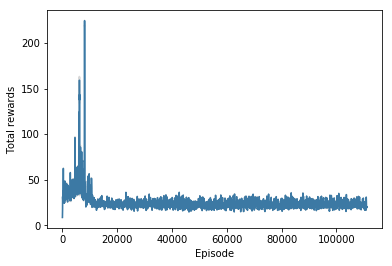

In [27]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

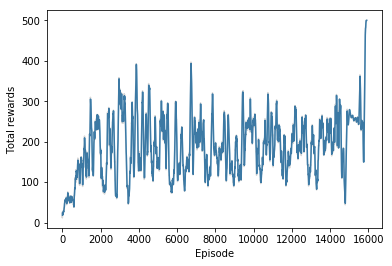

In [30]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

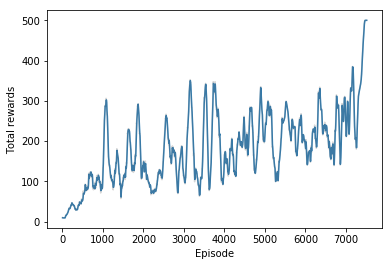

In [29]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

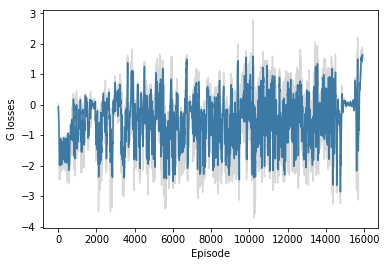

In [31]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

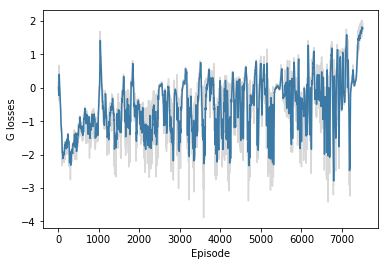

In [30]:
# eps, arr = np.array(g_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('G losses')

Text(0,0.5,'D losses')

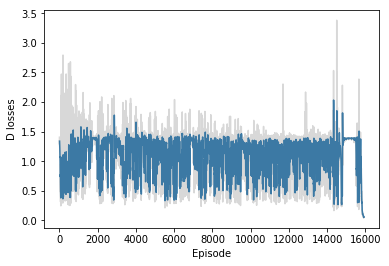

In [32]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

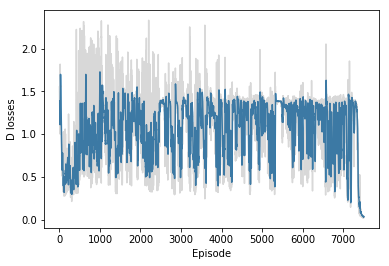

In [31]:
# eps, arr = np.array(d_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses')

Text(0,0.5,'D losses R')

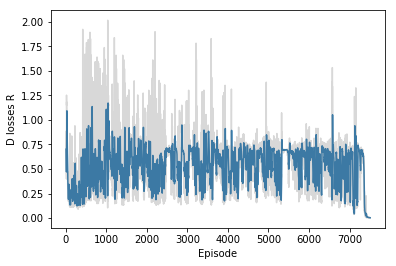

In [32]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

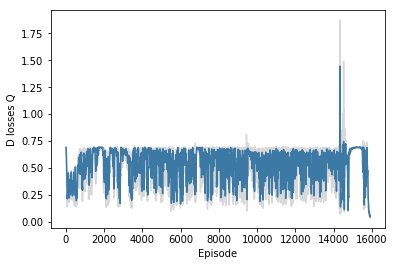

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

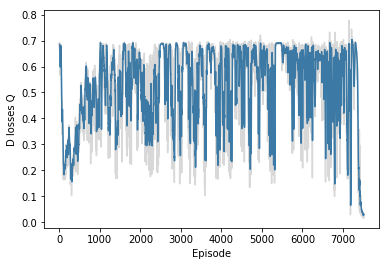

In [33]:
# eps, arr = np.array(d_lossQ_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.